In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import numpy as np
from typing import Optional
import math
from typing import List
import cv2
# from controlnet_aux import HEDdetector
from torchvision import datasets
import torch.utils.data as data_utils
from torchvision.utils import save_image

In [2]:
device = "cuda" 

In [3]:
def extract(vals, t, xshape):
    batch_size = t.shape[0]
    vals = vals.to(device)
    out = vals.gather(-1, t.cuda())
    vals = vals.to(device)
    return out.reshape(batch_size, *((1,)  * (len(xshape)-1)))

In [4]:
def beta_scheduling(T, start=0.0001, end=0.02):
    return torch.linspace(start, end, T)

In [5]:
T = 600


betas = beta_scheduling(T)
alphas = 1. - betas
alphas = alphas
alpha_bars = torch.cumprod(alphas, axis=0)
alpha_bars_prev = F.pad(alpha_bars[:-1], (1, 0), value=1.0)
sqrt_alpha_bars = torch.sqrt(alpha_bars)
sqrt_one_minus_alpha_bars = torch.sqrt(1 - alpha_bars)
sqrt_alpha_bars = torch.sqrt(alpha_bars)
posterior_var = betas * (1. - alpha_bars_prev) * (1. - alpha_bars)
poseterior_var = posterior_var

In [6]:
def forward_diffusion(x0, t):
    global sqrt_alpha_bars
    x0 = x0.to(device)
    noise = torch.randn_like(x0).to(device)
    t = t.to(device)
    sqrt_alpha_bars = sqrt_alpha_bars.to(device)
    first = extract(sqrt_alpha_bars, t, x0.shape) * x0
    first.to(device)
    second = extract(sqrt_one_minus_alpha_bars, t, x0.shape) * noise
    second.to(device)
    return first+second, noise

In [7]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.detach().cpu().numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))


In [81]:
def sample_timestep(xt, t):
    xt = xt[None]
    xt = xt.to(device)
    sqrt_alpha_bars_t =  extract(sqrt_alpha_bars, t, xt.shape).to(device)
    sqrt_one_minus_alpha_bars_t = extract(sqrt_one_minus_alpha_bars, t, xt.shape).to(device)
    betas_t =  extract(betas, t, xt.shape).to(device)
    xt = xt.squeeze()
    xt = xt[None]
    # print(xt.shape)
    res = sqrt_alpha_bars_t*(xt - 10*betas_t /  sqrt_one_minus_alpha_bars_t * model(xt, t))
    # res = sqrt_alpha_bars_t*(xt - 1e10)
    # print(model(xt, t)[0])
    res.to(device)
    if t == 0:
        return res
    else:
        noise = torch.randn_like(xt).to(device)
        pos_var_t = torch.sqrt(extract(posterior_var, t, xt.shape)).to(device)
        return res+pos_var_t*noise

In [9]:

class SpatialTransformer(nn.Module):
    """
    ## Spatial Transformer
    """

    def __init__(self, channels: int, n_heads: int, n_layers: int, d_cond: int):
        """
        :param channels: is the number of channels in the feature map
        :param n_heads: is the number of attention heads
        :param n_layers: is the number of transformer layers
        :param d_cond: is the size of the conditional embedding
        """
        super().__init__()
        # Initial group normalization
        self.norm = torch.nn.GroupNorm(num_groups=32, num_channels=channels, eps=1e-6, affine=True)
        # Initial $1 \times 1$ convolution
        self.proj_in = nn.Conv2d(channels, channels, kernel_size=1, stride=1, padding=0)

        # Transformer layers
        self.transformer_blocks = nn.ModuleList(
            [BasicTransformerBlock(channels, n_heads, channels // n_heads, d_cond=d_cond) for _ in range(n_layers)]
        )

        # Final $1 \times 1$ convolution
        self.proj_out = nn.Conv2d(channels, channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x: torch.Tensor, cond: torch.Tensor):
        """
        :param x: is the feature map of shape `[batch_size, channels, height, width]`
        :param cond: is the conditional embeddings of shape `[batch_size,  n_cond, d_cond]`
        """
        # Get shape `[batch_size, channels, height, width]`
        b, c, h, w = x.shape
        # For residual connection
        x_in = x
        # Normalize
        x = self.norm(x)
        # Initial $1 \times 1$ convolution
        x = self.proj_in(x)
        # Transpose and reshape from `[batch_size, channels, height, width]`
        # to `[batch_size, height * width, channels]`
        x = x.permute(0, 2, 3, 1).view(b, h * w, c)
        # Apply the transformer layers
        for block in self.transformer_blocks:
            x = block(x, cond)
        # Reshape and transpose from `[batch_size, height * width, channels]`
        # to `[batch_size, channels, height, width]`
        x = x.view(b, h, w, c).permute(0, 3, 1, 2)
        # Final $1 \times 1$ convolution
        x = self.proj_out(x)
        # Add residual
        return x + x_in


class BasicTransformerBlock(nn.Module):
    """
    ### Transformer Layer
    """

    def __init__(self, d_model: int, n_heads: int, d_head: int, d_cond: int):
        """
        :param d_model: is the input embedding size
        :param n_heads: is the number of attention heads
        :param d_head: is the size of a attention head
        :param d_cond: is the size of the conditional embeddings
        """
        super().__init__()
        # Self-attention layer and pre-norm layer
        self.attn1 = CrossAttention(d_model, d_model, n_heads, d_head)
        self.norm1 = nn.LayerNorm(d_model)
        # Cross attention layer and pre-norm layer
        self.attn2 = CrossAttention(d_model, d_cond, n_heads, d_head)
        self.norm2 = nn.LayerNorm(d_model)
        # Feed-forward network and pre-norm layer
        self.ff = FeedForward(d_model)
        self.norm3 = nn.LayerNorm(d_model)

    def forward(self, x: torch.Tensor, cond: torch.Tensor):
        """
        :param x: are the input embeddings of shape `[batch_size, height * width, d_model]`
        :param cond: is the conditional embeddings of shape `[batch_size,  n_cond, d_cond]`
        """
        # Self attention
        x = self.attn1(self.norm1(x)) + x
        # Cross-attention with conditioning
        x = self.attn2(self.norm2(x), cond=cond) + x
        # Feed-forward network
        x = self.ff(self.norm3(x)) + x
        #
        return x


class CrossAttention(nn.Module):
    """
    ### Cross Attention Layer

    This falls-back to self-attention when conditional embeddings are not specified.
    """

    use_flash_attention: bool = False

    def __init__(self, d_model: int, d_cond: int, n_heads: int, d_head: int, is_inplace: bool = True):
        """
        :param d_model: is the input embedding size
        :param n_heads: is the number of attention heads
        :param d_head: is the size of a attention head
        :param d_cond: is the size of the conditional embeddings
        :param is_inplace: specifies whether to perform the attention softmax computation inplace to
            save memory
        """
        super().__init__()

        self.is_inplace = is_inplace
        self.n_heads = n_heads
        self.d_head = d_head

        # Attention scaling factor
        self.scale = d_head ** -0.5

        # Query, key and value mappings
        d_attn = d_head * n_heads
        self.to_q = nn.Linear(d_model, d_attn, bias=False)
        self.to_k = nn.Linear(d_attn, d_cond, bias=False)
        self.to_v = nn.Linear(d_cond, d_attn, bias=False)

        # Final linear layer
        self.to_out = nn.Sequential(nn.Linear(d_attn, d_model))

        # Setup [flash attention](https://github.com/HazyResearch/flash-attention).
        # Flash attention is only used if it's installed
        # and `CrossAttention.use_flash_attention` is set to `True`.
        try:
            # You can install flash attention by cloning their Github repo,
            # [https://github.com/HazyResearch/flash-attention](https://github.com/HazyResearch/flash-attention)
            # and then running `python setup.py install`
            from flash_attn.flash_attention import FlashAttention
            self.flash = FlashAttention()
            # Set the scale for scaled dot-product attention.
            self.flash.softmax_scale = self.scale
        # Set to `None` if it's not installed
        except ImportError:
            self.flash = None

    def forward(self, x: torch.Tensor, cond: Optional[torch.Tensor] = None):
        """
        :param x: are the input embeddings of shape `[batch_size, height * width, d_model]`
        :param cond: is the conditional embeddings of shape `[batch_size, n_cond, d_cond]`
        """

        # If `cond` is `None` we perform self attention
        has_cond = cond is not None
        if not has_cond:
            cond = x

        # Get query, key and value vectors
        q = self.to_q(x)
        k = self.to_k(cond)
        v = self.to_v(cond)

        # Use flash attention if it's available and the head size is less than or equal to `128`
        if CrossAttention.use_flash_attention and self.flash is not None and not has_cond and self.d_head <= 128:
            return self.flash_attention(q, k, v)
        # Otherwise, fallback to normal attention
        else:
            return self.normal_attention(q, k, v)

    def flash_attention(self, q: torch.Tensor, k: torch.Tensor, v: torch.Tensor):
        """
        #### Flash Attention

        :param q: are the query vectors before splitting heads, of shape `[batch_size, seq, d_attn]`
        :param k: are the query vectors before splitting heads, of shape `[batch_size, seq, d_attn]`
        :param v: are the query vectors before splitting heads, of shape `[batch_size, seq, d_attn]`
        """

        # Get batch size and number of elements along sequence axis (`width * height`)
        batch_size, seq_len, _ = q.shape

        # Stack `q`, `k`, `v` vectors for flash attention, to get a single tensor of
        # shape `[batch_size, seq_len, 3, n_heads * d_head]`
        qkv = torch.stack((q, k, v), dim=2)
        # Split the heads
        qkv = qkv.view(batch_size, seq_len, 3, self.n_heads, self.d_head)

        # Flash attention works for head sizes `32`, `64` and `128`, so we have to pad the heads to
        # fit this size.
        if self.d_head <= 32:
            pad = 32 - self.d_head
        elif self.d_head <= 64:
            pad = 64 - self.d_head
        elif self.d_head <= 128:
            pad = 128 - self.d_head
        else:
            raise ValueError(f'Head size ${self.d_head} too large for Flash Attention')

        # Pad the heads
        if pad:
            qkv = torch.cat((qkv, qkv.new_zeros(batch_size, seq_len, 3, self.n_heads, pad)), dim=-1)

        # Compute attention
        # $$\underset{seq}{softmax}\Bigg(\frac{Q K^\top}{\sqrt{d_{key}}}\Bigg)V$$
        # This gives a tensor of shape `[batch_size, seq_len, n_heads, d_padded]`
        out, _ = self.flash(qkv)
        # Truncate the extra head size
        out = out[:, :, :, :self.d_head]
        # Reshape to `[batch_size, seq_len, n_heads * d_head]`
        out = out.reshape(batch_size, seq_len, self.n_heads * self.d_head)

        # Map to `[batch_size, height * width, d_model]` with a linear layer
        return self.to_out(out)

    def normal_attention(self, q: torch.Tensor, k: torch.Tensor, v: torch.Tensor):
        """
        #### Normal Attention
        
        :param q: are the query vectors before splitting heads, of shape `[batch_size, seq, d_attn]`
        :param k: are the query vectors before splitting heads, of shape `[batch_size, seq, d_attn]`
        :param v: are the query vectors before splitting heads, of shape `[batch_size, seq, d_attn]`
        """

        # Split them to heads of shape `[batch_size, seq_len, n_heads, d_head]`
        q = q.view(*q.shape[:2], self.n_heads, -1)
        k = k.view(*k.shape[:2], self.n_heads, -1)
        v = v.view(*v.shape[:2], self.n_heads, -1)

        # Calculate attention $\frac{Q K^\top}{\sqrt{d_{key}}}$
        attn = torch.einsum('bihd,bjhd->bhij', q, k) * self.scale

        # Compute softmax
        # $$\underset{seq}{softmax}\Bigg(\frac{Q K^\top}{\sqrt{d_{key}}}\Bigg)$$
        if self.is_inplace:
            half = attn.shape[0] // 2
            attn[half:] = attn[half:].softmax(dim=-1)
            attn[:half] = attn[:half].softmax(dim=-1)
        else:
            attn = attn.softmax(dim=-1)

        # Compute attention output
        # $$\underset{seq}{softmax}\Bigg(\frac{Q K^\top}{\sqrt{d_{key}}}\Bigg)V$$
        out = torch.einsum('bhij,bjhd->bihd', attn, v)
        # Reshape to `[batch_size, height * width, n_heads * d_head]`
        out = out.reshape(*out.shape[:2], -1)
        # Map to `[batch_size, height * width, d_model]` with a linear layer
        return self.to_out(out)


class FeedForward(nn.Module):
    """
    ### Feed-Forward Network
    """

    def __init__(self, d_model: int, d_mult: int = 4):
        """
        :param d_model: is the input embedding size
        :param d_mult: is multiplicative factor for the hidden layer size
        """
        super().__init__()
        self.net = nn.Sequential(
            GeGLU(d_model, d_model * d_mult),
            nn.Dropout(0.),
            nn.Linear(d_model * d_mult, d_model)
        )

    def forward(self, x: torch.Tensor):
        return self.net(x)


class GeGLU(nn.Module):
    """
    ### GeGLU Activation

    $$\text{GeGLU}(x) = (xW + b) * \text{GELU}(xV + c)$$
    """

    def __init__(self, d_in: int, d_out: int):
        super().__init__()
        # Combined linear projections $xW + b$ and $xV + c$
        self.proj = nn.Linear(d_in, d_out * 2)

    def forward(self, x: torch.Tensor):
        # Get $xW + b$ and $xV + c$
        x, gate = self.proj(x).chunk(2, dim=-1)
        # $\text{GeGLU}(x) = (xW + b) * \text{GELU}(xV + c)$
        return x * F.gelu(gate)

In [51]:
class UNetModel(nn.Module):
    """
    ## U-Net model
    """

    def __init__(
            self, 
            in_channels: int,
            out_channels: int,
            channels: int,
            n_res_blocks: int,
            attention_levels: List[int],
            channel_multipliers: List[int],
            n_heads: int,
            tf_layers: int = 1,
            d_cond: int = 768):
        """
        :param in_channels: is the number of channels in the input feature map
        :param out_channels: is the number of channels in the output feature map
        :param channels: is the base channel count for the model
        :param n_res_blocks: number of residual blocks at each level
        :param attention_levels: are the levels at which attention should be performed
        :param channel_multipliers: are the multiplicative factors for number of channels for each level
        :param n_heads: is the number of attention heads in the transformers
        :param tf_layers: is the number of transformer layers in the transformers
        :param d_cond: is the size of the conditional embedding in the transformers
        """
        super().__init__()
        self.channels = channels

        # Number of levels
        levels = len(channel_multipliers)
        # Size time embeddings
        d_time_emb = channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(channels, d_time_emb),
            nn.SiLU(),
            nn.Linear(d_time_emb, d_time_emb),
        )

        # Input half of the U-Net
        self.input_blocks = nn.ModuleList()
        # Initial $3 \times 3$ convolution that maps the input to `channels`.
        # The blocks are wrapped in `TimestepEmbedSequential` module because
        # different modules have different forward function signatures;
        # for example, convolution only accepts the feature map and
        # residual blocks accept the feature map and time embedding.
        # `TimestepEmbedSequential` calls them accordingly.
        self.input_blocks.append(TimestepEmbedSequential(
            nn.Conv2d(in_channels, channels, 3, padding=1)))
        # Number of channels at each block in the input half of U-Net
        input_block_channels = [channels]
        # Number of channels at each level
        channels_list = [channels * m for m in channel_multipliers]
        # Prepare levels
        for i in range(levels):
            # Add the residual blocks and attentions
            for _ in range(n_res_blocks):
                # Residual block maps from previous number of channels to the number of
                # channels in the current level
                layers = [ResBlock(channels, d_time_emb, out_channels=channels_list[i])]
                channels = channels_list[i]
                # Add transformer
                if i in attention_levels:
                    layers.append(SpatialTransformer(channels, n_heads, tf_layers, d_cond))
                # Add them to the input half of the U-Net and keep track of the number of channels of
                # its output
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                input_block_channels.append(channels)
            # Down sample at all levels except last
            if i != levels - 1:
                self.input_blocks.append(TimestepEmbedSequential(DownSample(channels)))
                input_block_channels.append(channels)

        # The middle of the U-Net
        self.middle_block = TimestepEmbedSequential(
            ResBlock(channels, d_time_emb),
            SpatialTransformer(channels, n_heads, tf_layers, d_cond),
            ResBlock(channels, d_time_emb),
        )

        # Second half of the U-Net
        self.output_blocks = nn.ModuleList([])
        # Prepare levels in reverse order
        for i in reversed(range(levels)):
            # Add the residual blocks and attentions
            for j in range(n_res_blocks + 1):
                # Residual block maps from previous number of channels plus the
                # skip connections from the input half of U-Net to the number of
                # channels in the current level.
                layers = [ResBlock(channels + input_block_channels.pop(), d_time_emb, out_channels=channels_list[i])]
                channels = channels_list[i]
                # Add transformer
                if i in attention_levels:
                    layers.append(SpatialTransformer(channels, n_heads, tf_layers, d_cond))
                # Up-sample at every level after last residual block
                # except the last one.
                # Note that we are iterating in reverse; i.e. `i == 0` is the last.
                if i != 0 and j == n_res_blocks:
                    layers.append(UpSample(channels))
                # Add to the output half of the U-Net
                self.output_blocks.append(TimestepEmbedSequential(*layers))

        # Final normalization and $3 \times 3$ convolution
        self.out = nn.Sequential(
            normalization(channels),
            nn.SiLU(),
            nn.Conv2d(channels, out_channels, 3, padding=1),
        )

    def time_step_embedding(self, time_steps: torch.Tensor, max_period: int = 10000):
        """
        ## Create sinusoidal time step embeddings

        :param time_steps: are the time steps of shape `[batch_size]`
        :param max_period: controls the minimum frequency of the embeddings.
        """
        # $\frac{c}{2}$; half the channels are sin and the other half is cos,
        half = self.channels // 2
        # $\frac{1}{10000^{\frac{2i}{c}}}$
        frequencies = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=time_steps.device)
        # $\frac{t}{10000^{\frac{2i}{c}}}$
        args = time_steps[:, None].float() * frequencies[None]
        # $\cos\Bigg(\frac{t}{10000^{\frac{2i}{c}}}\Bigg)$ and $\sin\Bigg(\frac{t}{10000^{\frac{2i}{c}}}\Bigg)$
        return torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

    def forward(self, x: torch.Tensor, time_steps: torch.Tensor, cond=None):
        """
        :param x: is the input feature map of shape `[batch_size, channels, width, height]`
        :param time_steps: are the time steps of shape `[batch_size]`
        :param cond: conditioning of shape `[batch_size, n_cond, d_cond]`
        """
        # To store the input half outputs for skip connections
        x_input_block = []

        # Get time step embeddings
        t_emb = self.time_step_embedding(time_steps)
        t_emb = self.time_embed(t_emb)
        # x = x.permute(1, 0, 2, 3)
        # Input half of the U-Net
        for module in self.input_blocks:
            x = module(x, t_emb, cond)
            x_input_block.append(x)
        # Middle of the U-Net
        x = self.middle_block(x, t_emb, cond)
        # Output half of the U-Net
        for module in self.output_blocks:
            x = torch.cat([x, x_input_block.pop()], dim=1)
            x = module(x, t_emb, cond)

        # Final normalization and $3 \times 3$ convolution
        return self.out(x)


class TimestepEmbedSequential(nn.Sequential):
    """
    ### Sequential block for modules with different inputs

    This sequential module can compose of different modules such as `ResBlock`,
    `nn.Conv` and `SpatialTransformer` and calls them with the matching signatures
    """

    def forward(self, x, t_emb, cond=None):
        for layer in self:
            if isinstance(layer, ResBlock):
                x = layer(x, t_emb)
            elif isinstance(layer, SpatialTransformer):
                x = layer(x, cond)
            else:
                x = layer(x)
        return x


class UpSample(nn.Module):
    """
    ### Up-sampling layer
    """

    def __init__(self, channels: int):
        """
        :param channels: is the number of channels
        """
        super().__init__()
        # $3 \times 3$ convolution mapping
        self.conv = nn.Conv2d(channels, channels, 3, padding=1)

    def forward(self, x: torch.Tensor):
        """
        :param x: is the input feature map with shape `[batch_size, channels, height, width]`
        """
        # Up-sample by a factor of $2$
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        # Apply convolution
        return self.conv(x)


class DownSample(nn.Module):
    """
    ## Down-sampling layer
    """

    def __init__(self, channels: int):
        """
        :param channels: is the number of channels
        """
        super().__init__()
        # $3 \times 3$ convolution with stride length of $2$ to down-sample by a factor of $2$
        self.op = nn.Conv2d(channels, channels, 3, stride=2, padding=1)

    def forward(self, x: torch.Tensor):
        """
        :param x: is the input feature map with shape `[batch_size, channels, height, width]`
        """
        # Apply convolution
        return self.op(x)


class ResBlock(nn.Module):
    """
    ## ResNet Block
    """

    def __init__(self, channels: int, d_t_emb: int, *, out_channels=None):
        """
        :param channels: the number of input channels
        :param d_t_emb: the size of timestep embeddings
        :param out_channels: is the number of out channels. defaults to `channels.
        """
        super().__init__()
        # `out_channels` not specified
        if out_channels is None:
            out_channels = channels

        # First normalization and convolution
        self.in_layers = nn.Sequential(
            normalization(channels),
            nn.SiLU(),
            nn.Conv2d(channels, out_channels, 3, padding=1),
        )

        # Time step embeddings
        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(d_t_emb, out_channels),
        )
        # Final convolution layer
        self.out_layers = nn.Sequential(
            normalization(out_channels),
            nn.SiLU(),
            nn.Dropout(0.),
            nn.Conv2d(out_channels, out_channels, 3, padding=1)
        )

        # `channels` to `out_channels` mapping layer for residual connection
        if out_channels == channels:
            self.skip_connection = nn.Identity()
        else:
            self.skip_connection = nn.Conv2d(channels, out_channels, 1)

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor):
        """
        :param x: is the input feature map with shape `[batch_size, channels, height, width]`
        :param t_emb: is the time step embeddings of shape `[batch_size, d_t_emb]`
        """
        # Initial convolution
        h = self.in_layers(x)
        # Time step embeddings
        t_emb = self.emb_layers(t_emb).type(h.dtype)
        # Add time step embeddings
        h = h + t_emb[:, :, None, None]
        # Final convolution
        h = self.out_layers(h)
        # Add skip connection
        return self.skip_connection(x) + h


class GroupNorm32(nn.GroupNorm):
    """
    ### Group normalization with float32 casting
    """

    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)


def normalization(channels):
    """
    ### Group normalization

    This is a helper function, with fixed number of groups..
    """
    return GroupNorm32(32, channels)



In [52]:
att_levels = [0, 2]

model = UNetModel(3, 3, 320, 1, [], [], 1, 1, 320).to(device)

In [53]:
# # image = np.array(Image.open("bocchi.png"))
# image_path = "poke.png"
# # image = np.array(Image.open(image_path))
# image = cv2.imread(image_path, cv2.IMREAD_COLOR)
# # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# trans = transforms.Compose([
#     transforms.ToTensor()
# ])
# image = trans(image).to(device)

# num_images = 10
# stepsize = T // num_images

# plt.figure(figsize=(15,15))
# plt.axis('off')
# for idx in range(0, T, stepsize):
#     t = torch.tensor([idx]).to(device)
#     plt.subplot(1, num_images+1, int(idx/stepsize) + 1)

#     xt, noise = forward_diffusion(image, t)
#     xt, noise = xt.to(device), noise.to(device)
#     show_tensor_image(xt)

In [13]:
# plt.figure(figsize=(15,15))
# plt.axis('off')
# for idx in range(0, T, stepsize):
#     t = torch.tensor([idx]).to(device)
#     plt.subplot(1, num_images+1, int(idx/stepsize) + 1)

#     res = sampling(xt, t).to(device)
#     show_tensor_image(res)

In [14]:
def get_loss(model, x0, t):
    xt, noise = forward_diffusion(x0, t)
    noise_pred = model(xt, t)
    return F.mse_loss(noise_pred, noise)

In [ ]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 28
BATCH_SIZE = 64

@torch.no_grad()
def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)

#     train = datasets.MNIST(root=".", download=True, 
#                                          transform=data_transform)
    idx = torch.arange(0, 400)
    
    test = datasets.CelebA(root=".", download=True, 
                                         transform=data_transform)
    ss = data_utils.Subset(test, idx)
    return ss
@torch.no_grad()
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0, *(i for i in range(3, 64)))), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Epoch 0 | step 000 Loss: 0.11446630954742432 
Epoch 0 | step 001 Loss: 1.9003013372421265 
Epoch 0 | step 002 Loss: 0.14140120148658752 
Epoch 0 | step 003 Loss: 0.5329172015190125 
Epoch 0 | step 004 Loss: 0.3459259867668152 
Epoch 0 | step 005 Loss: 0.2123696506023407 
Epoch 1 | step 000 Loss: 0.21981678903102875 
Epoch 1 | step 001 Loss: 0.14668051898479462 
Epoch 1 | step 002 Loss: 0.1810465306043625 
Epoch 1 | step 003 Loss: 0.10301955789327621 
Epoch 1 | step 004 Loss: 0.10586472600698471 
Epoch 1 | step 005 Loss: 0.16380763053894043 
Epoch 2 | step 000 Loss: 0.1130562424659729 
Epoch 2 | step 001 Loss: 0.11863764375448227 
Epoch 2 | step 002 Loss: 0.07604686915874481 
Epoch 2 | step 003 Loss: 0.13343310356140137 
Epoch 2 | step 004 Loss: 0.09787480533123016 
Epoch 2 | step 005 Loss: 0.15080617368221283 
Epoch 3 | step 000 Loss: 0.08093856275081635 
Epoch 3 | step 001 Loss: 0.12095294892787933 
Epoch 3 | step 002 Loss: 0.109486423432827 


/tmp/ipykernel_2016/2820054828.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15,15))


Epoch 3 | step 003 Loss: 0.13683508336544037 
Epoch 3 | step 004 Loss: 0.14003121852874756 
Epoch 3 | step 005 Loss: 0.10588891804218292 
Epoch 4 | step 000 Loss: 0.07065658271312714 
Epoch 4 | step 001 Loss: 0.06696240603923798 
Epoch 4 | step 002 Loss: 0.07786095142364502 
Epoch 4 | step 003 Loss: 0.05041712522506714 
Epoch 4 | step 004 Loss: 0.09559167921543121 
Epoch 4 | step 005 Loss: 0.1276983618736267 
Epoch 5 | step 000 Loss: 0.0660647451877594 
Epoch 5 | step 001 Loss: 0.08049923181533813 
Epoch 5 | step 002 Loss: 0.05907565355300903 
Epoch 5 | step 003 Loss: 0.09960880130529404 
Epoch 5 | step 004 Loss: 0.0645090714097023 
Epoch 5 | step 005 Loss: 0.056139808148145676 
Epoch 6 | step 000 Loss: 0.10050204396247864 
Epoch 6 | step 001 Loss: 0.05166996642947197 
Epoch 6 | step 002 Loss: 0.07104936987161636 
Epoch 6 | step 003 Loss: 0.07706472277641296 
Epoch 6 | step 004 Loss: 0.07482519000768661 
Epoch 6 | step 005 Loss: 0.050139956176280975 
Epoch 7 | step 000 Loss: 0.06355391

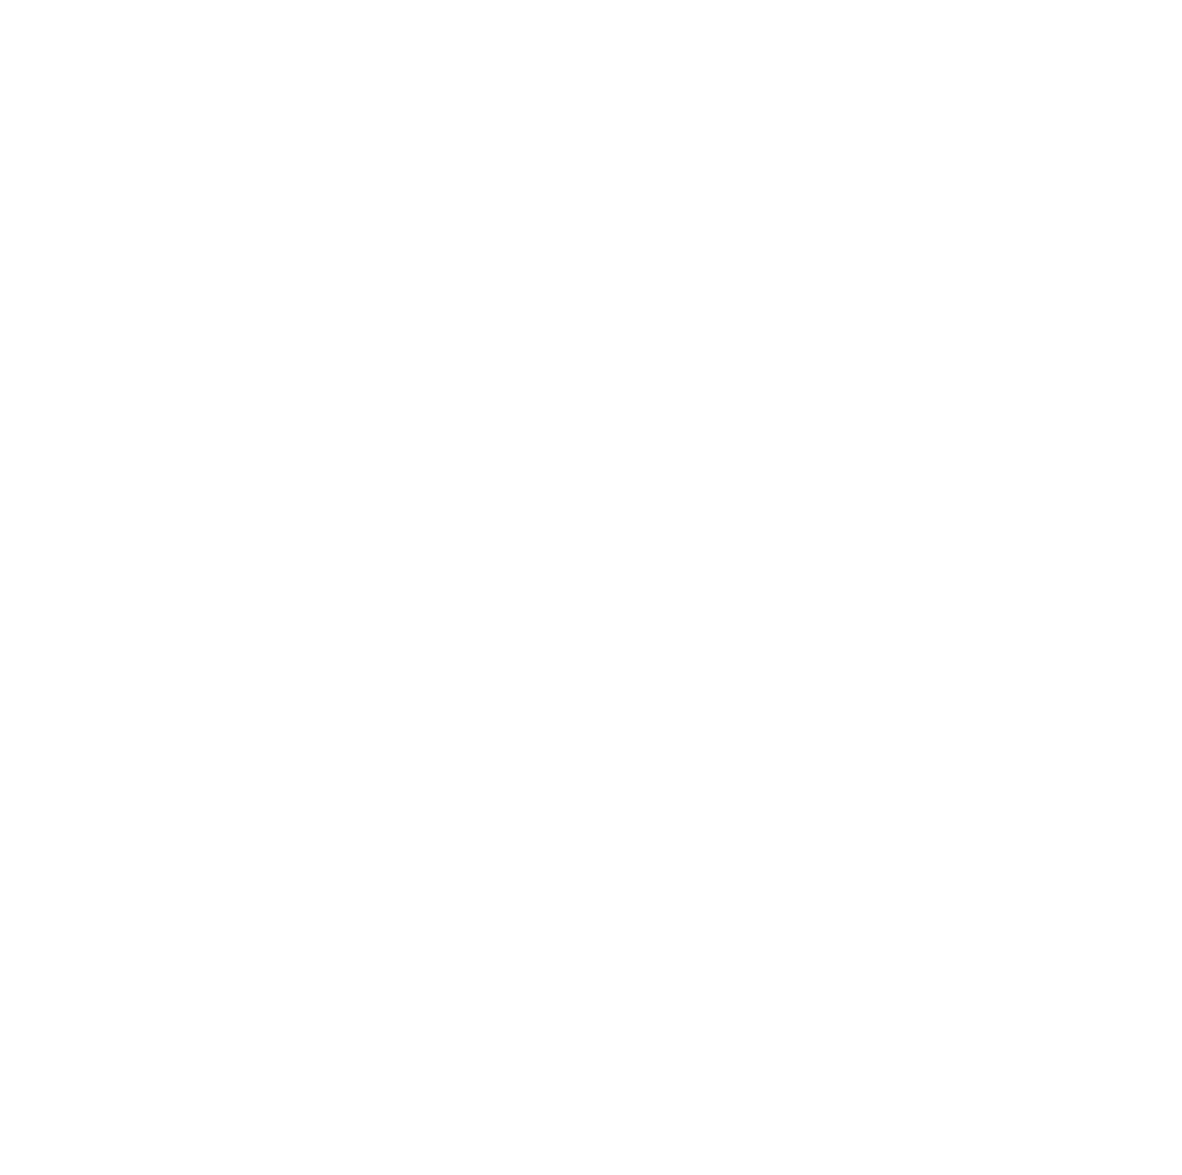

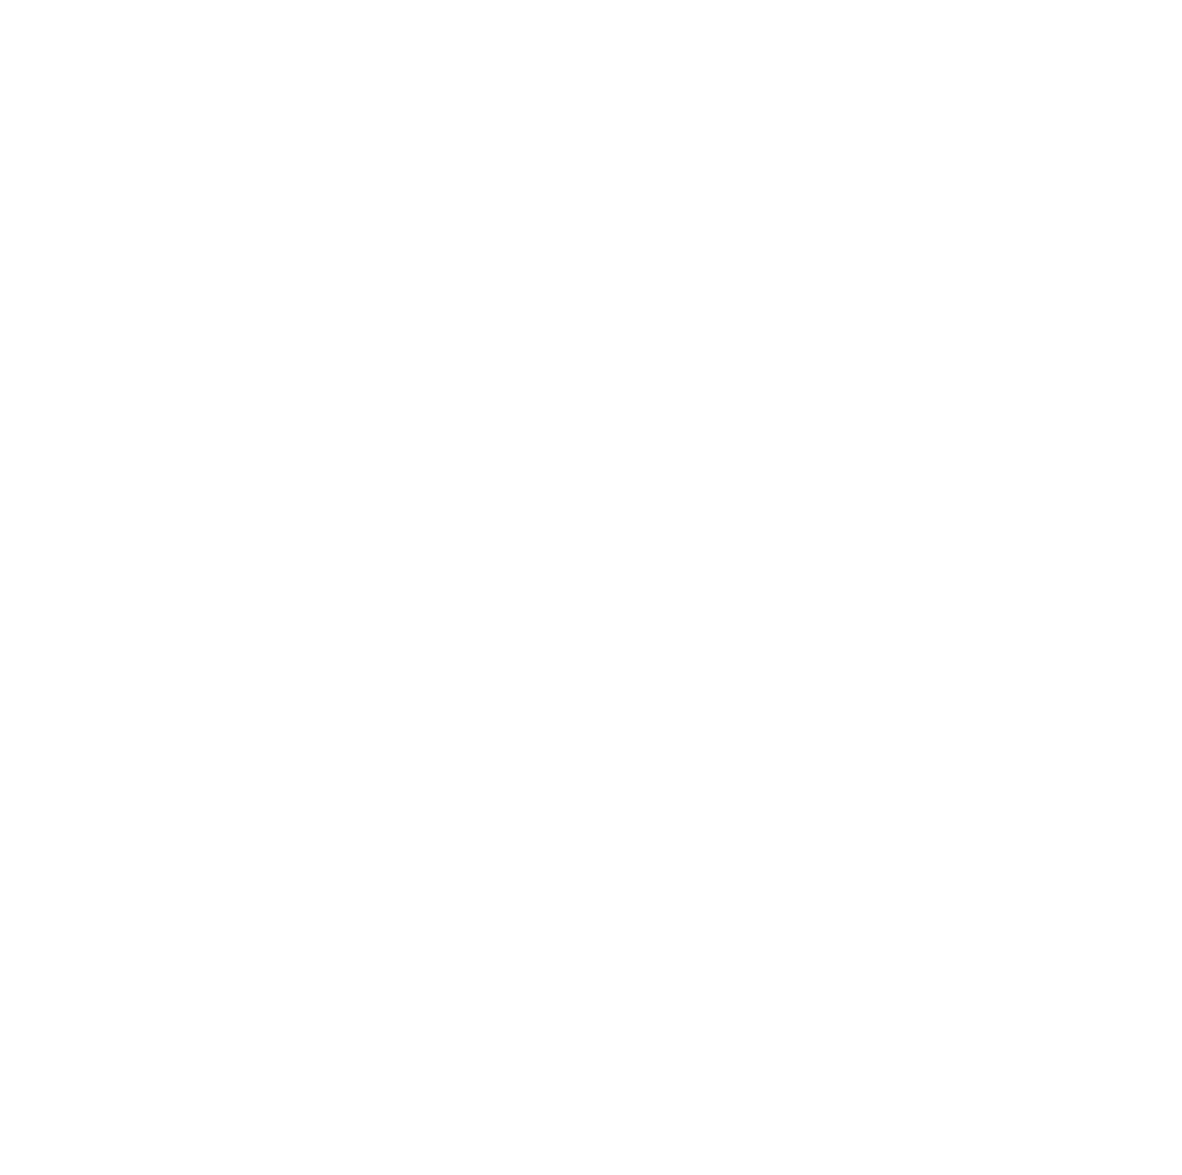

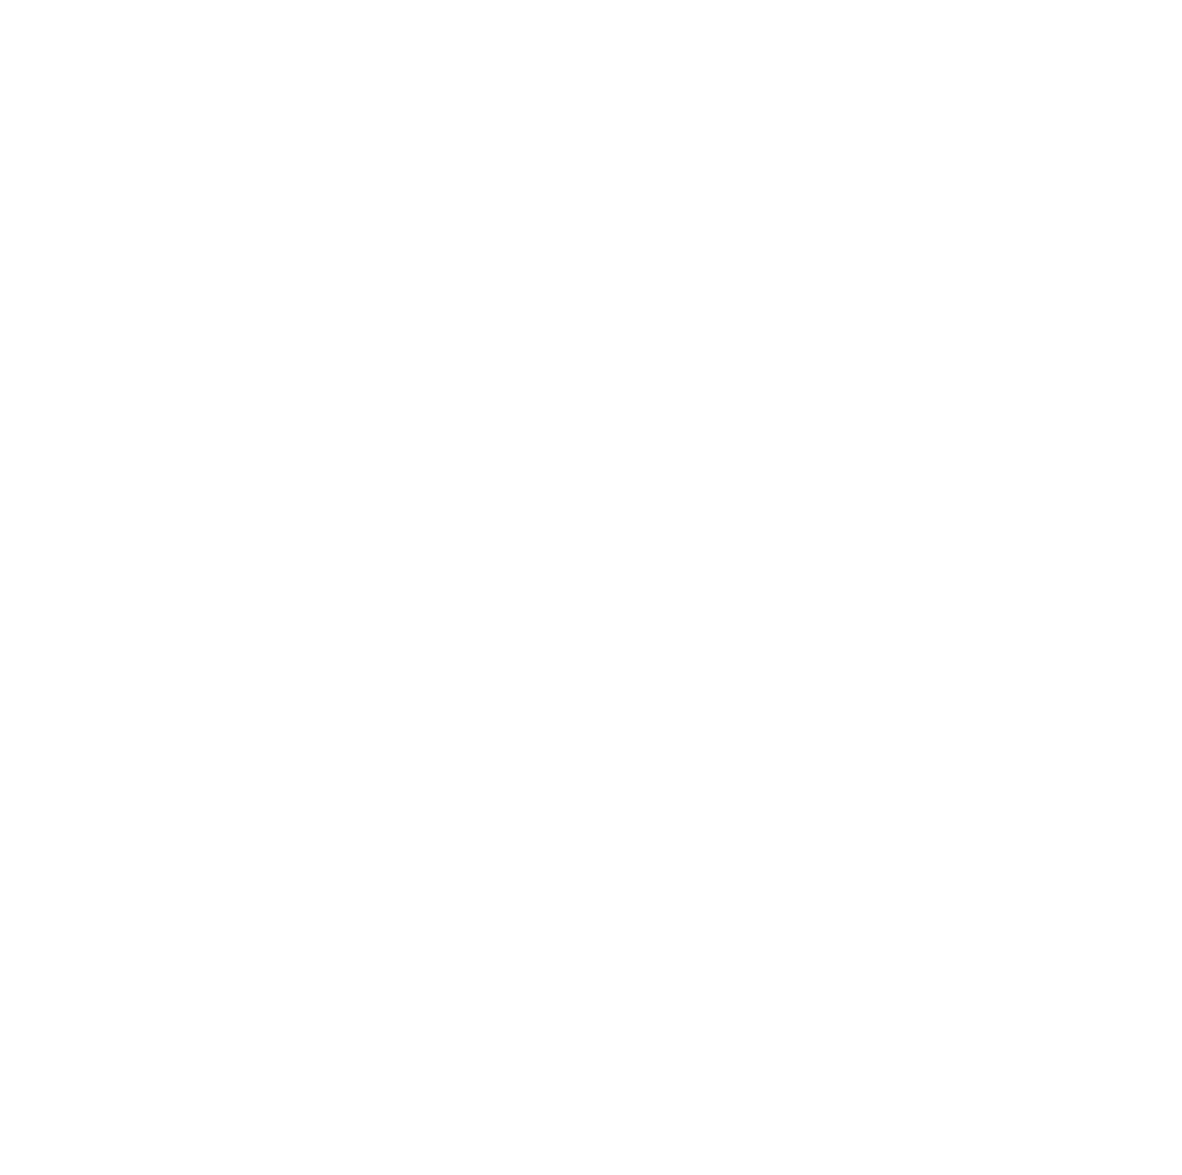

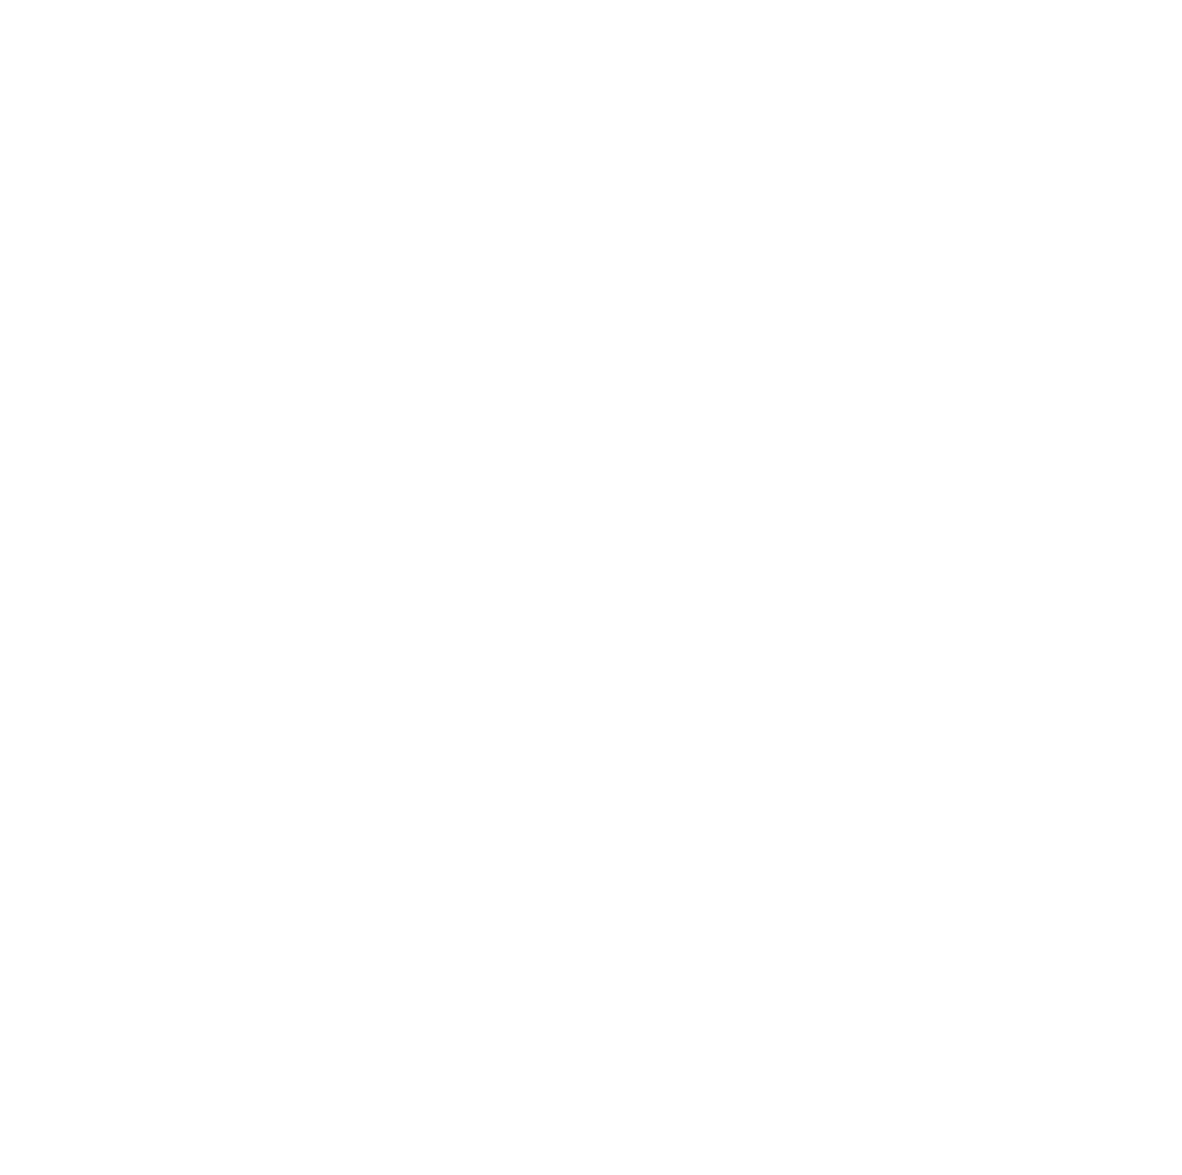

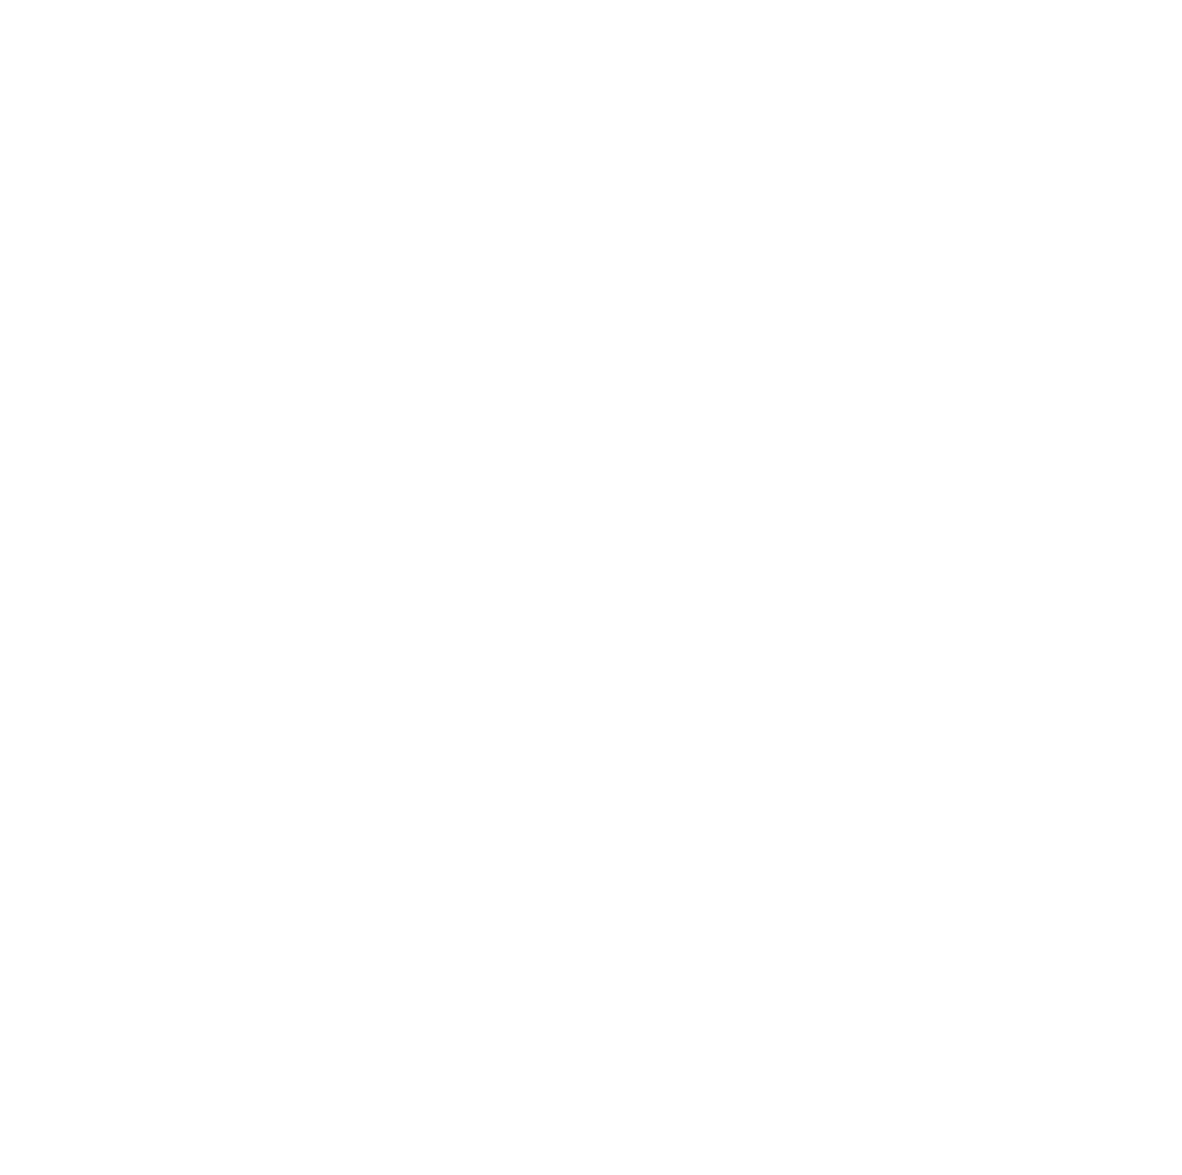

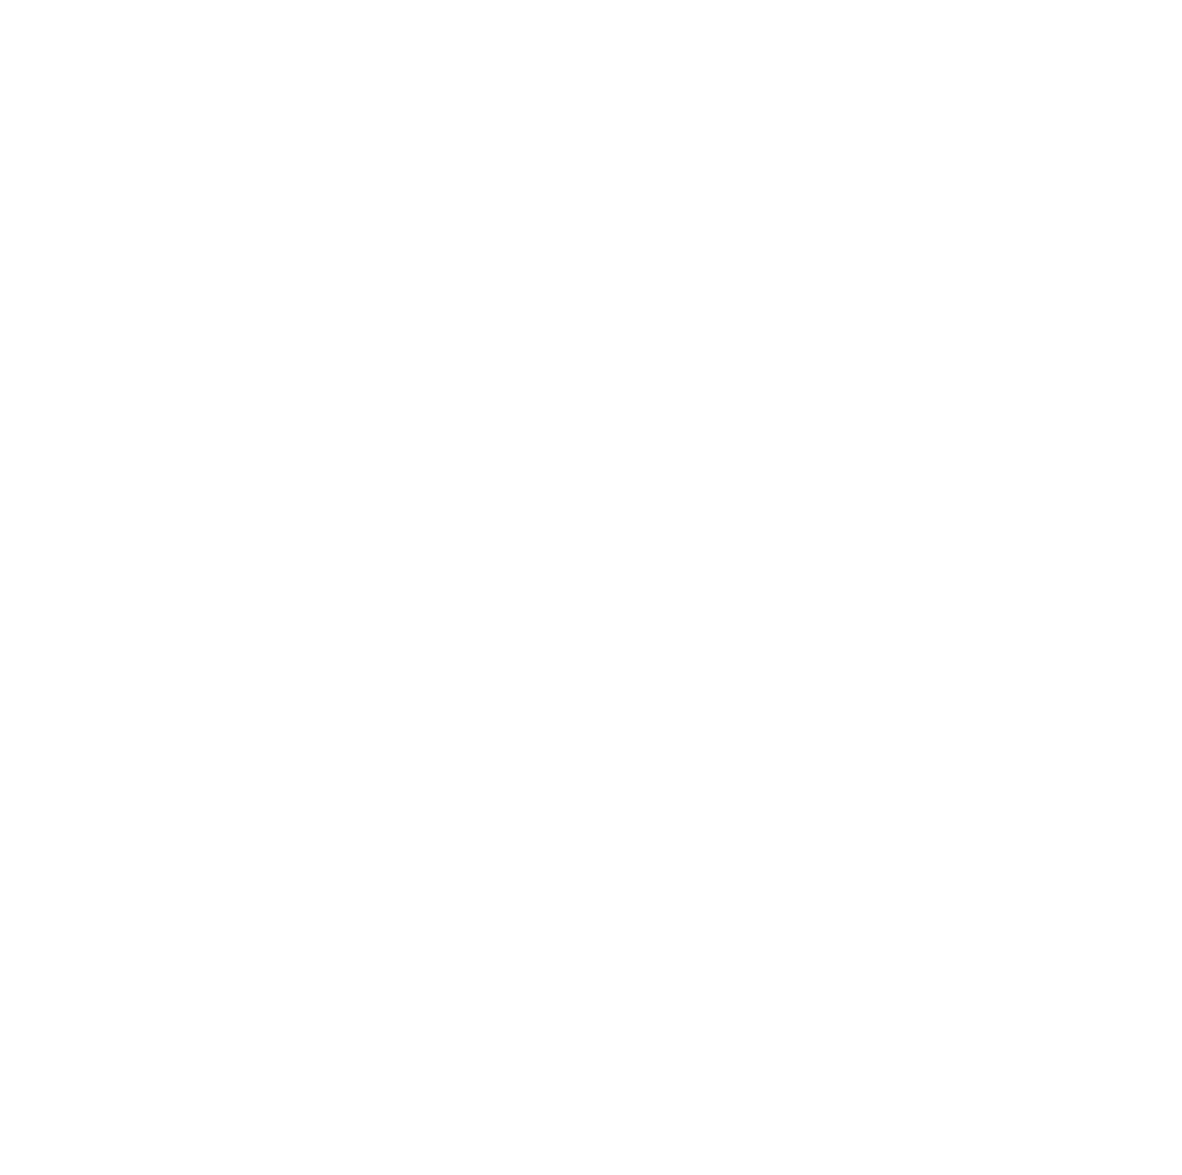

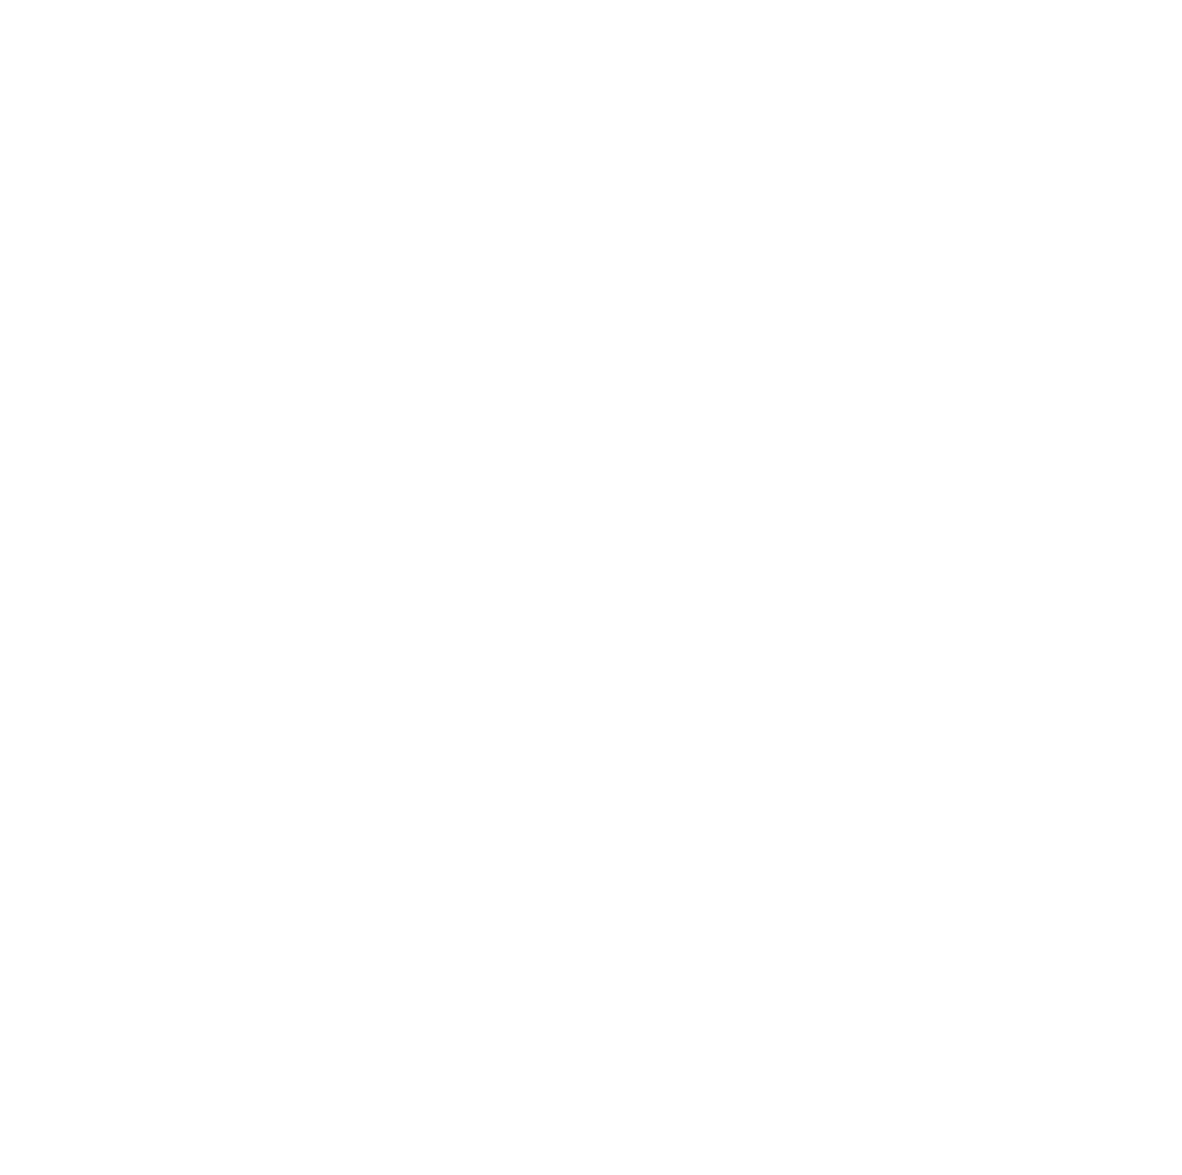

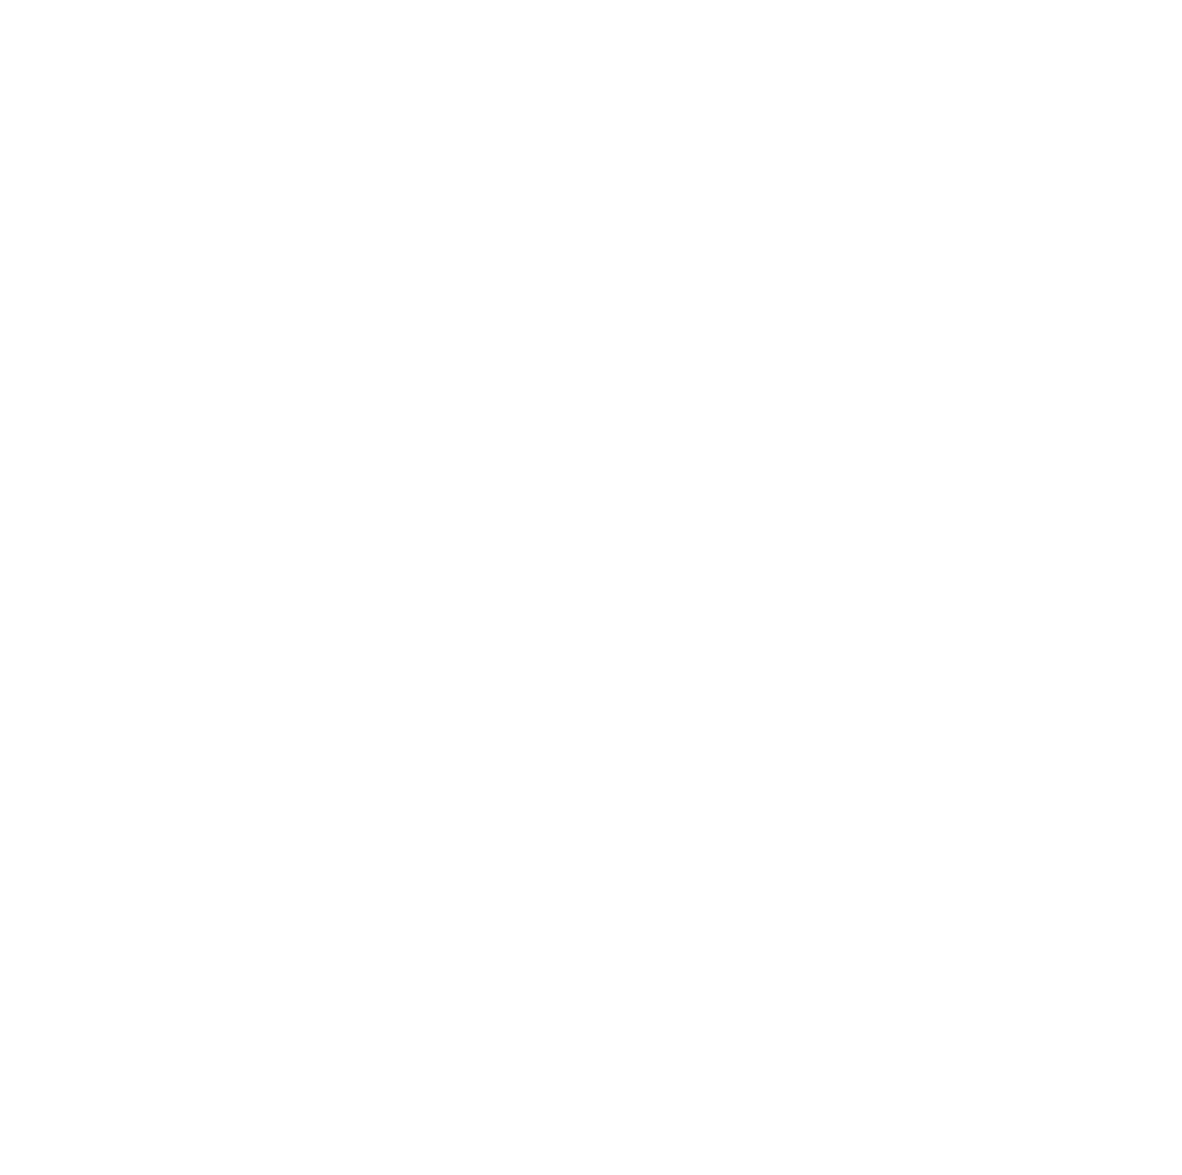

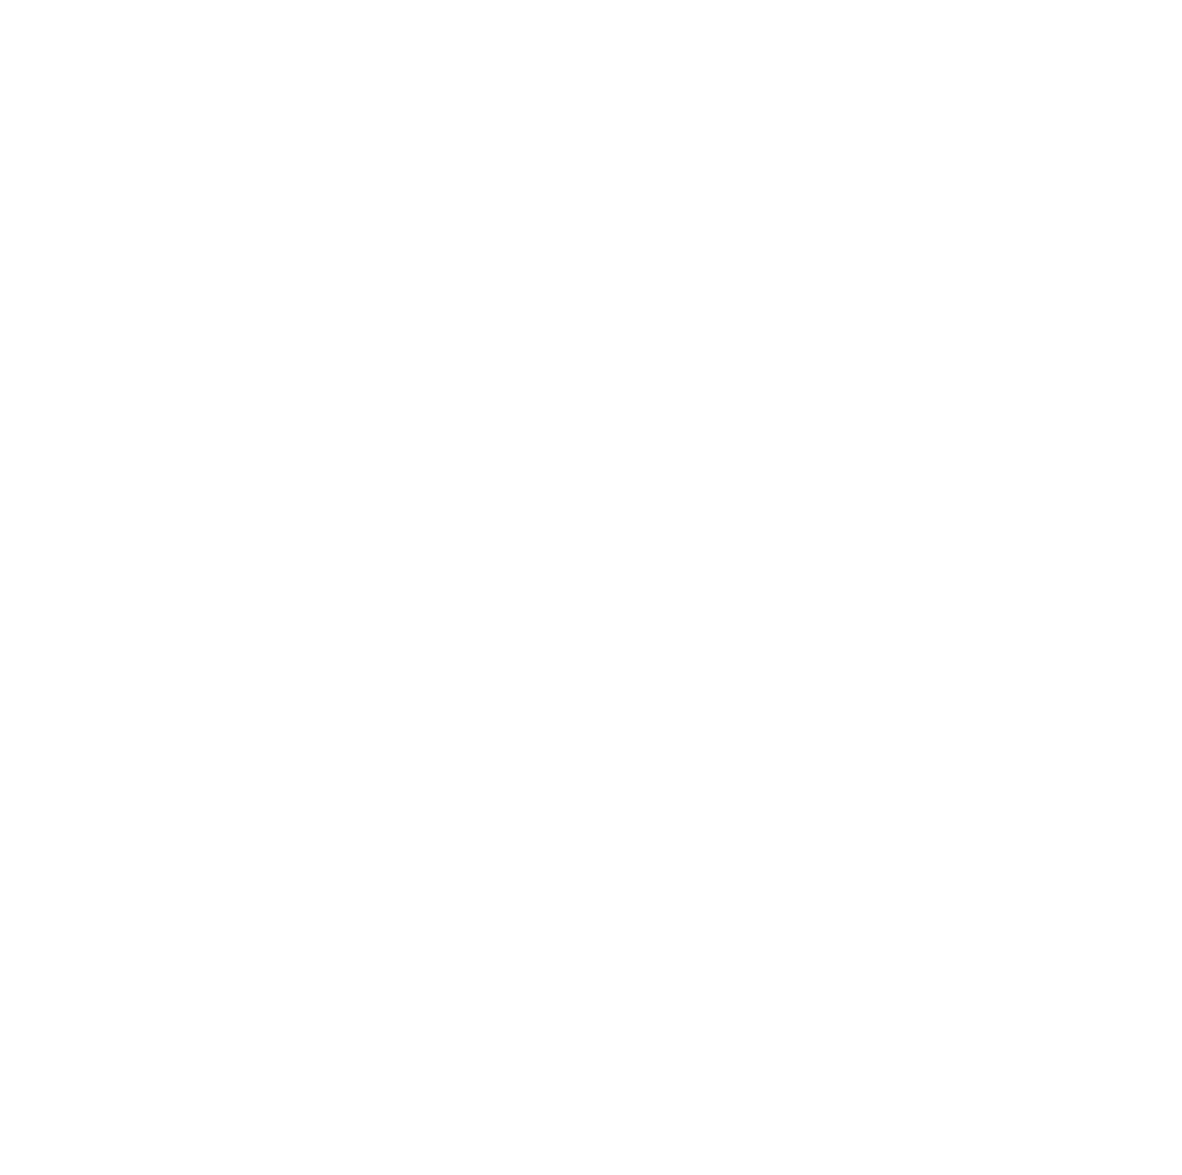

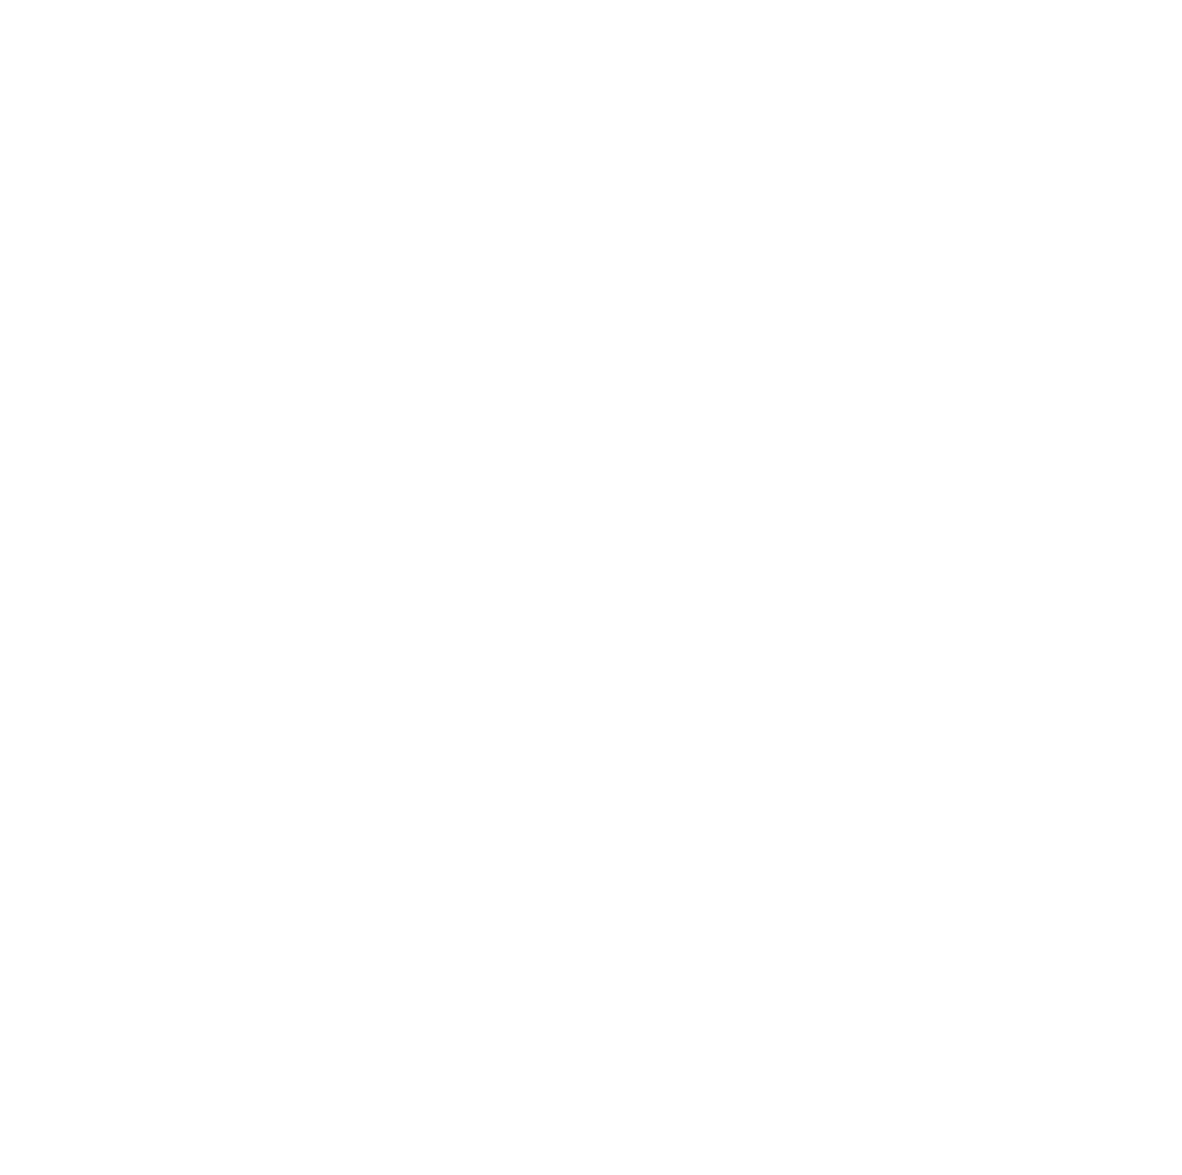

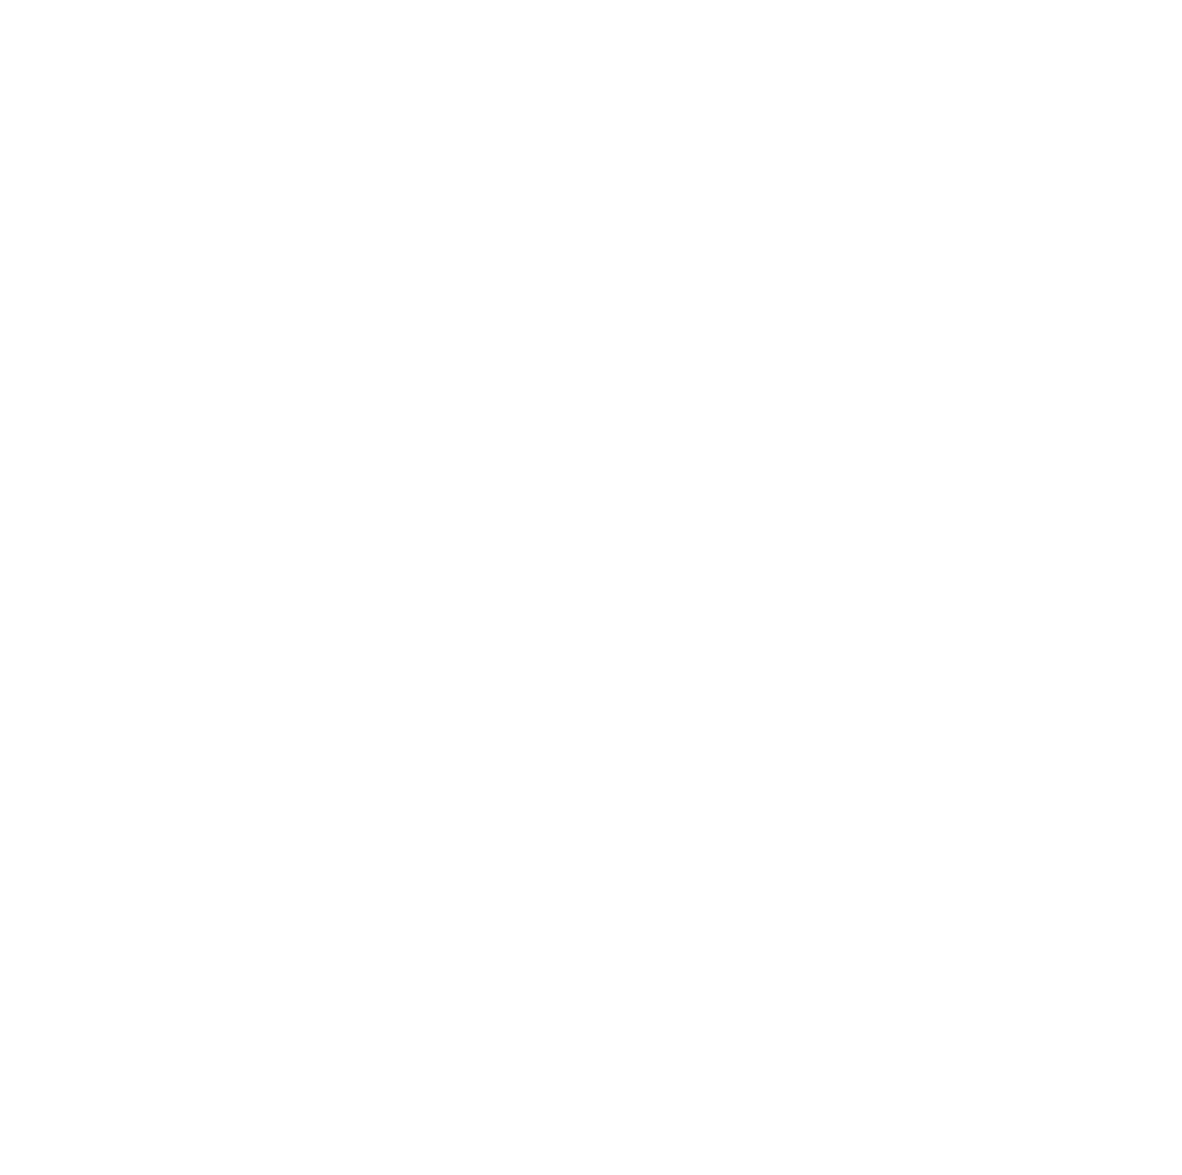

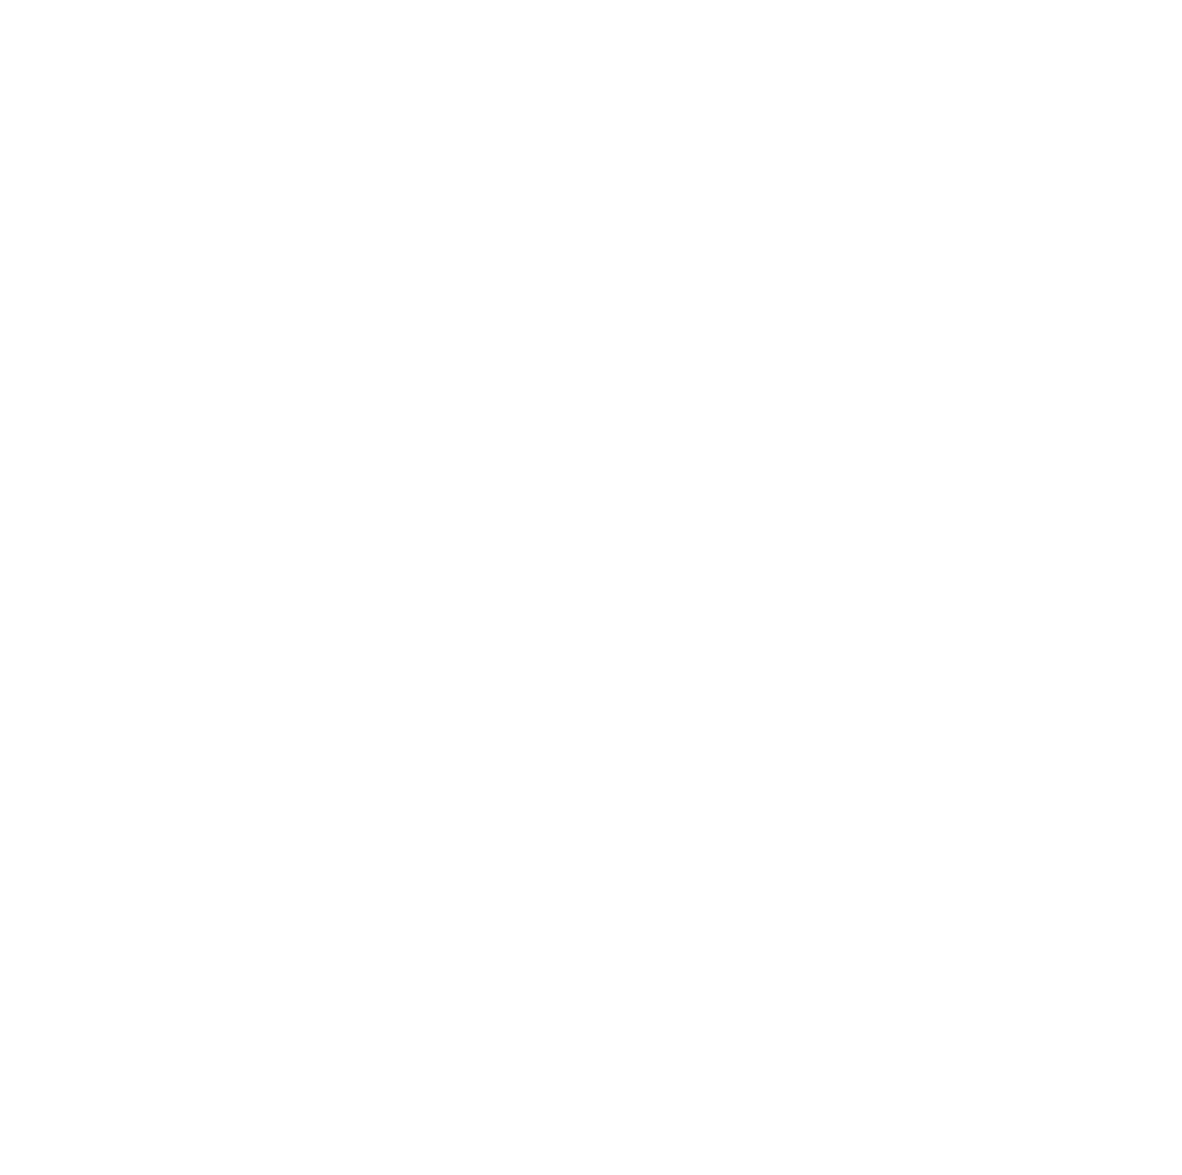

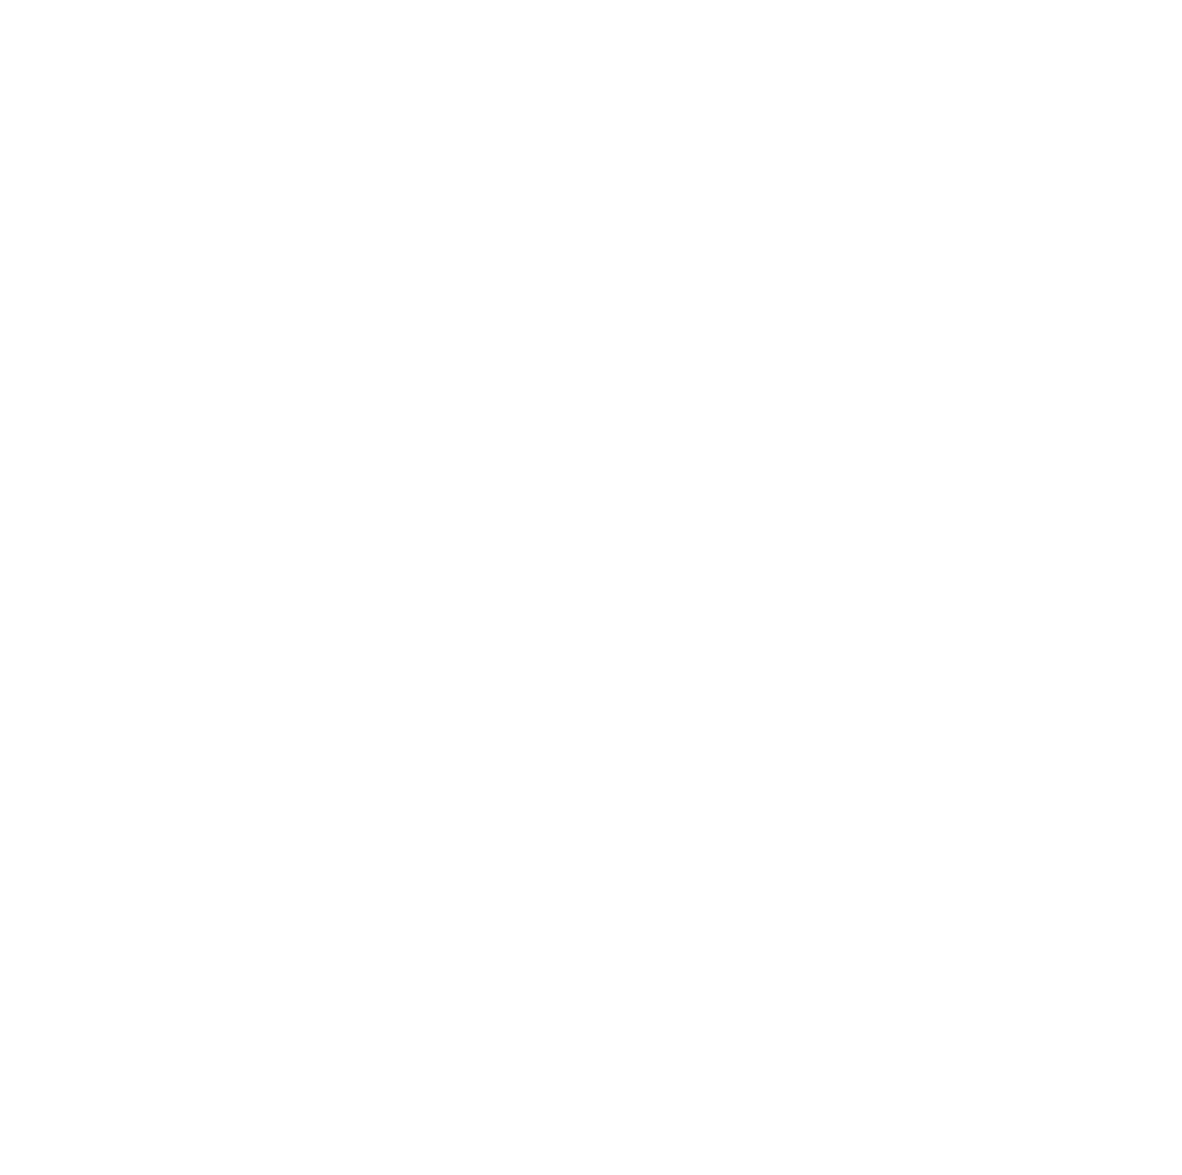

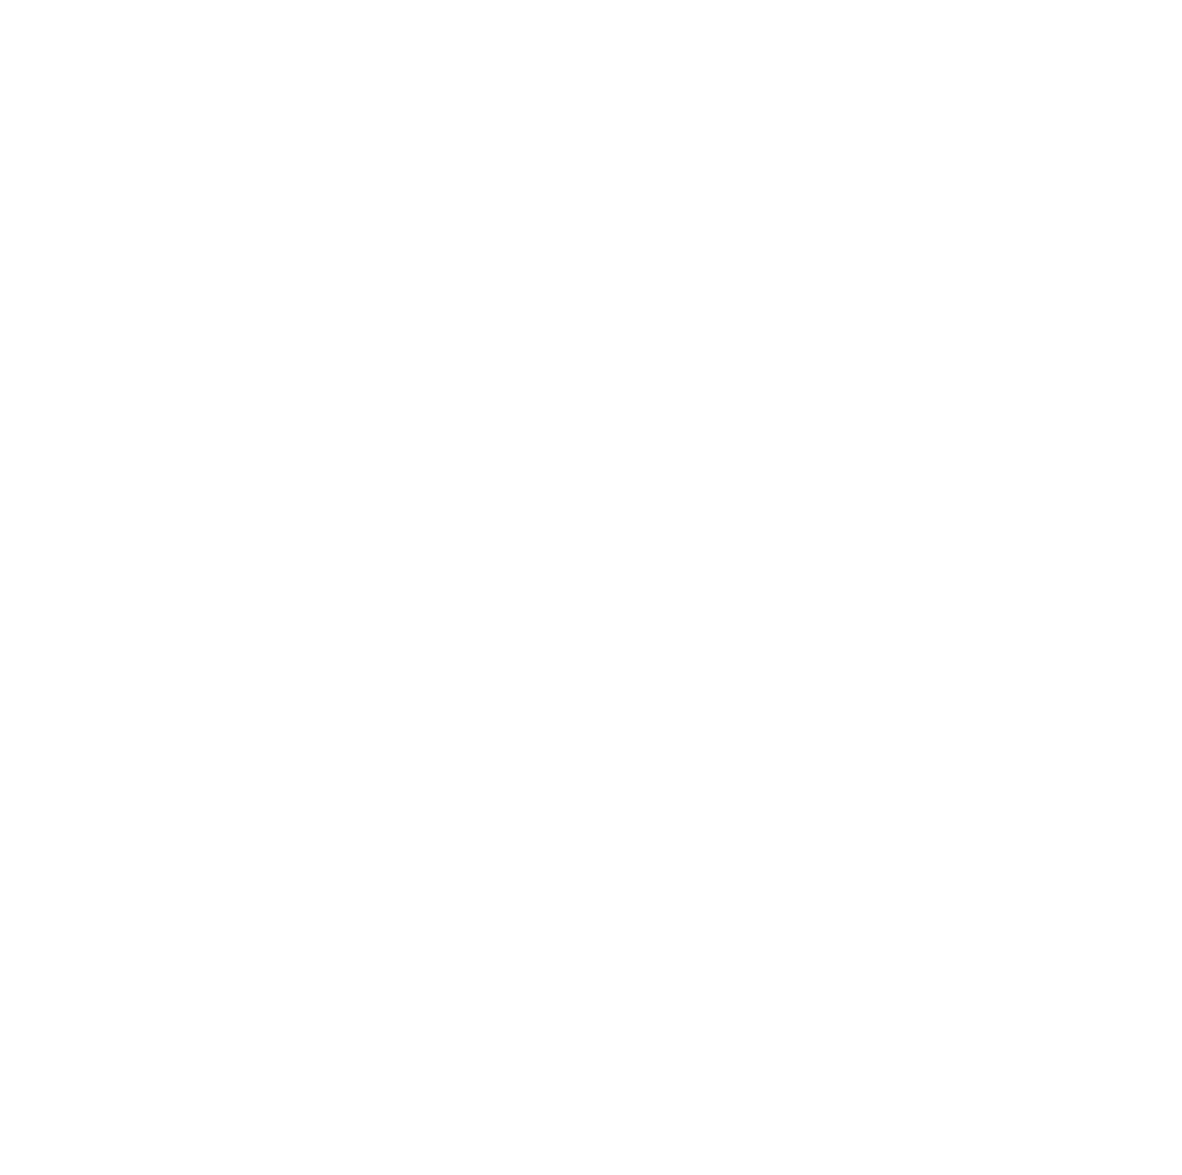

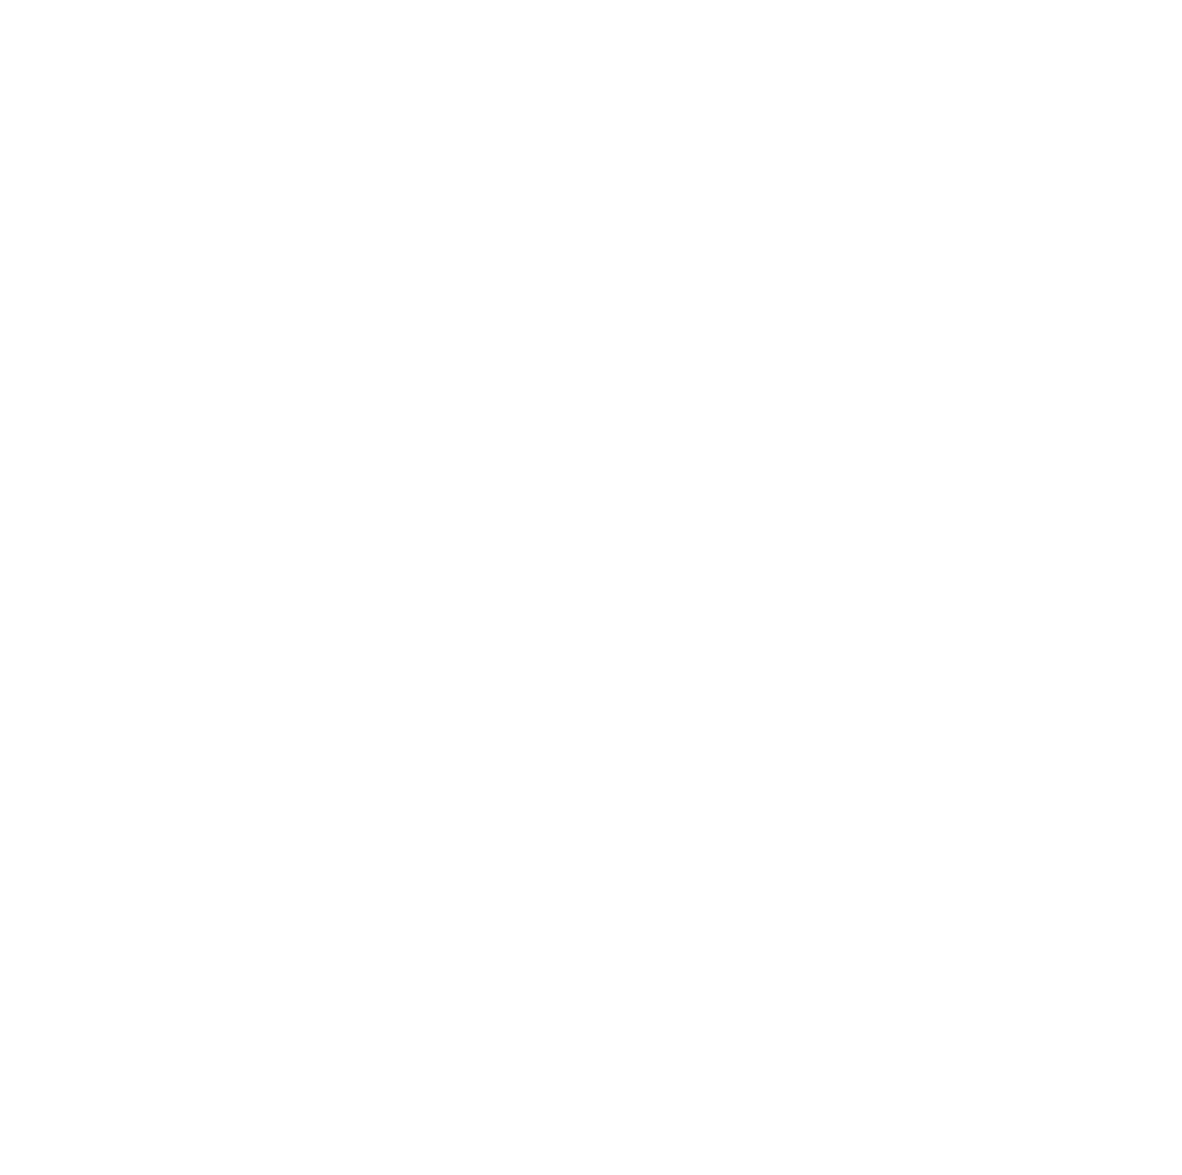

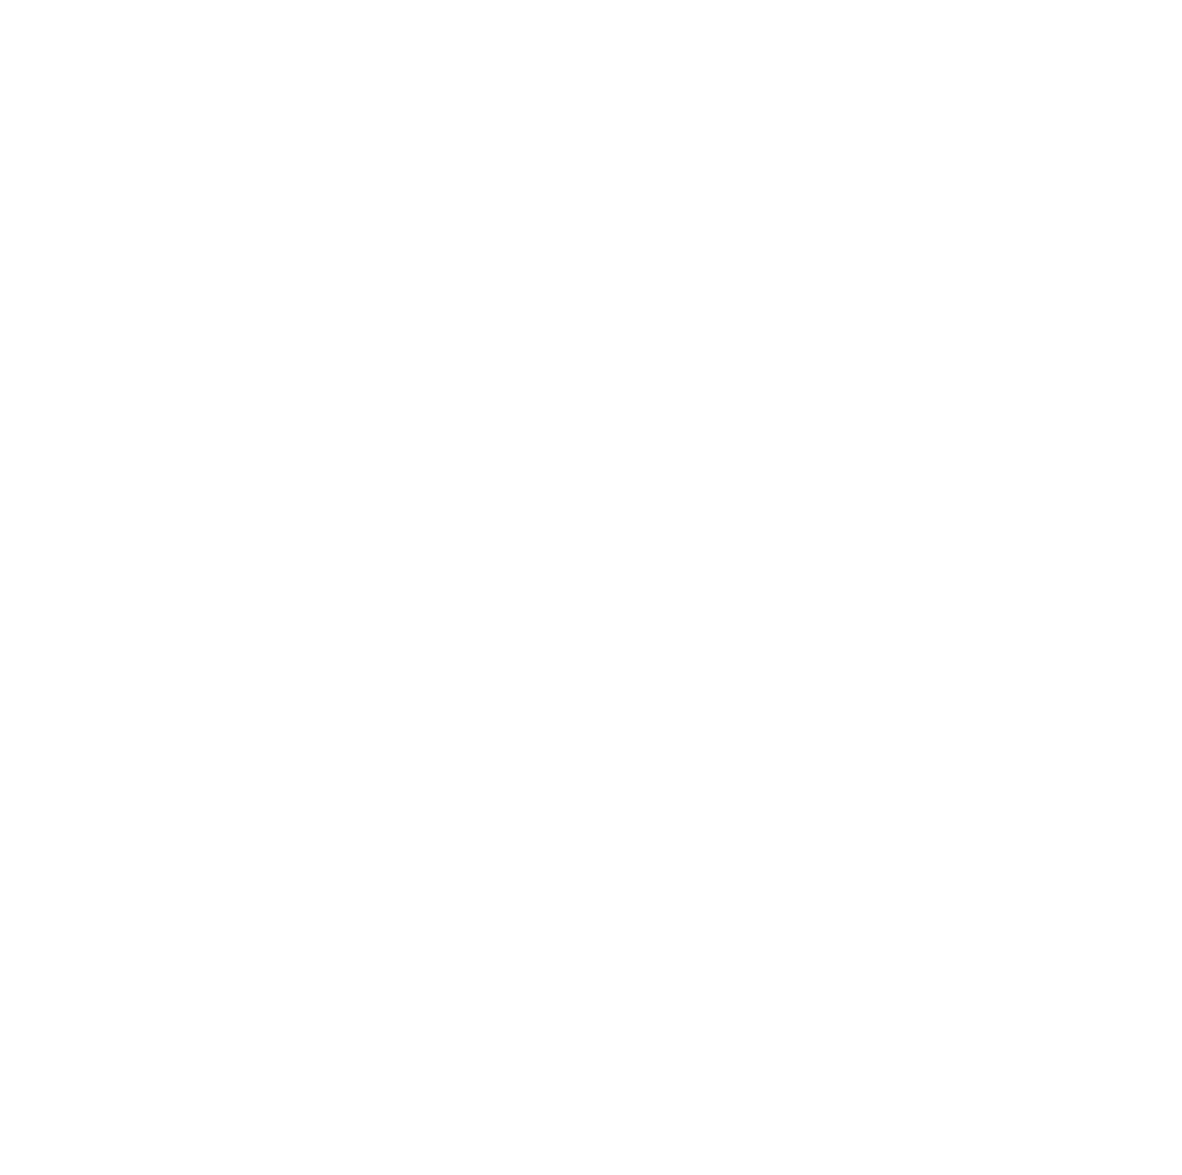

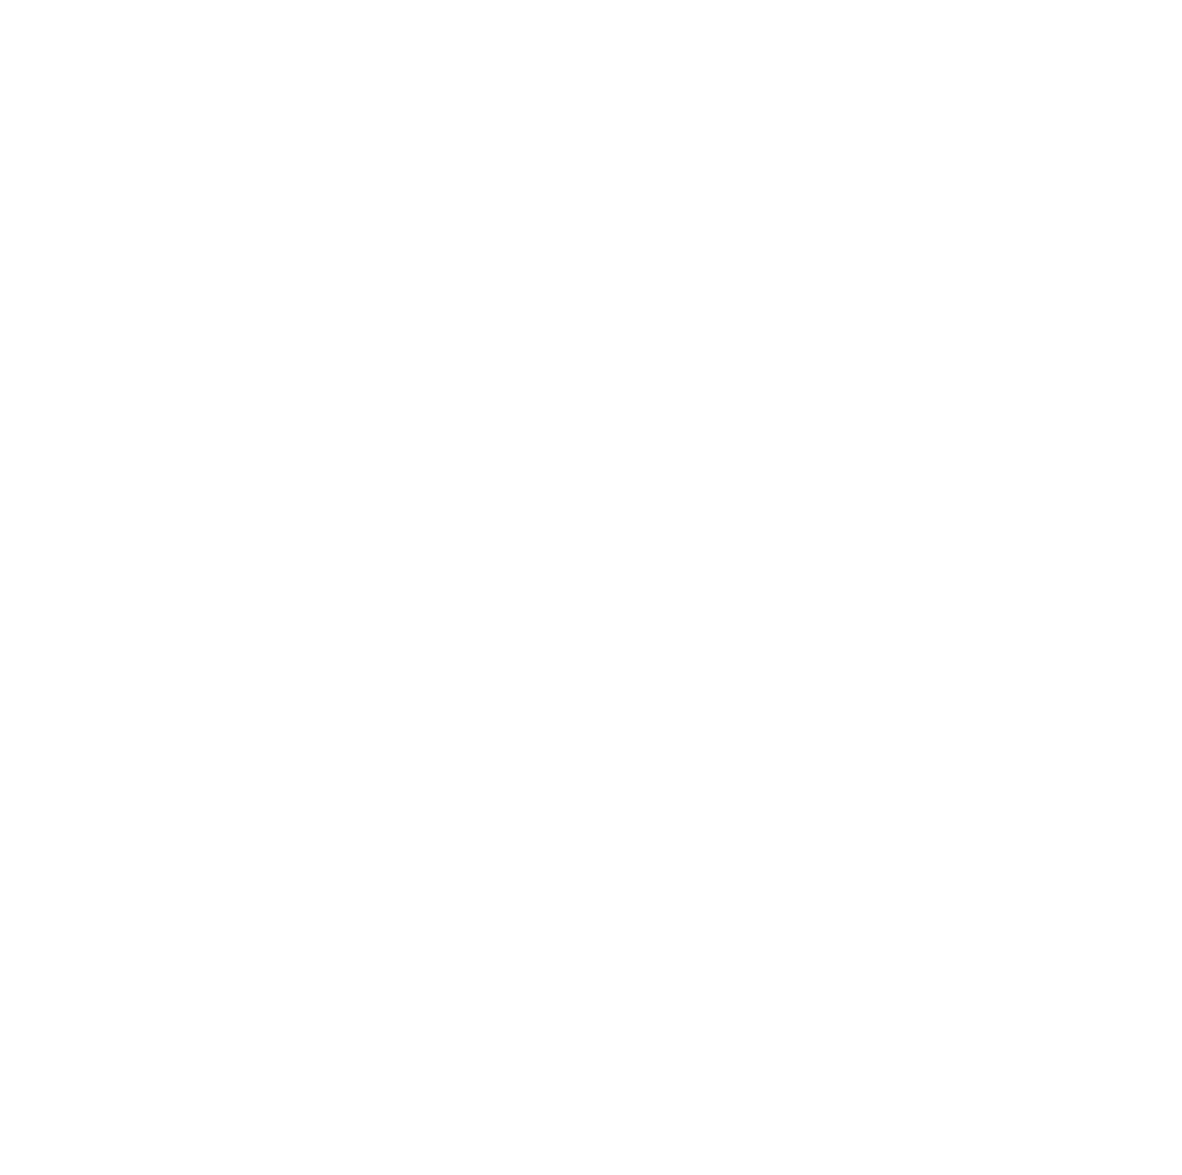

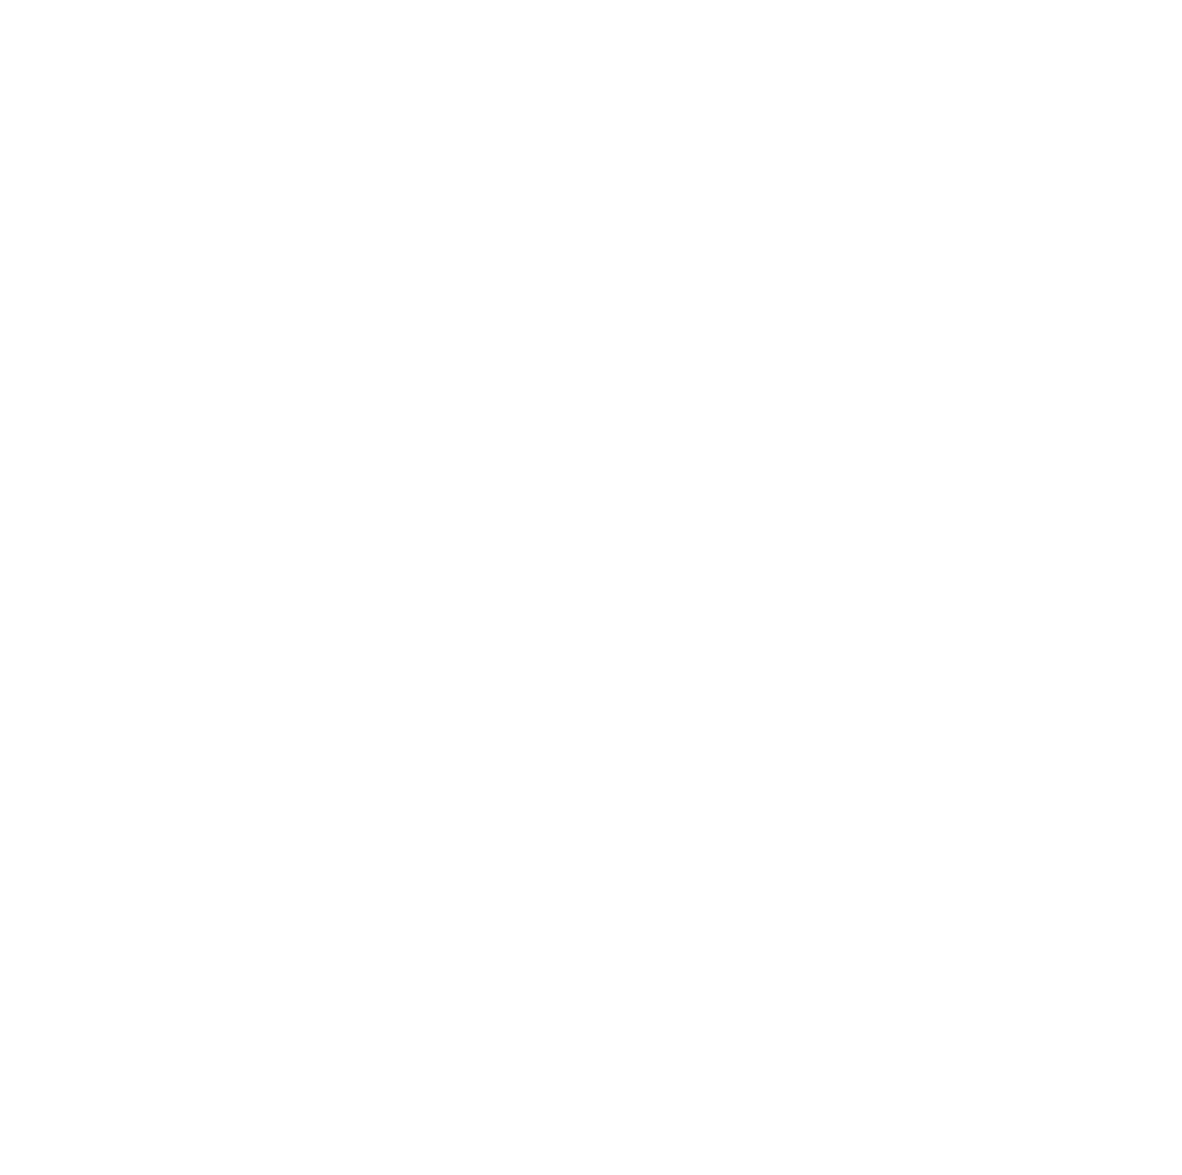

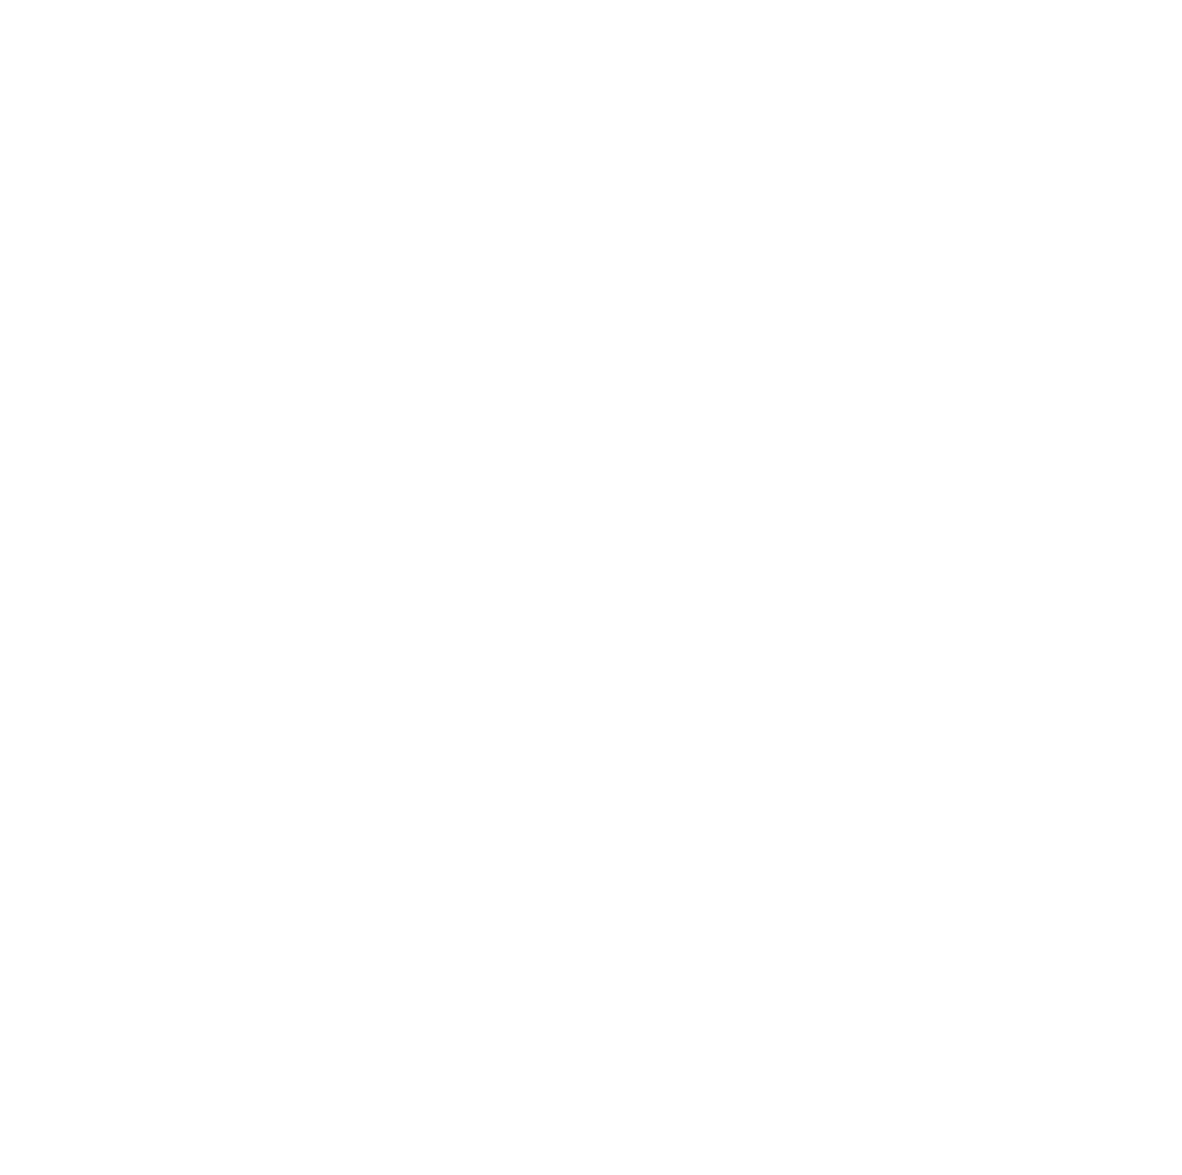

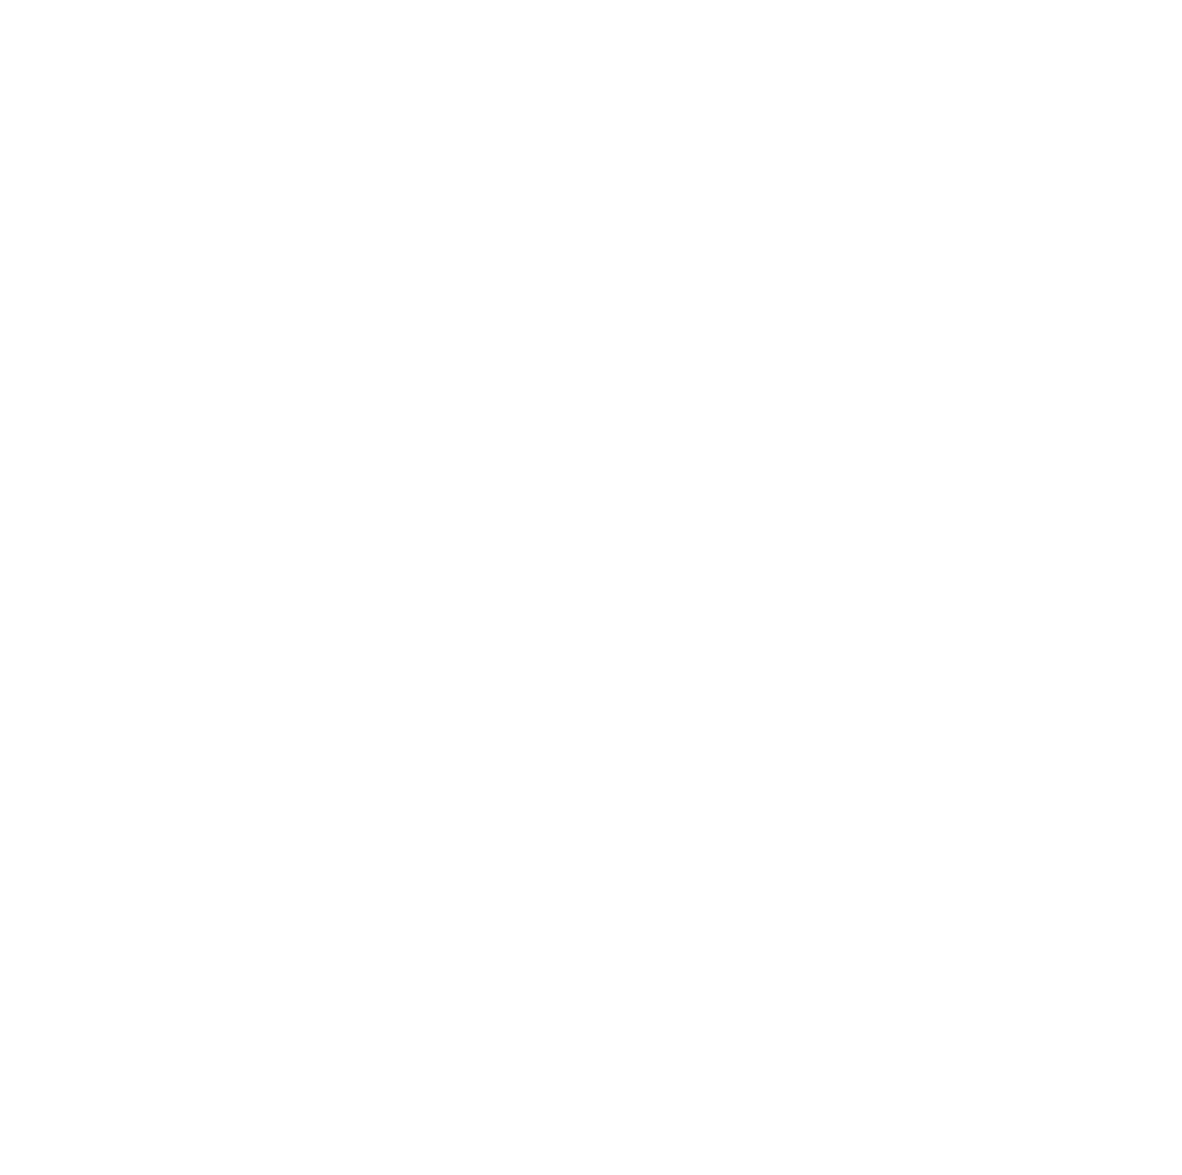

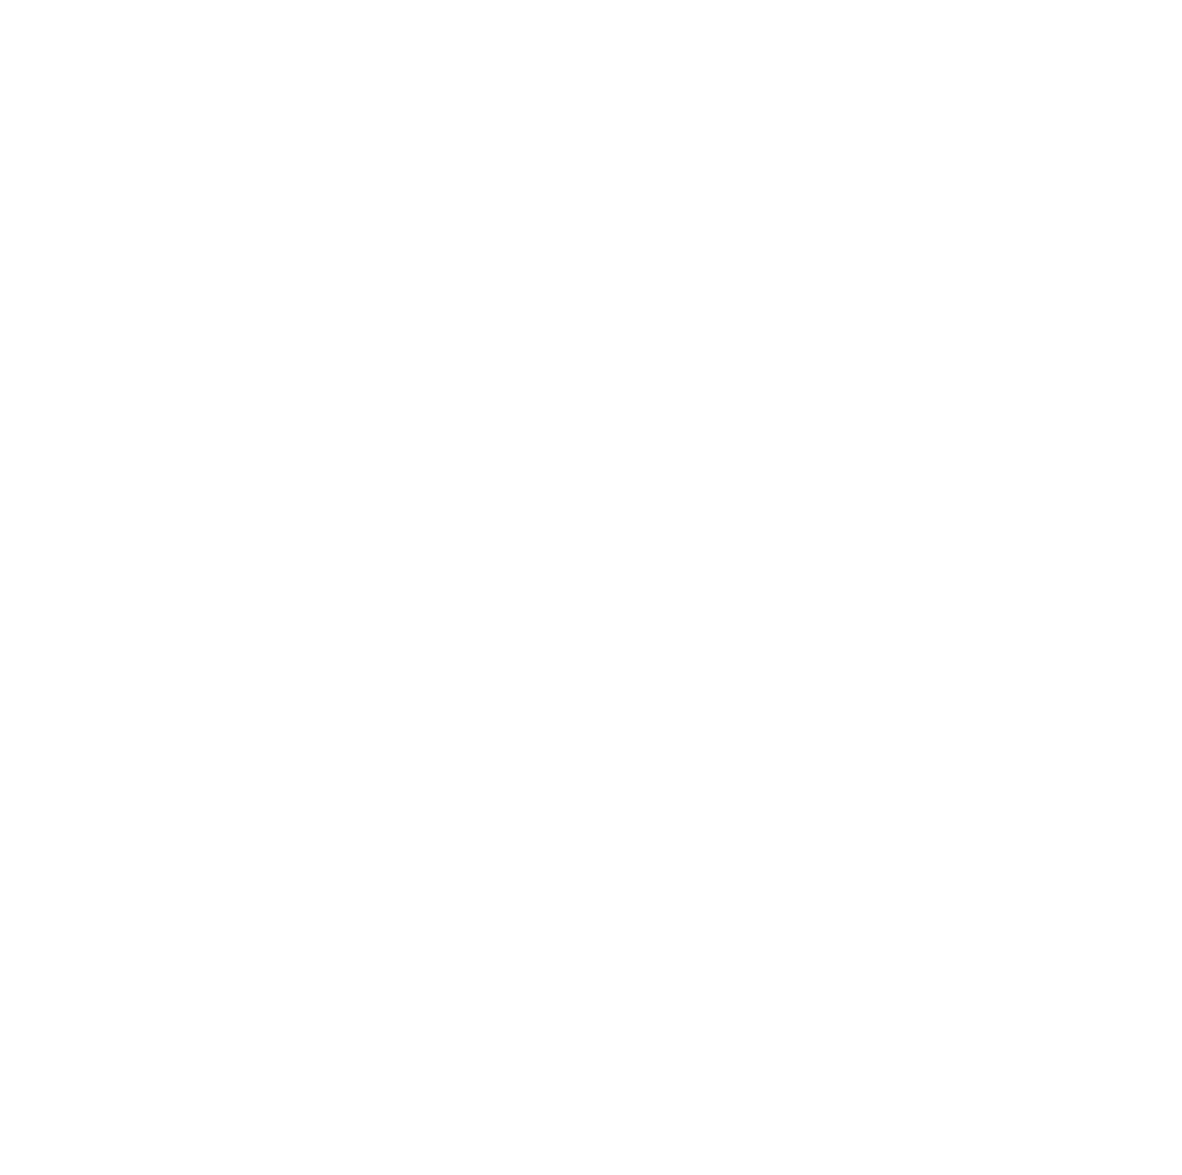

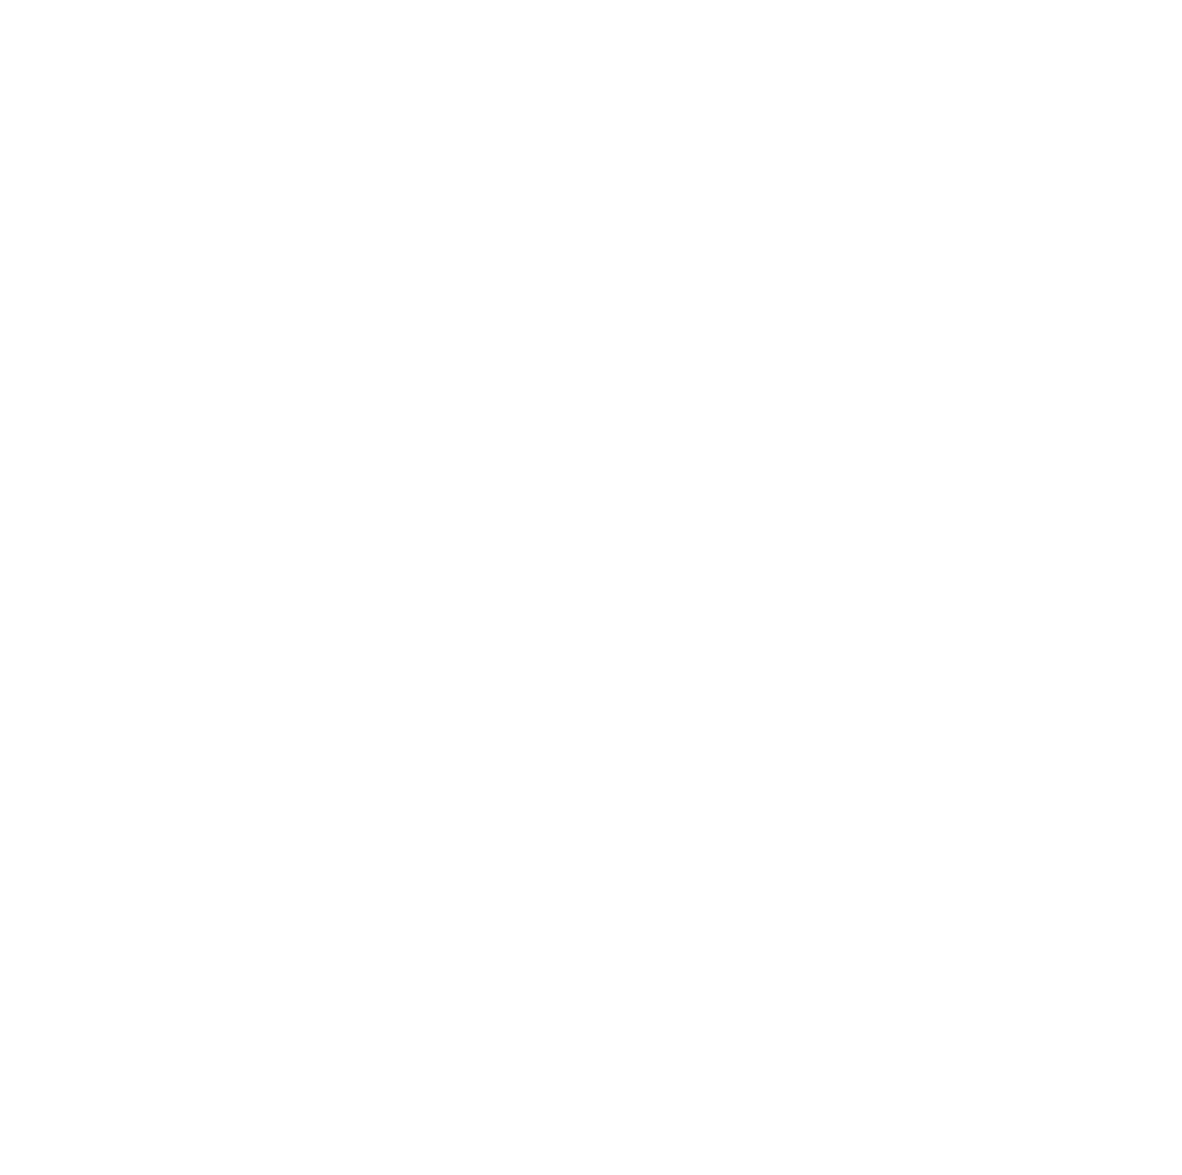

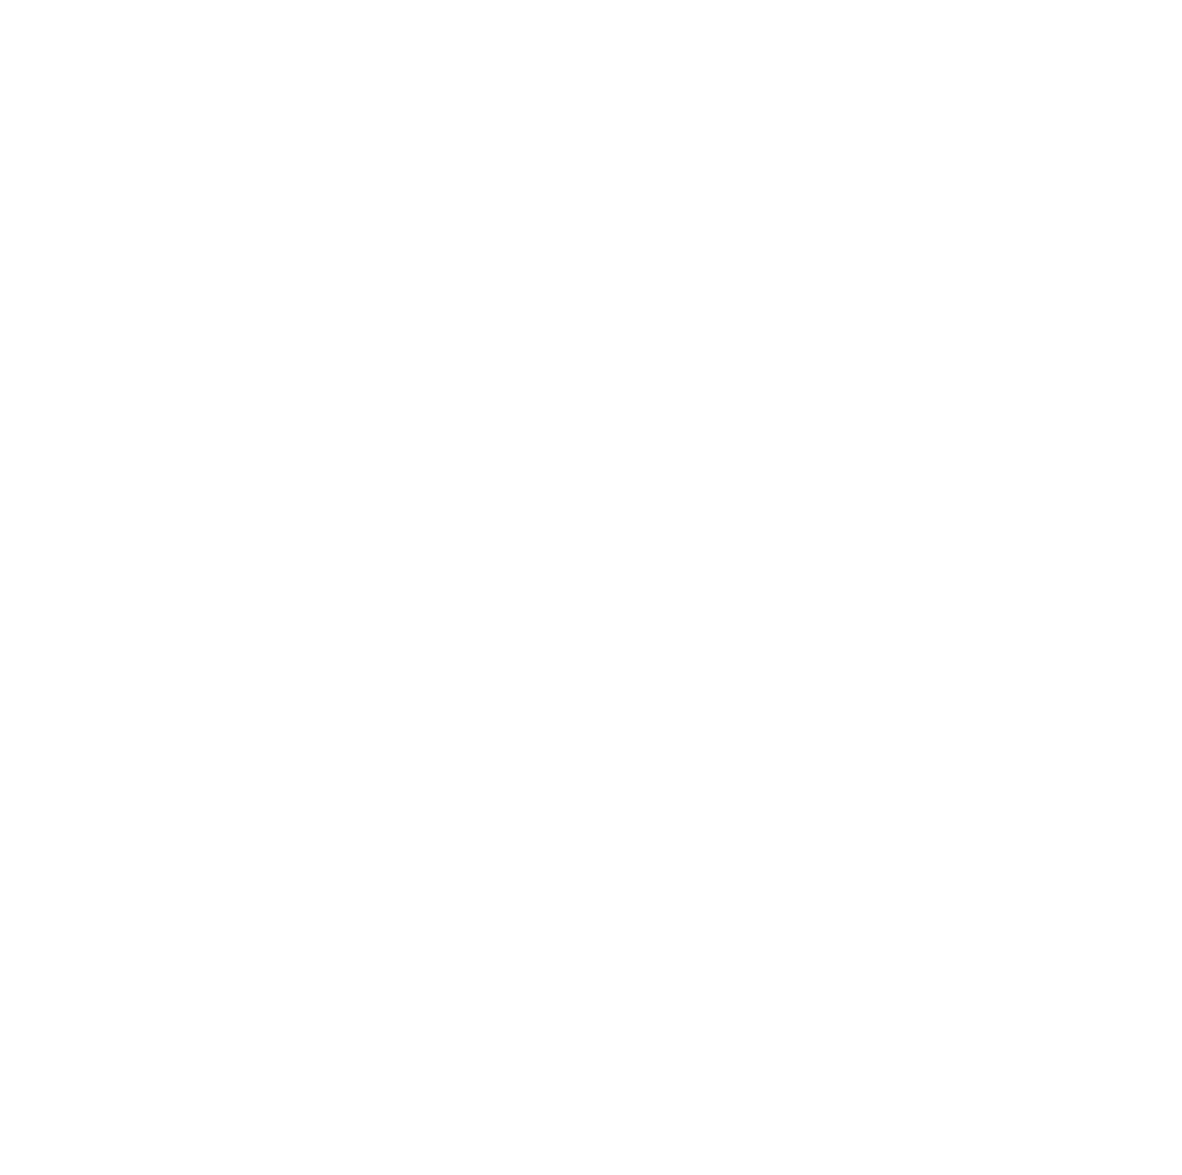

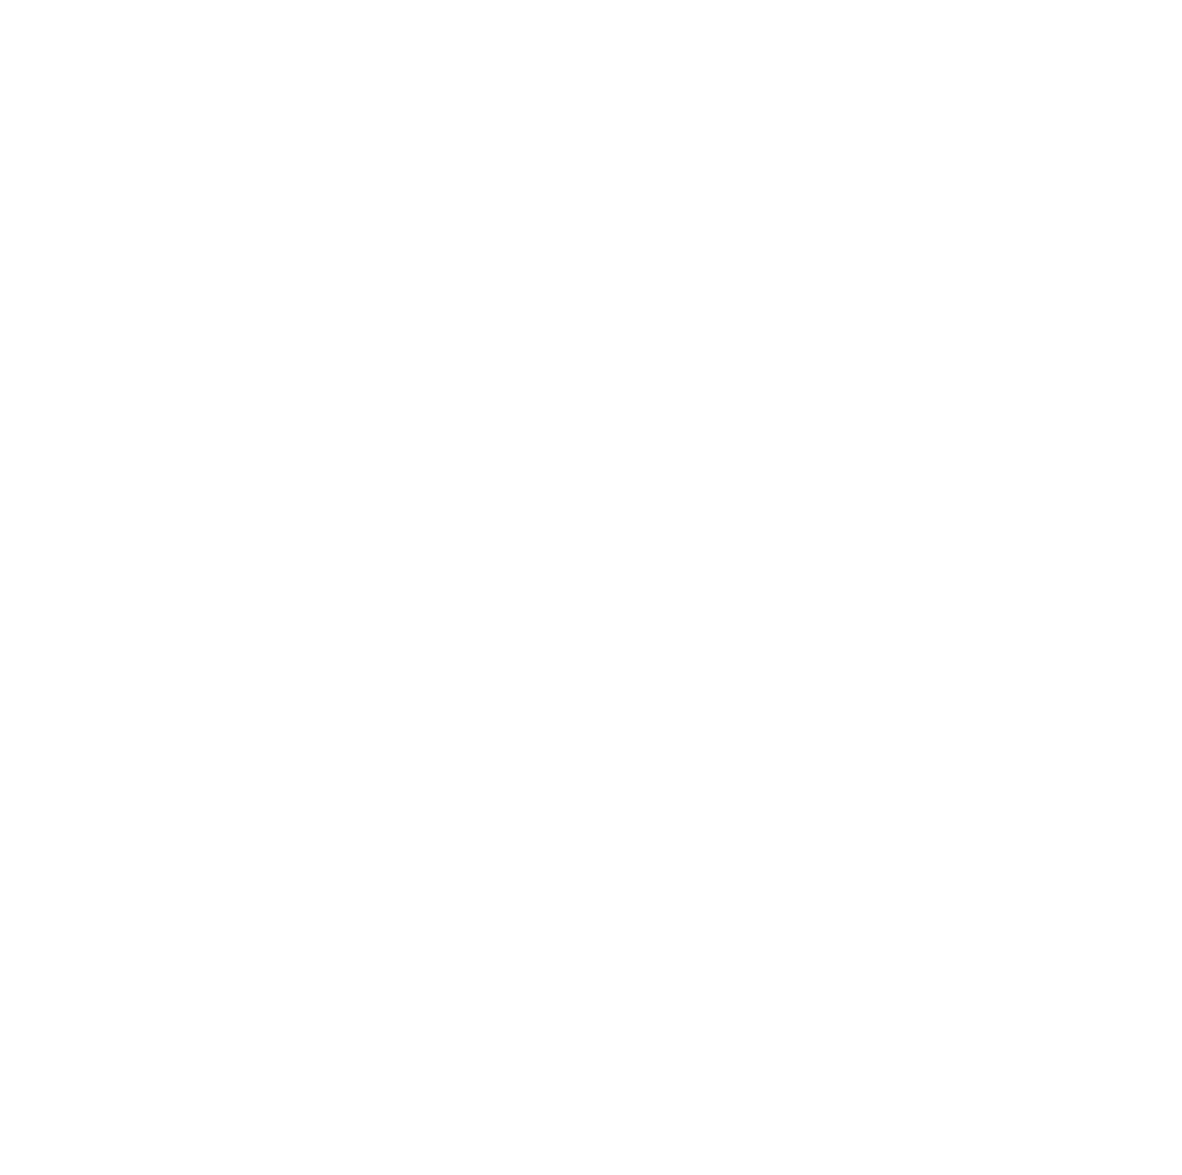

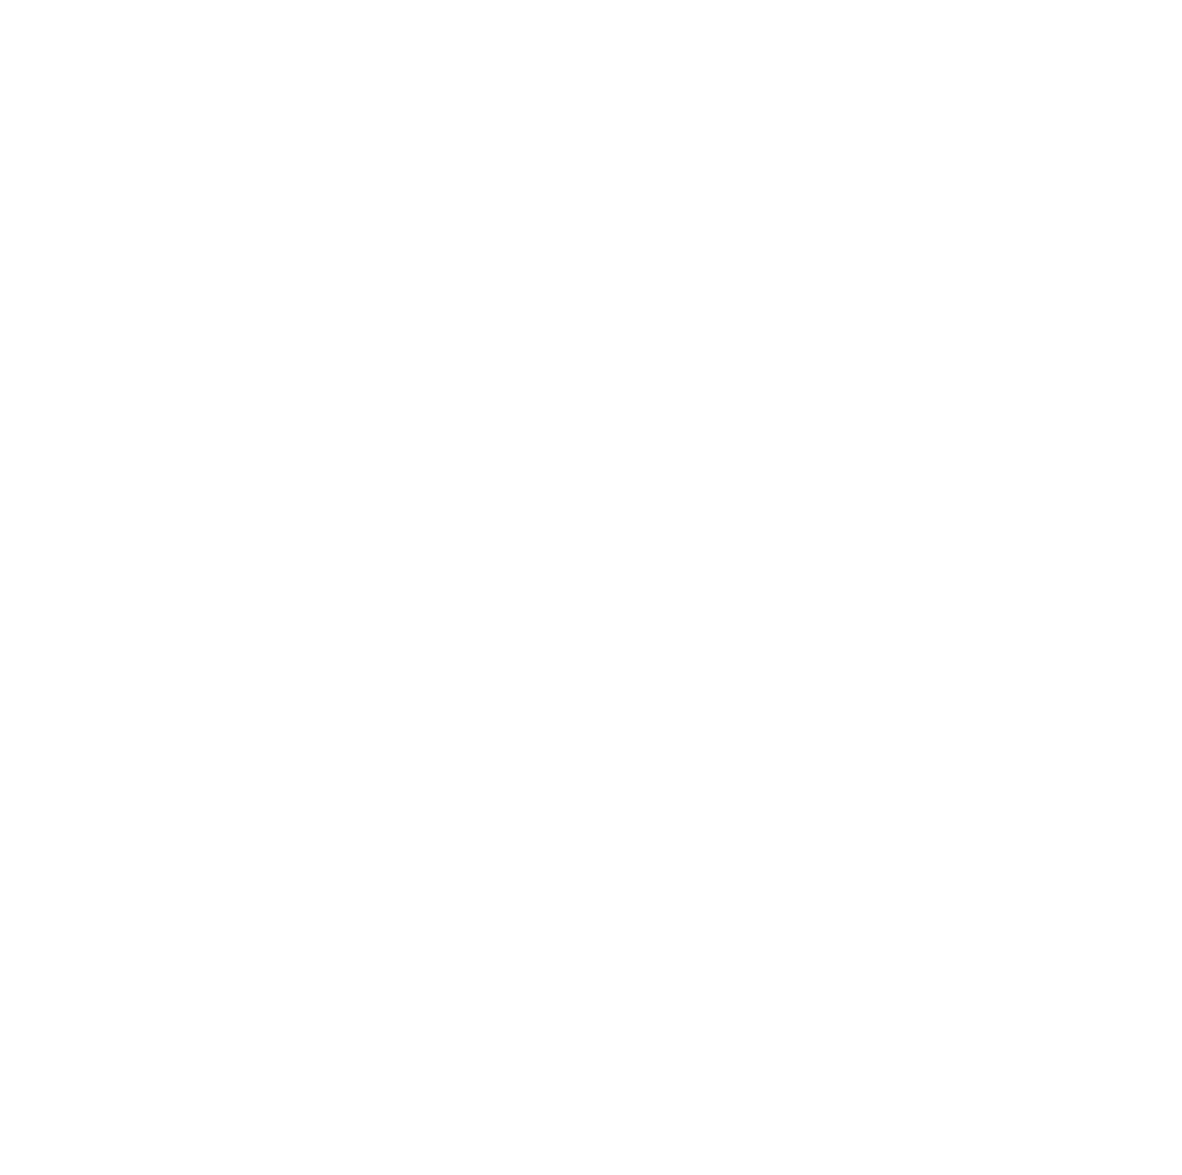

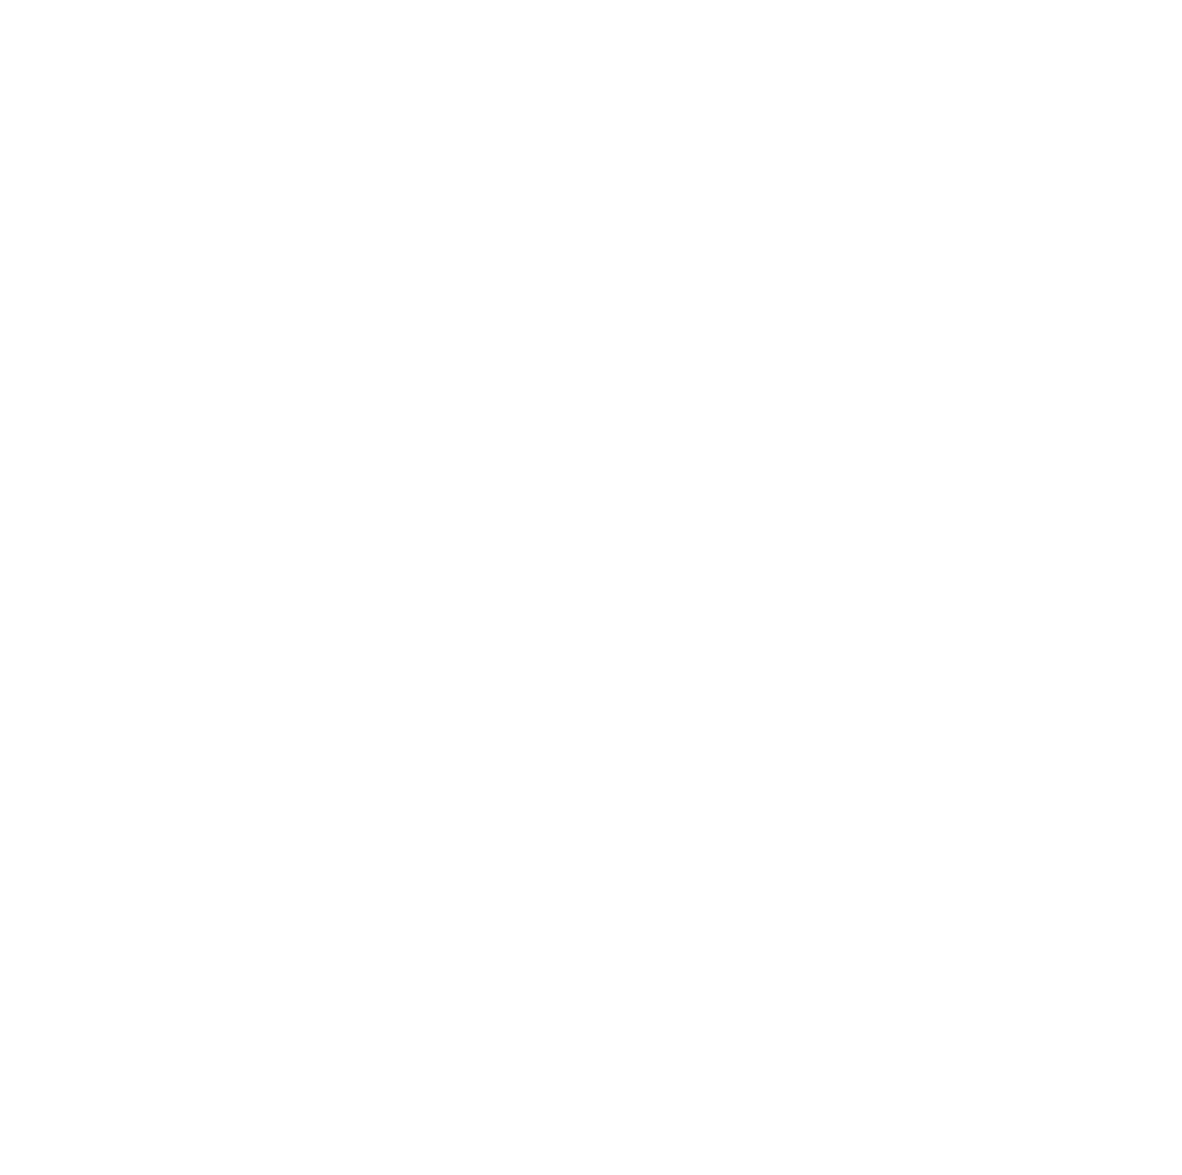

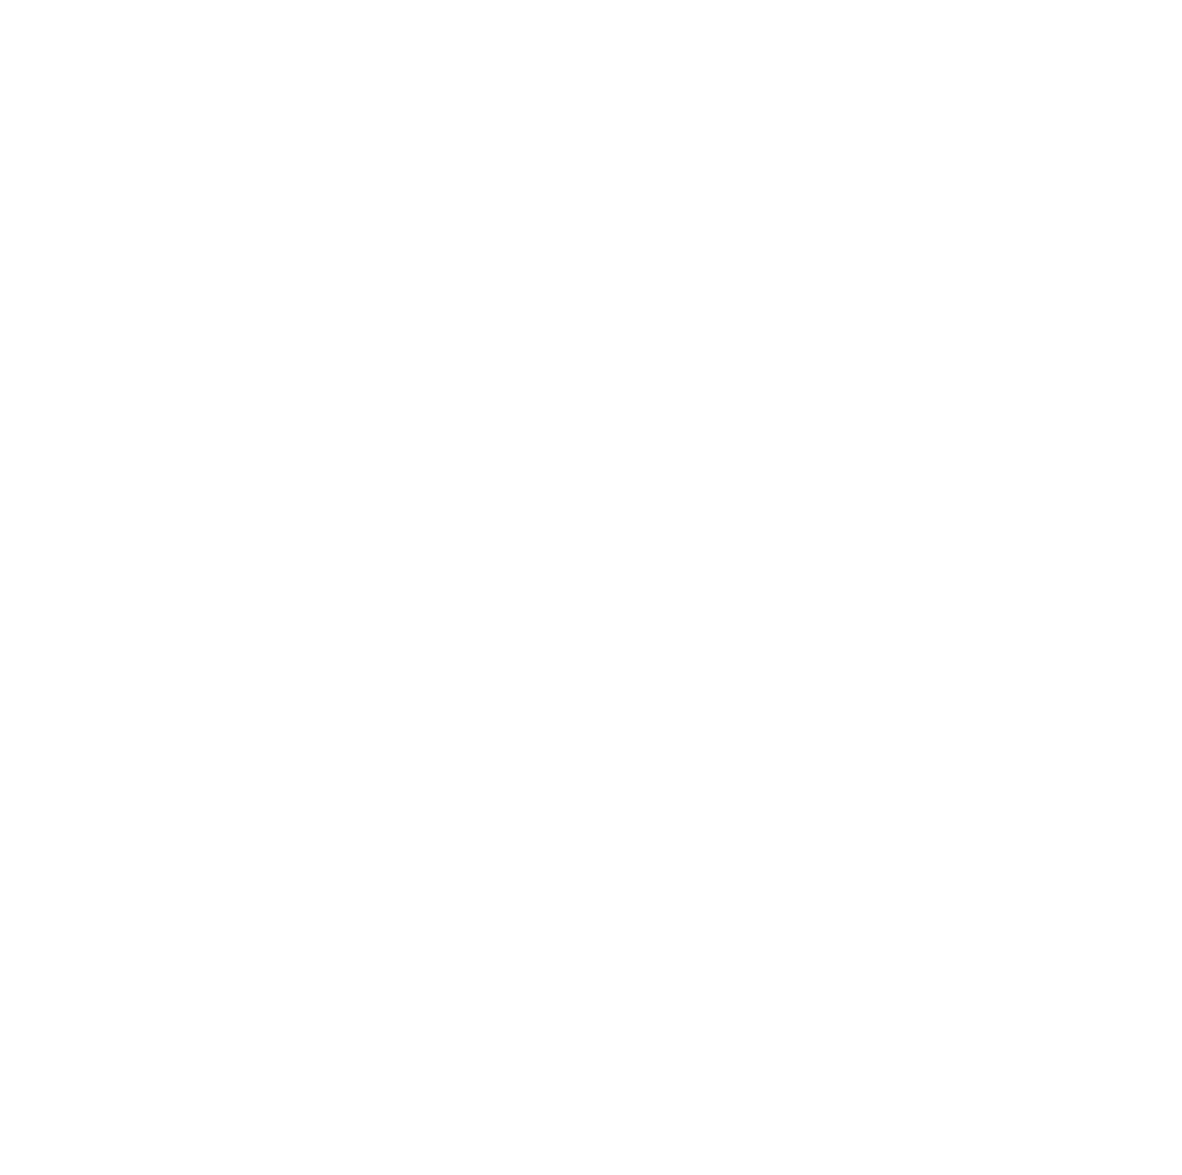

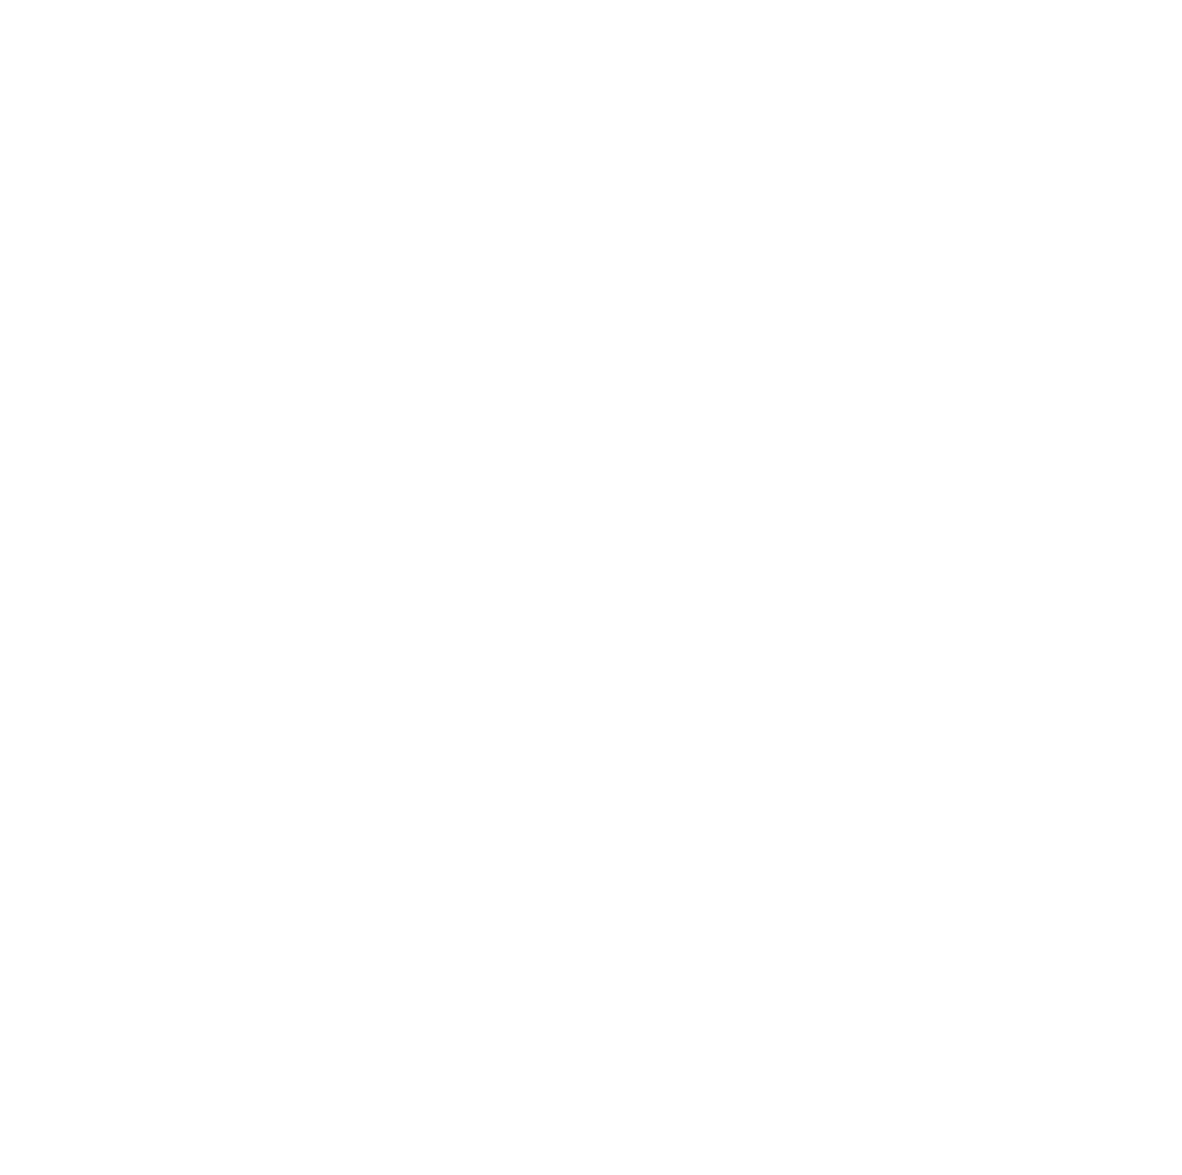

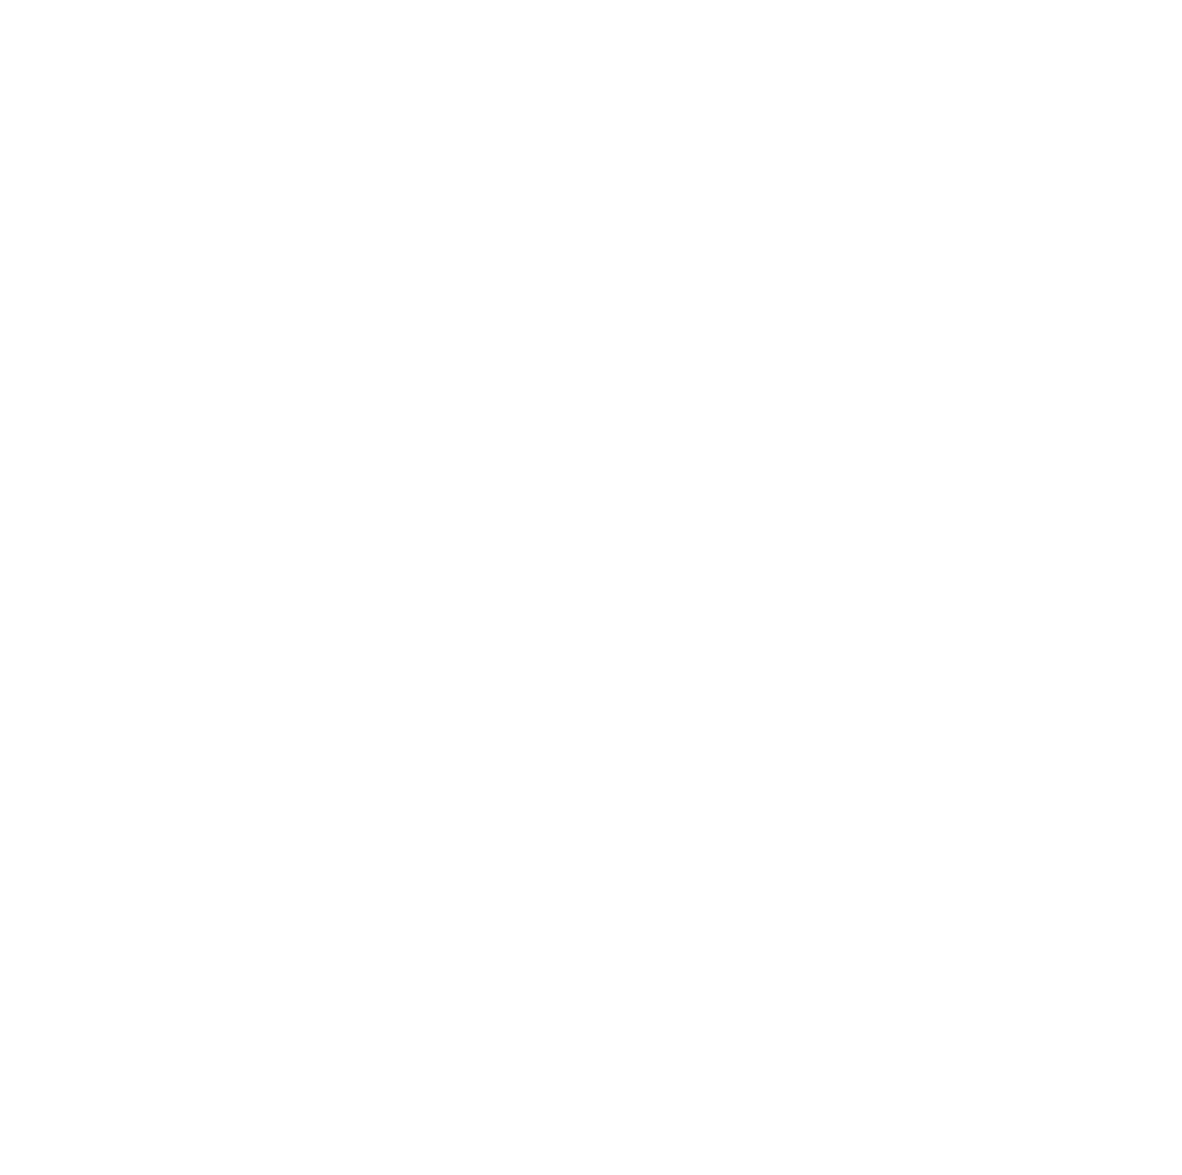

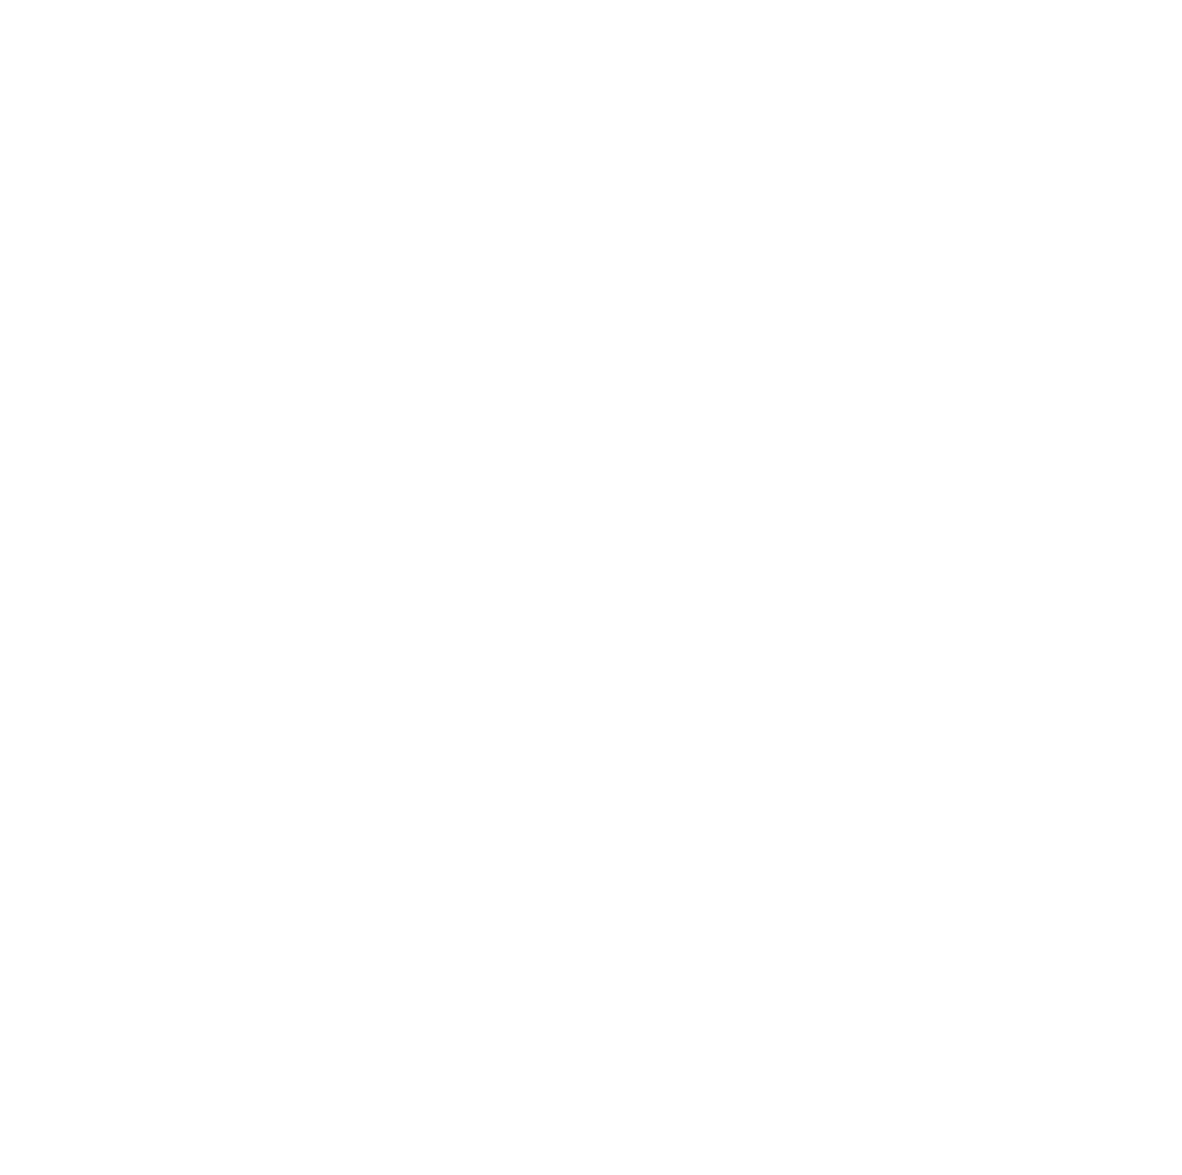

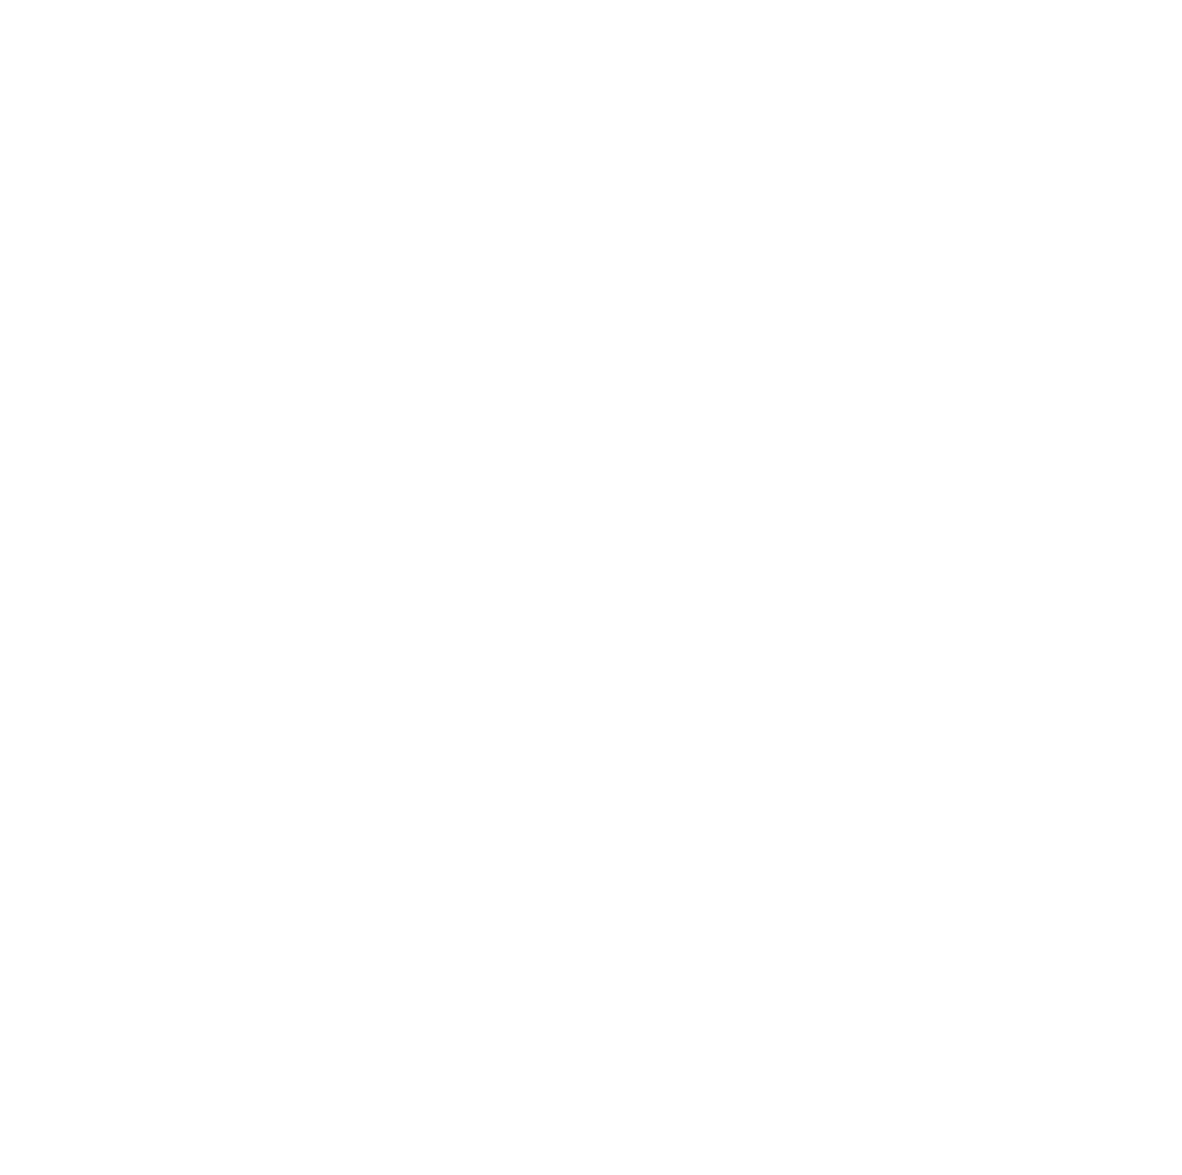

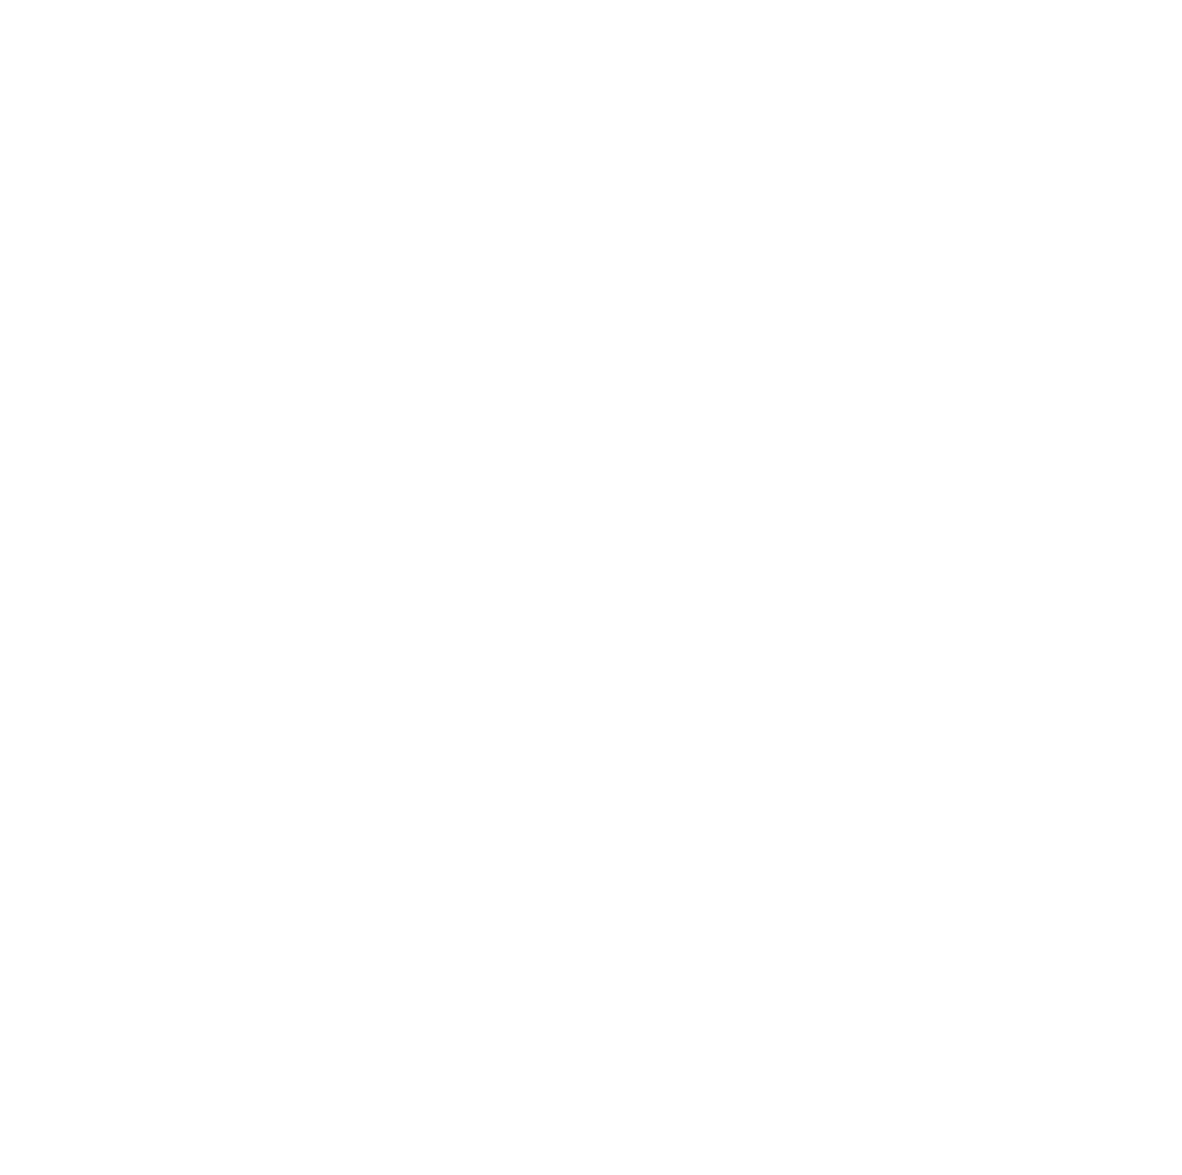

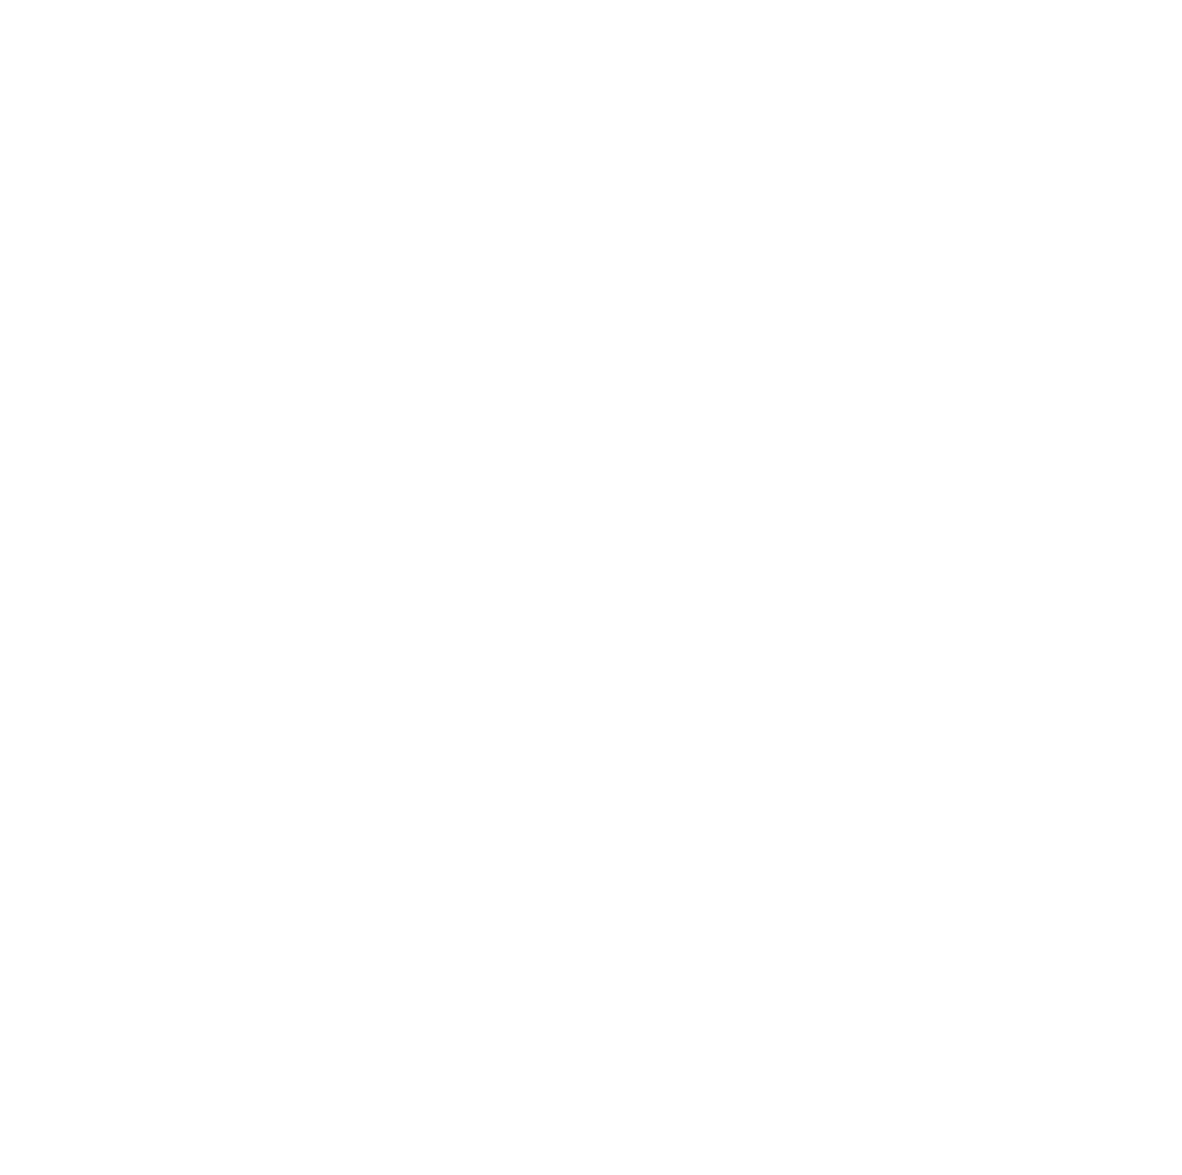

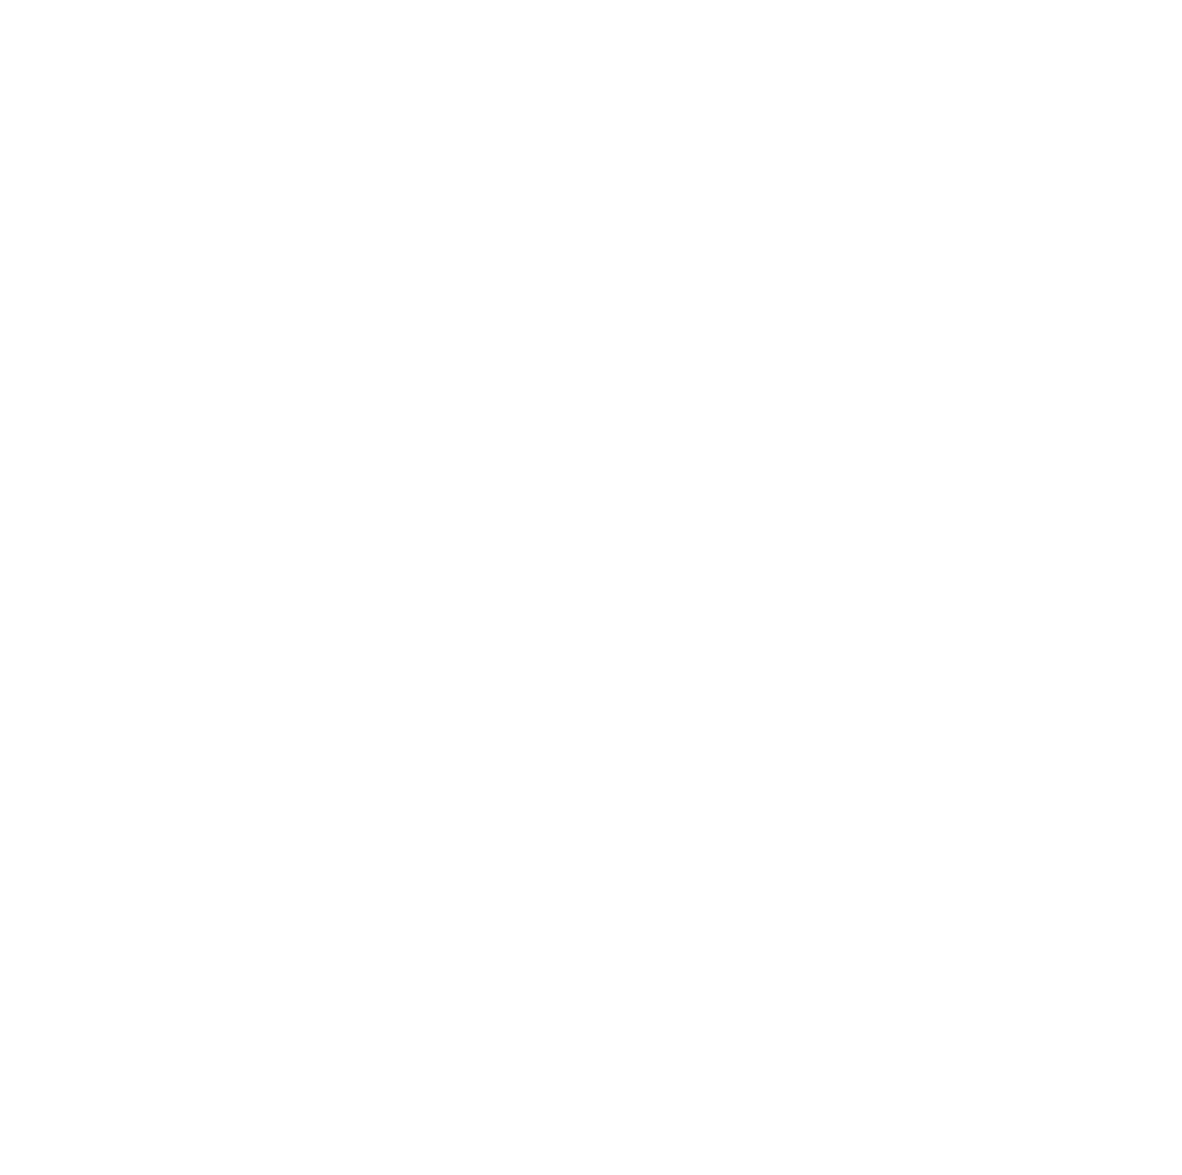

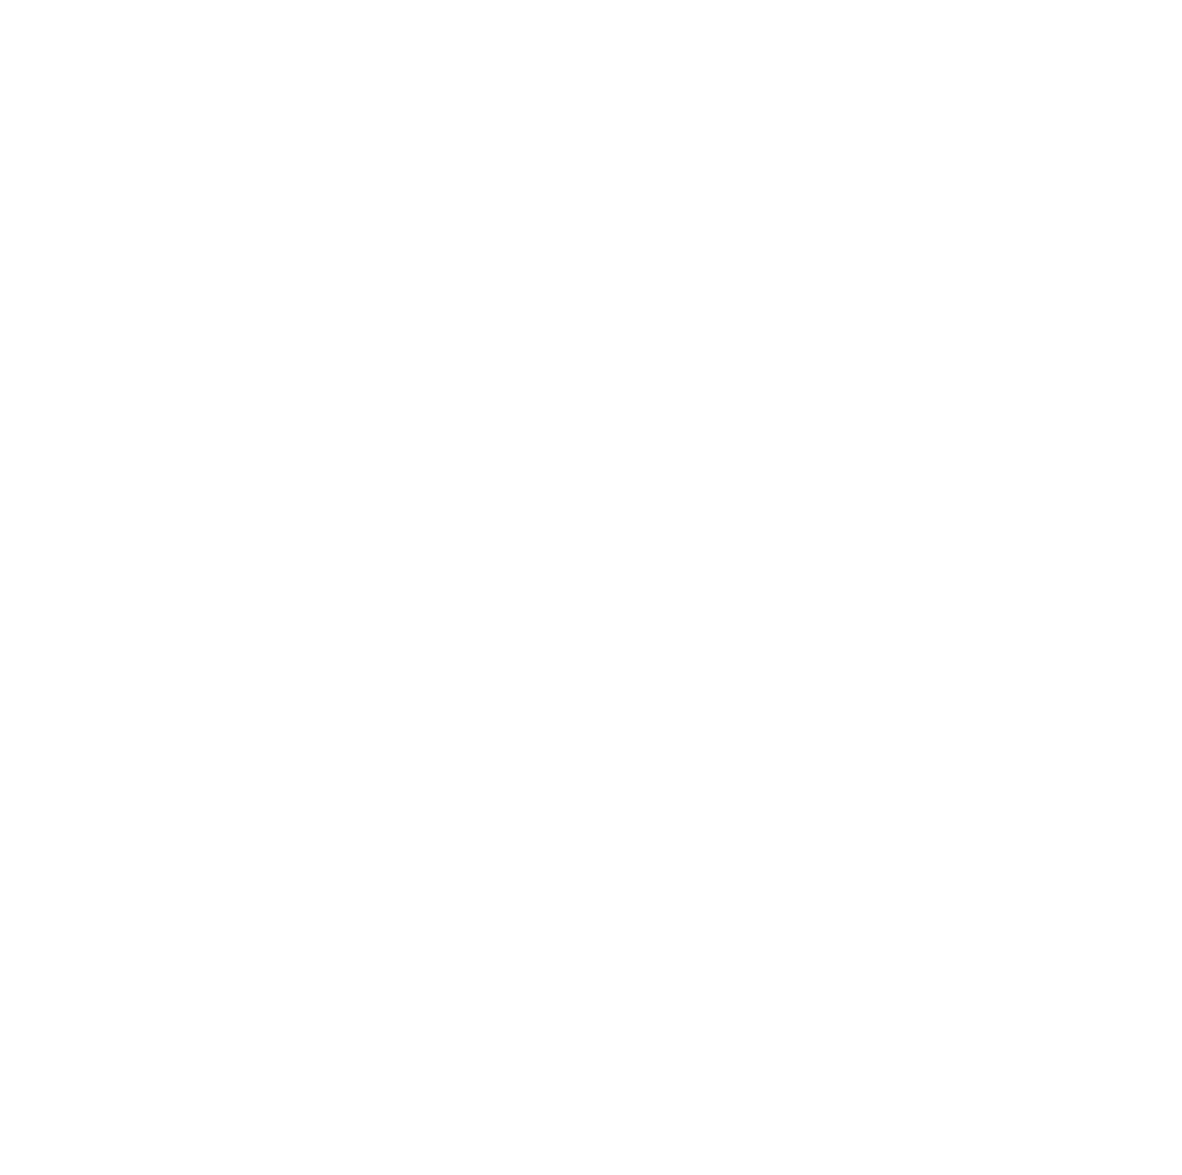

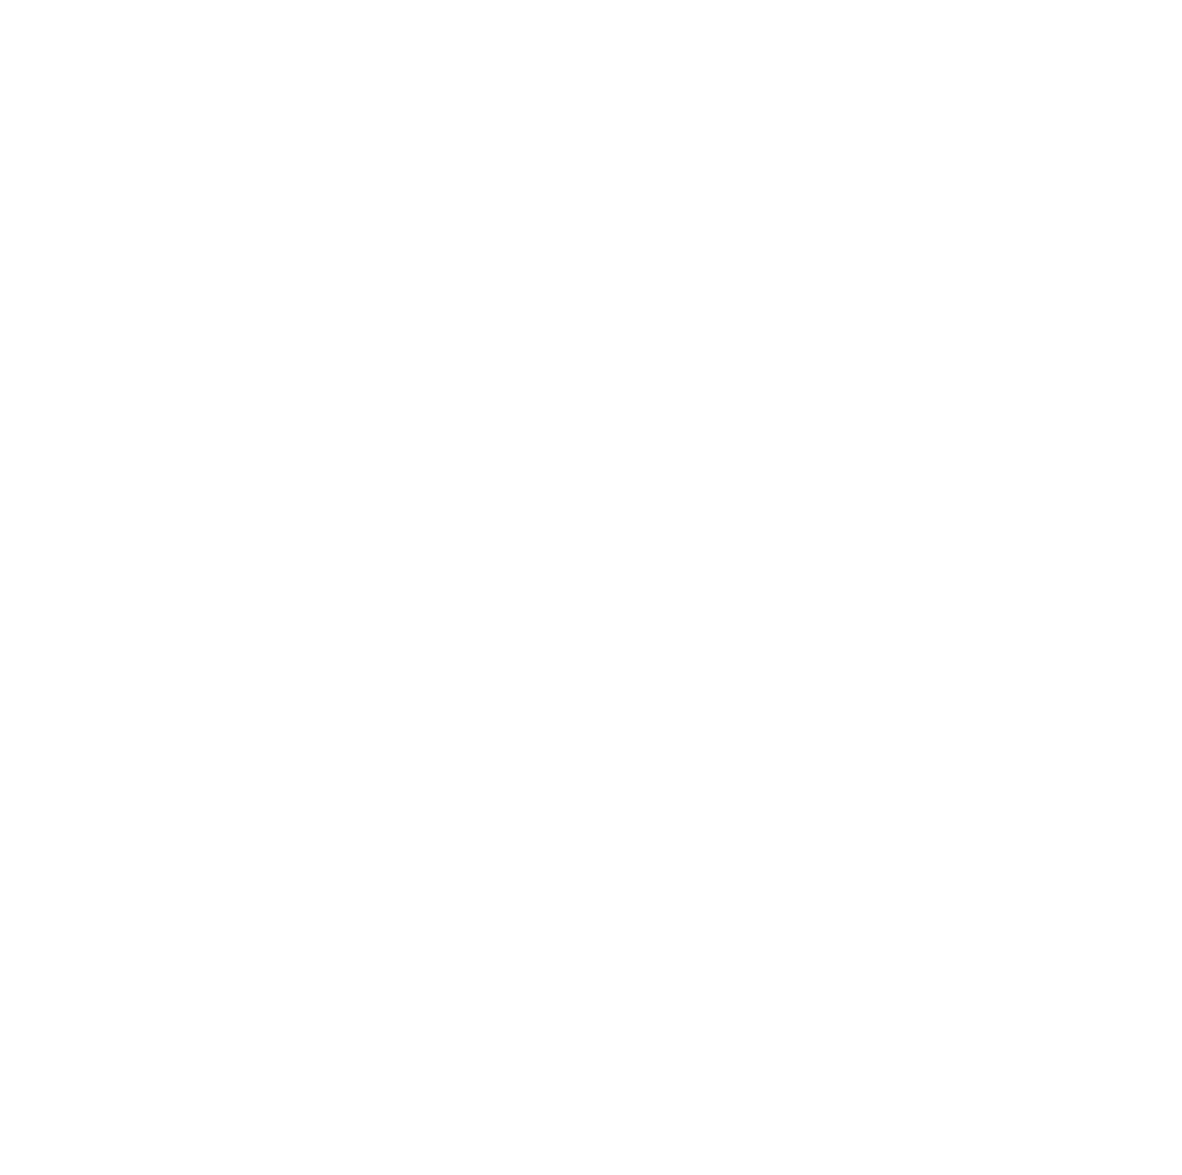

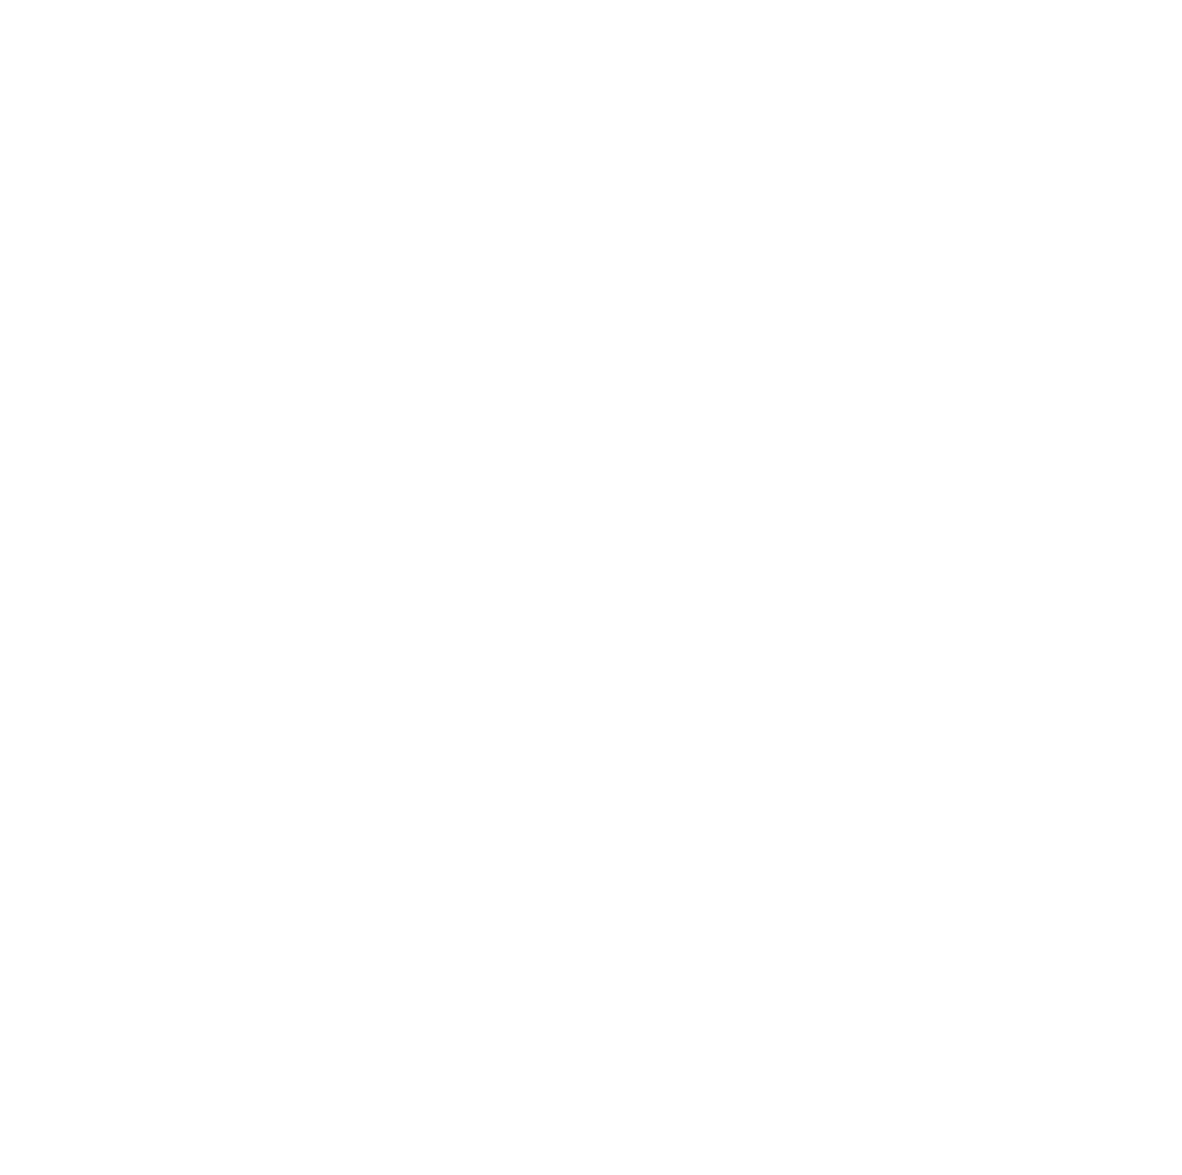

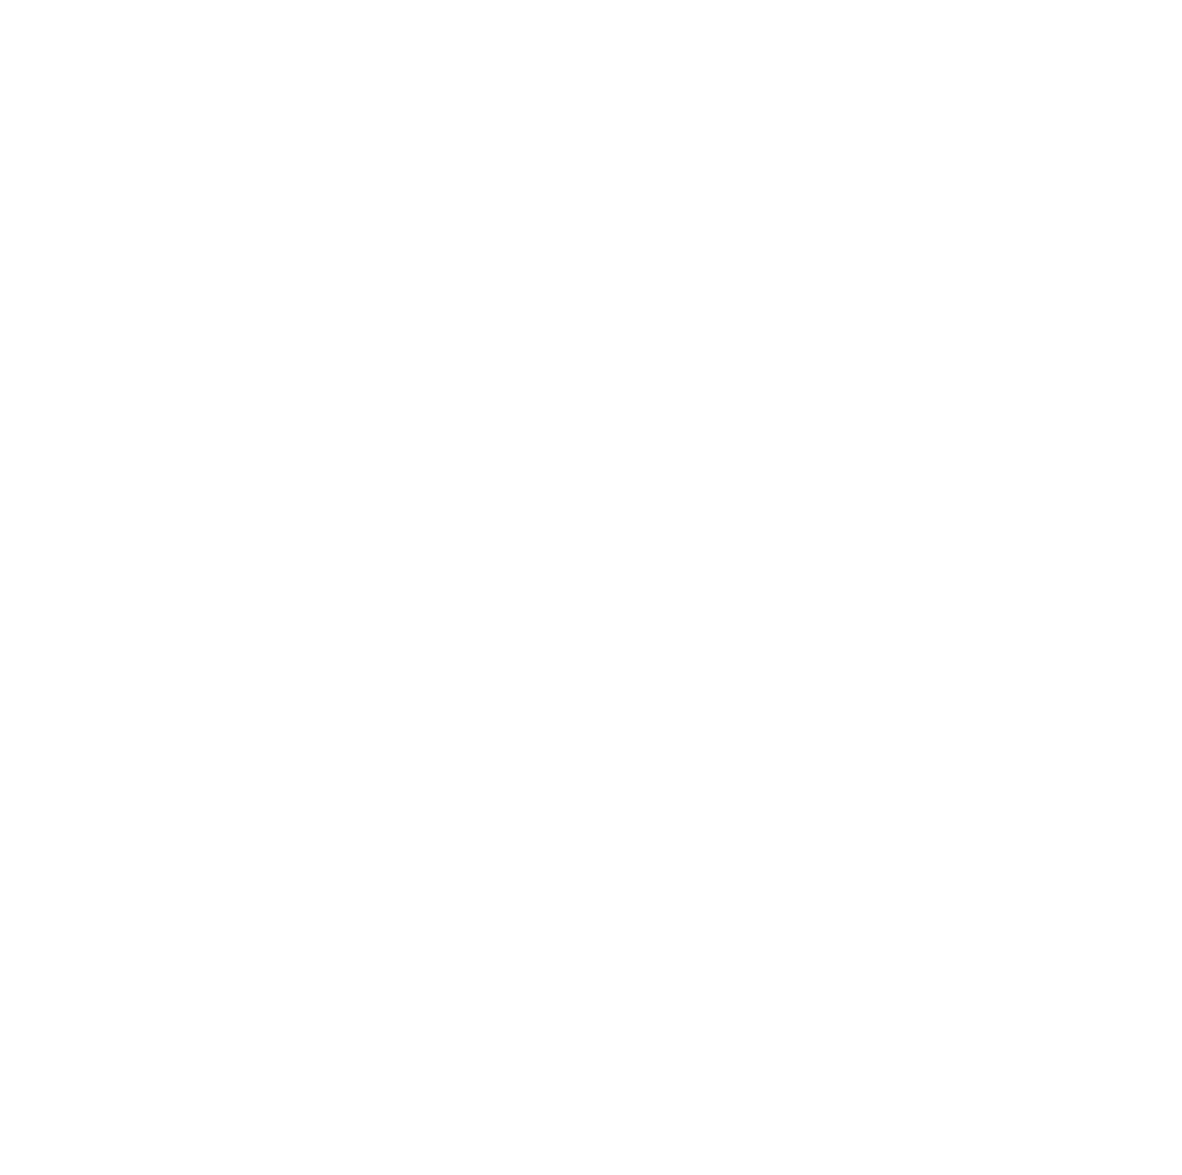

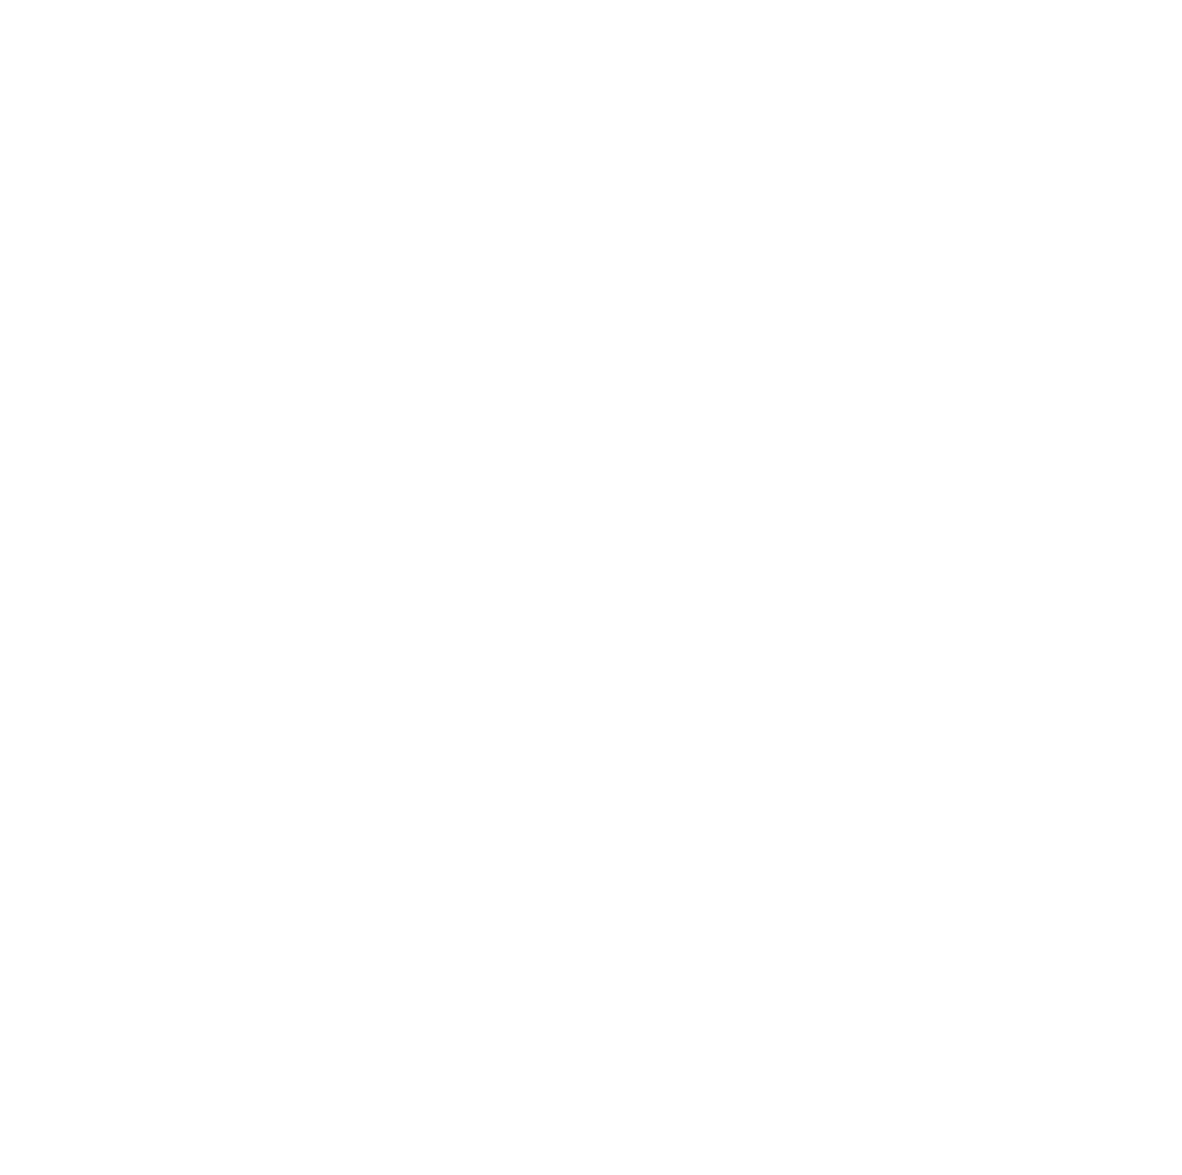

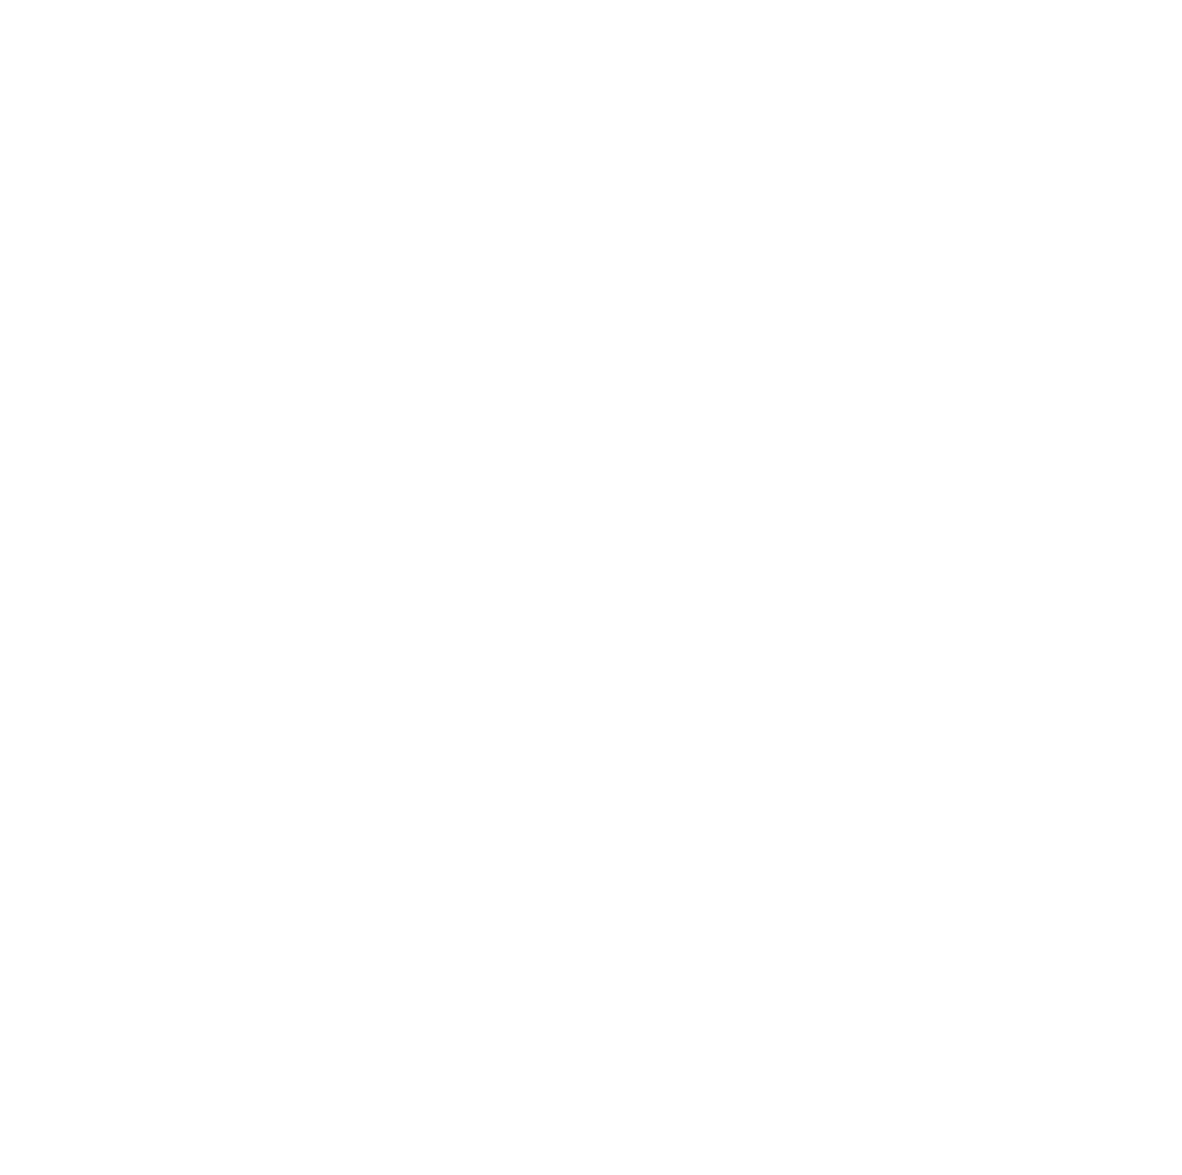

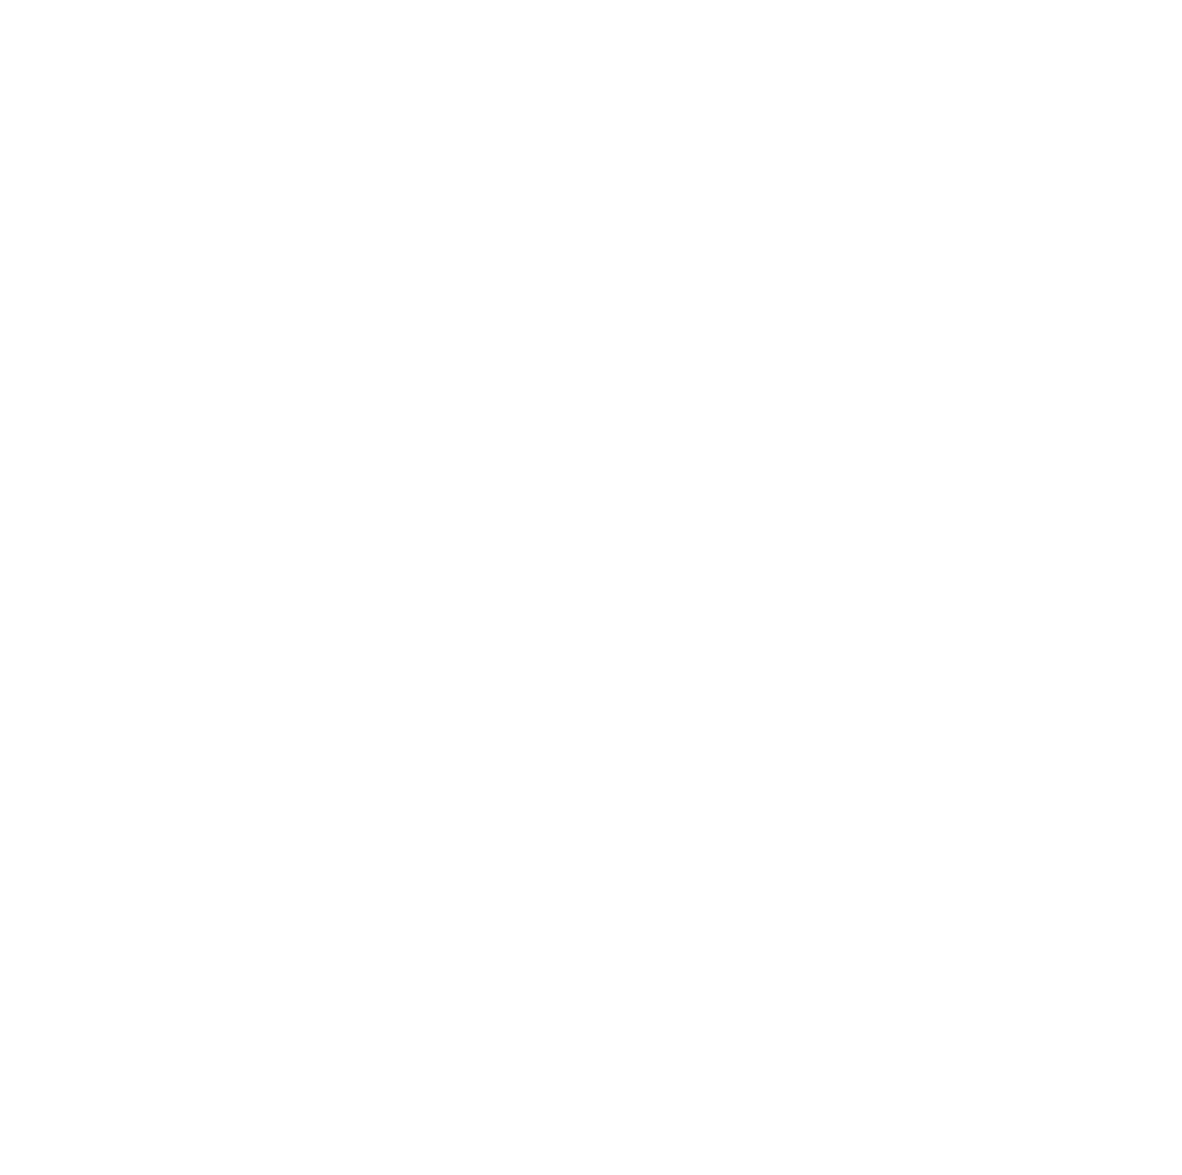

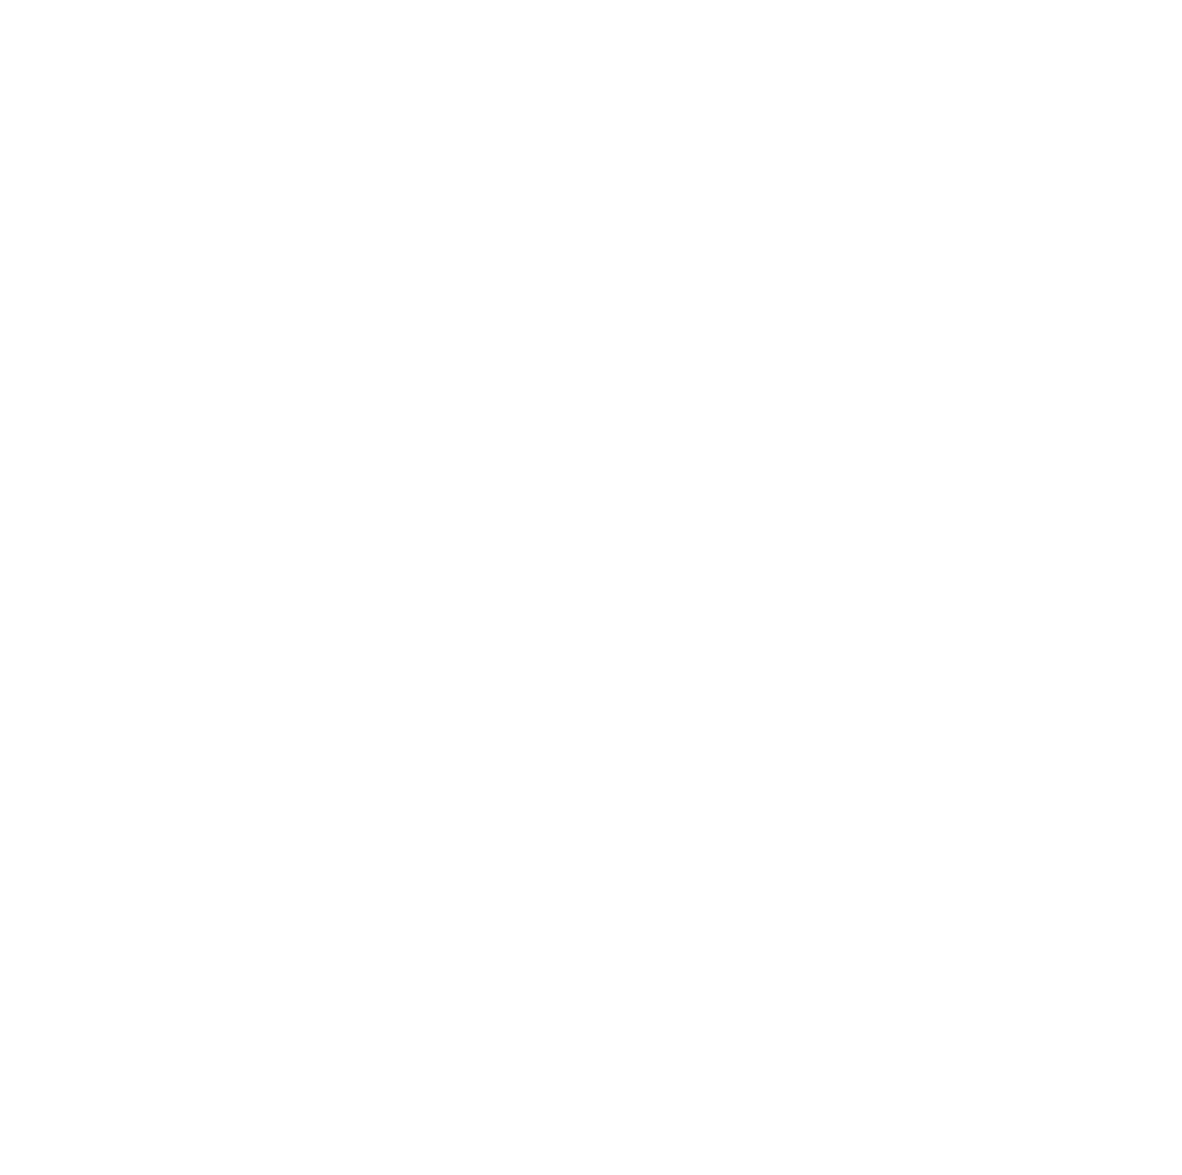

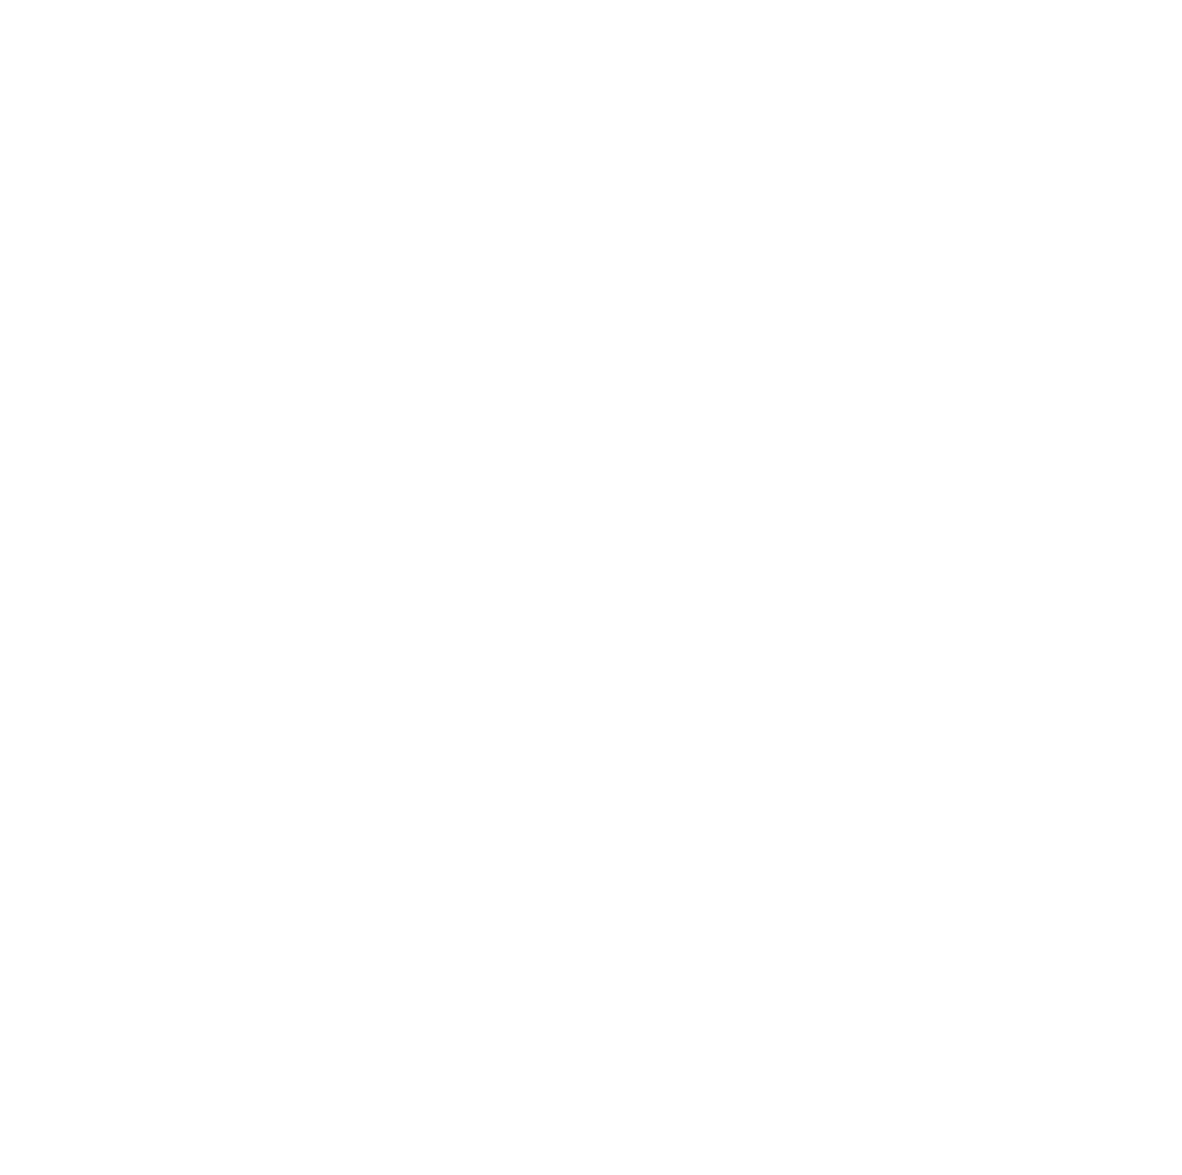

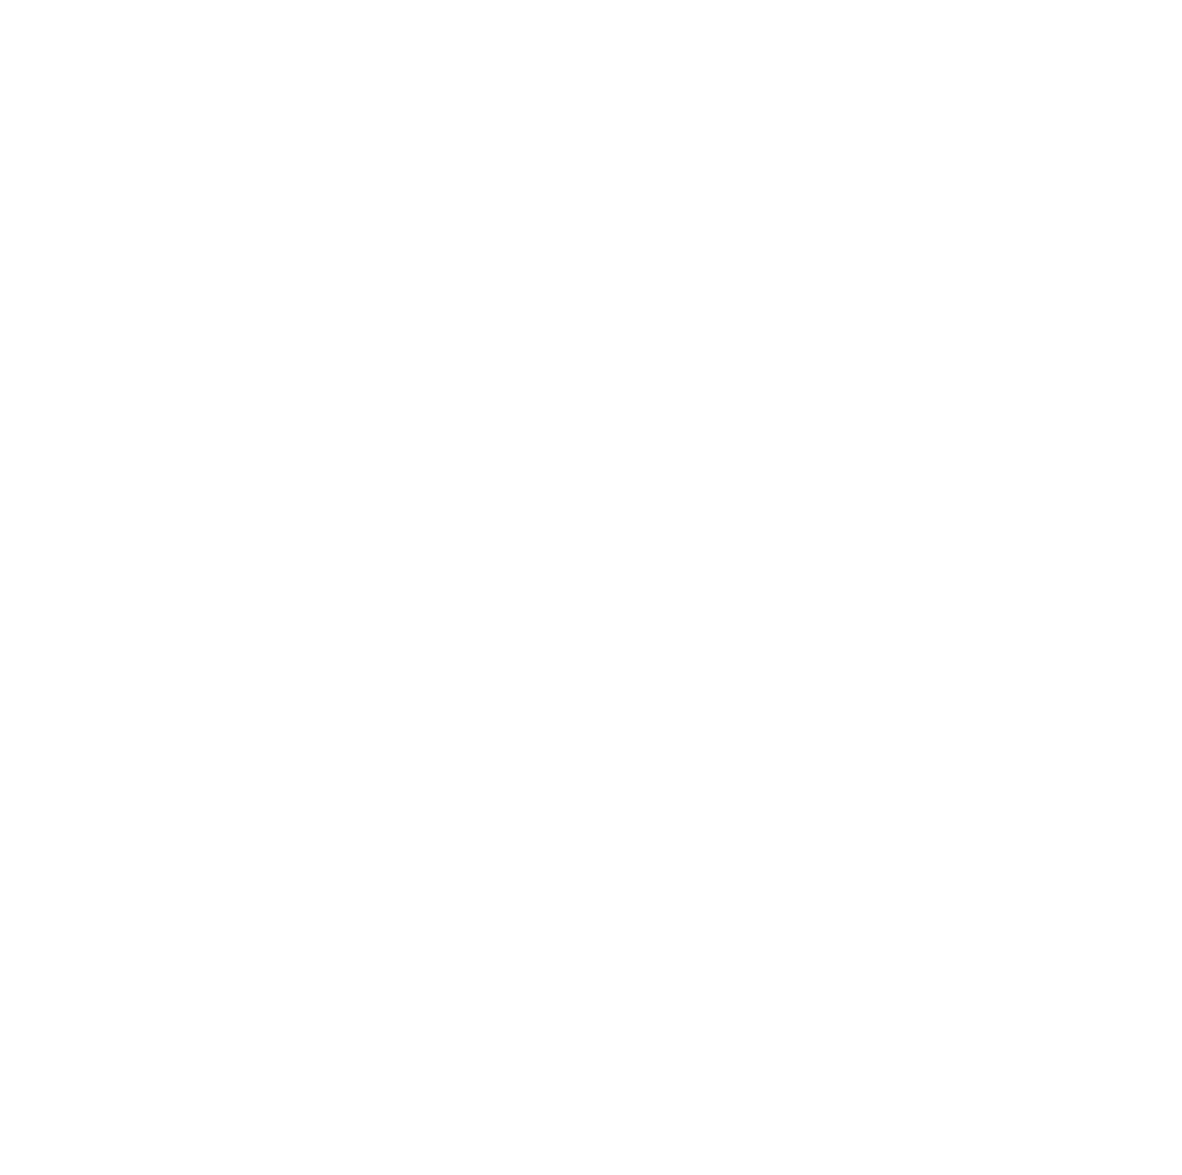

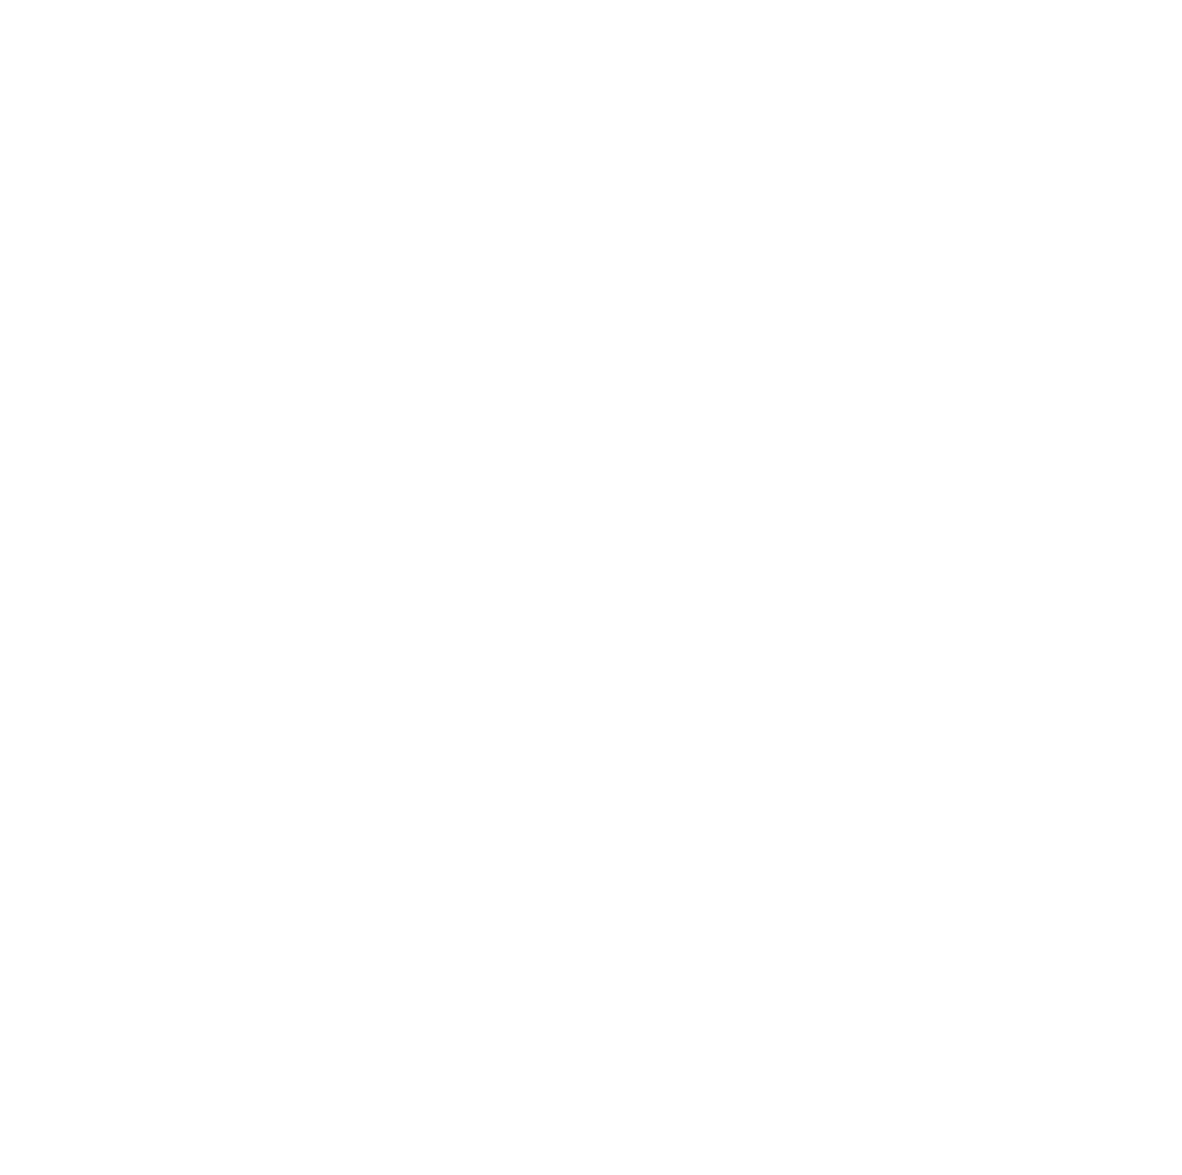

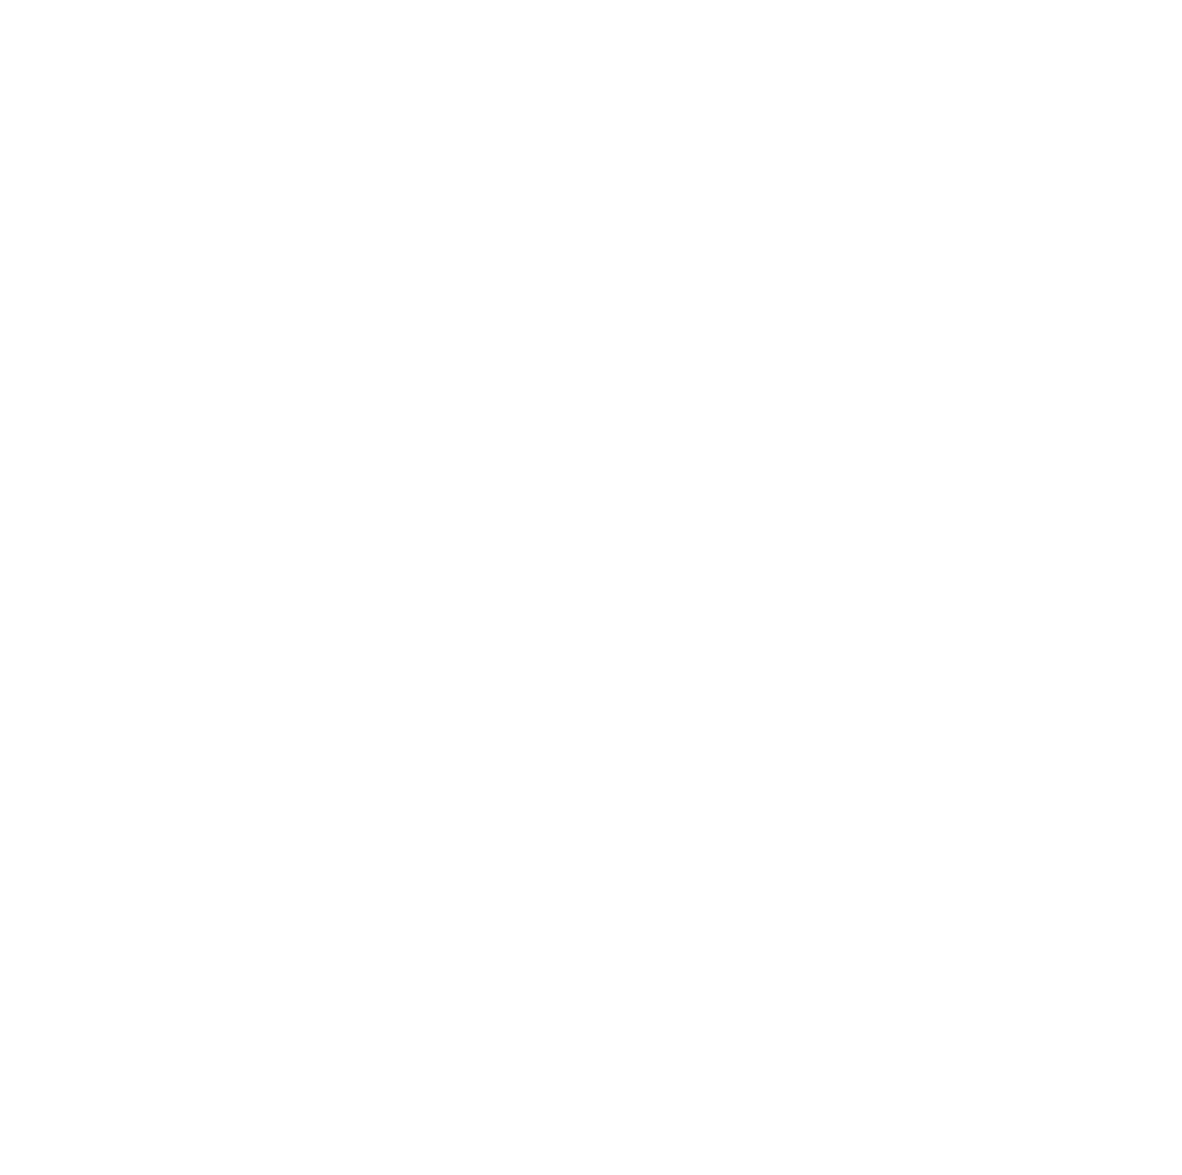

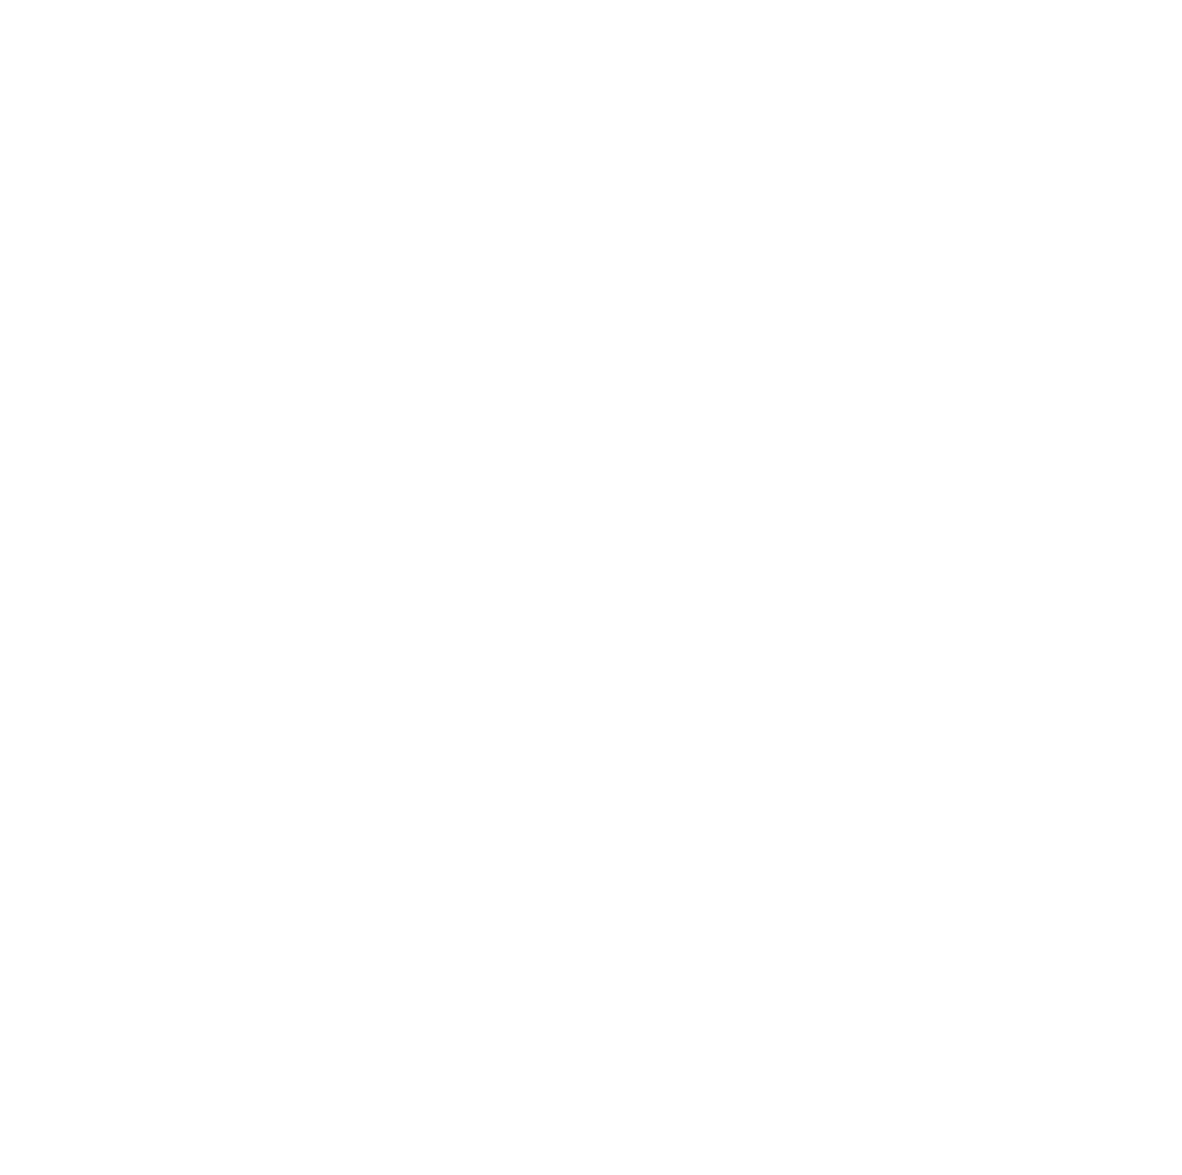

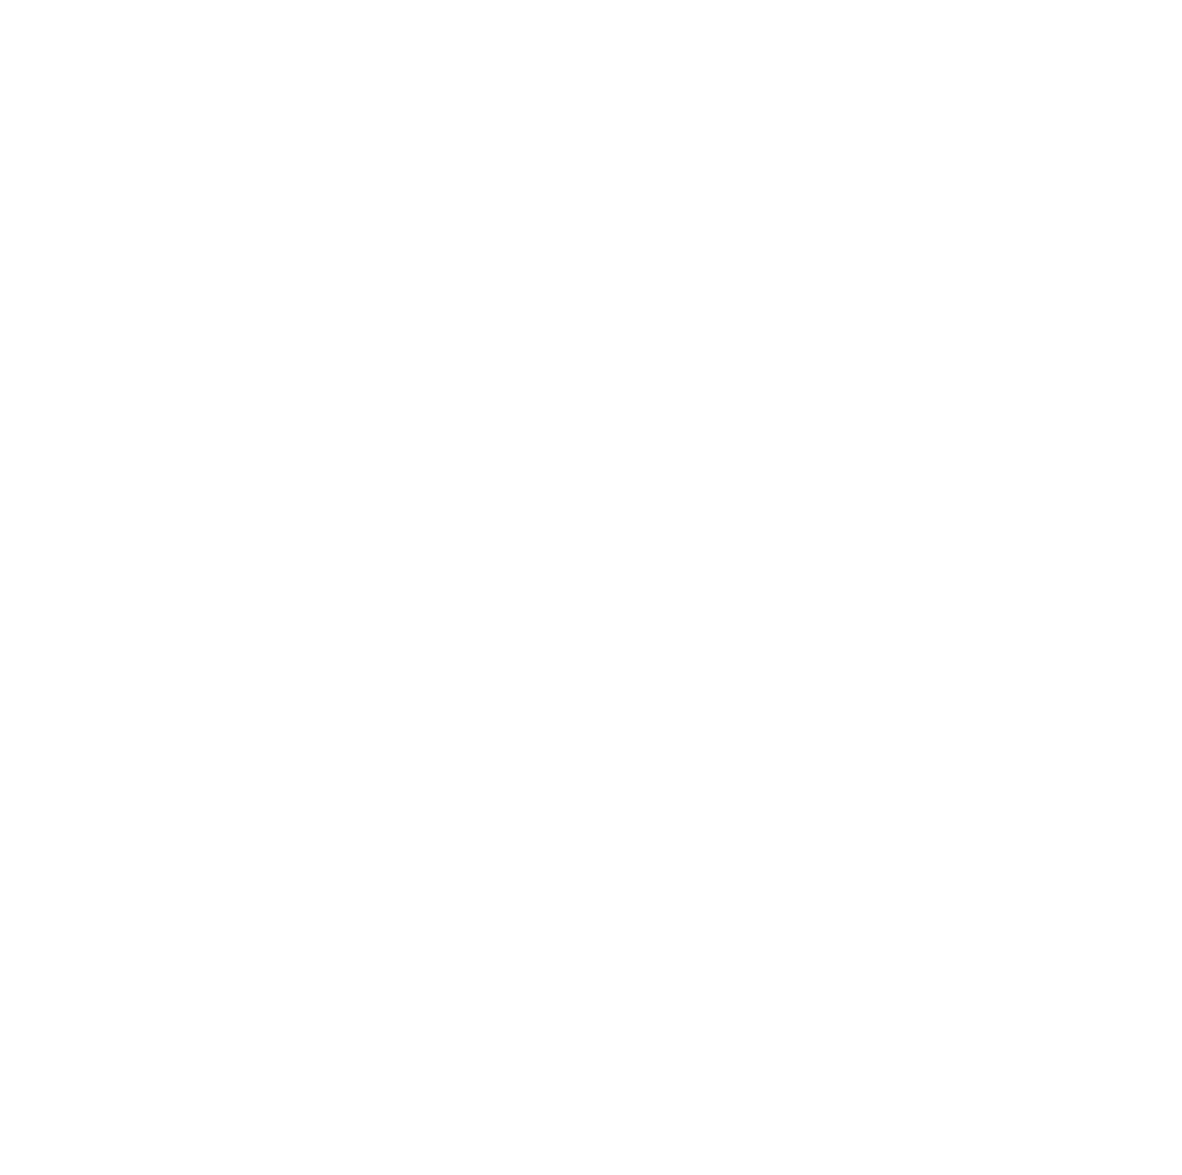

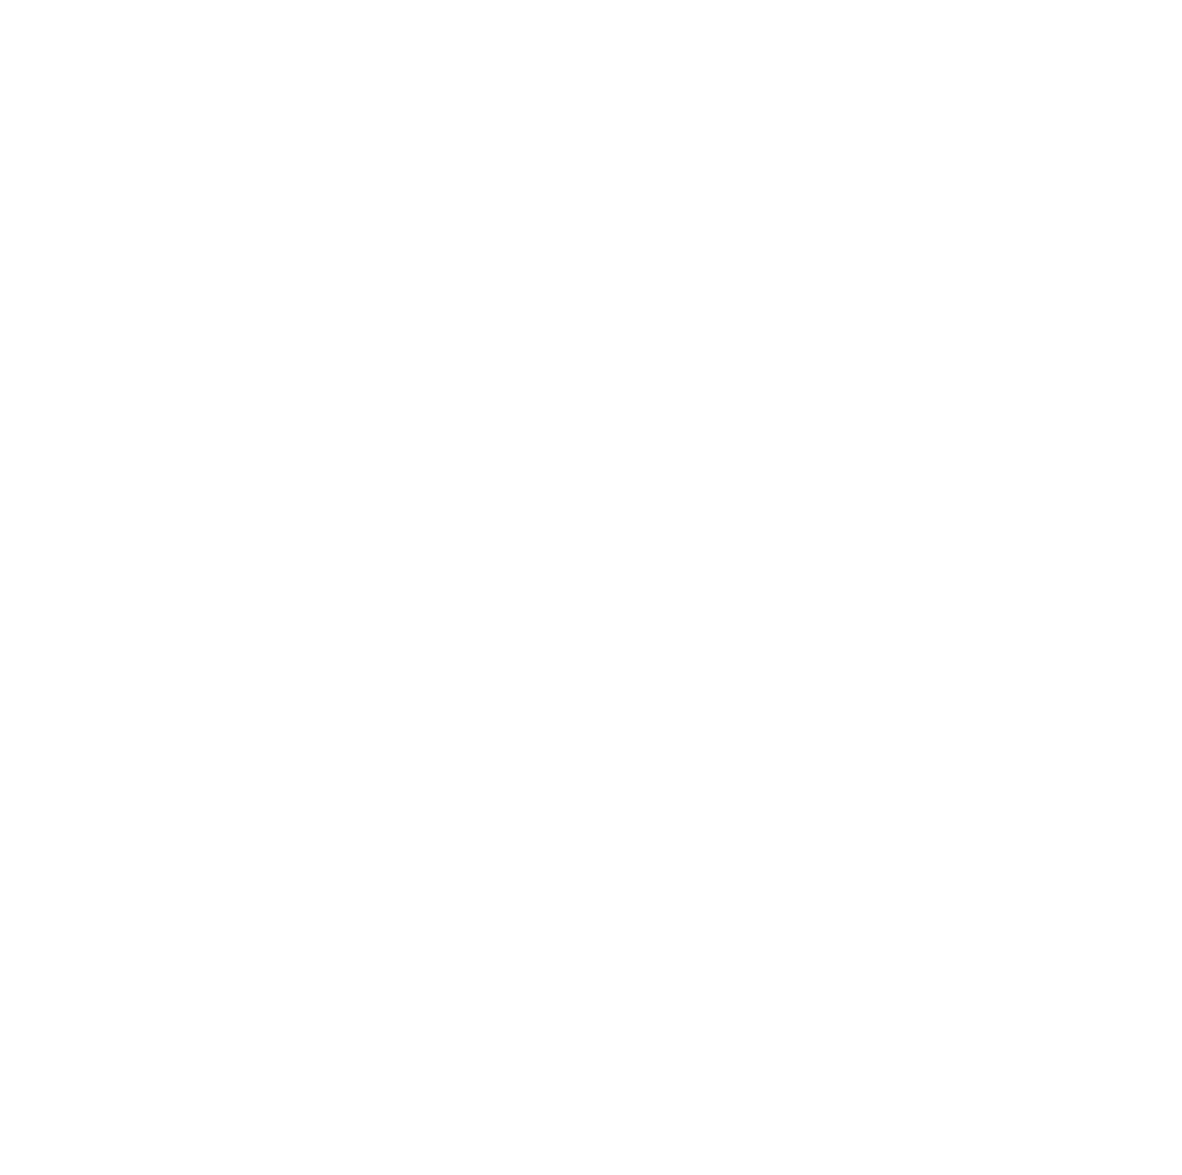

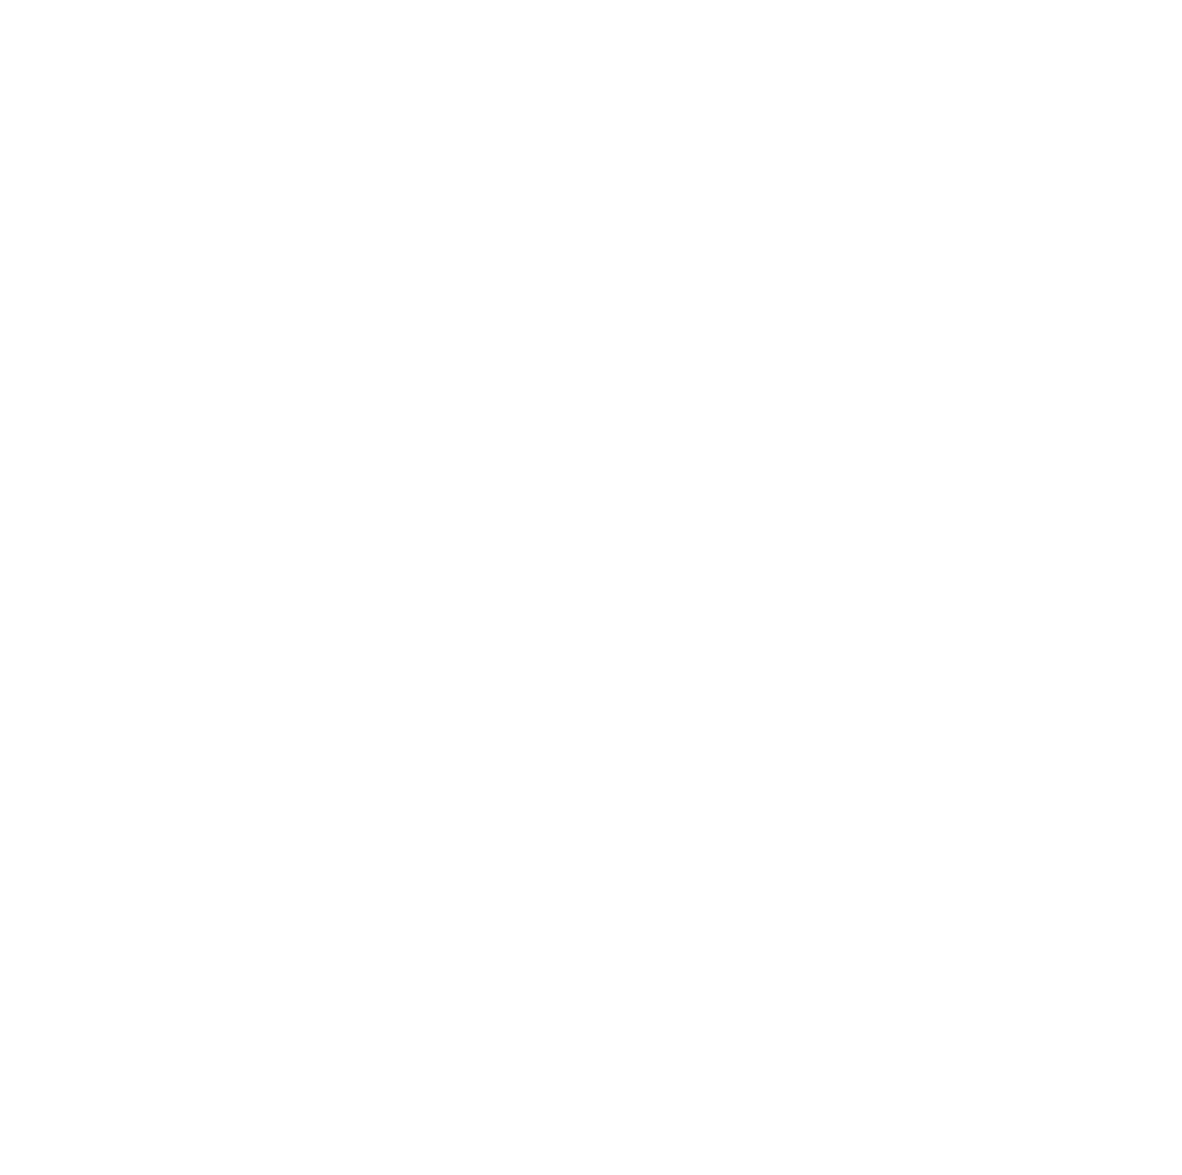

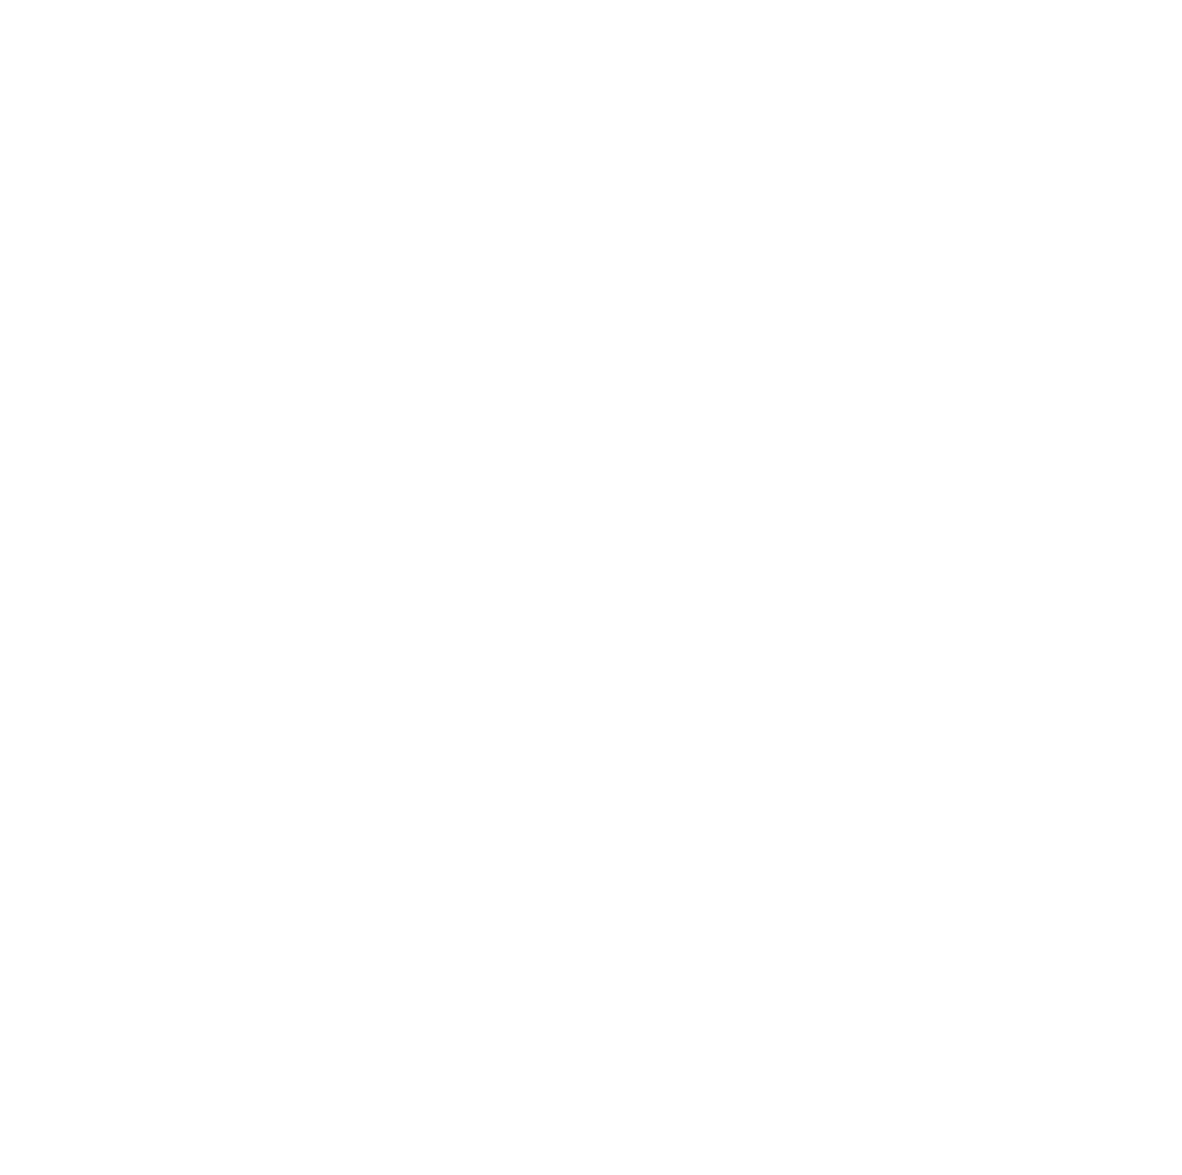

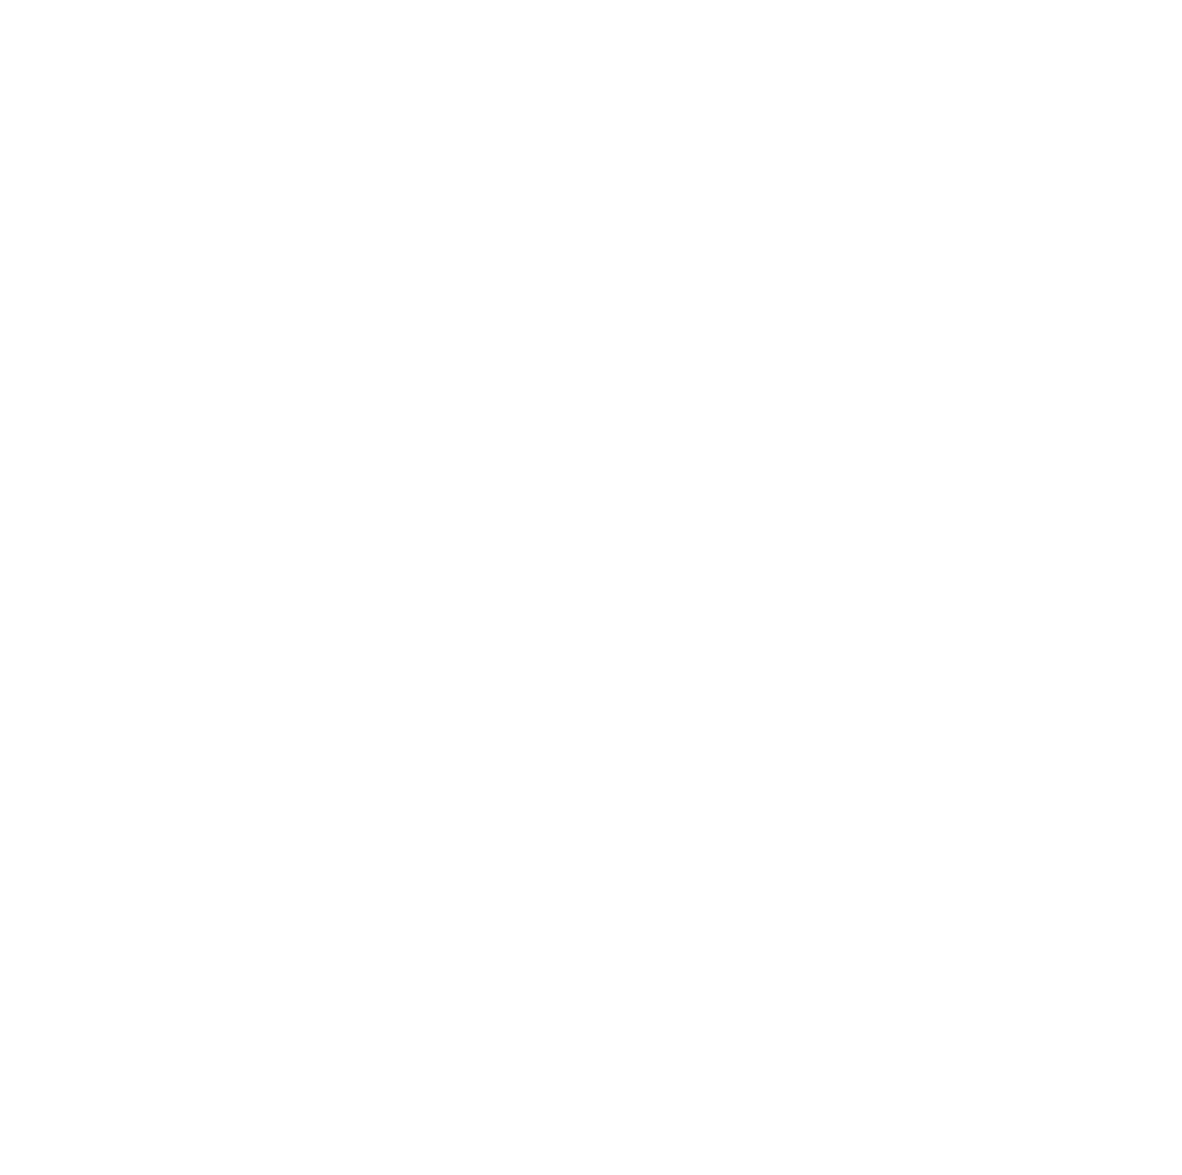

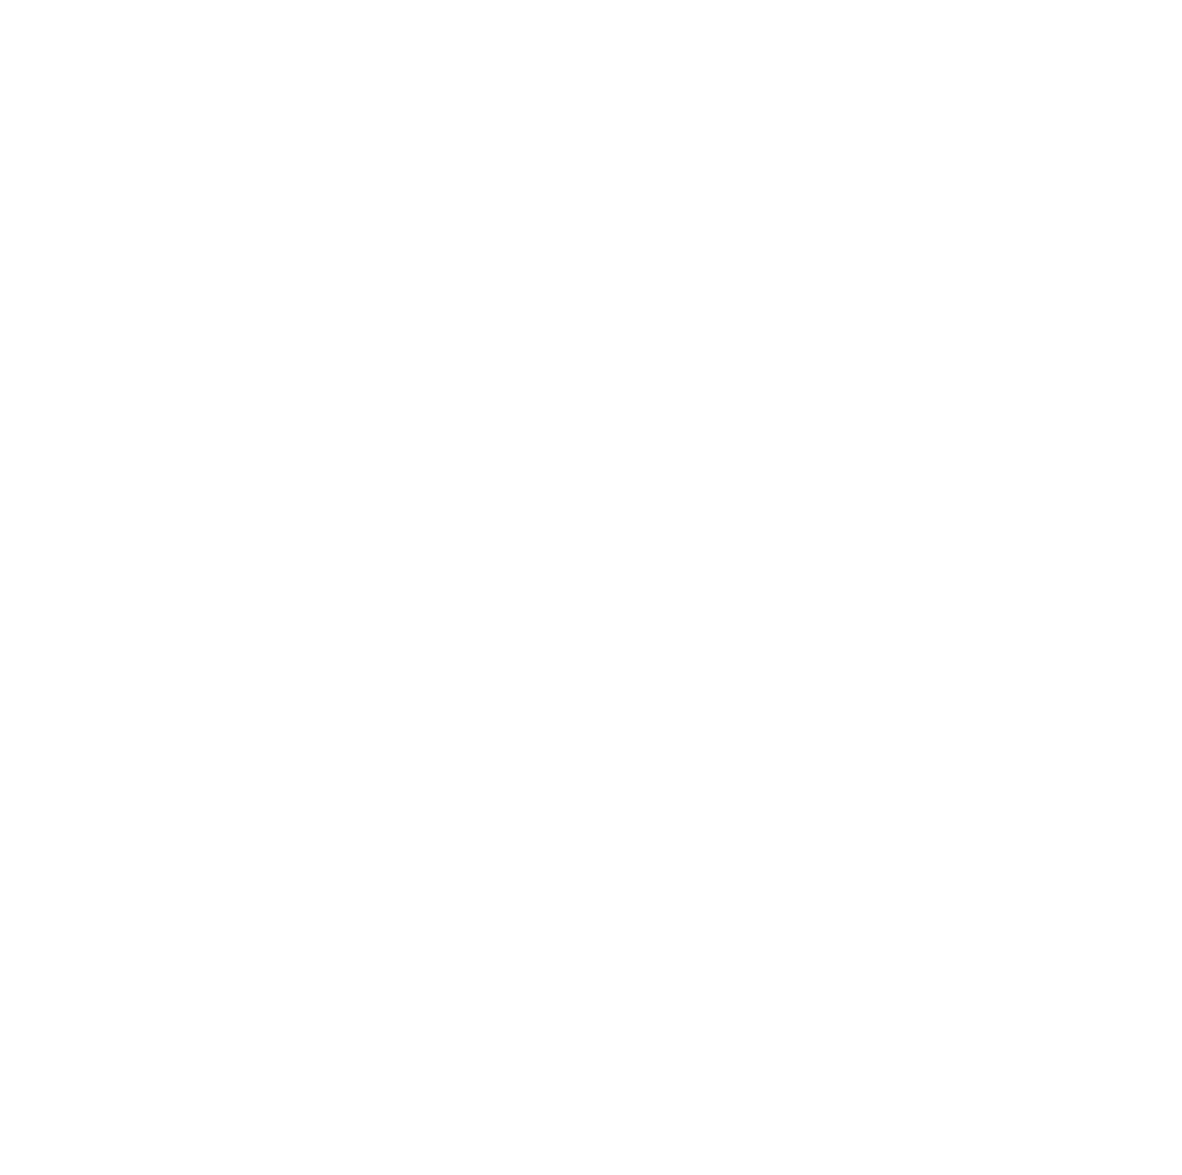

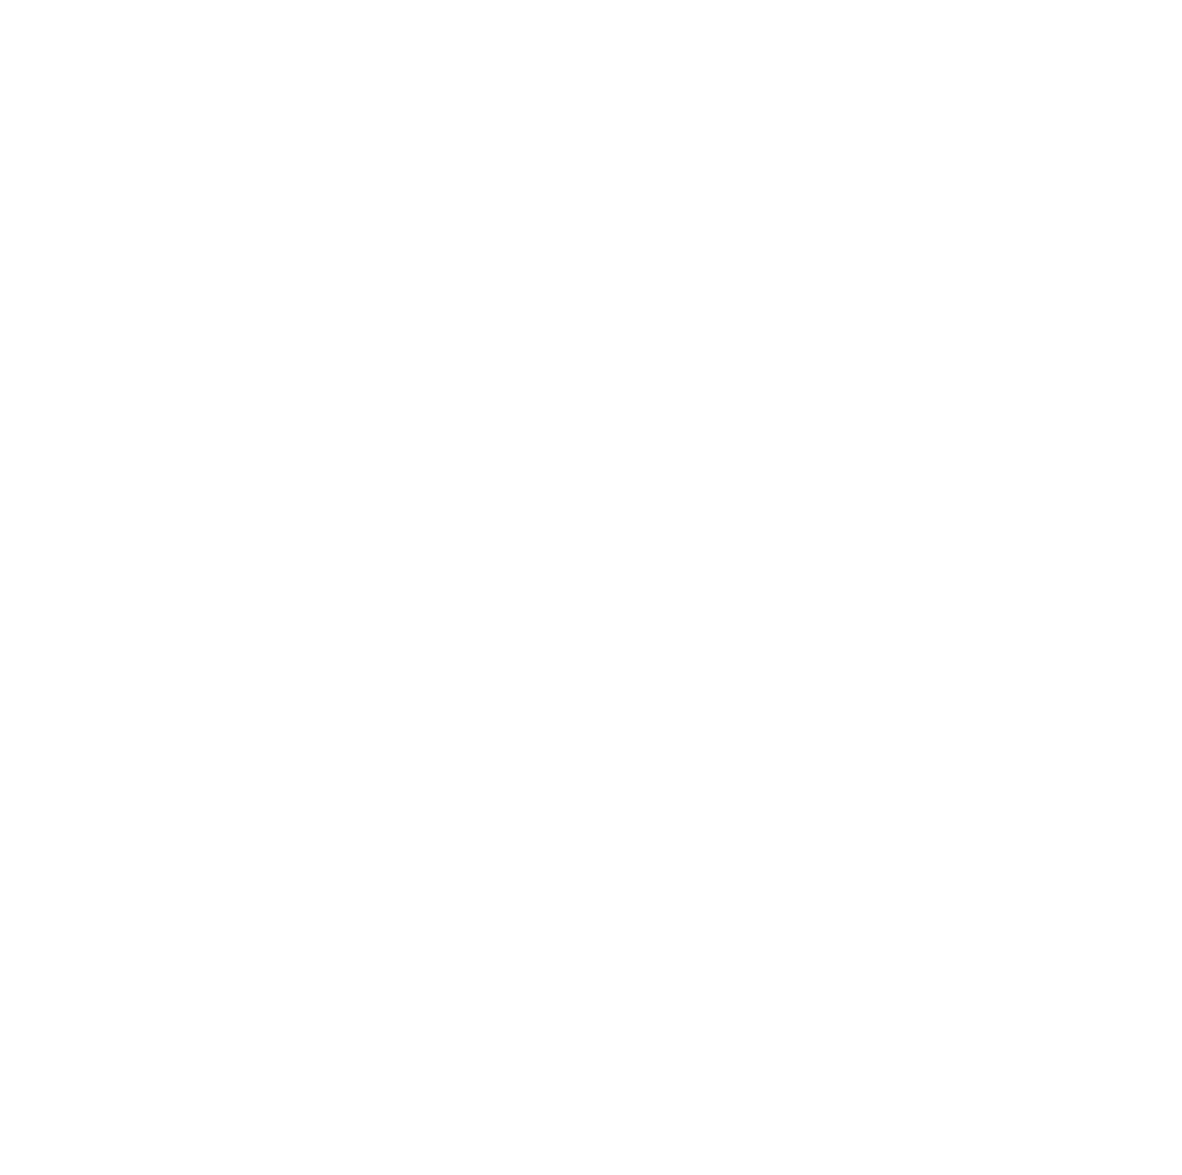

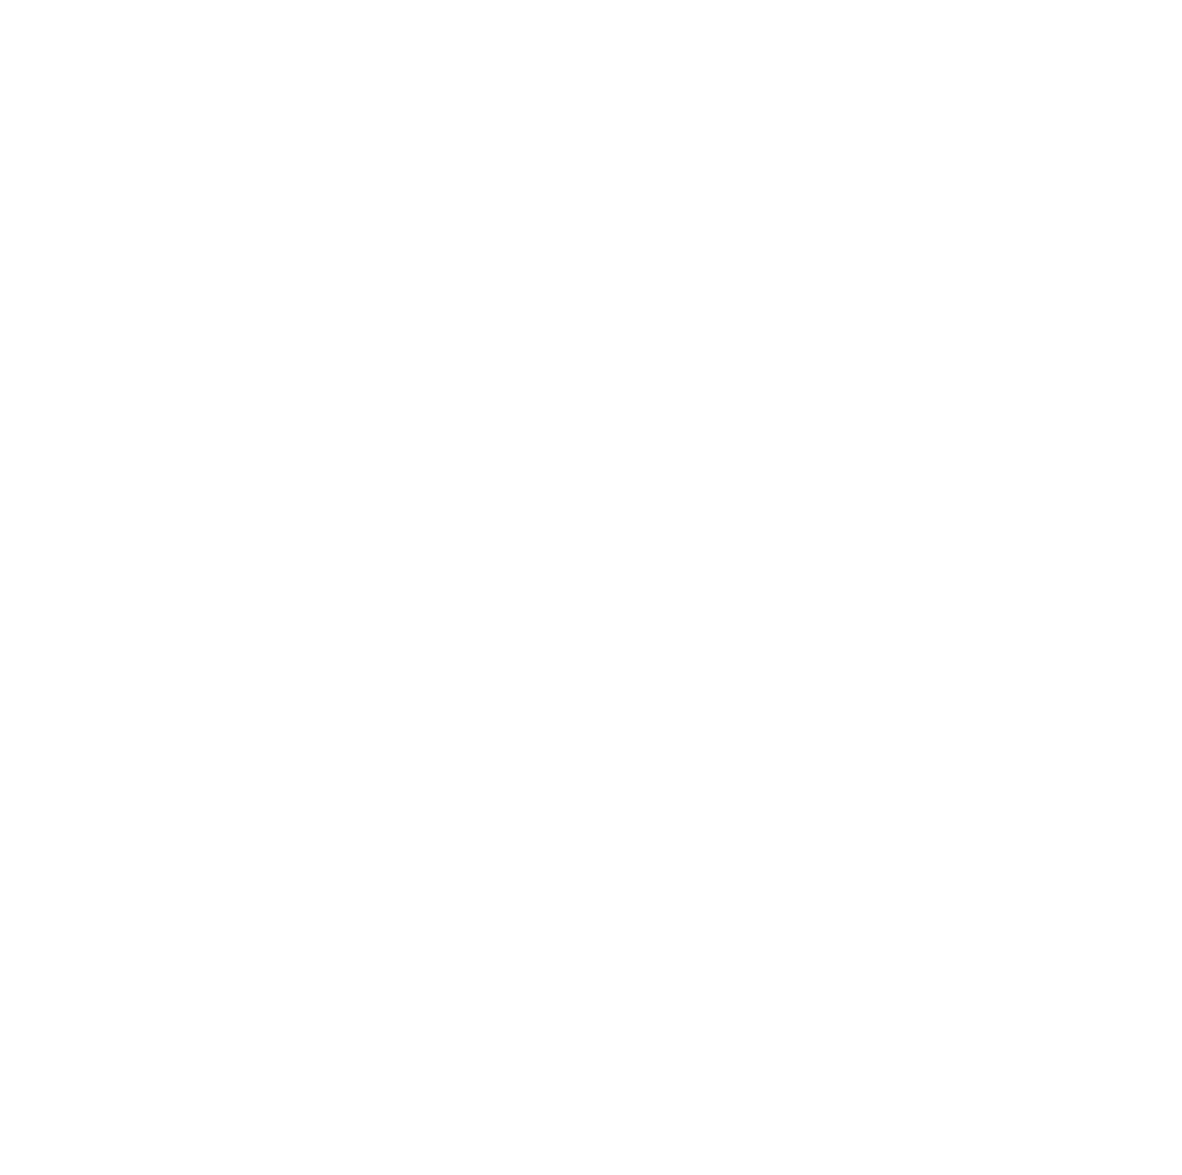

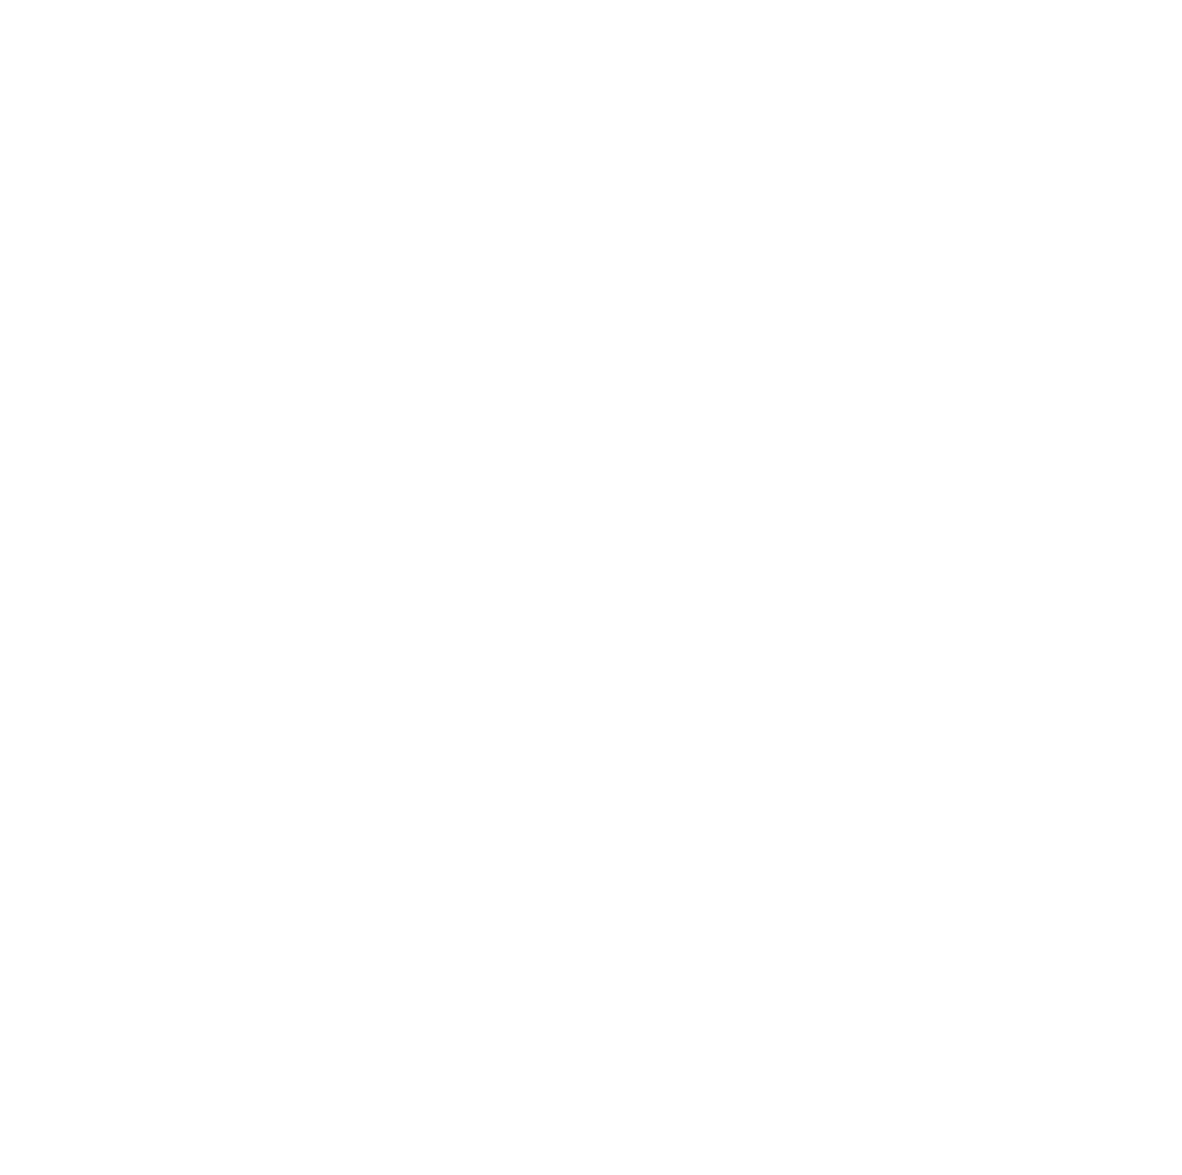

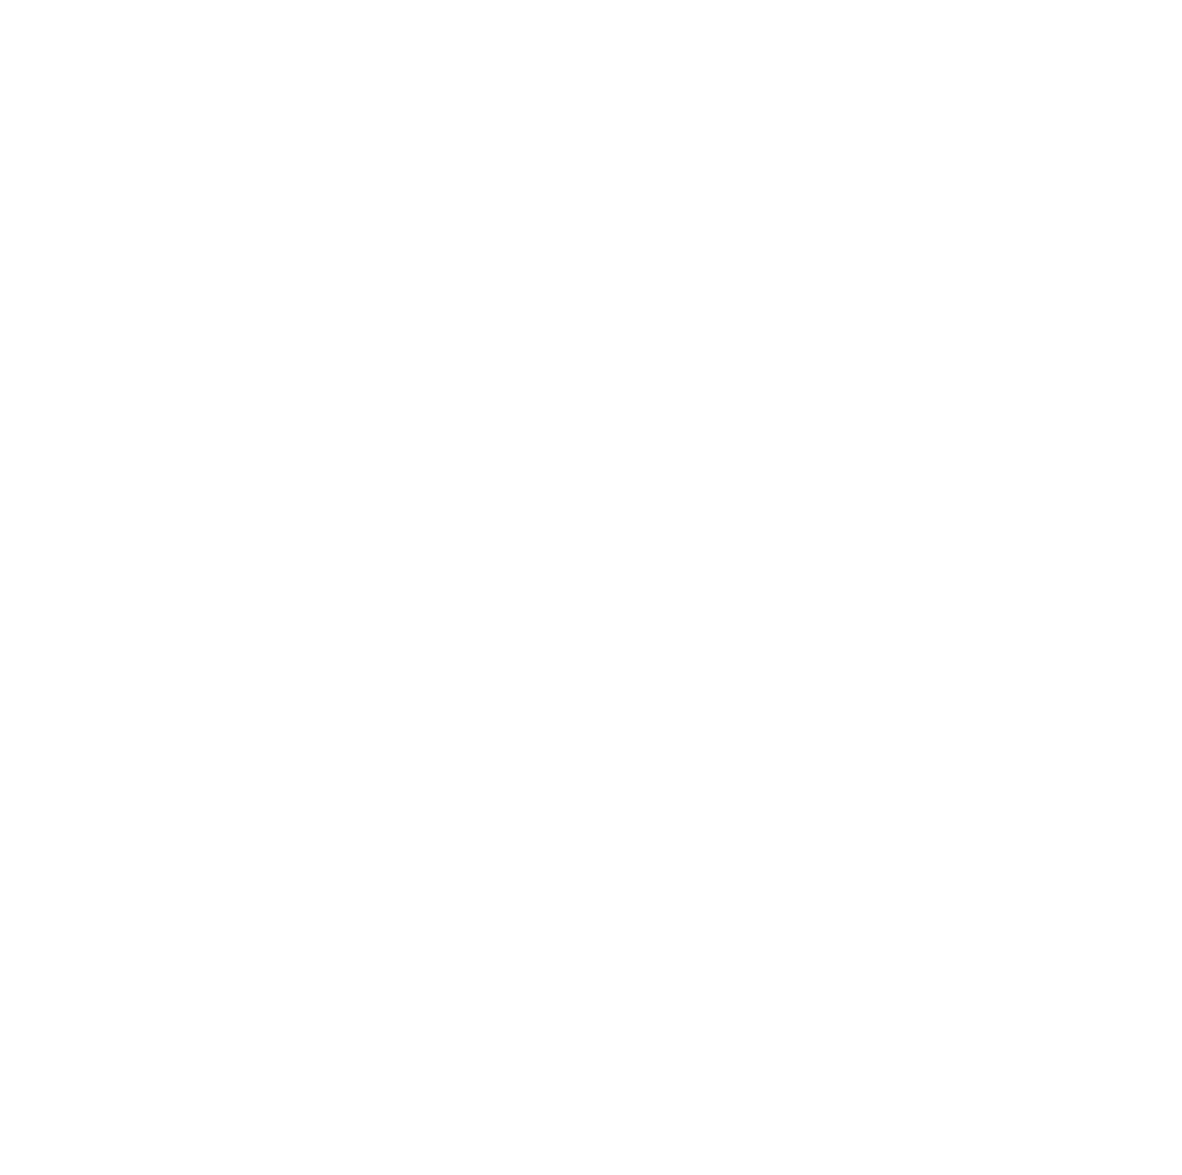

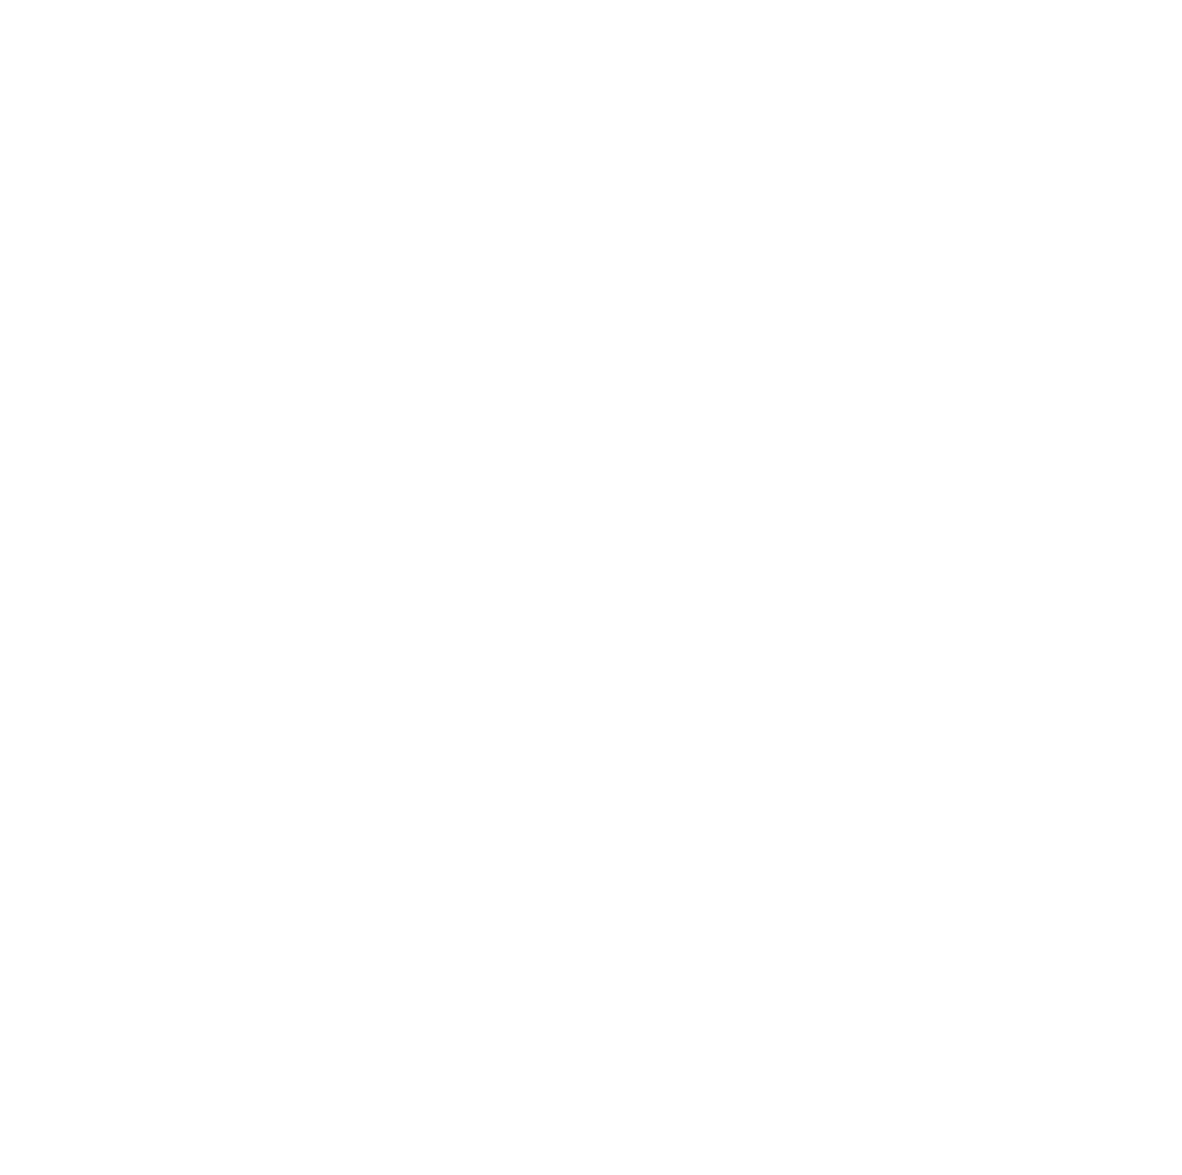

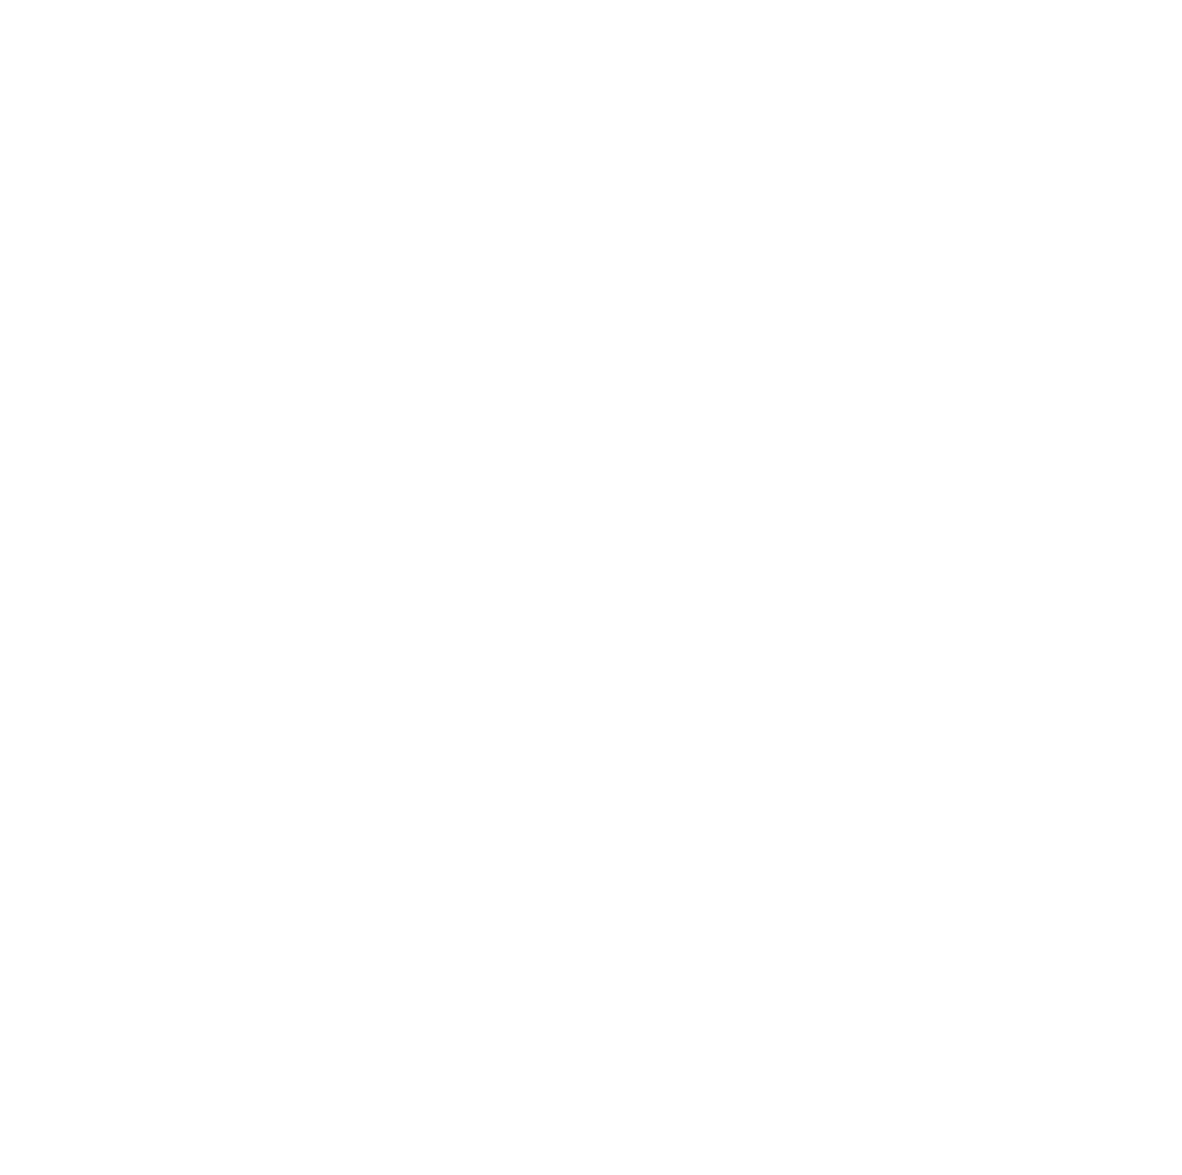

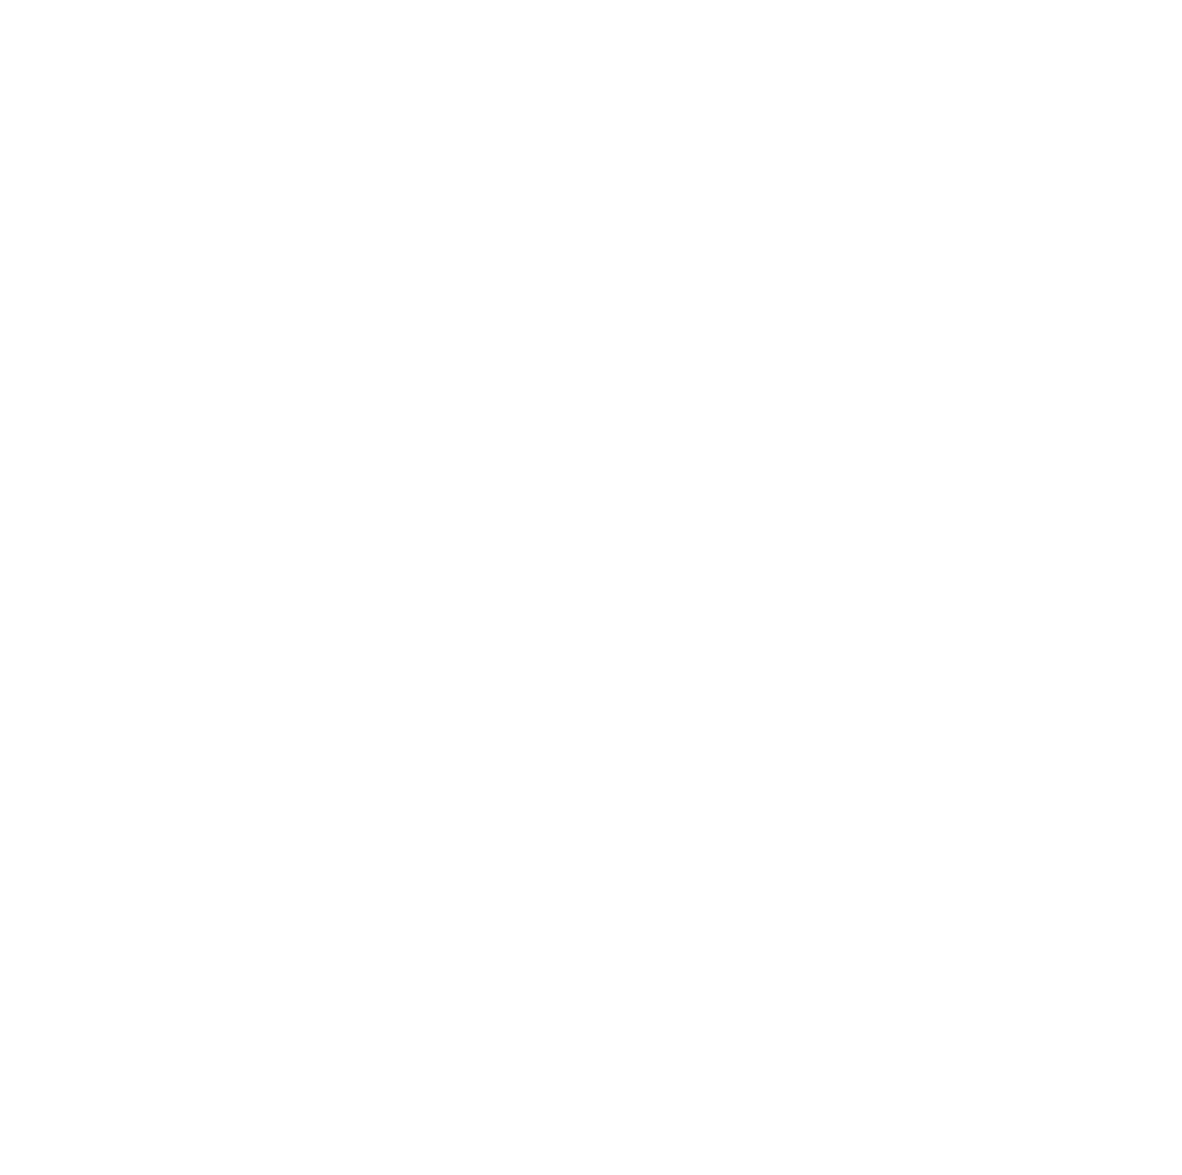

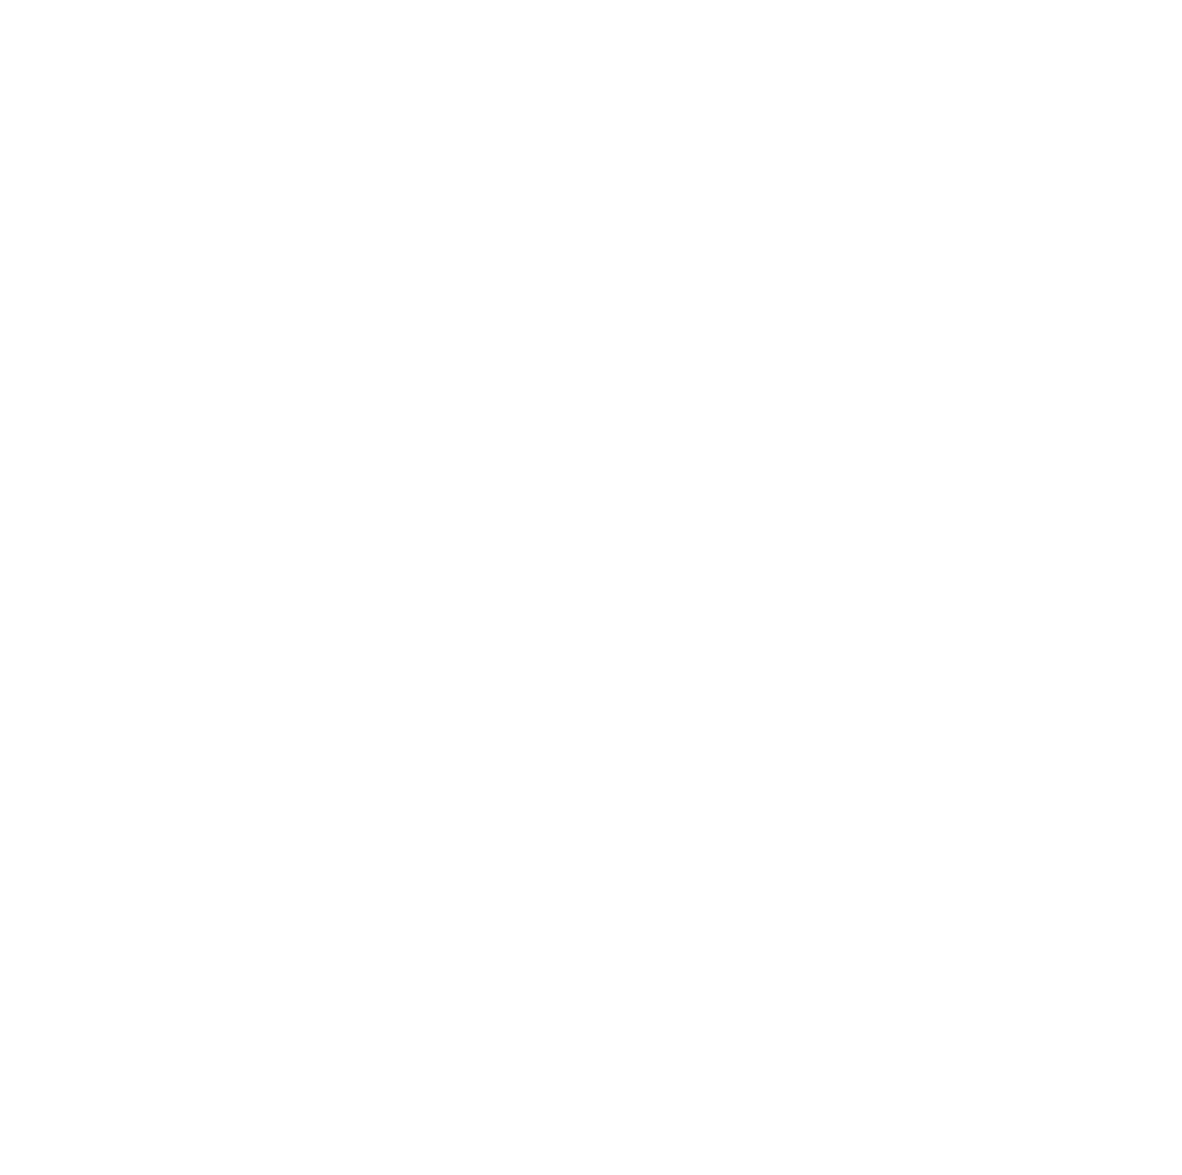

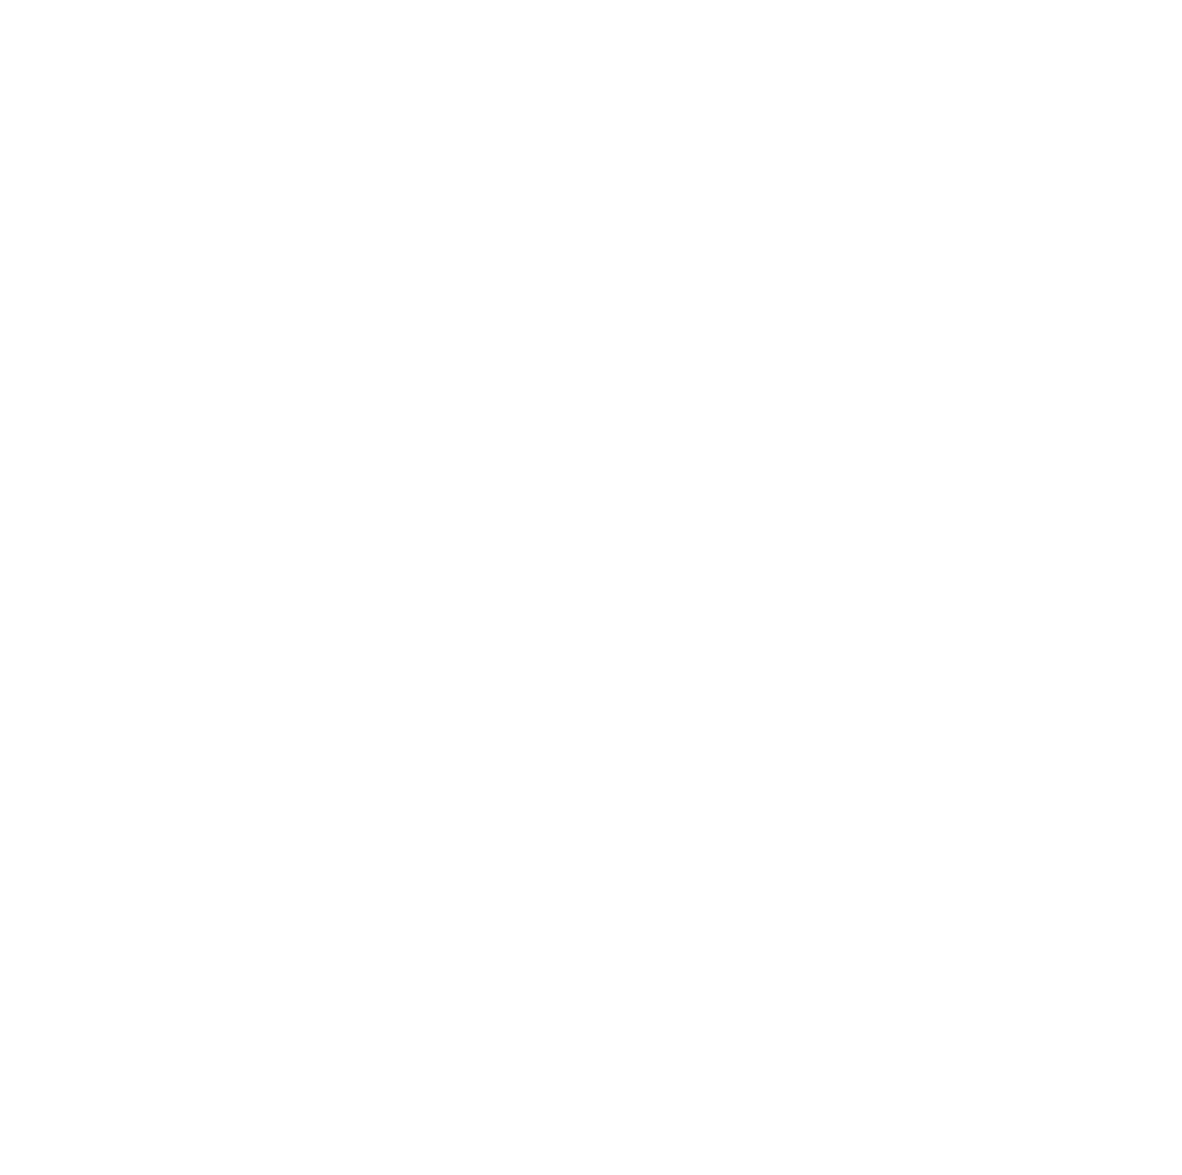

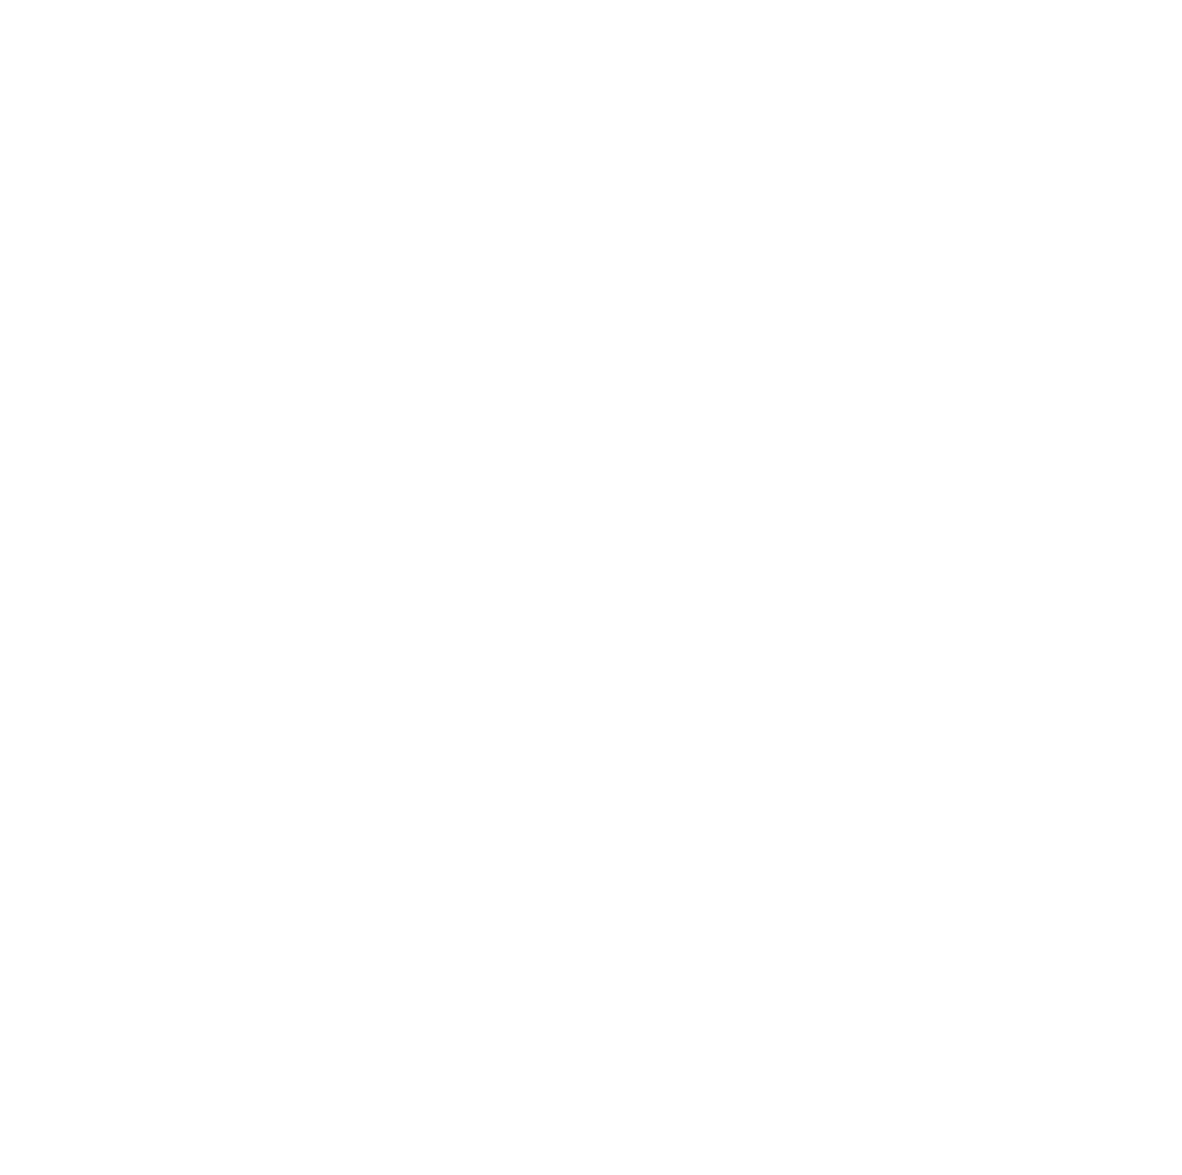

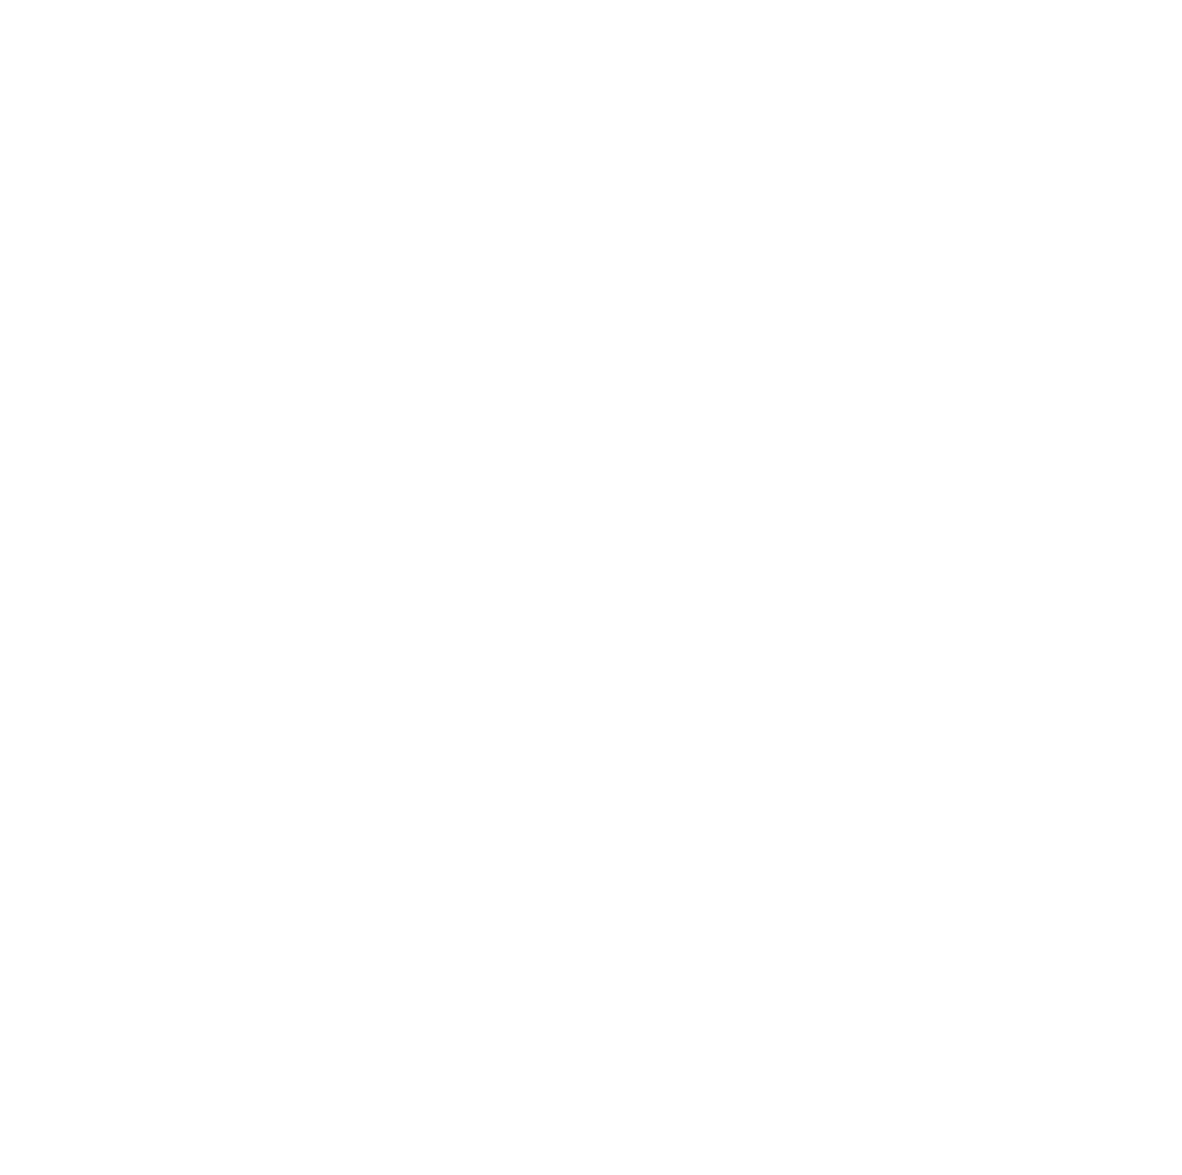

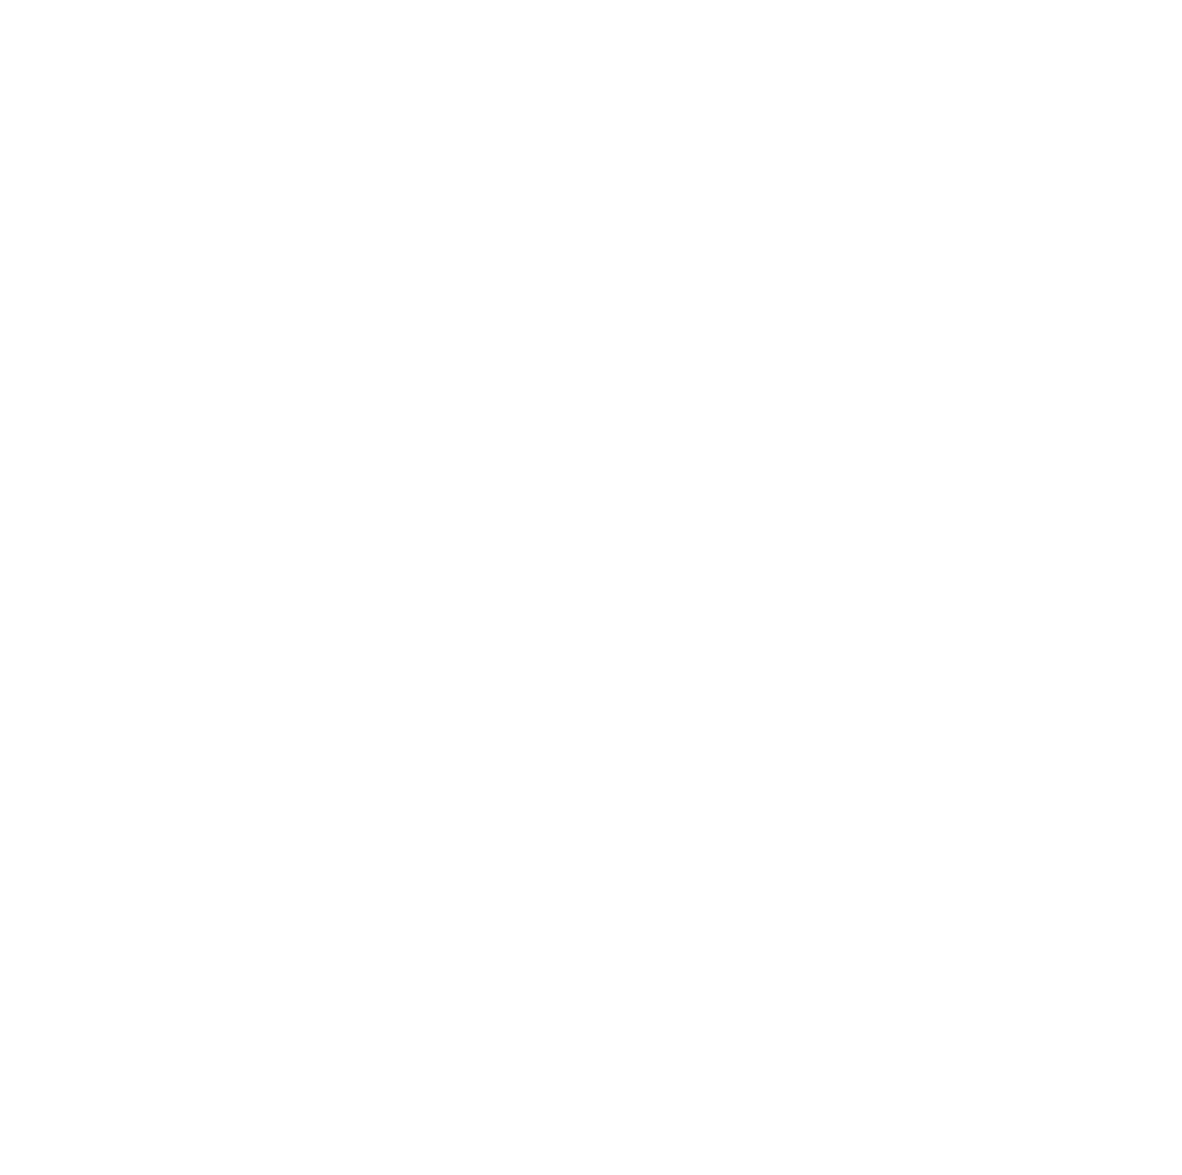

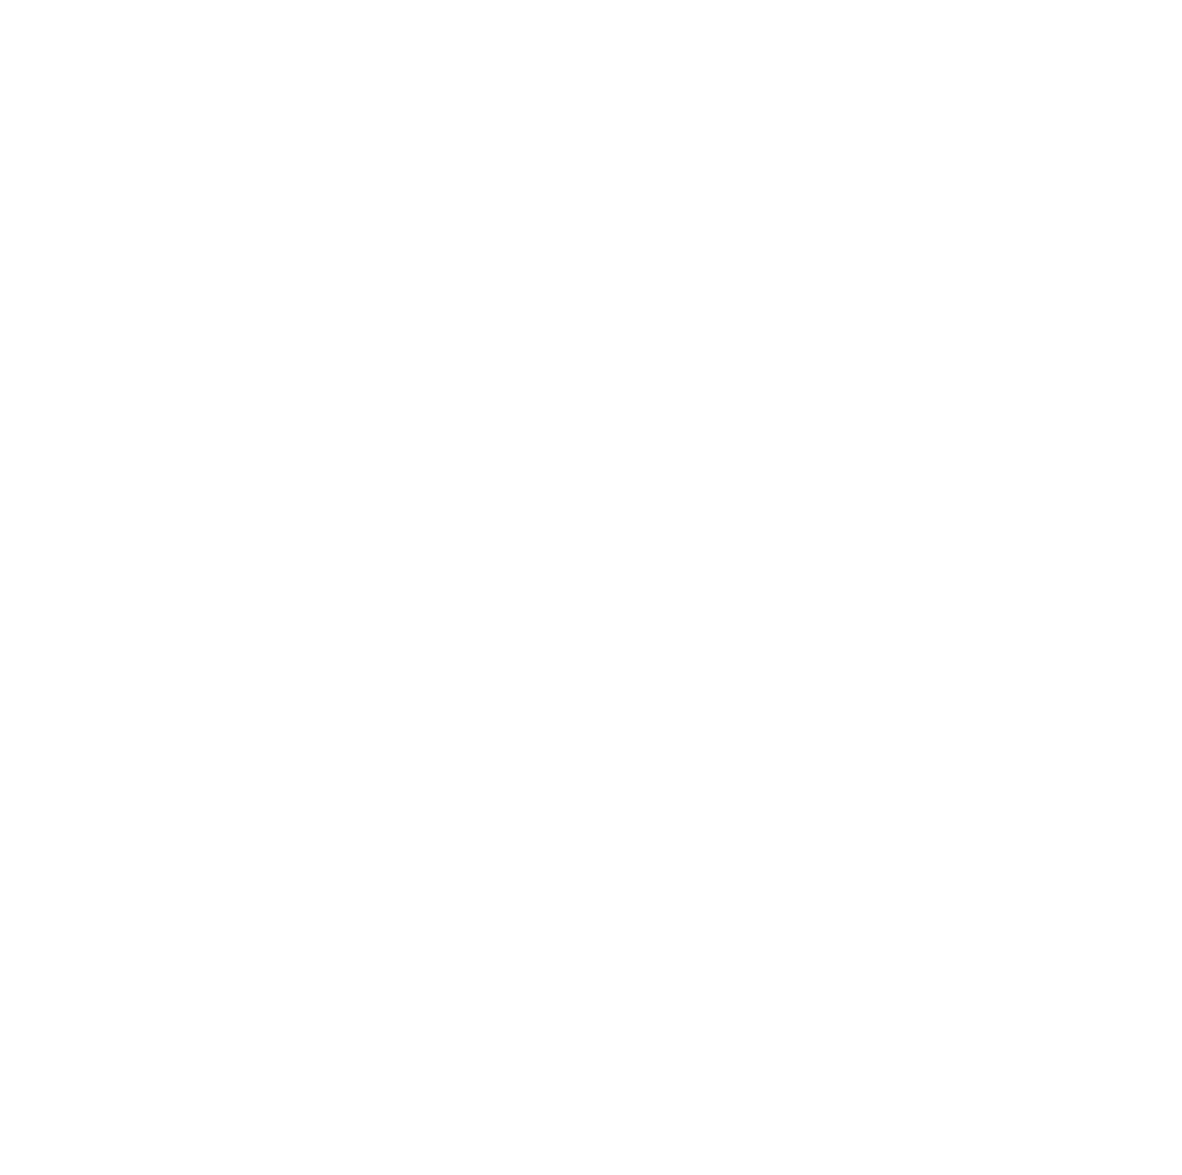

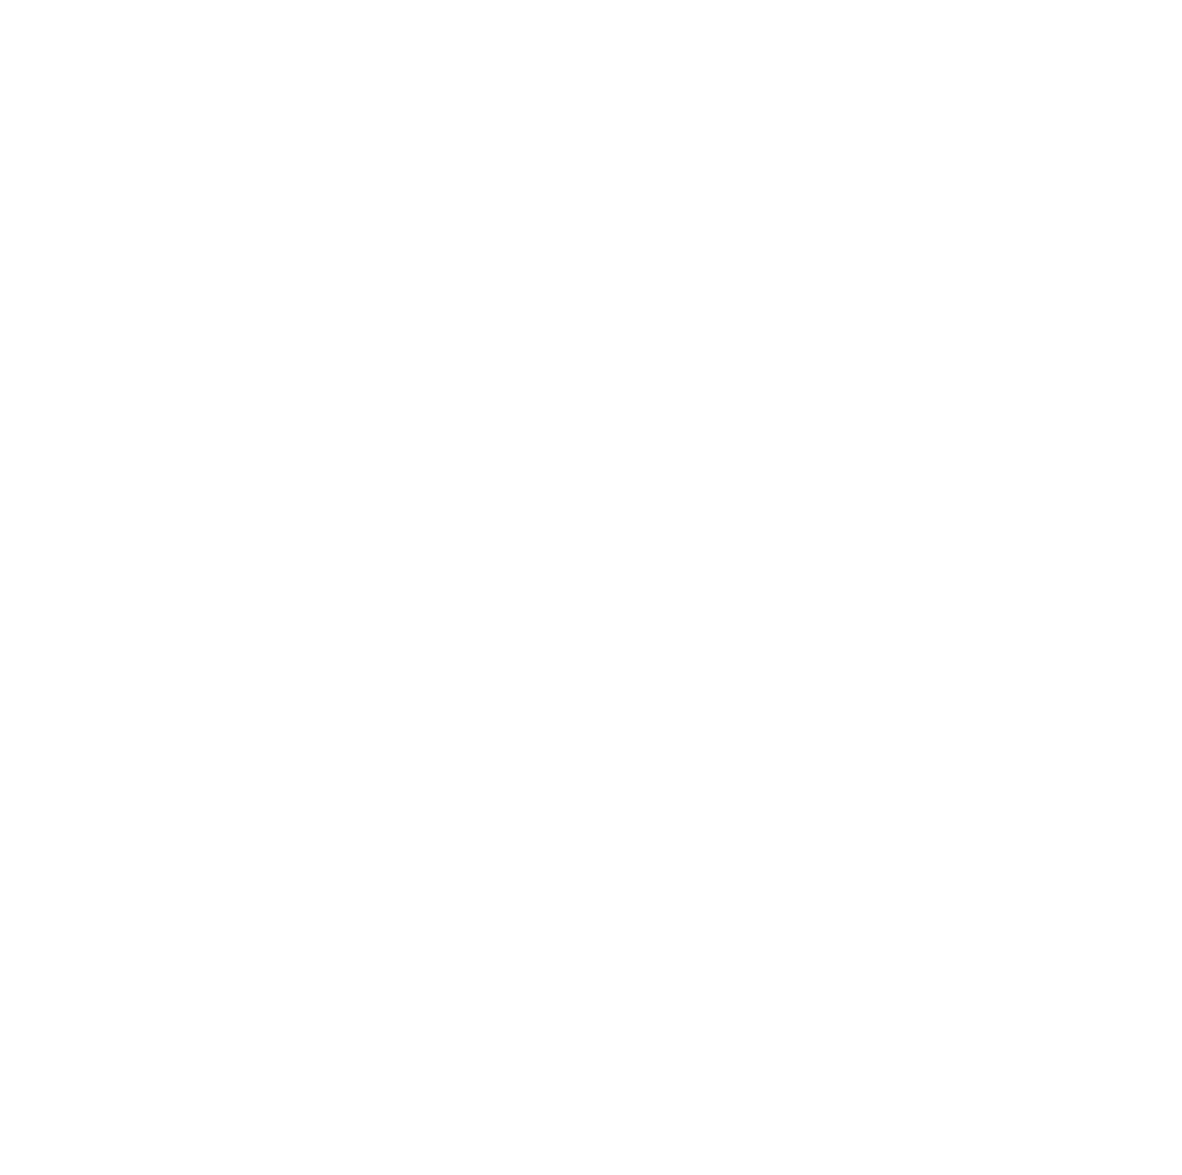

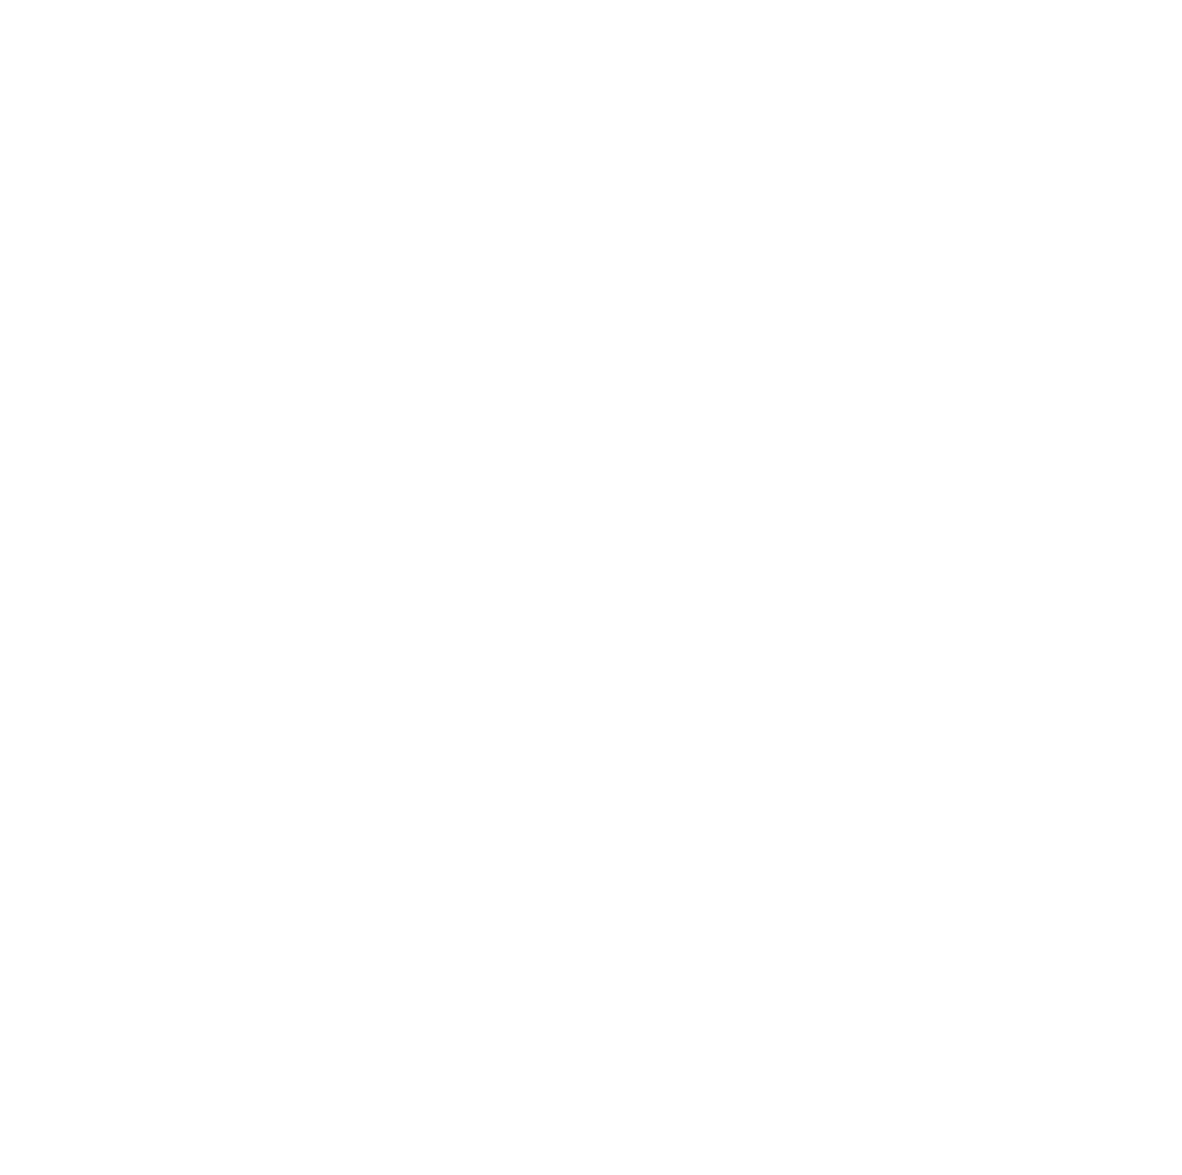

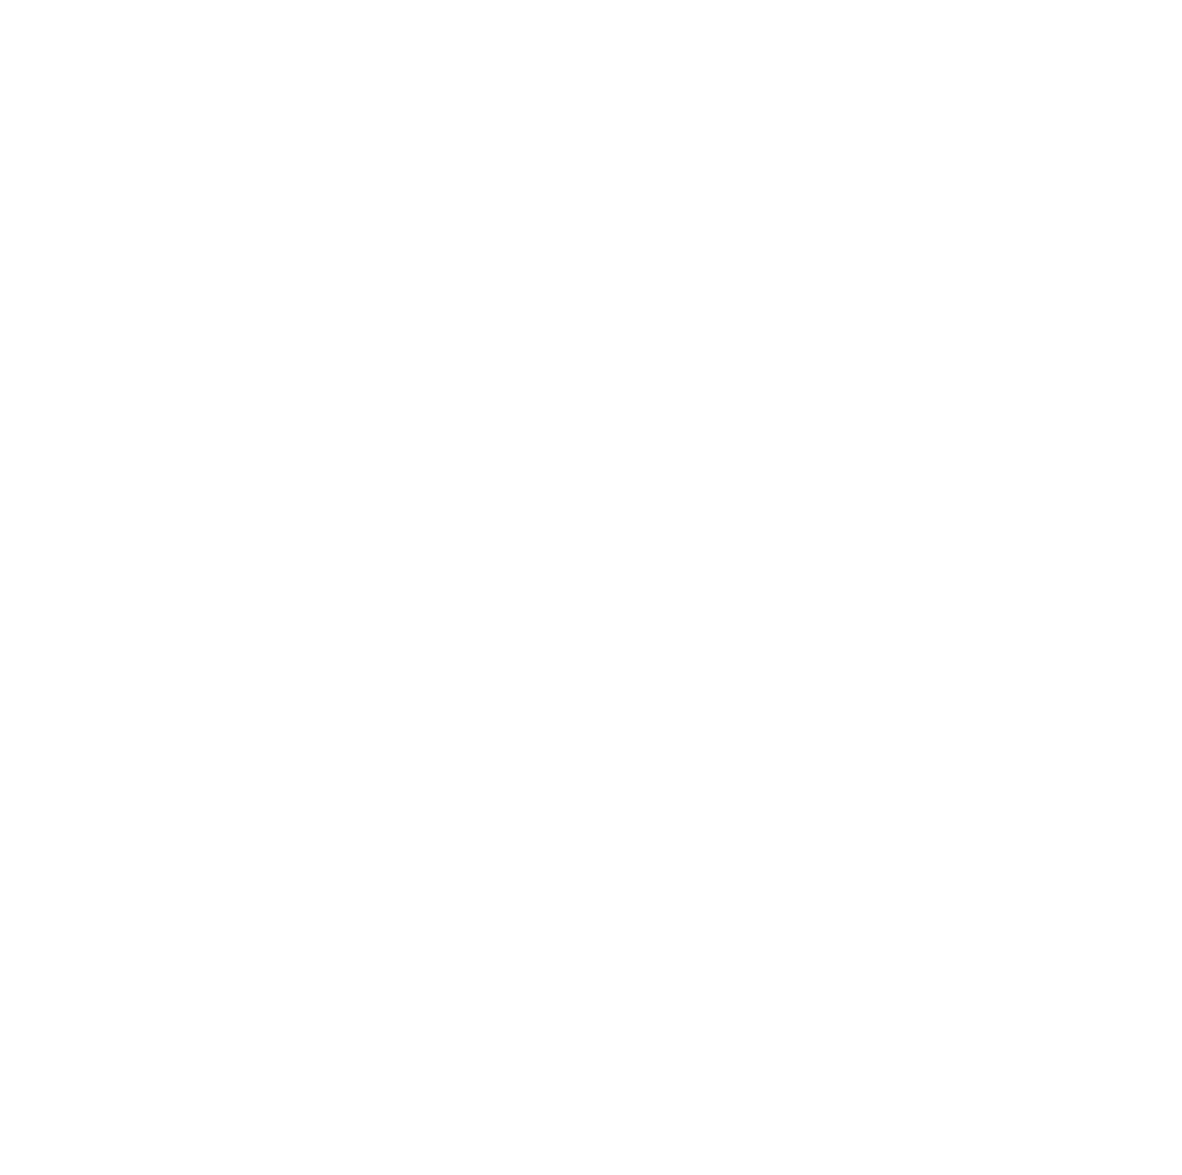

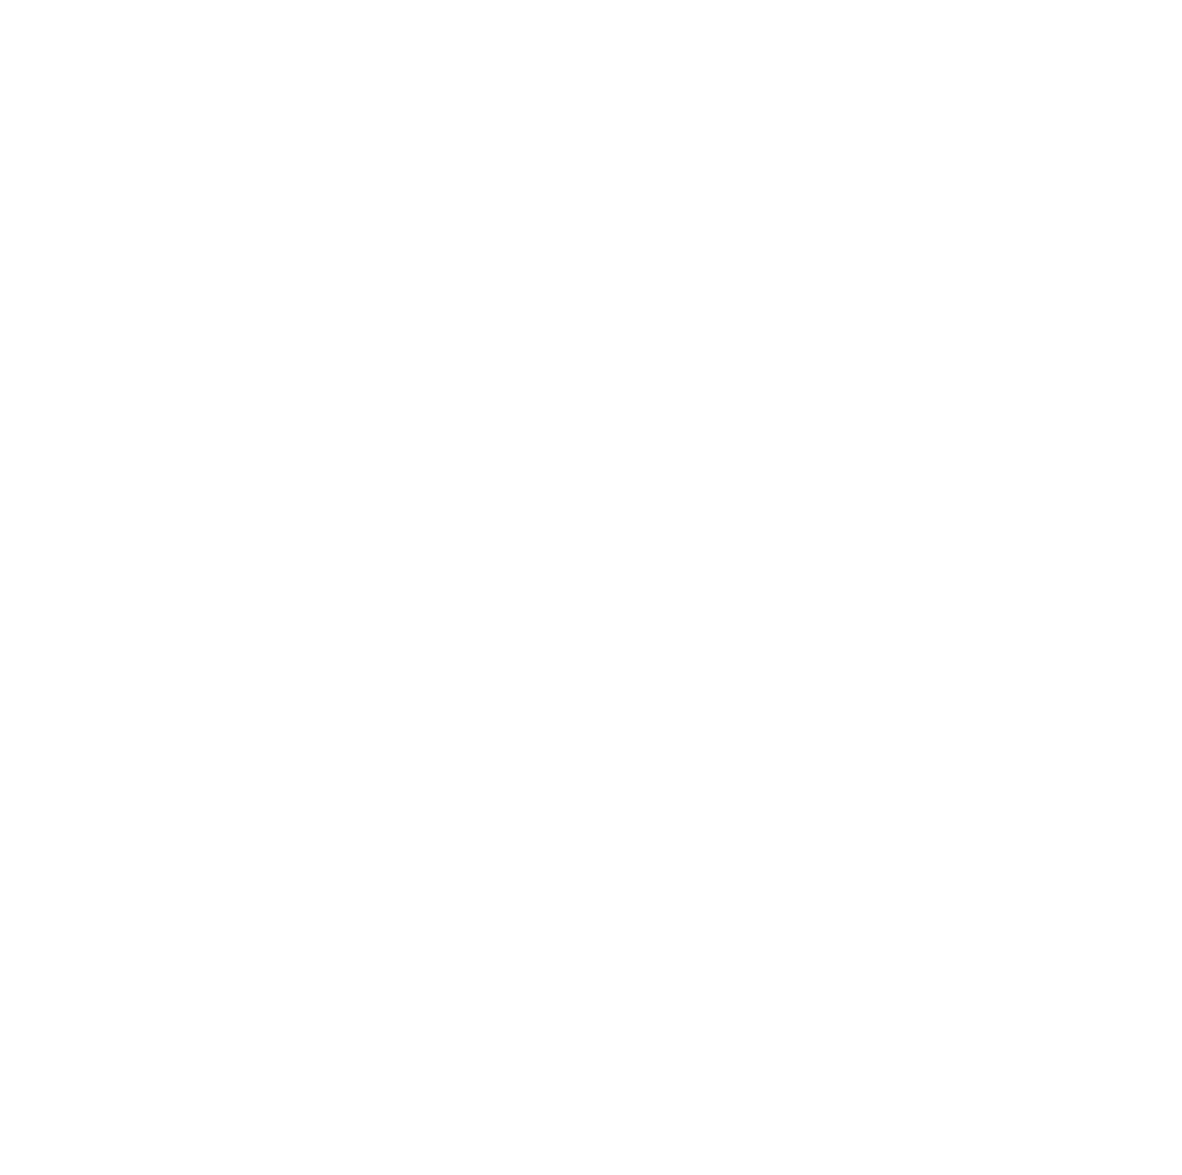

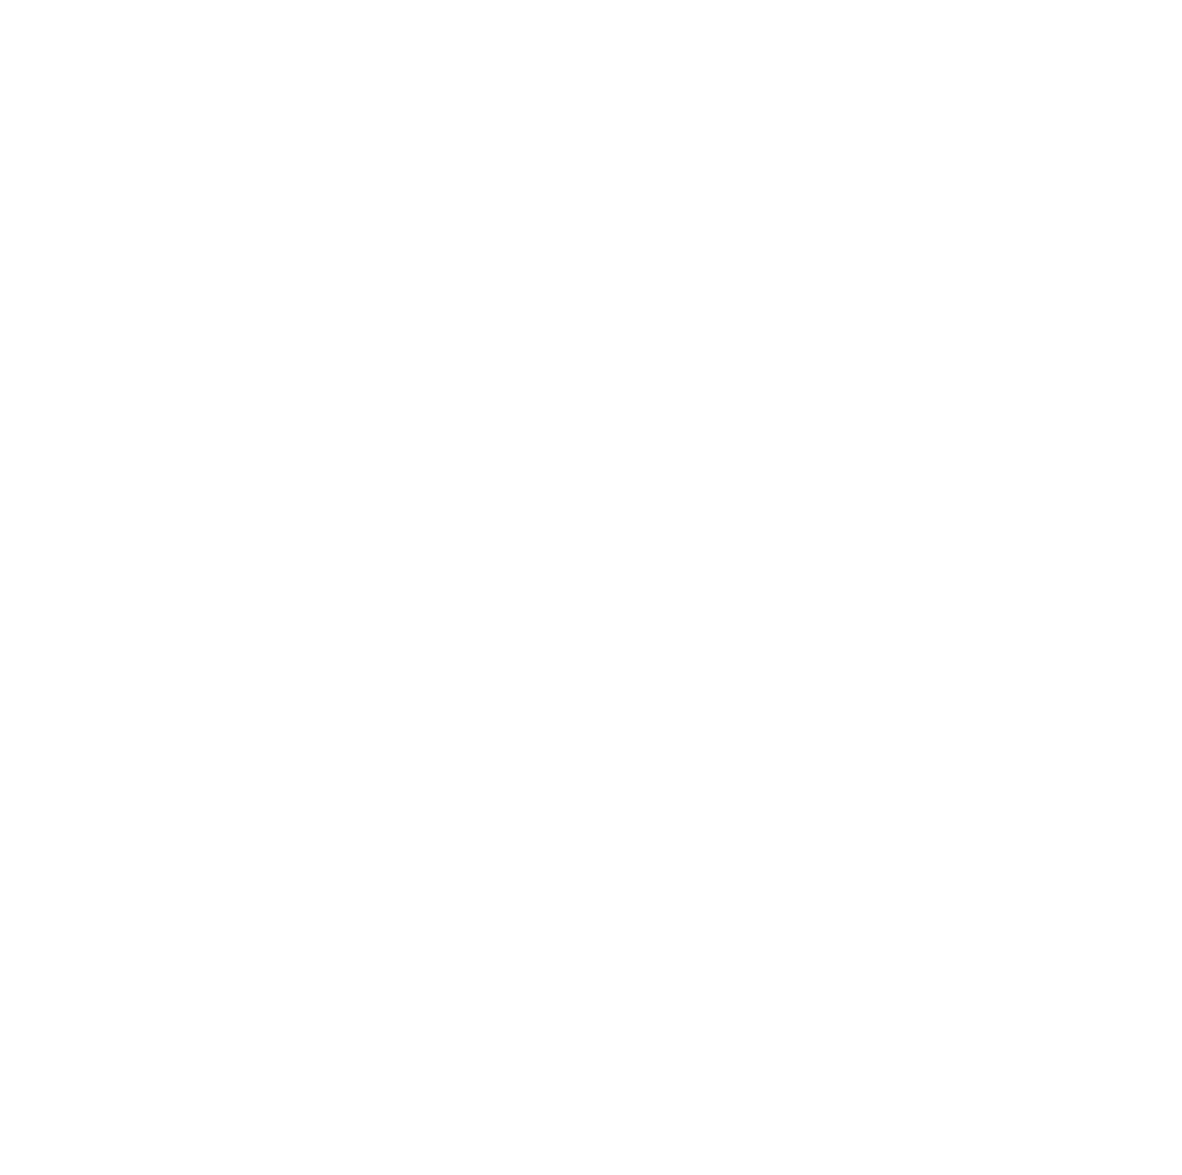

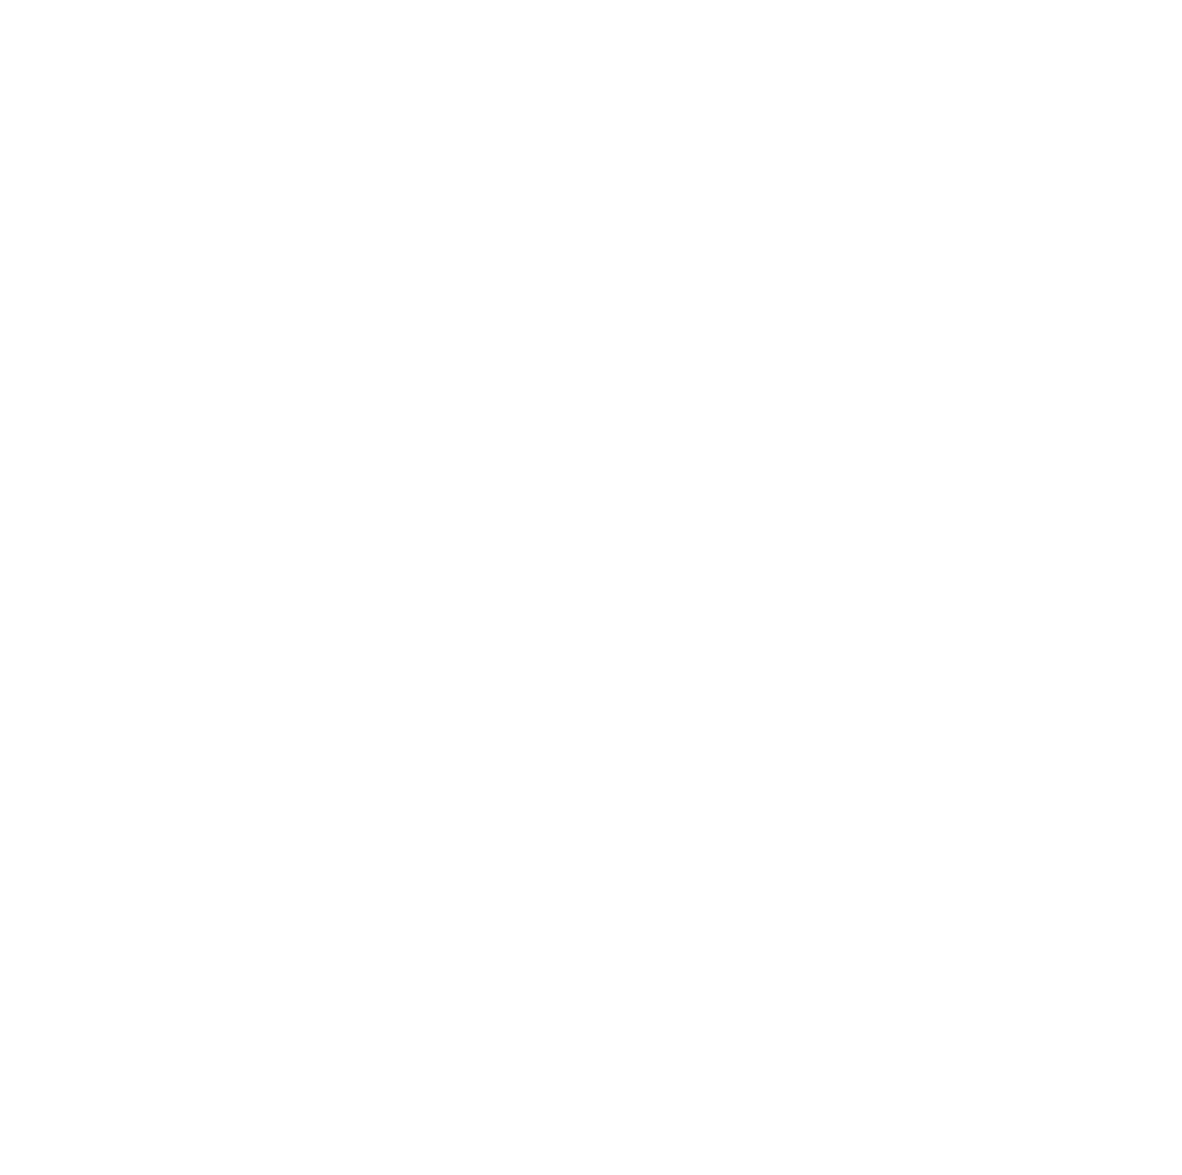

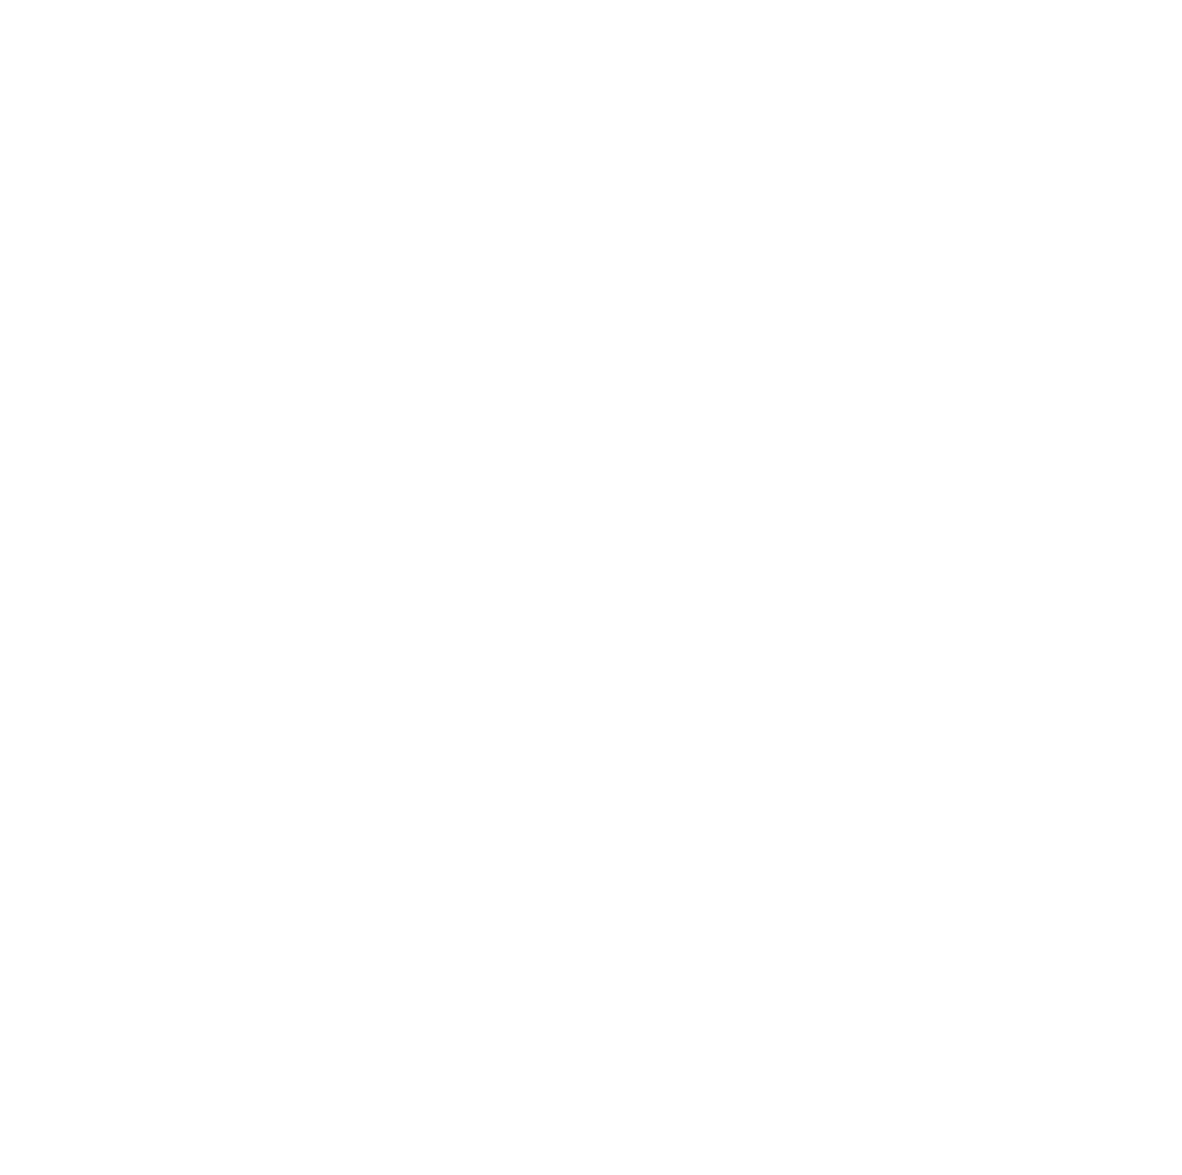

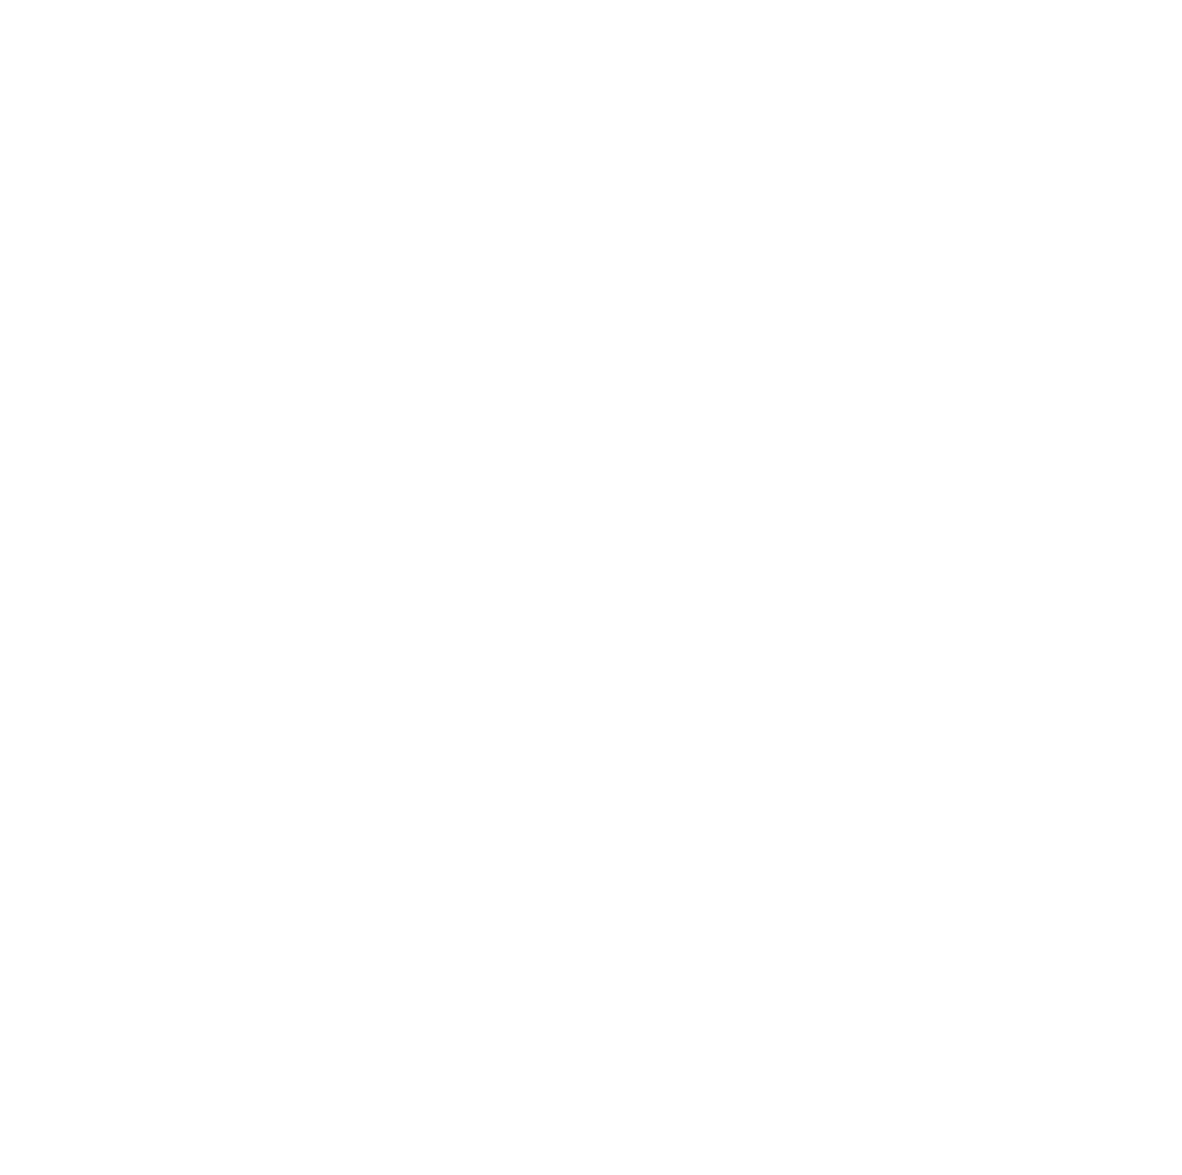

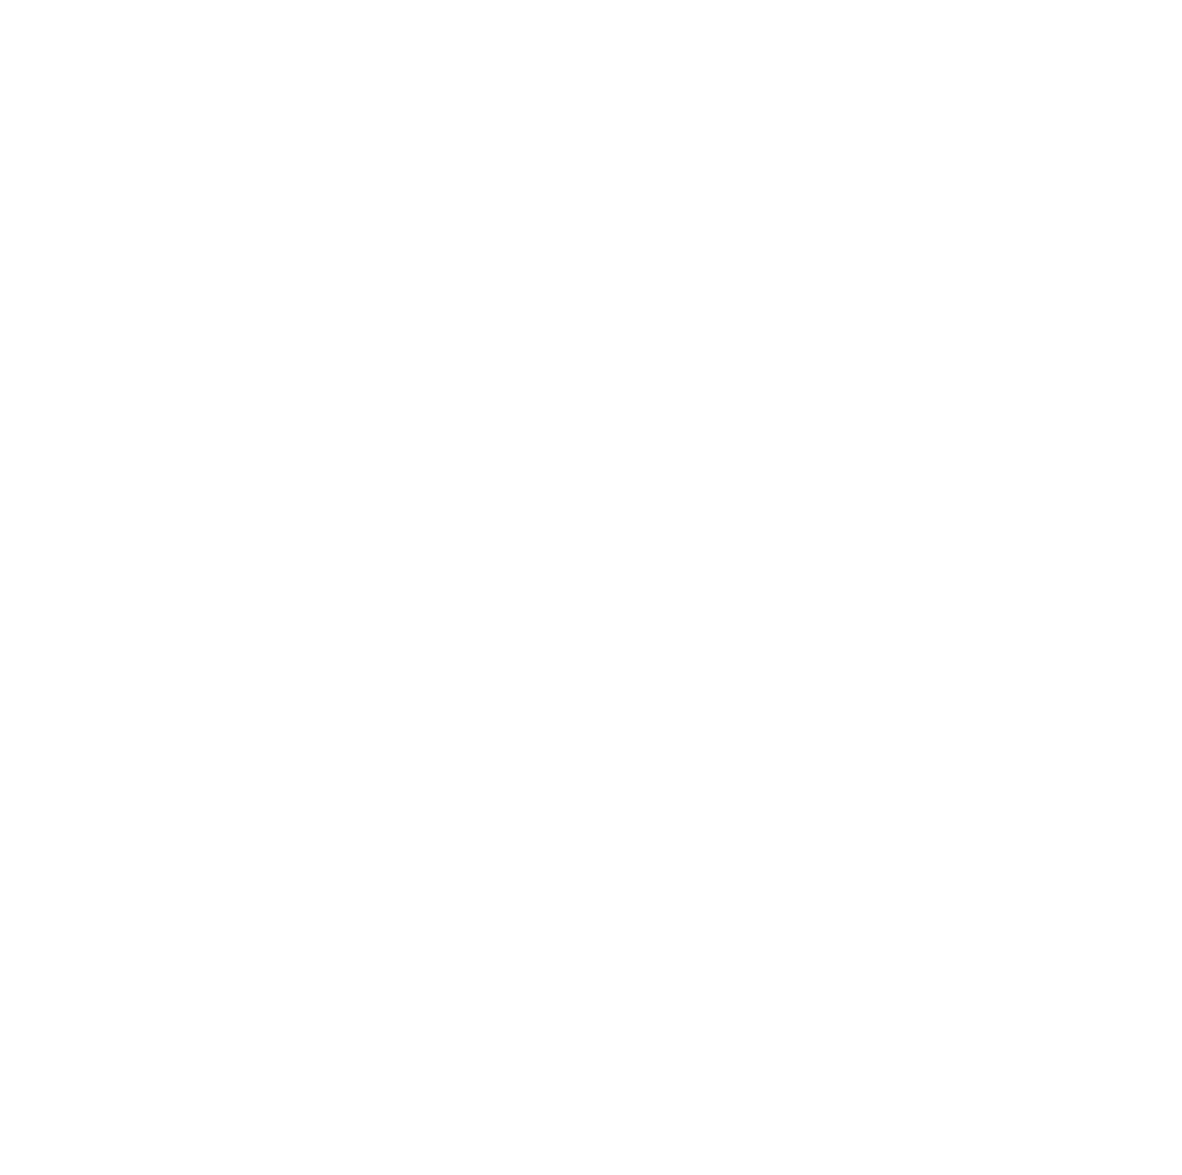

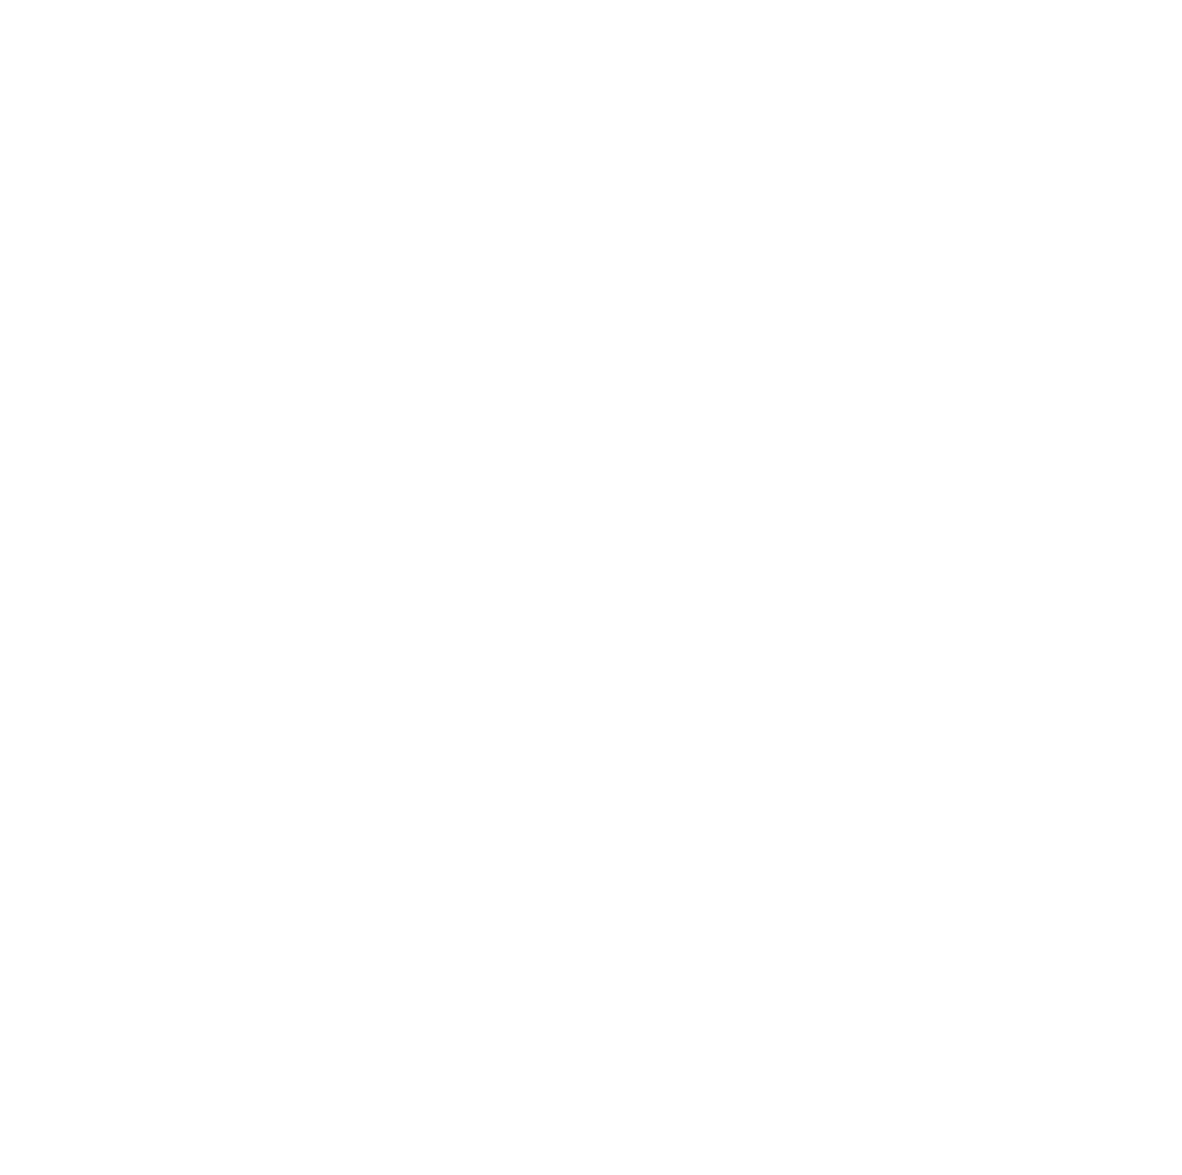

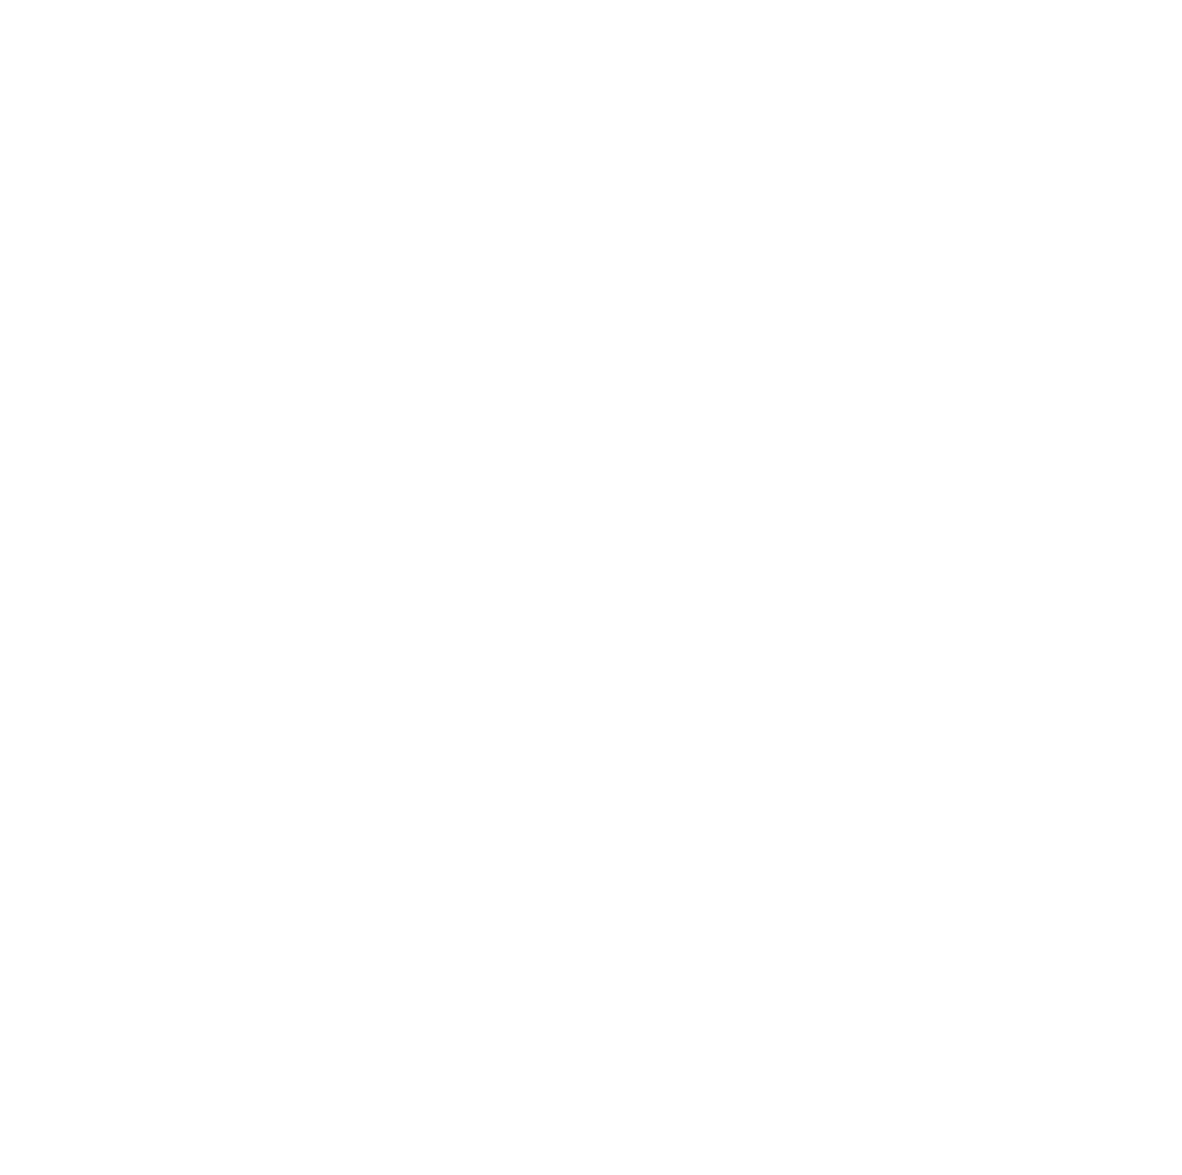

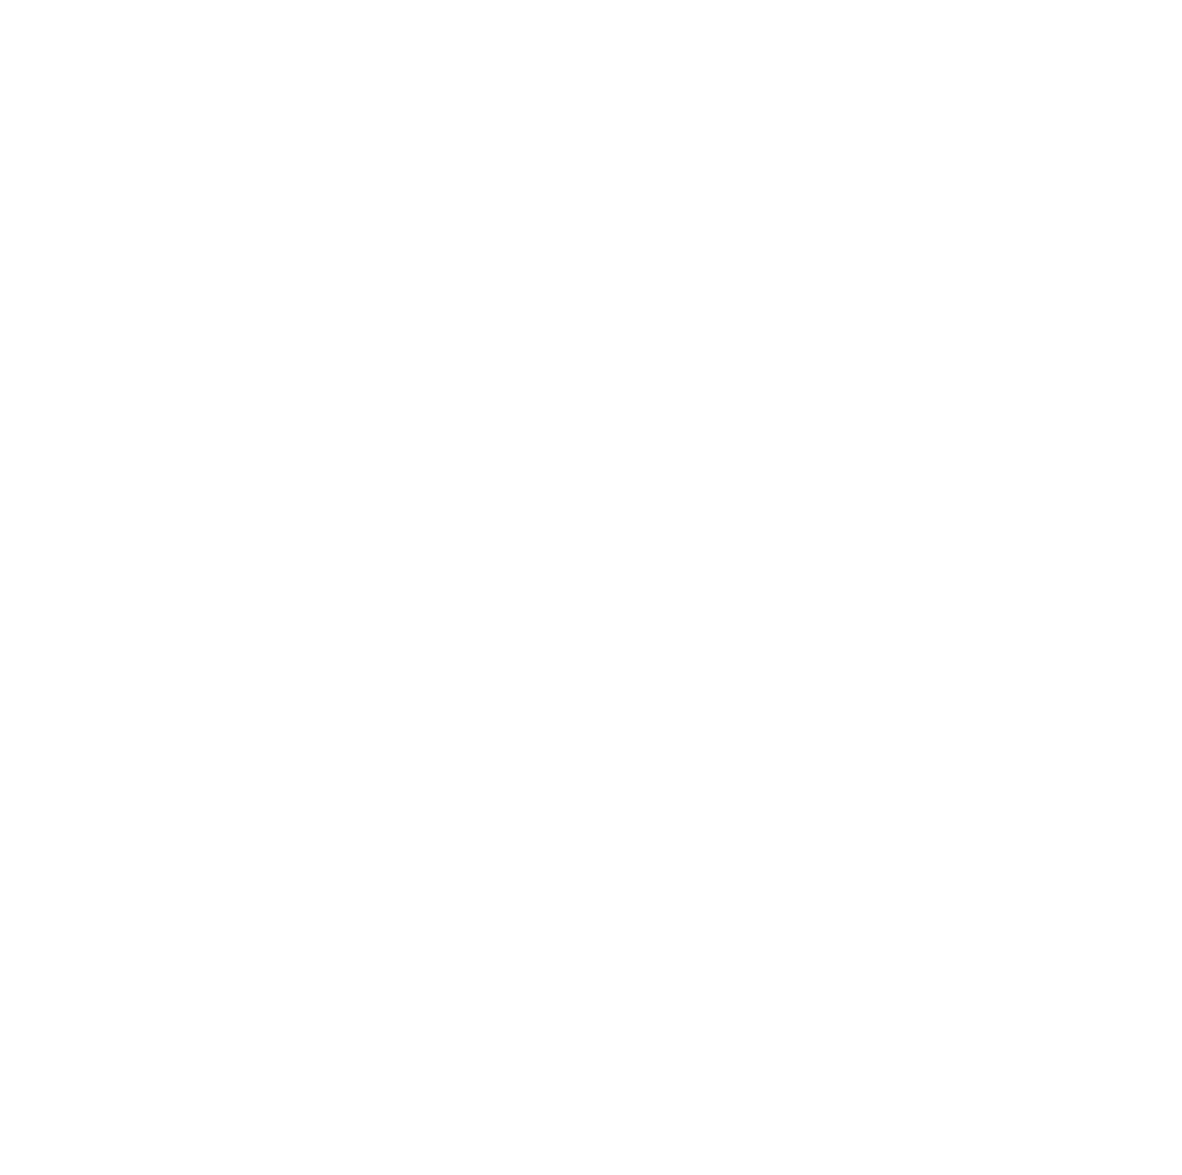

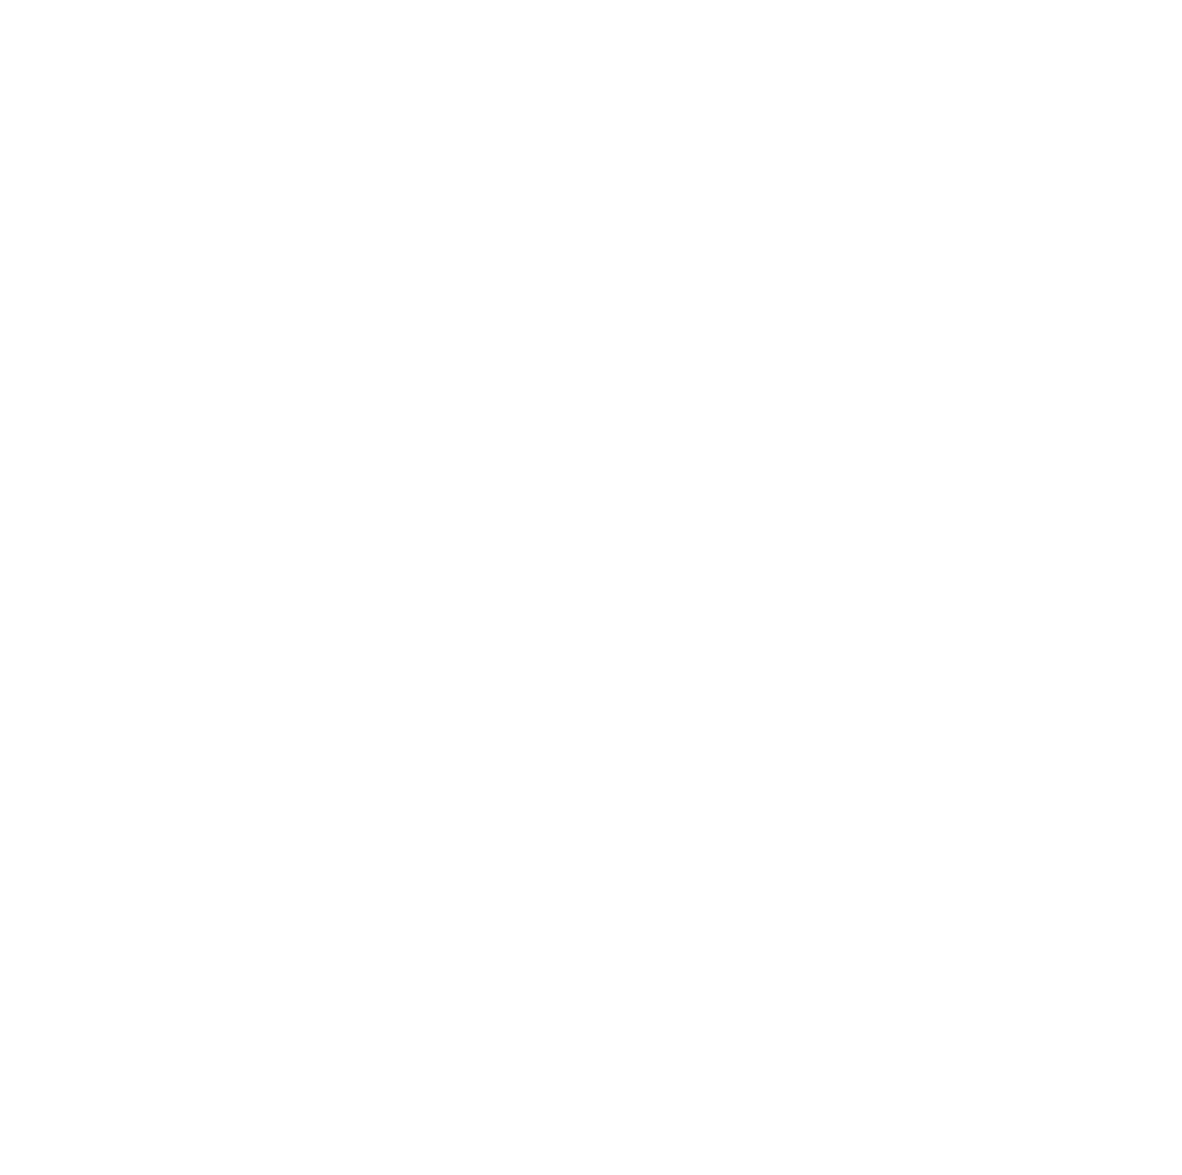

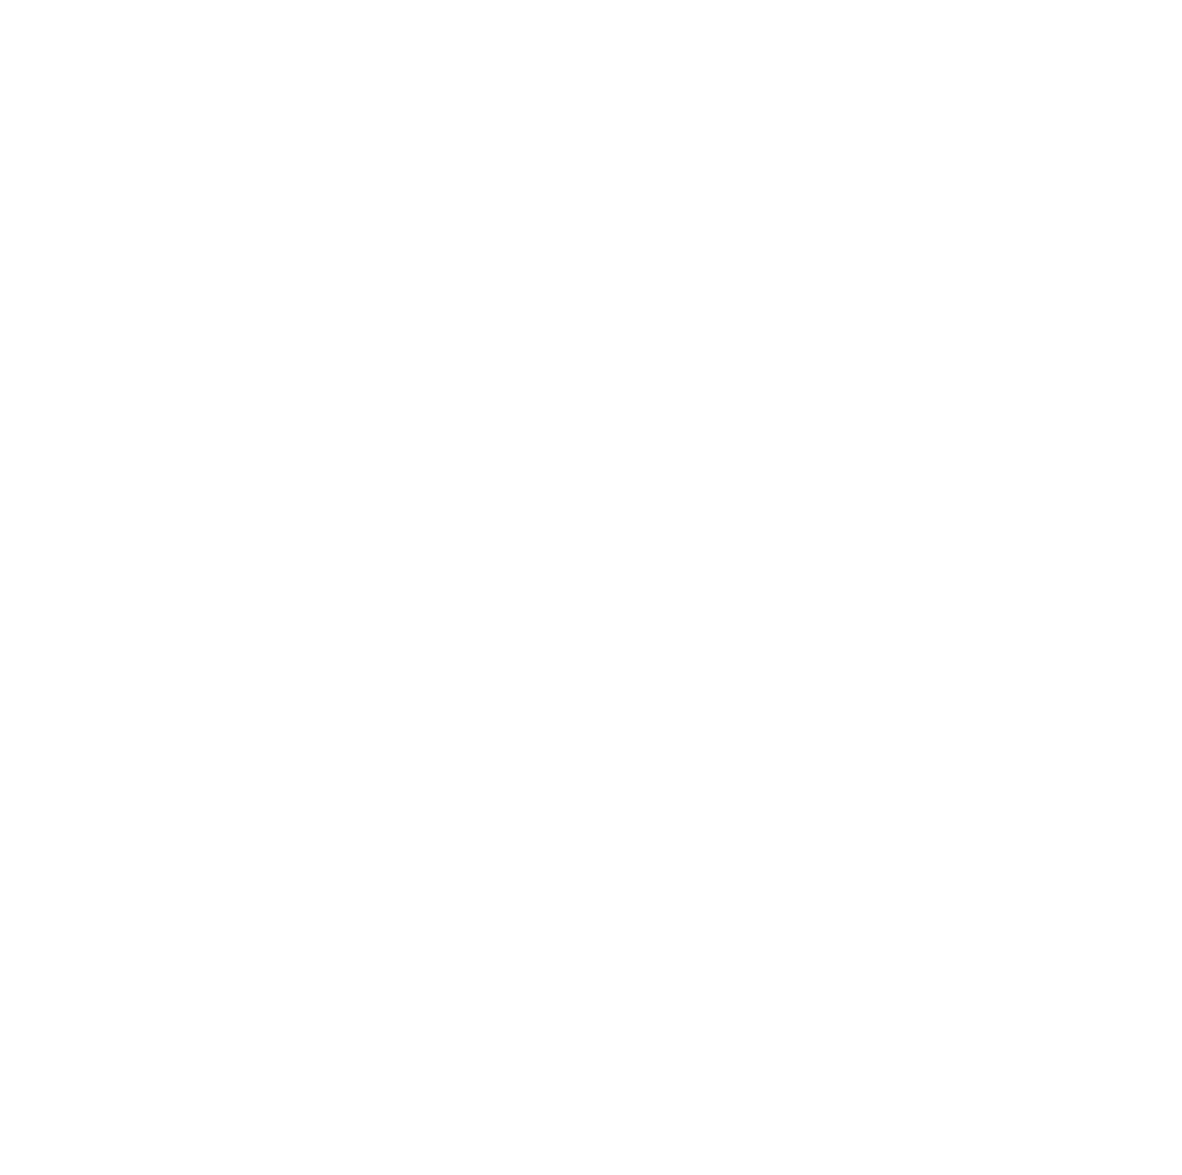

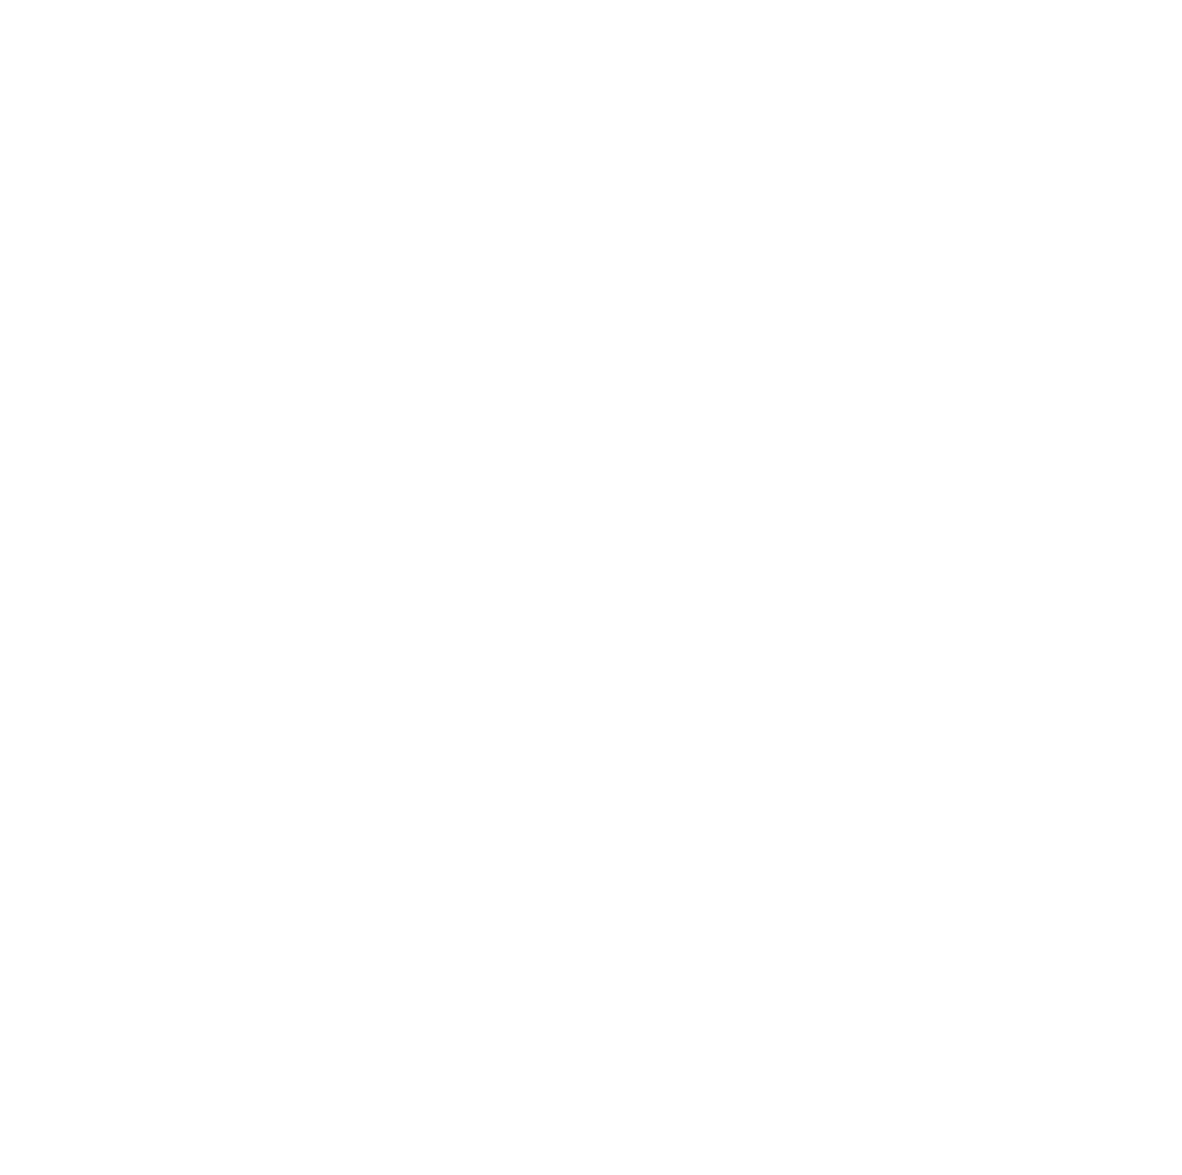

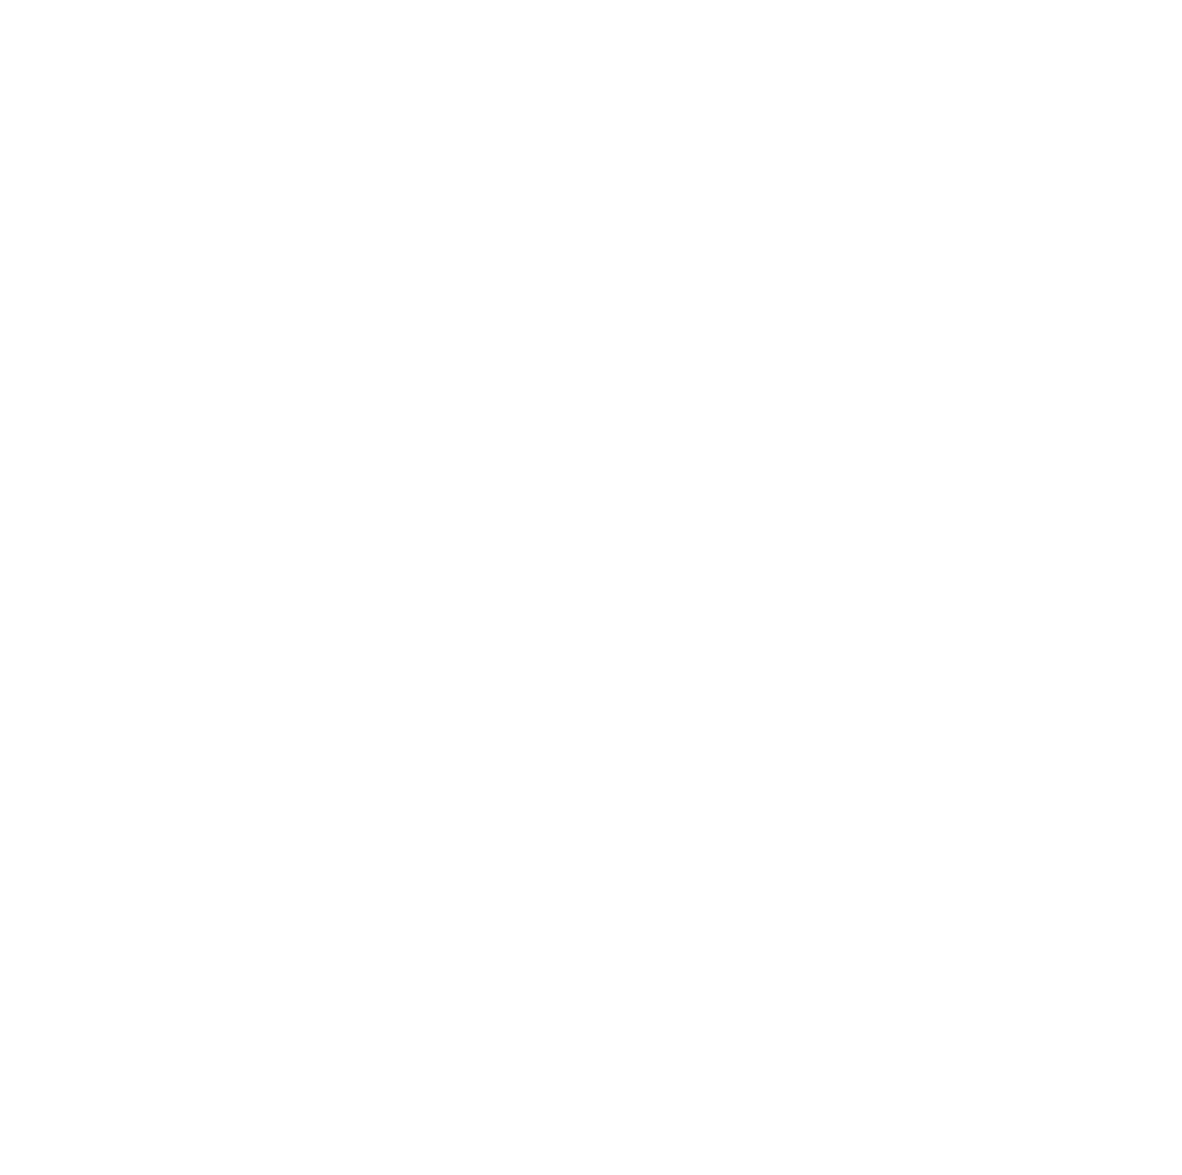

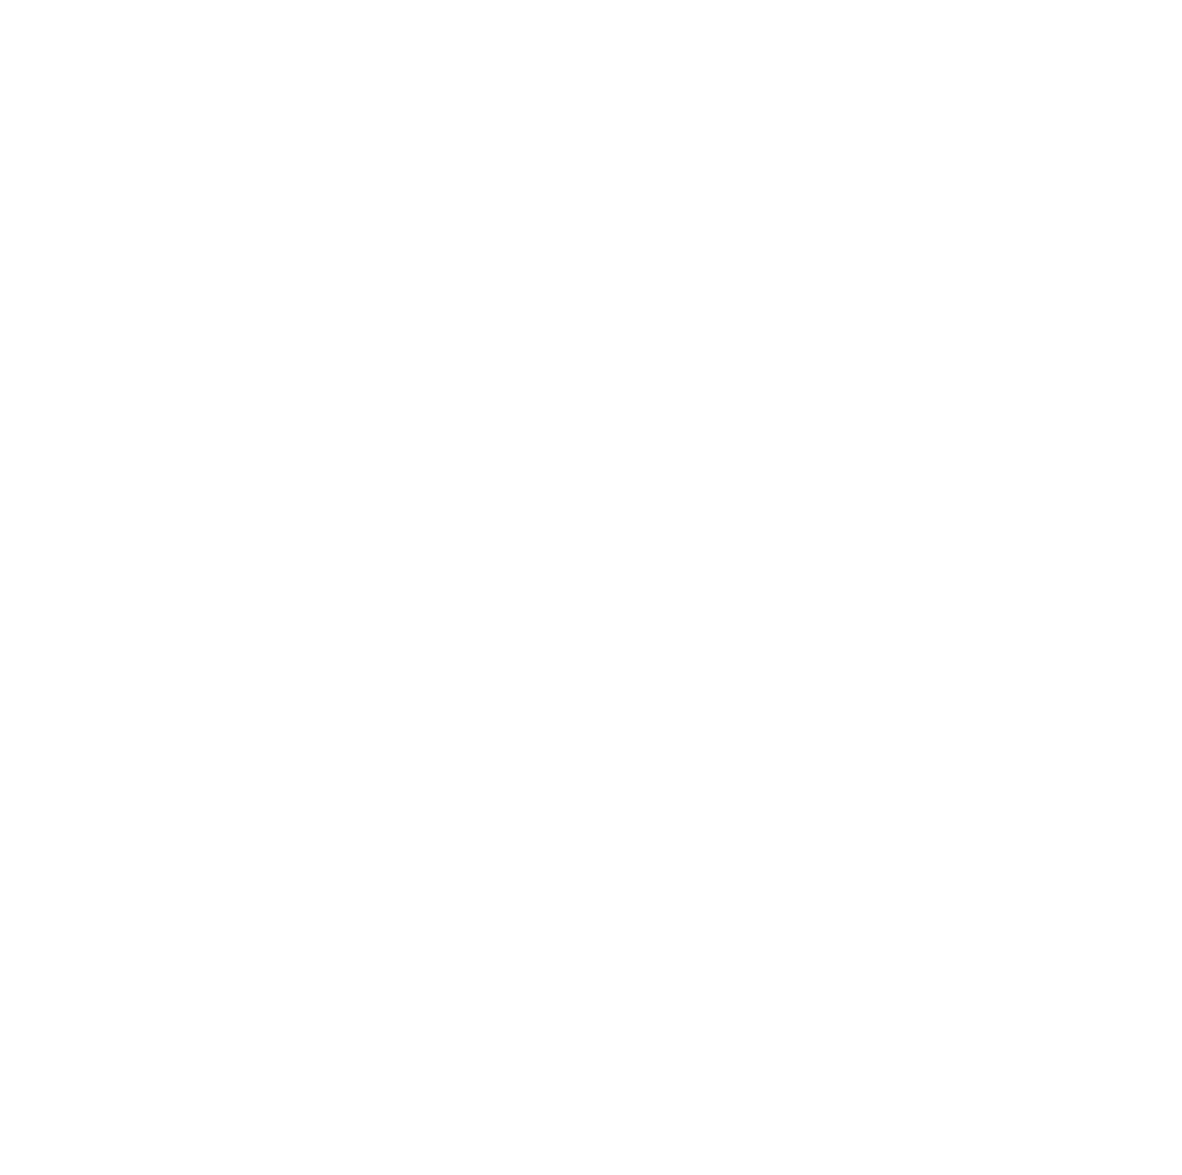

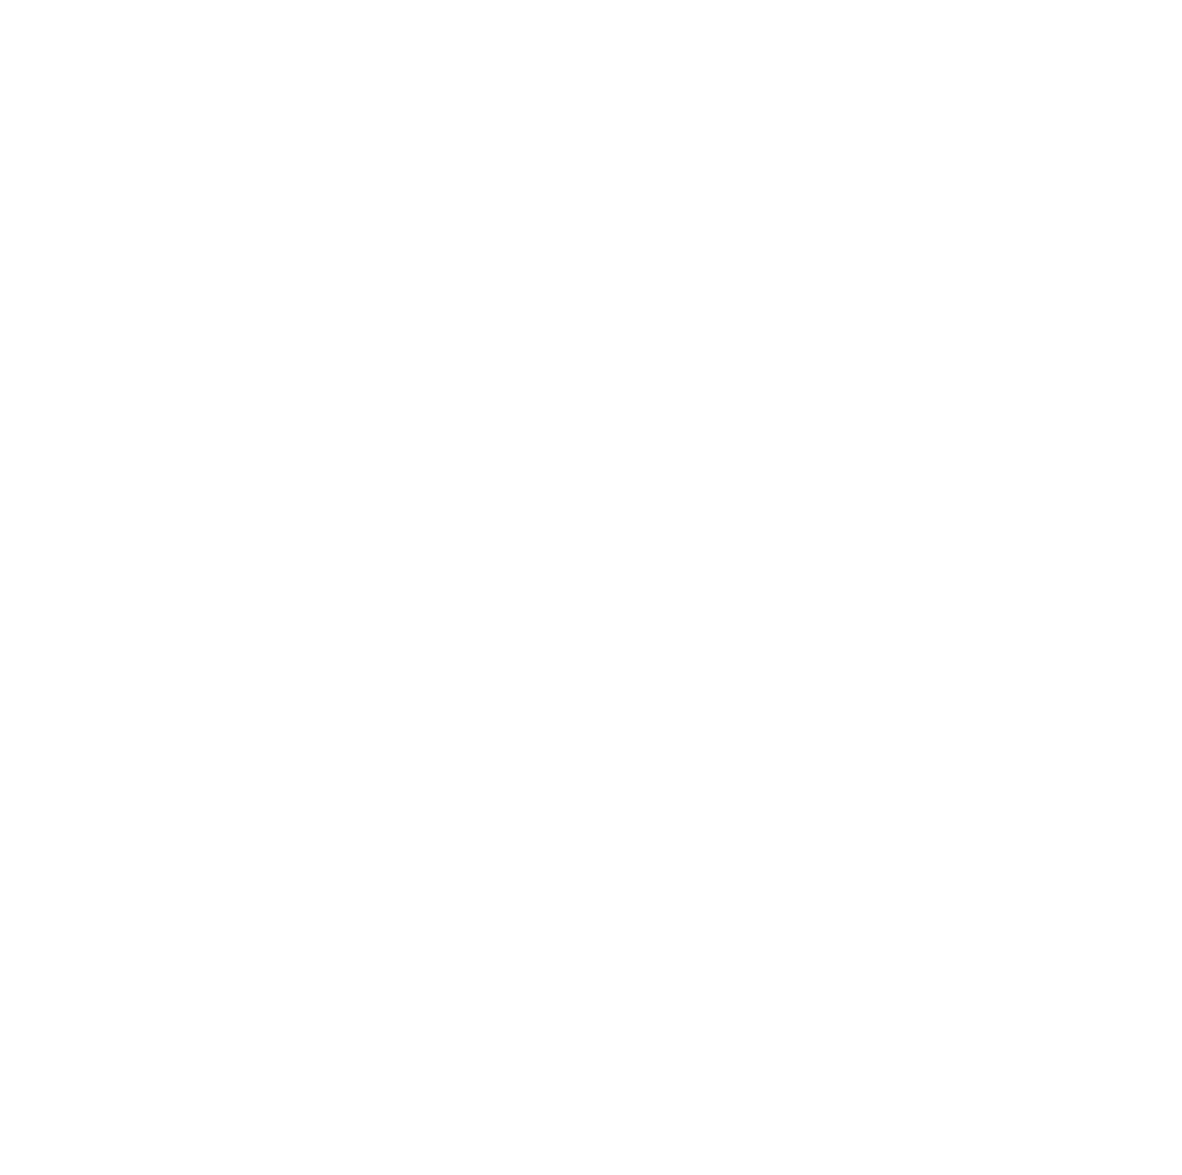

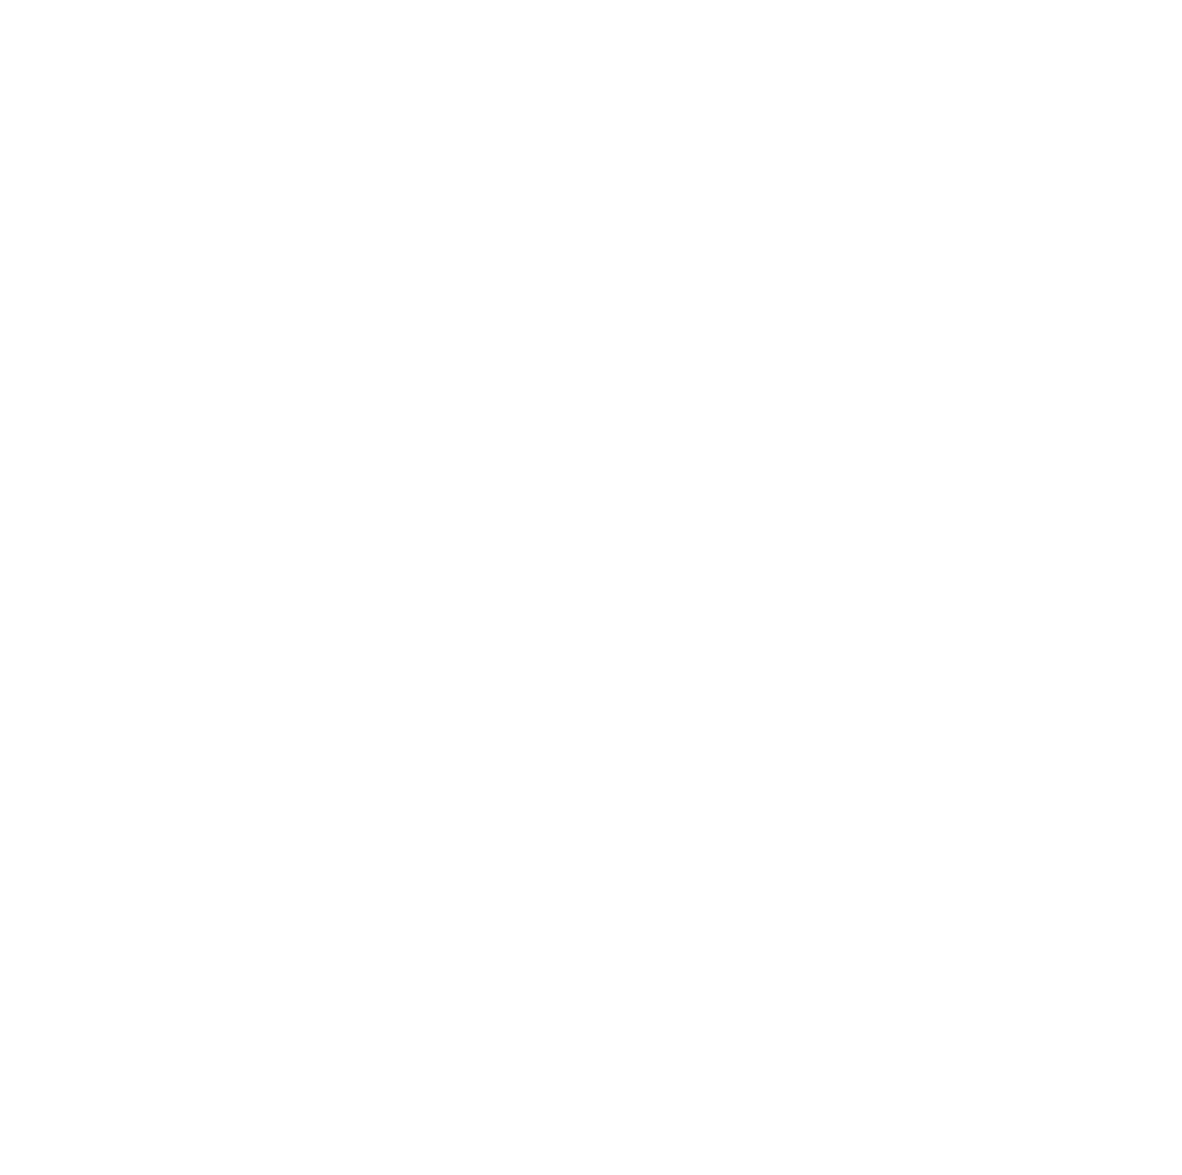

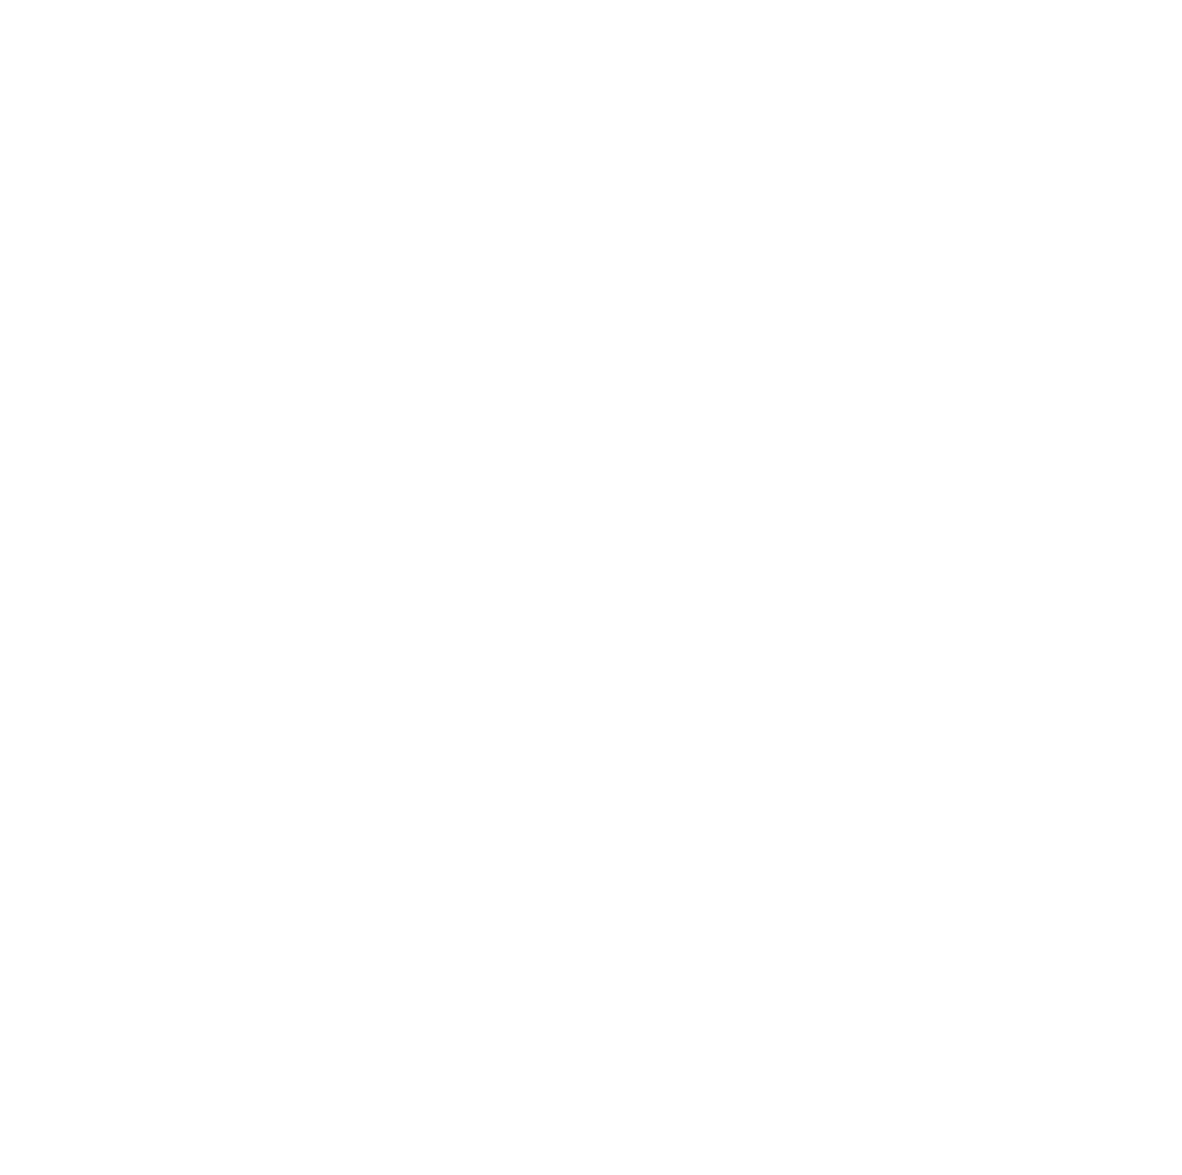

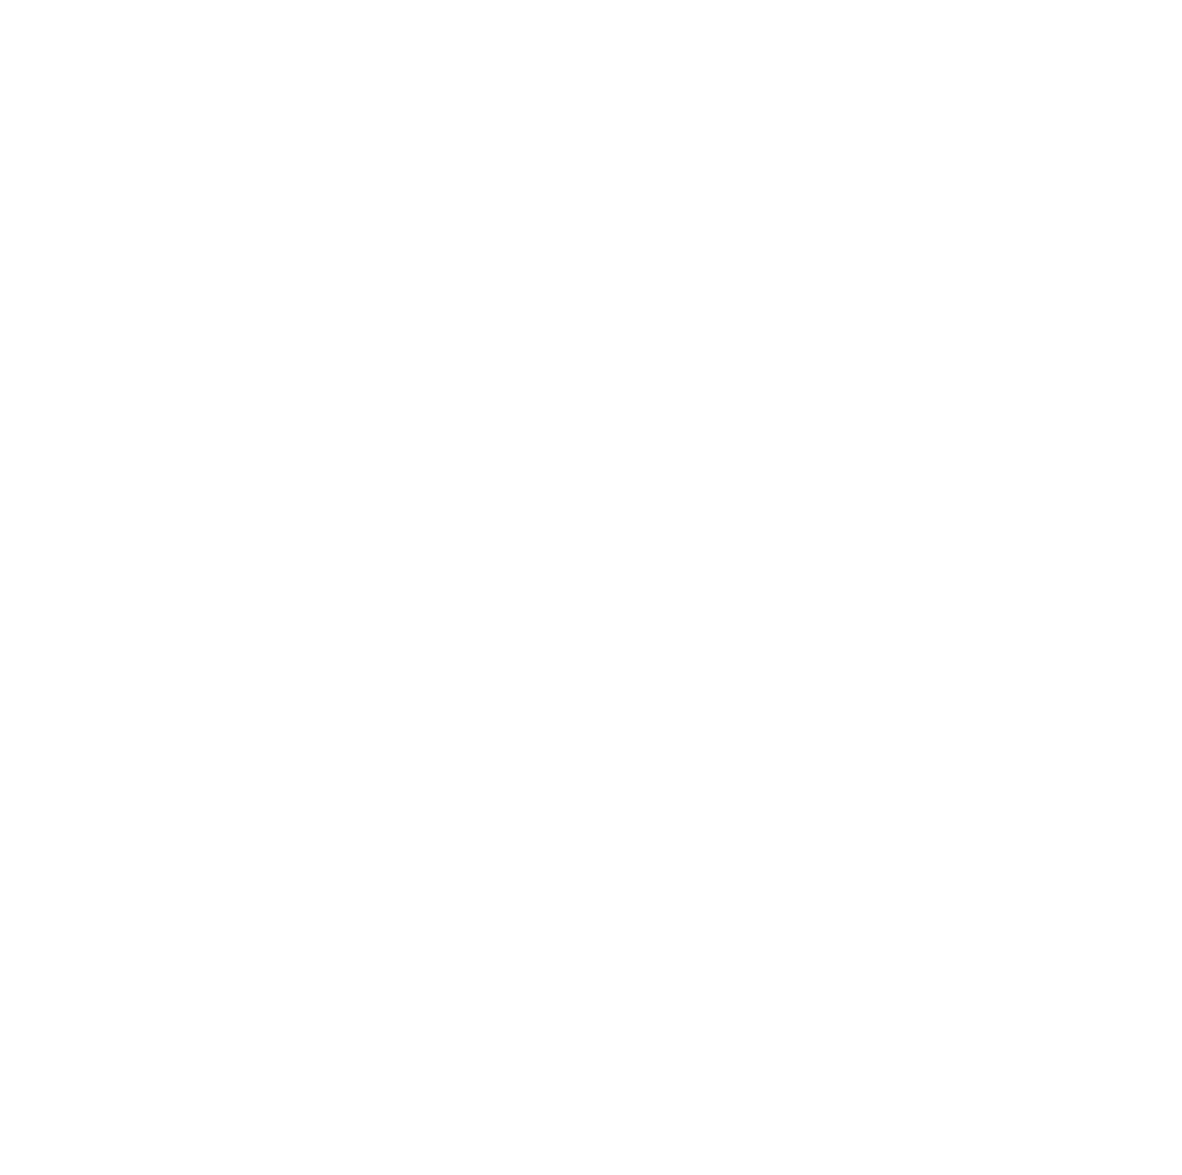

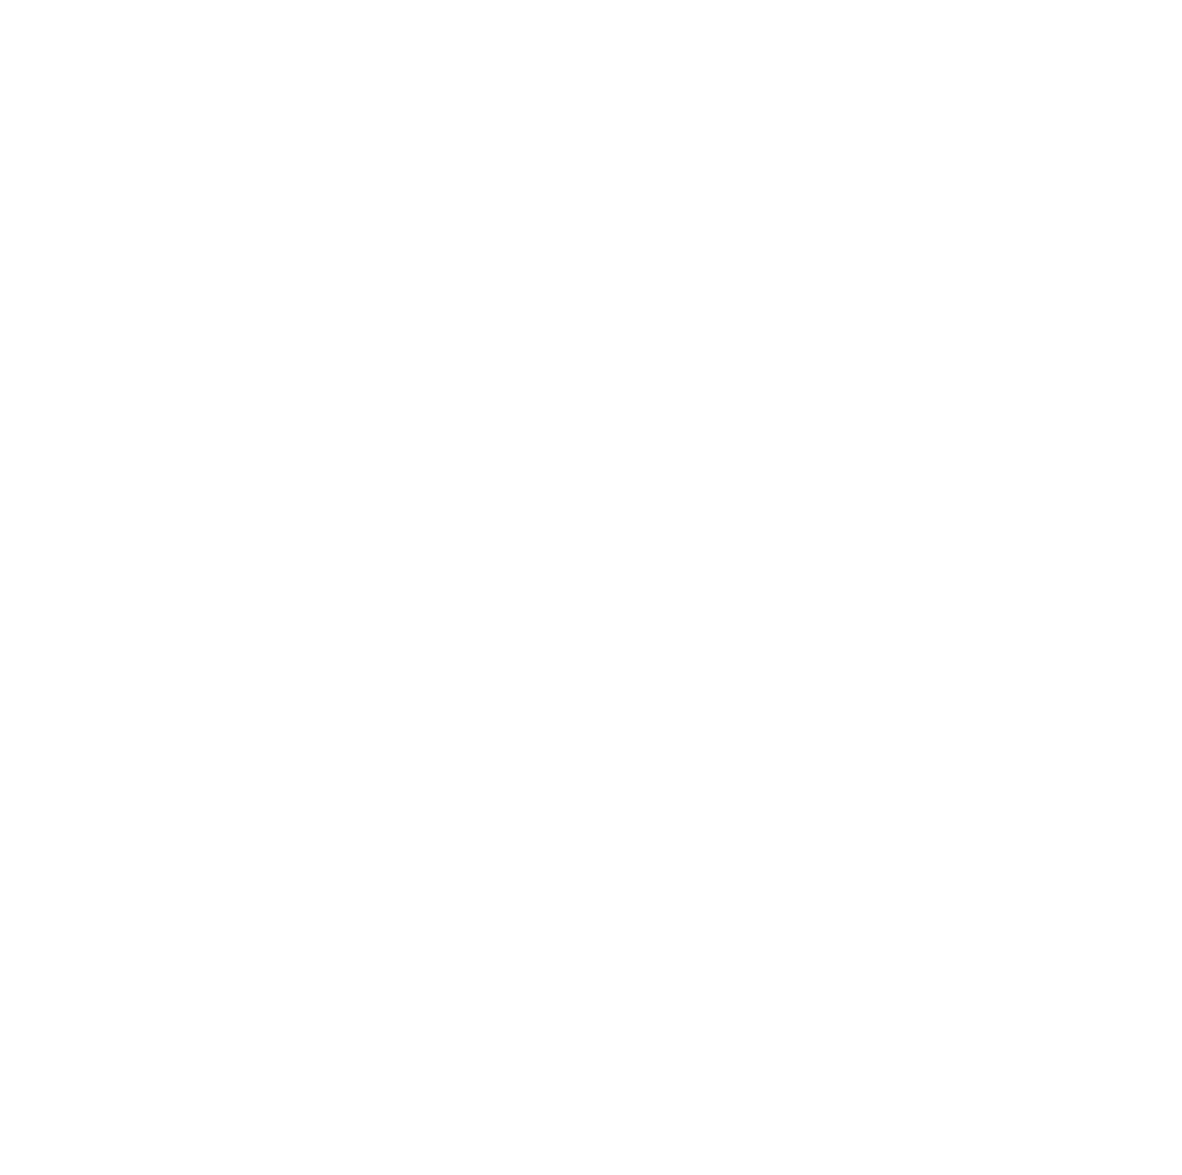

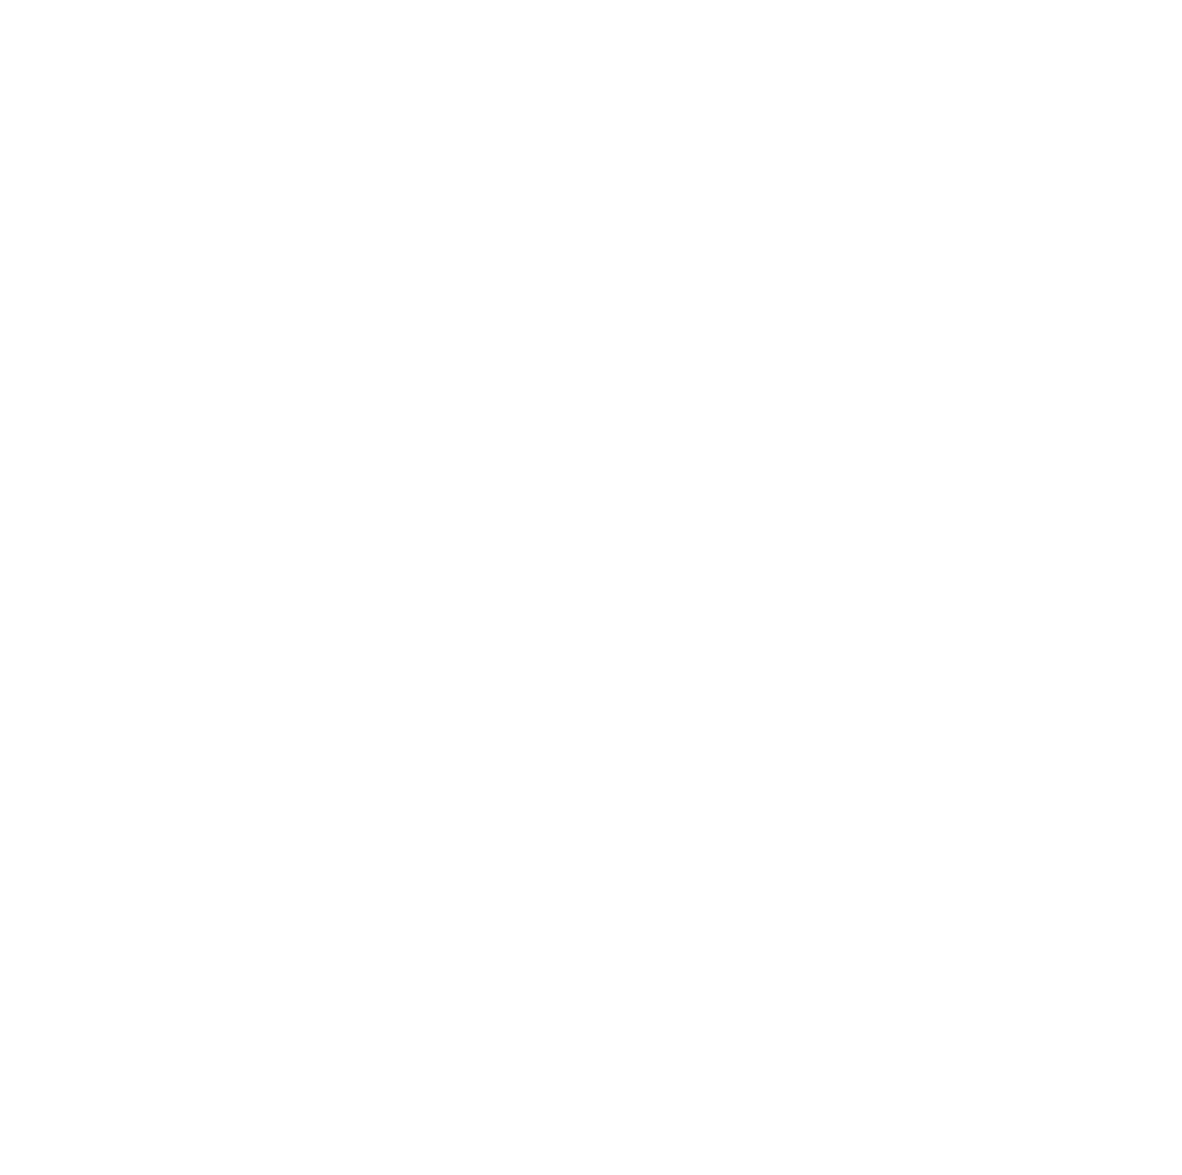

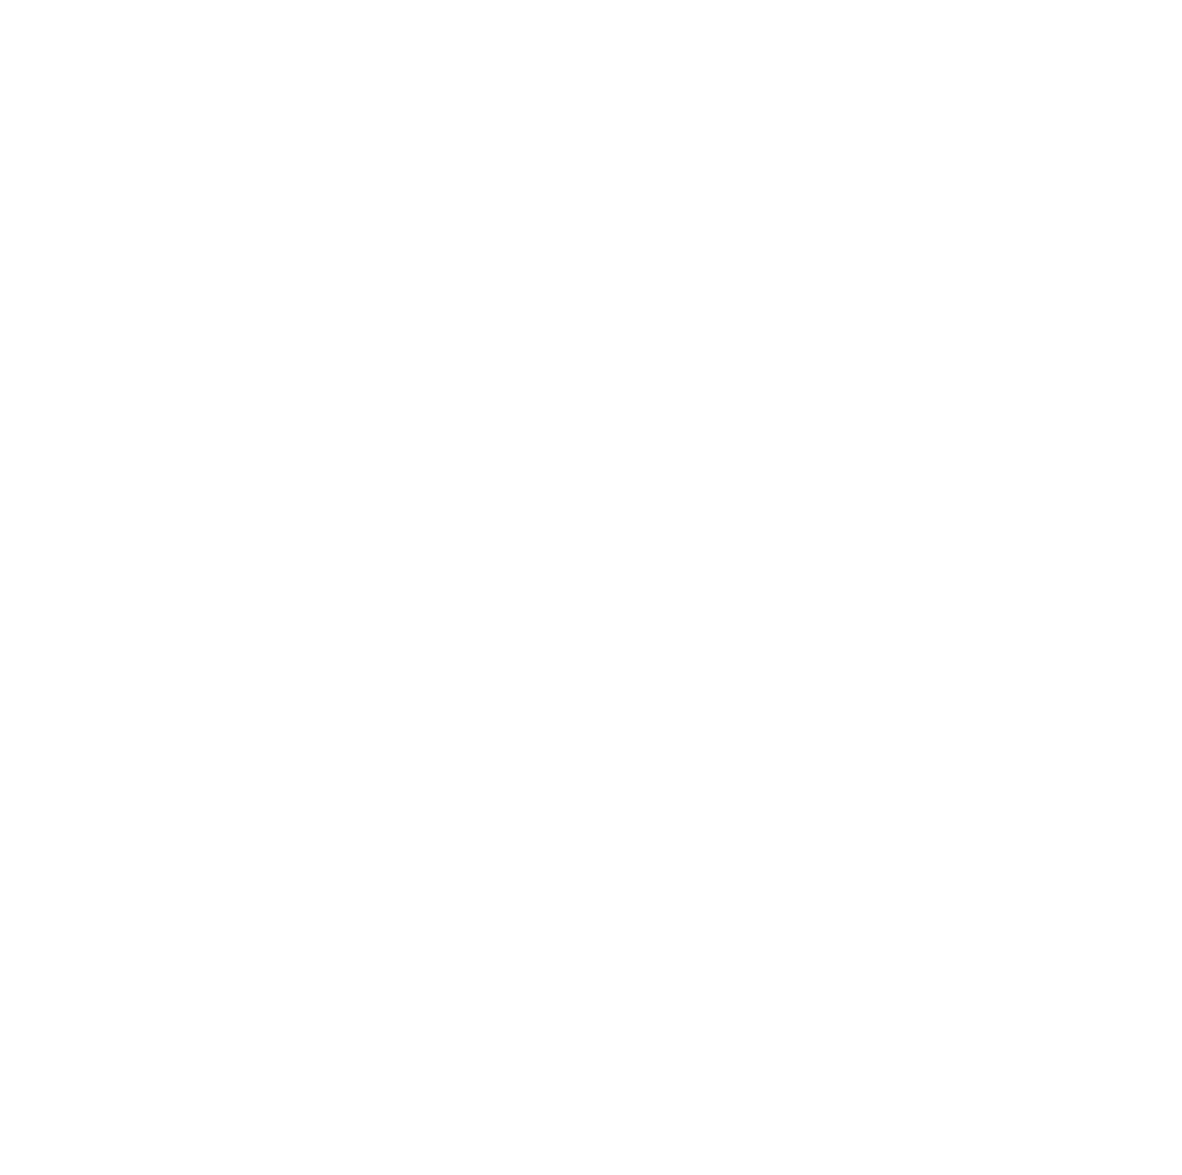

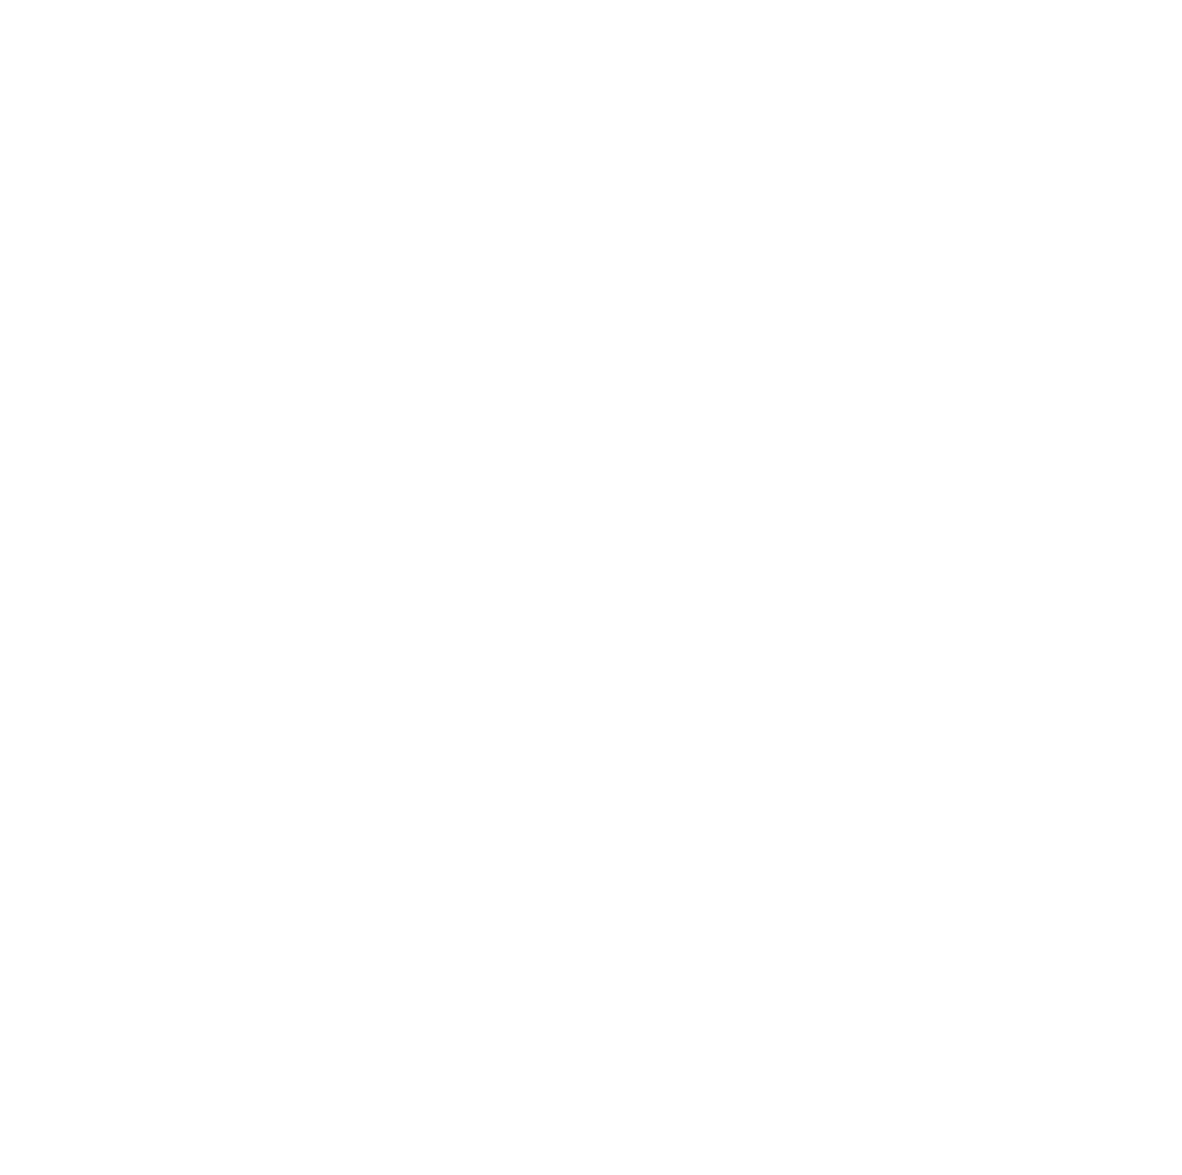

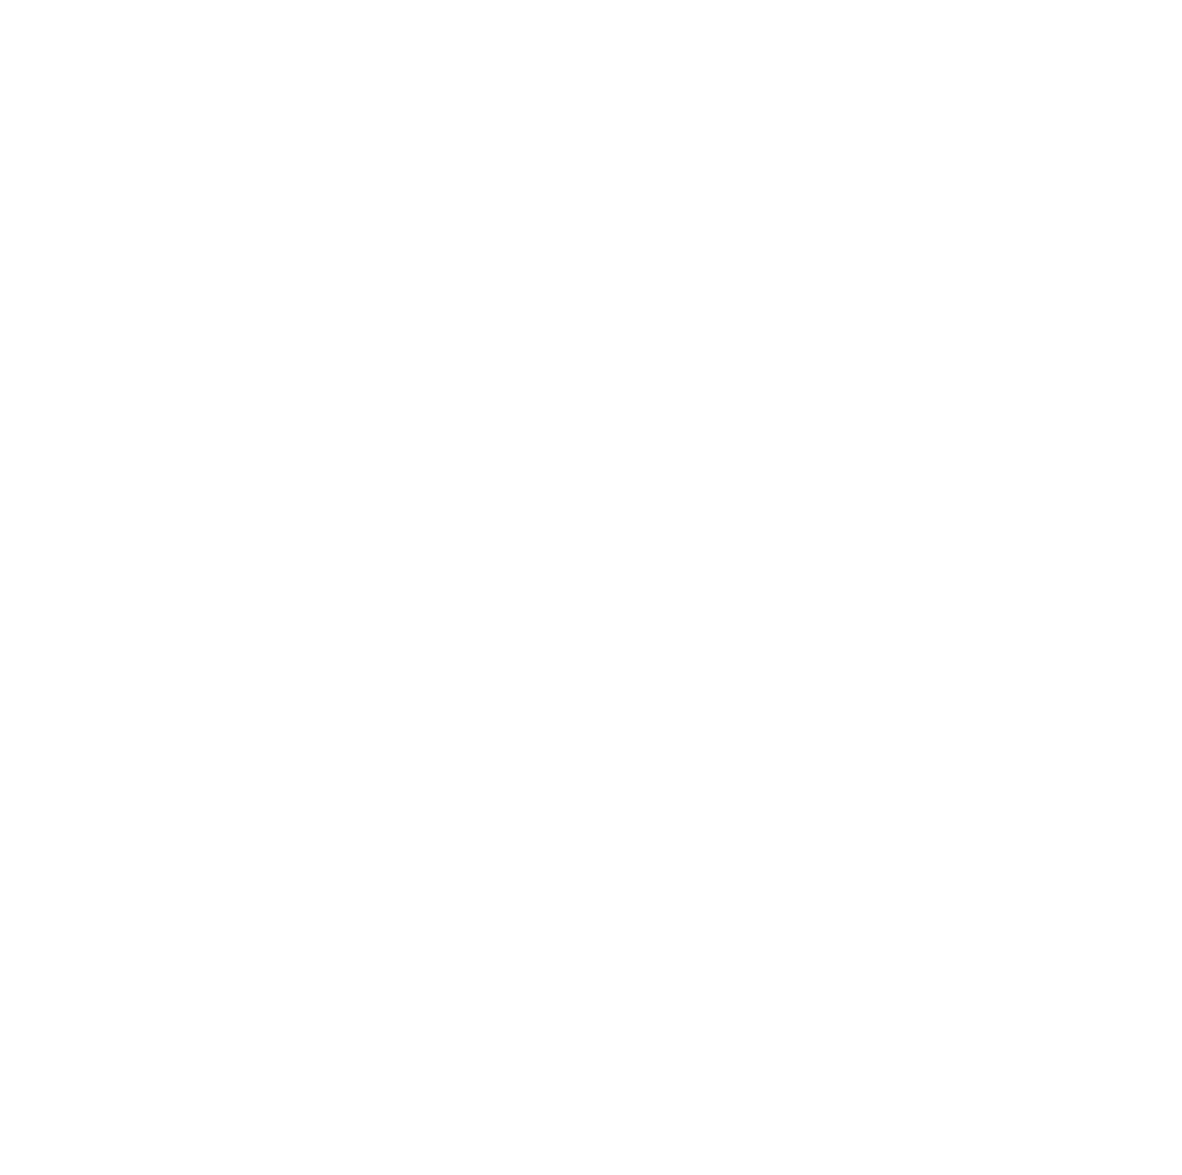

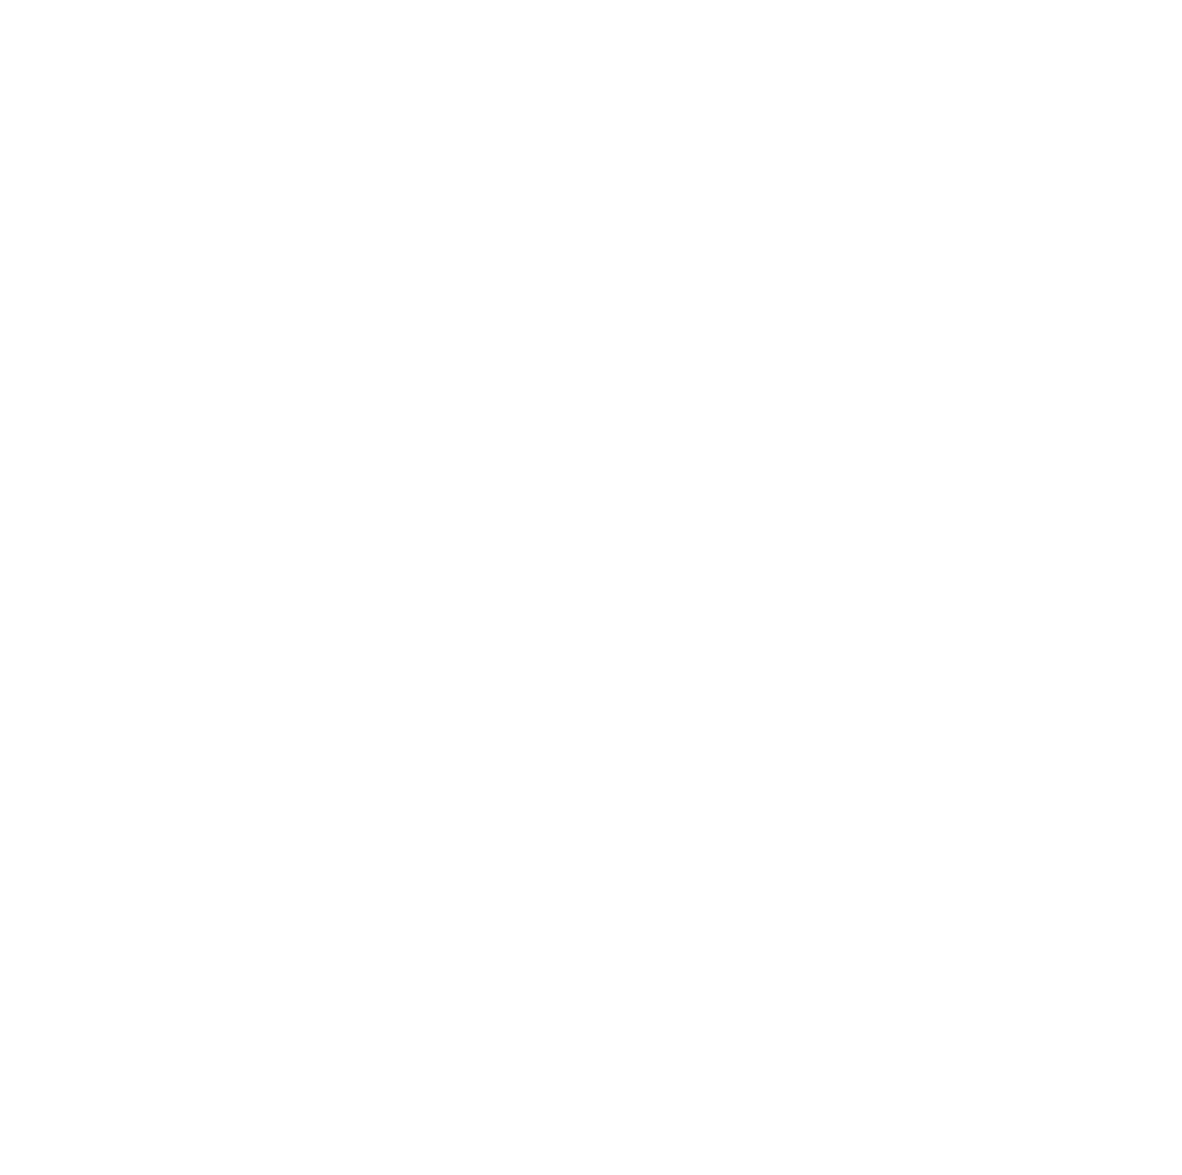

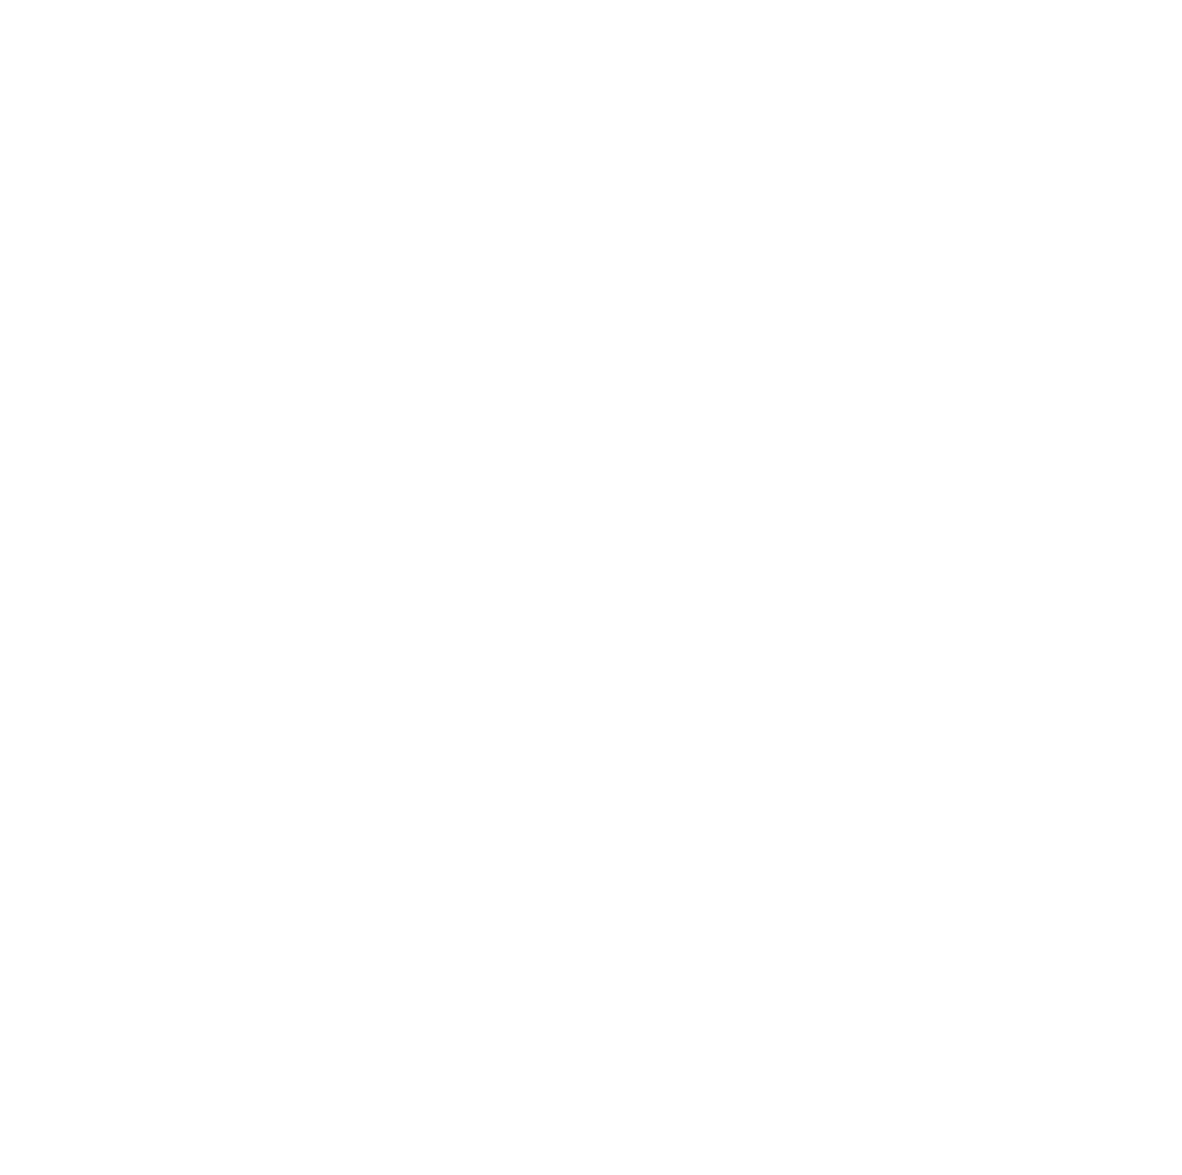

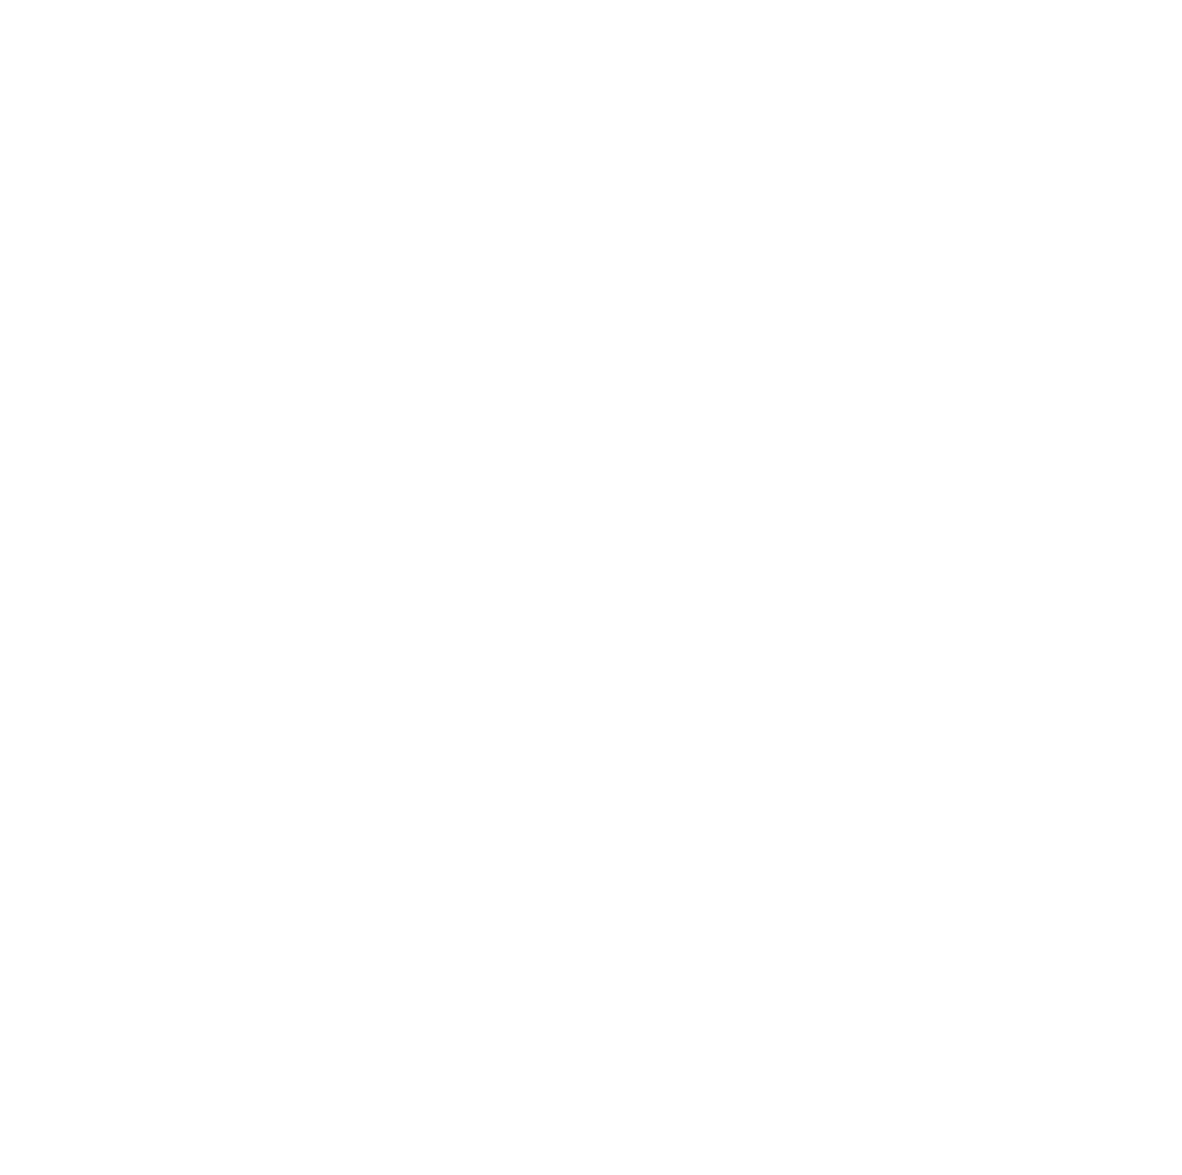

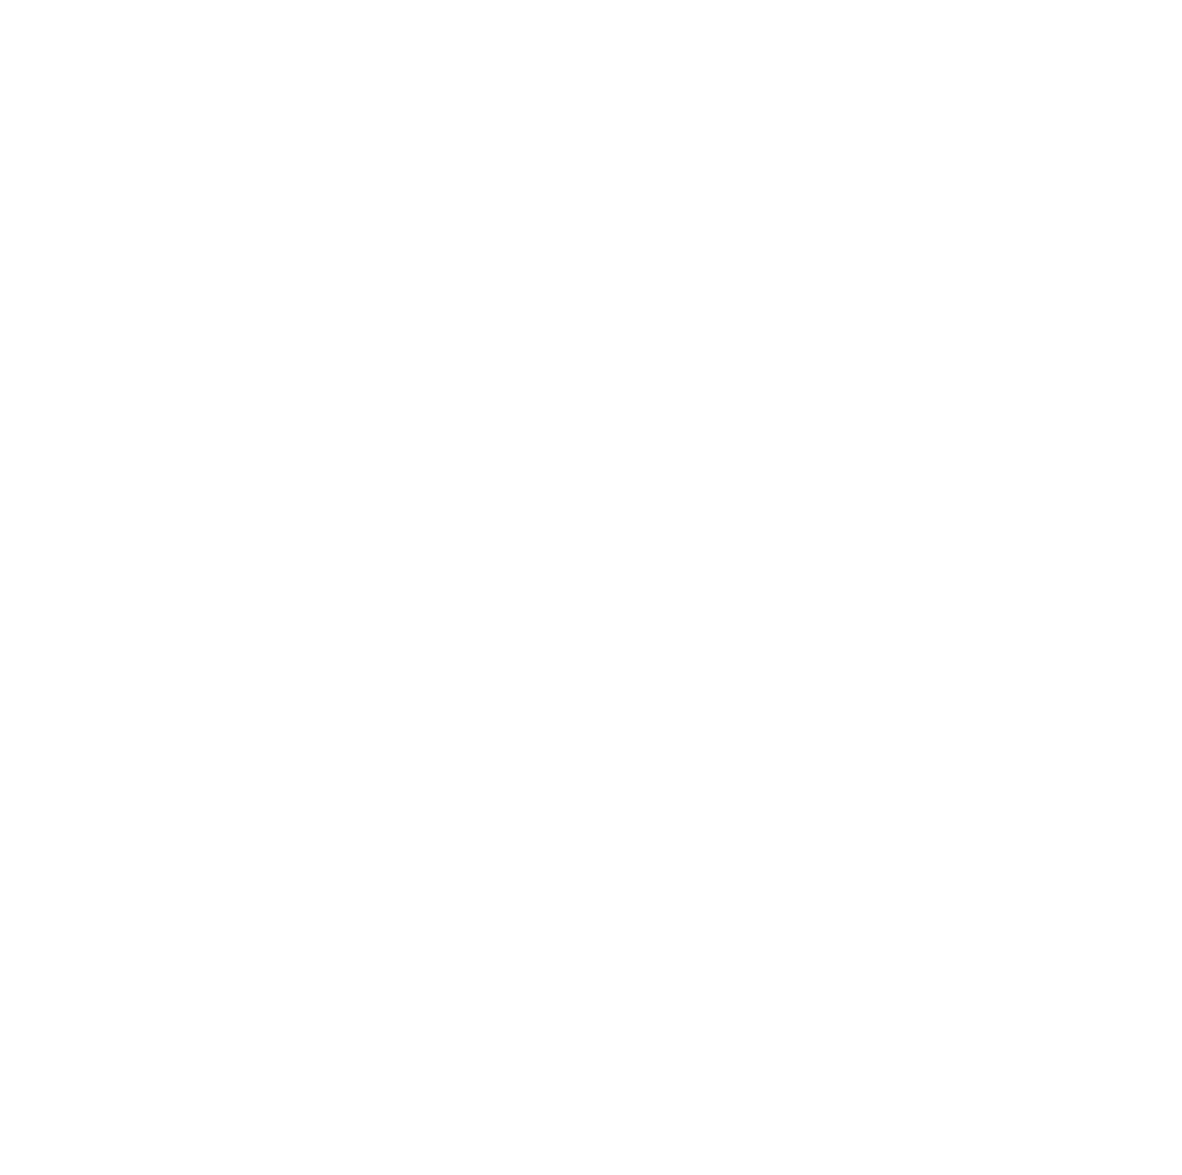

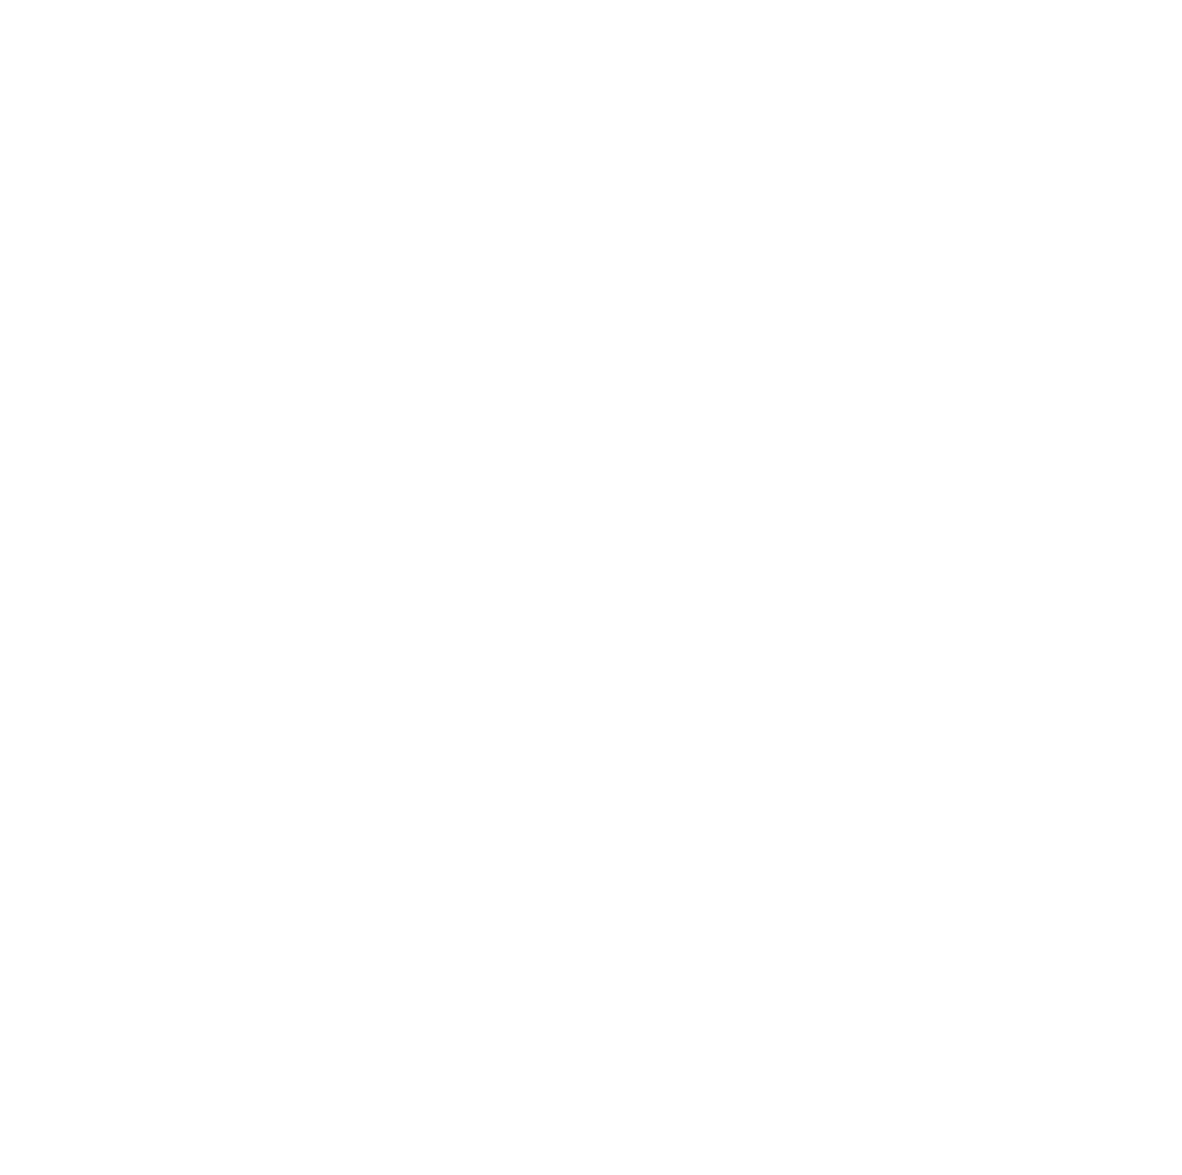

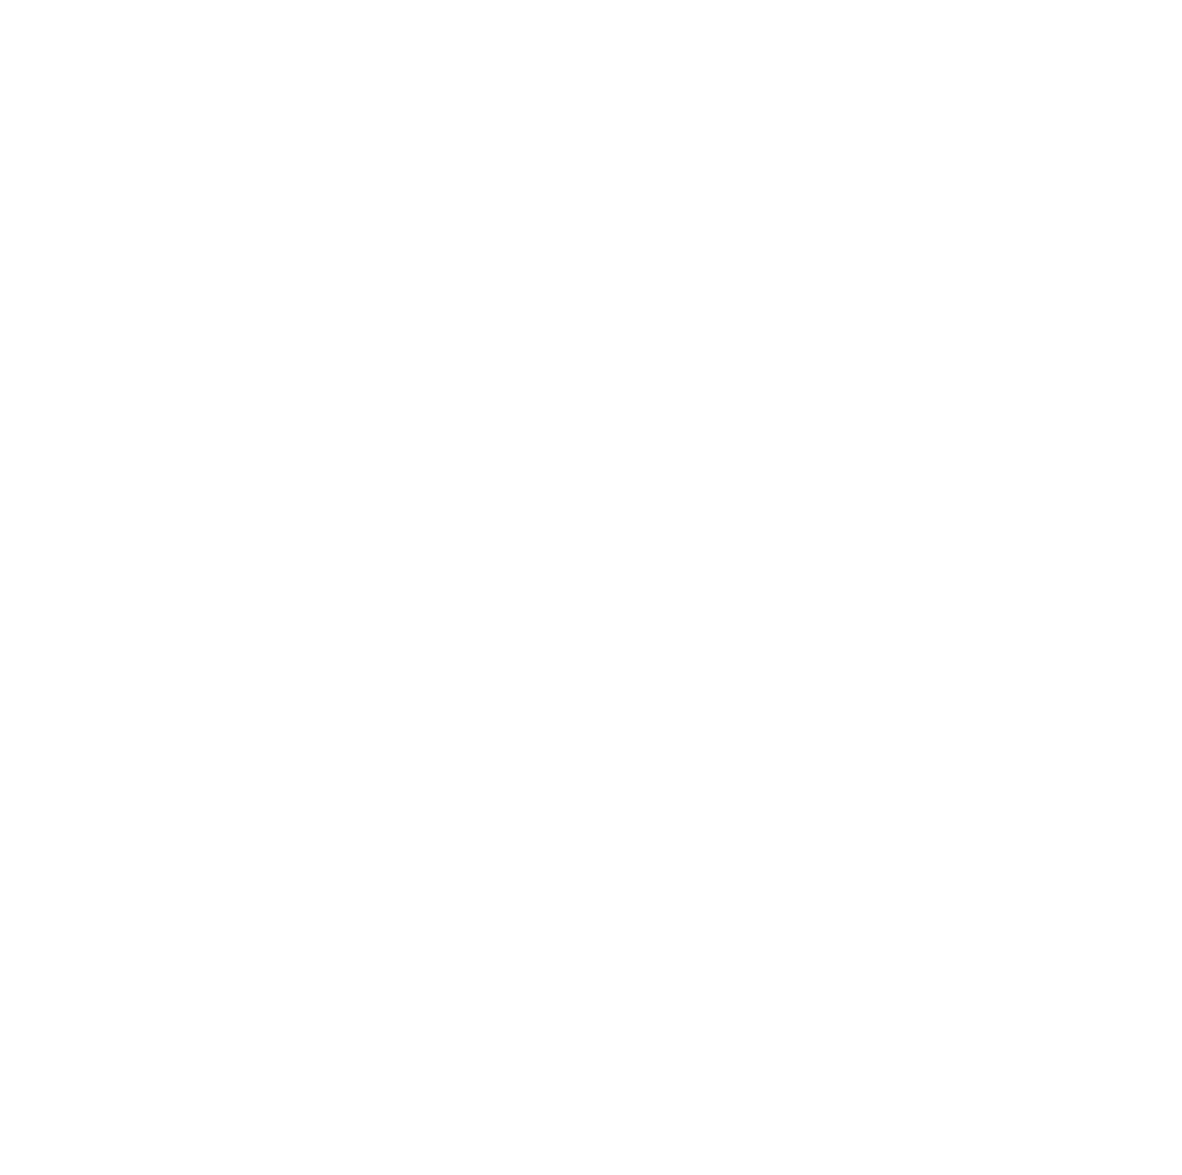

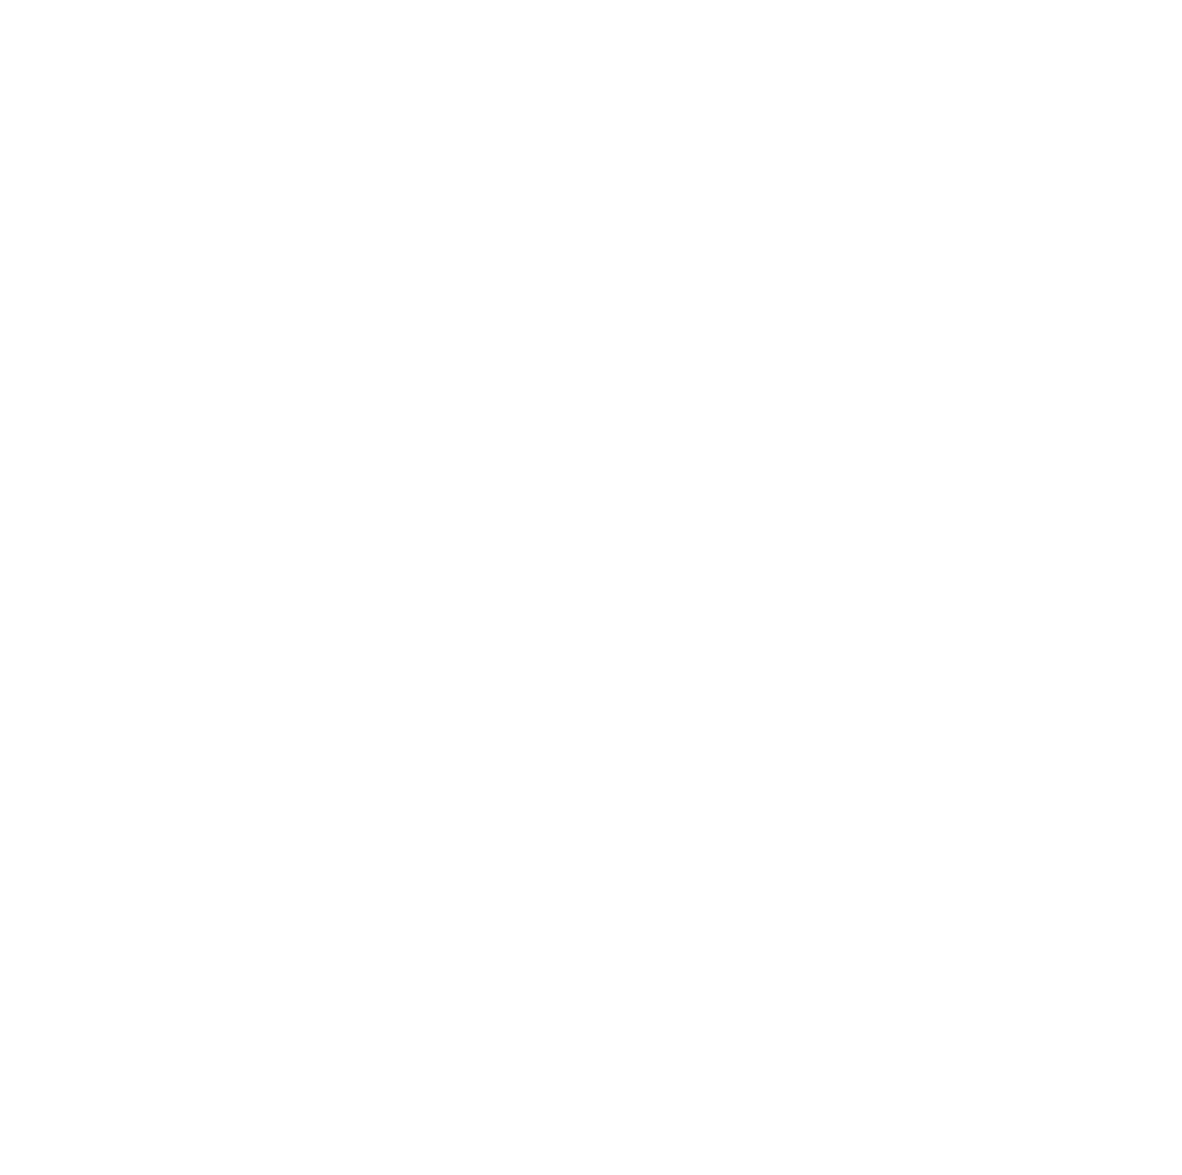

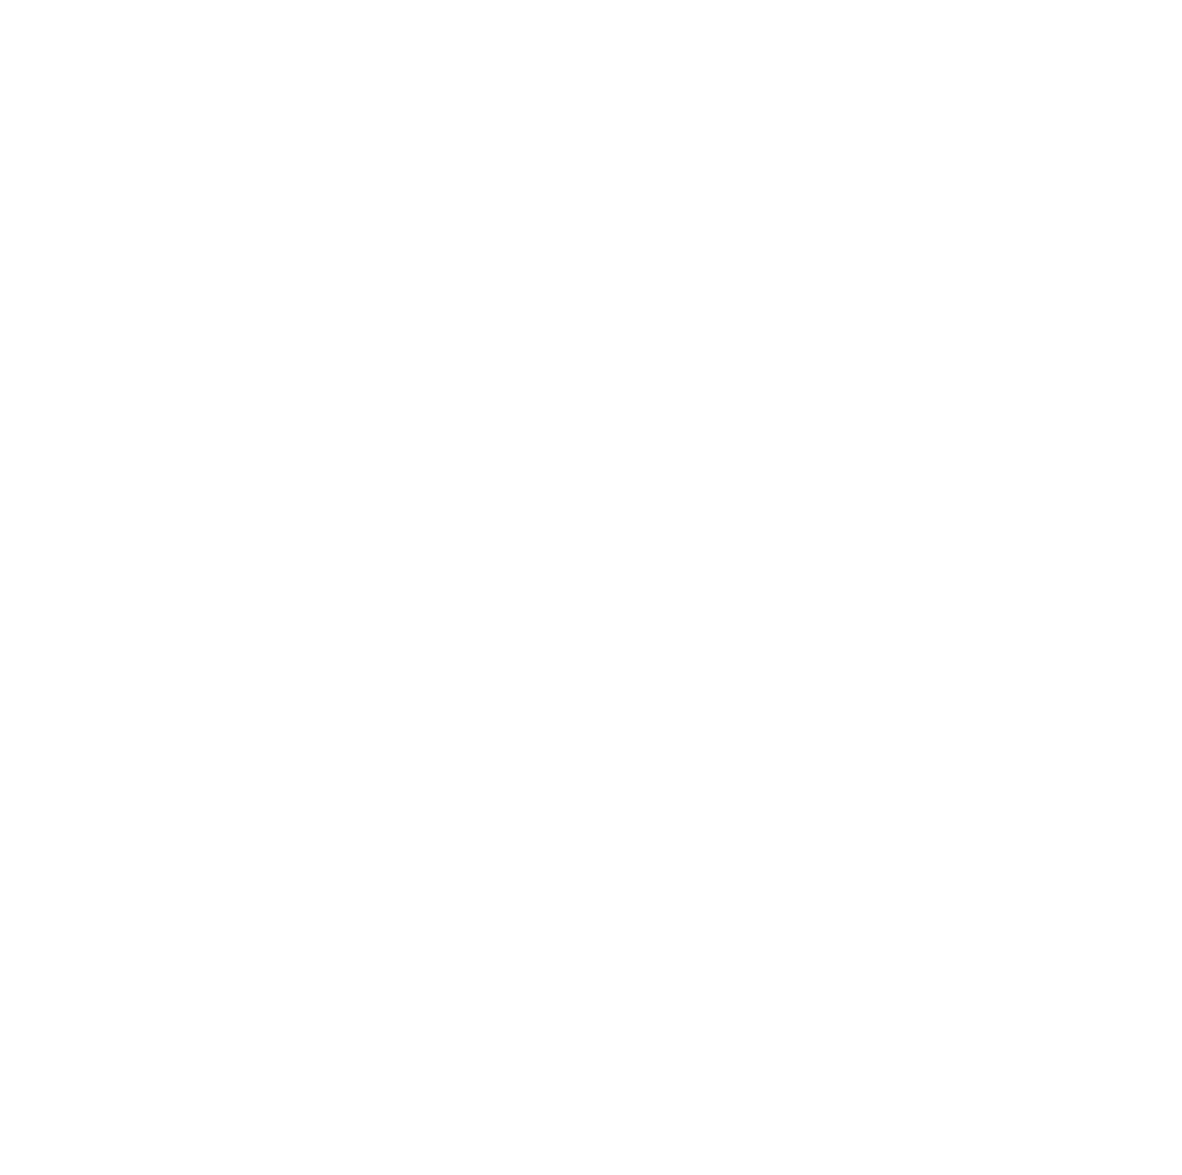

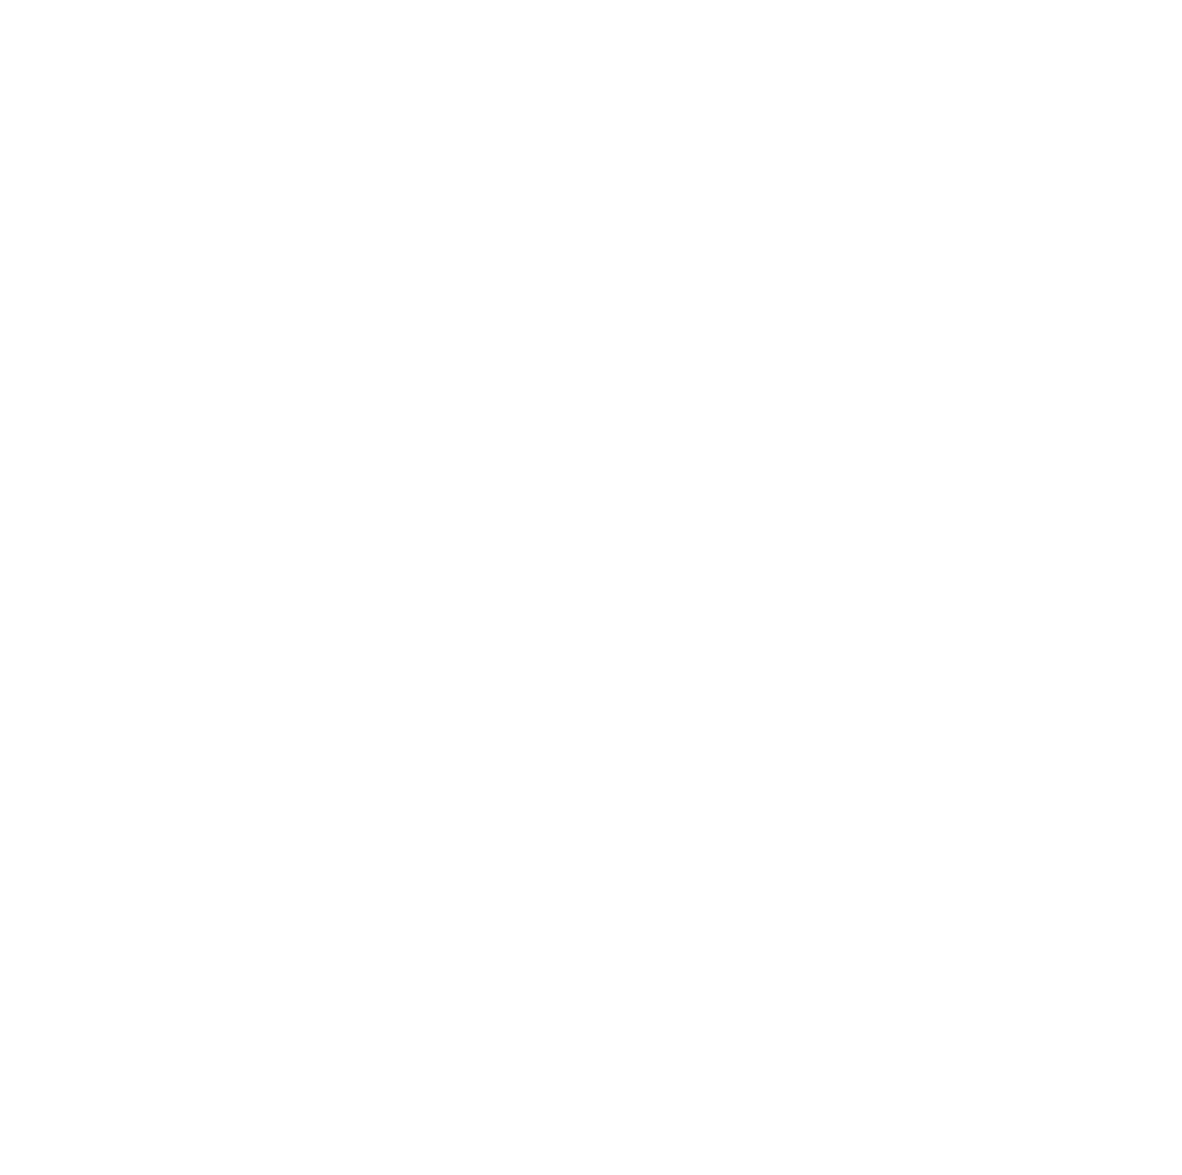

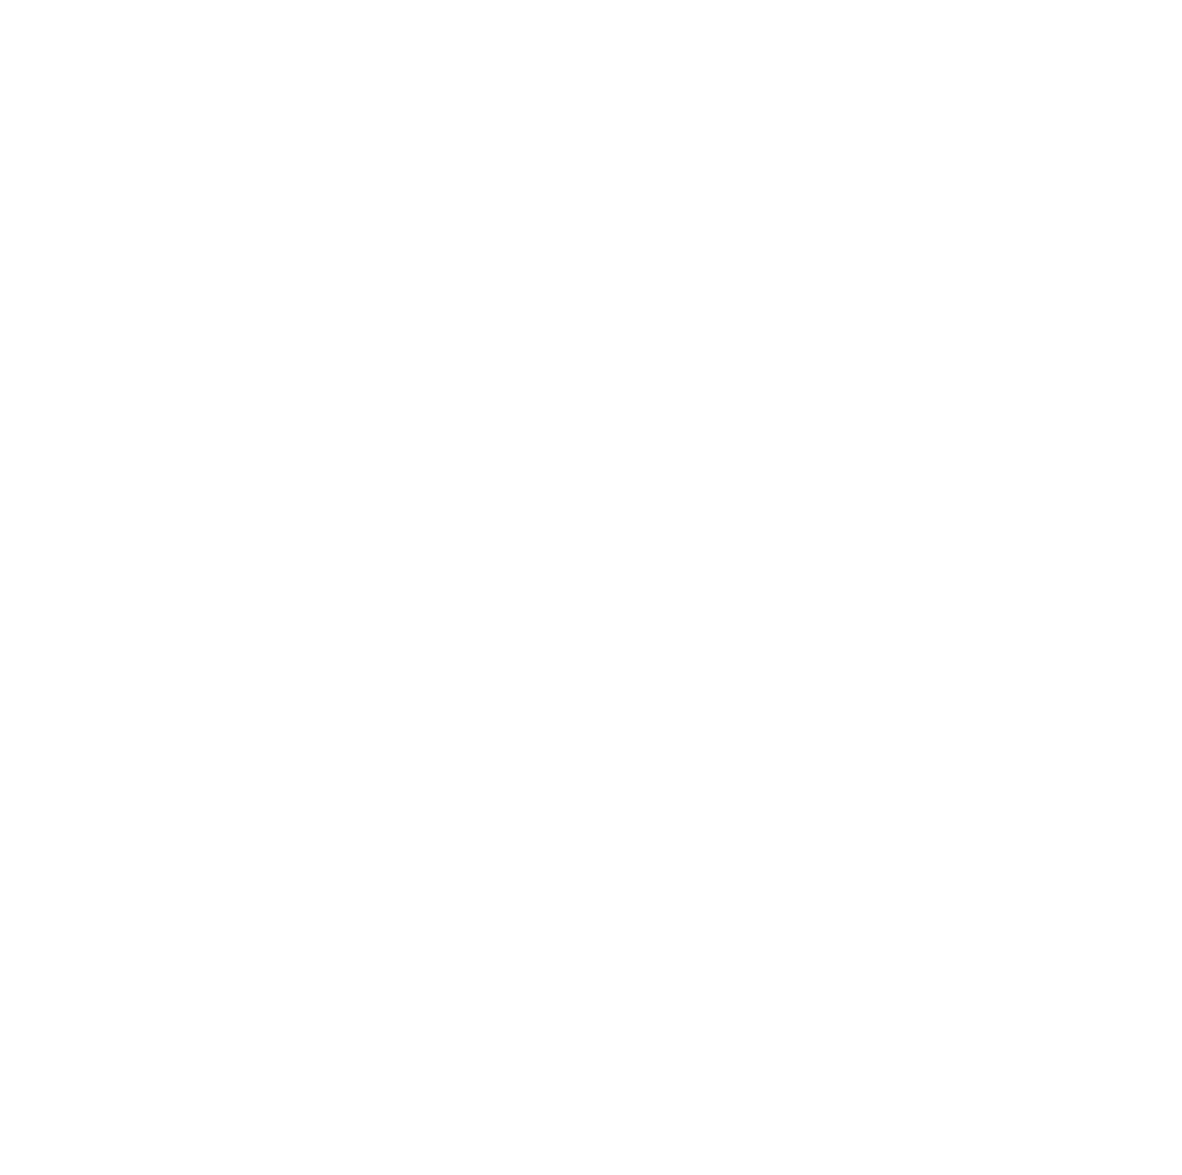

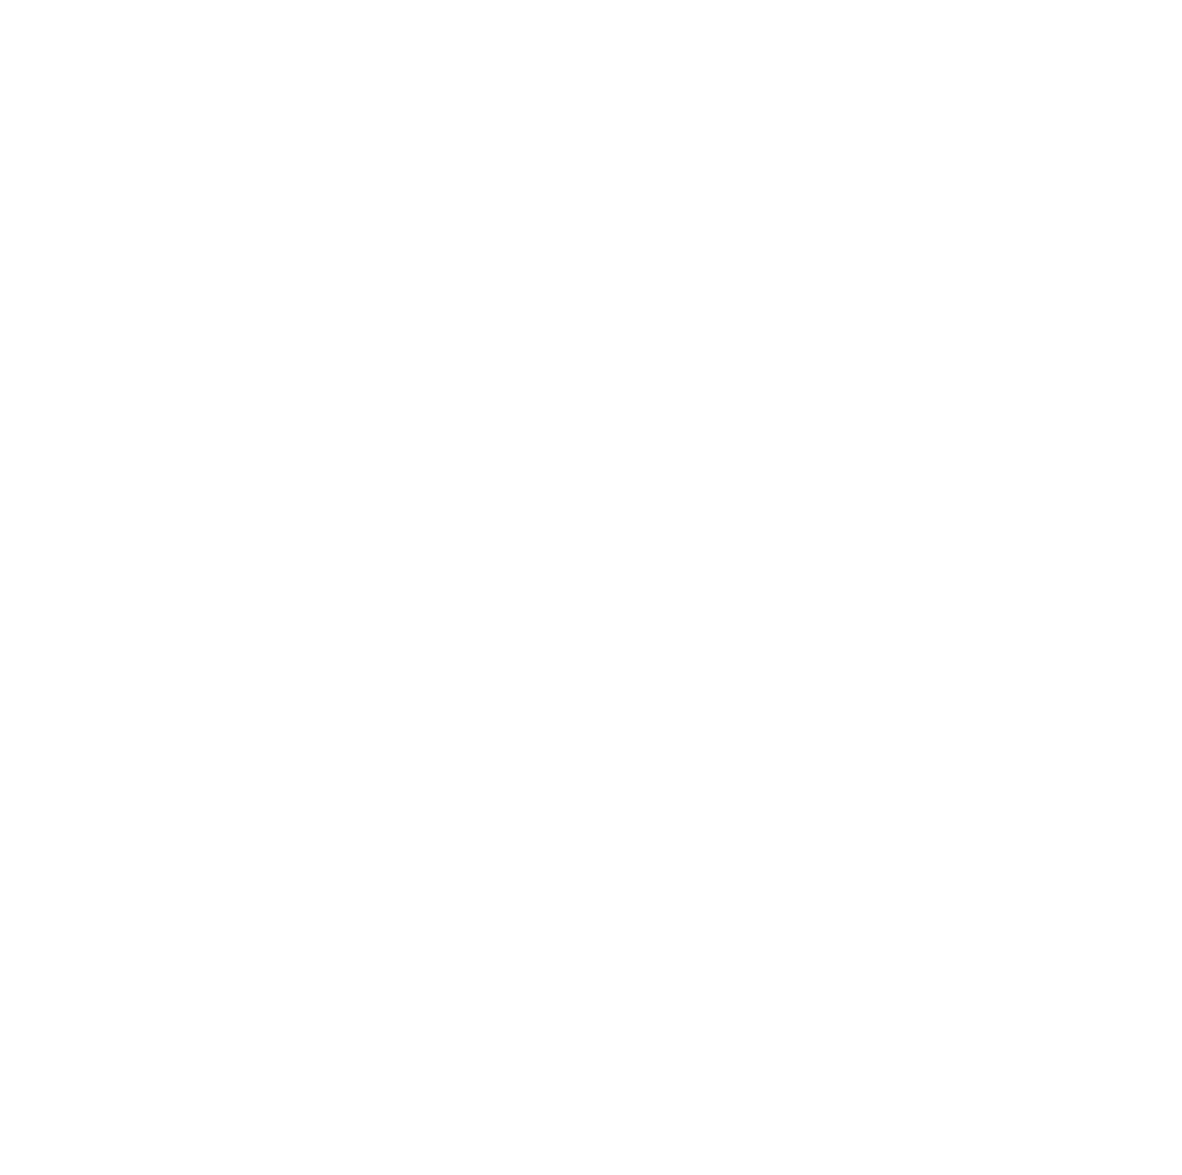

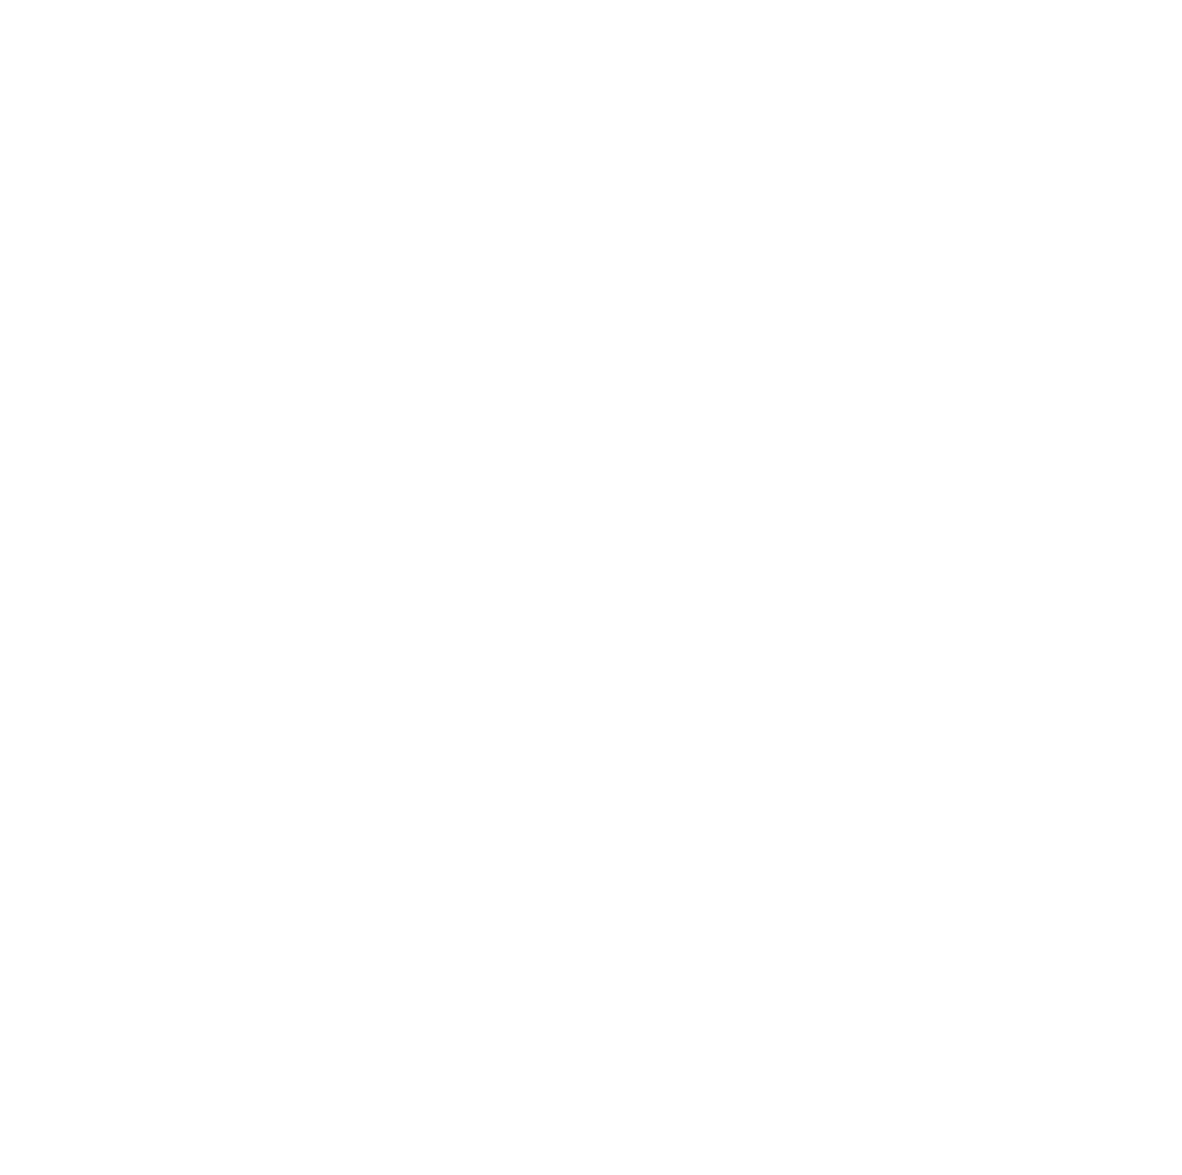

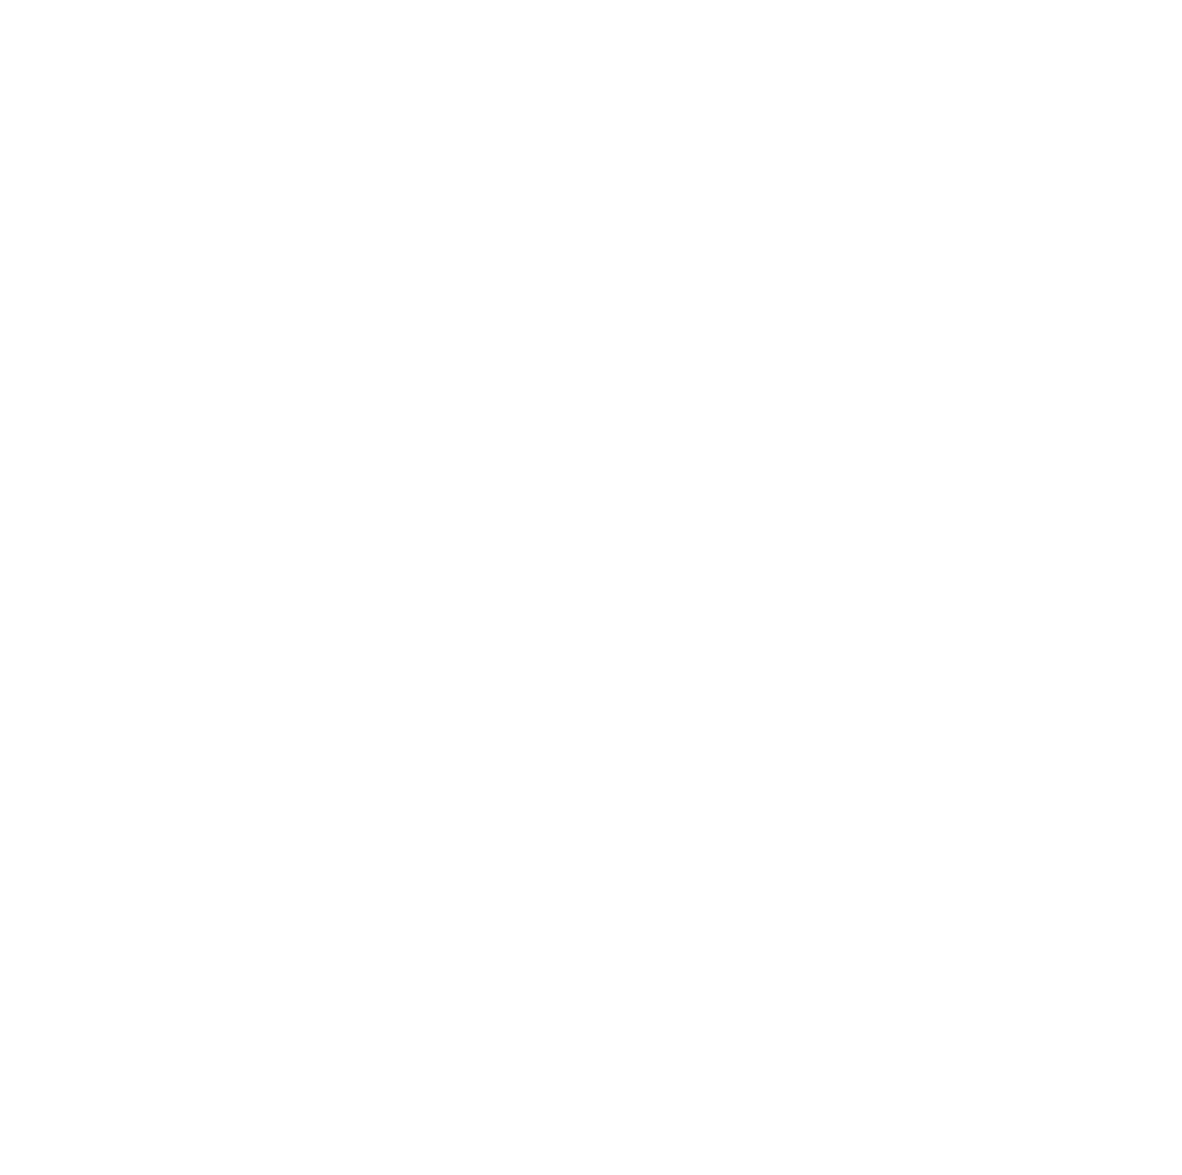

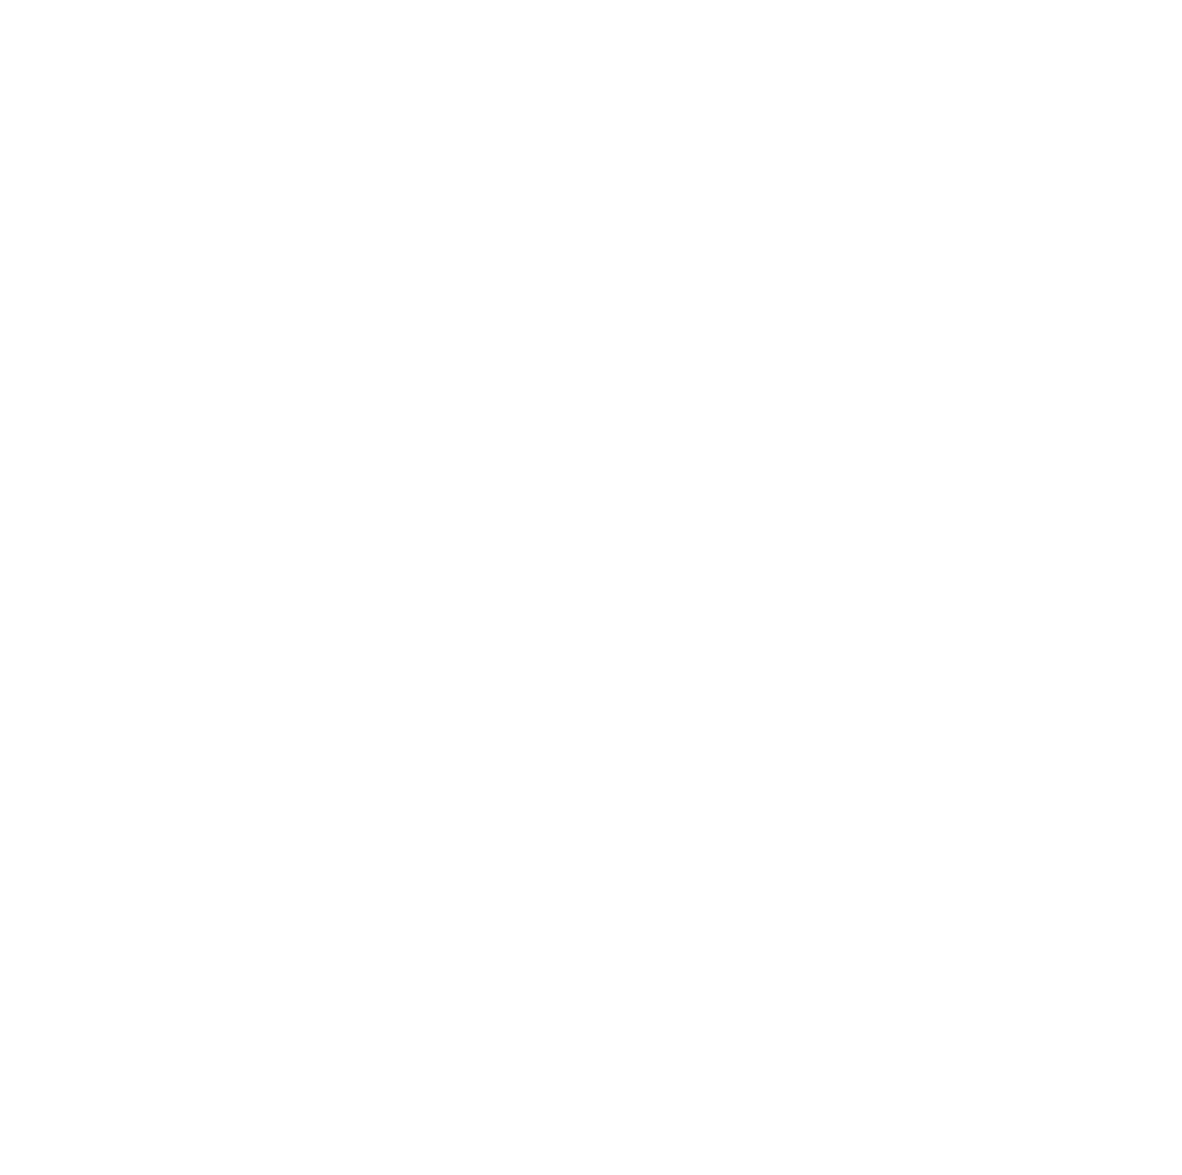

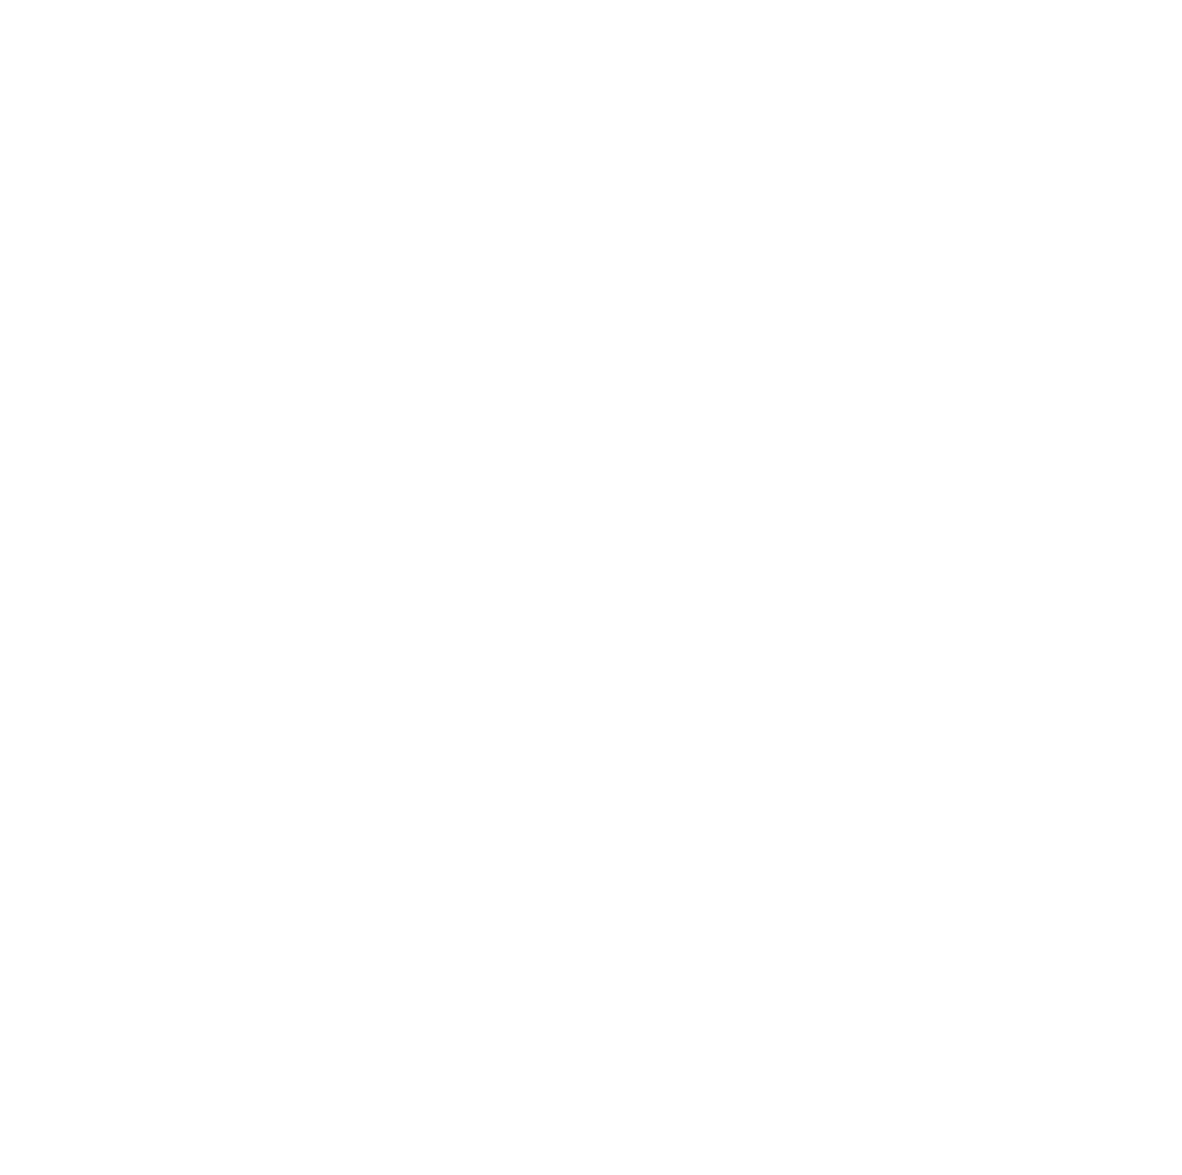

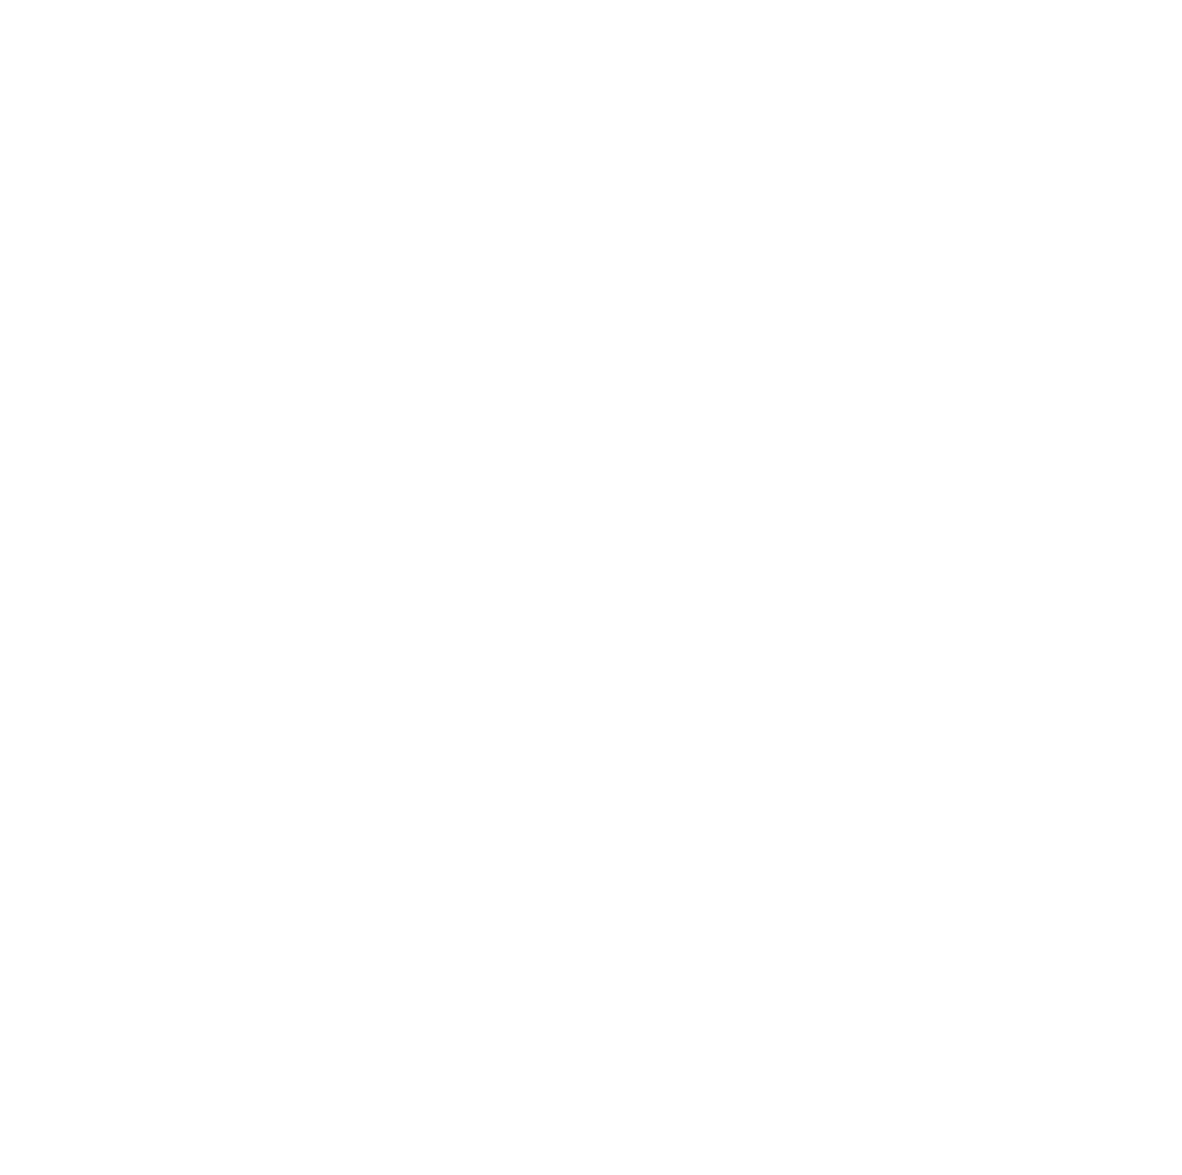

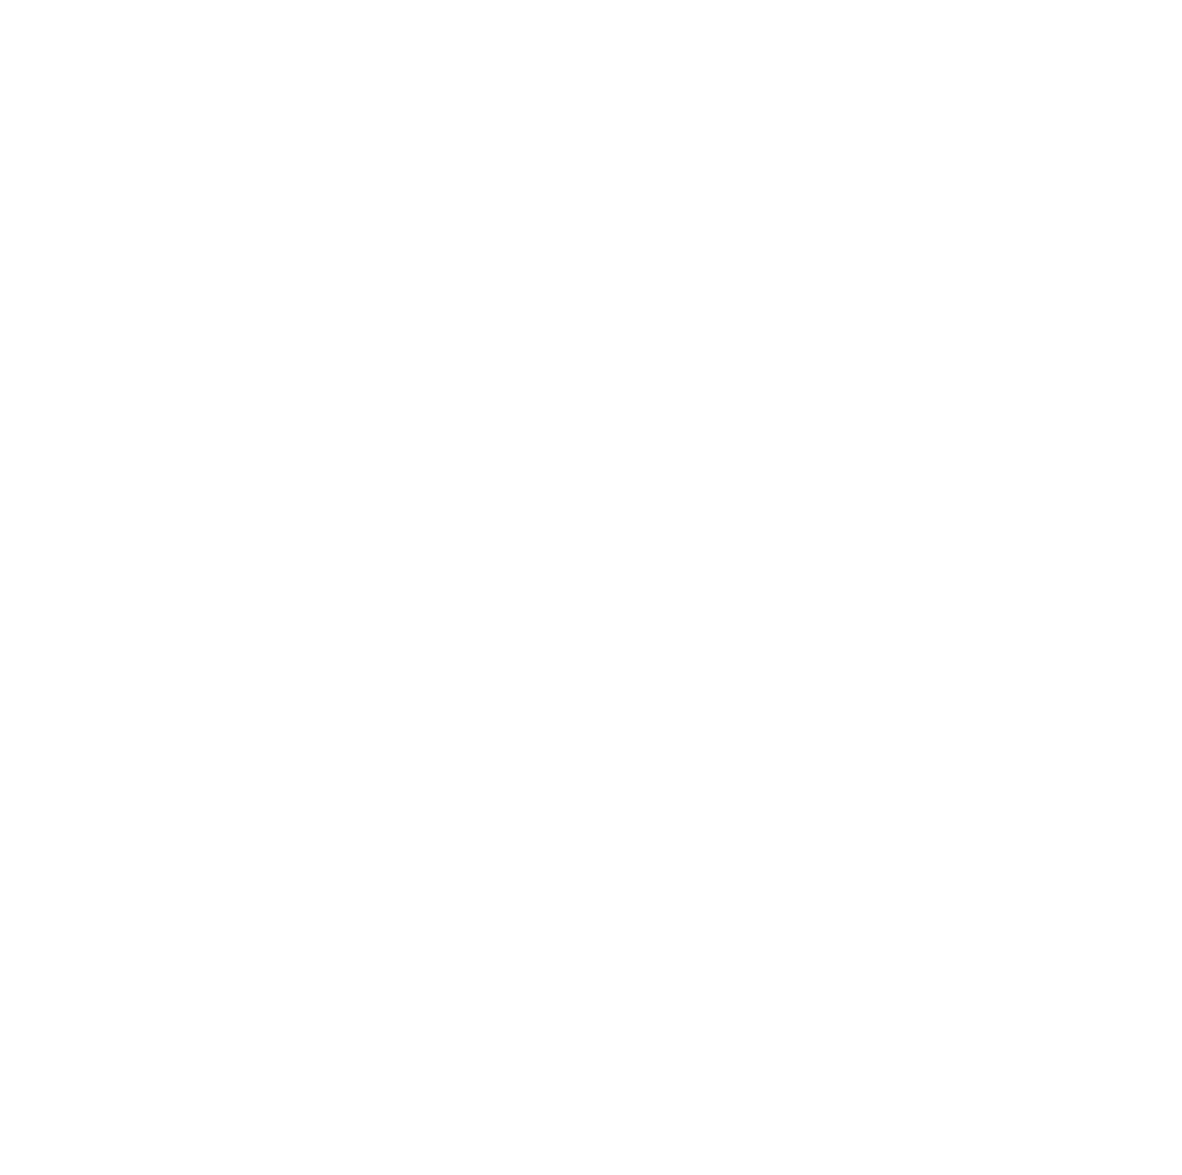

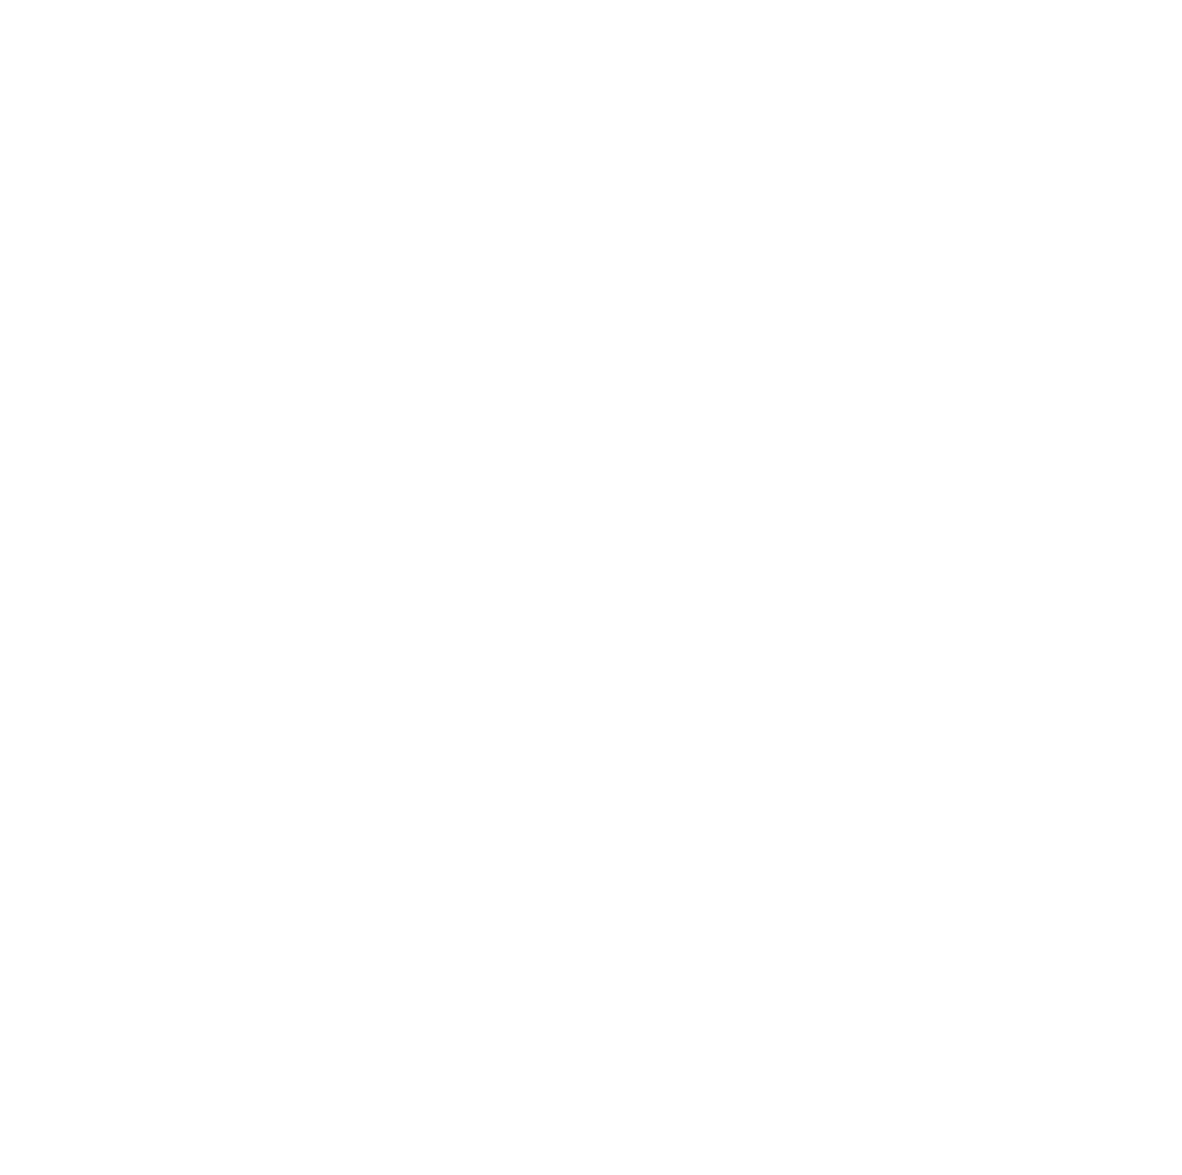

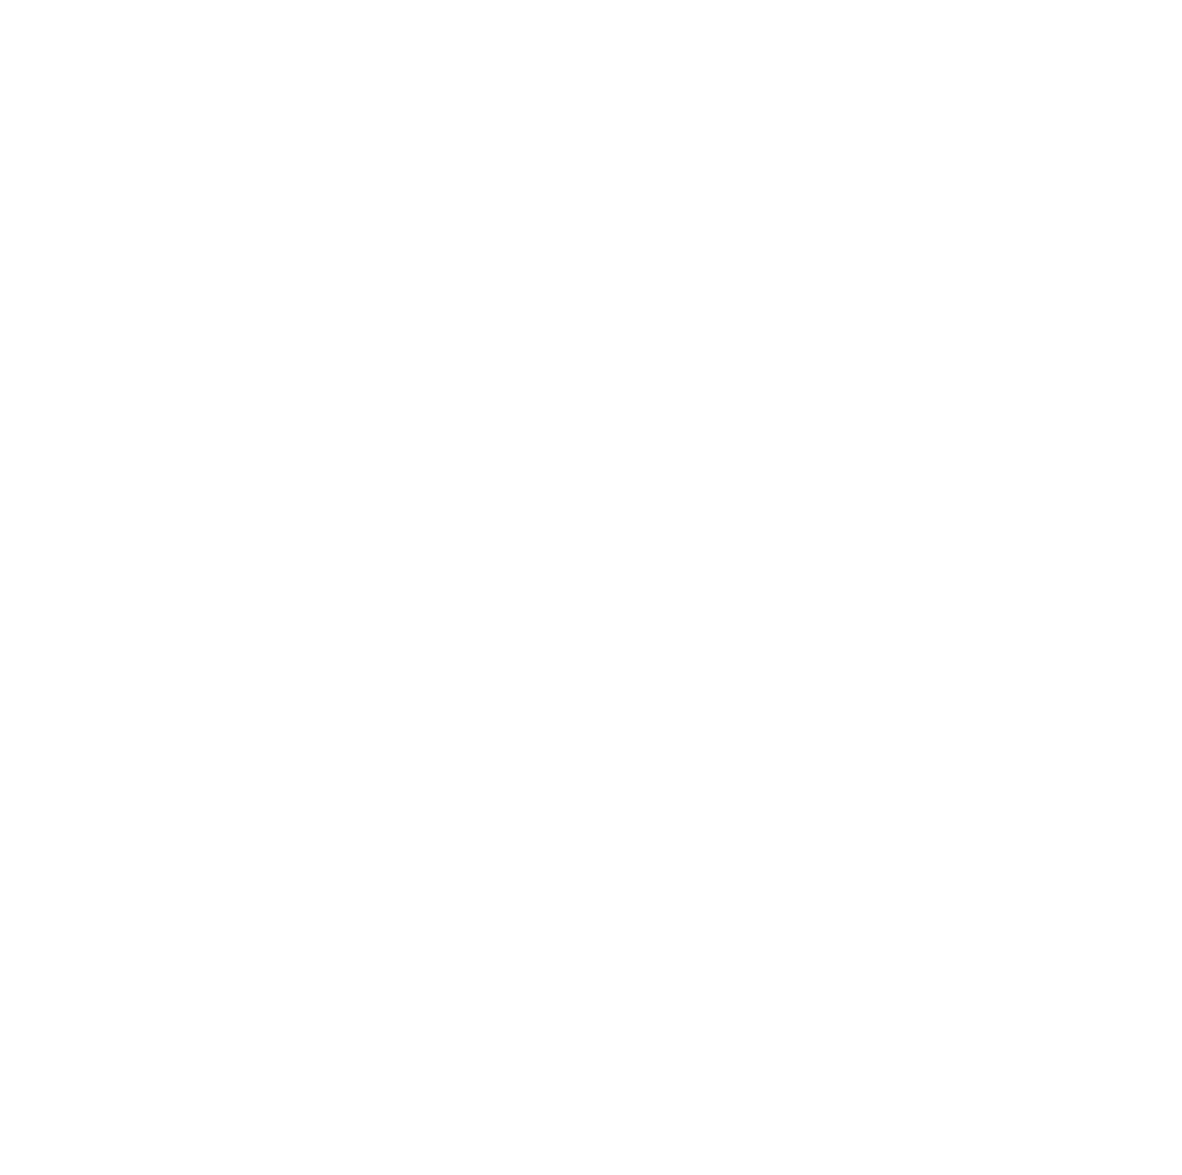

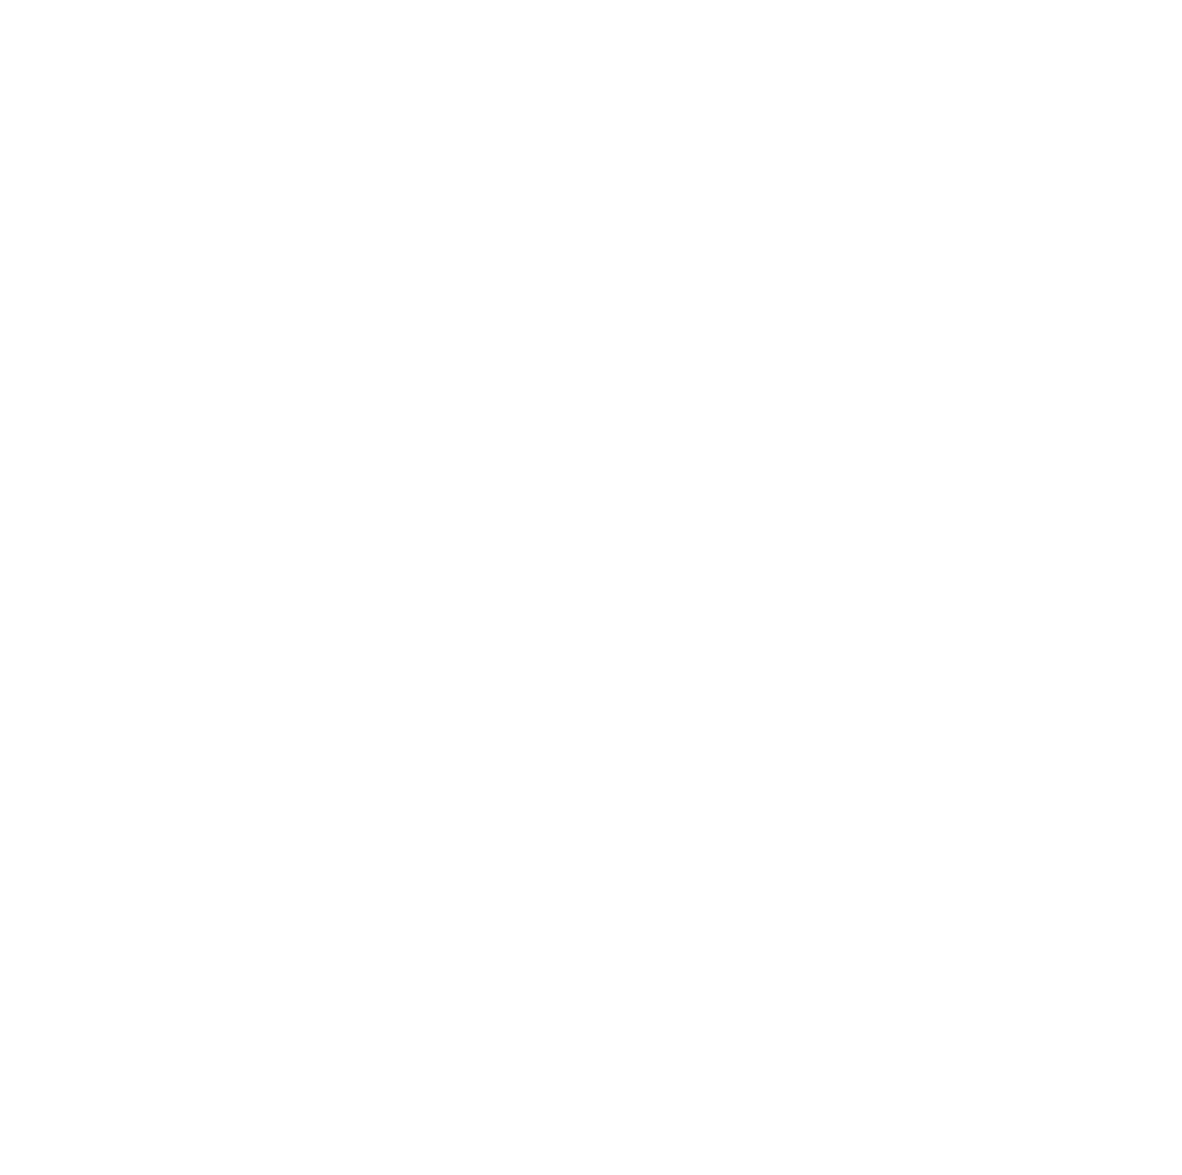

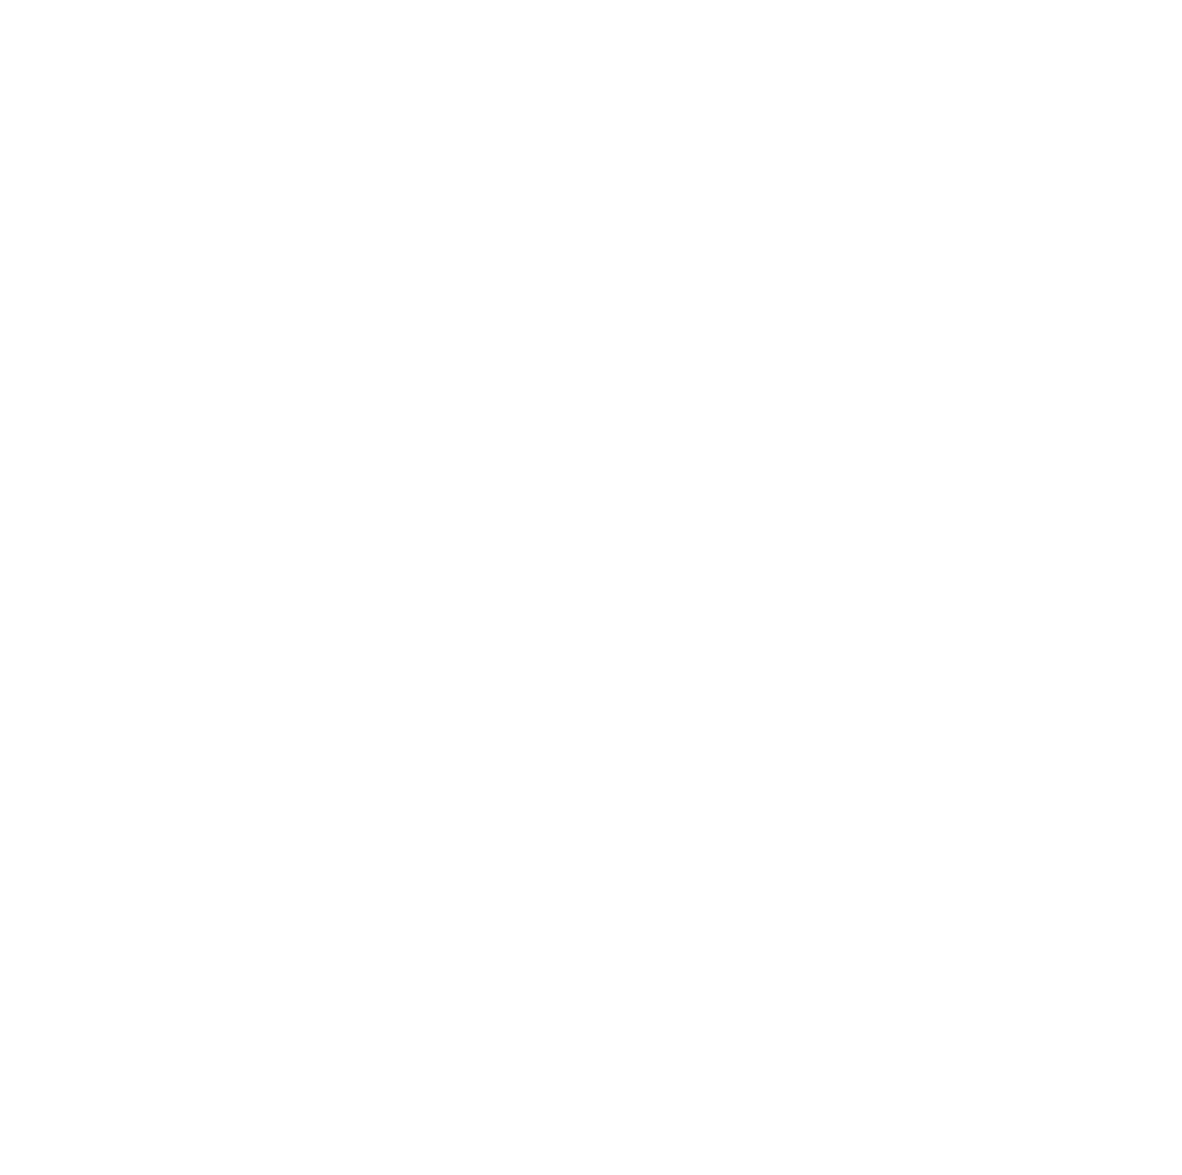

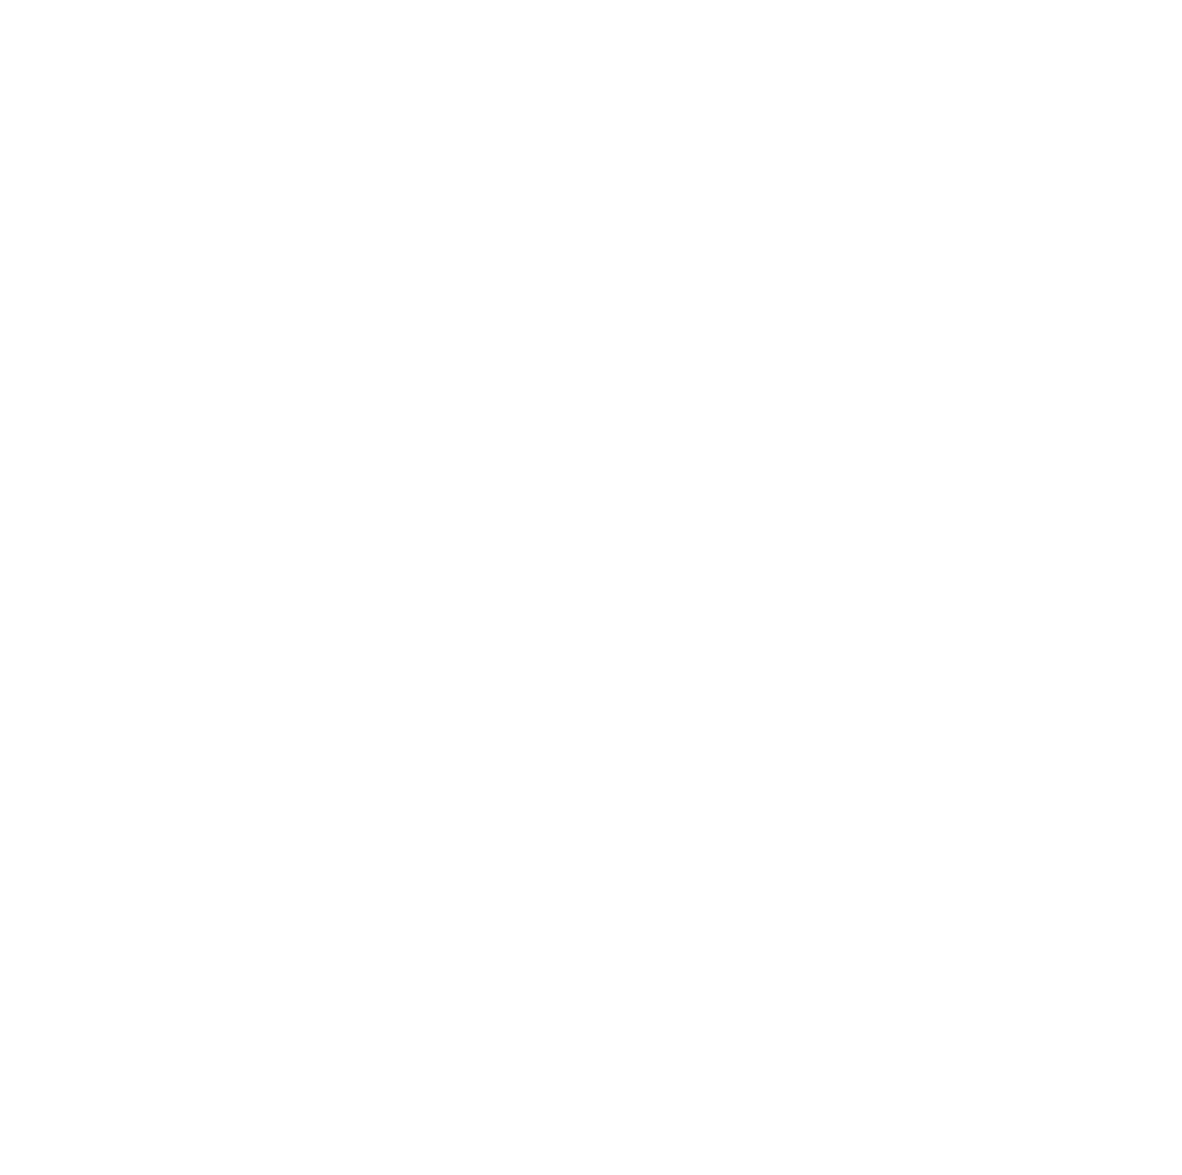

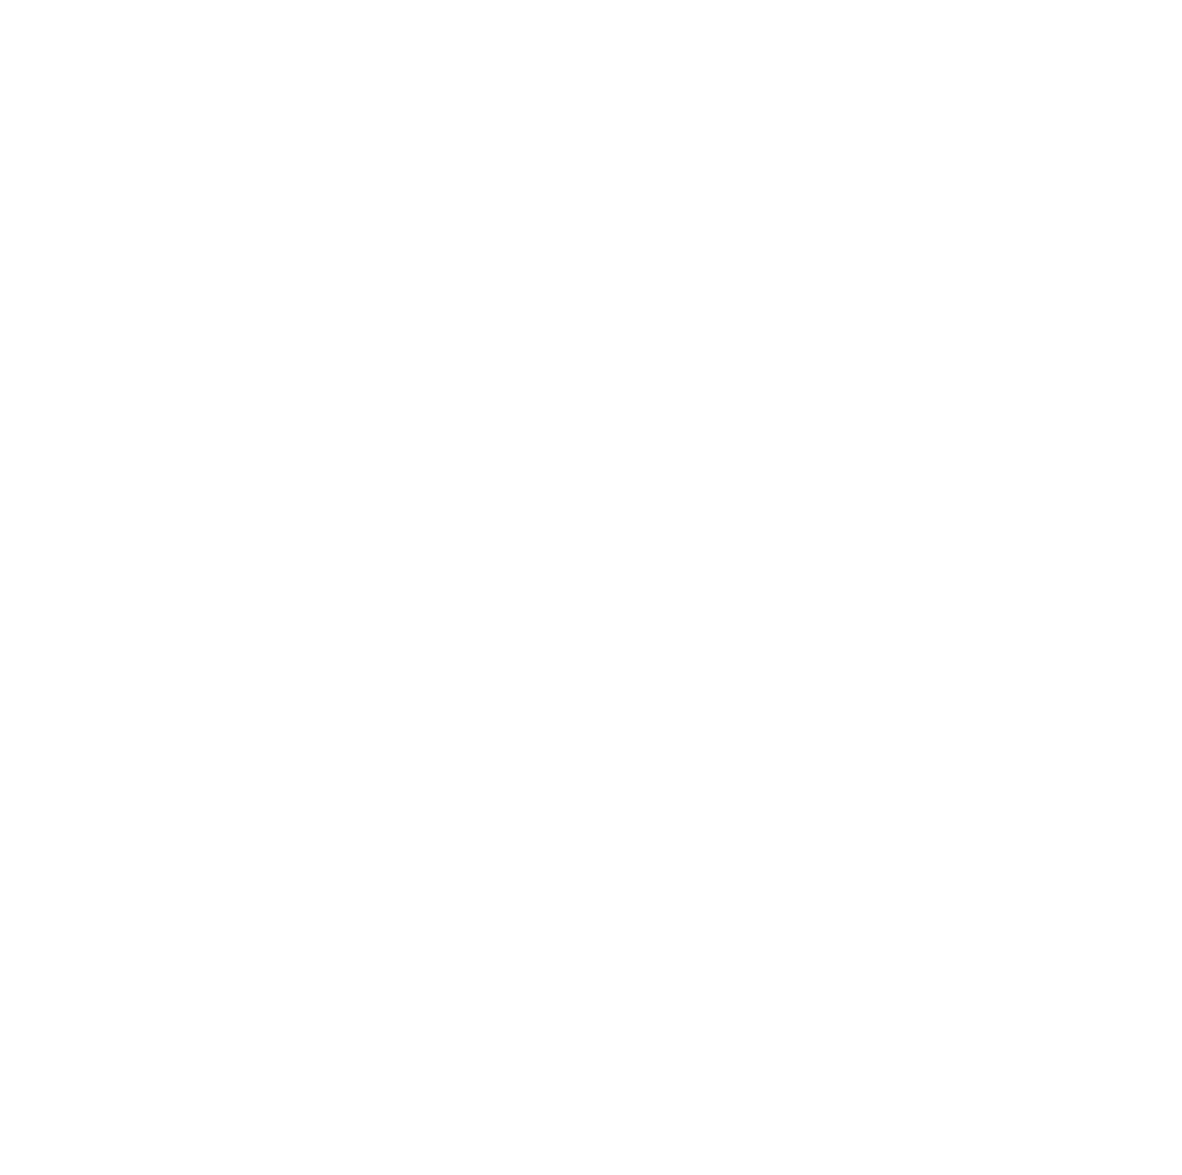

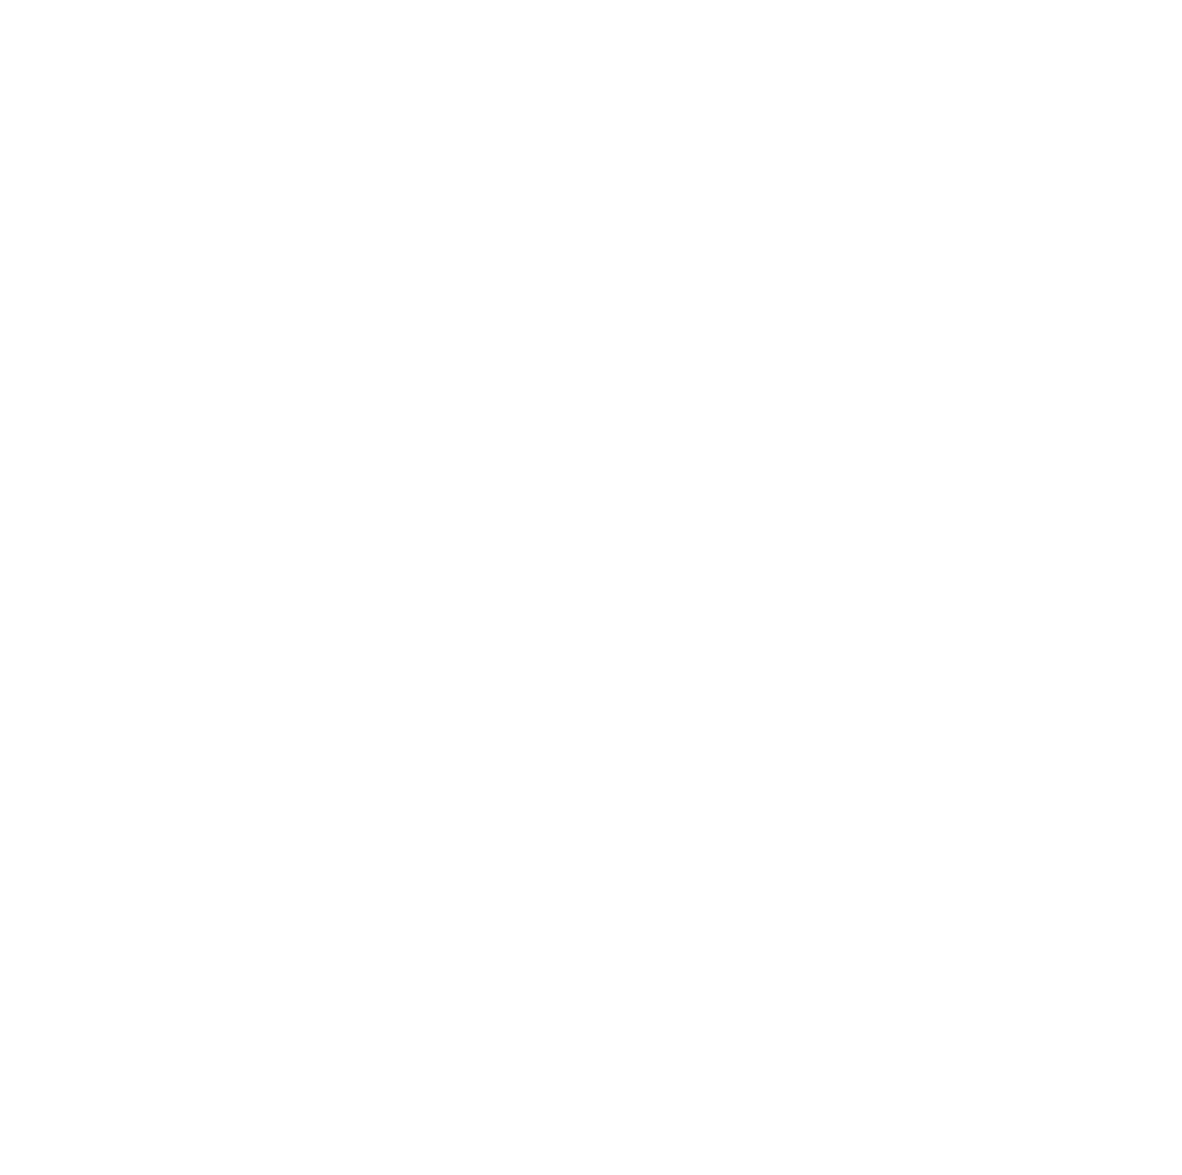

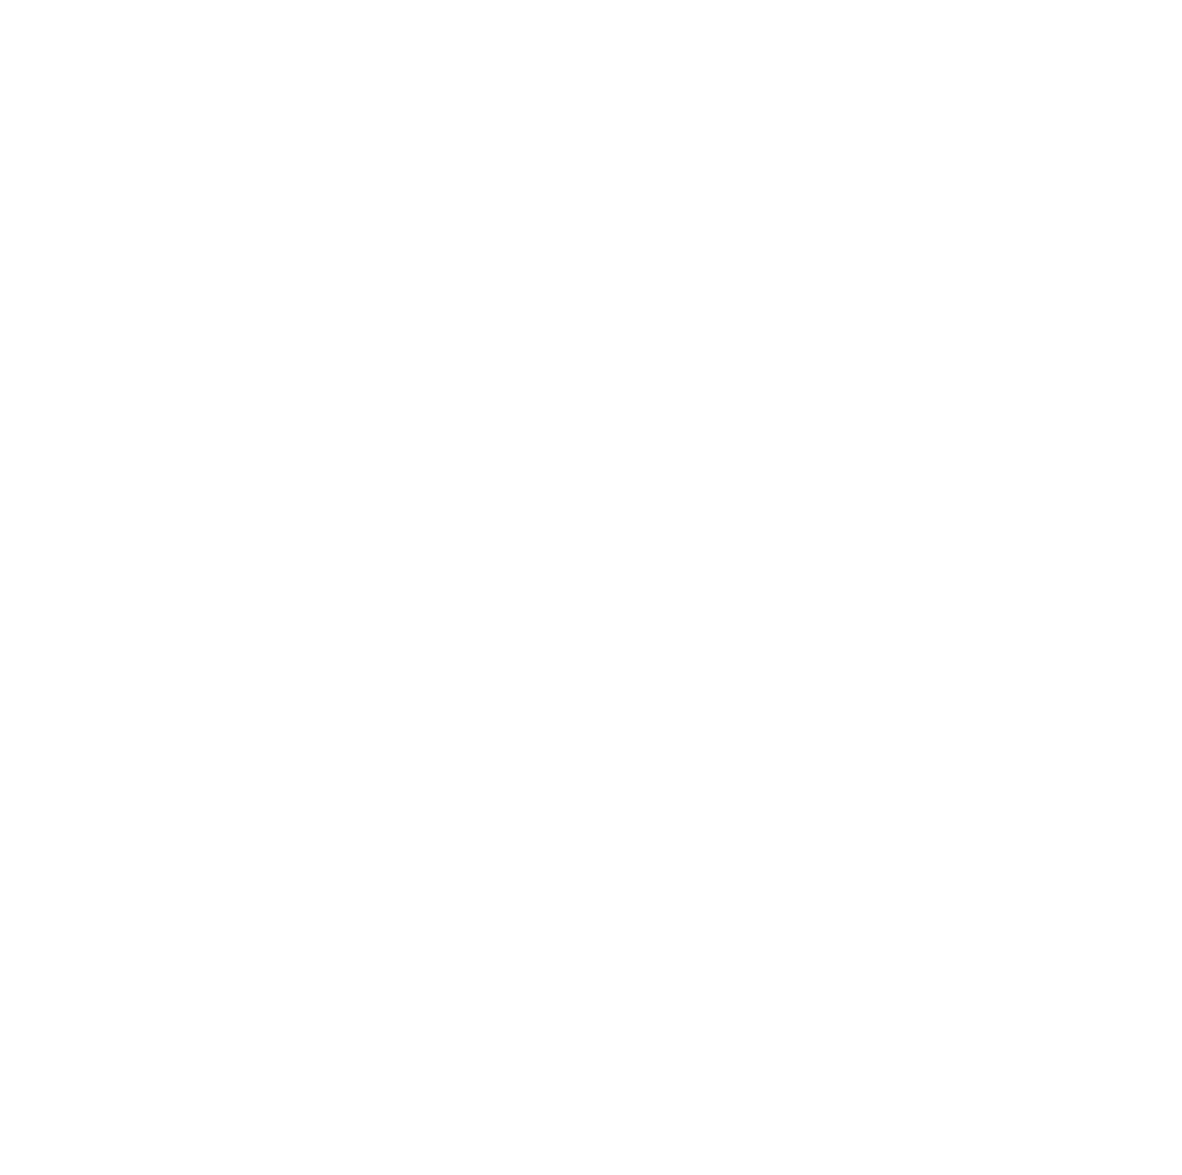

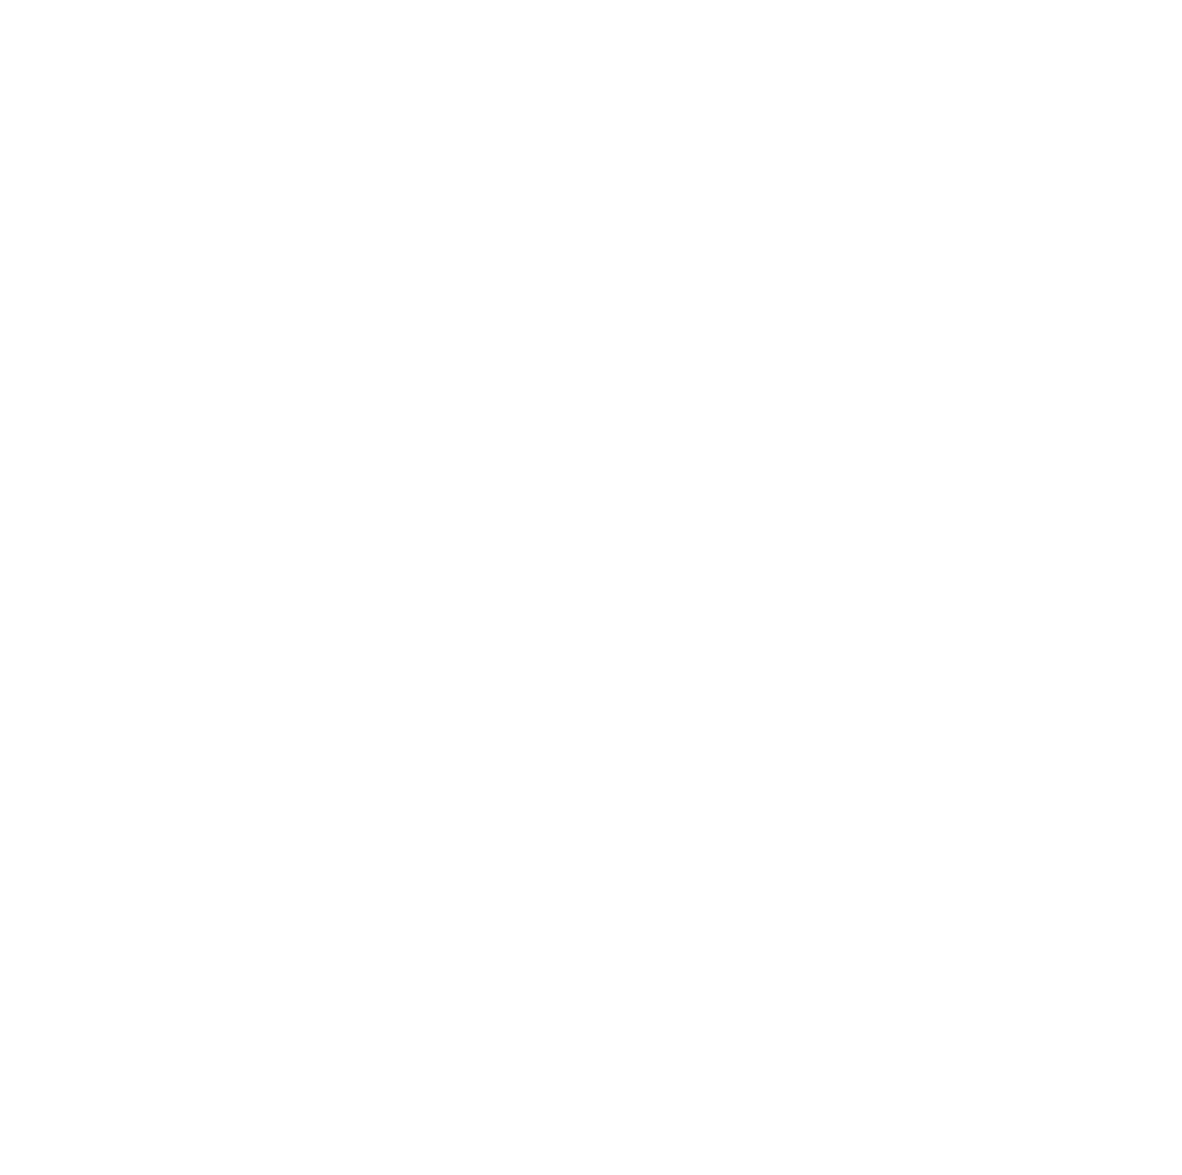

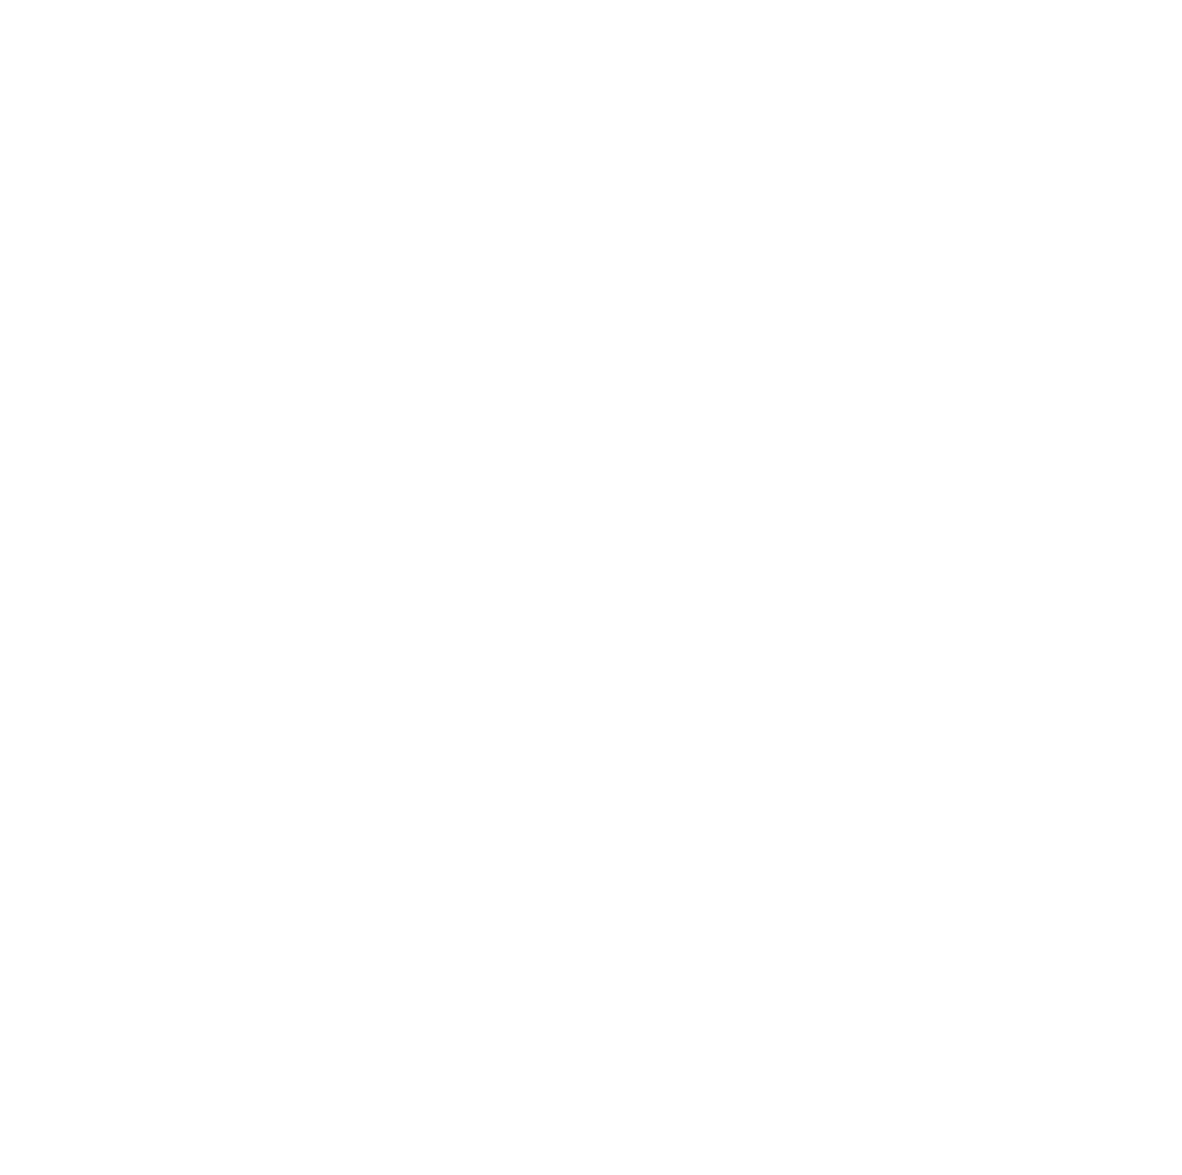

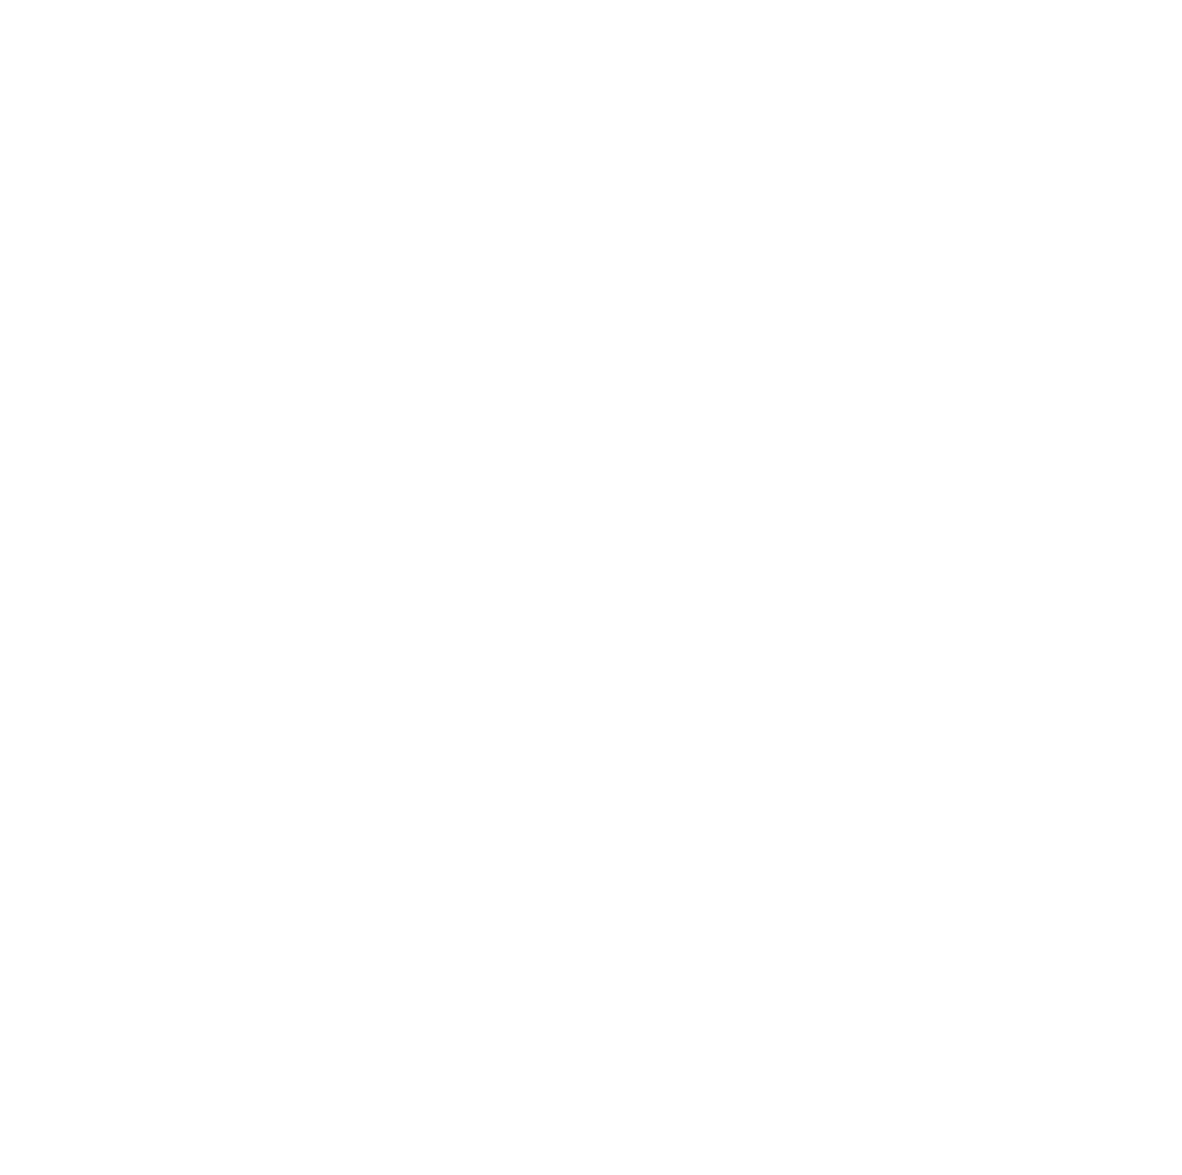

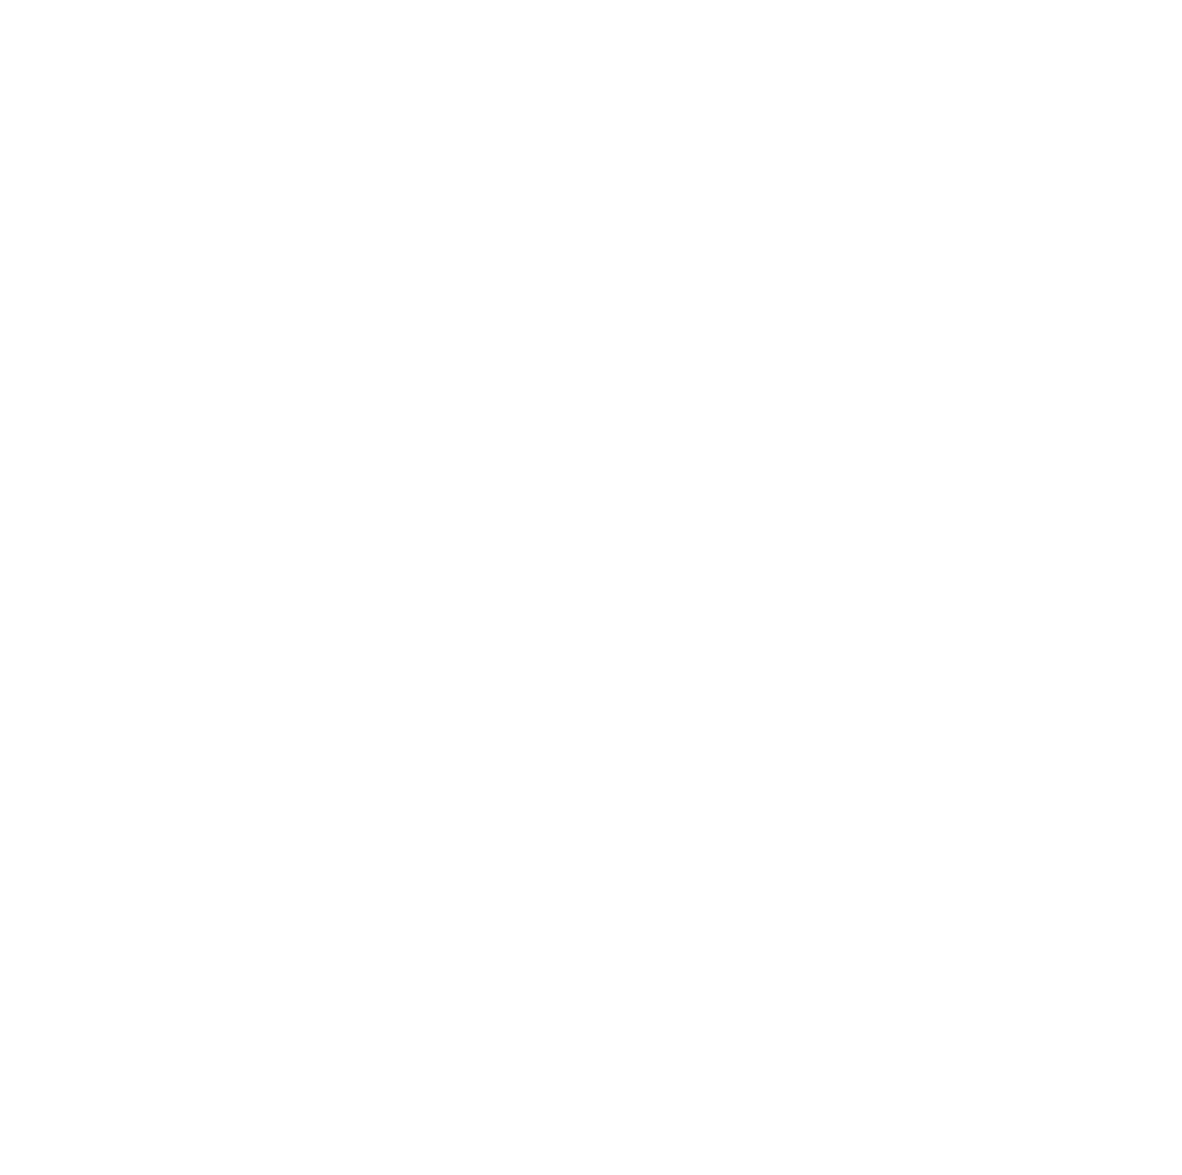

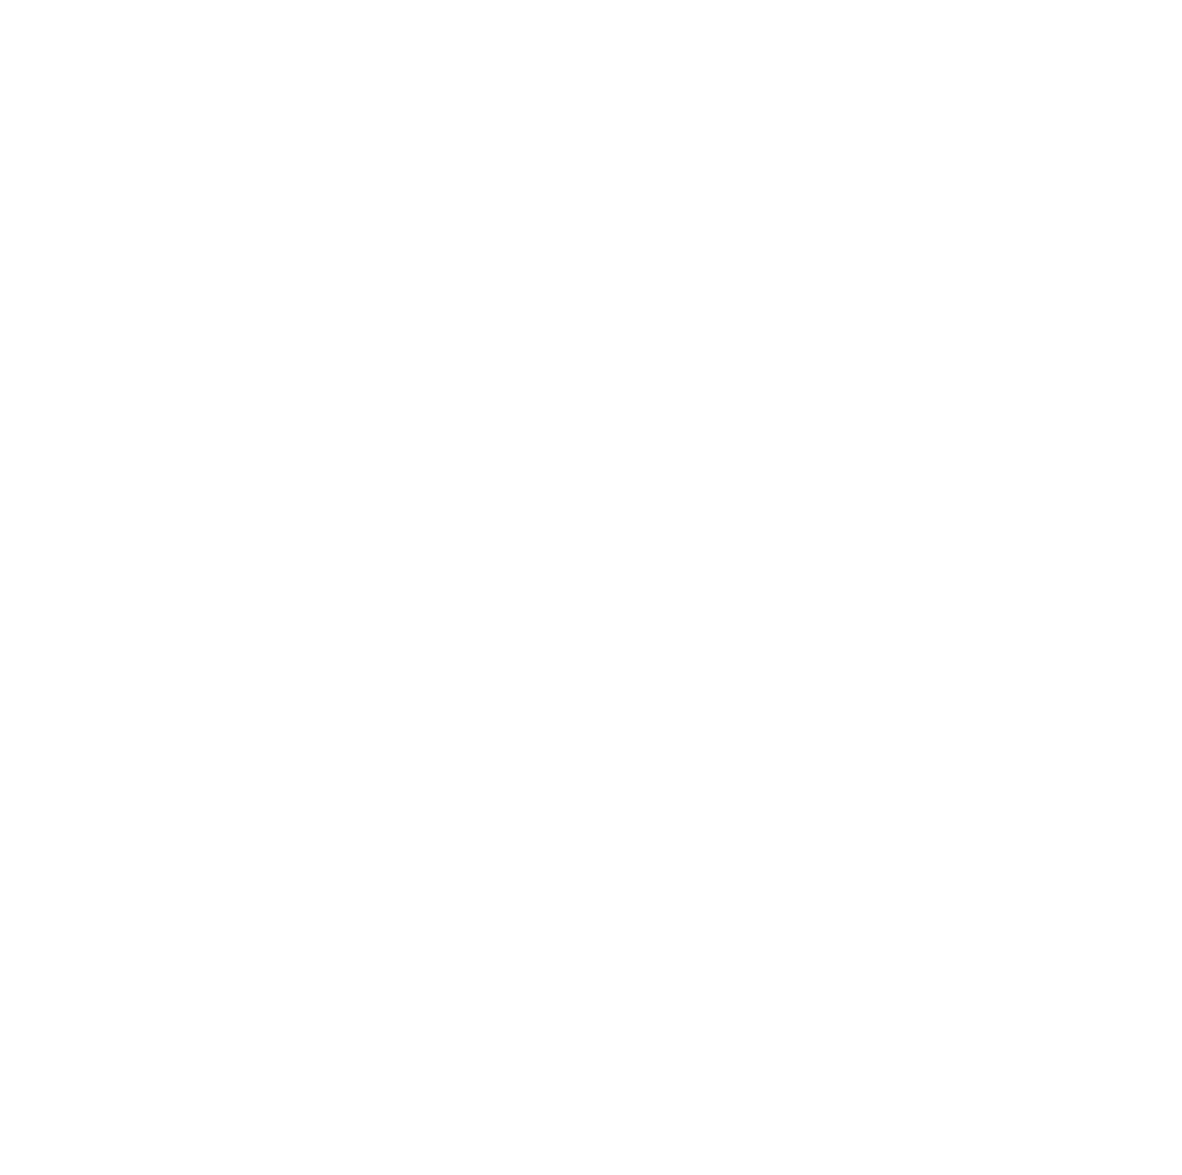

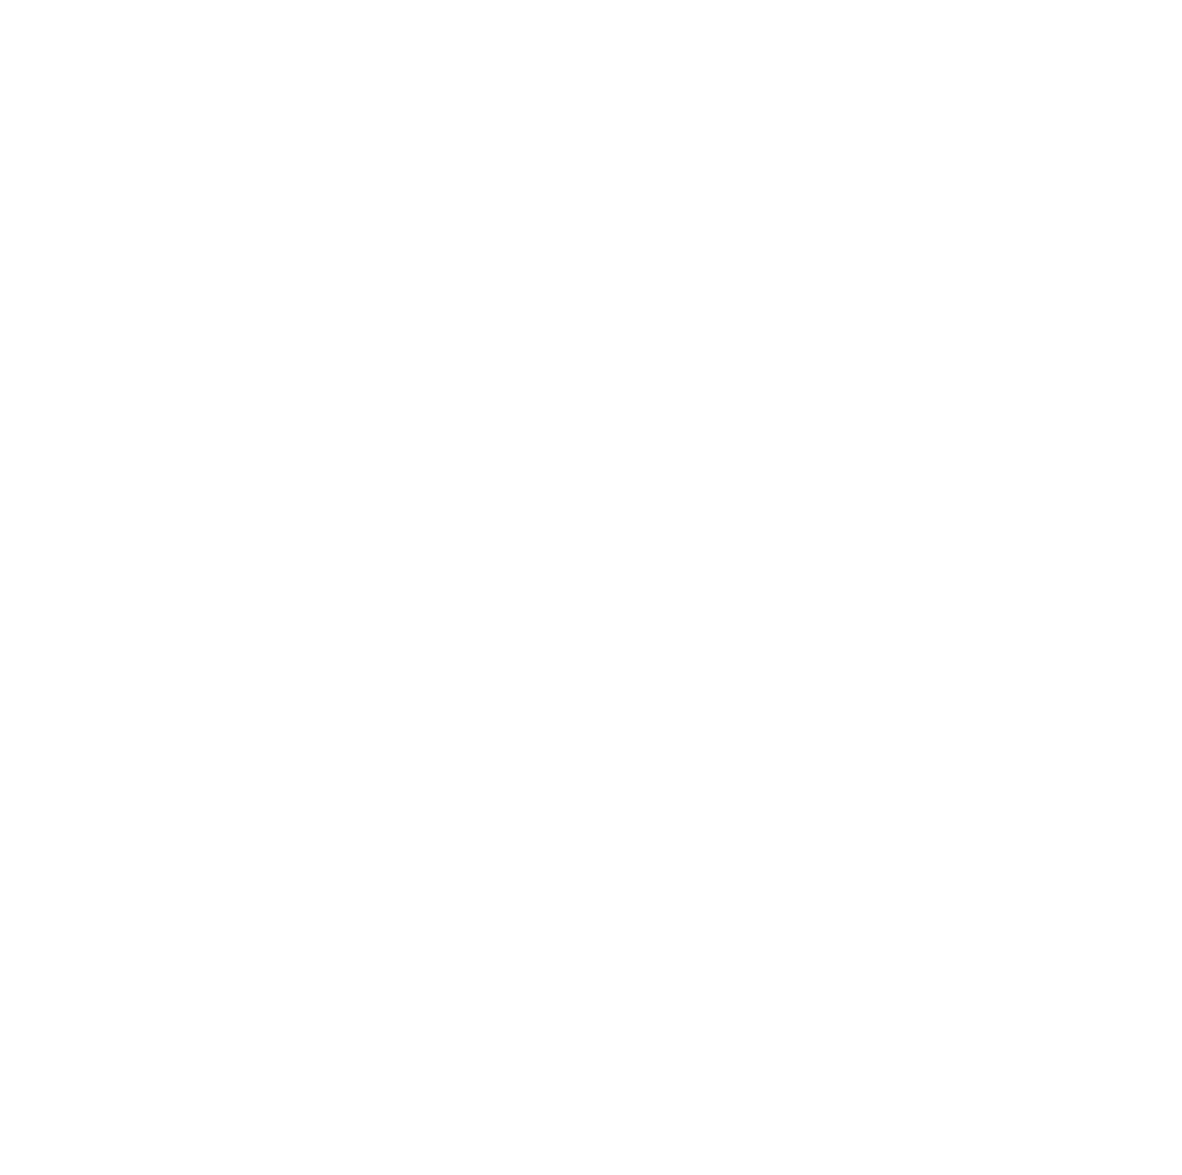

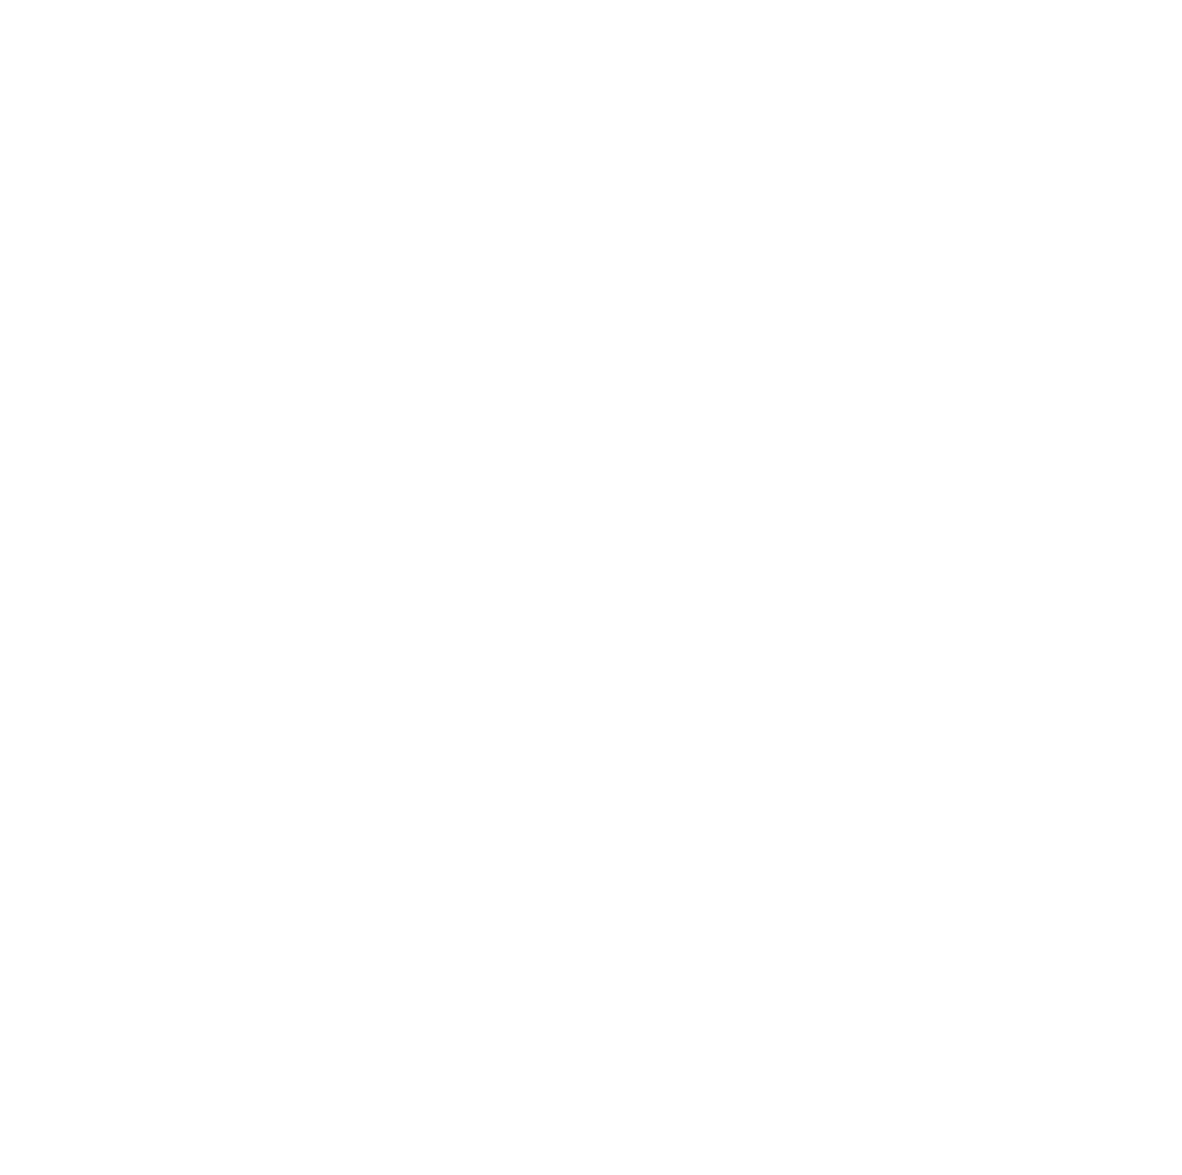

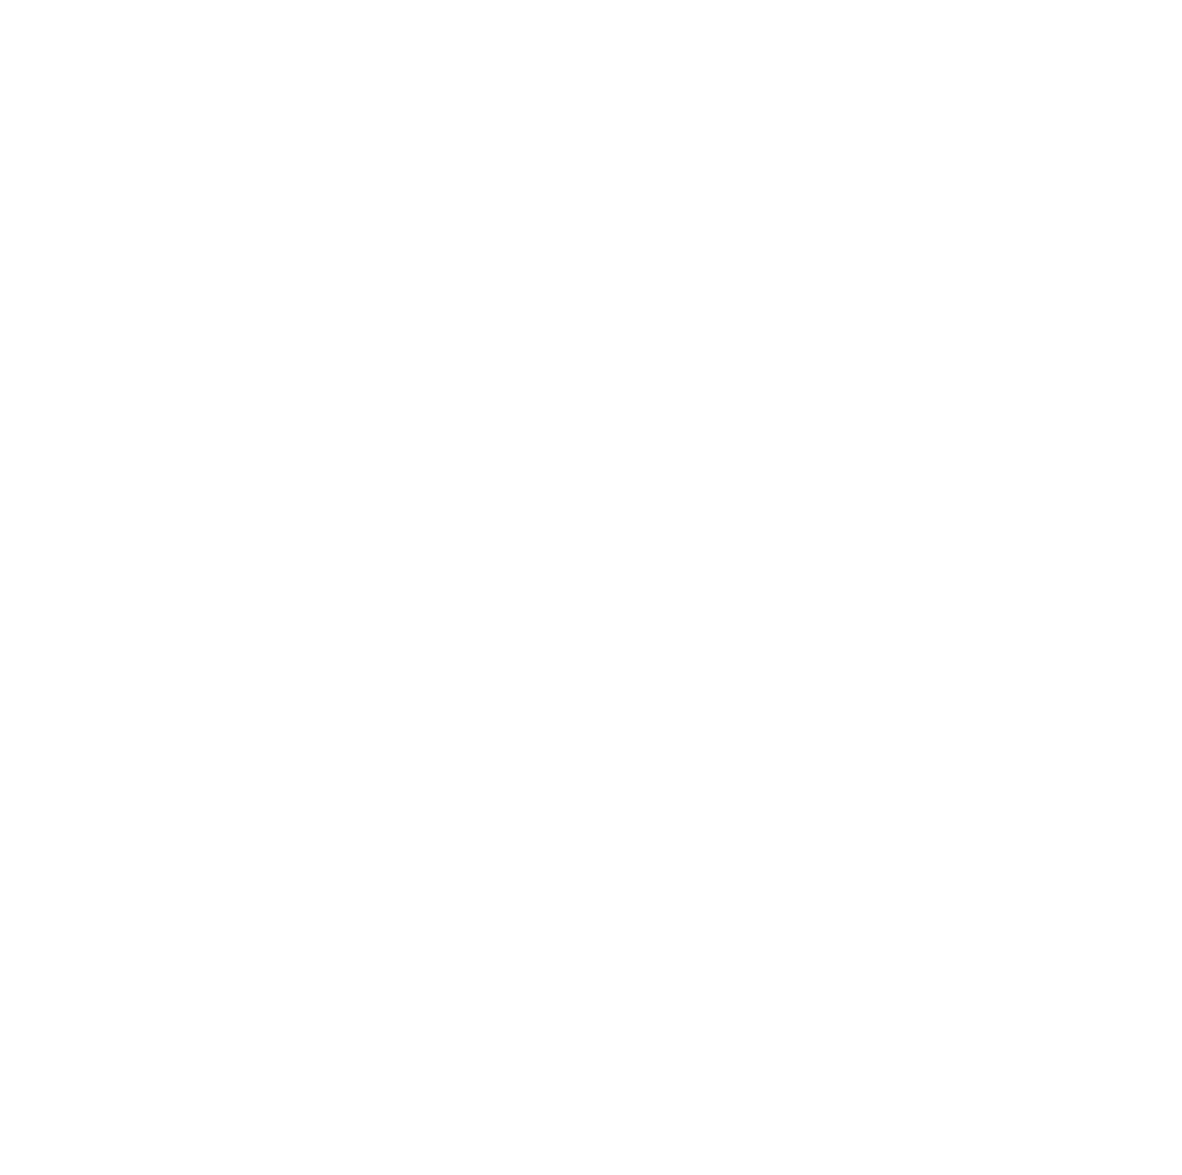

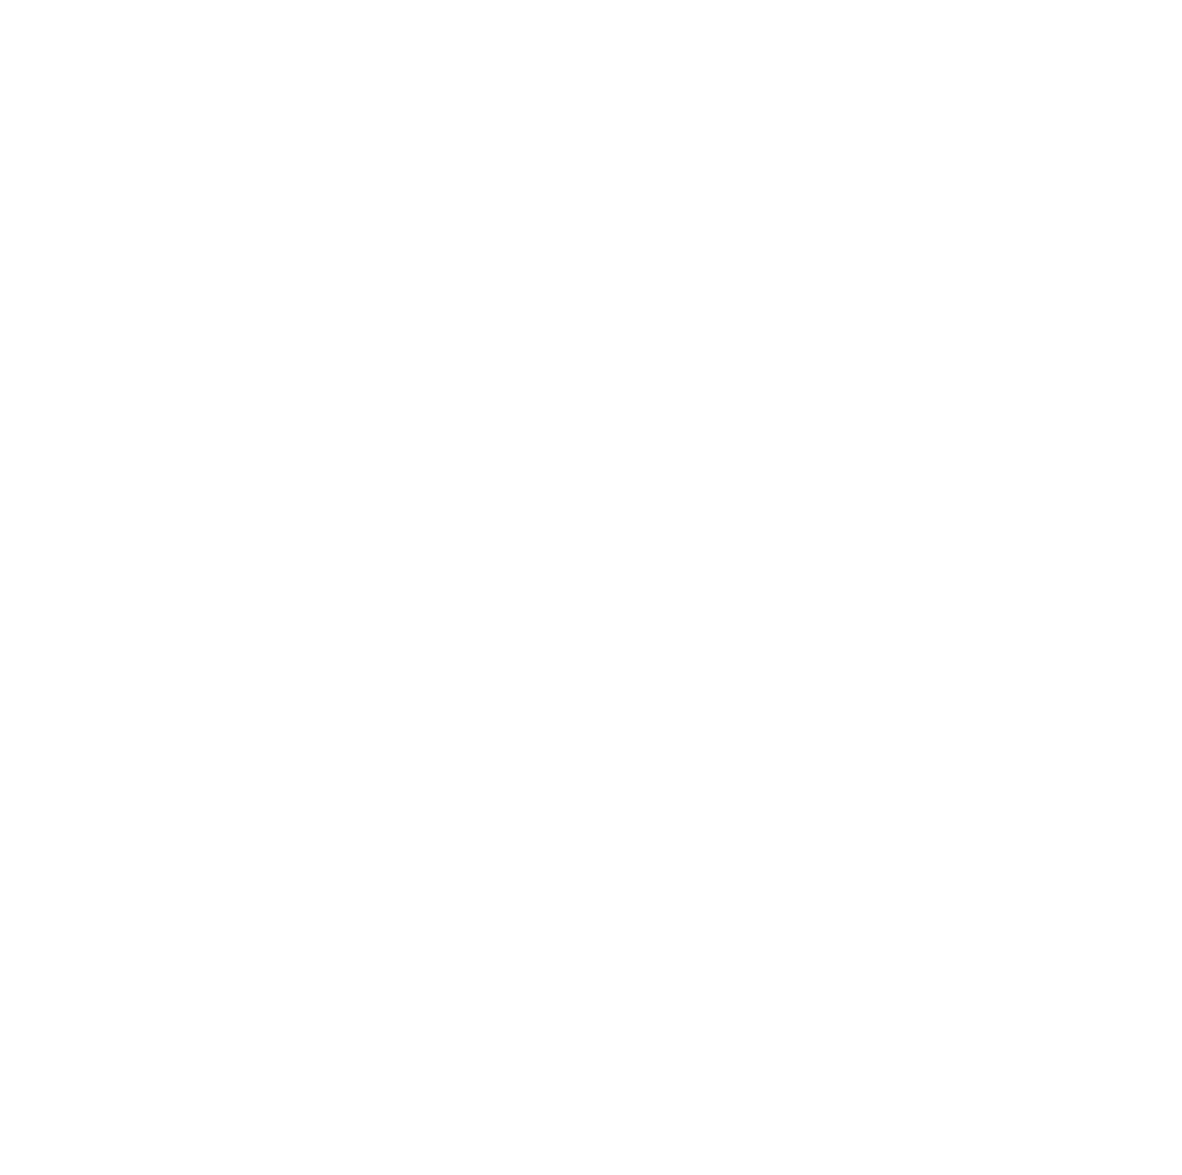

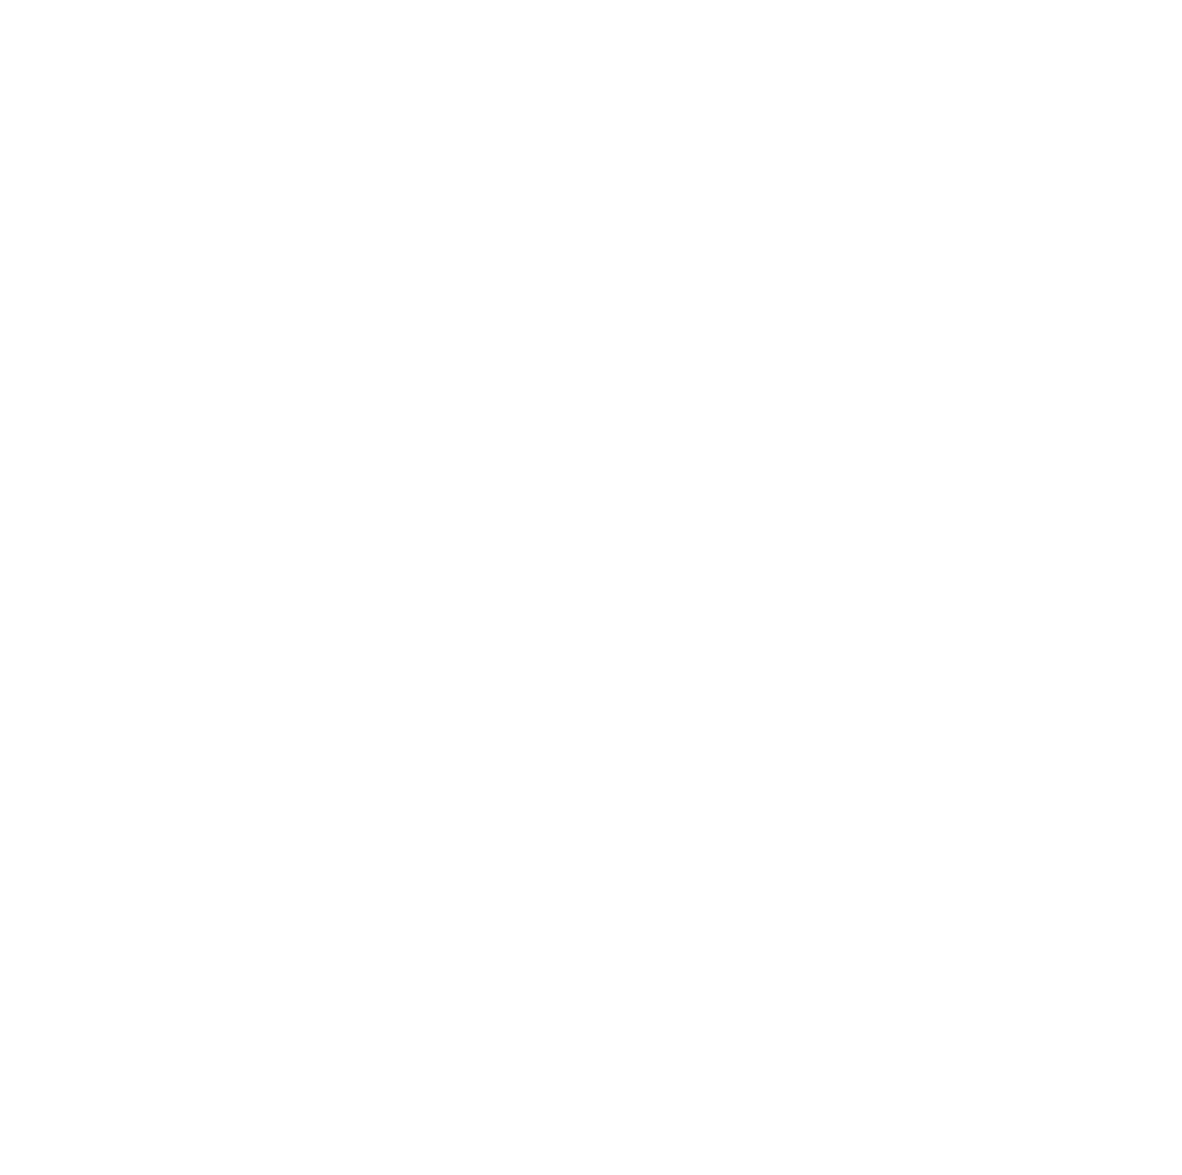

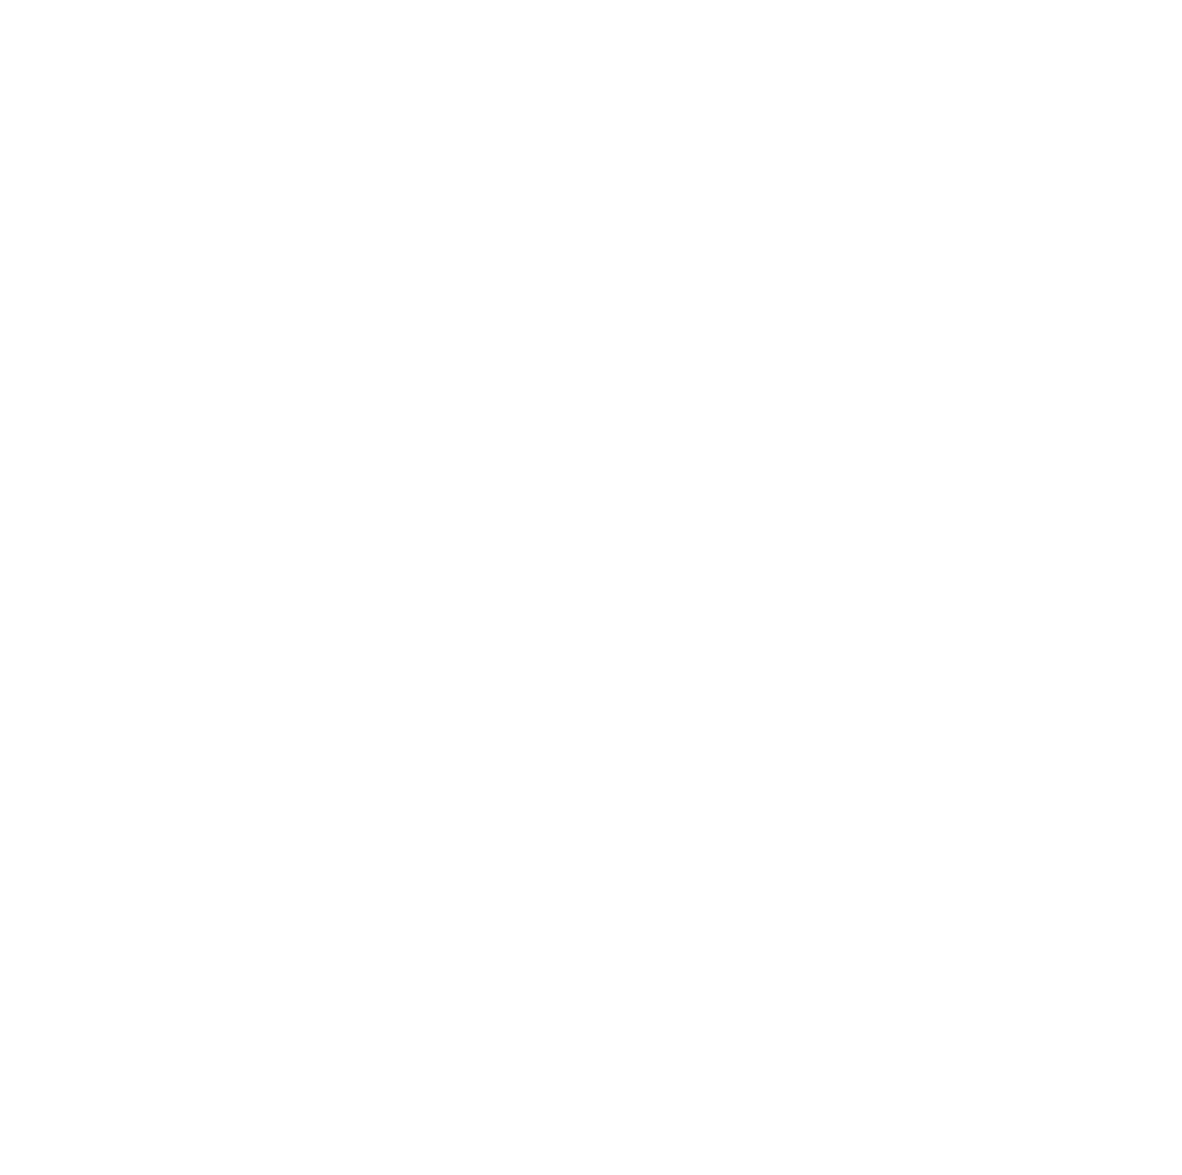

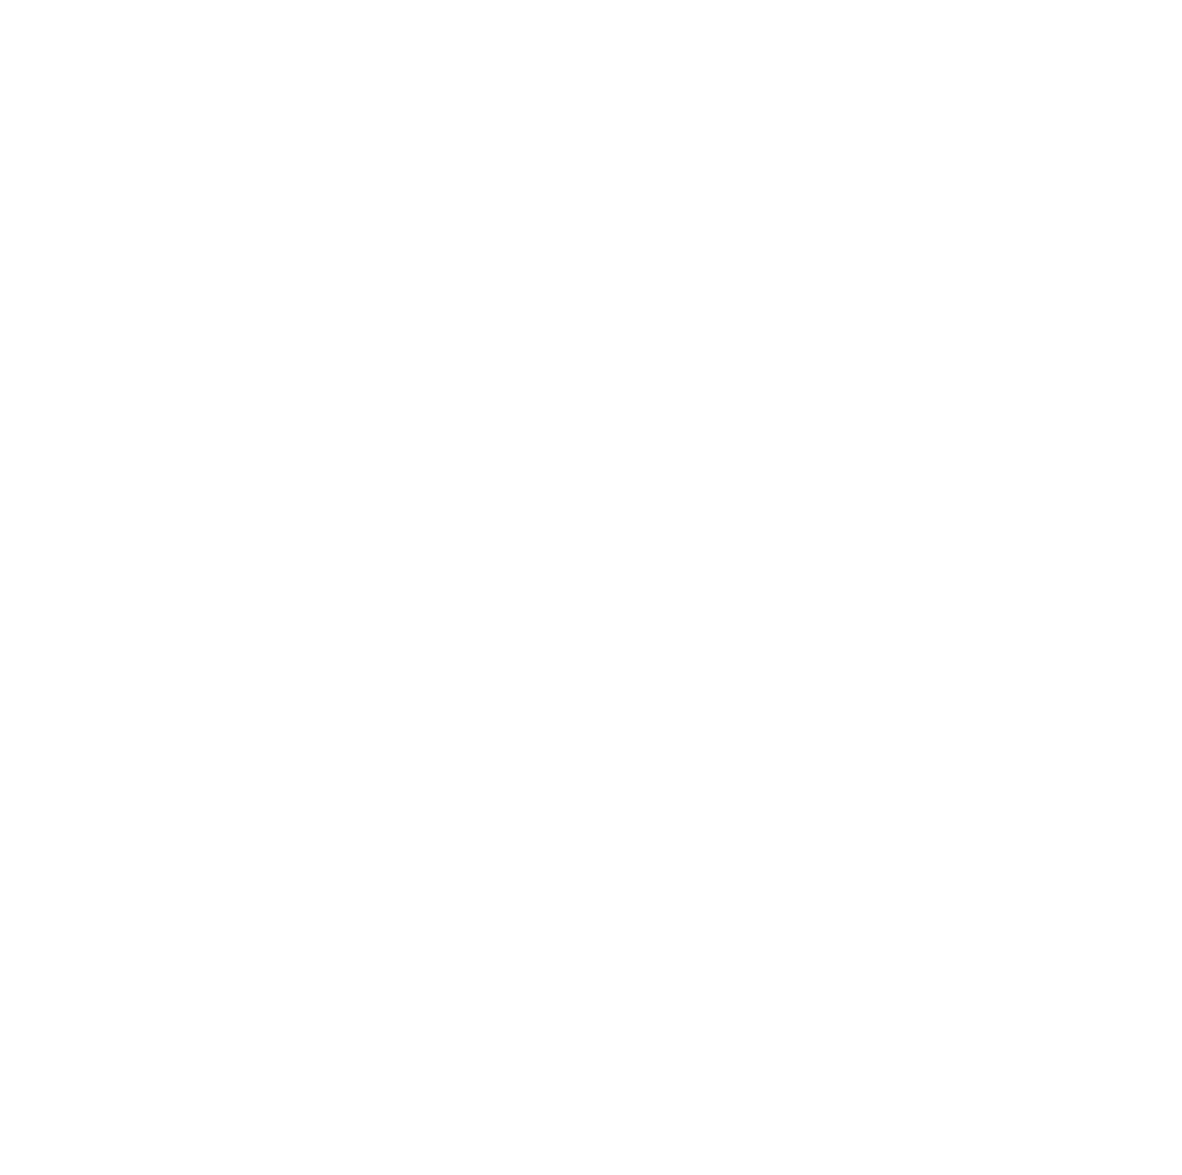

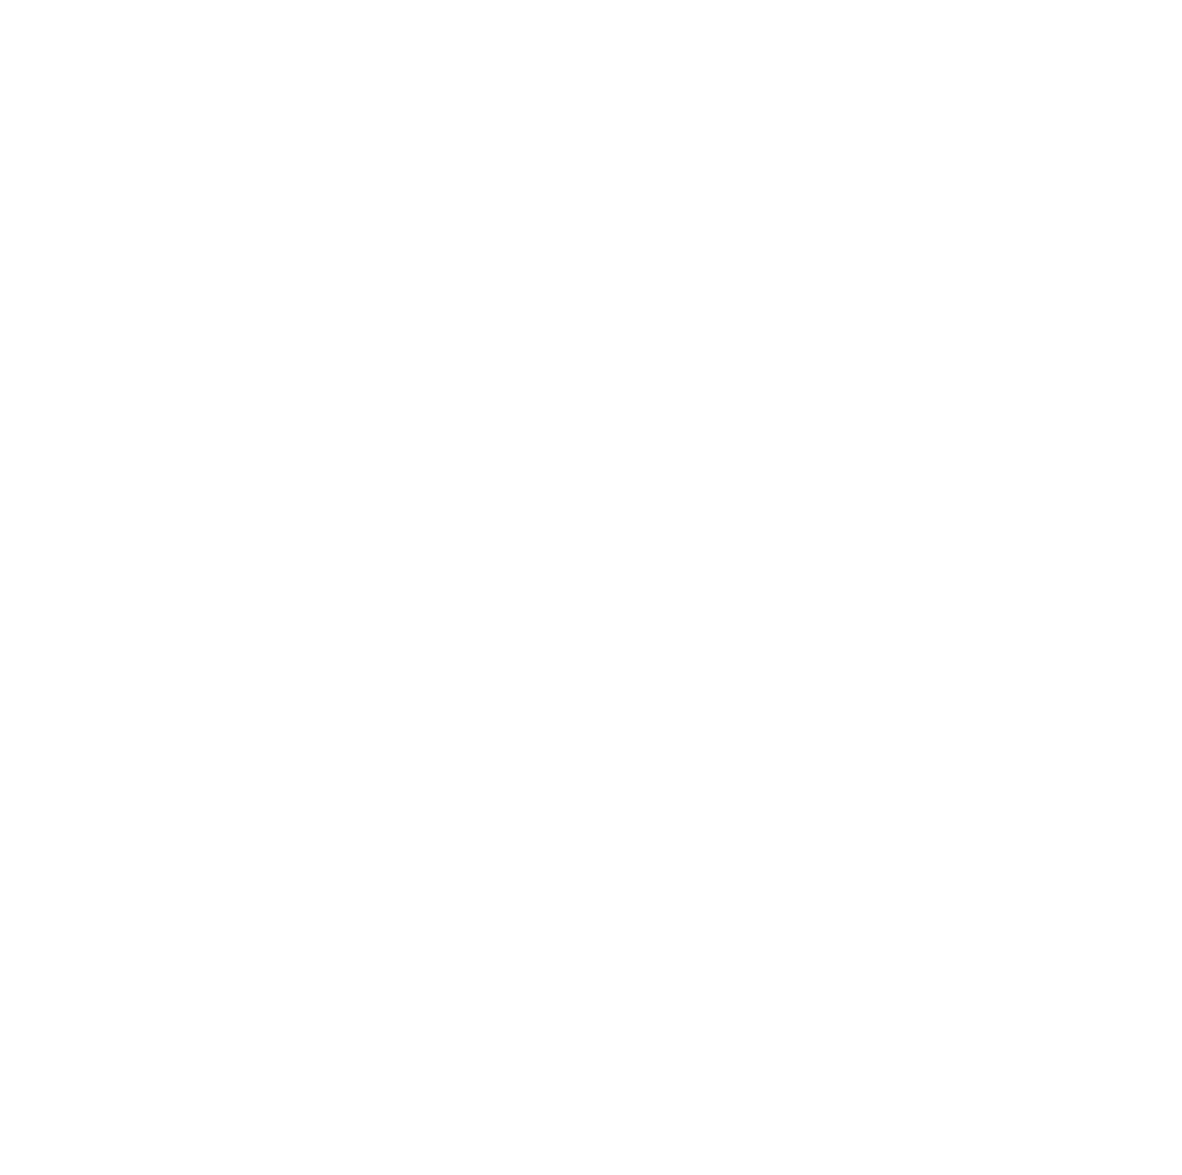

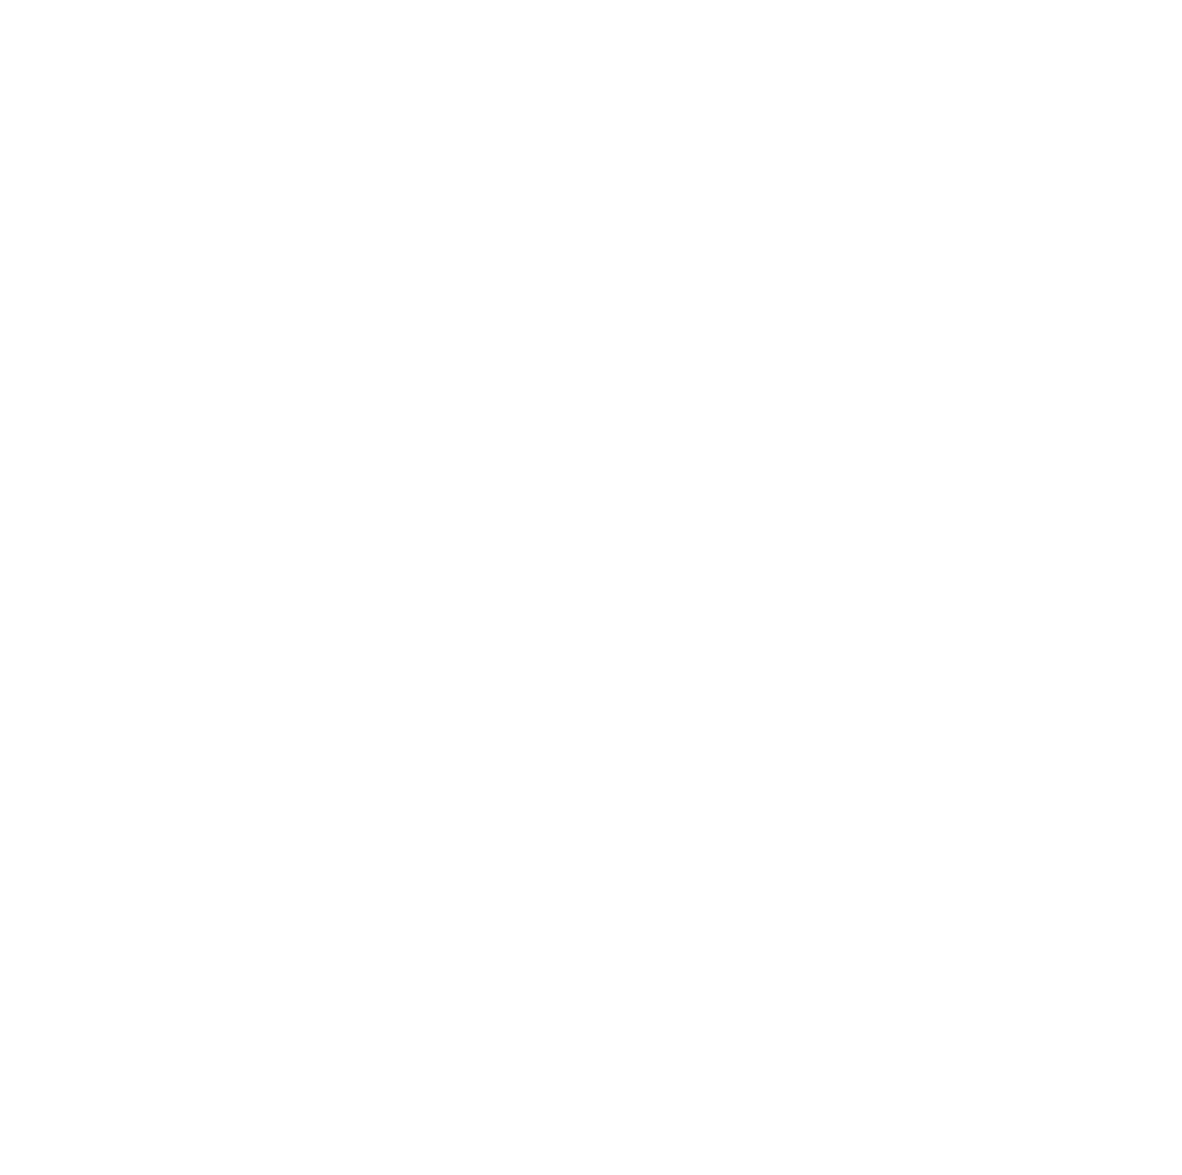

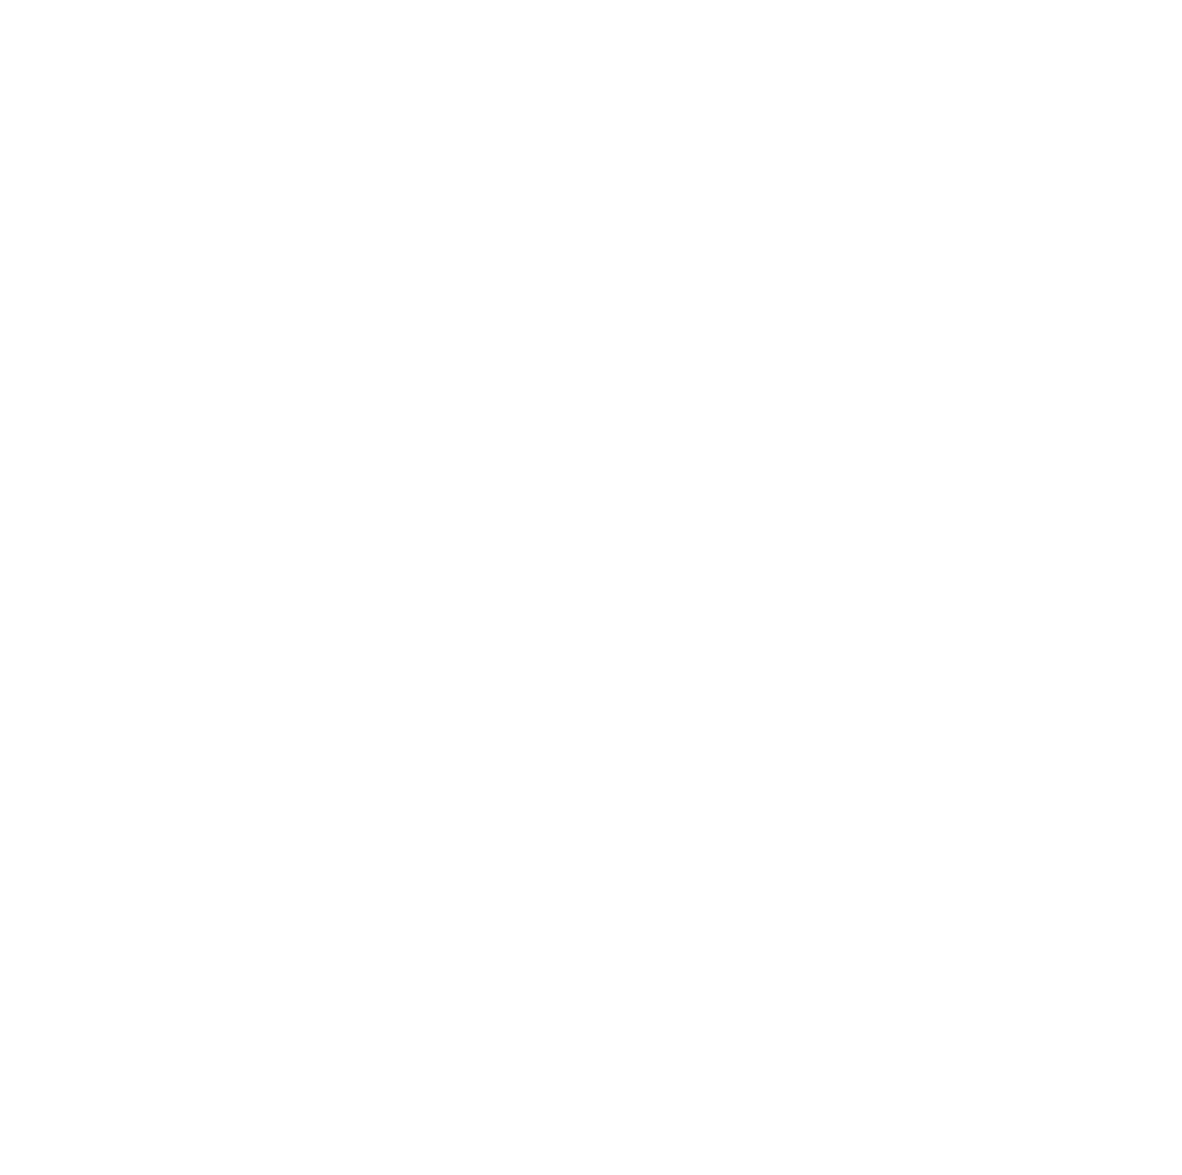

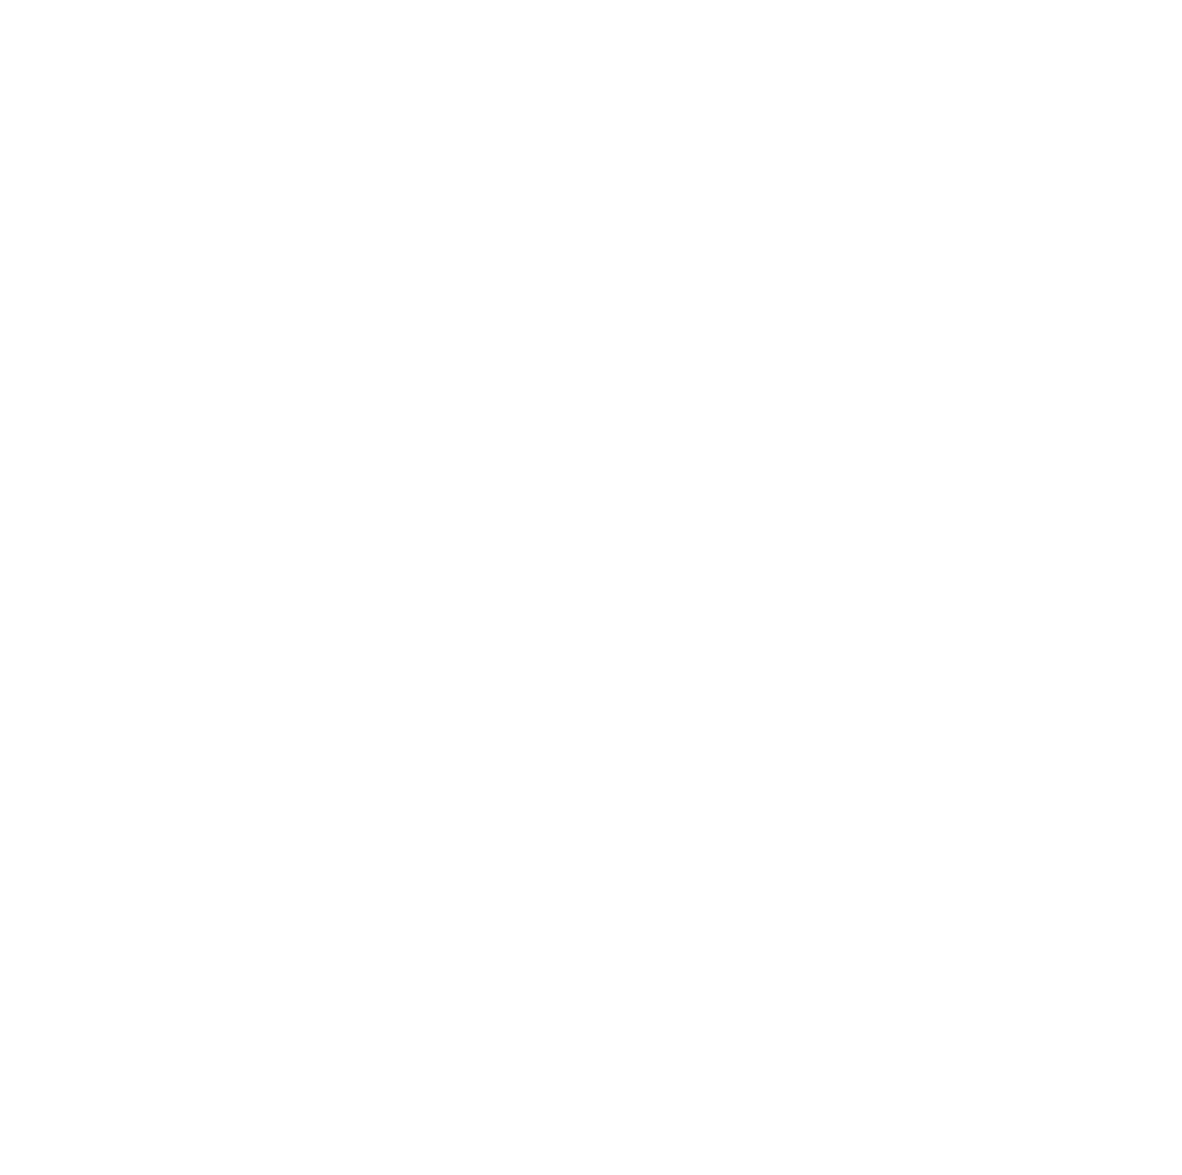

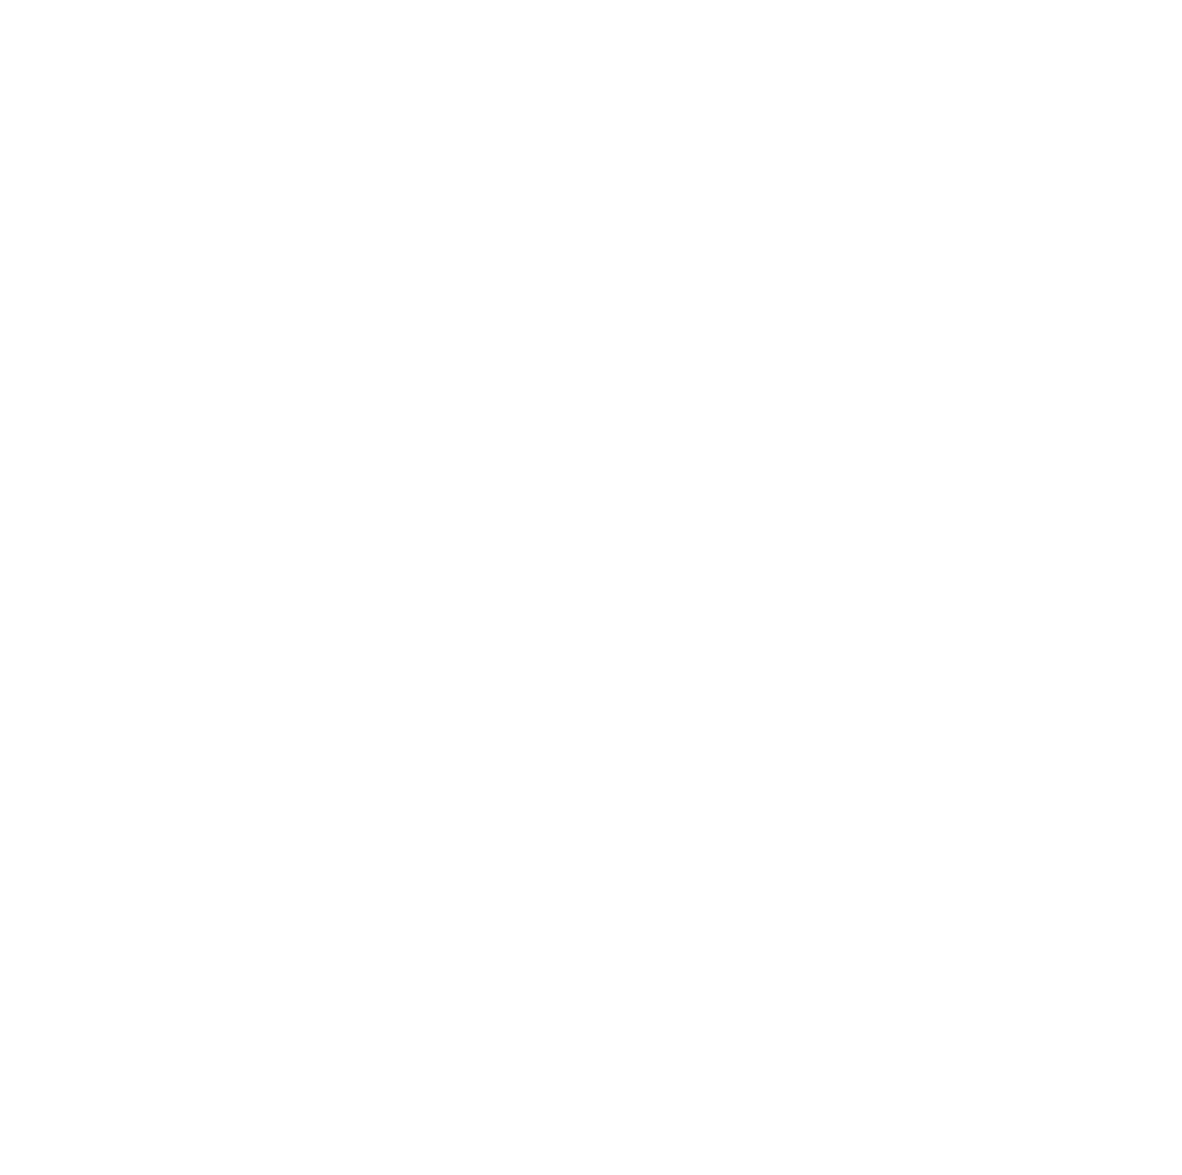

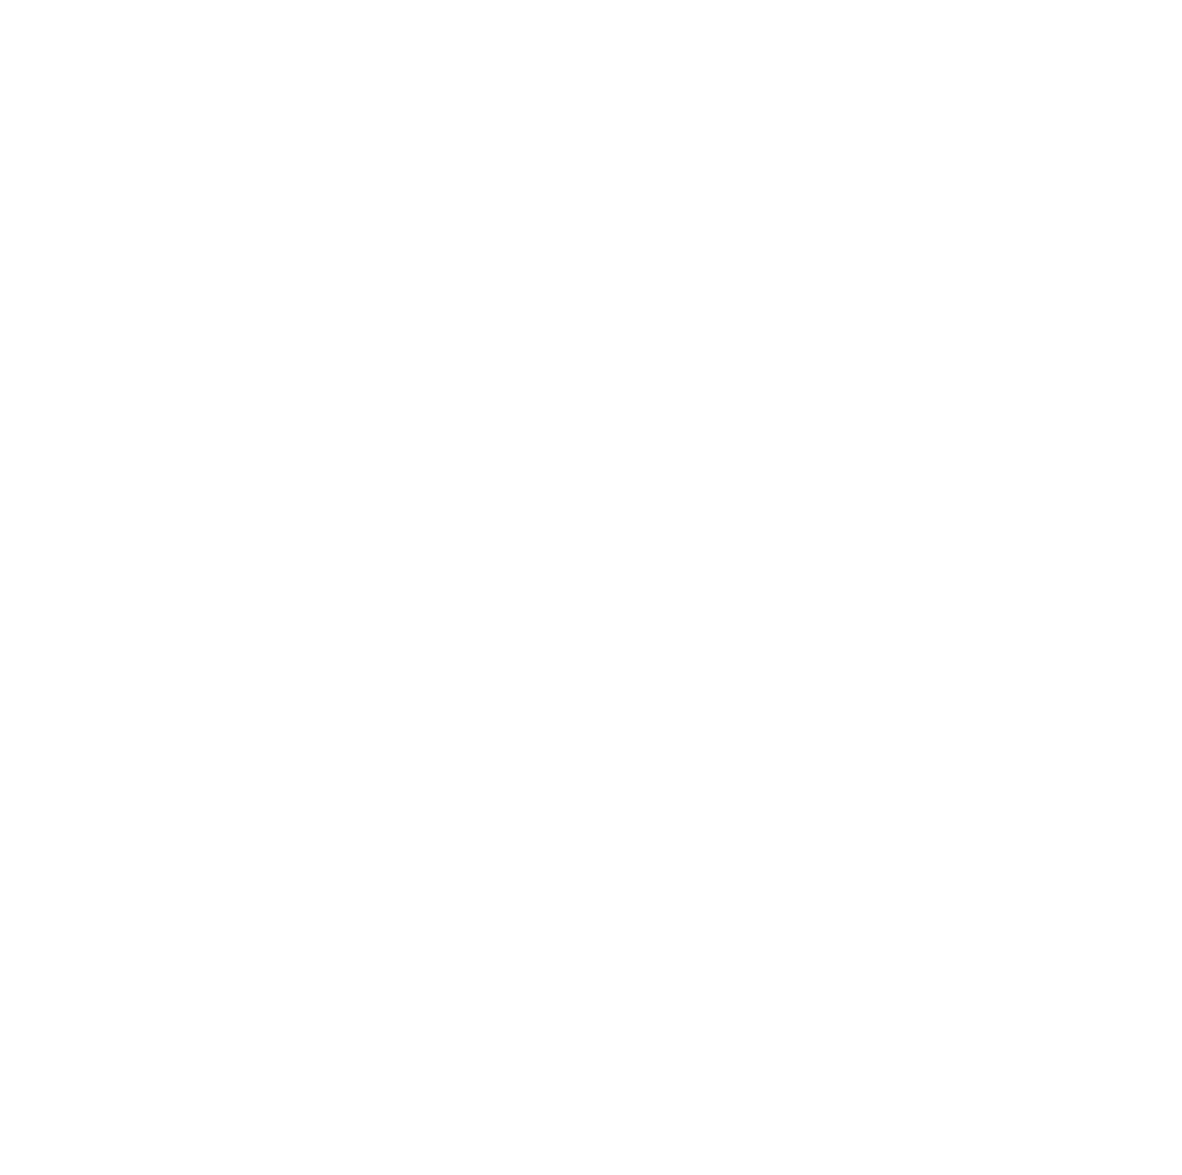

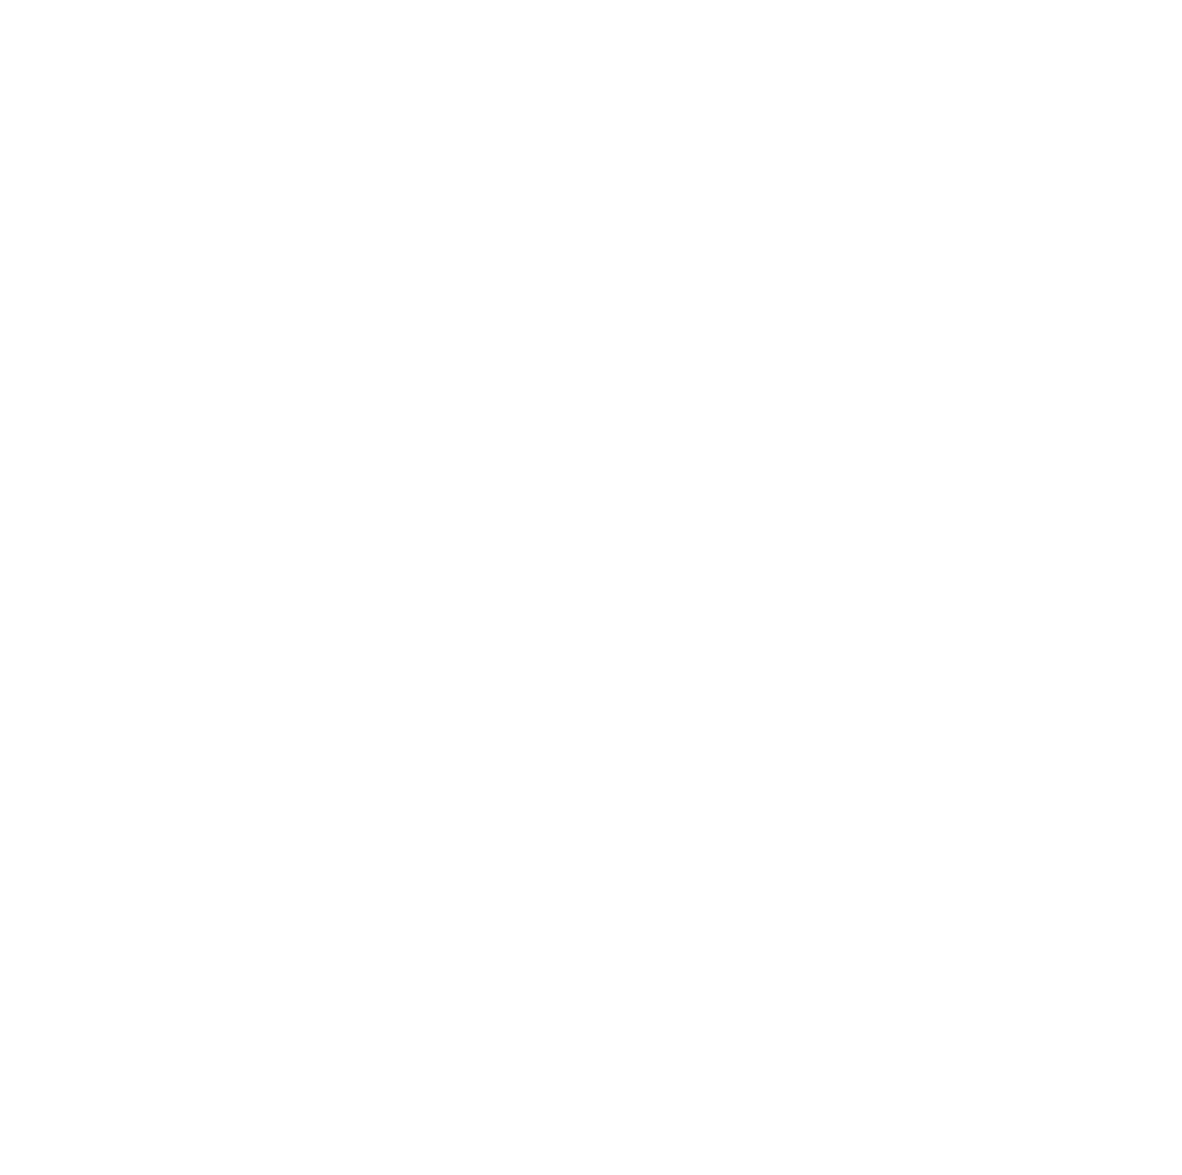

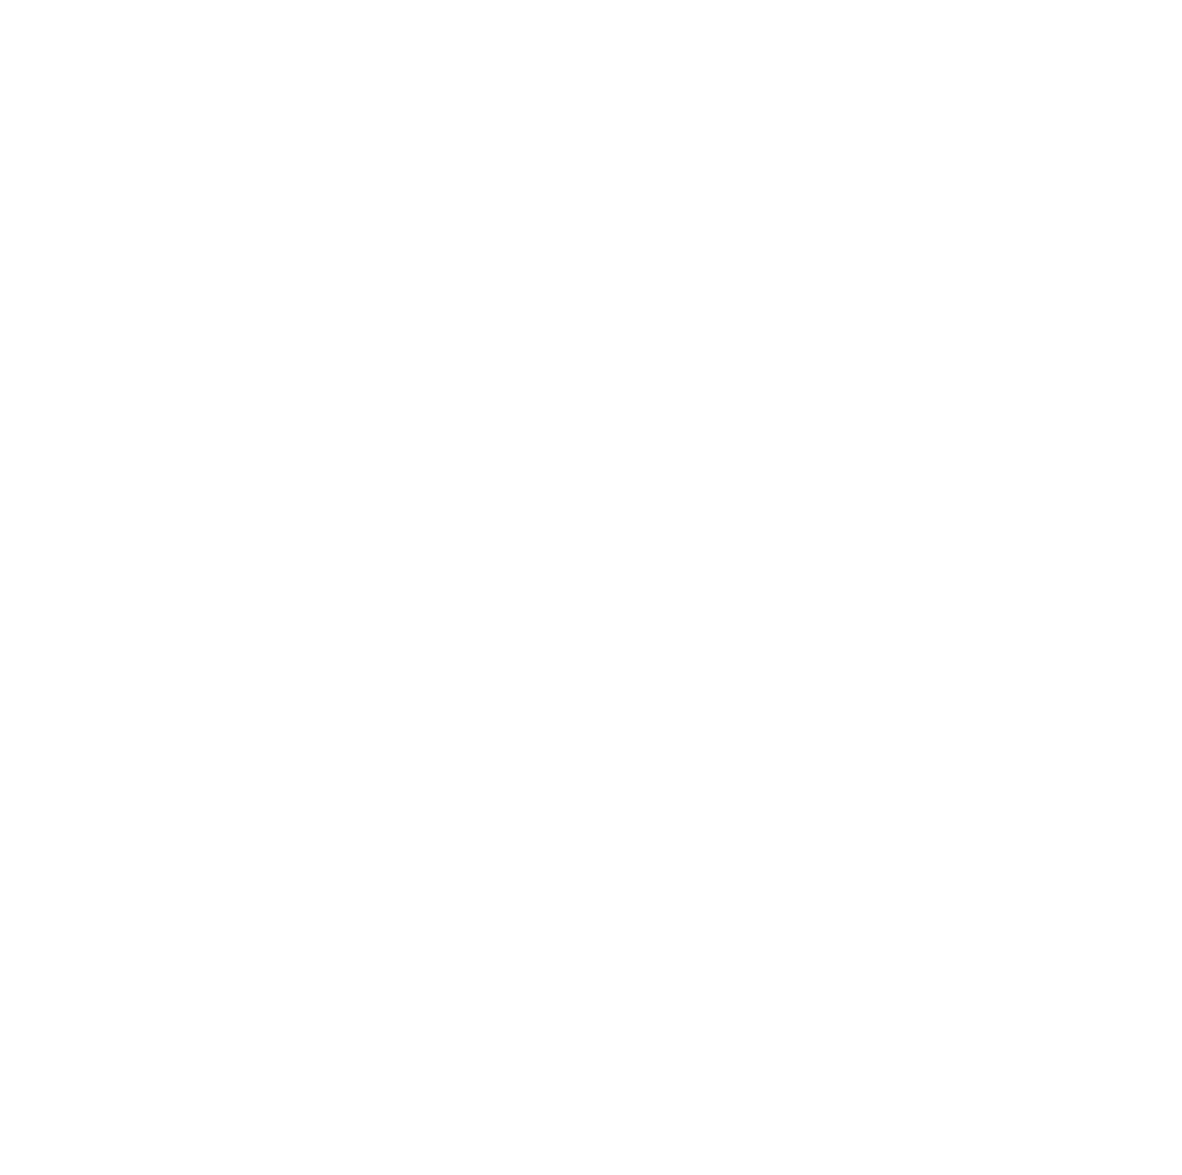

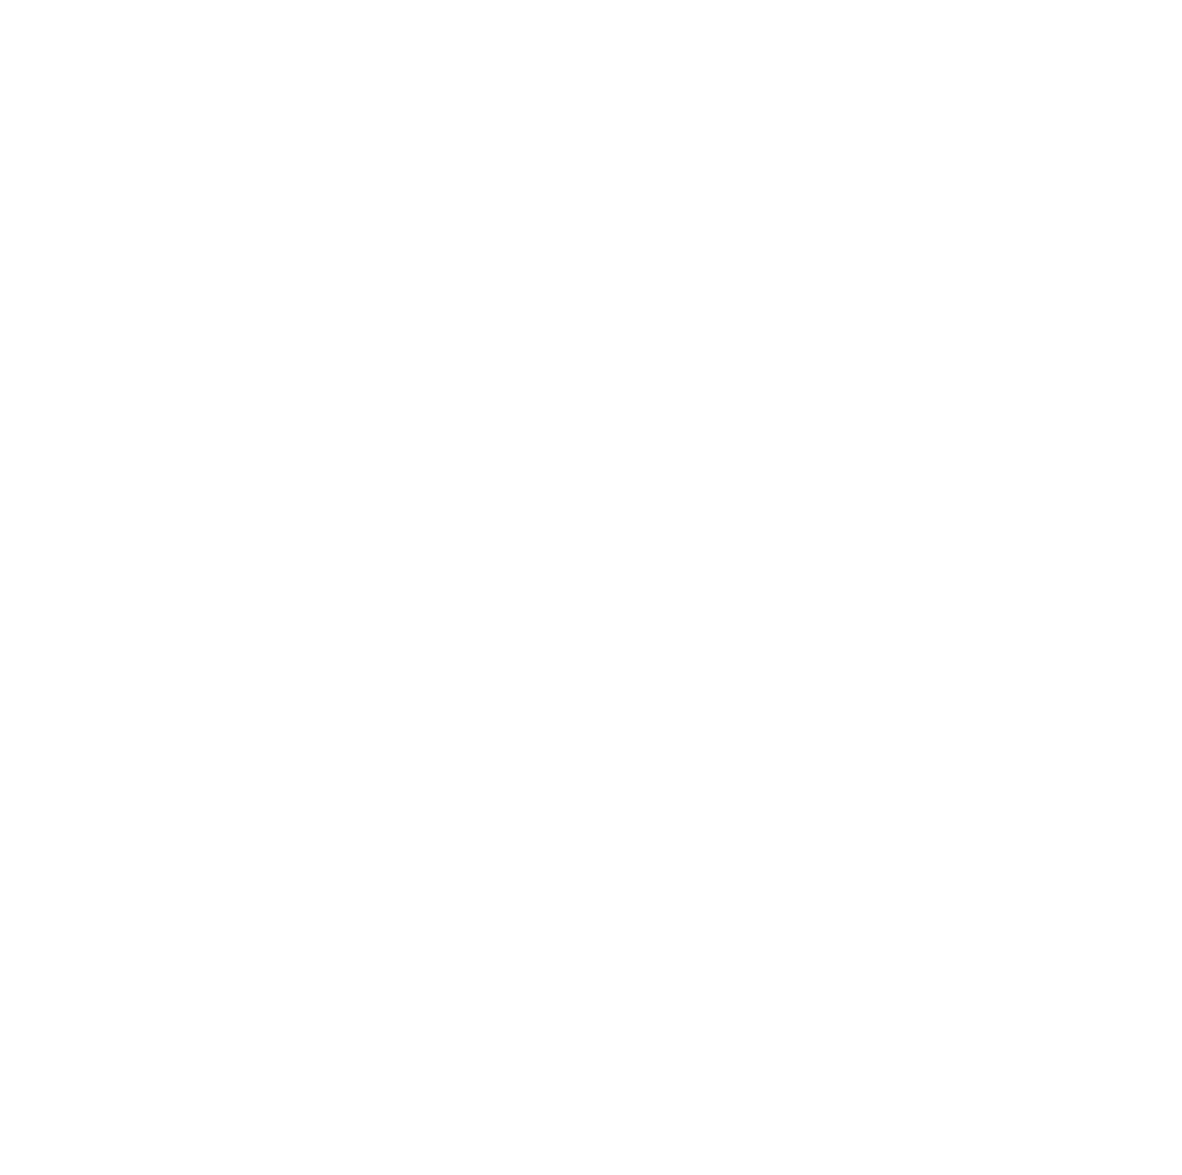

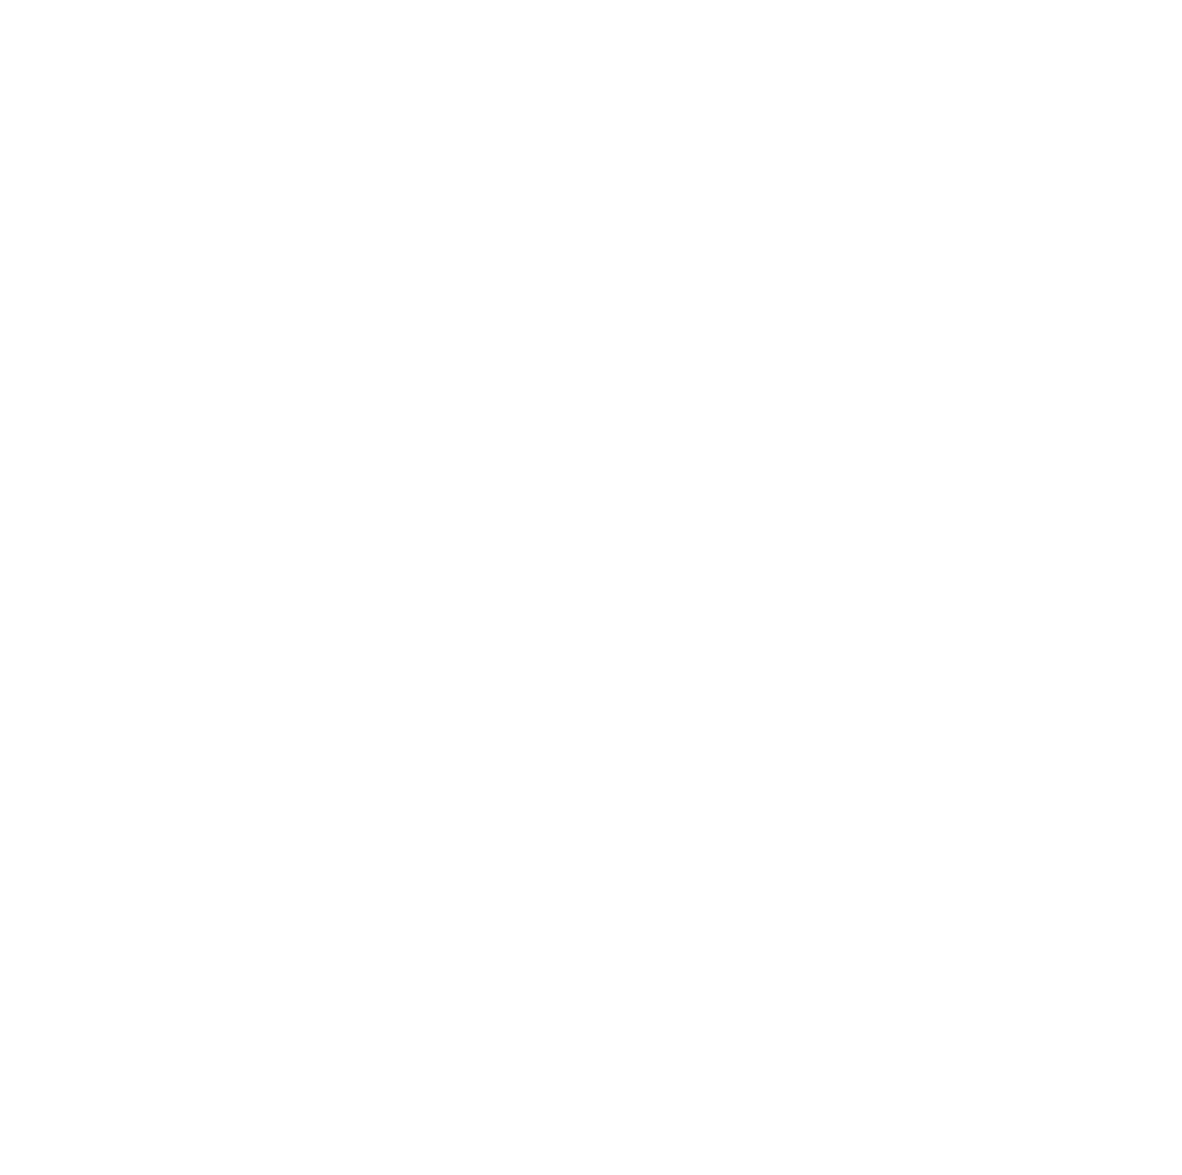

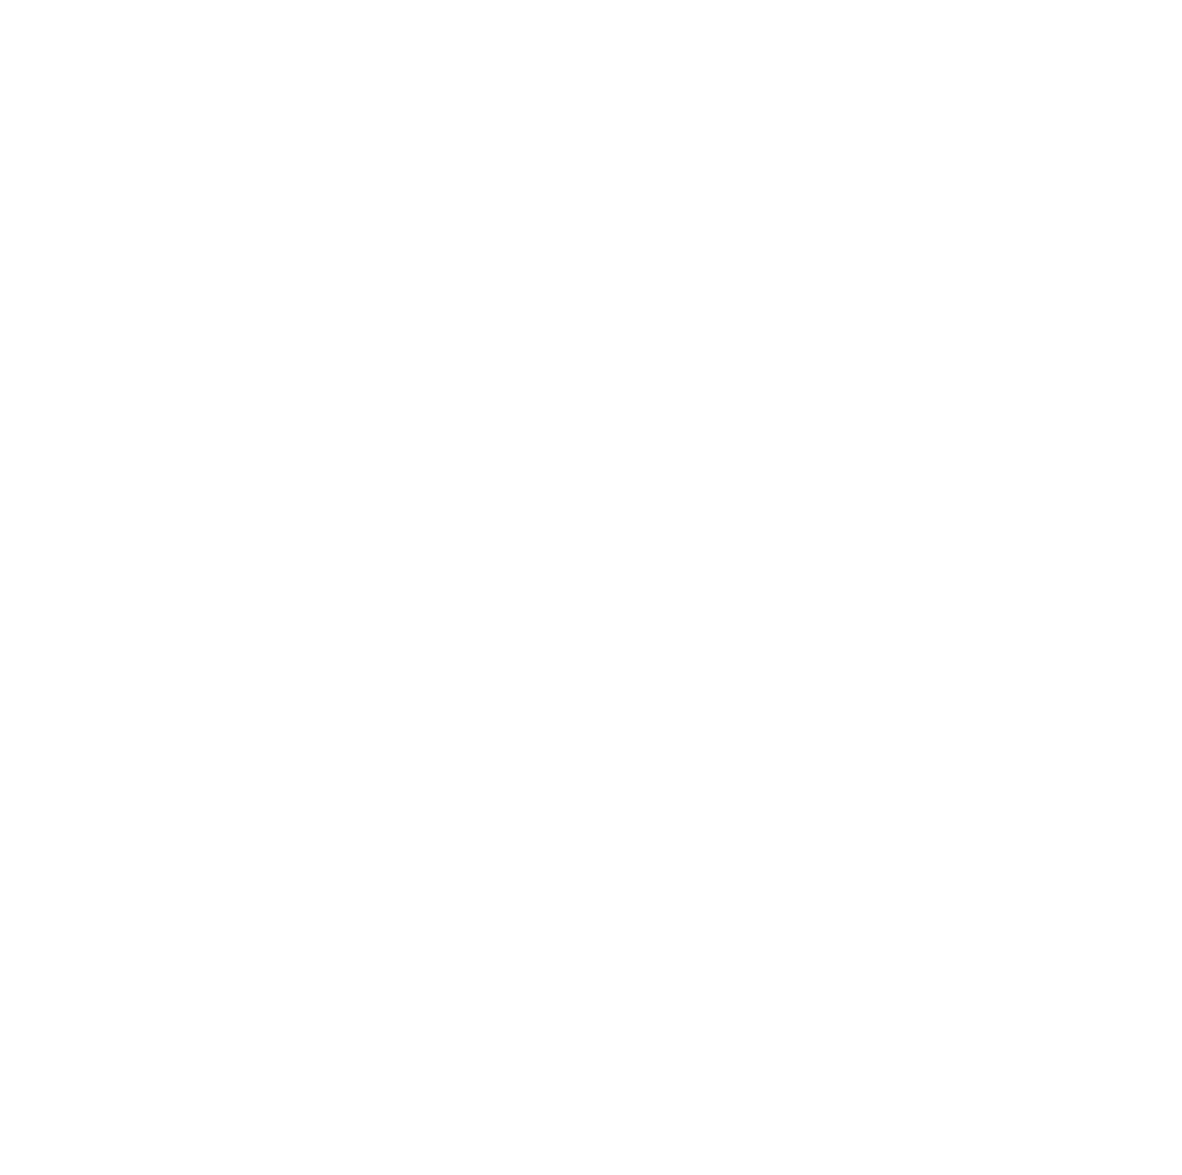

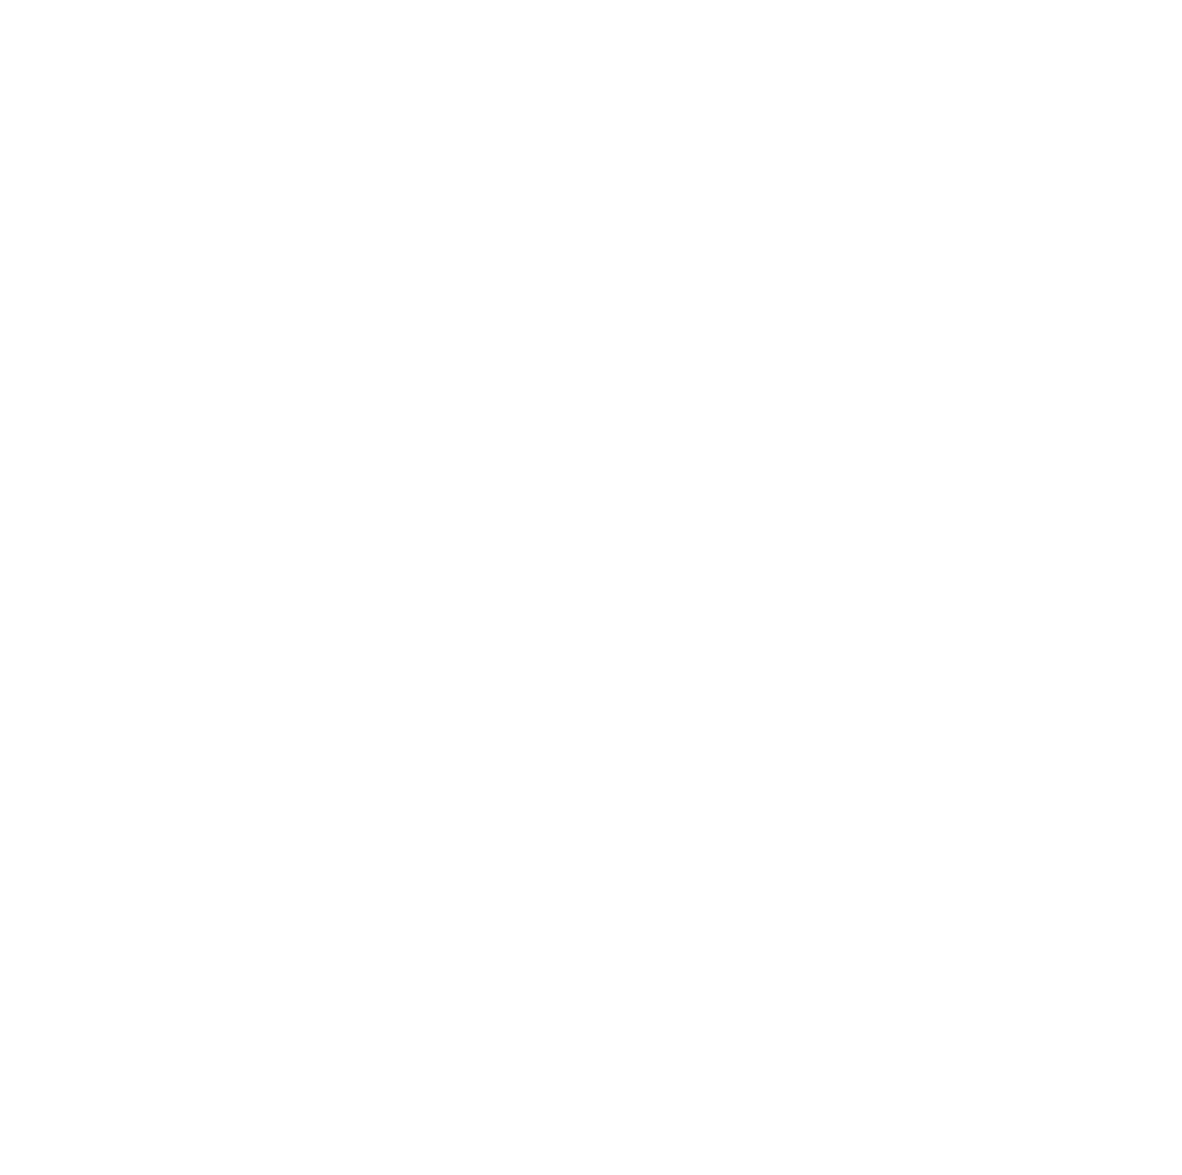

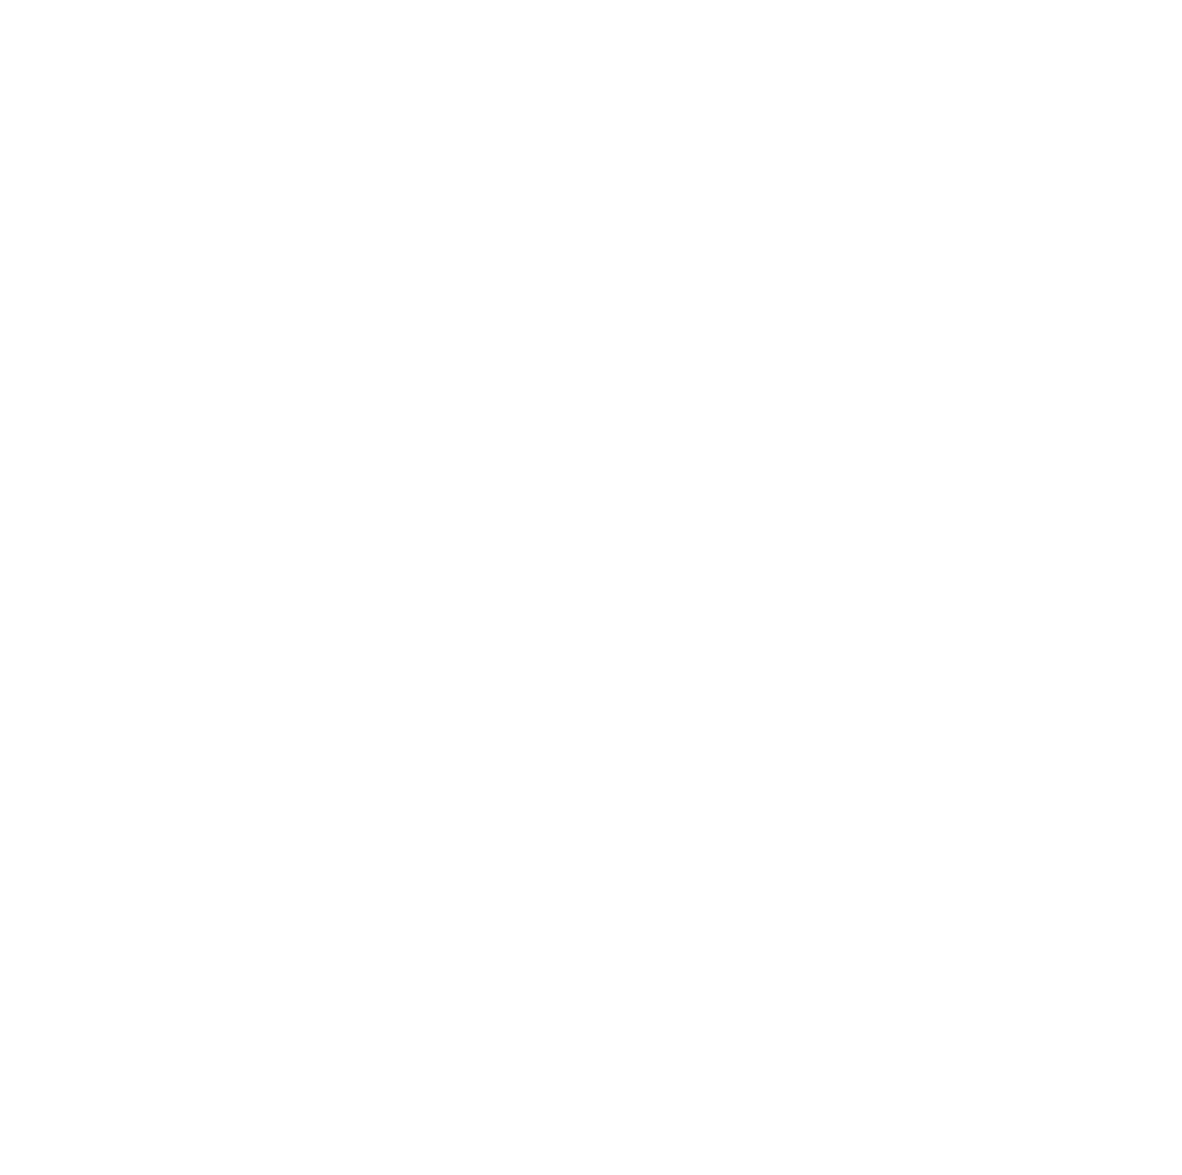

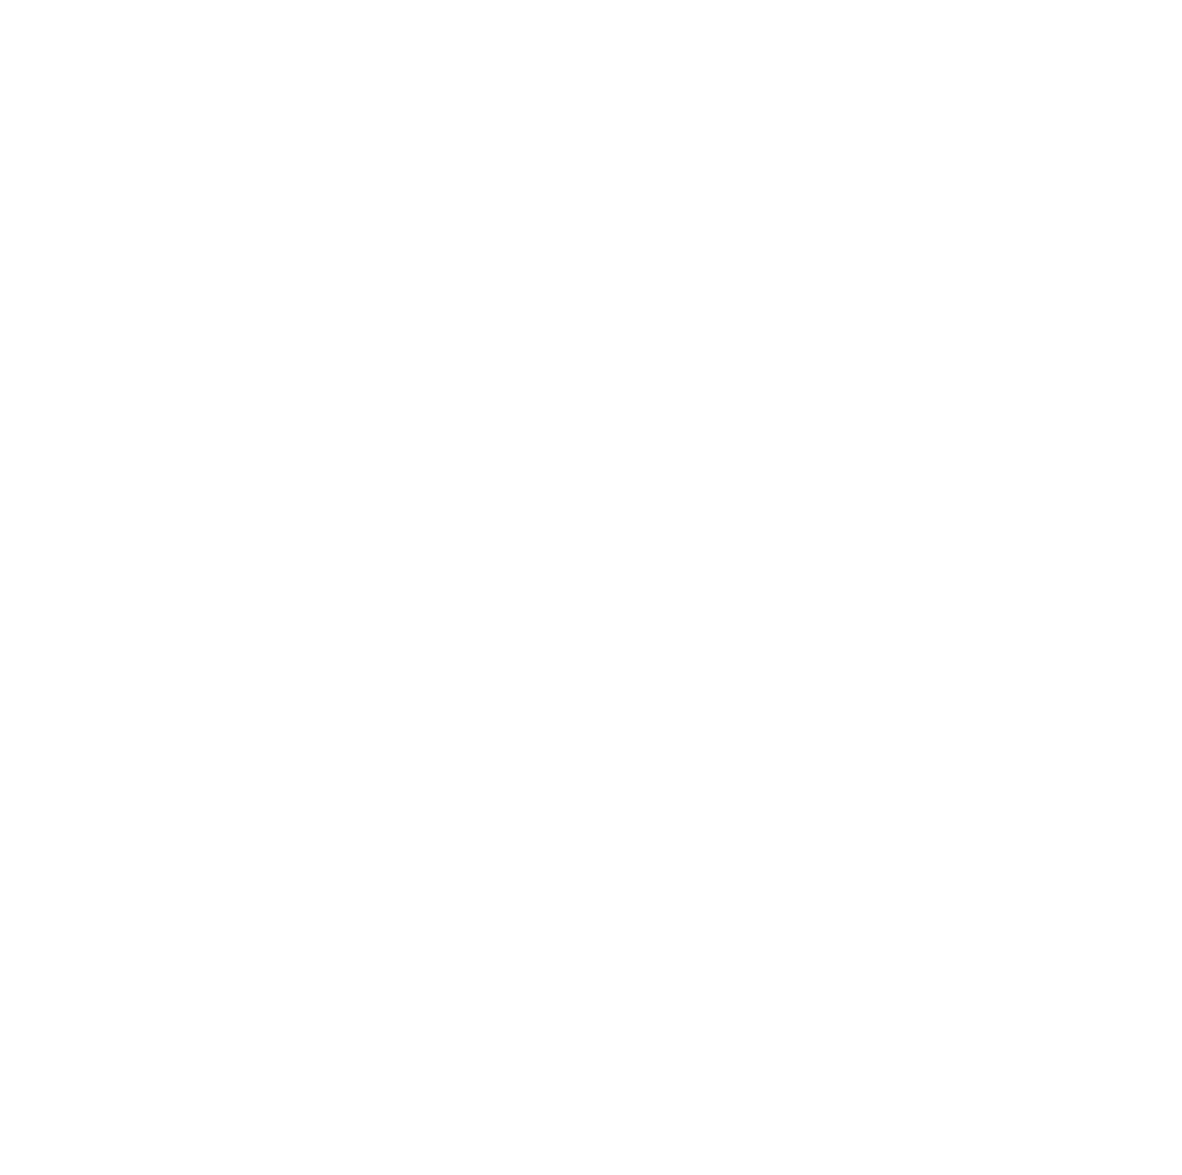

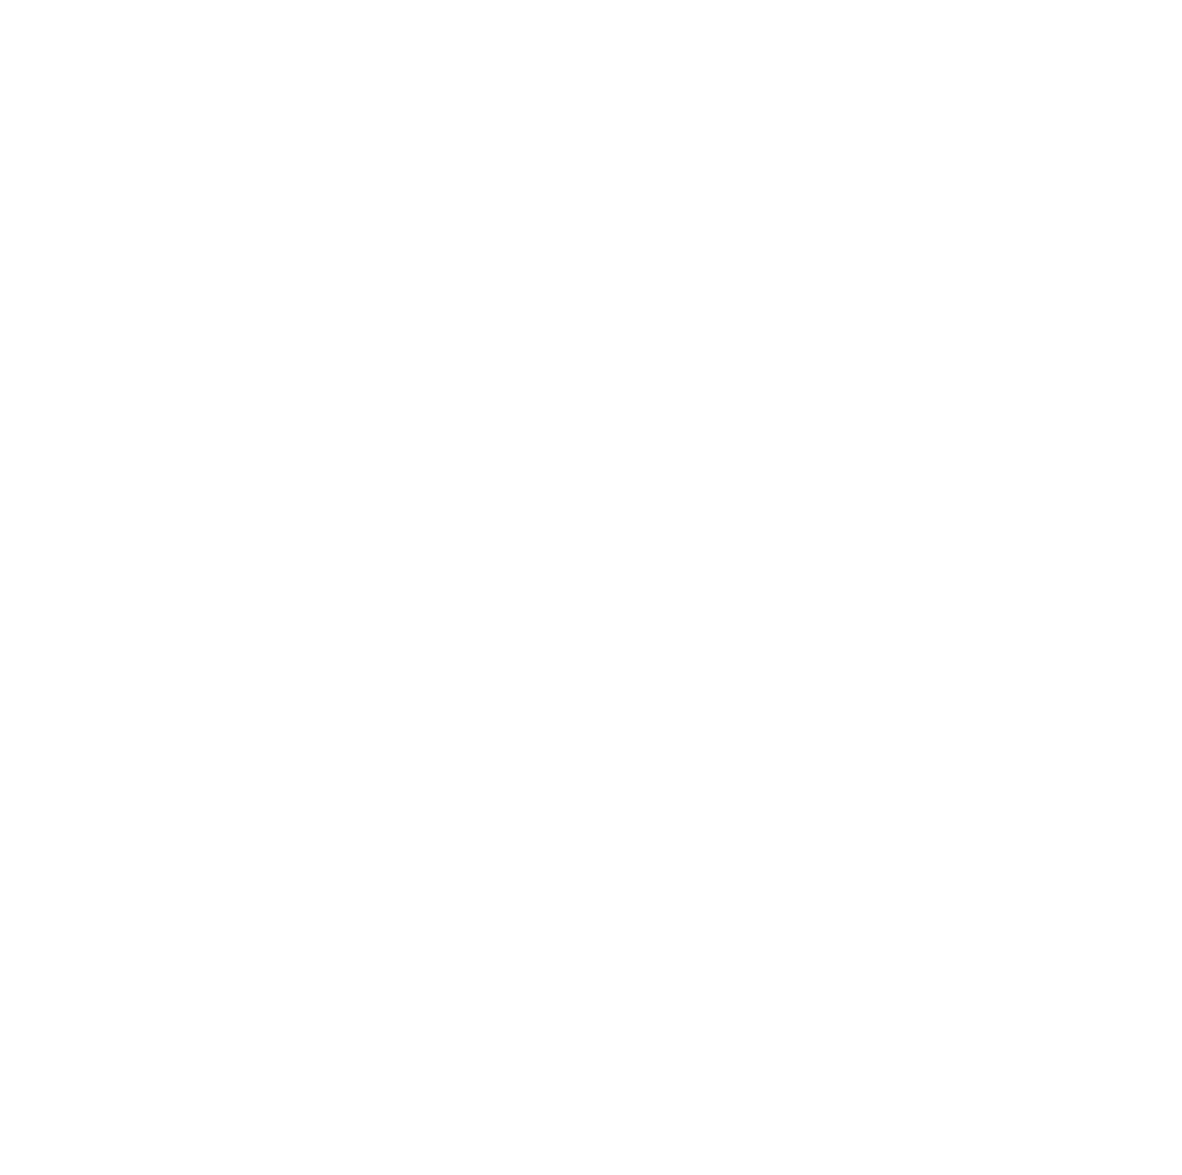

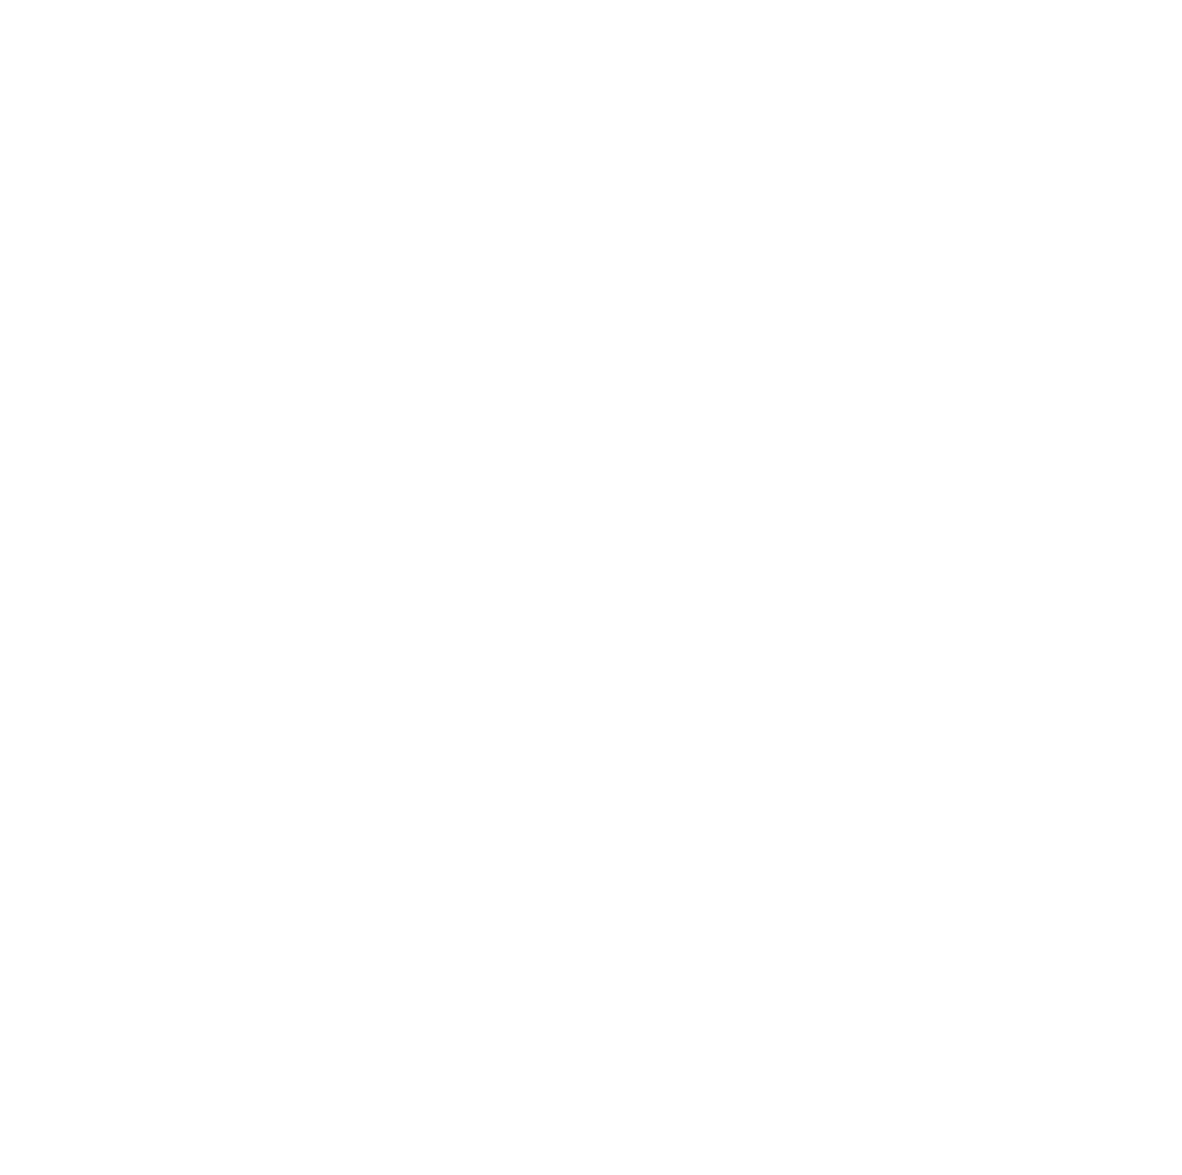

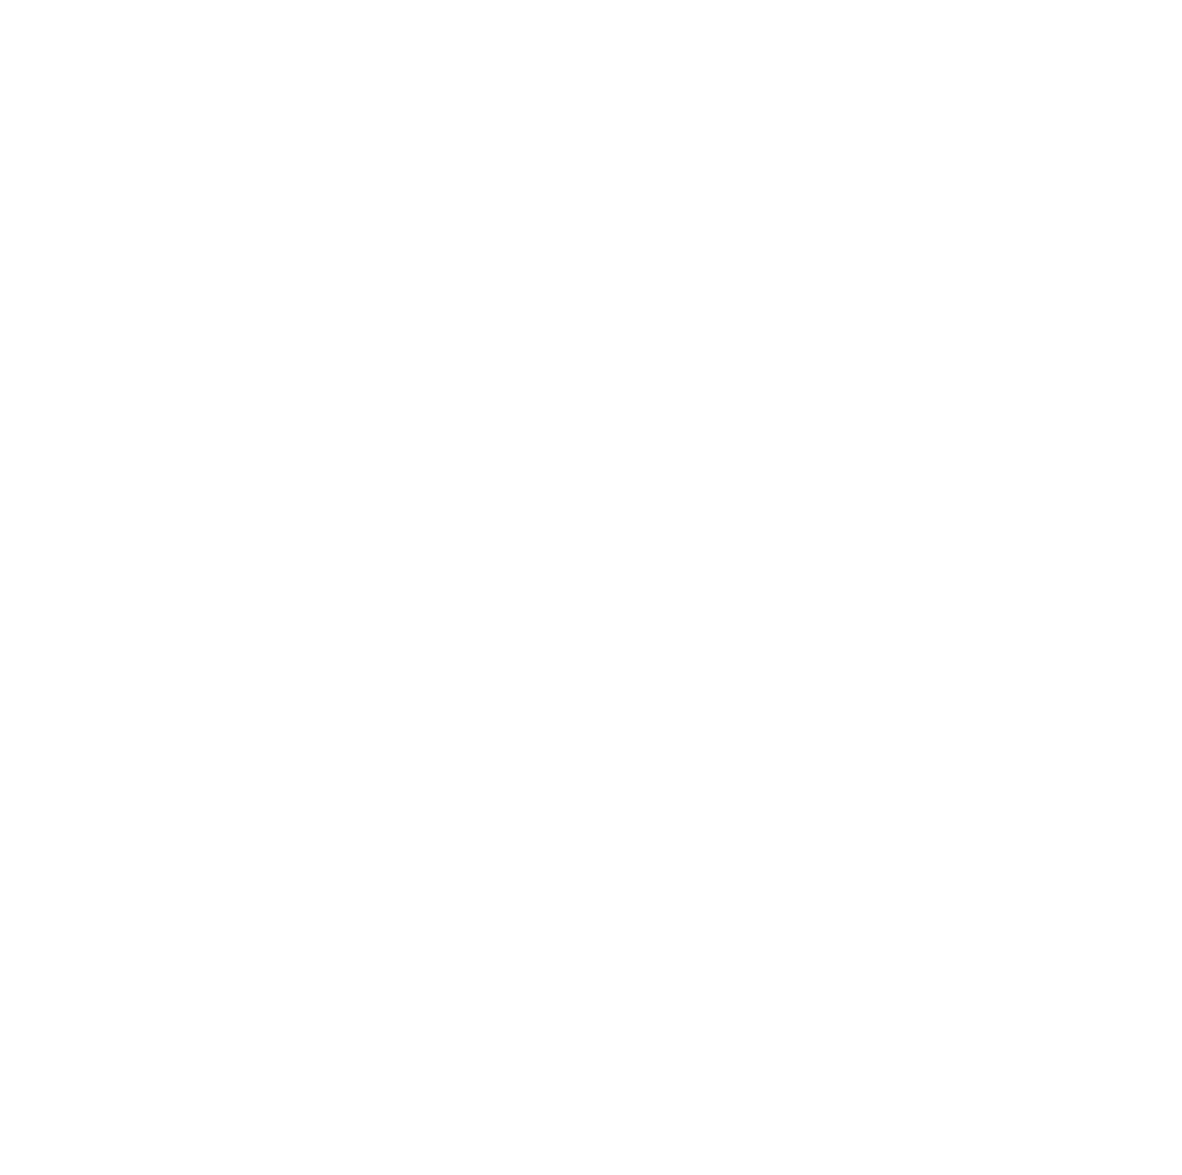

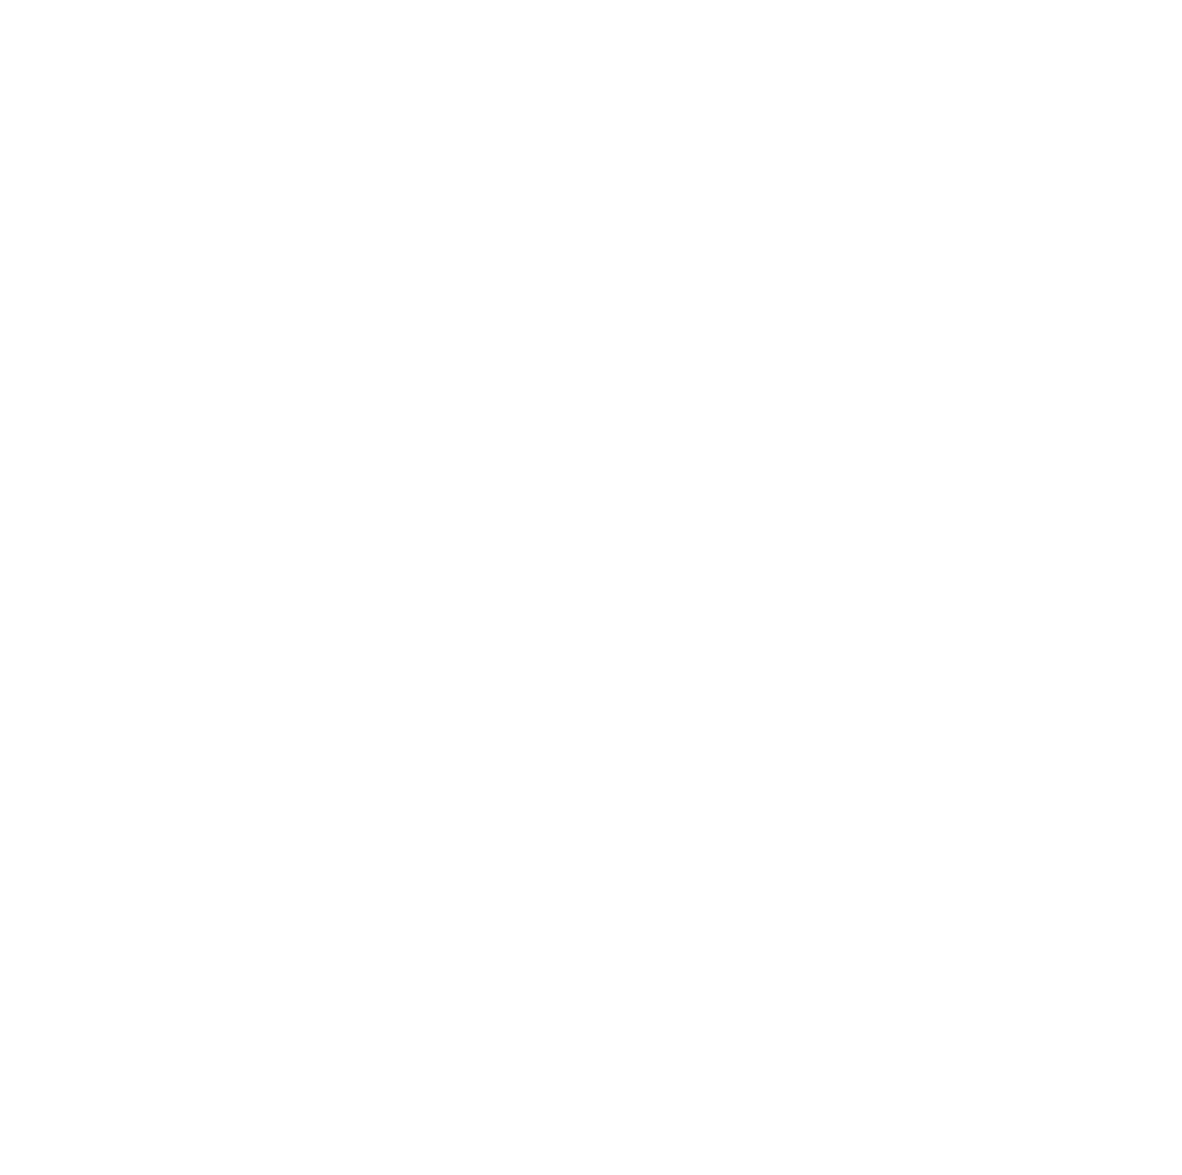

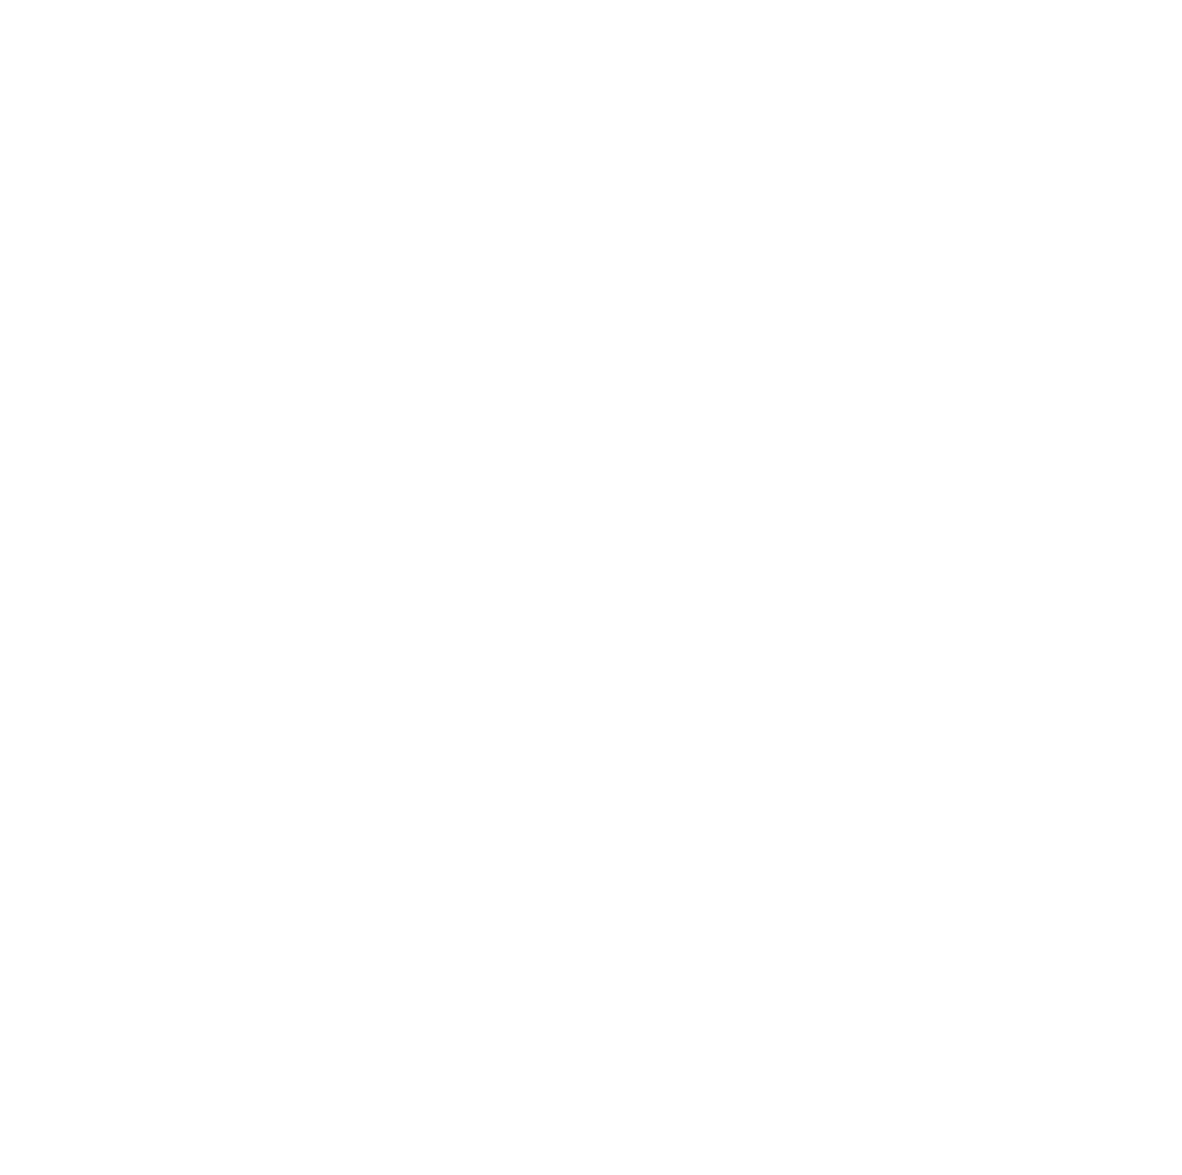

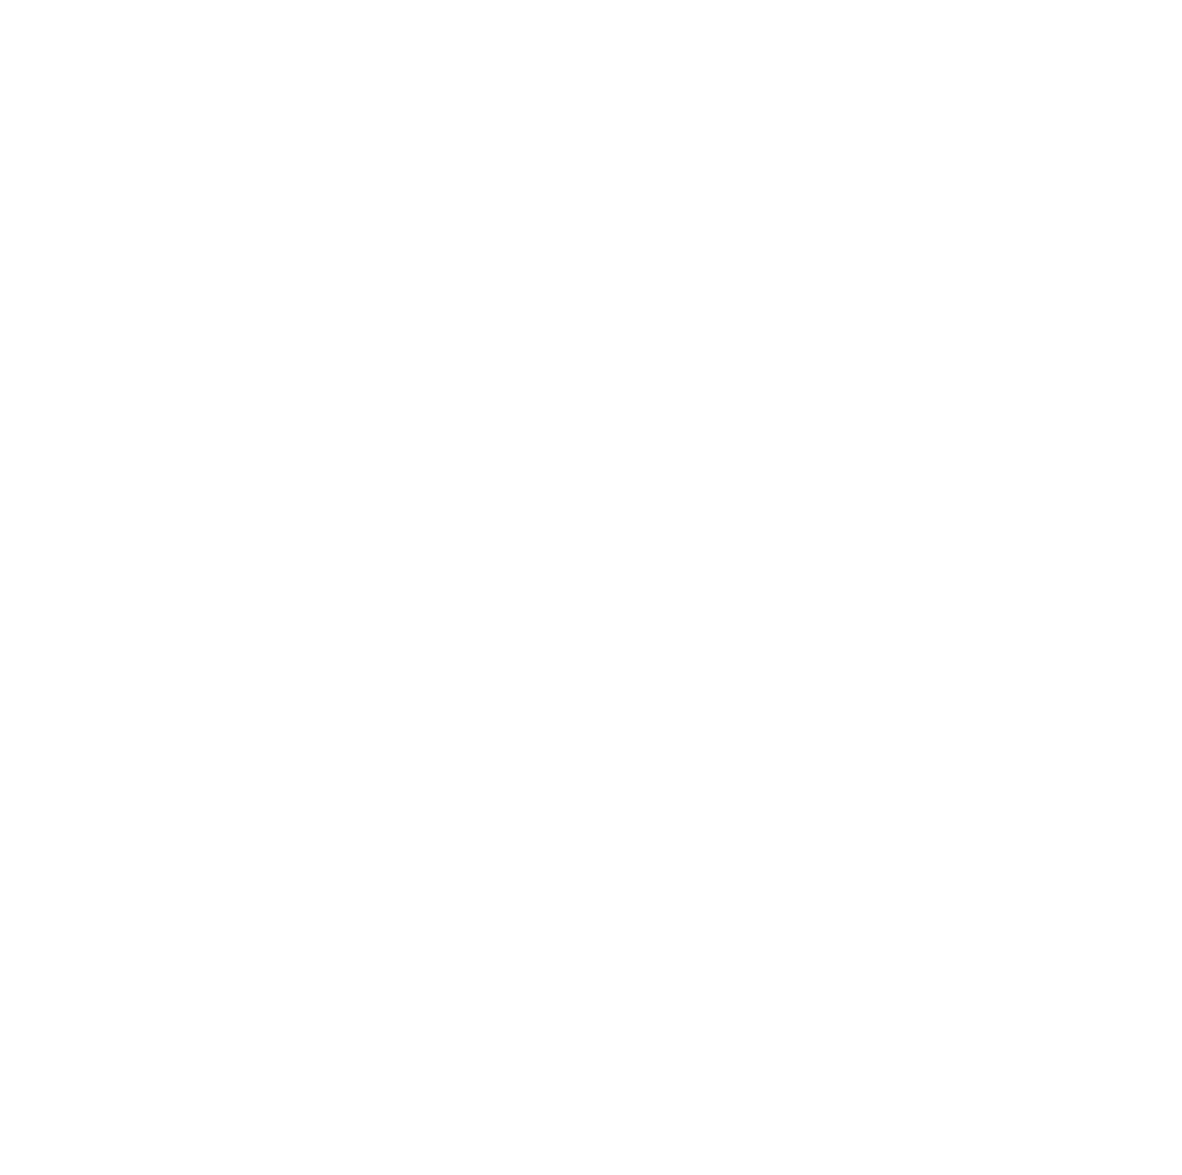

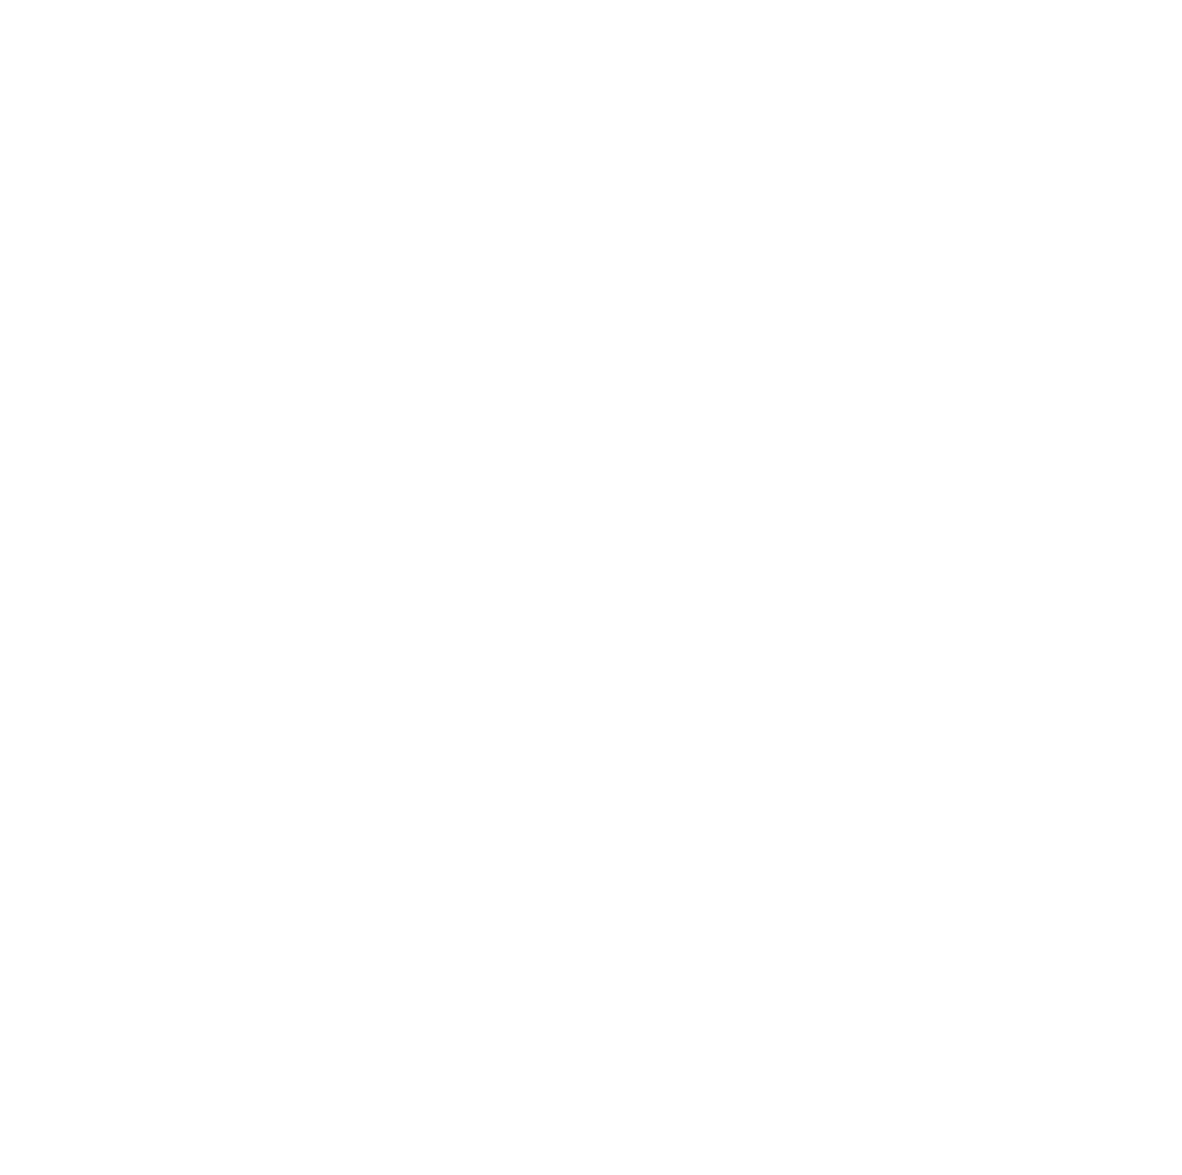

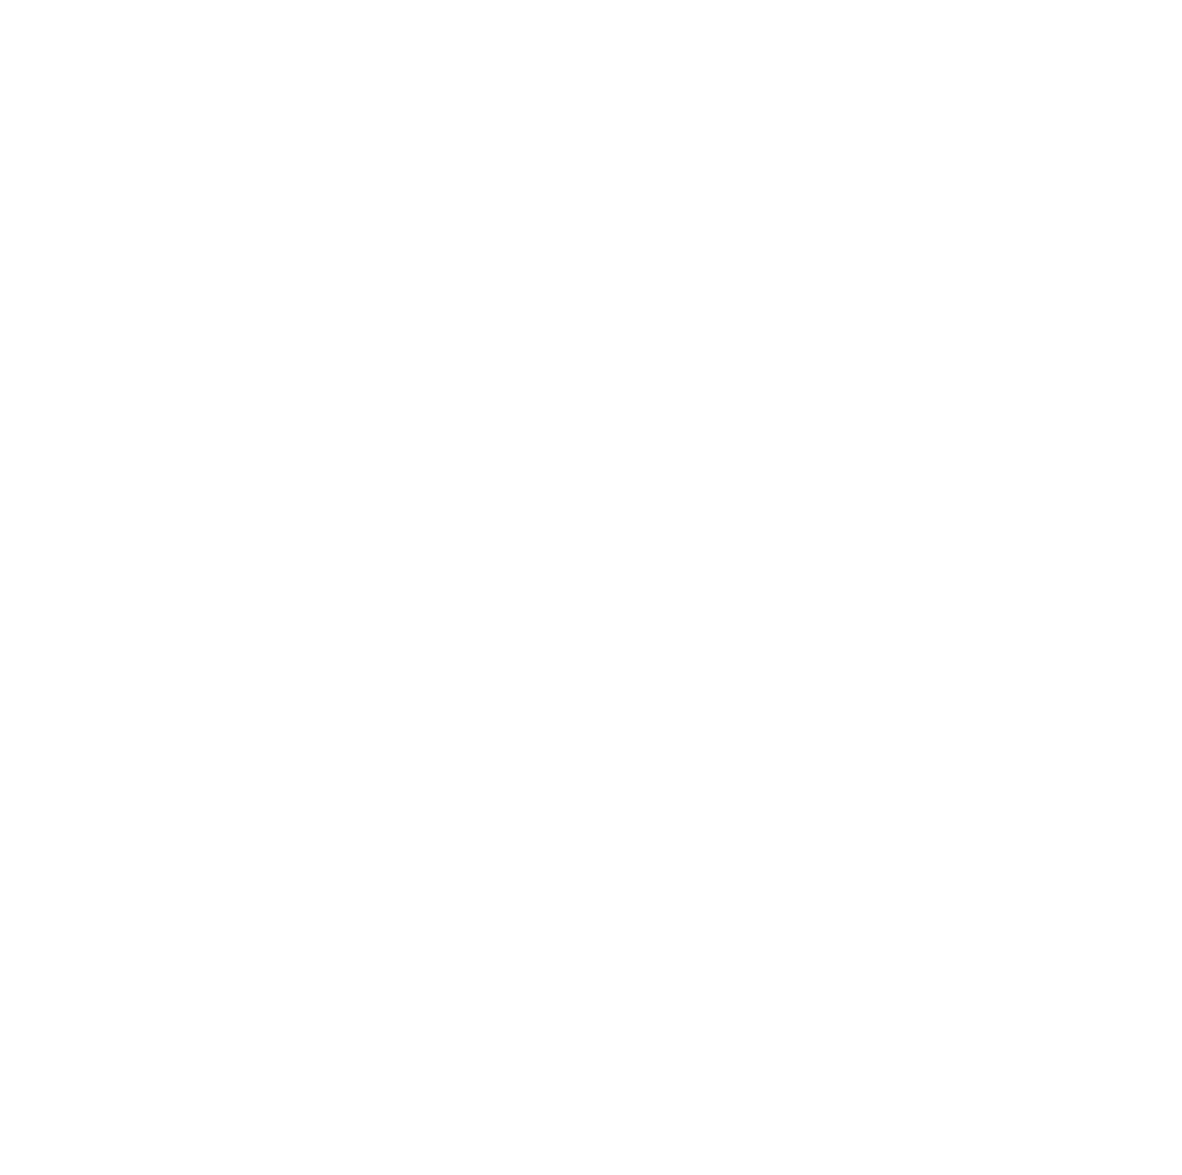

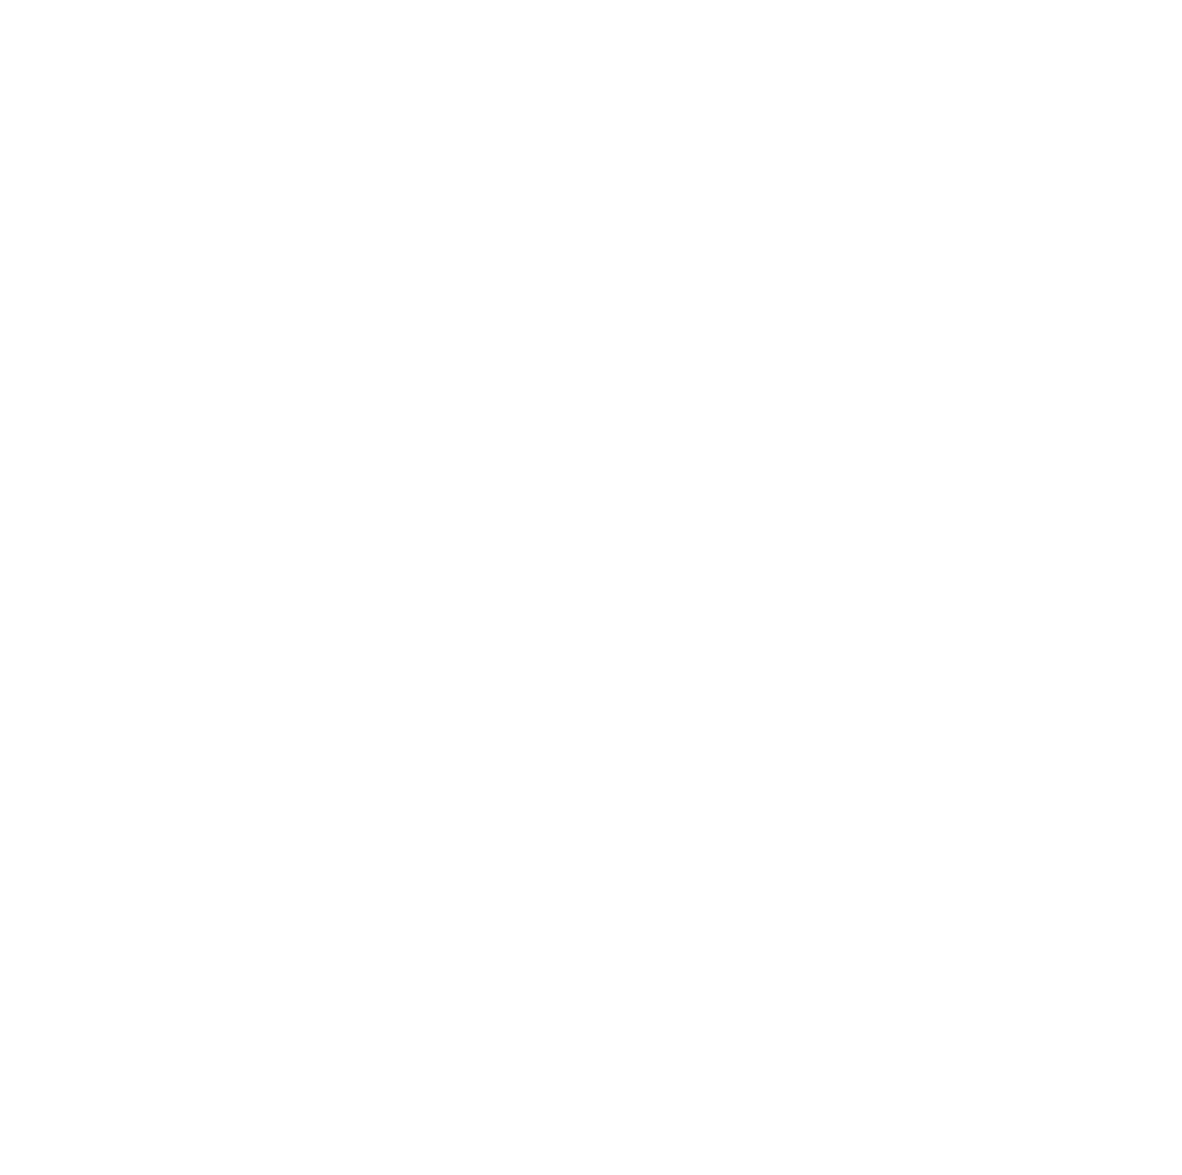

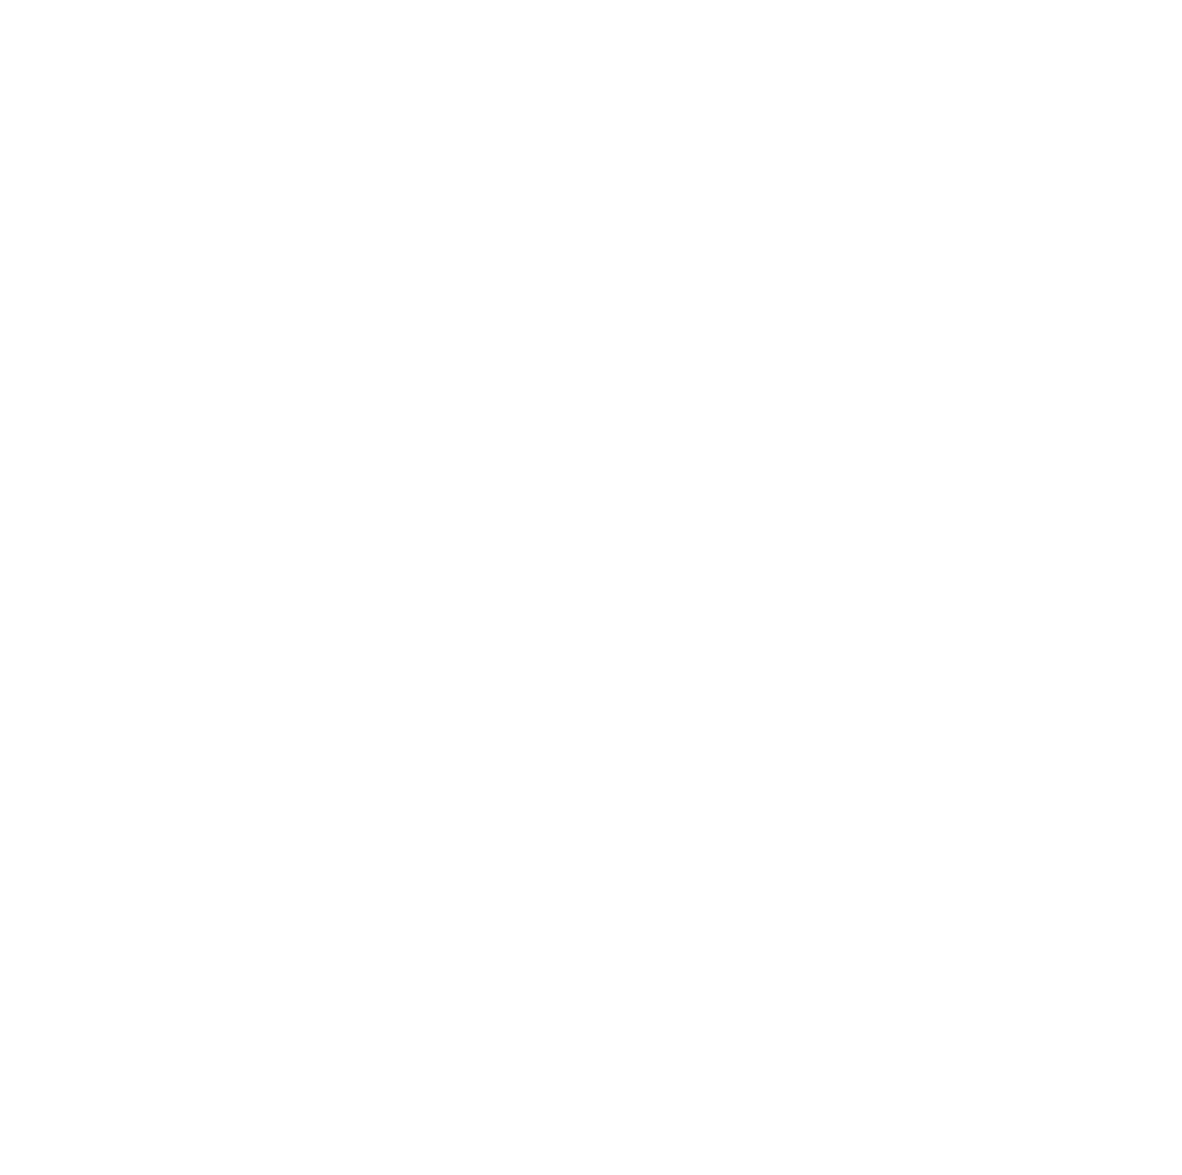

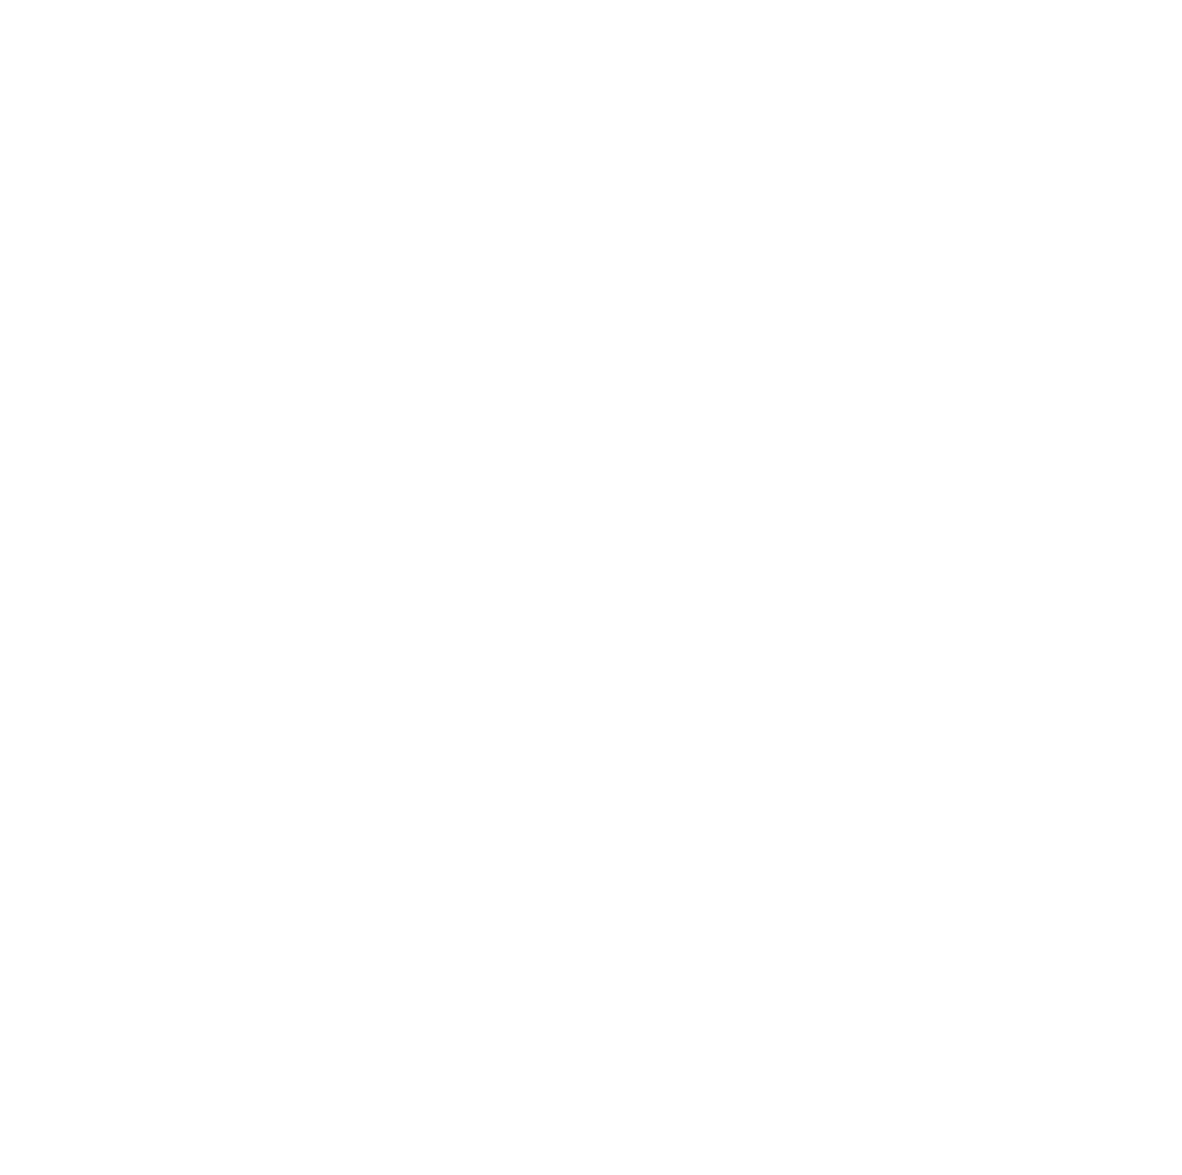

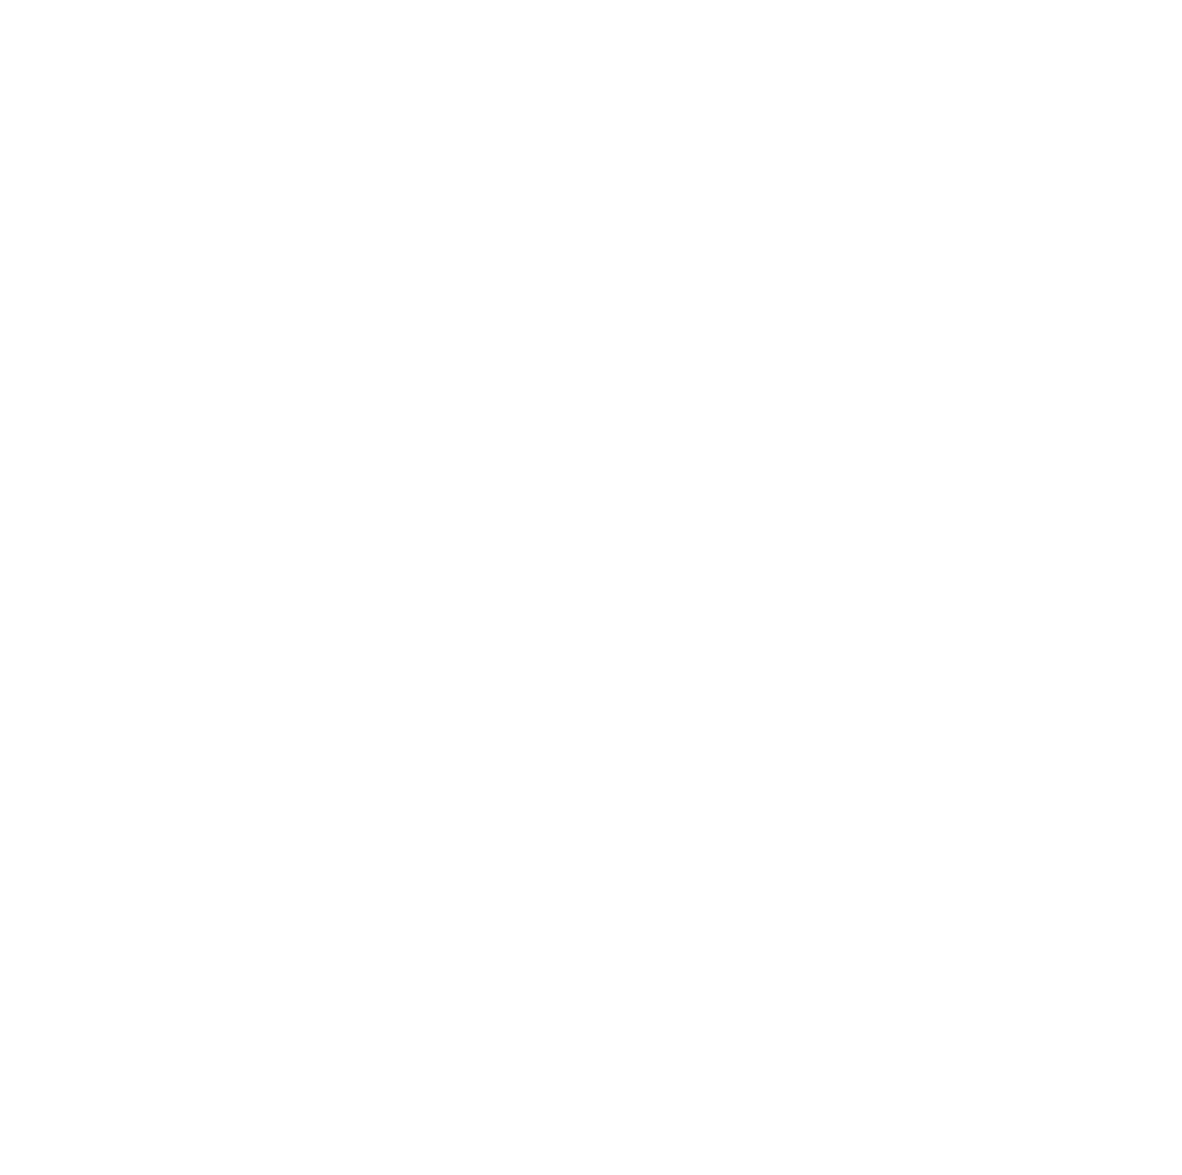

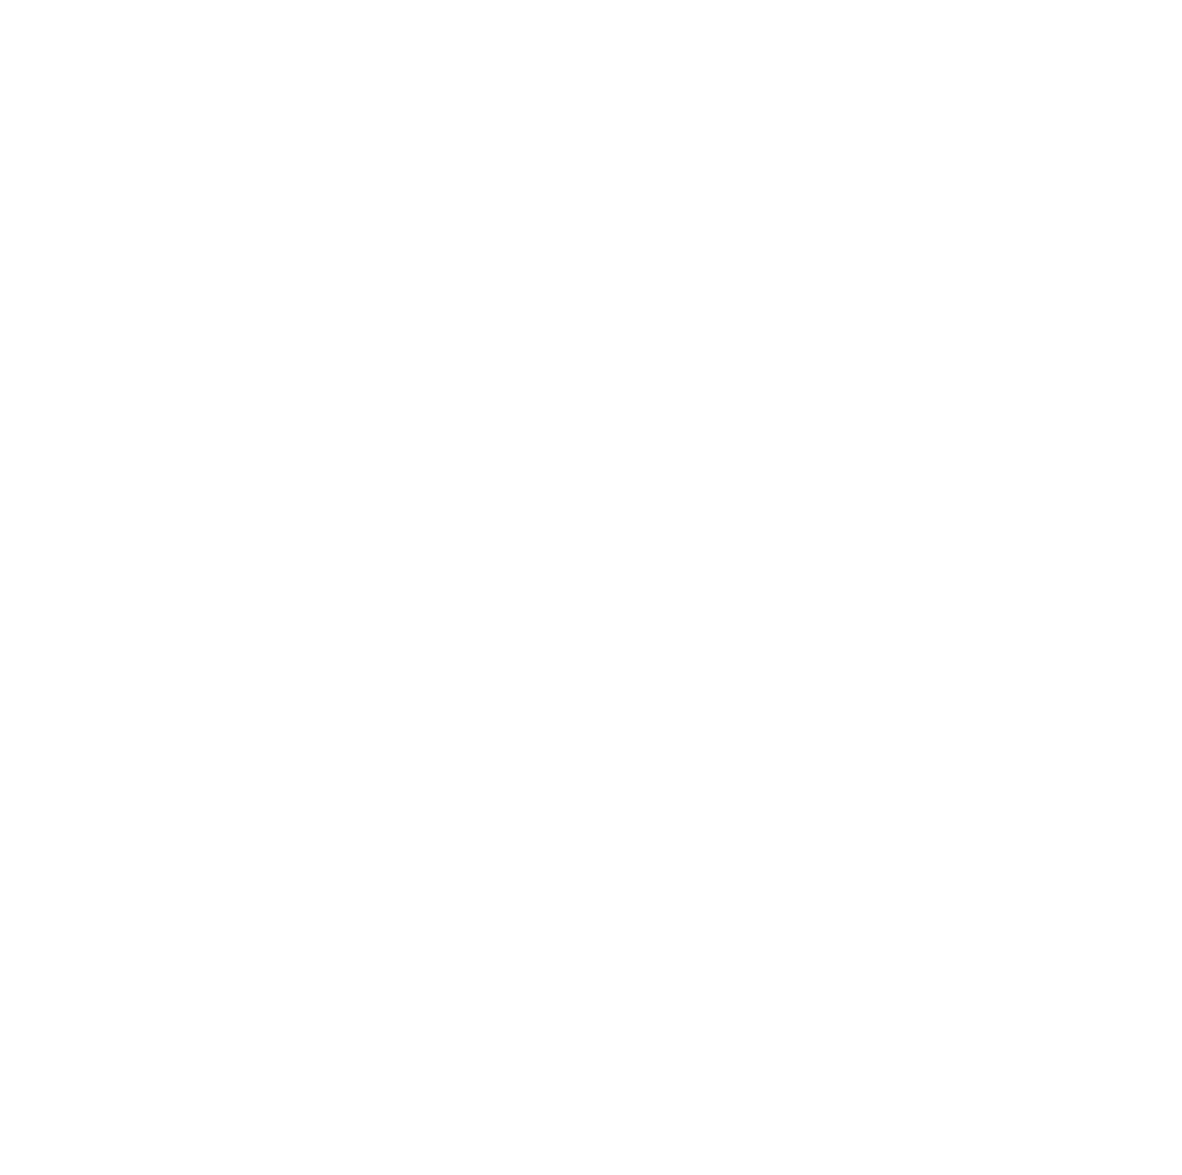

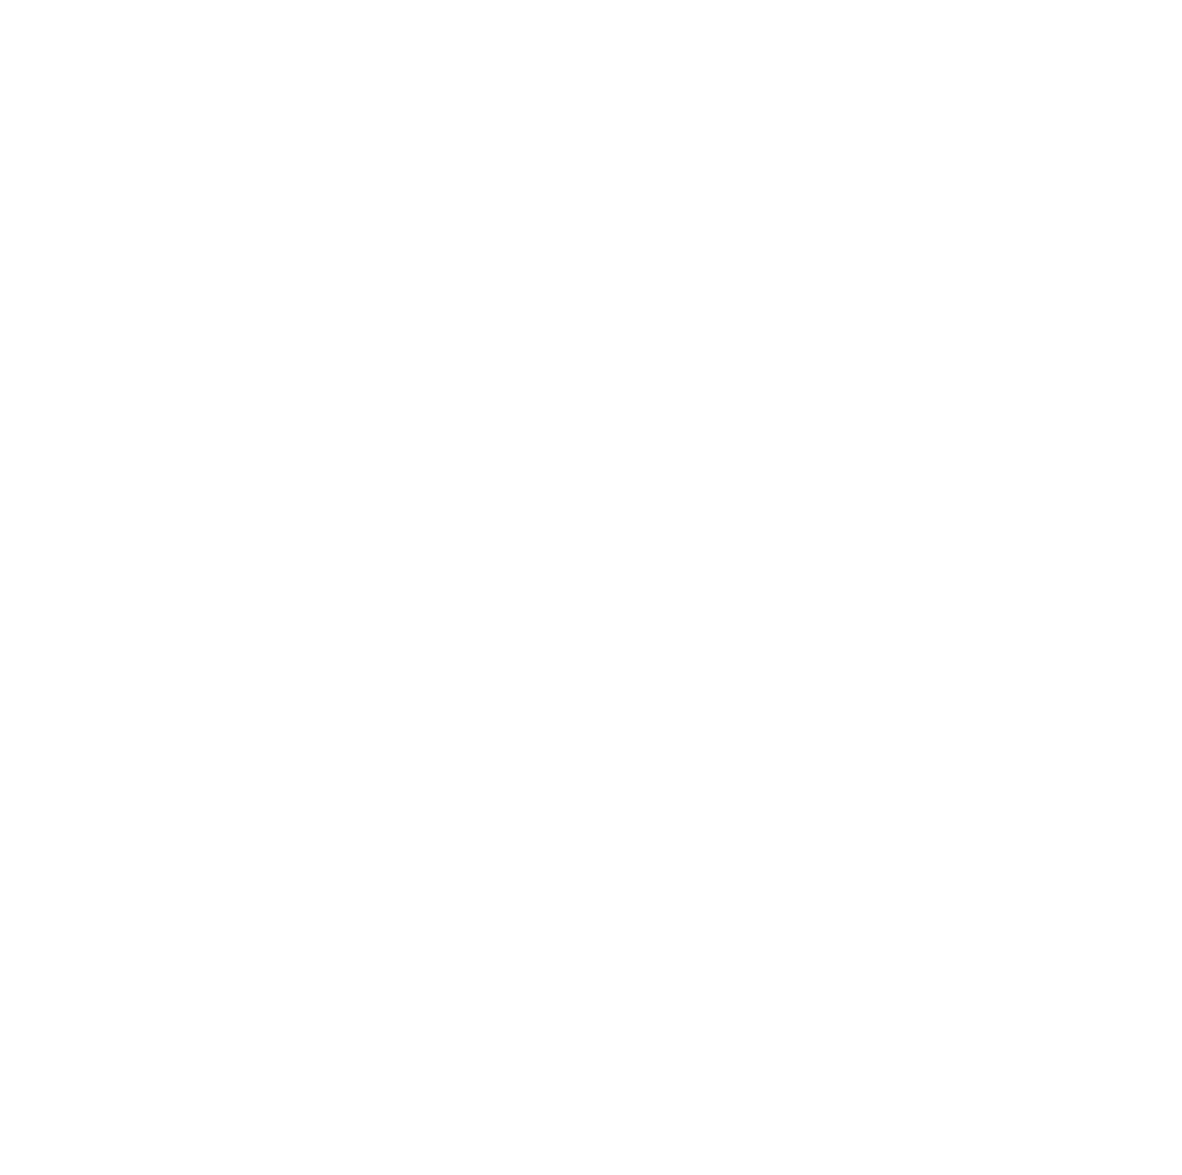

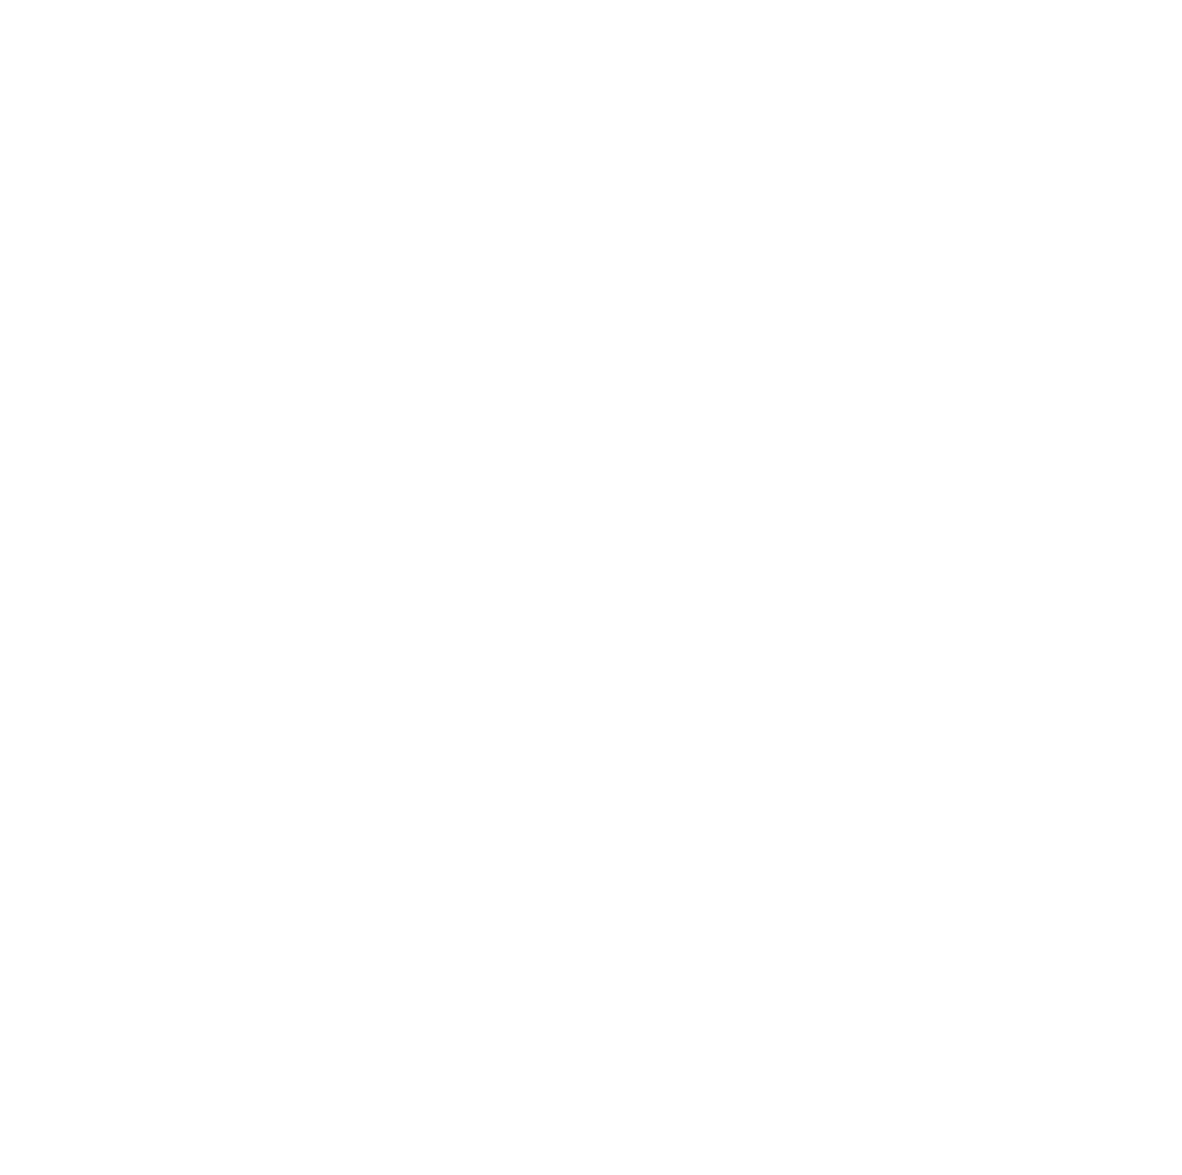

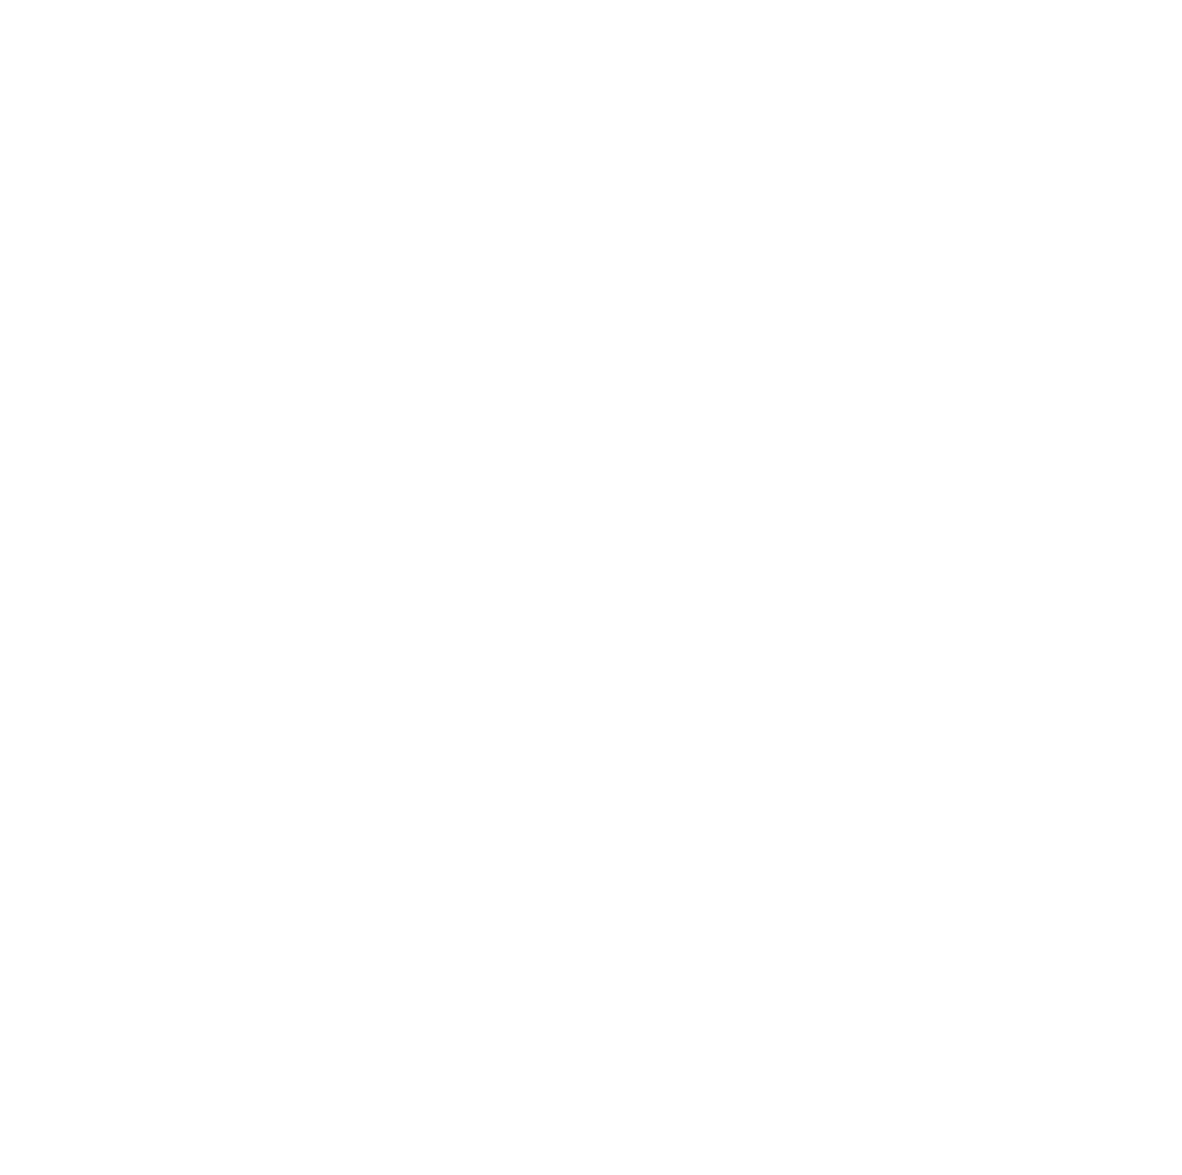

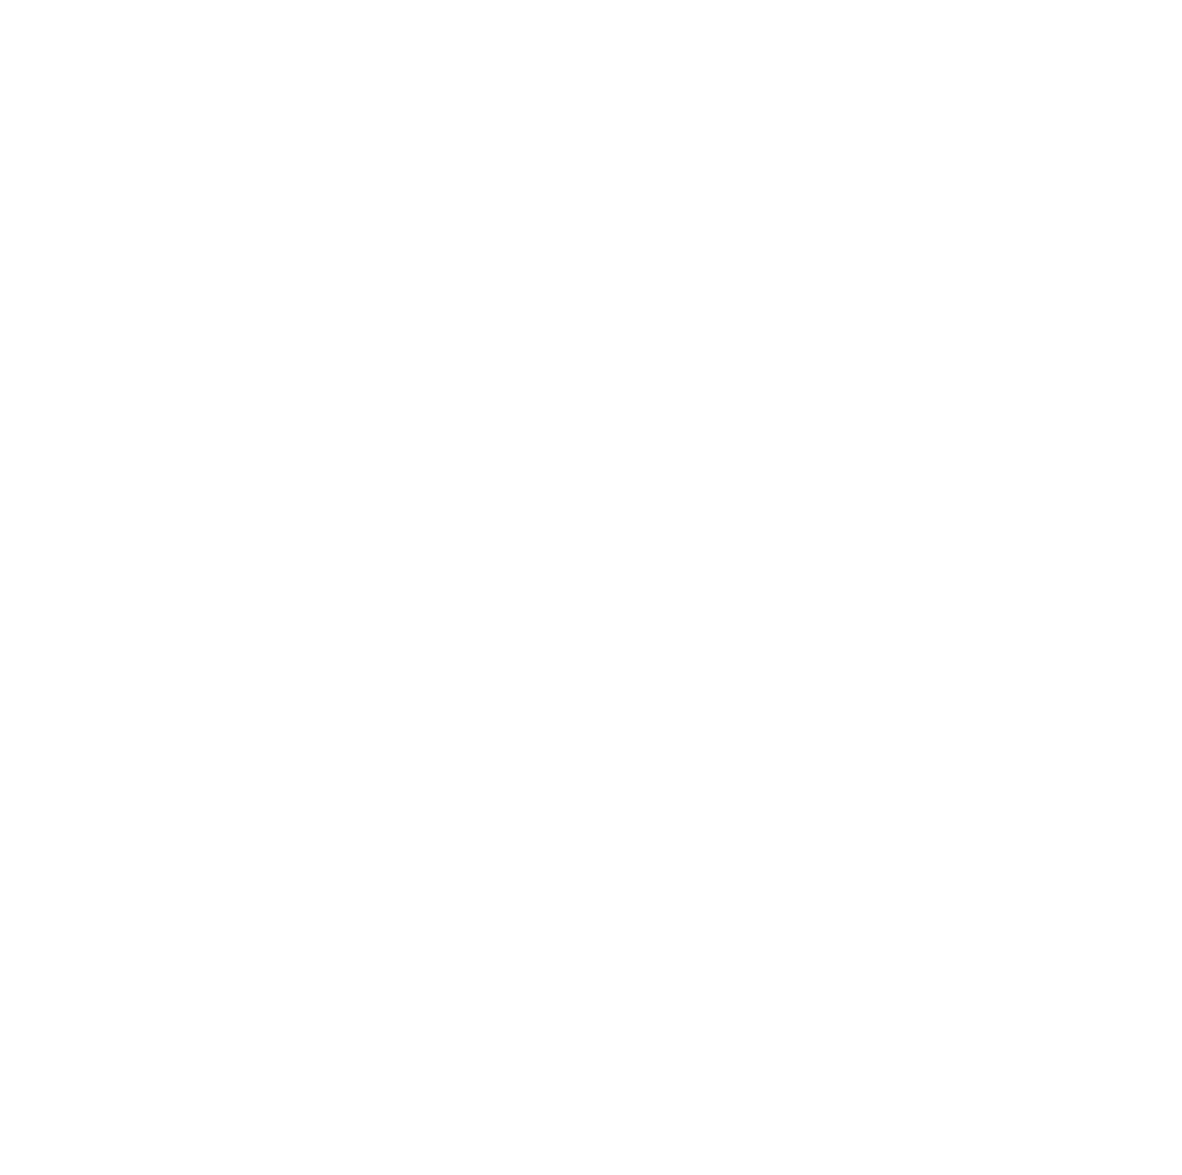

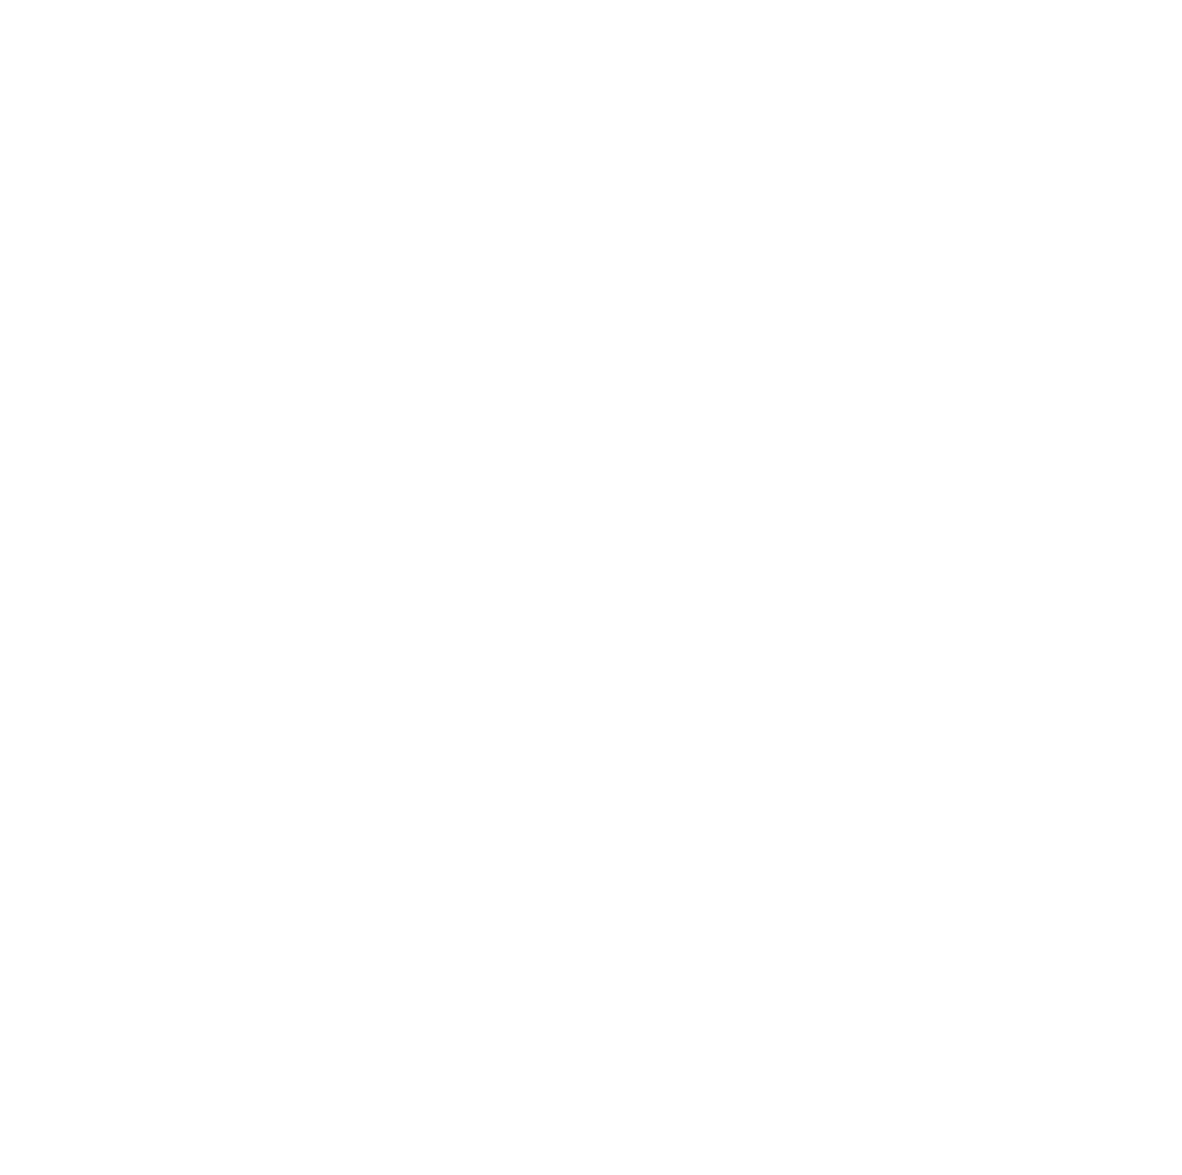

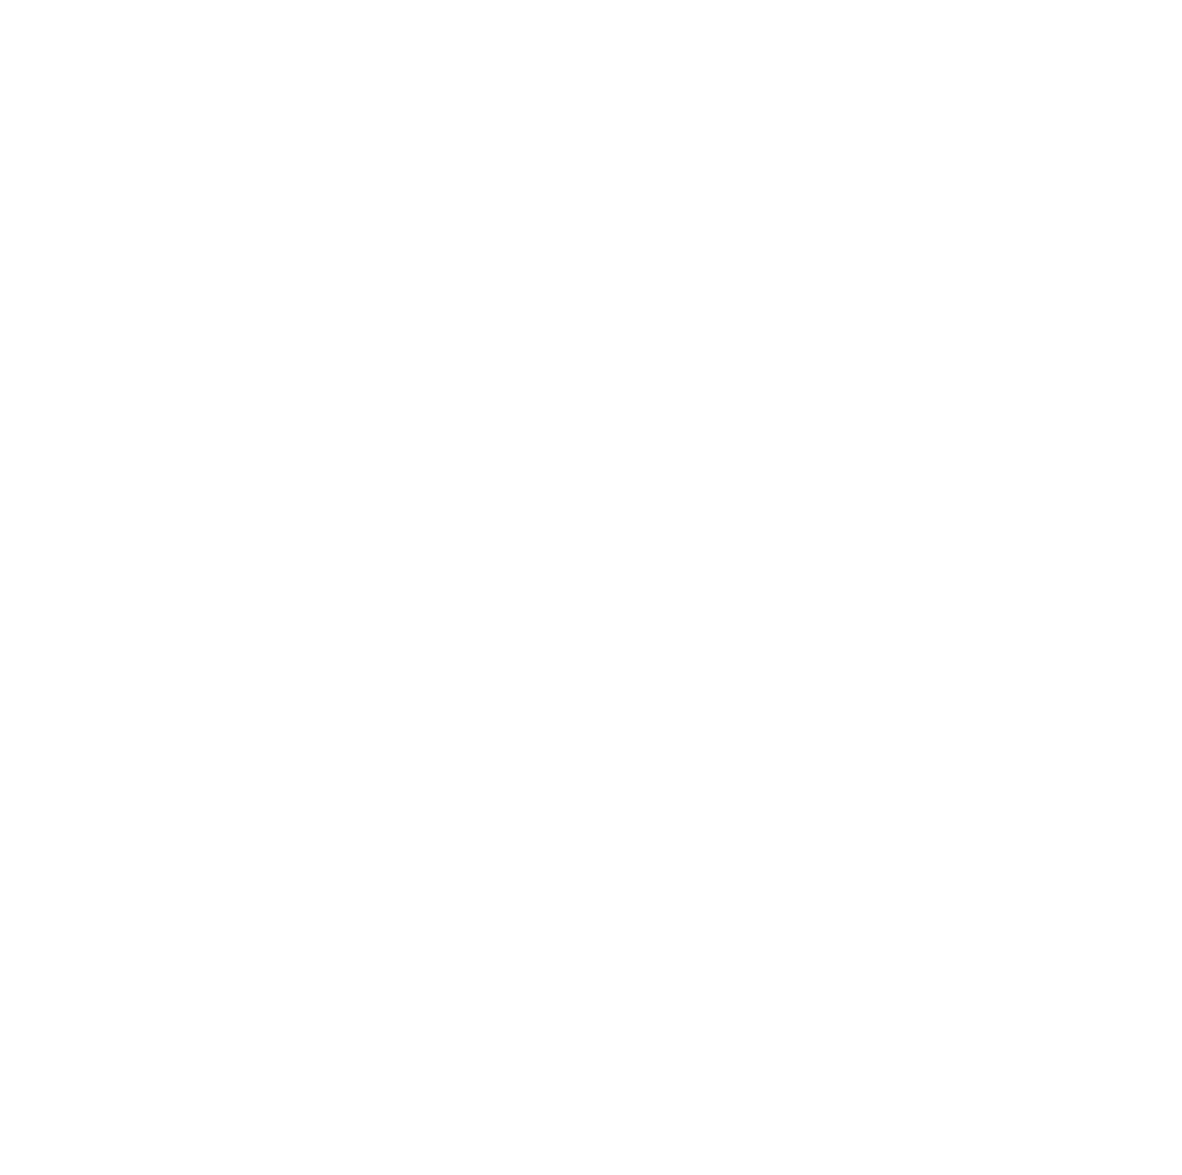

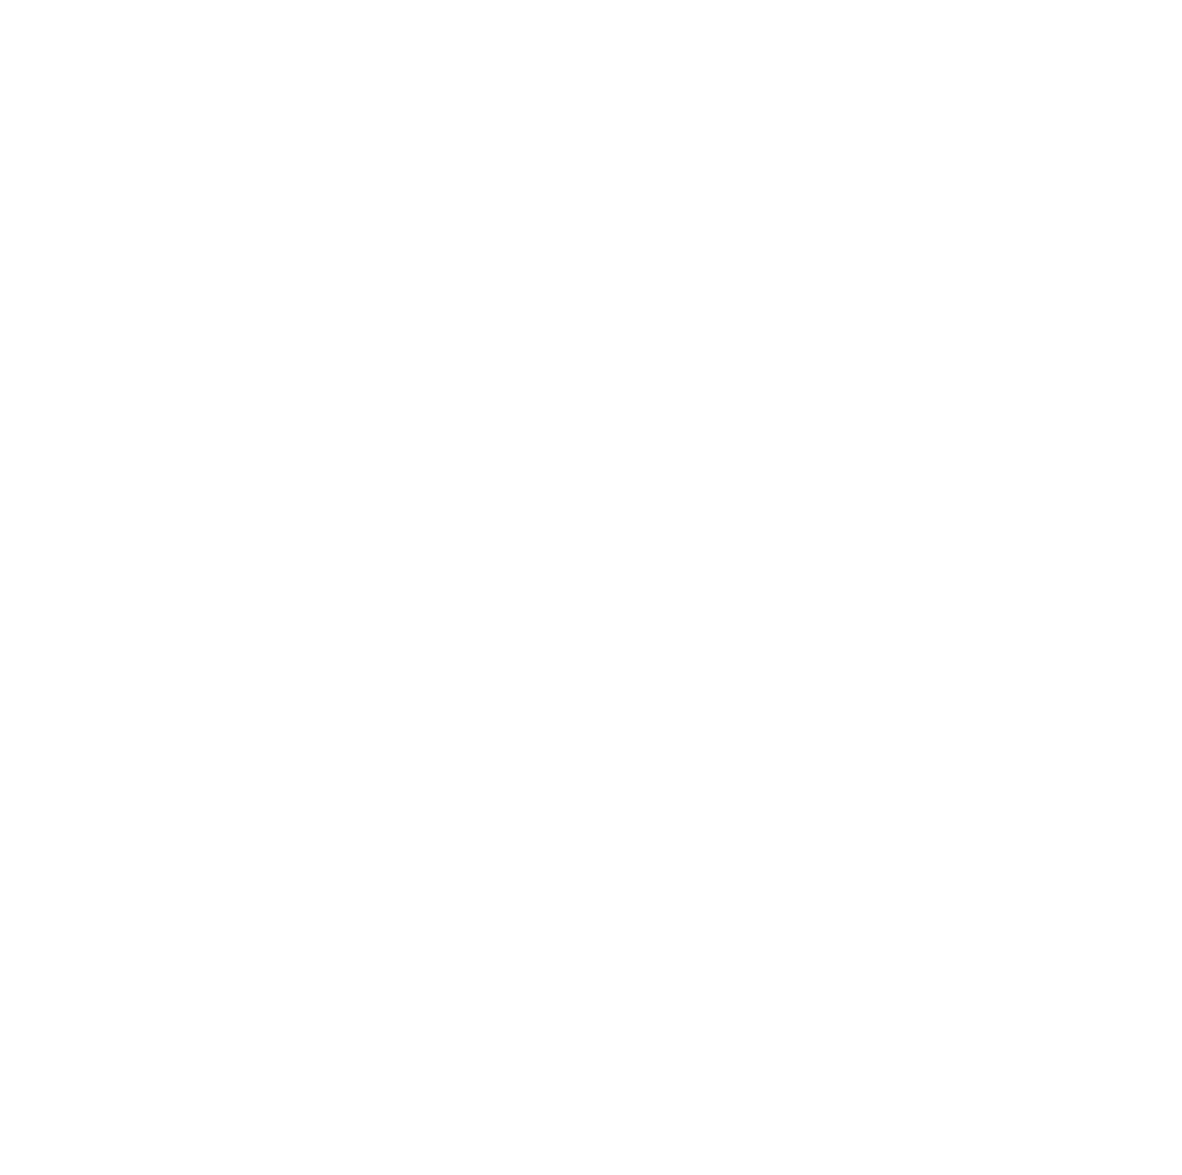

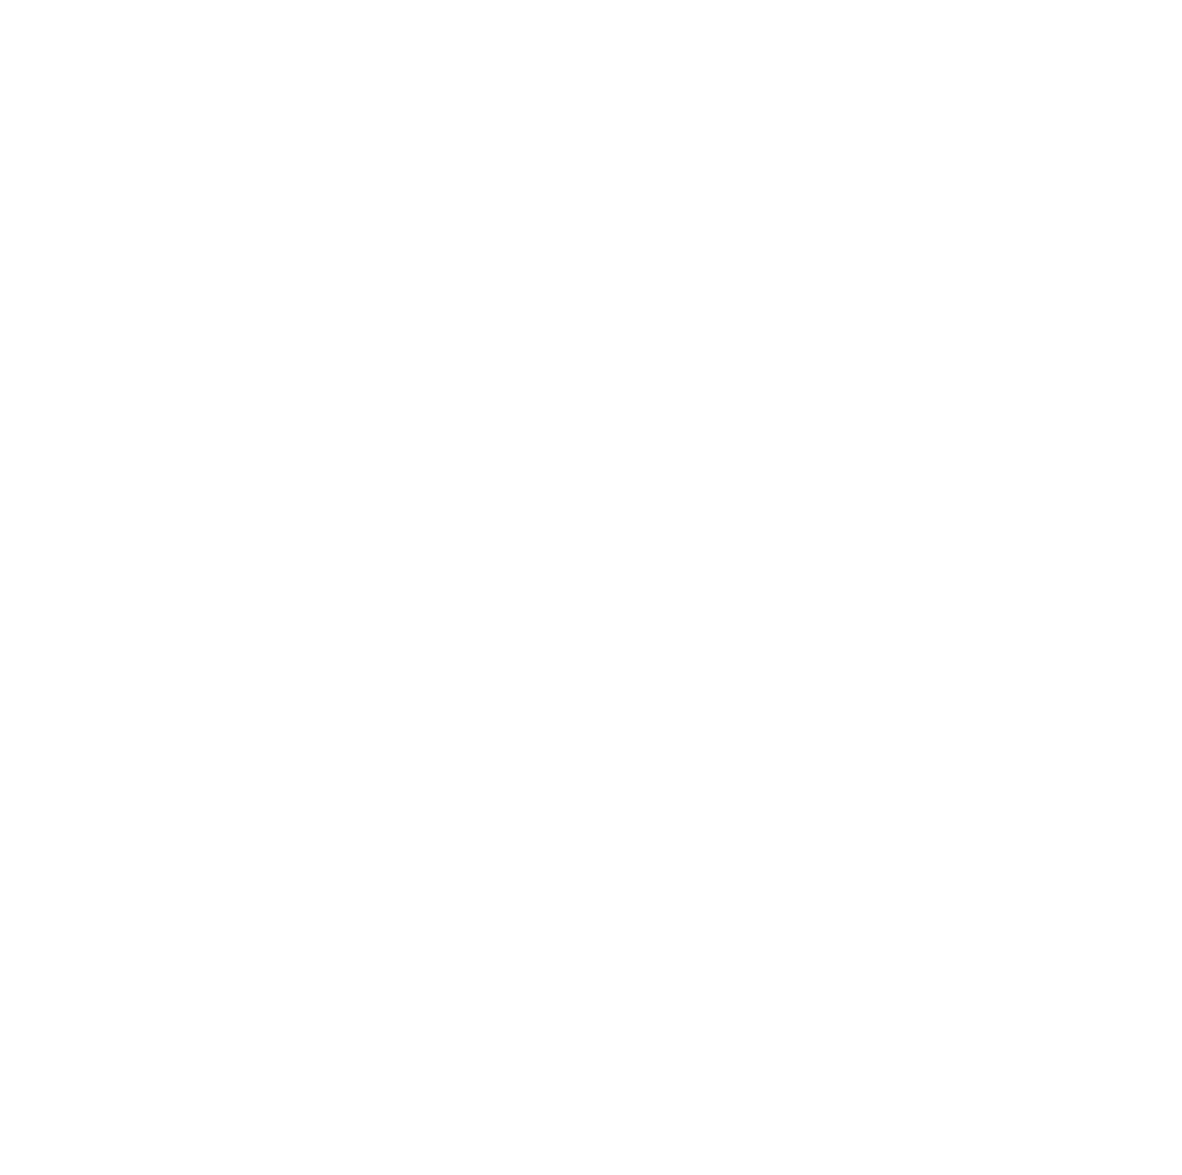

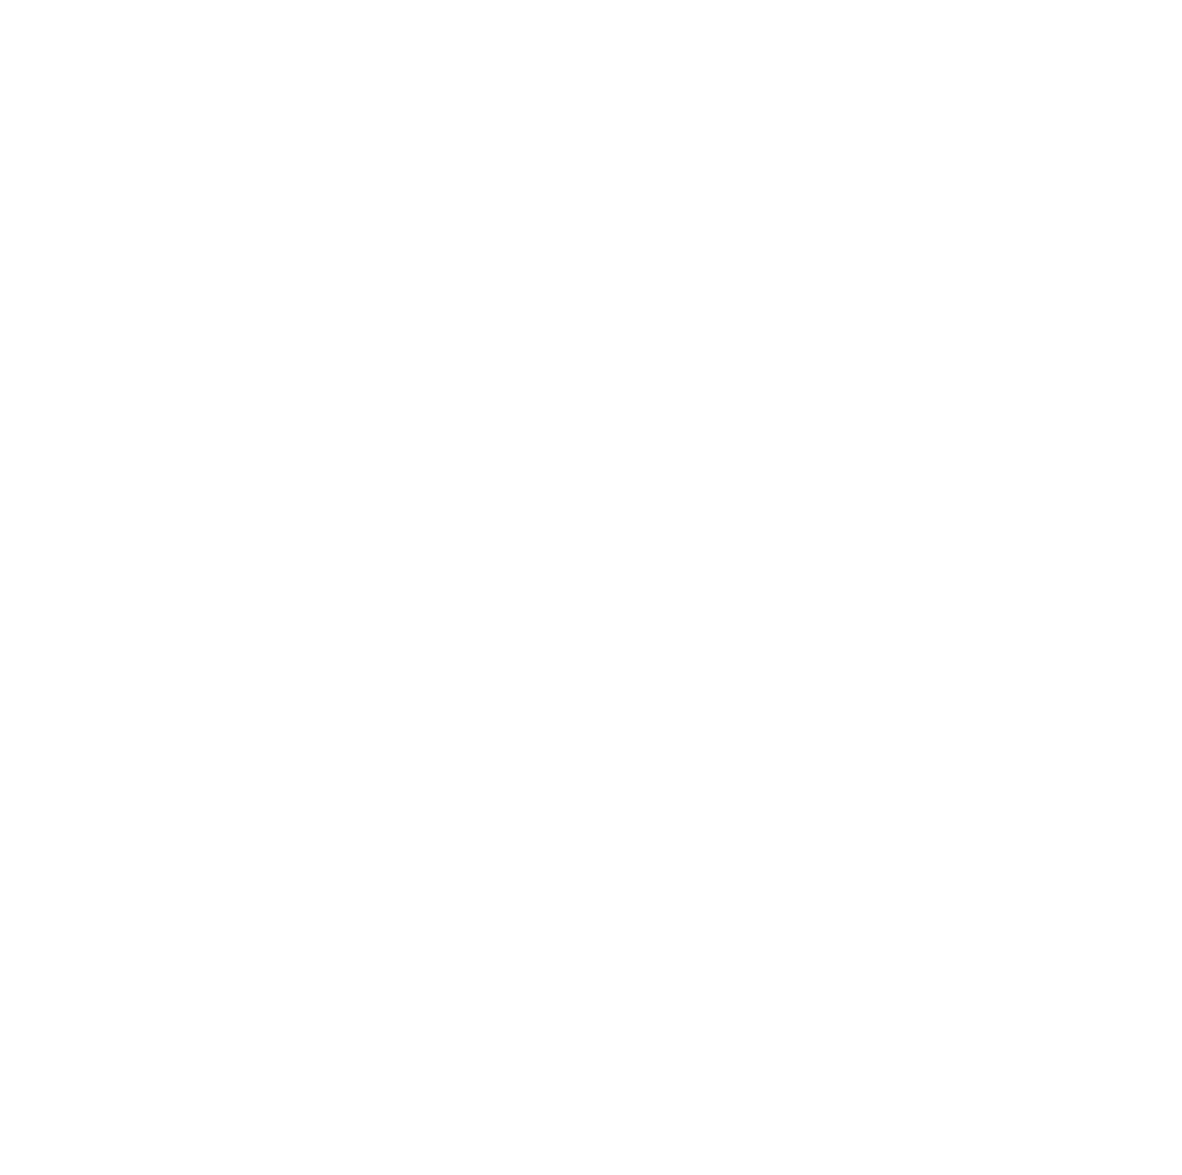

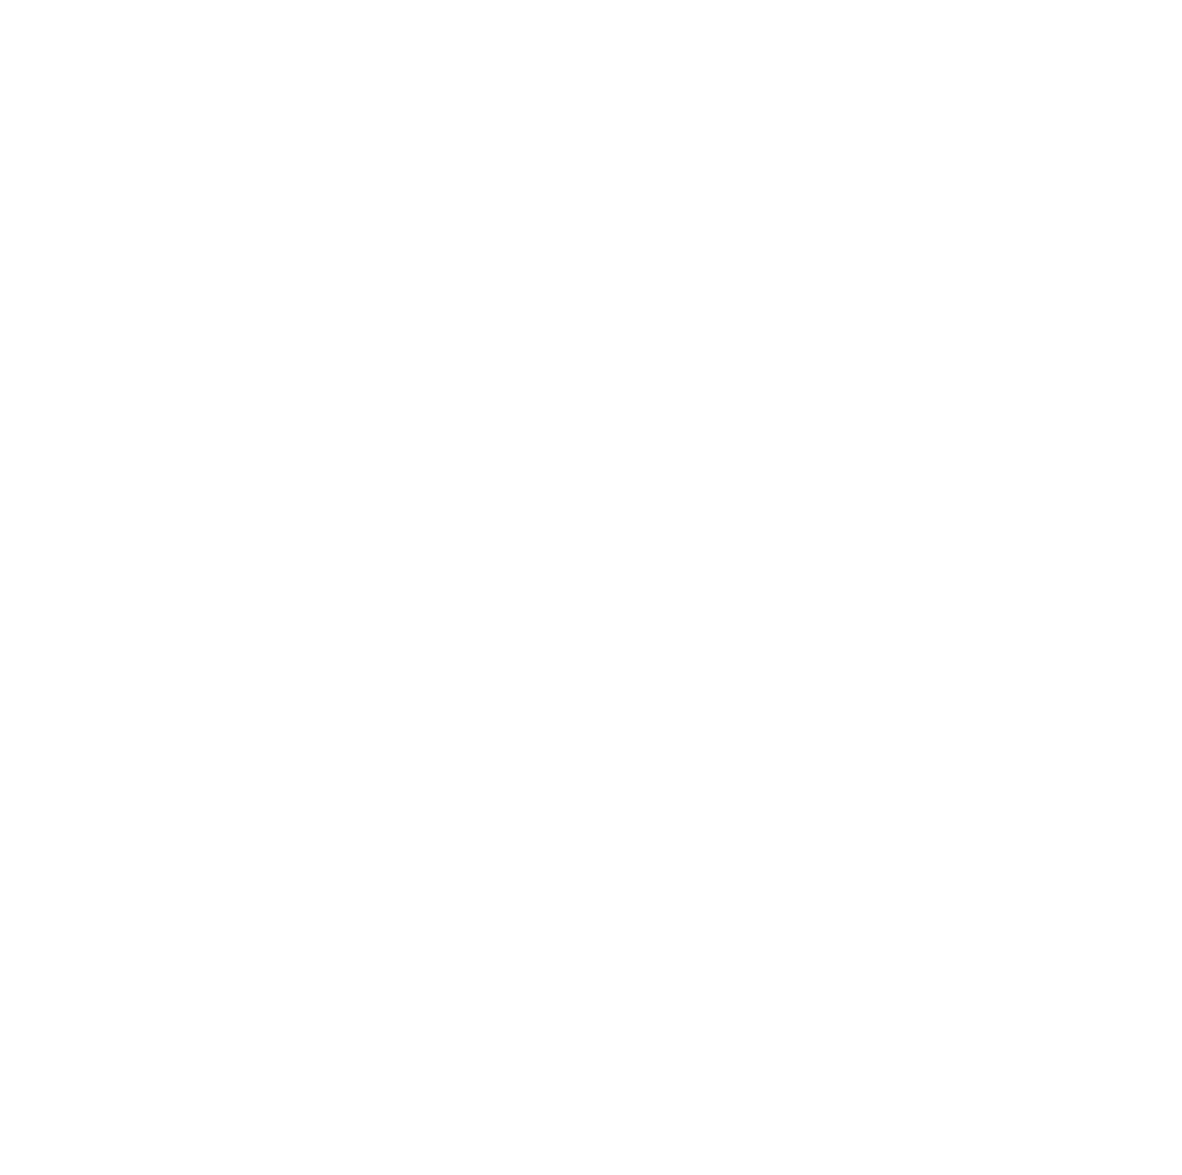

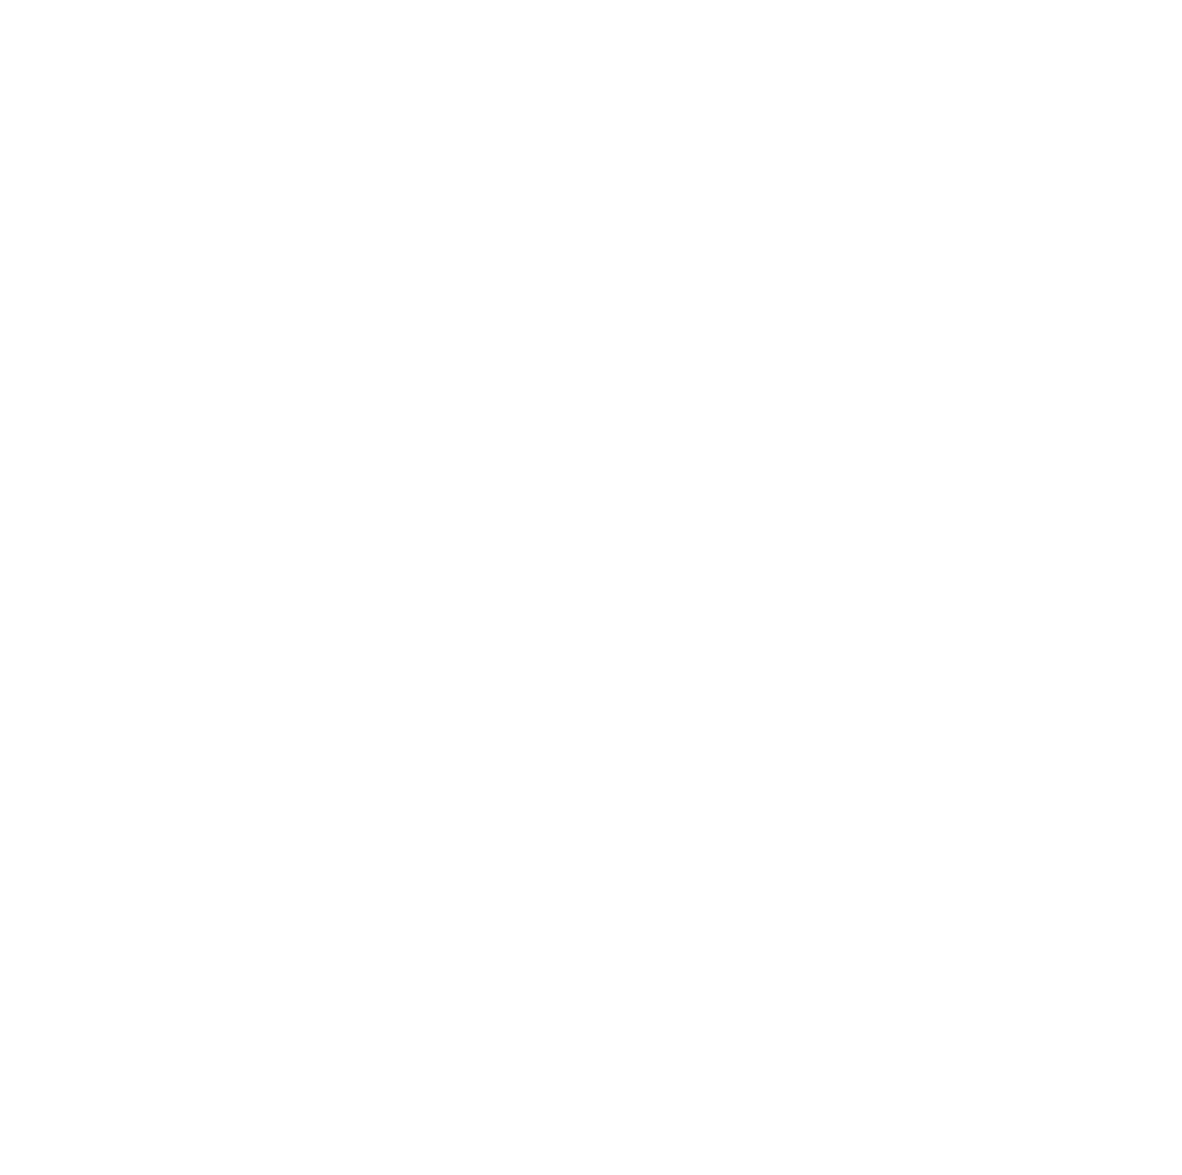

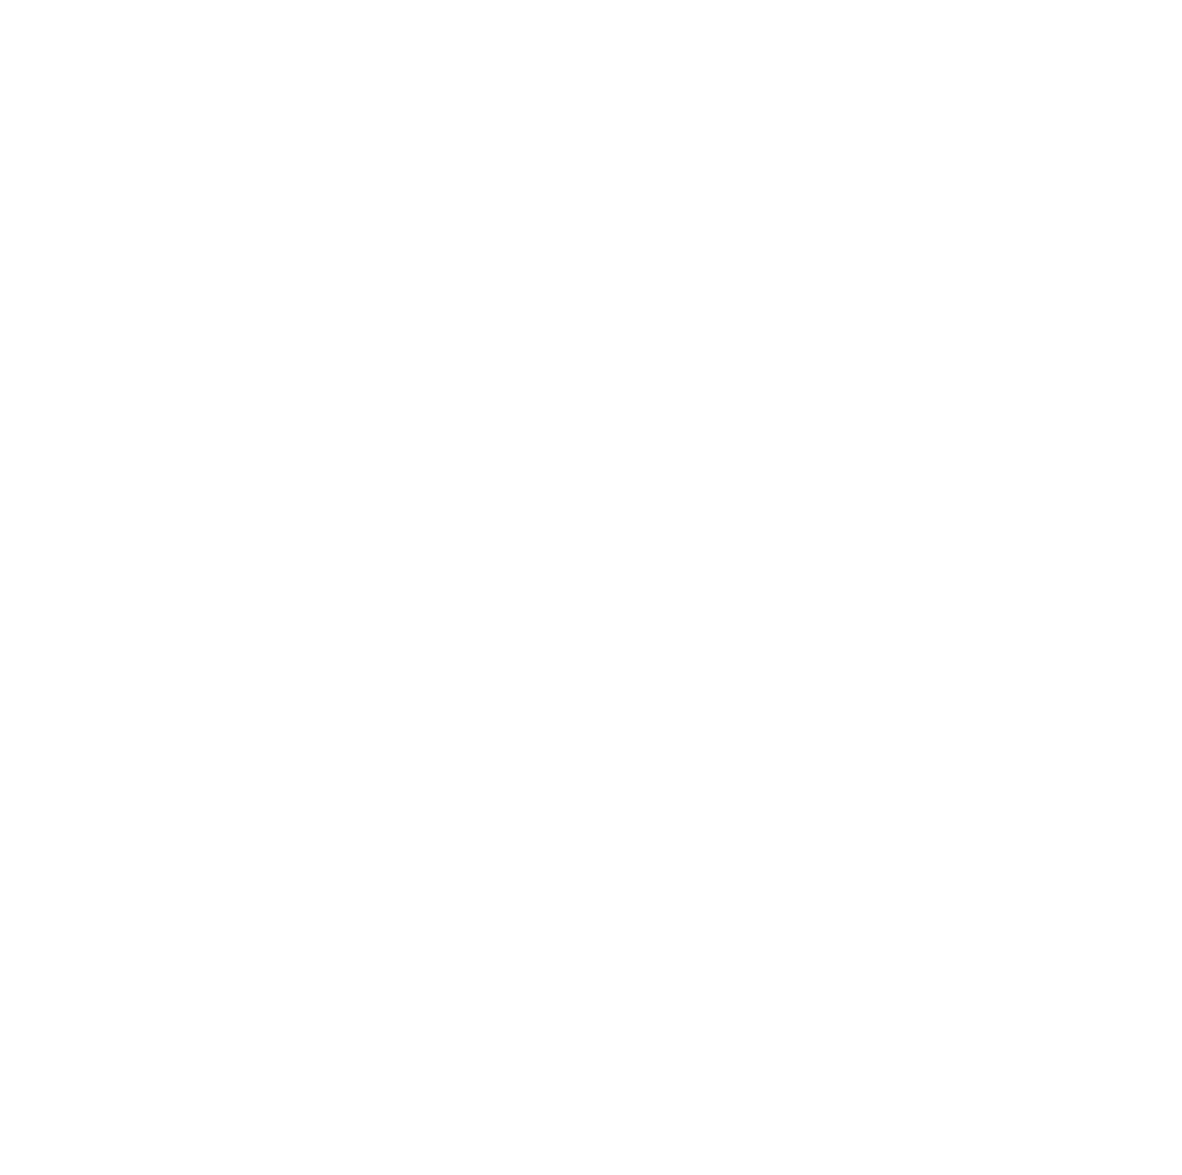

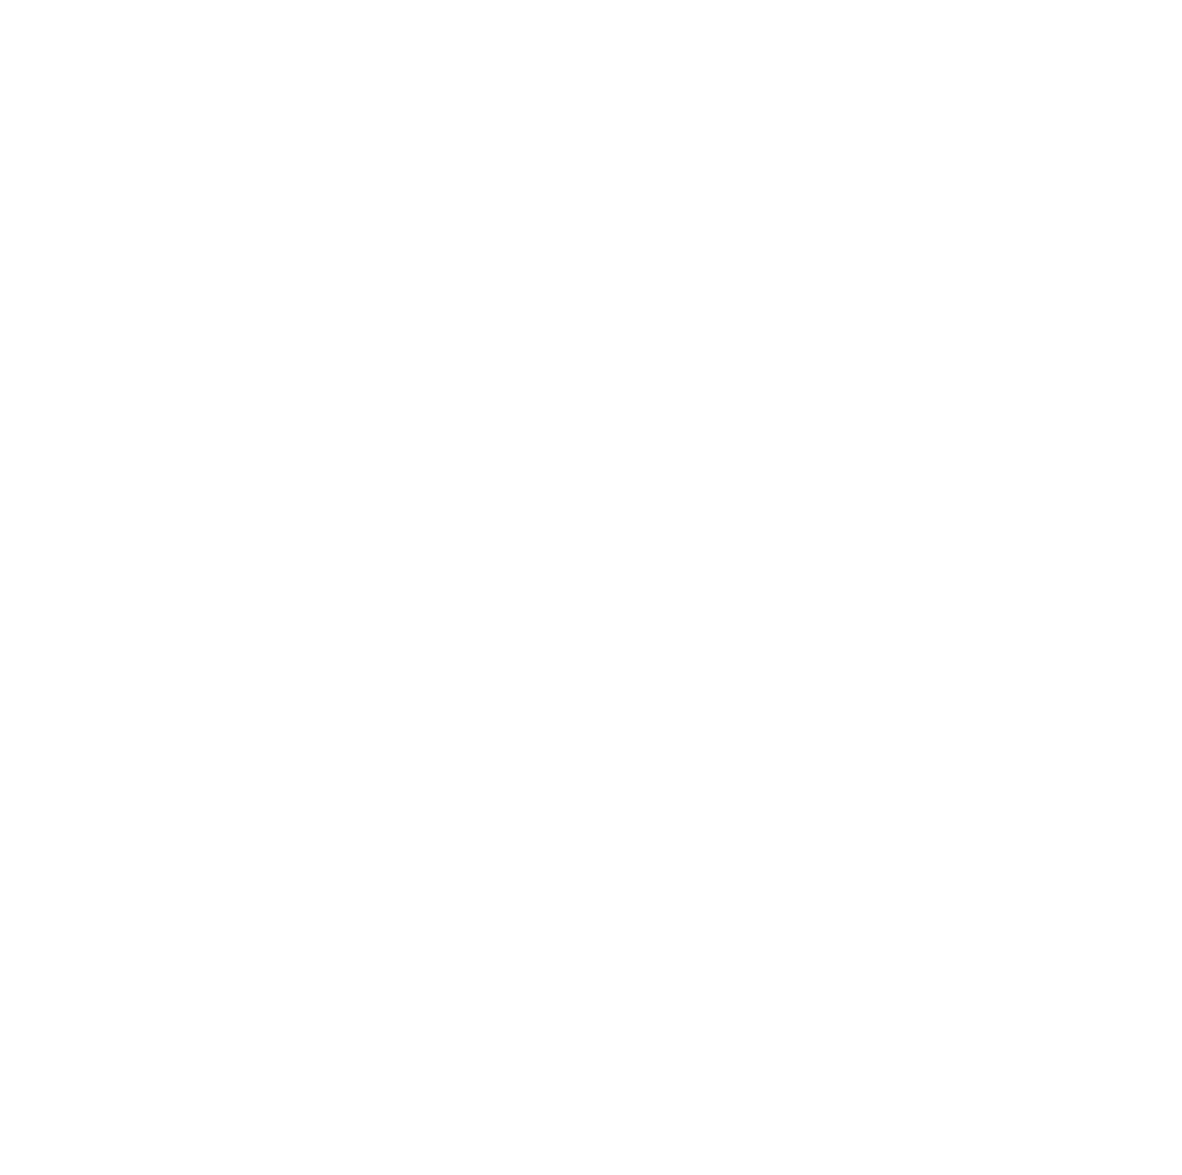

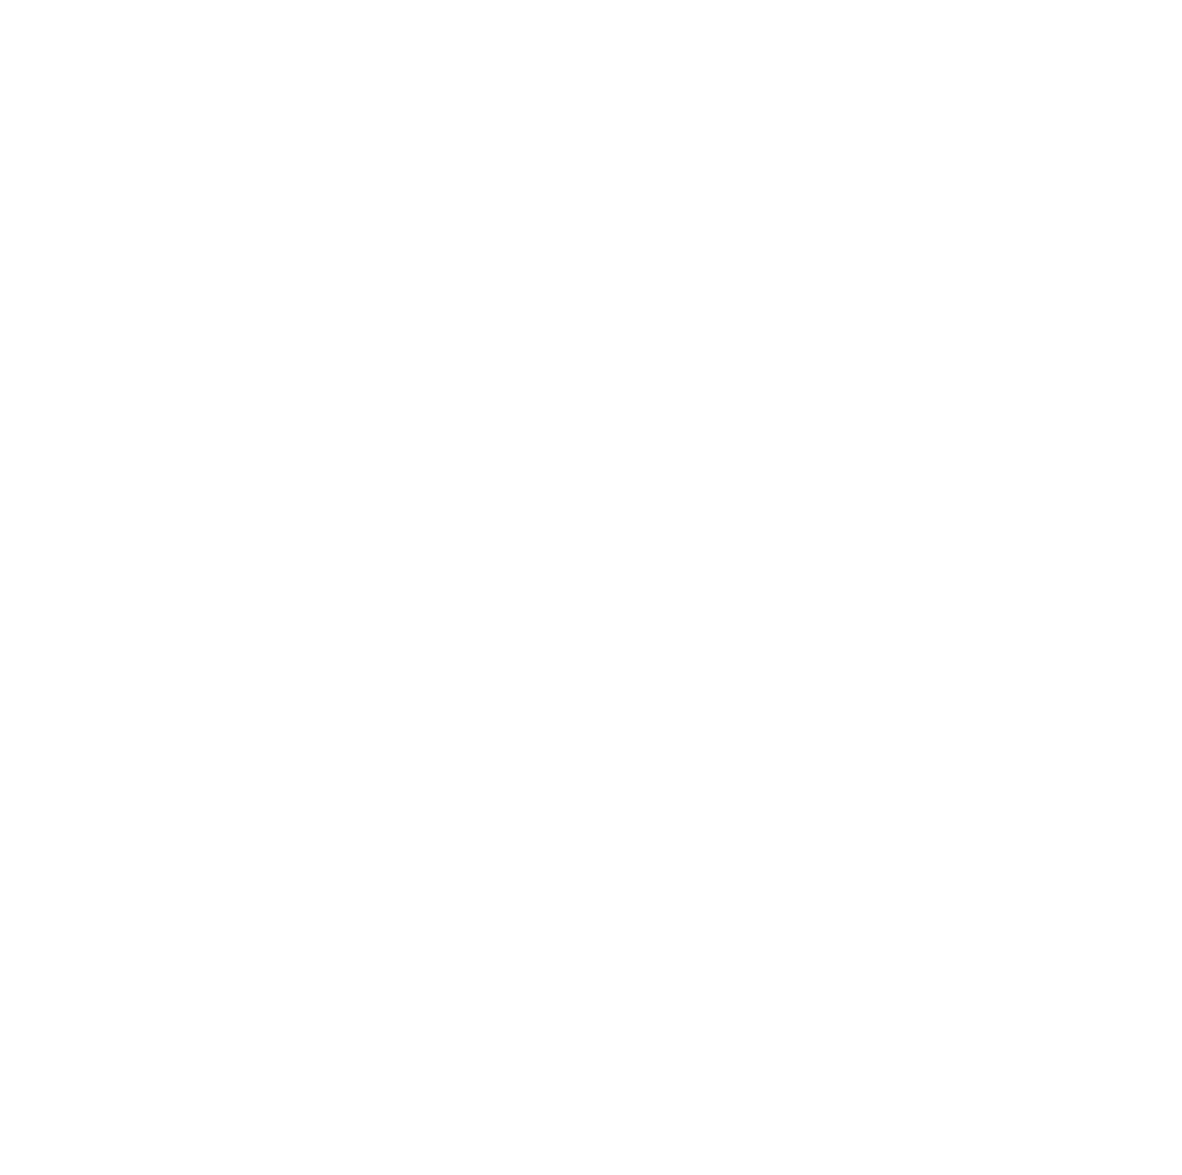

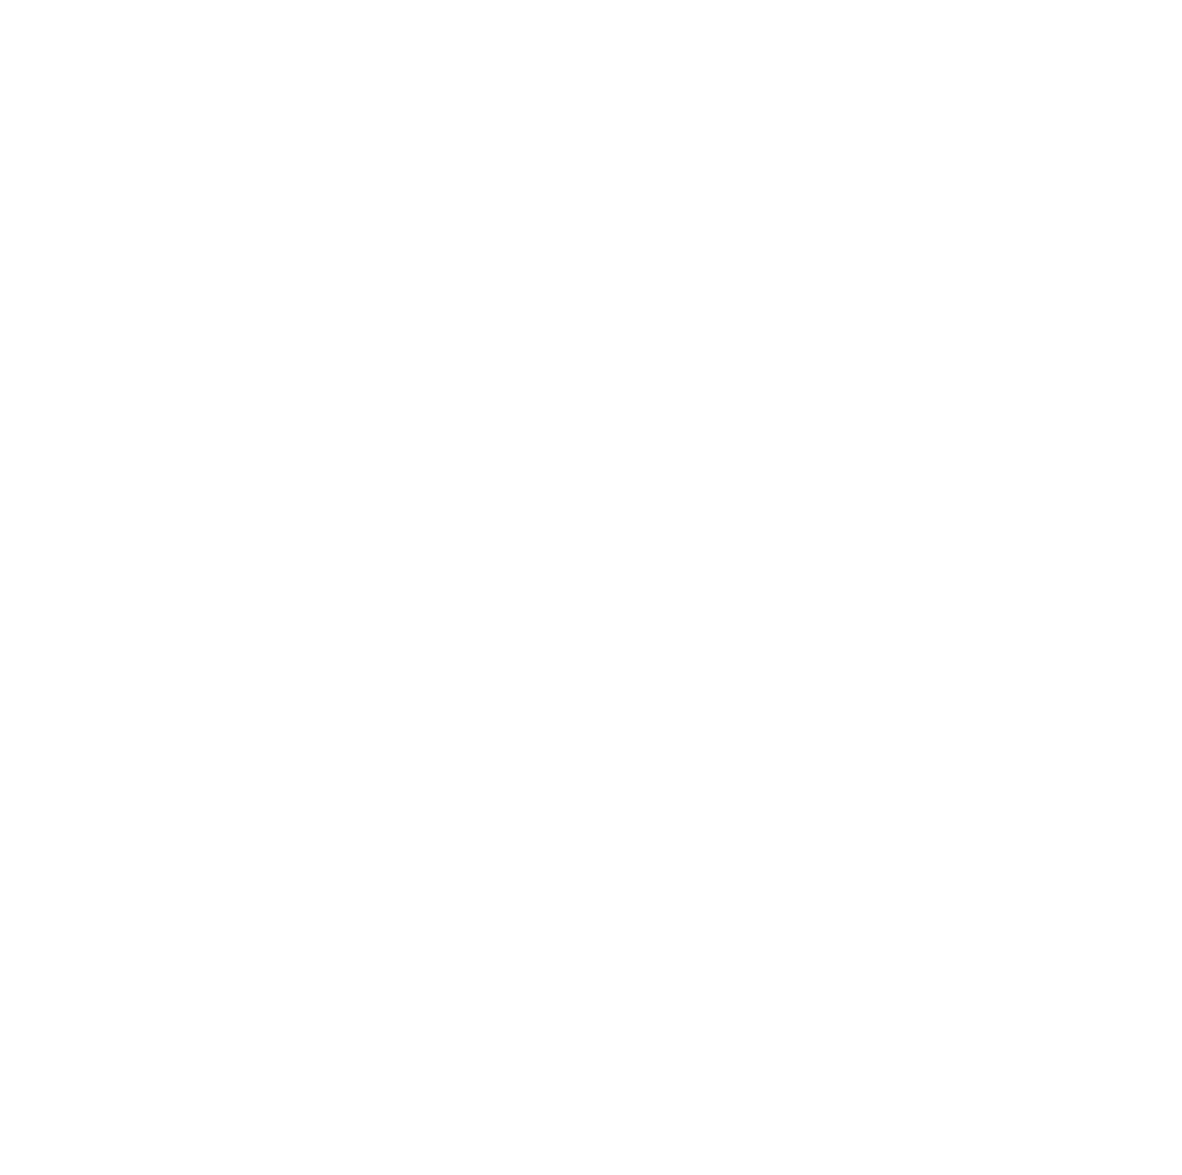

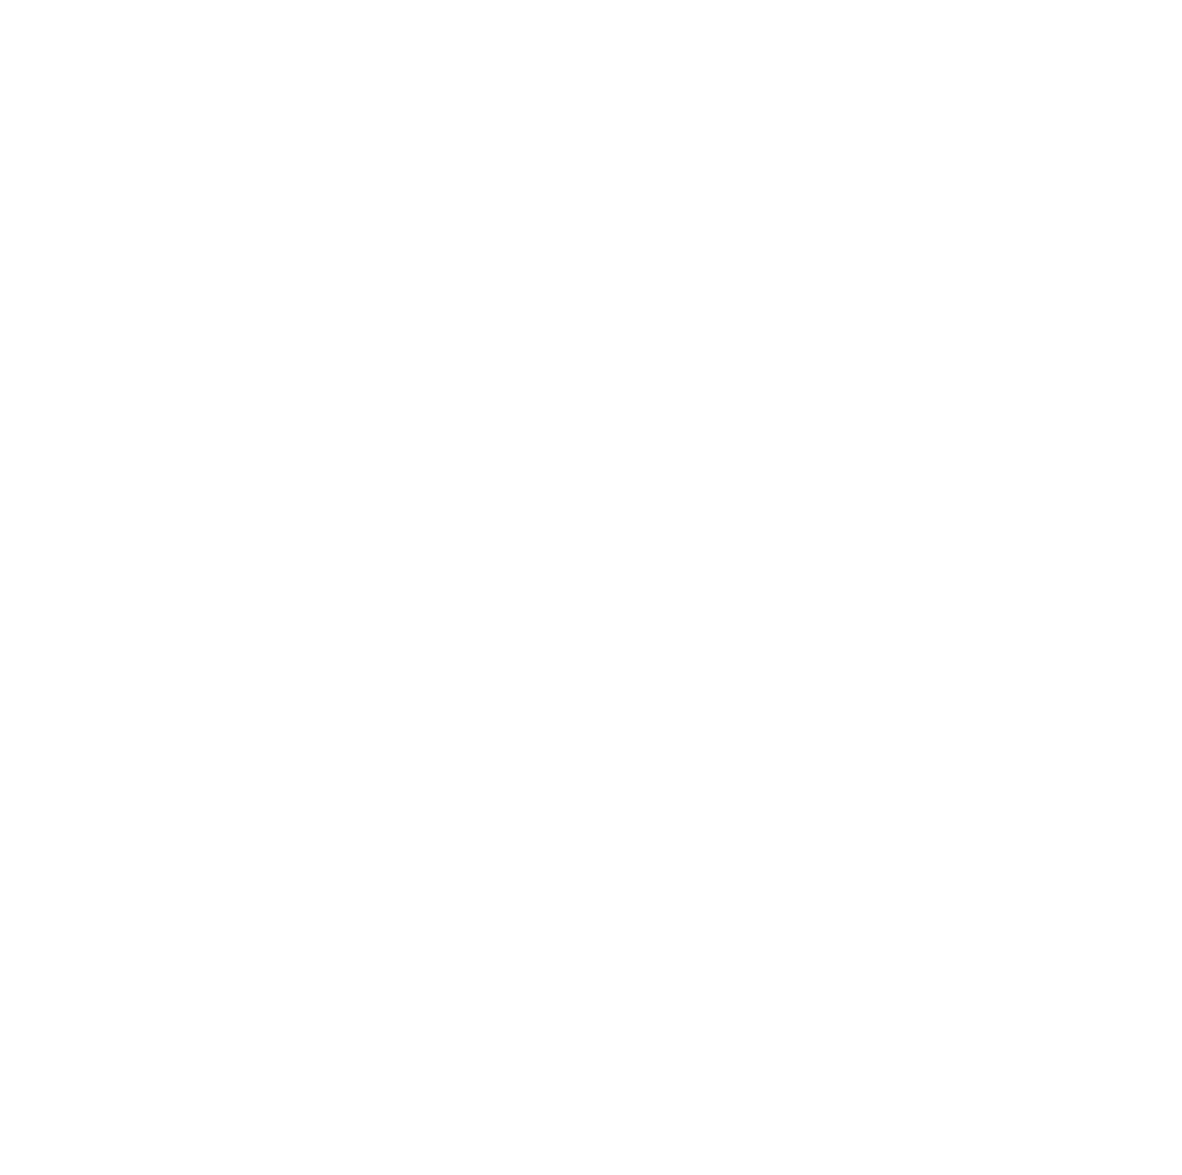

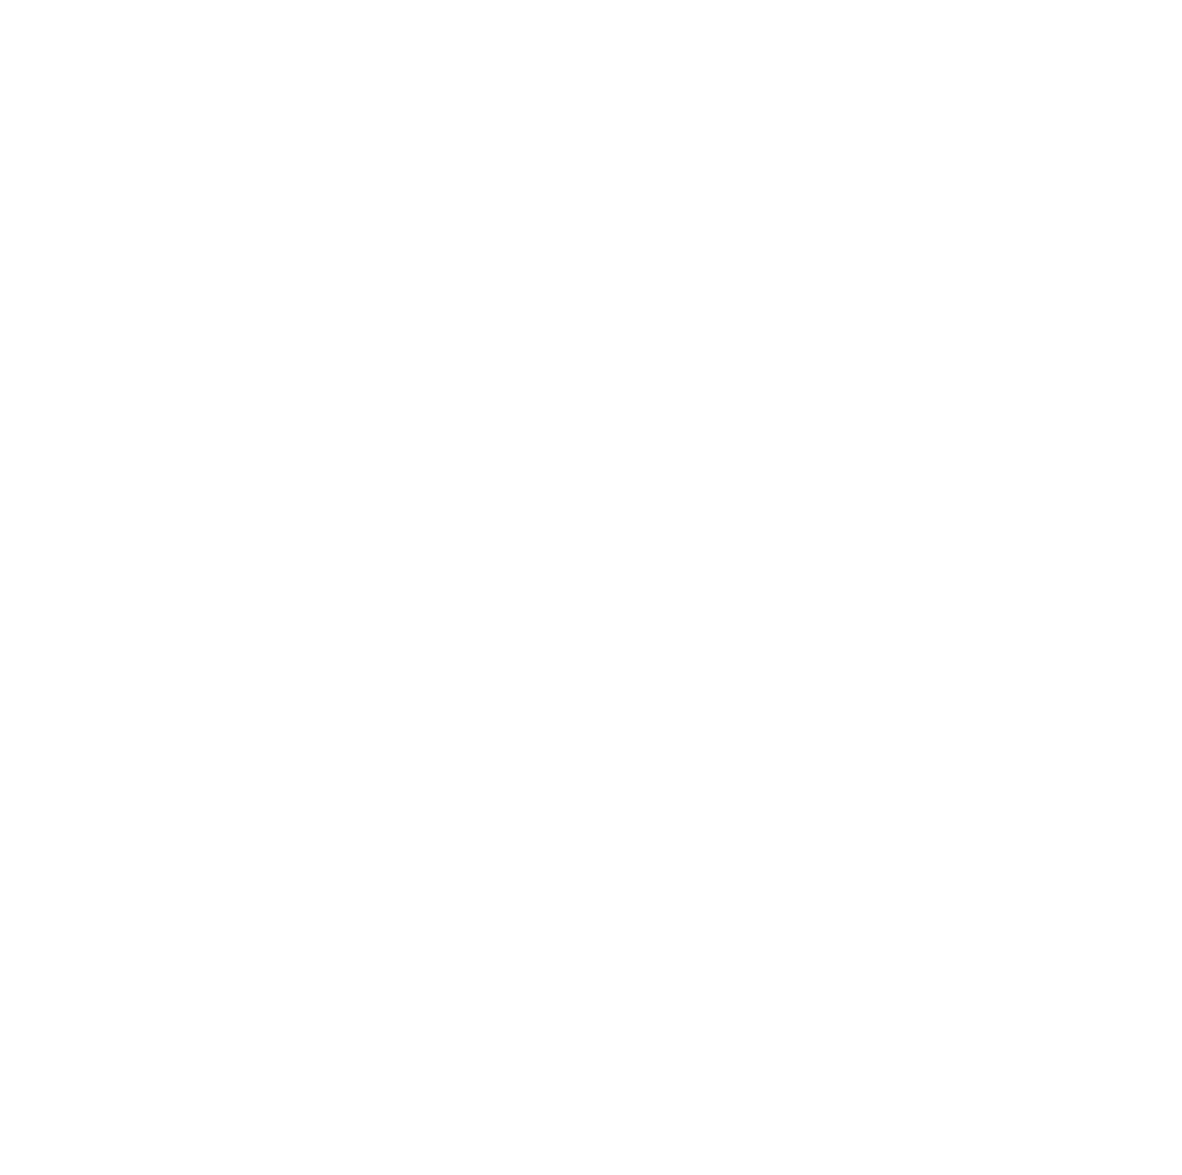

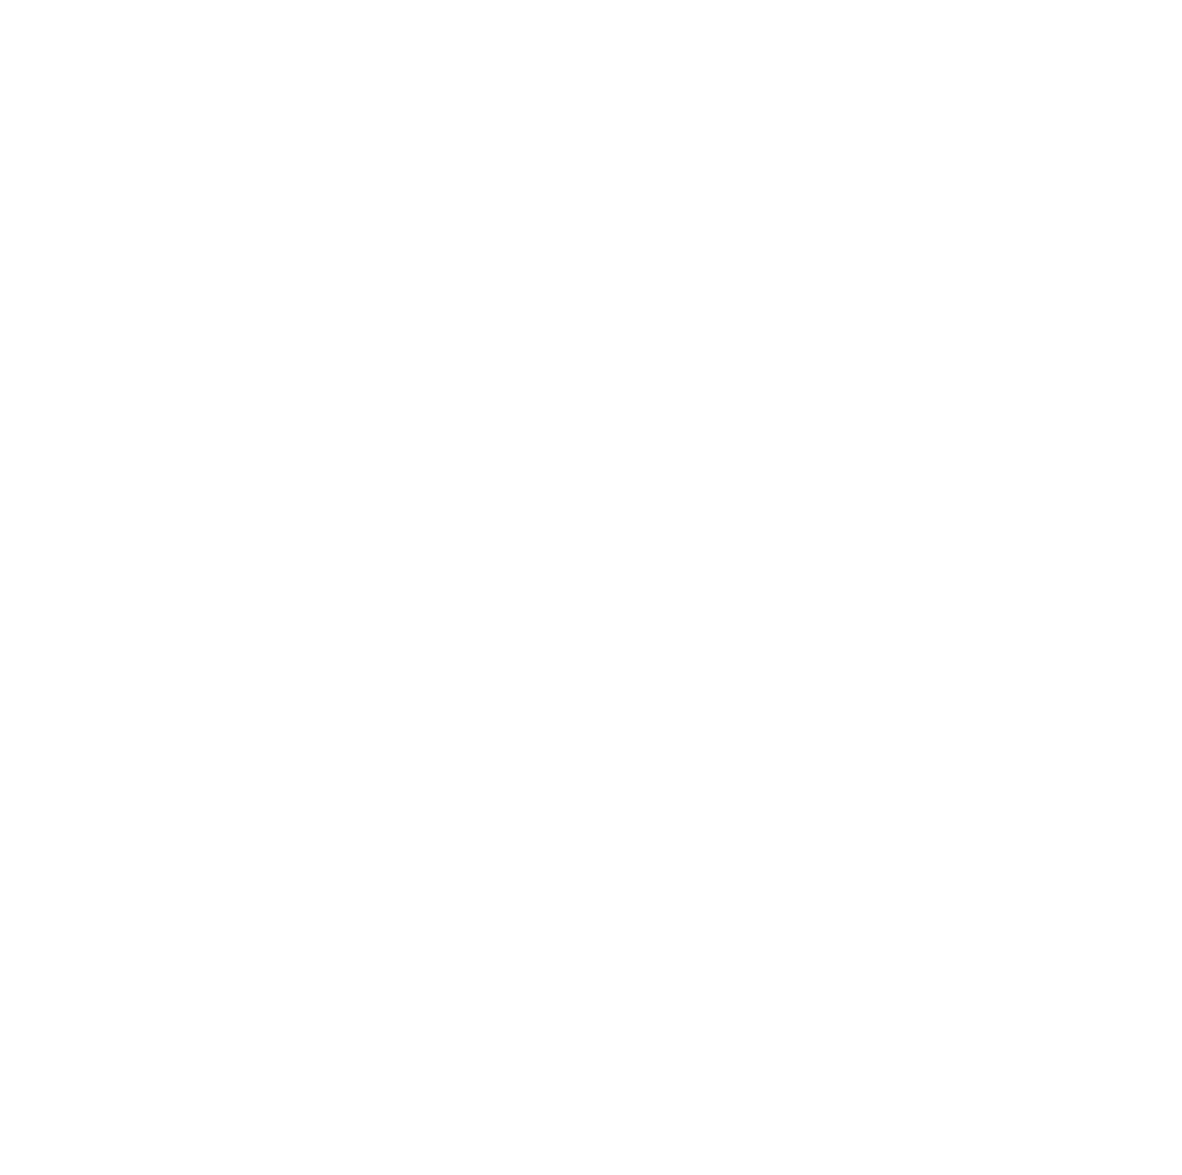

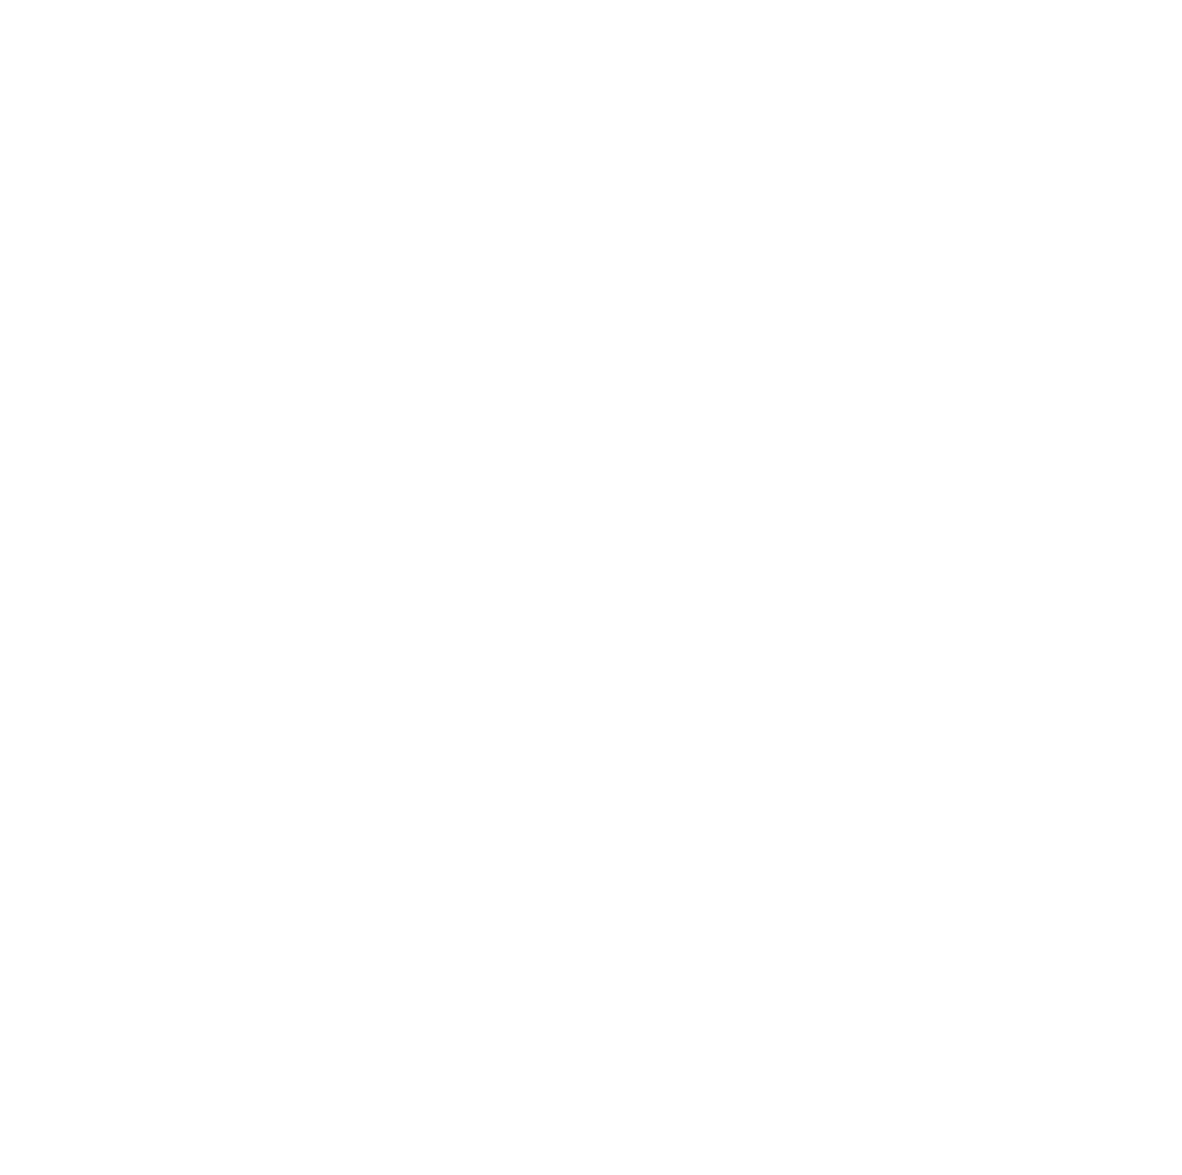

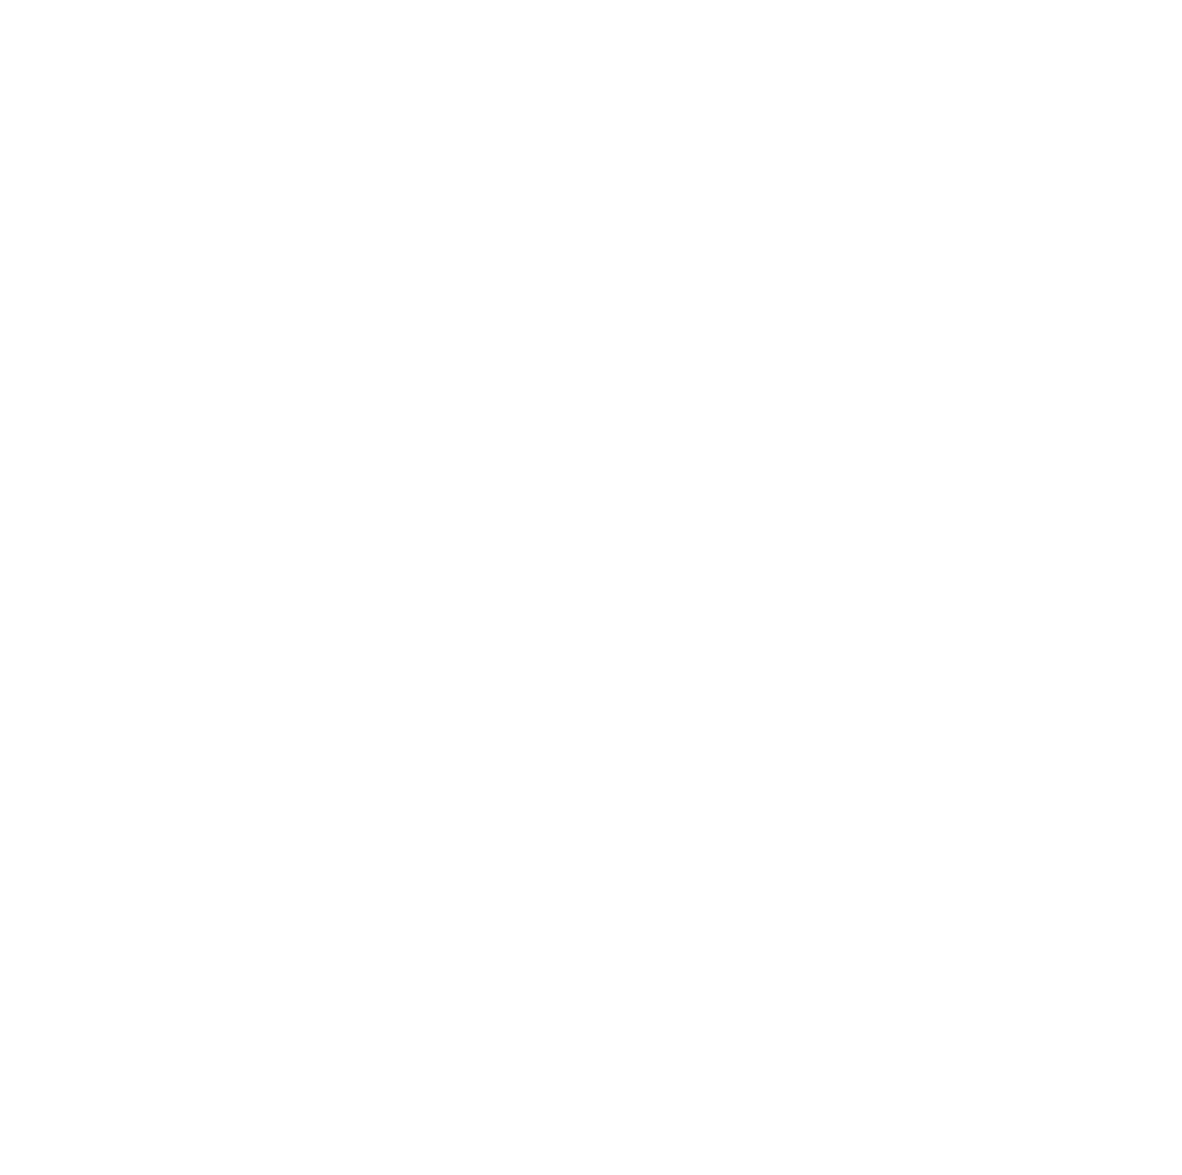

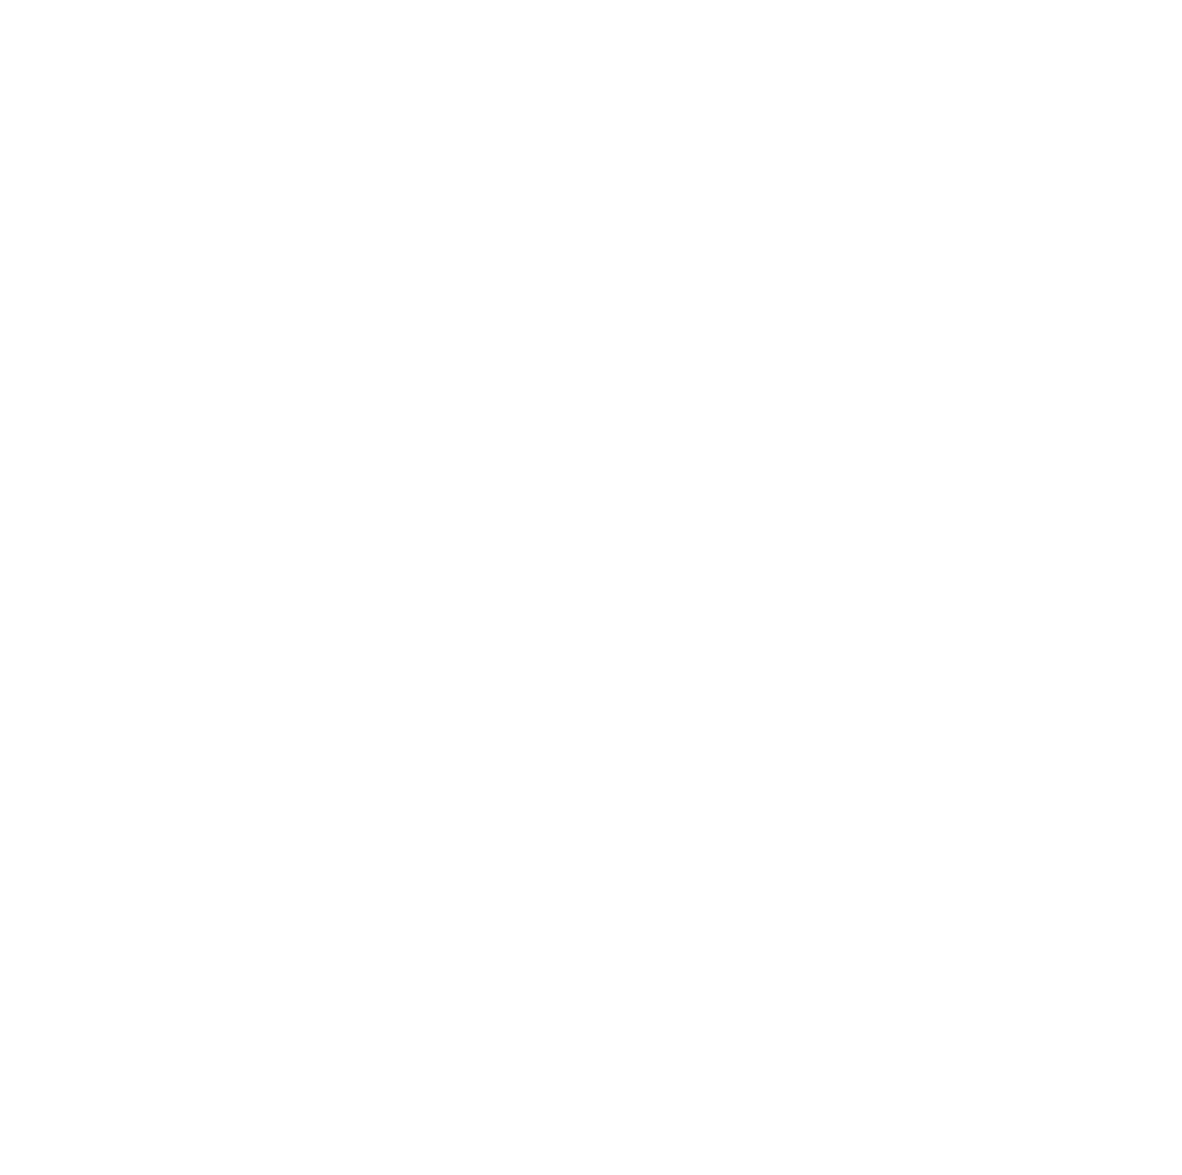

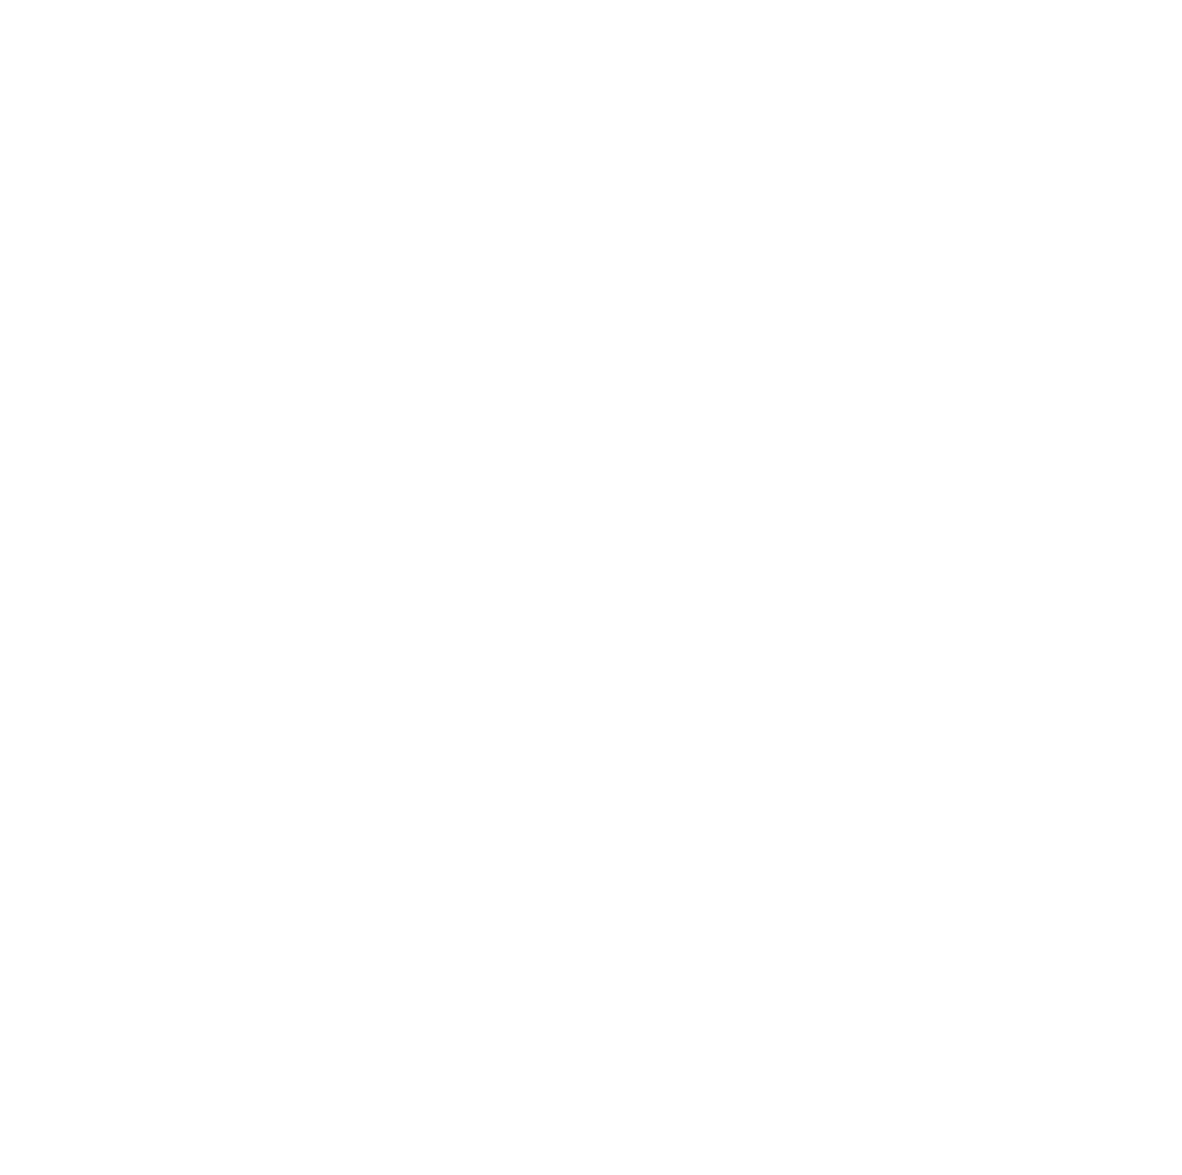

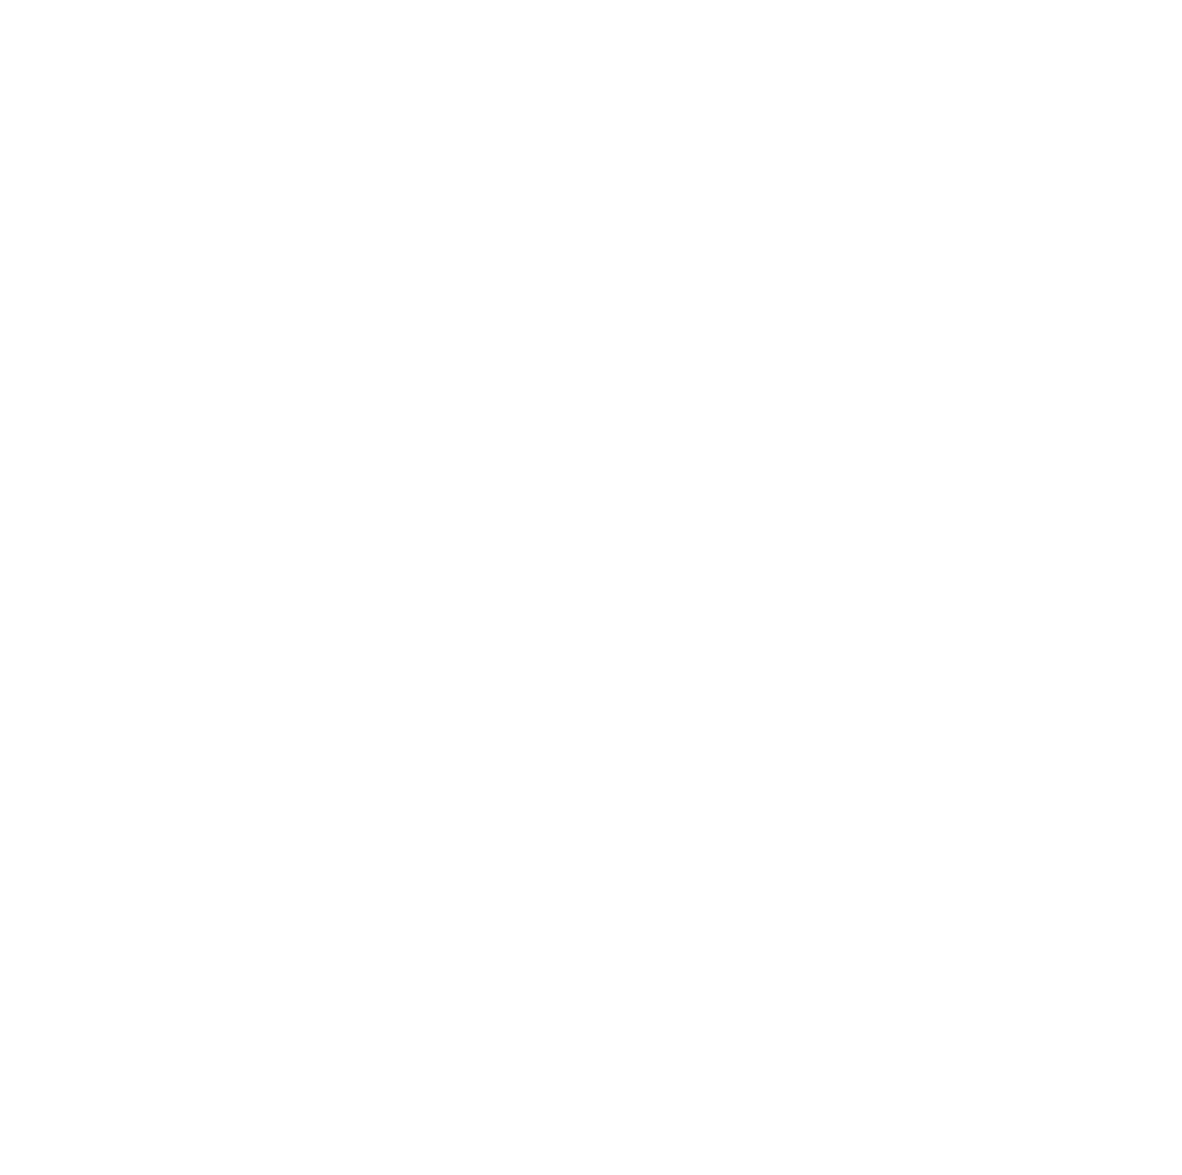

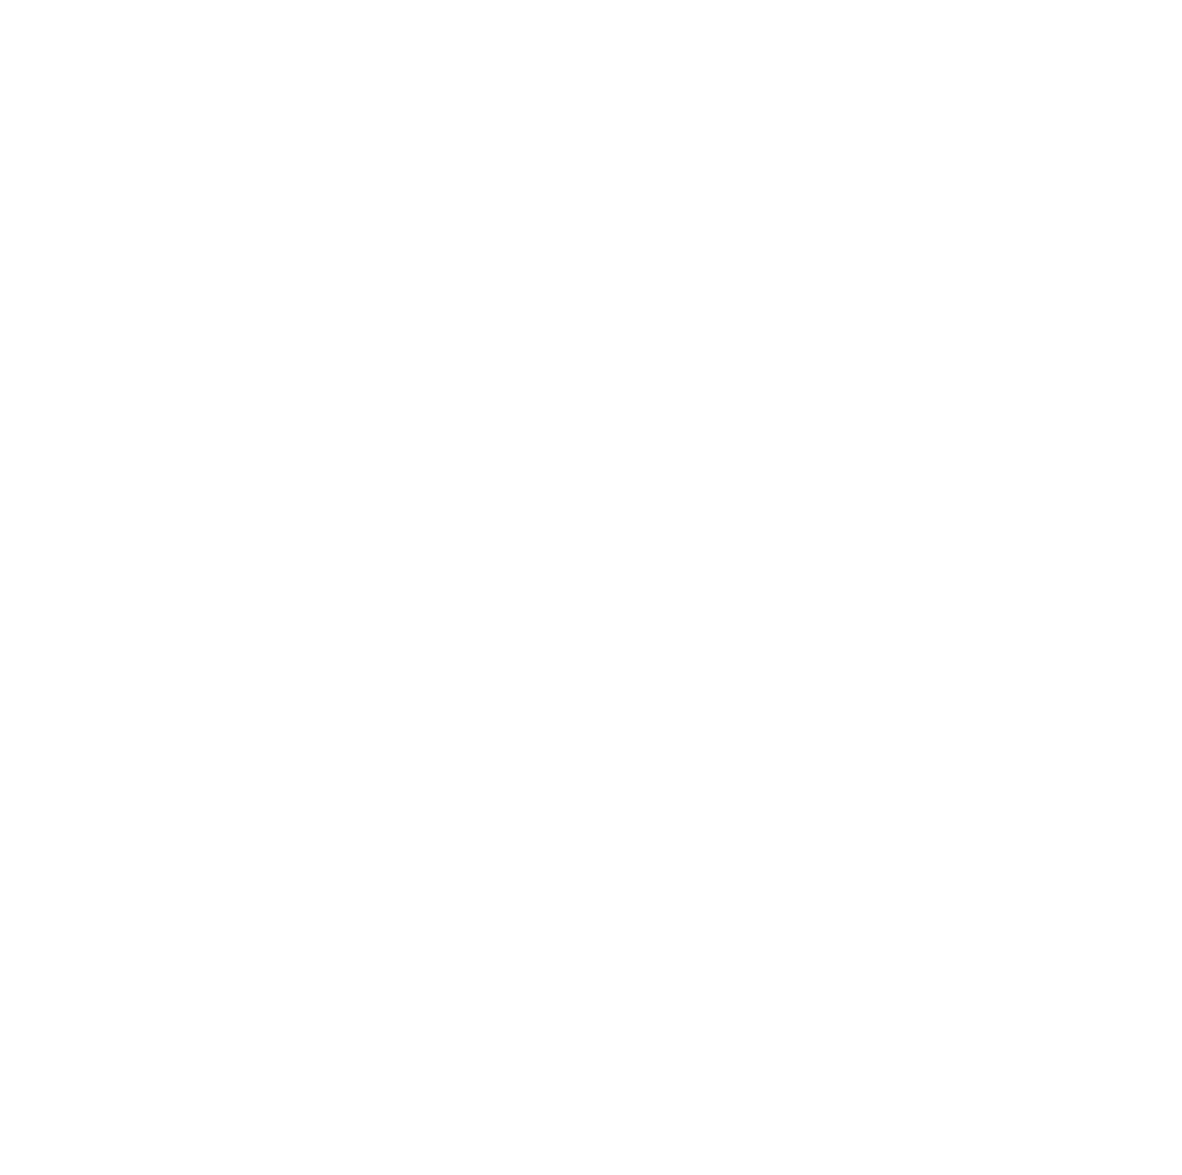

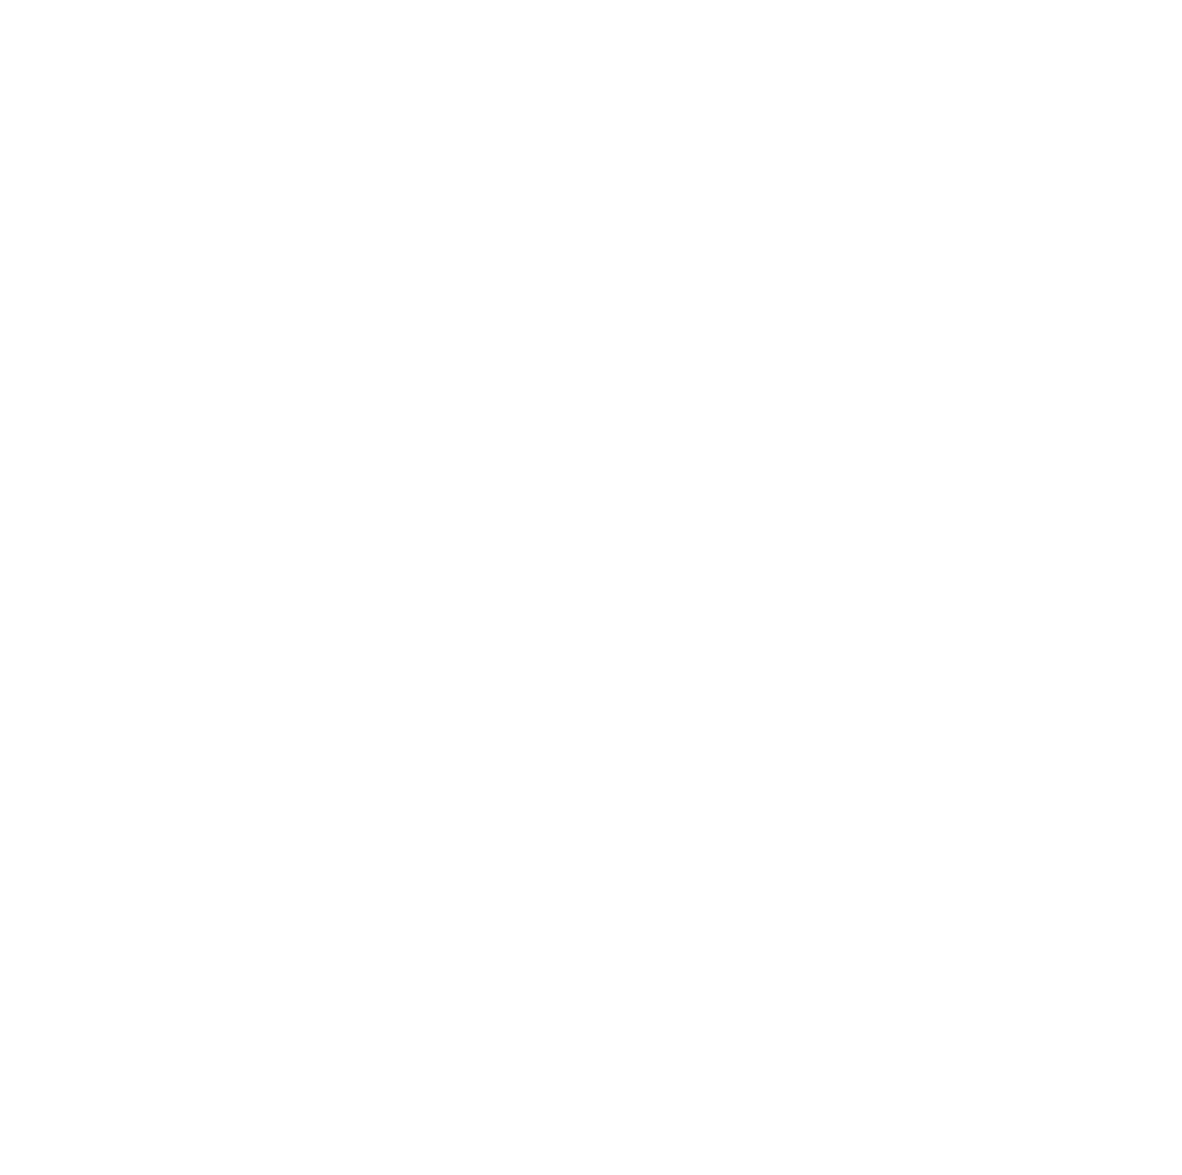

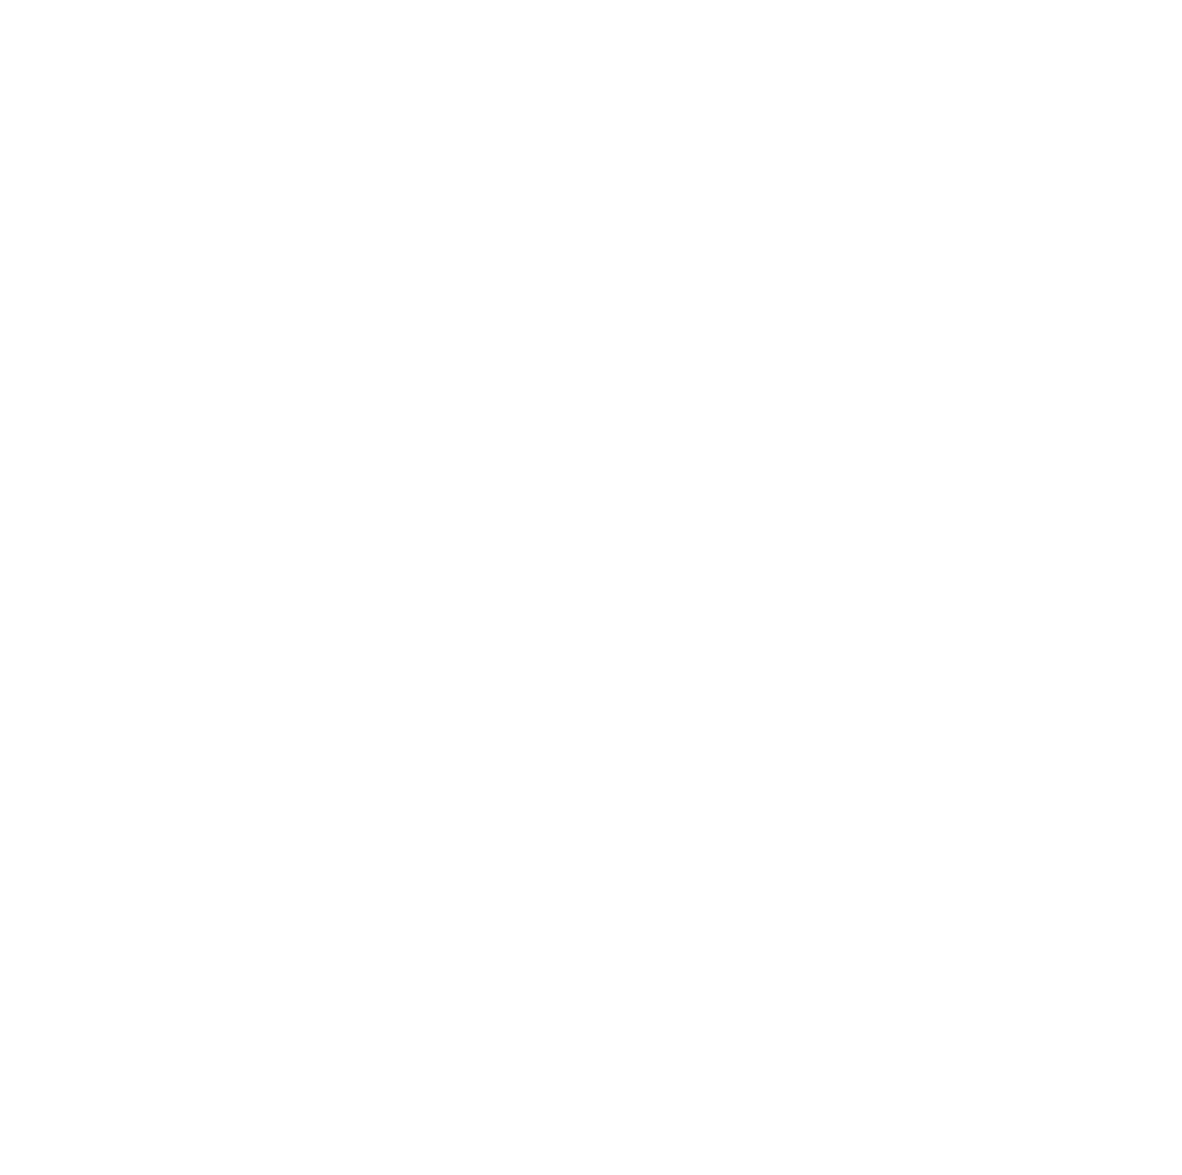

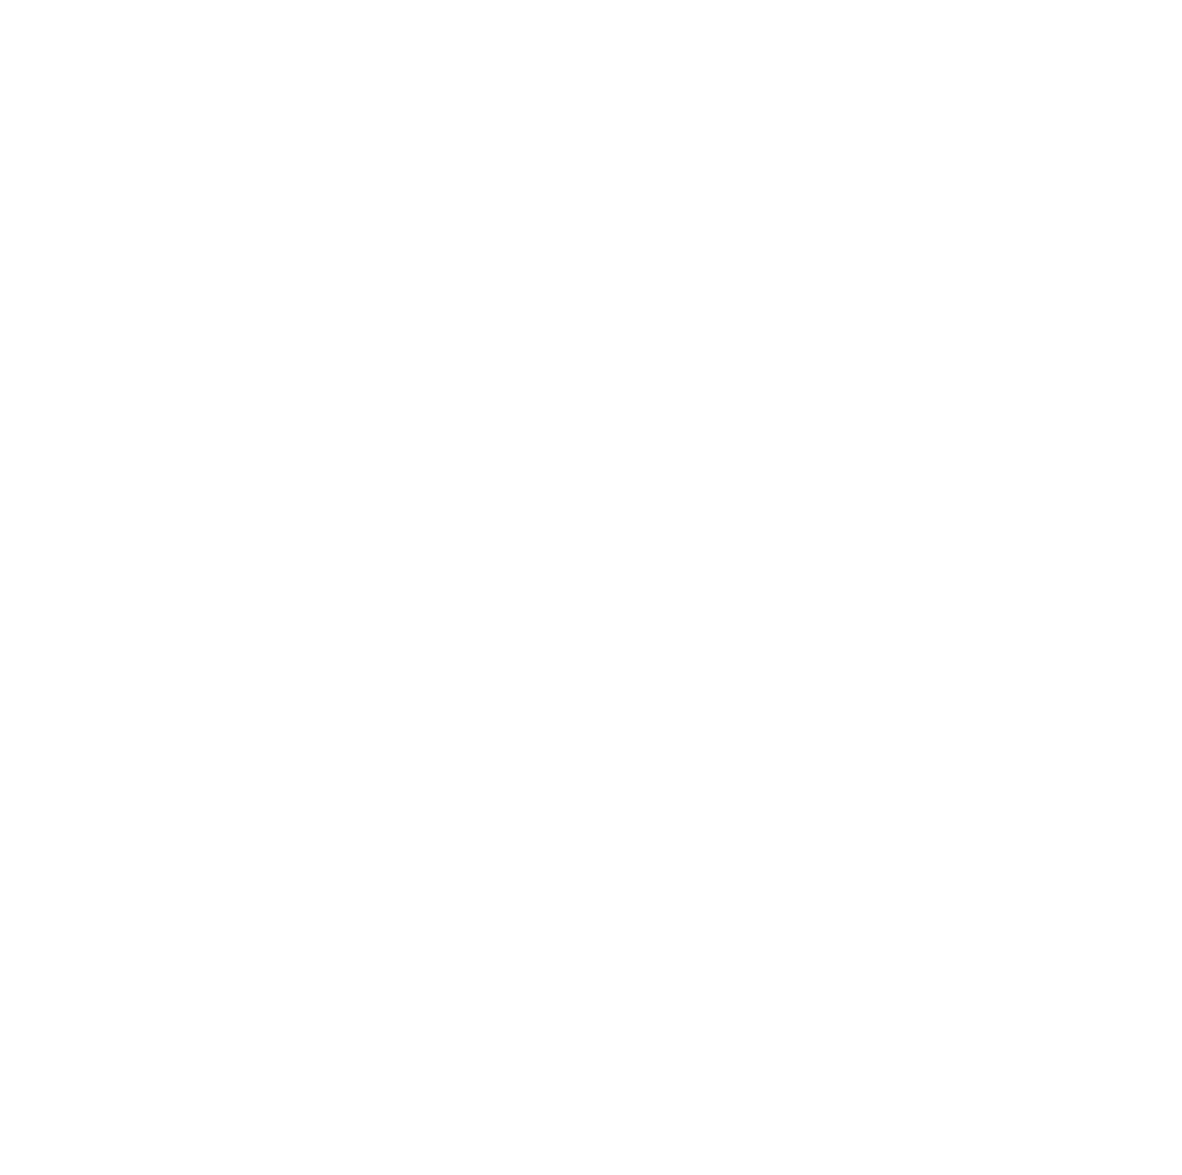

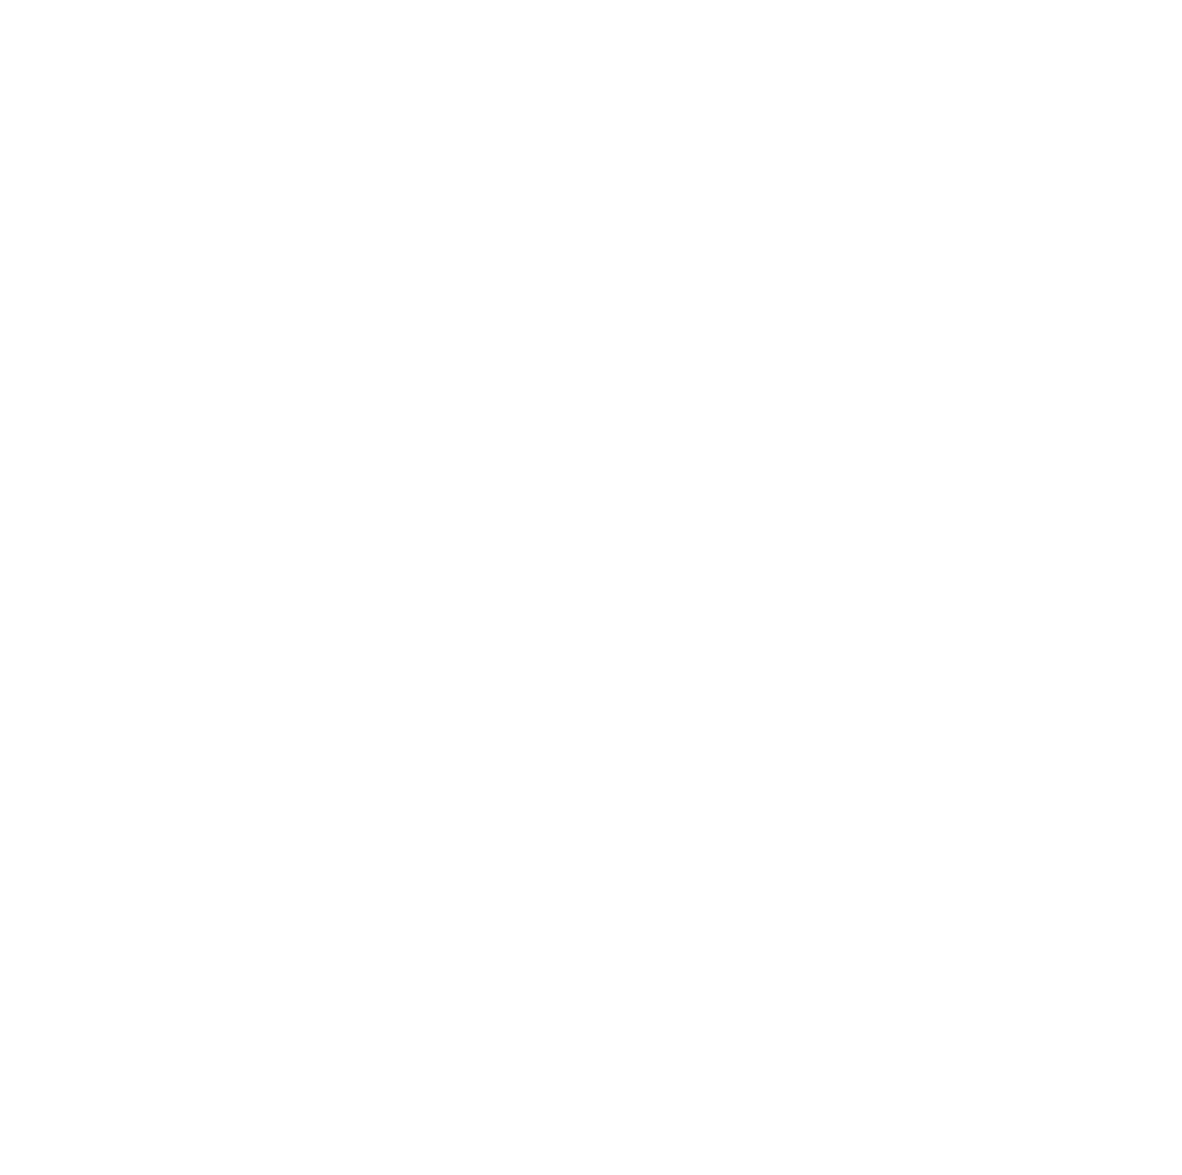

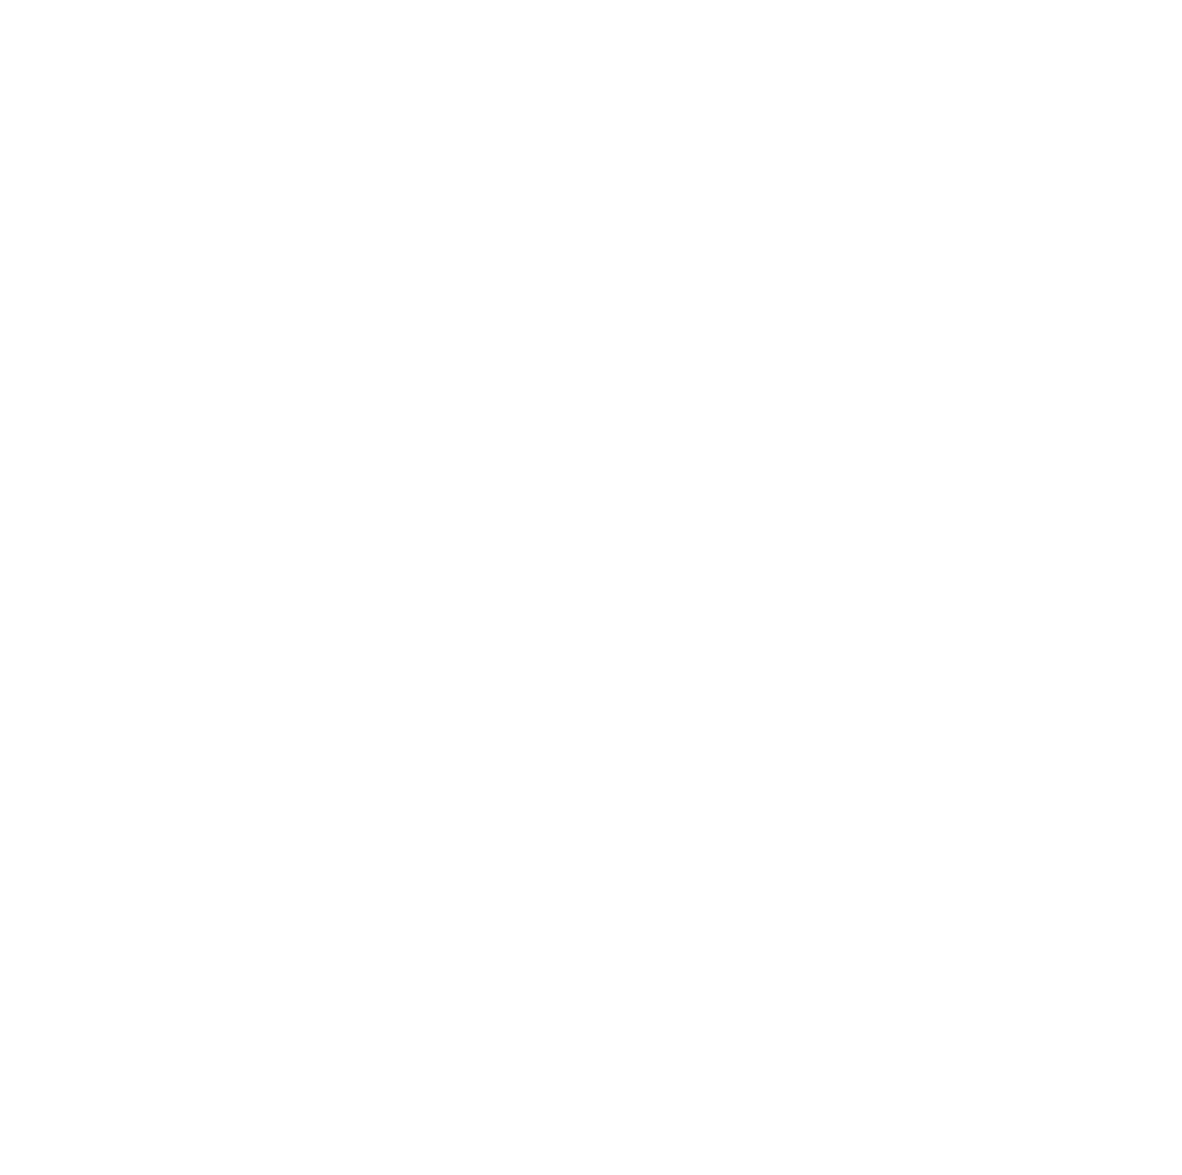

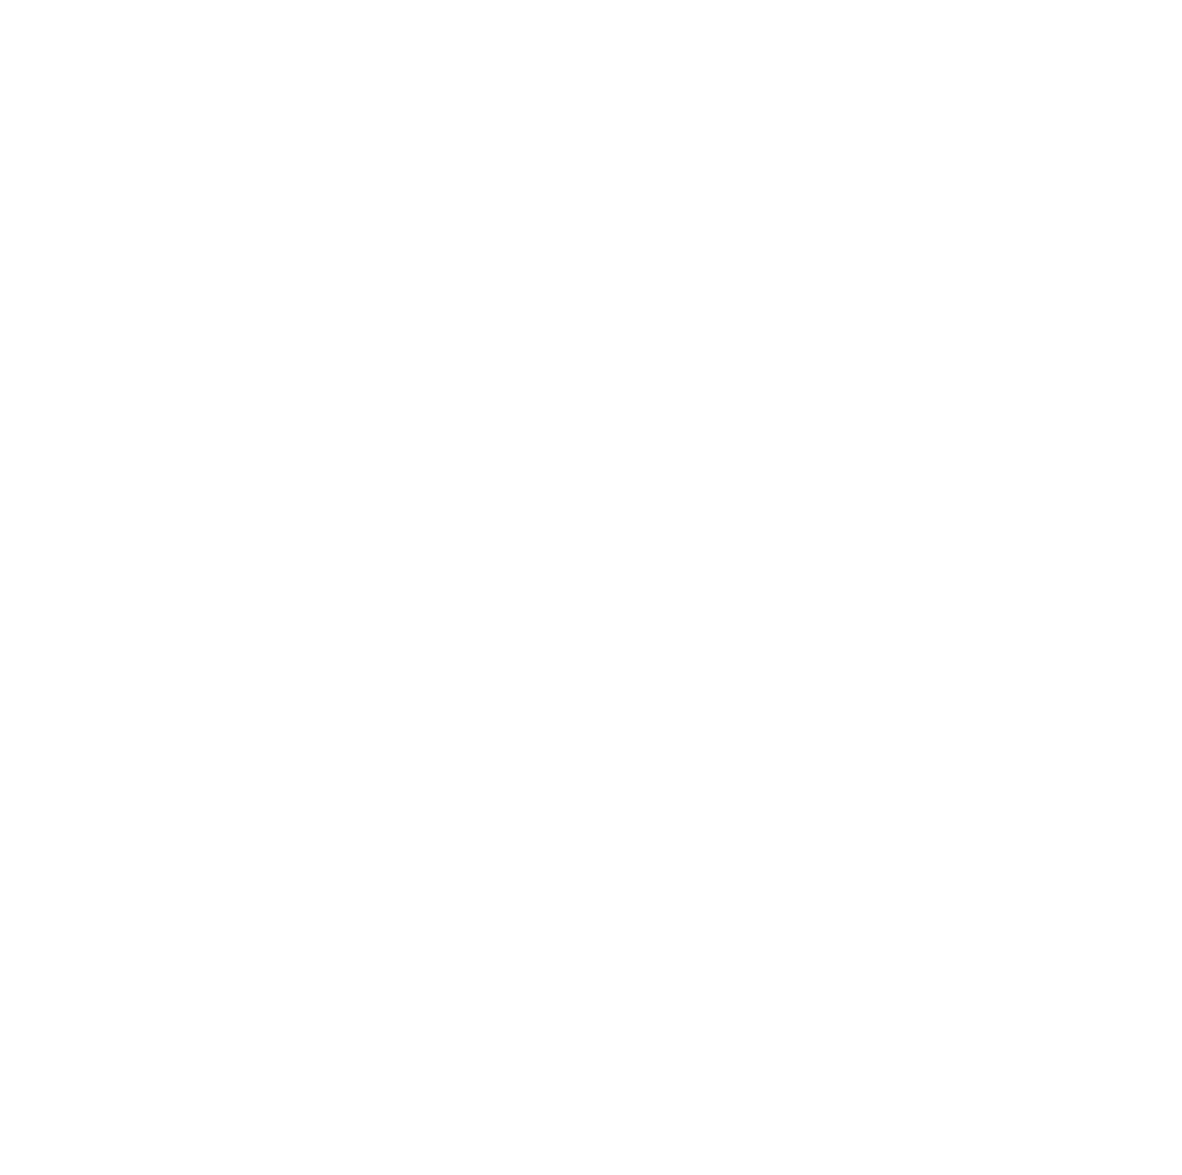

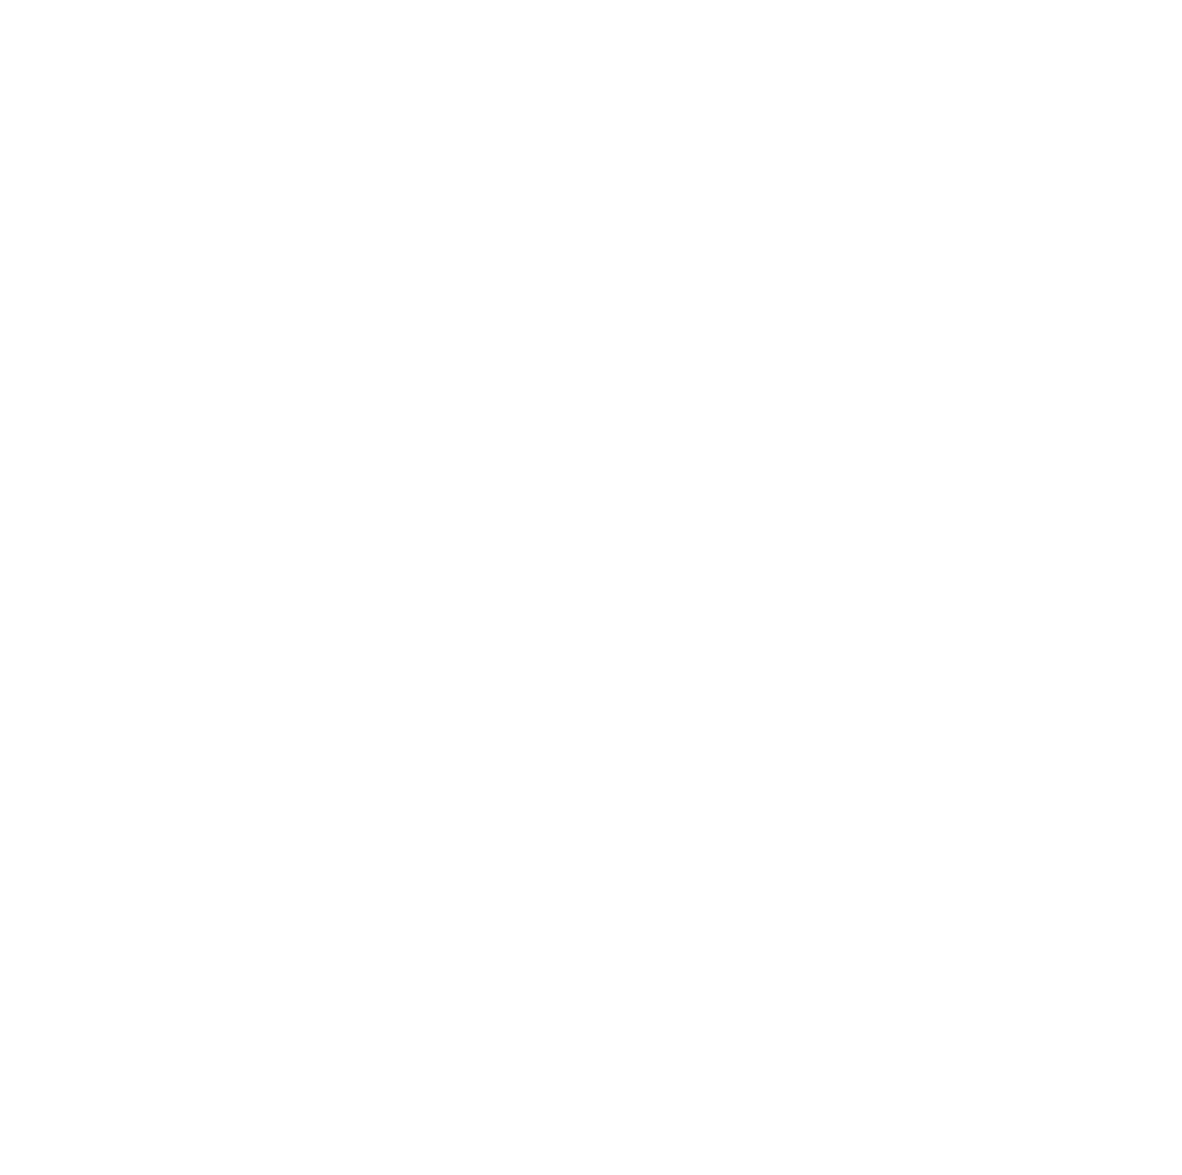

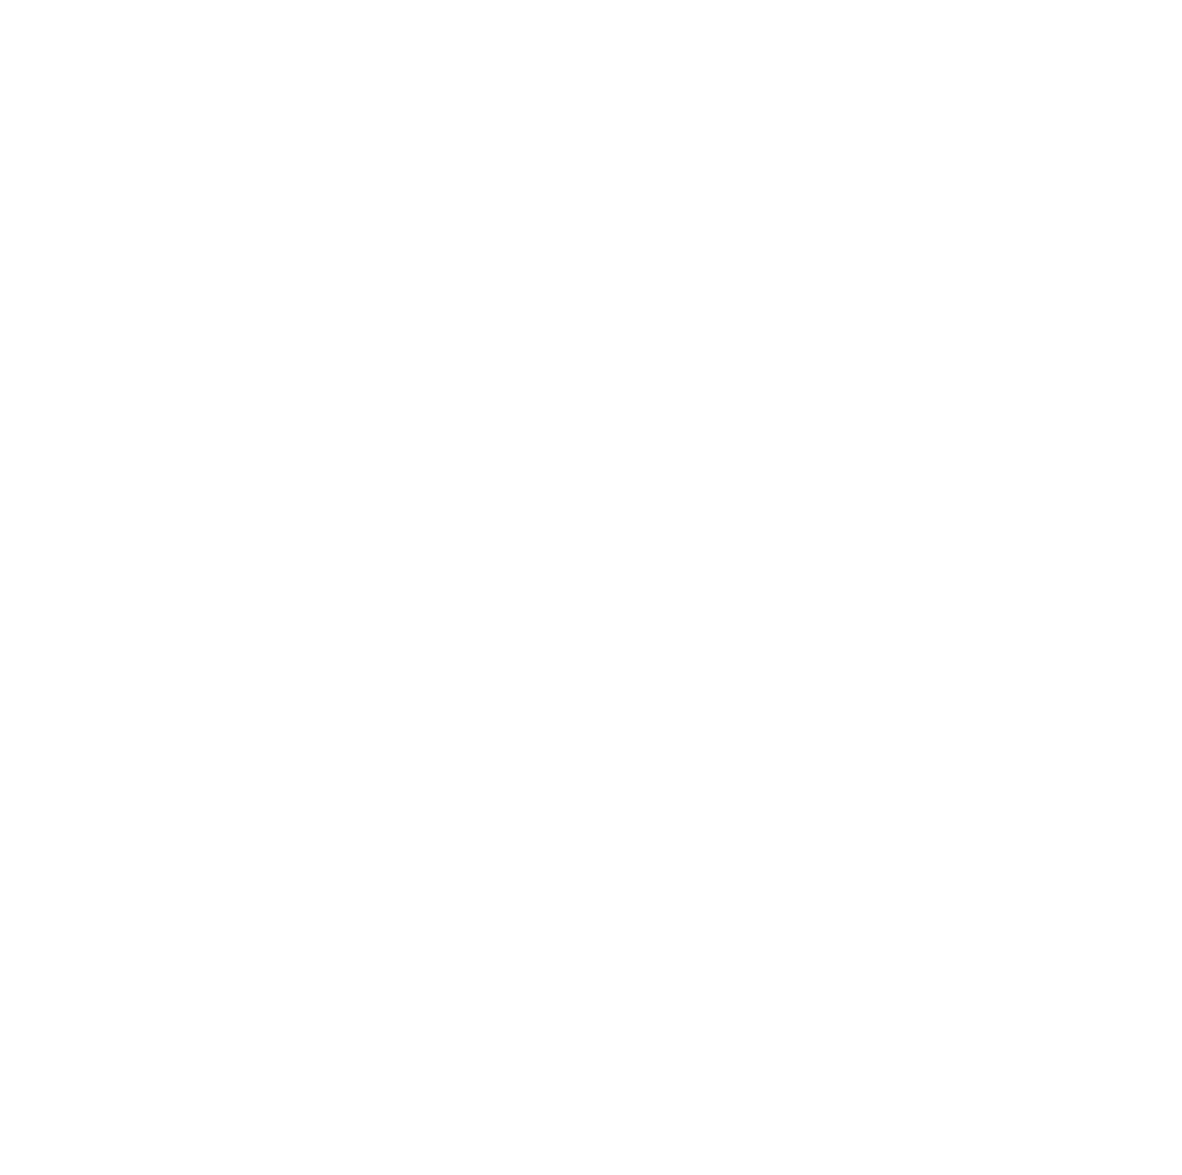

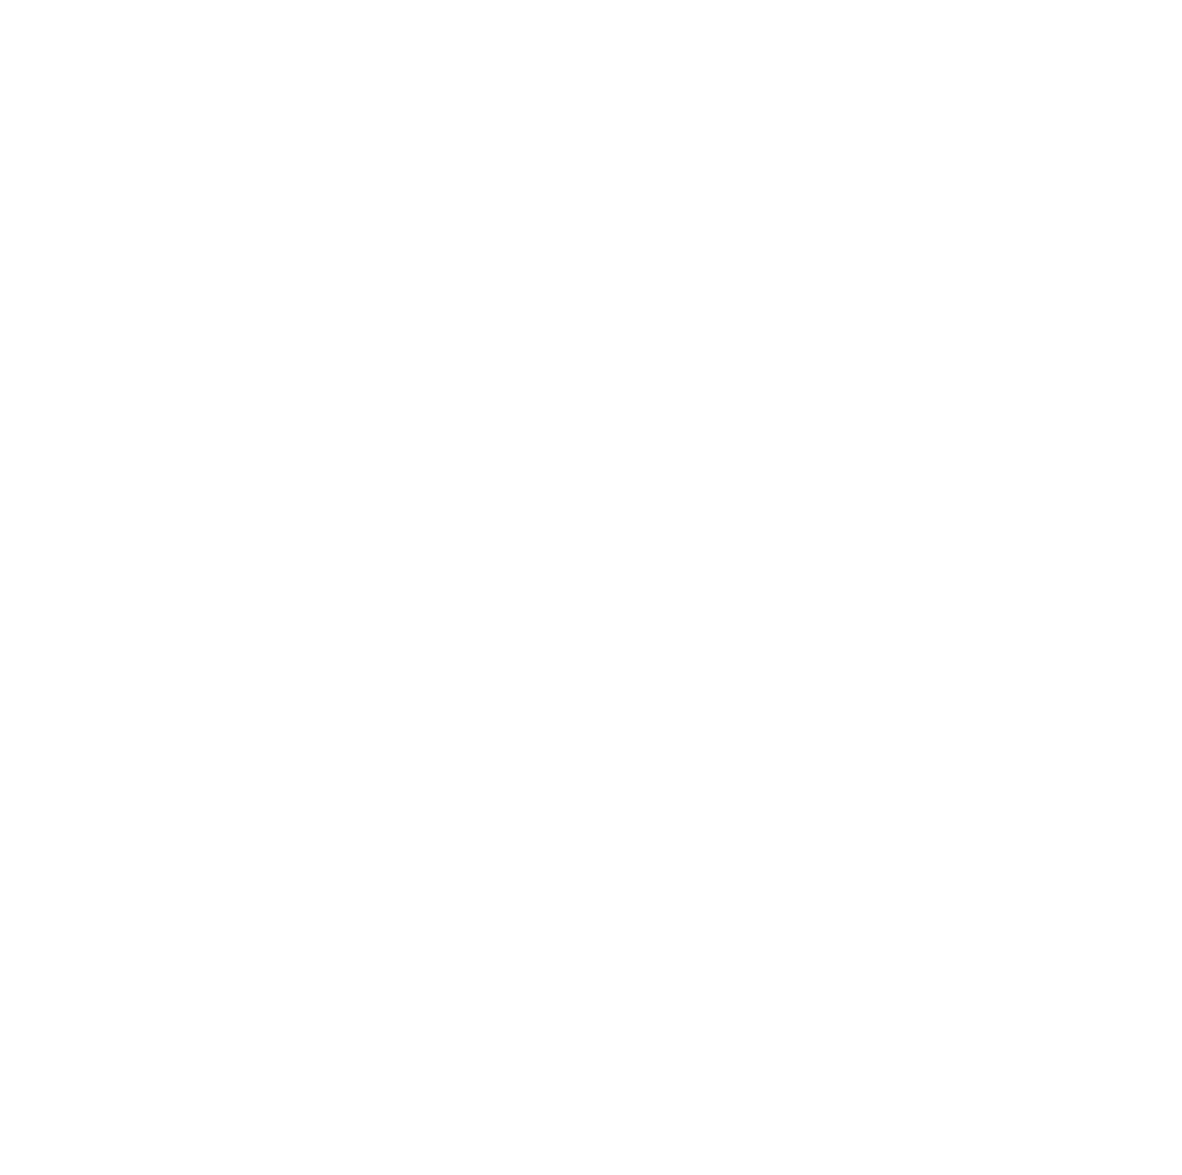

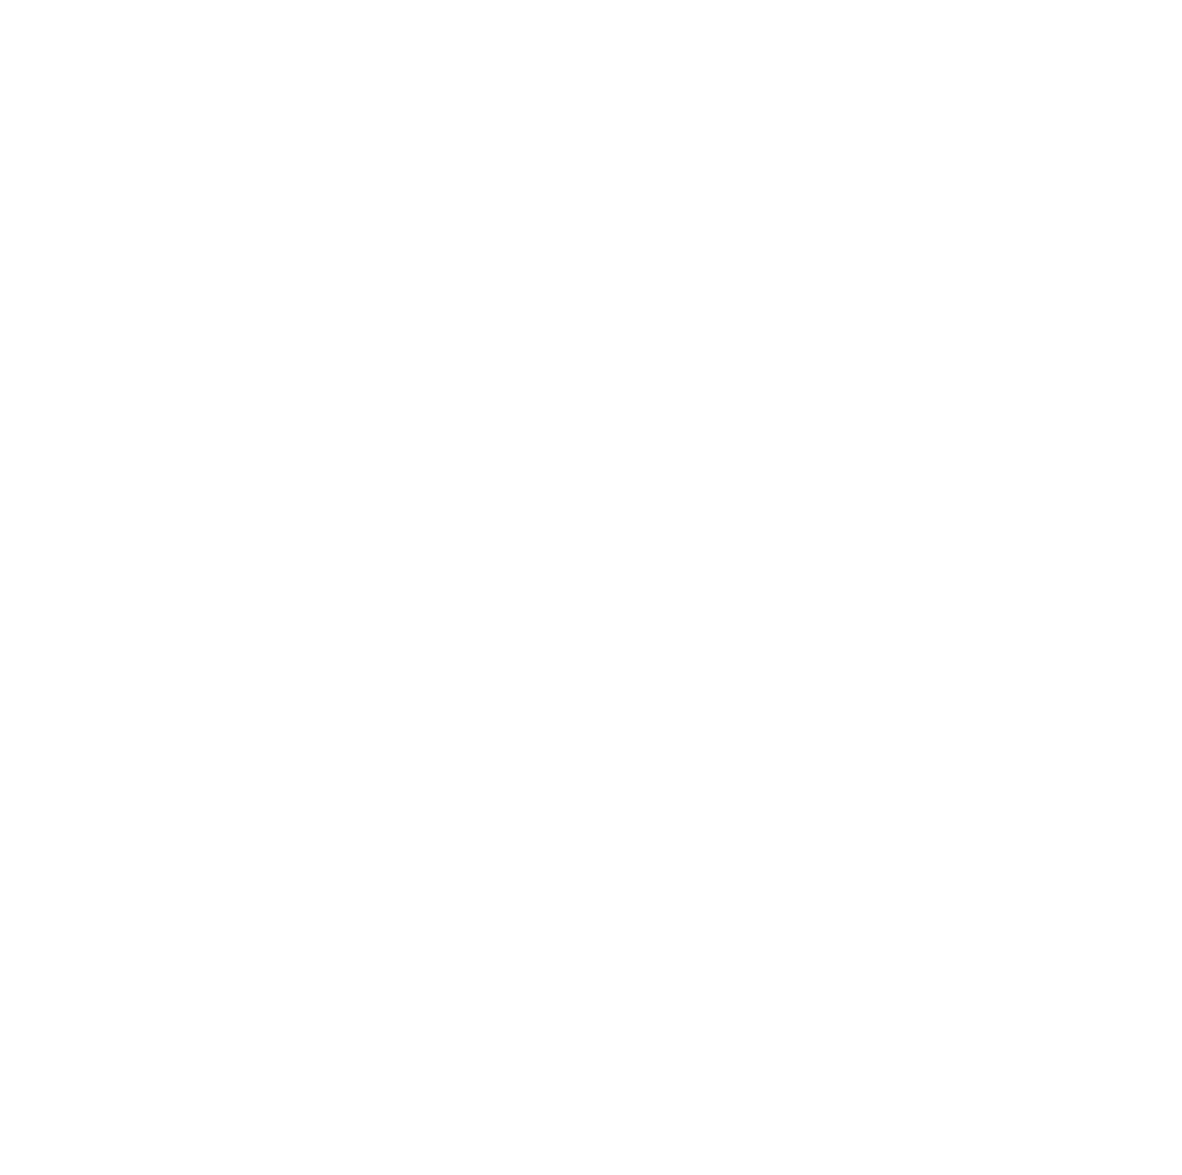

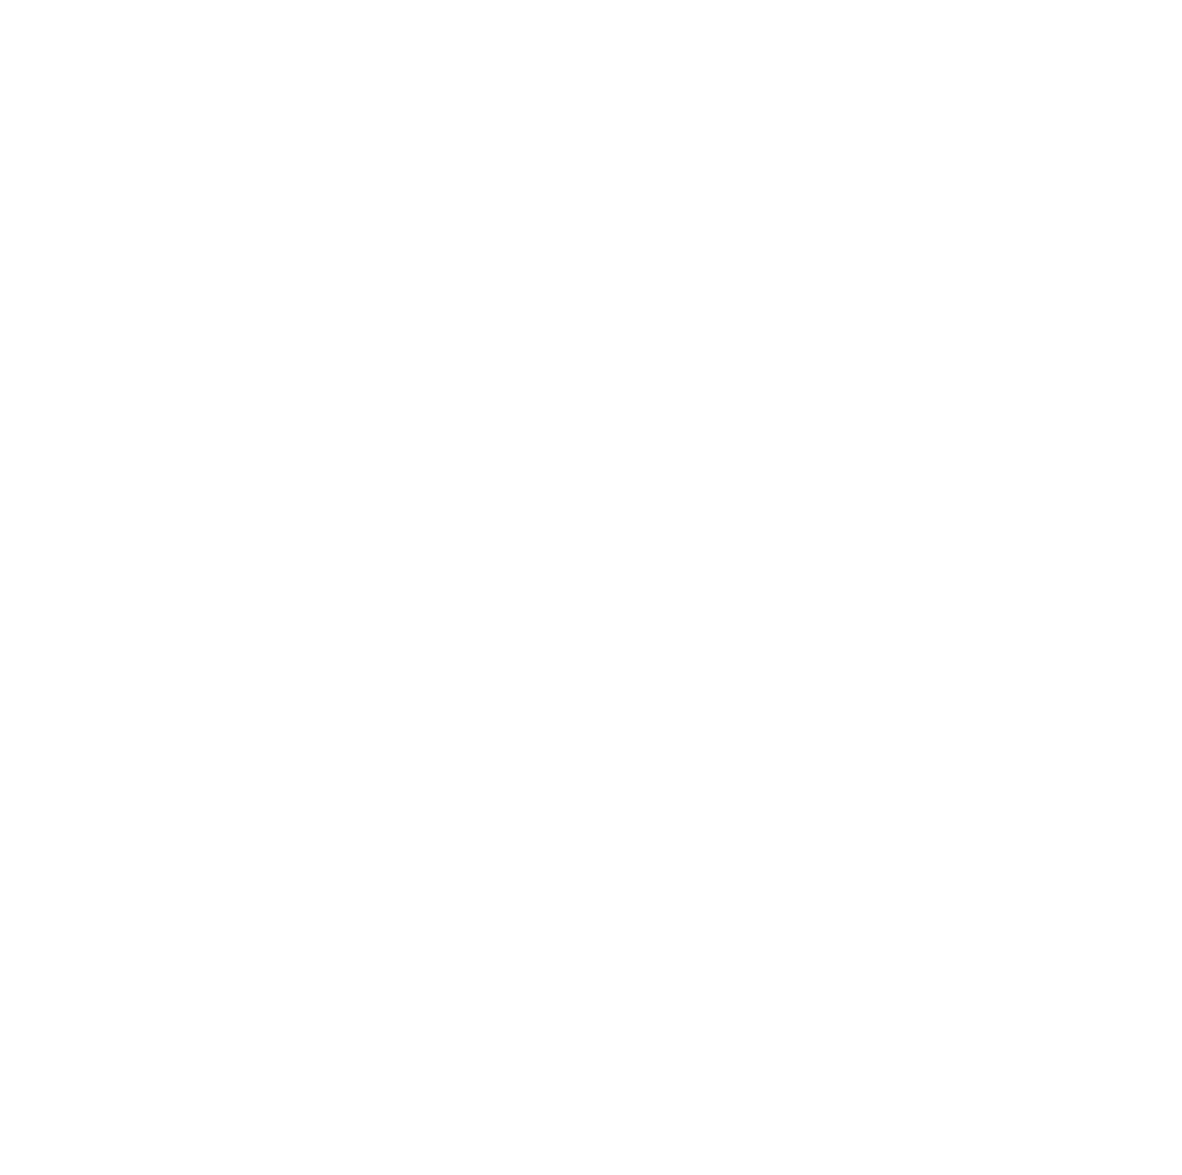

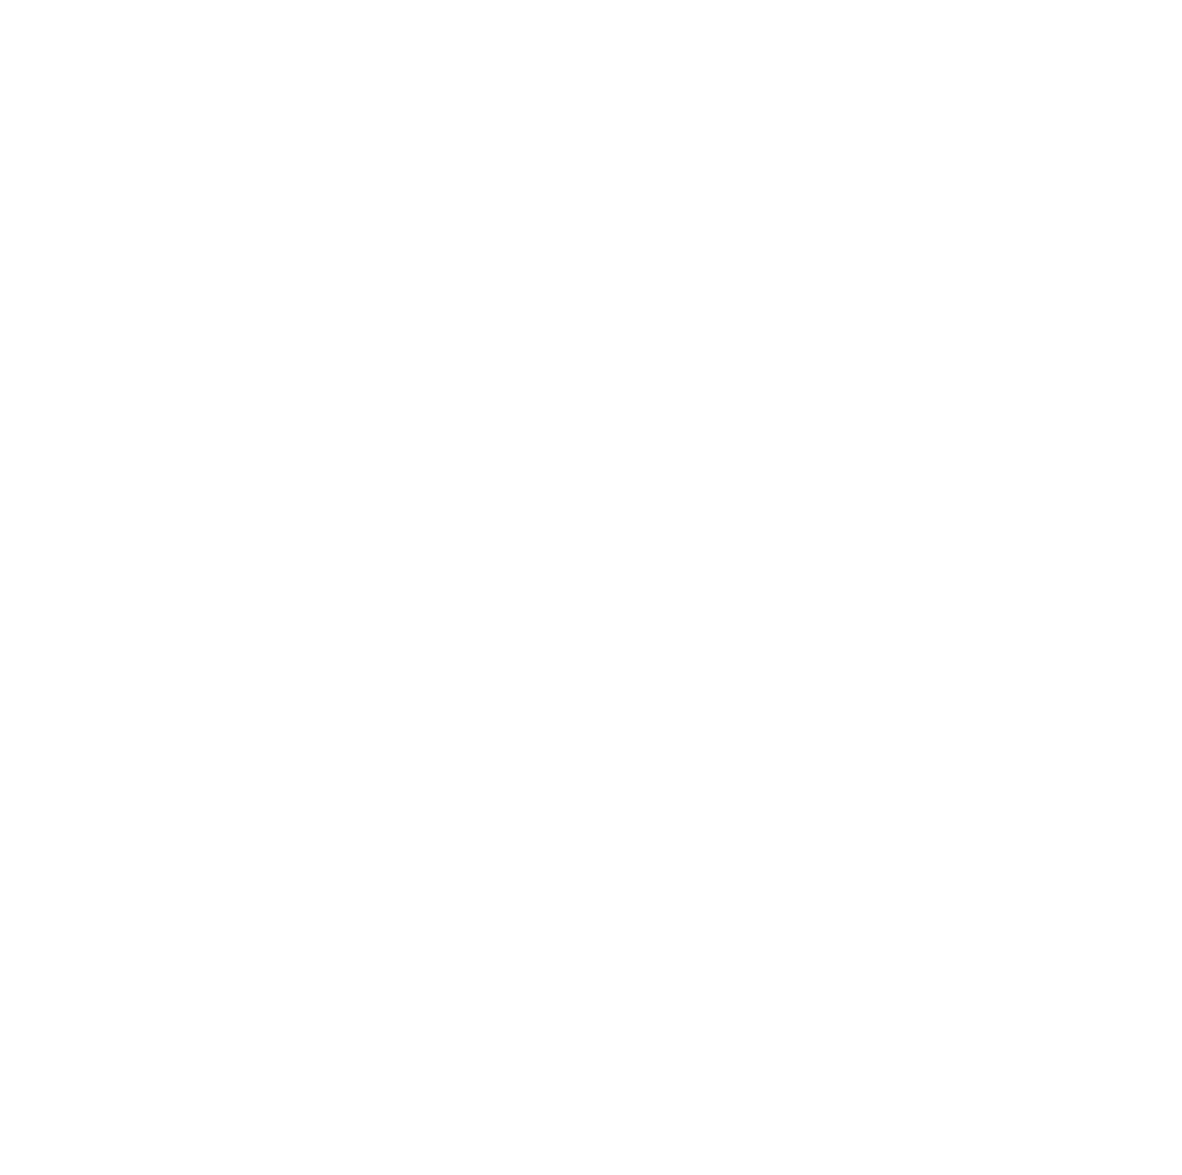

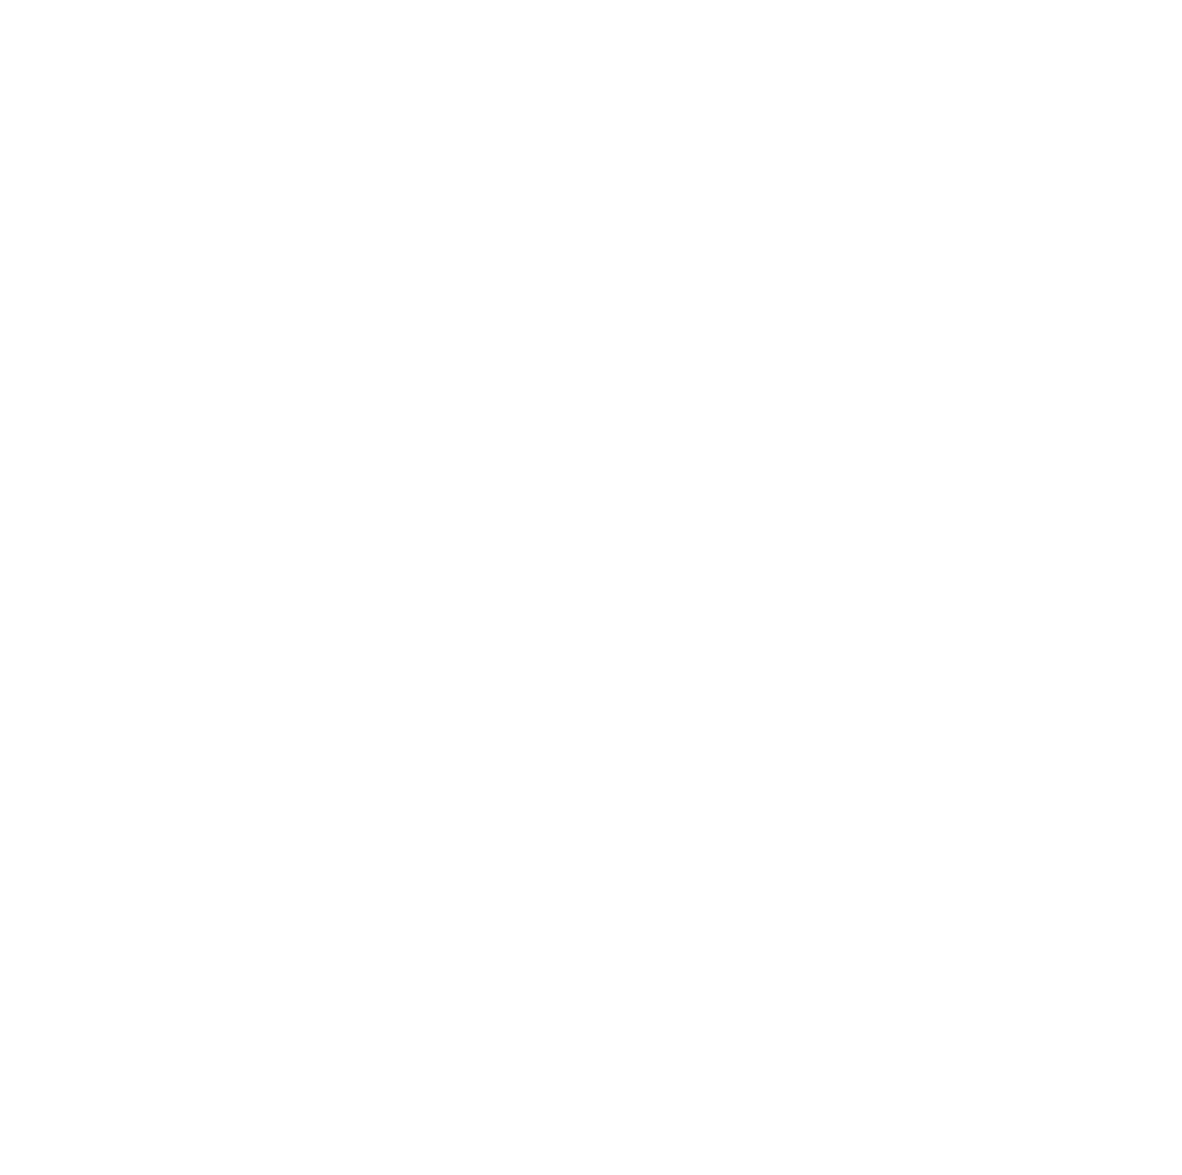

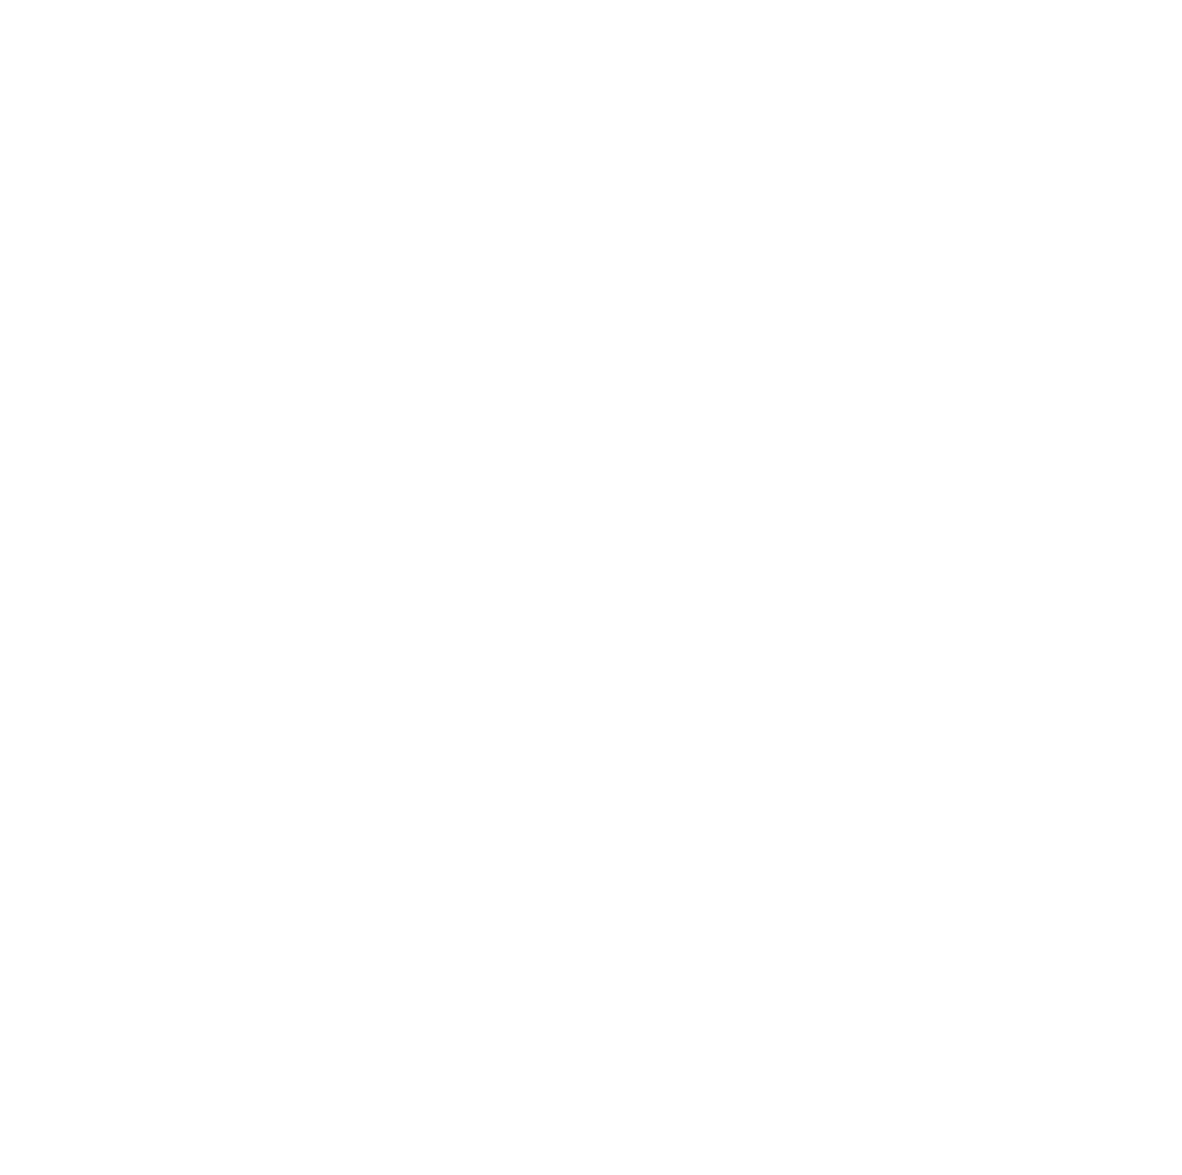

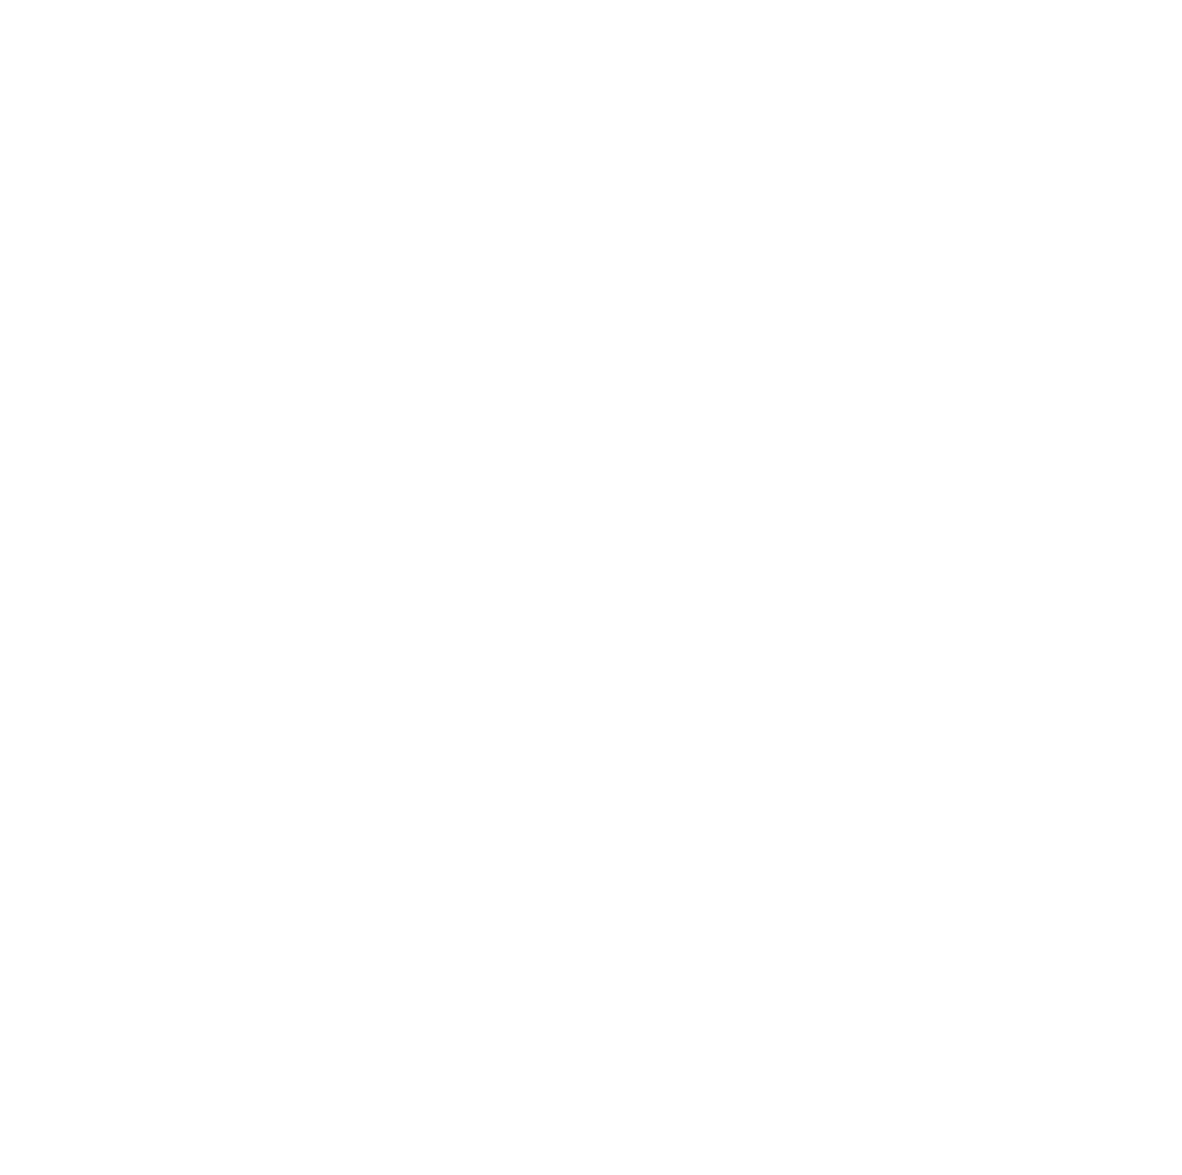

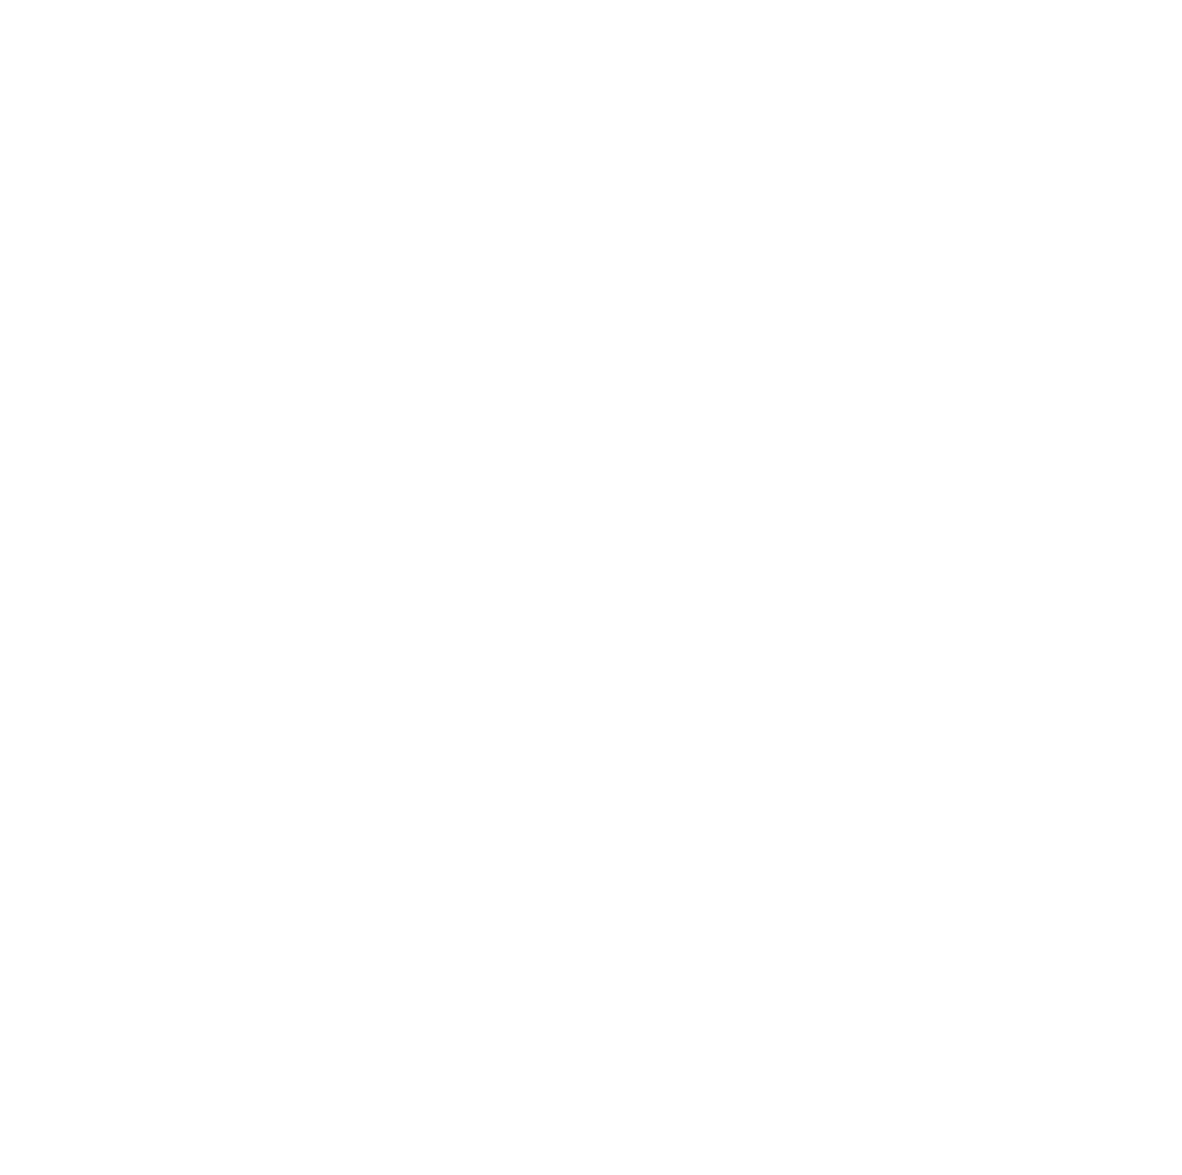

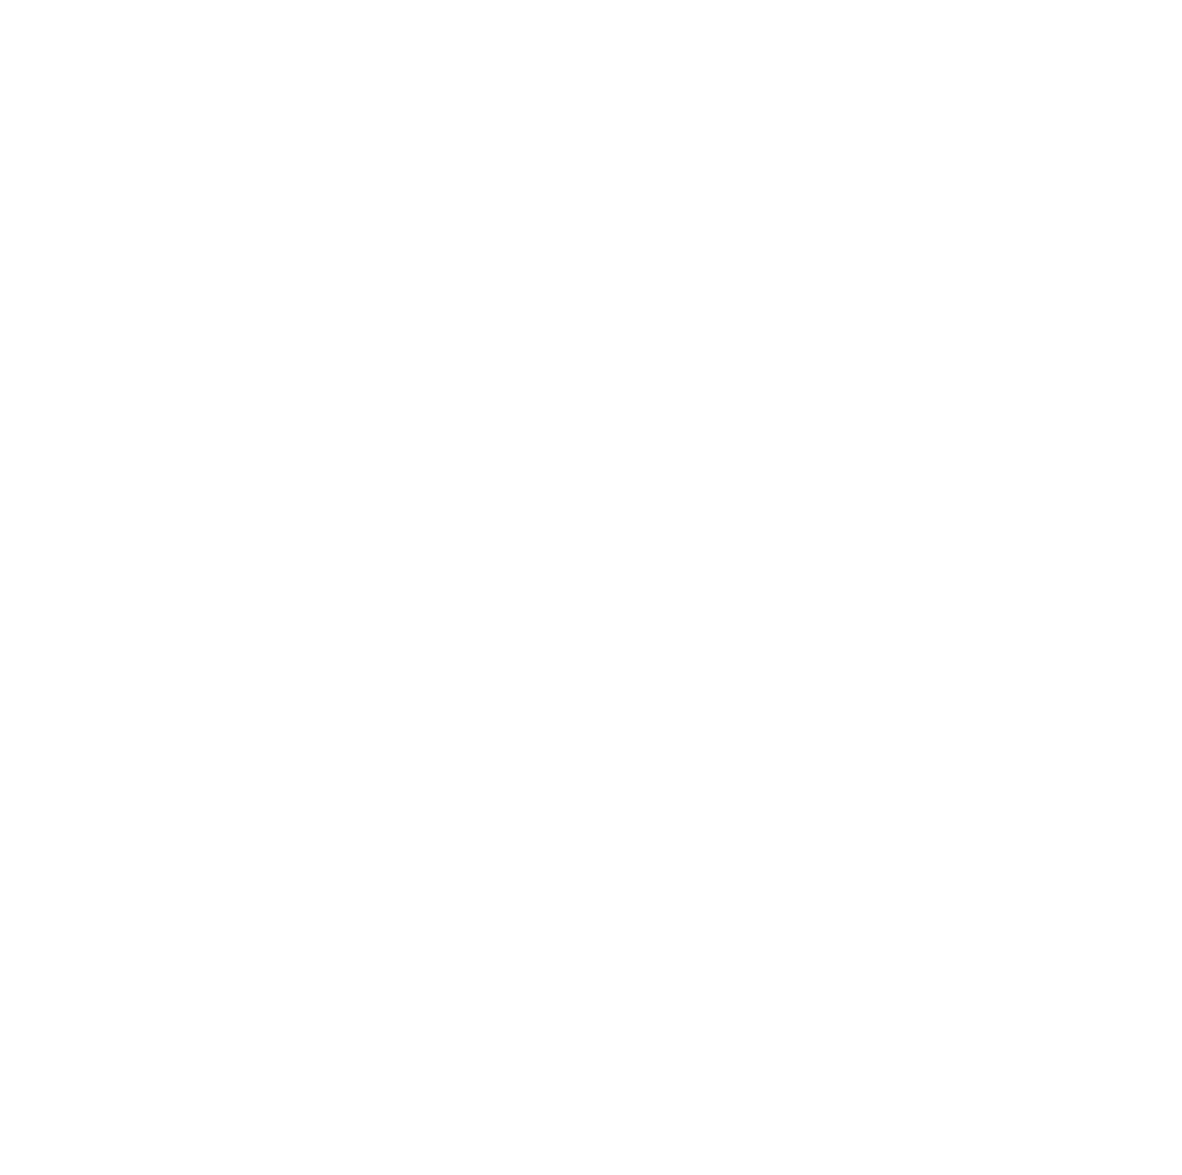

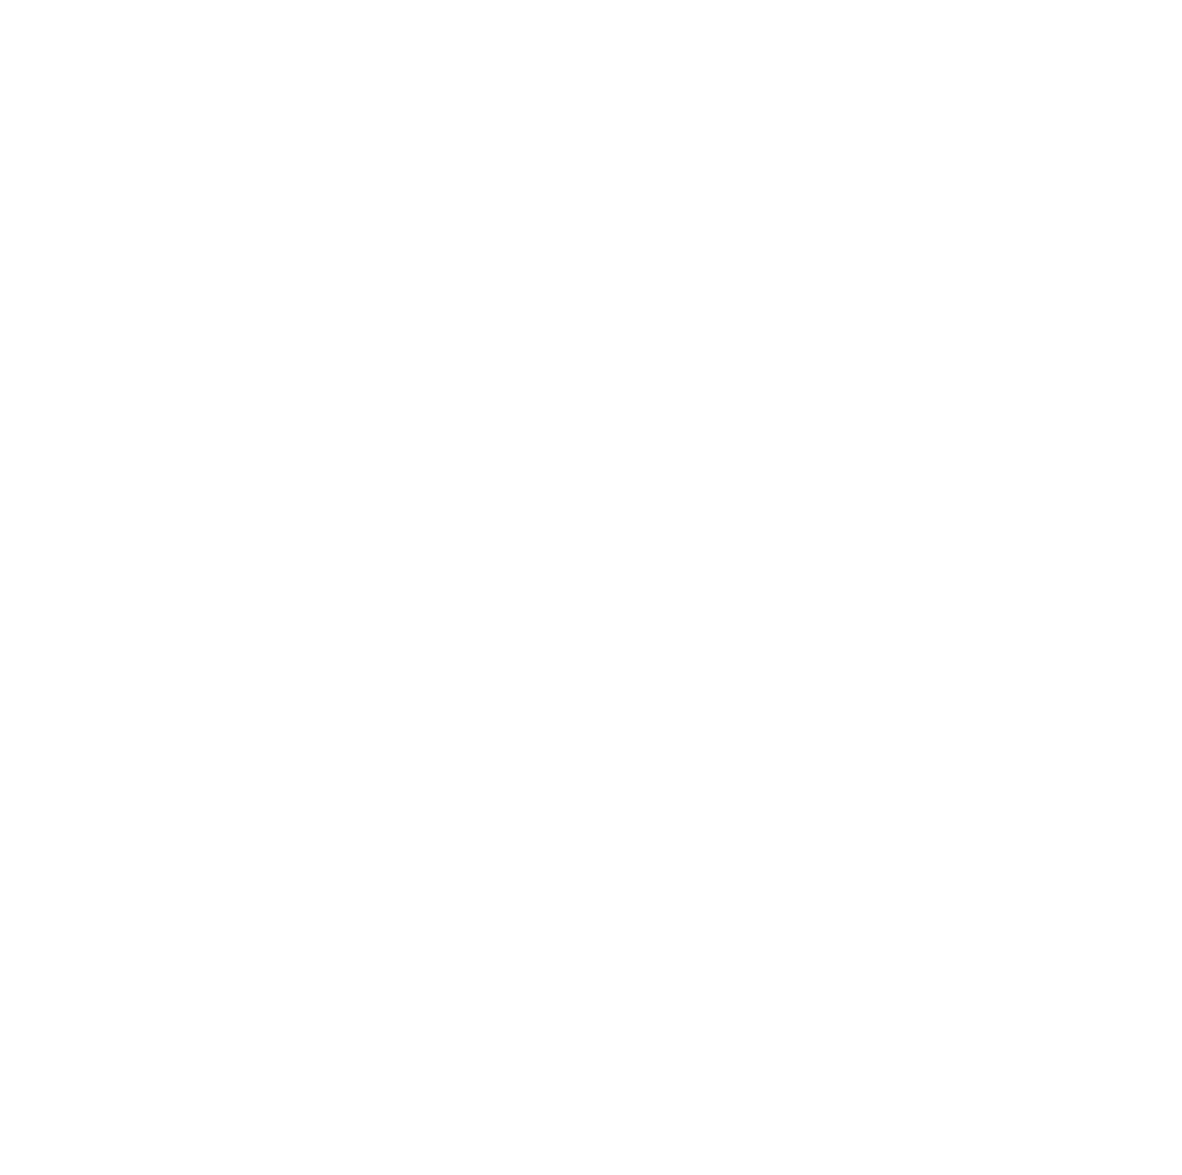

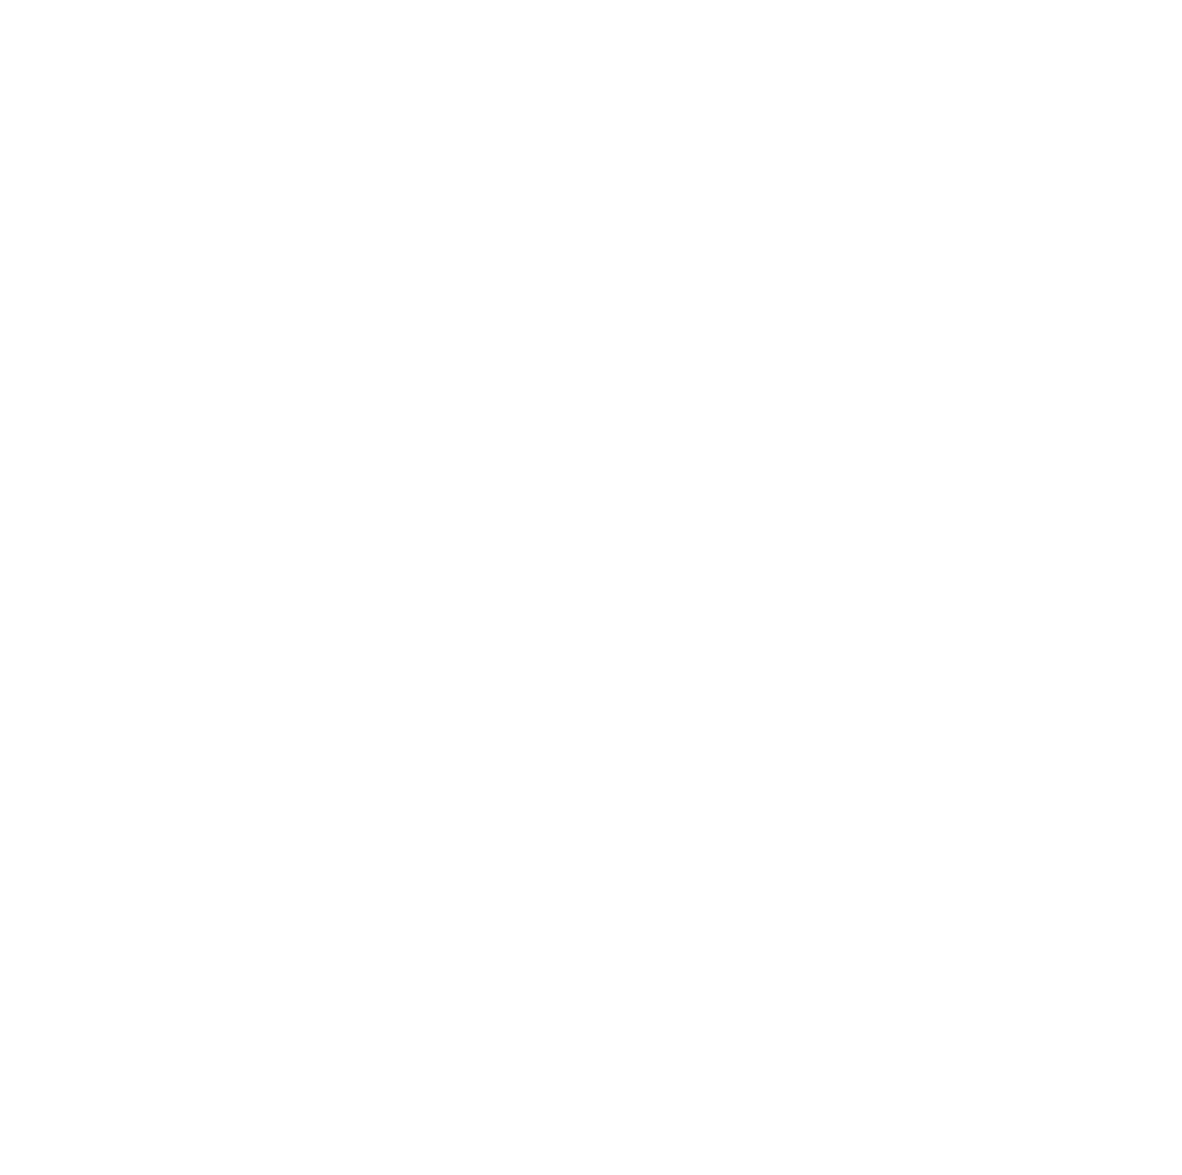

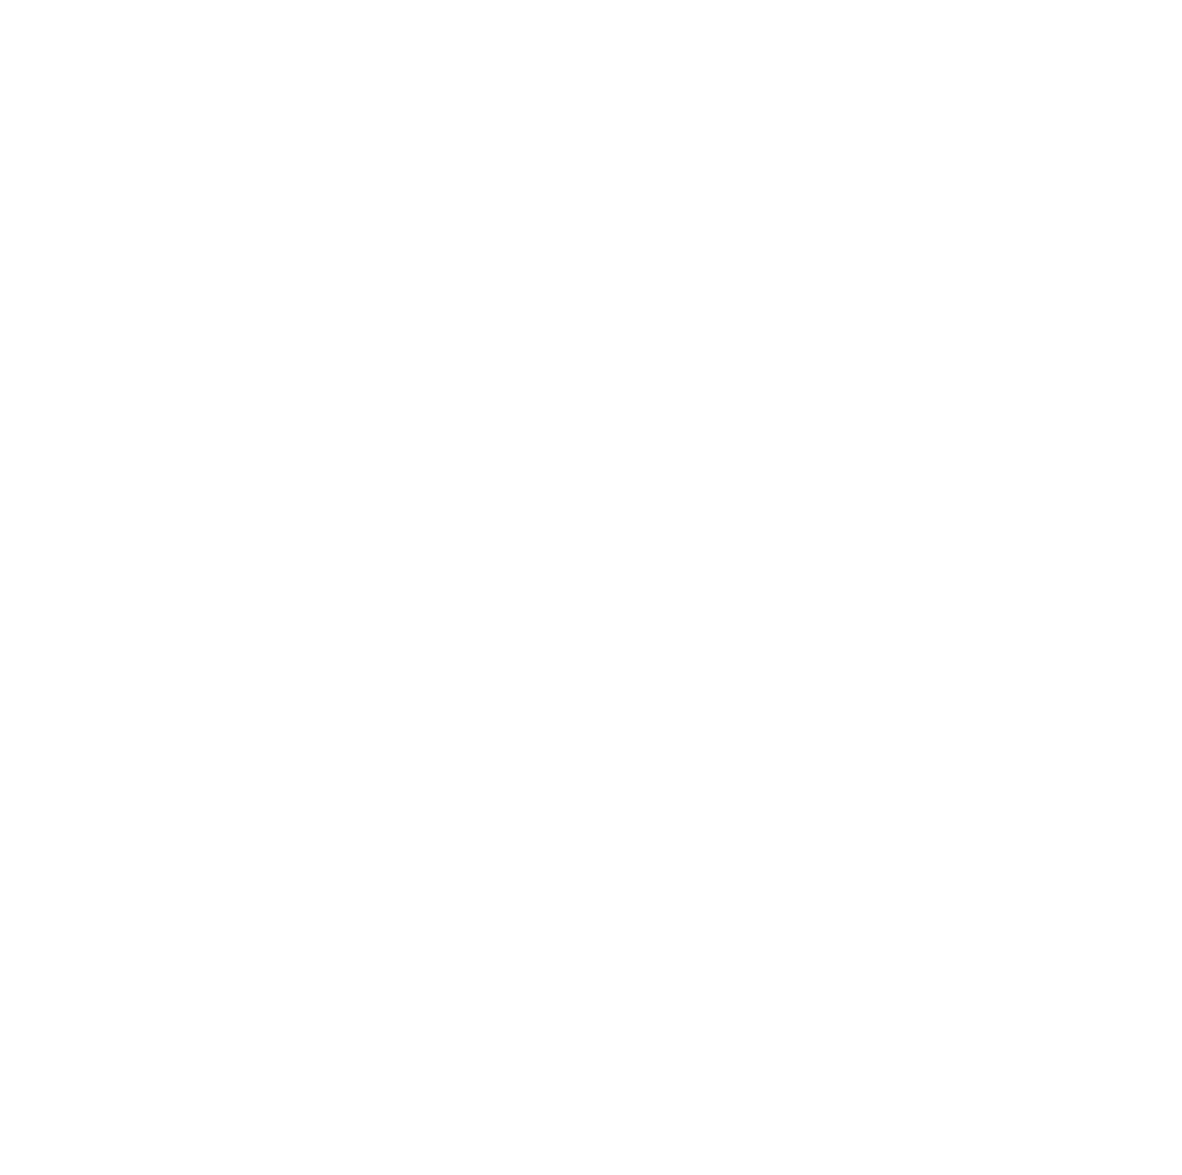

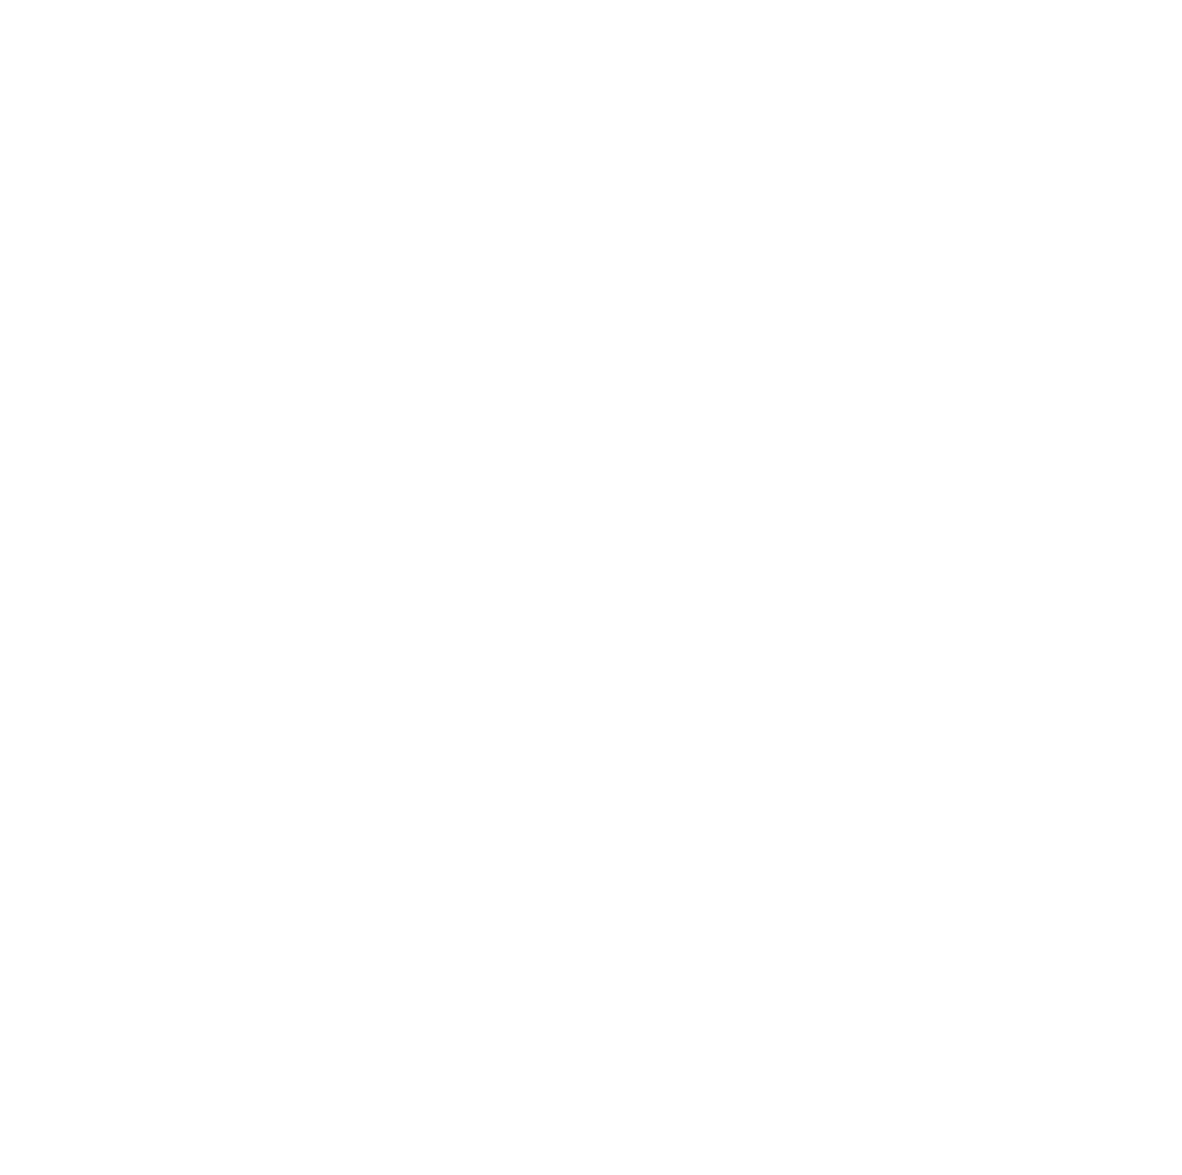

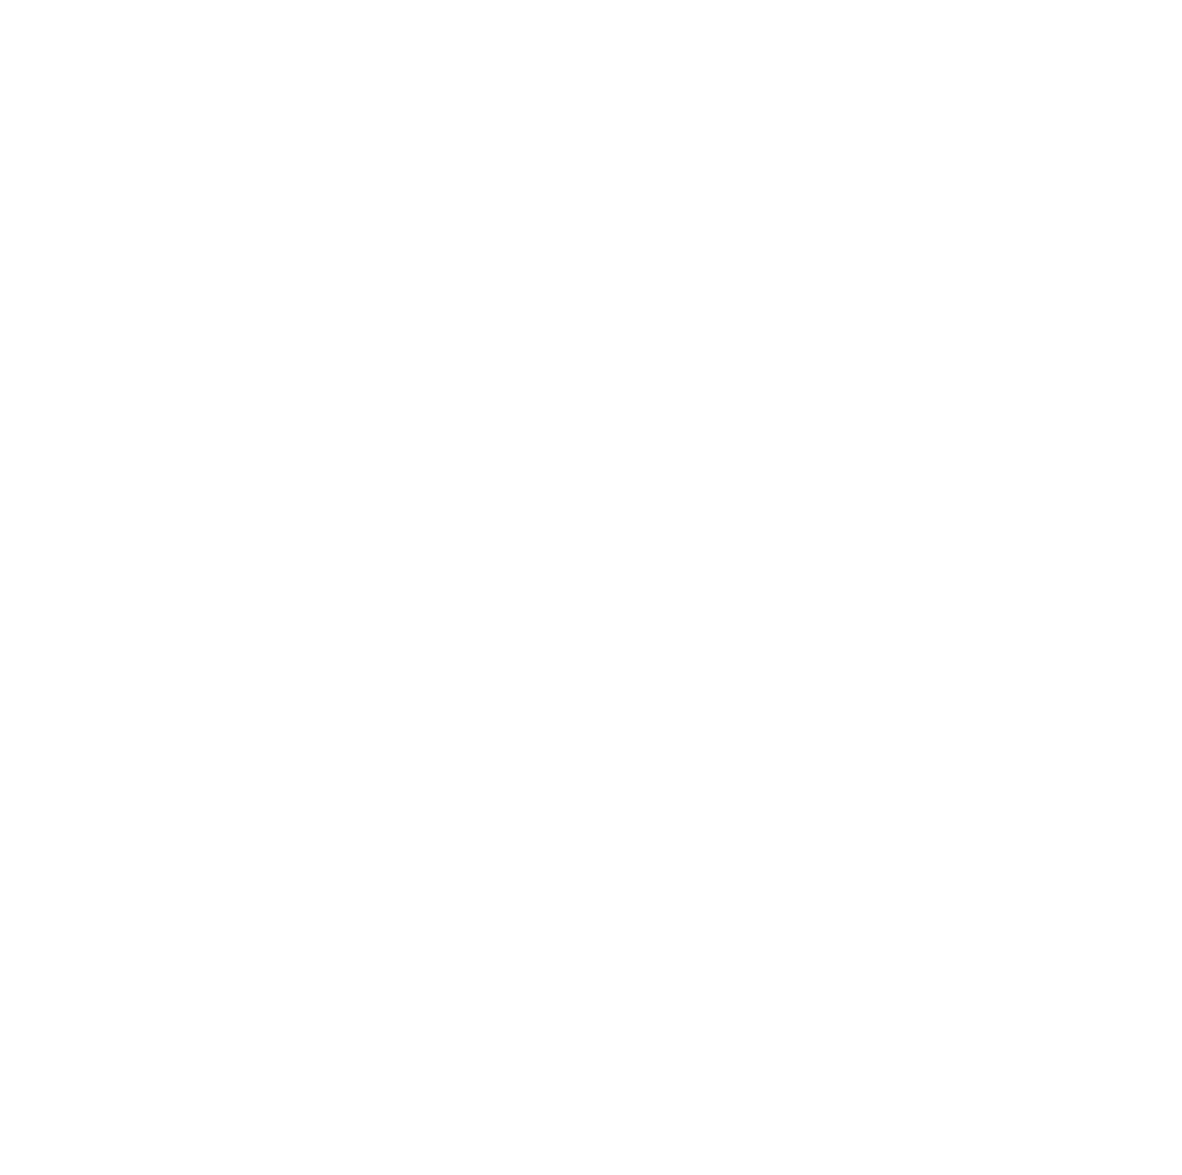

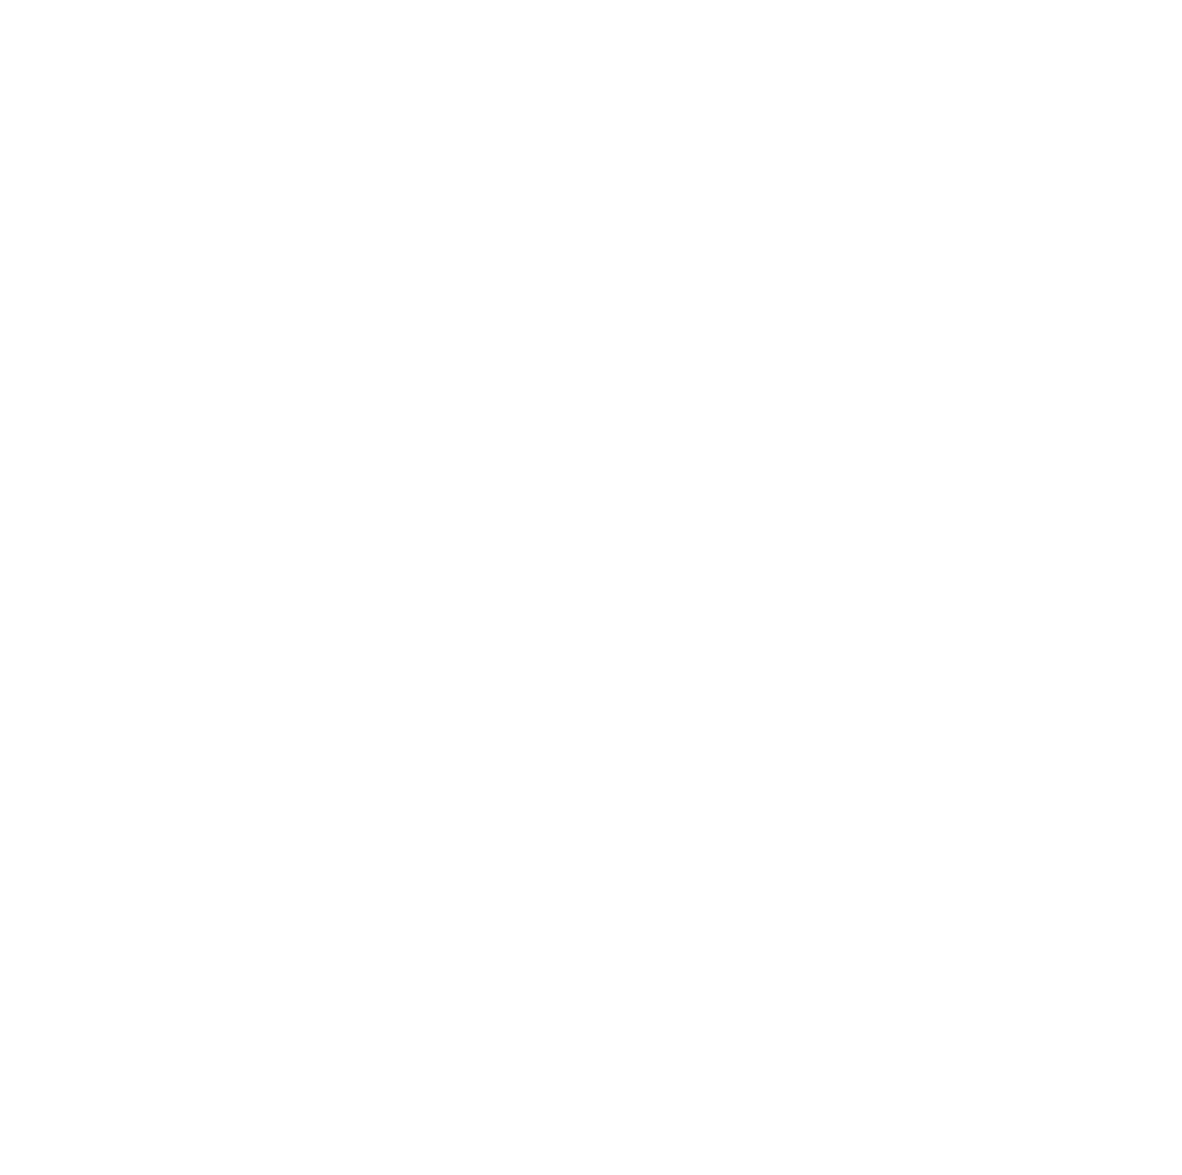

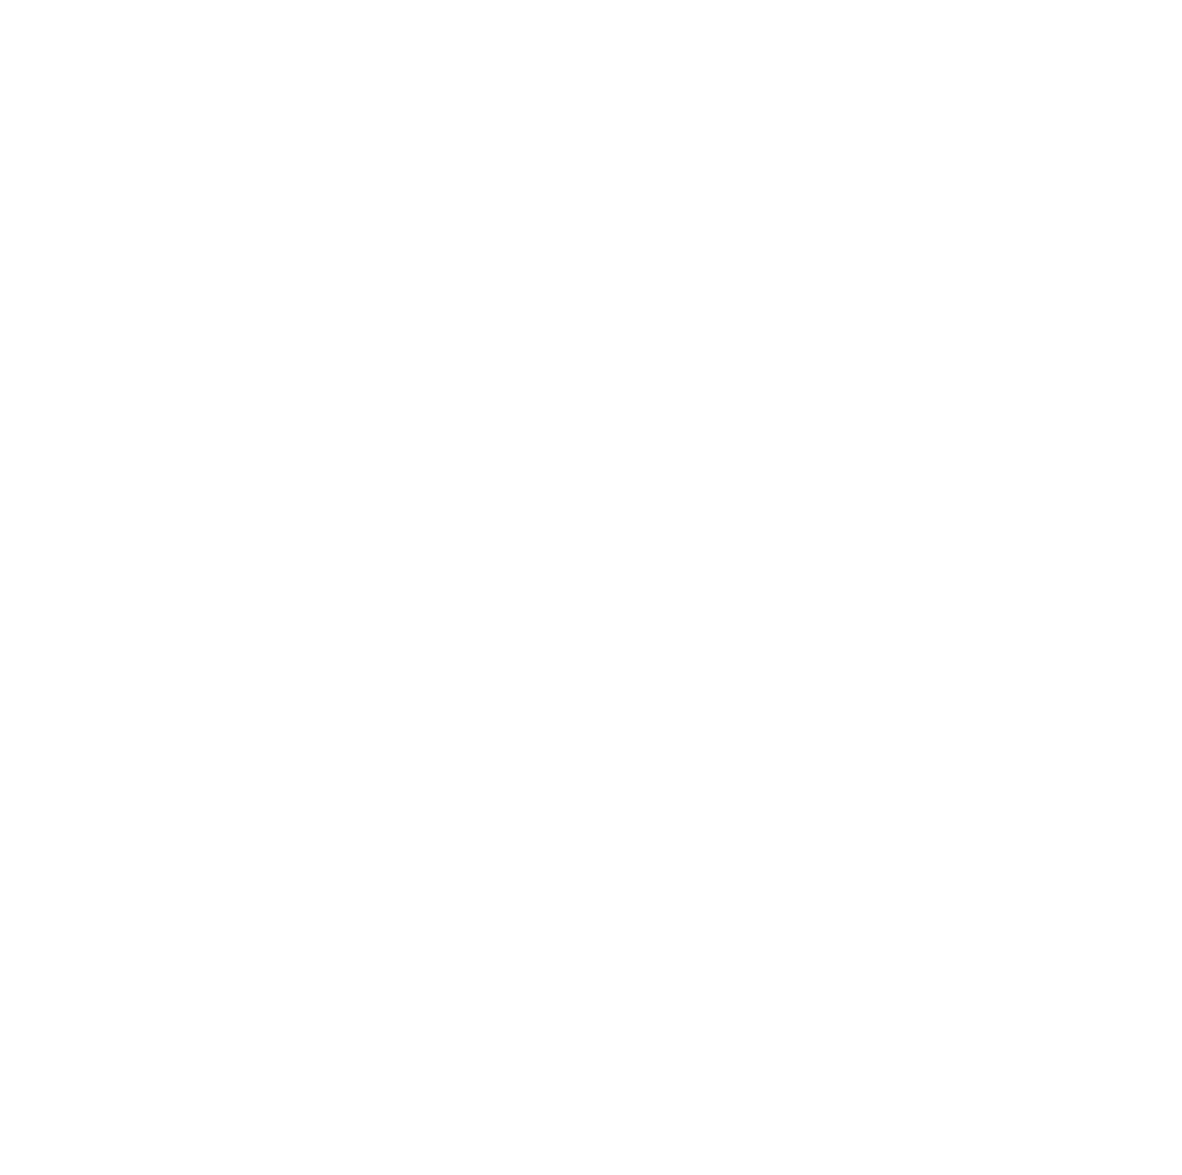

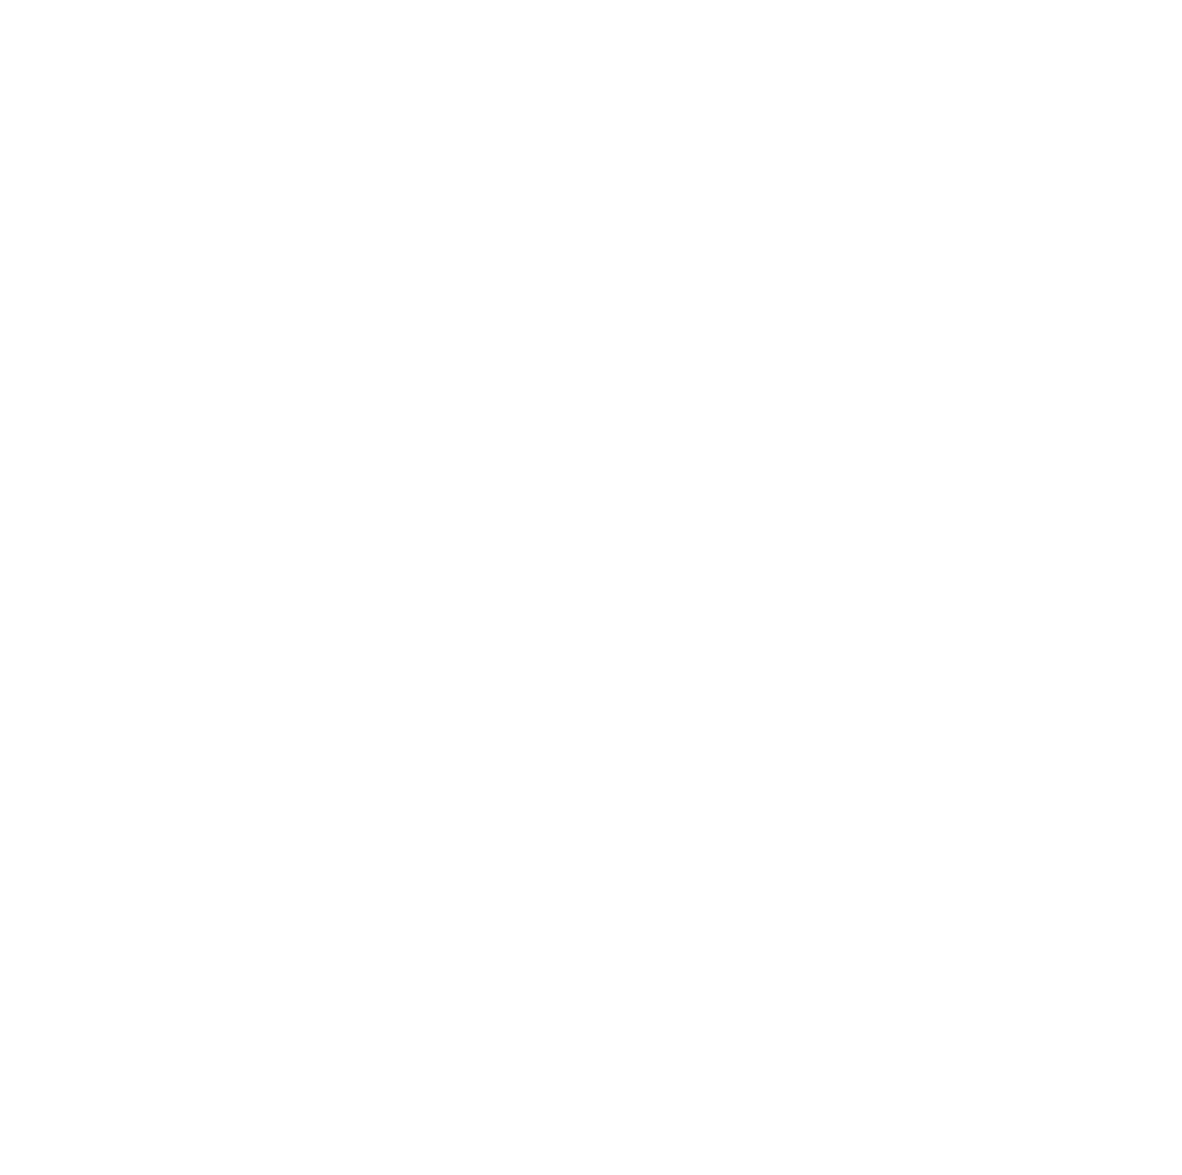

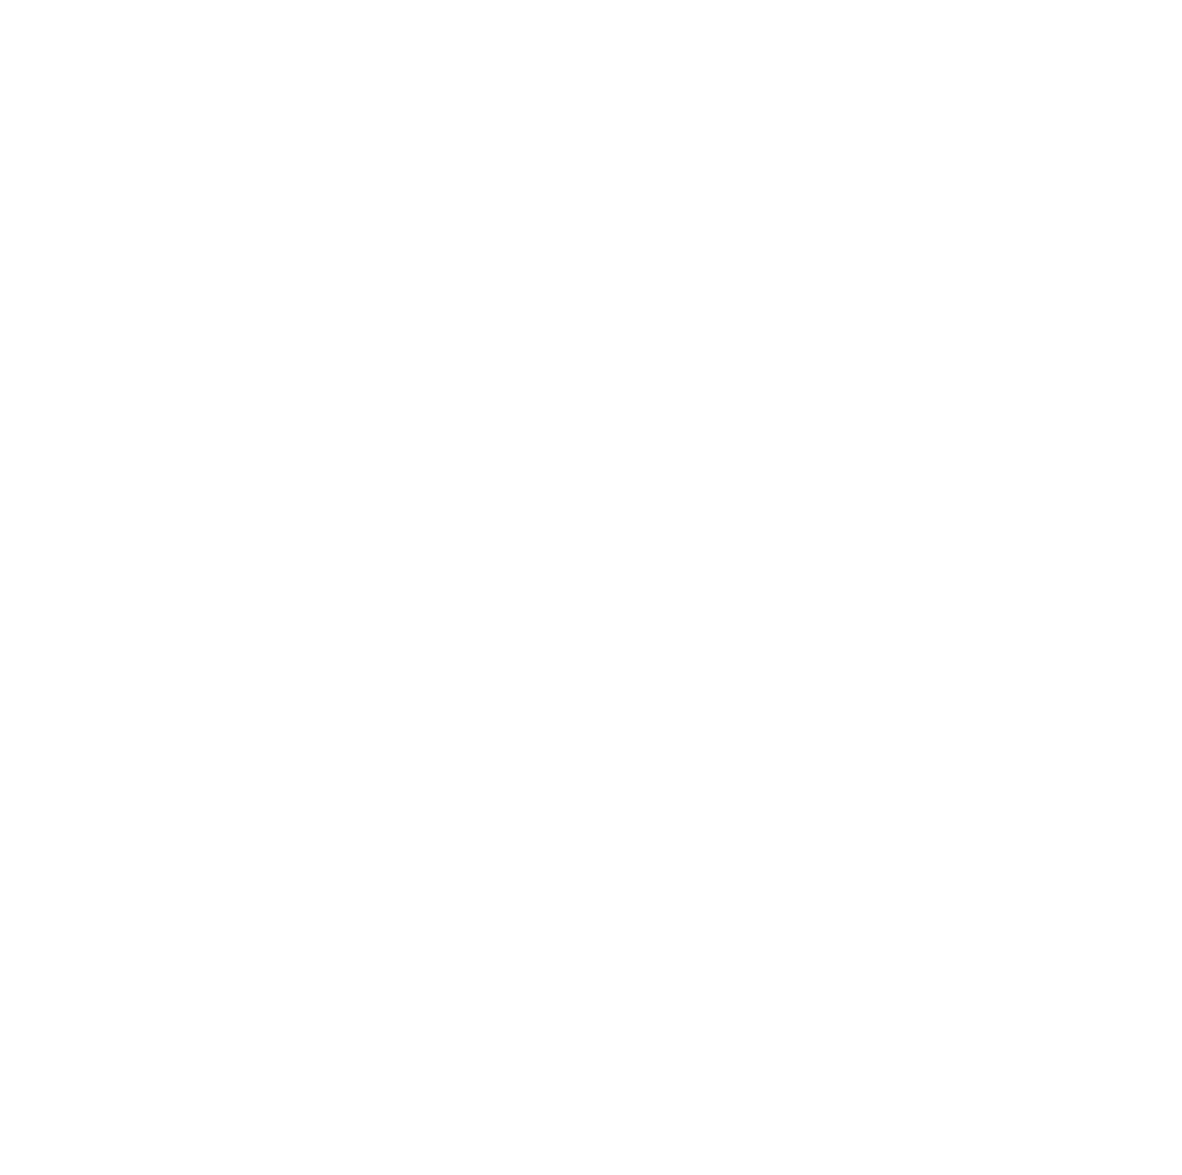

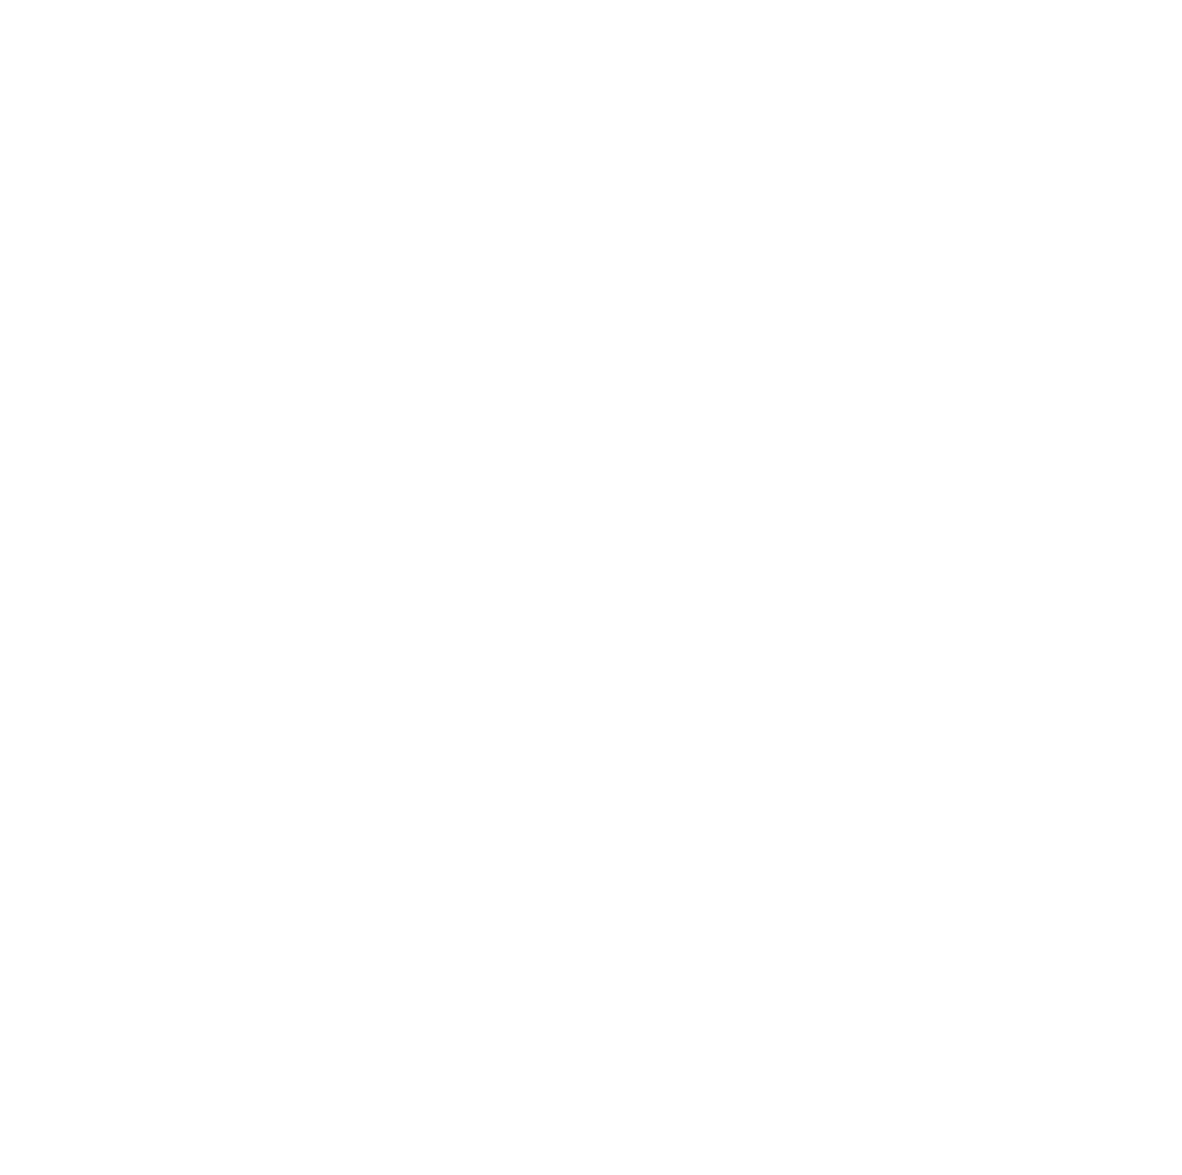

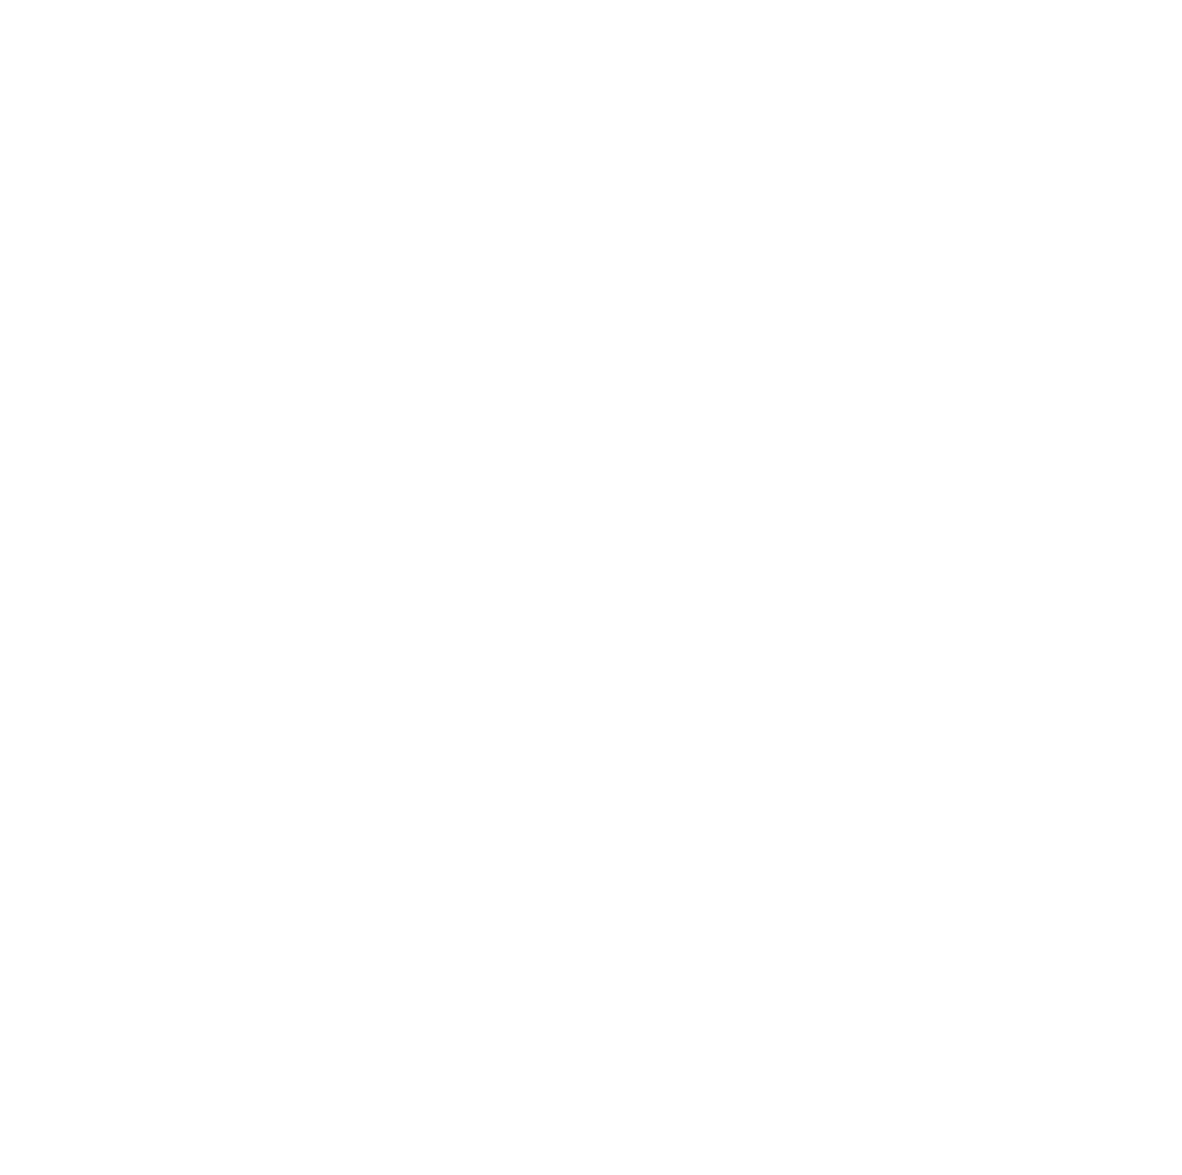

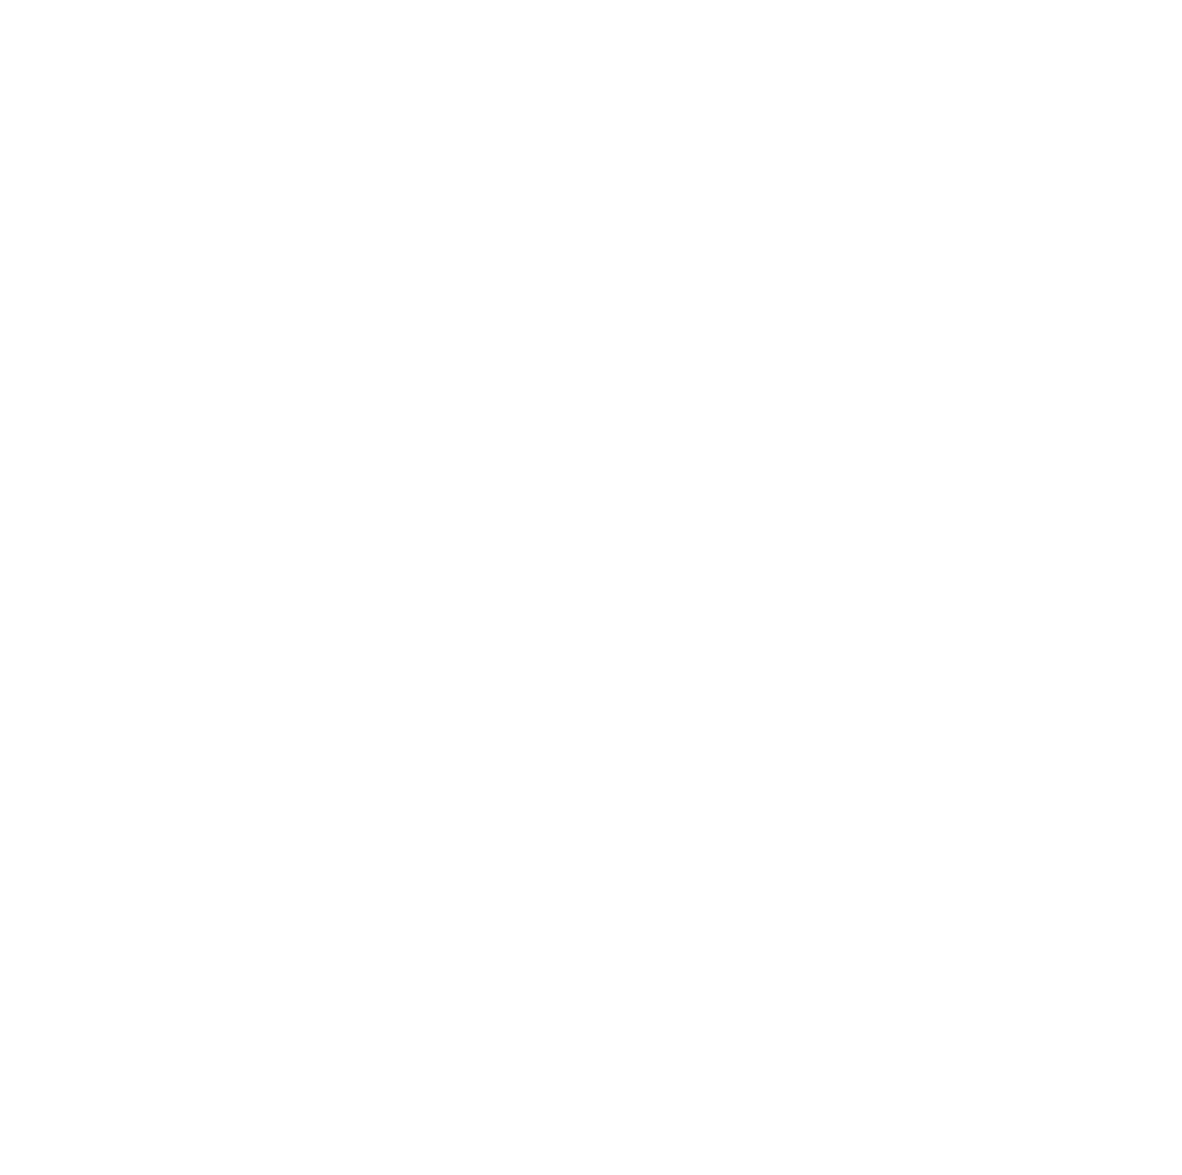

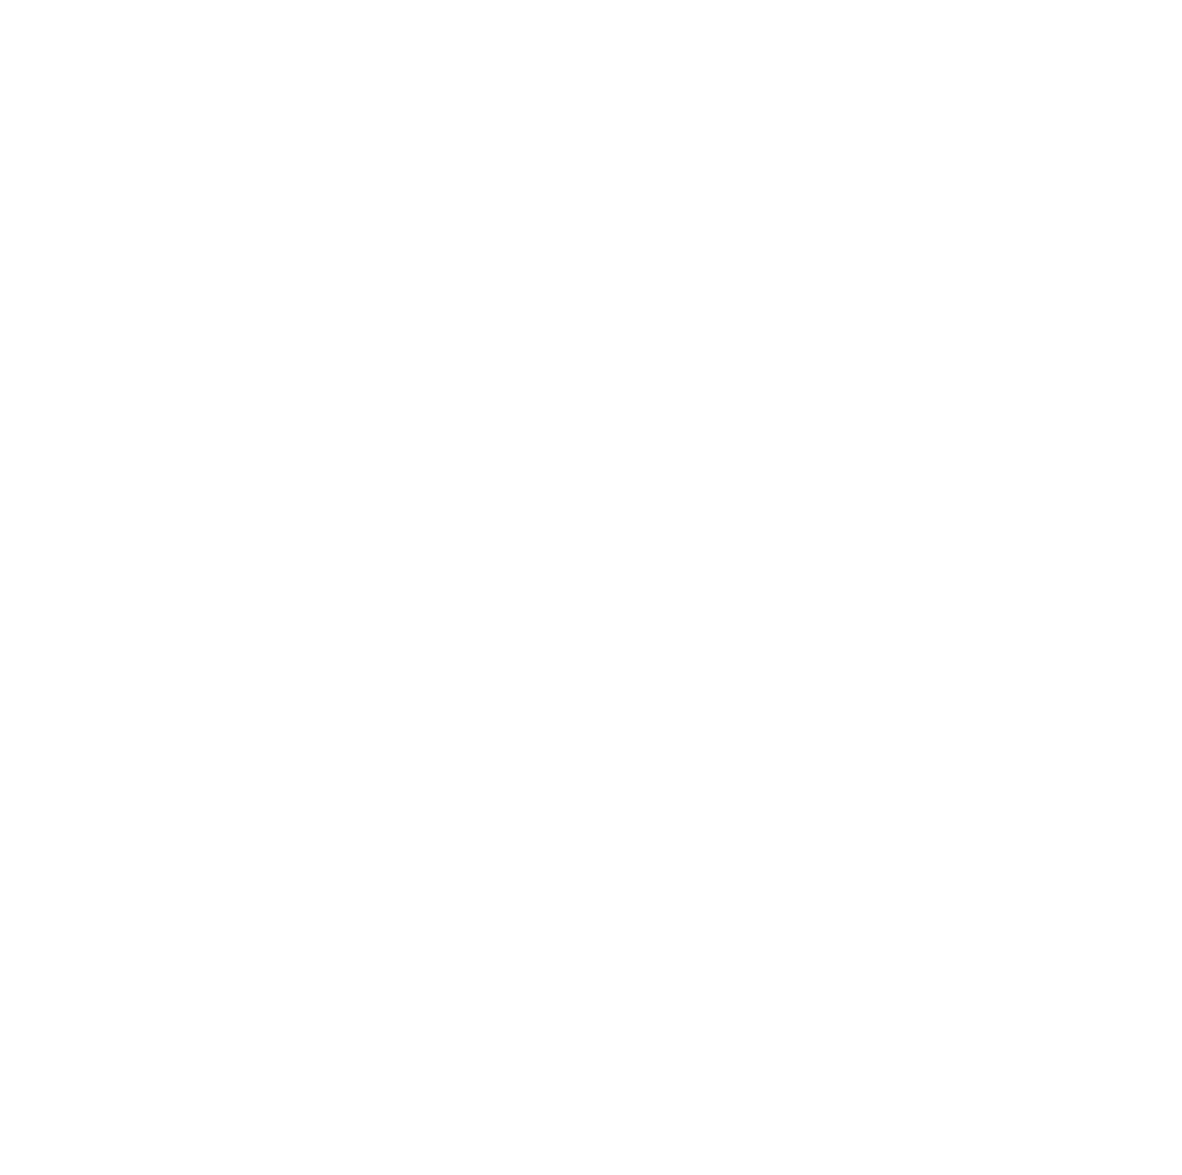

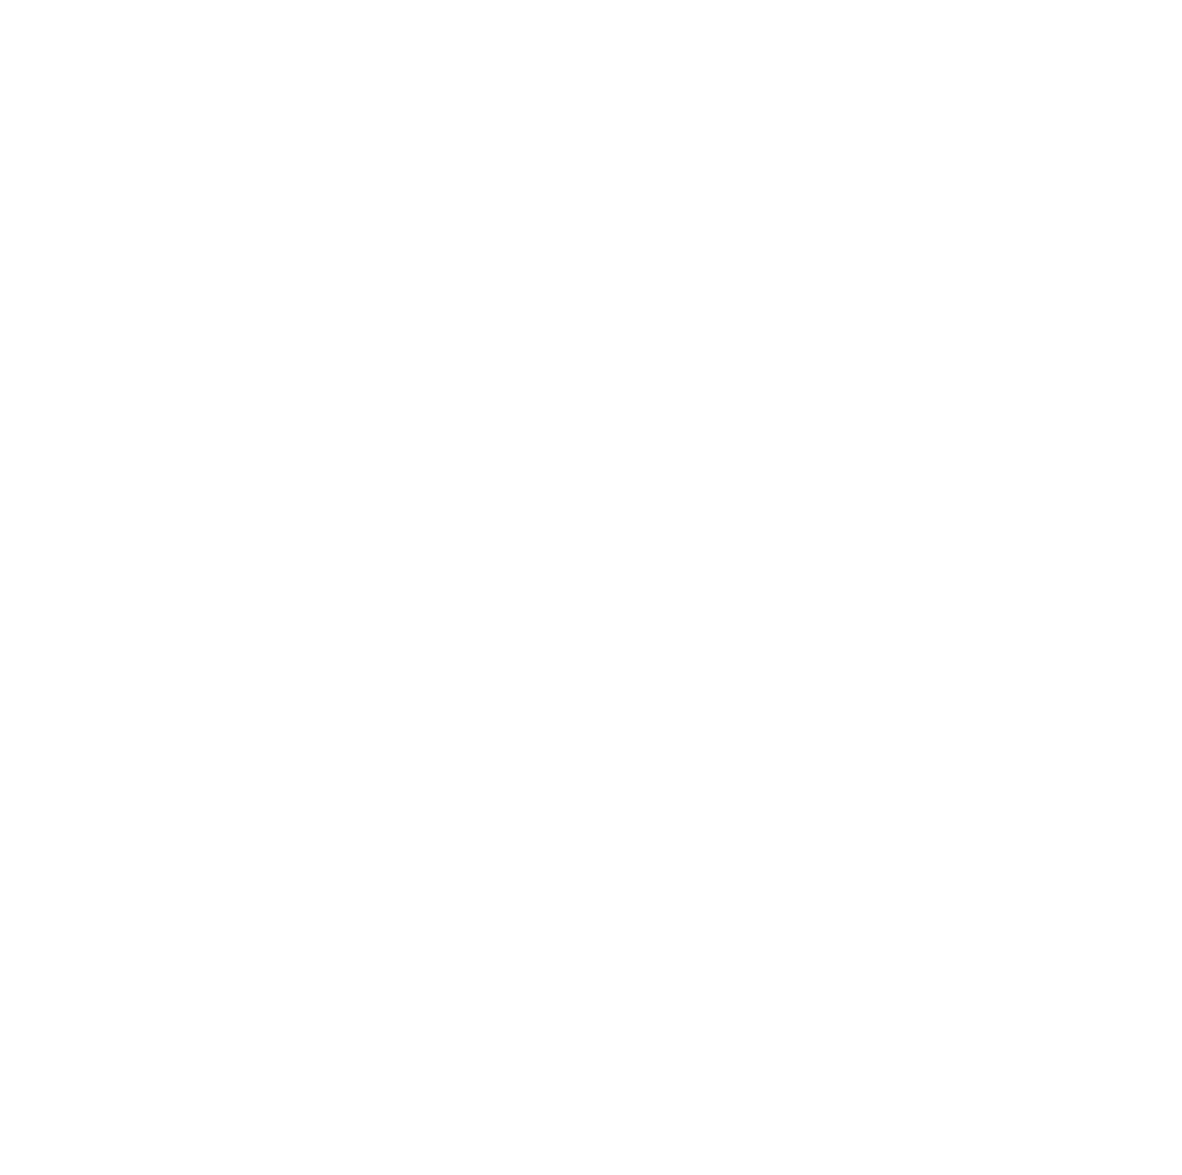

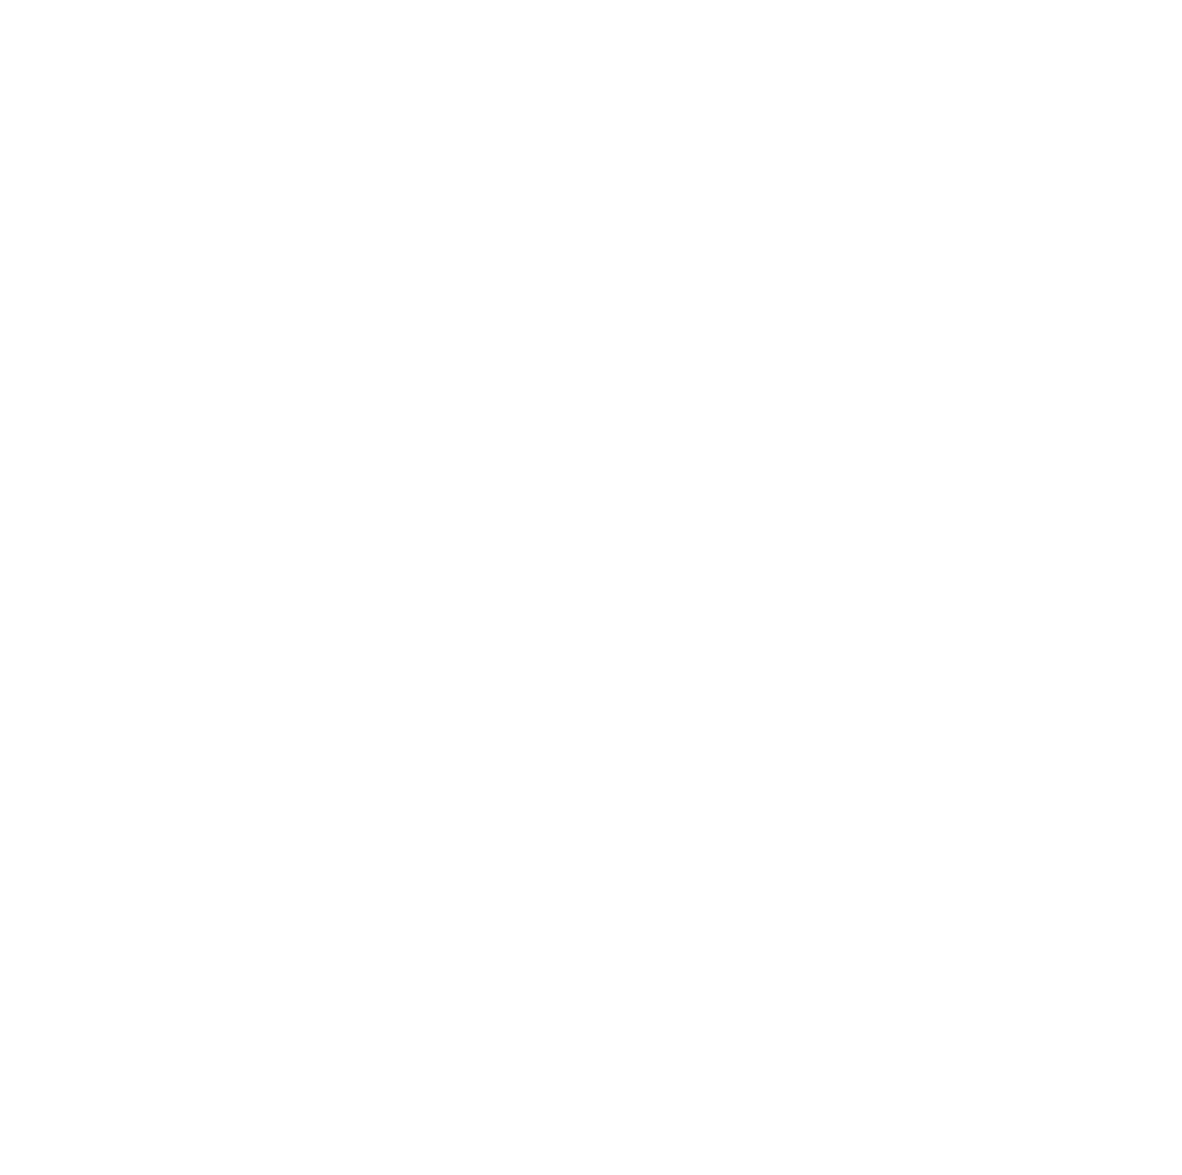

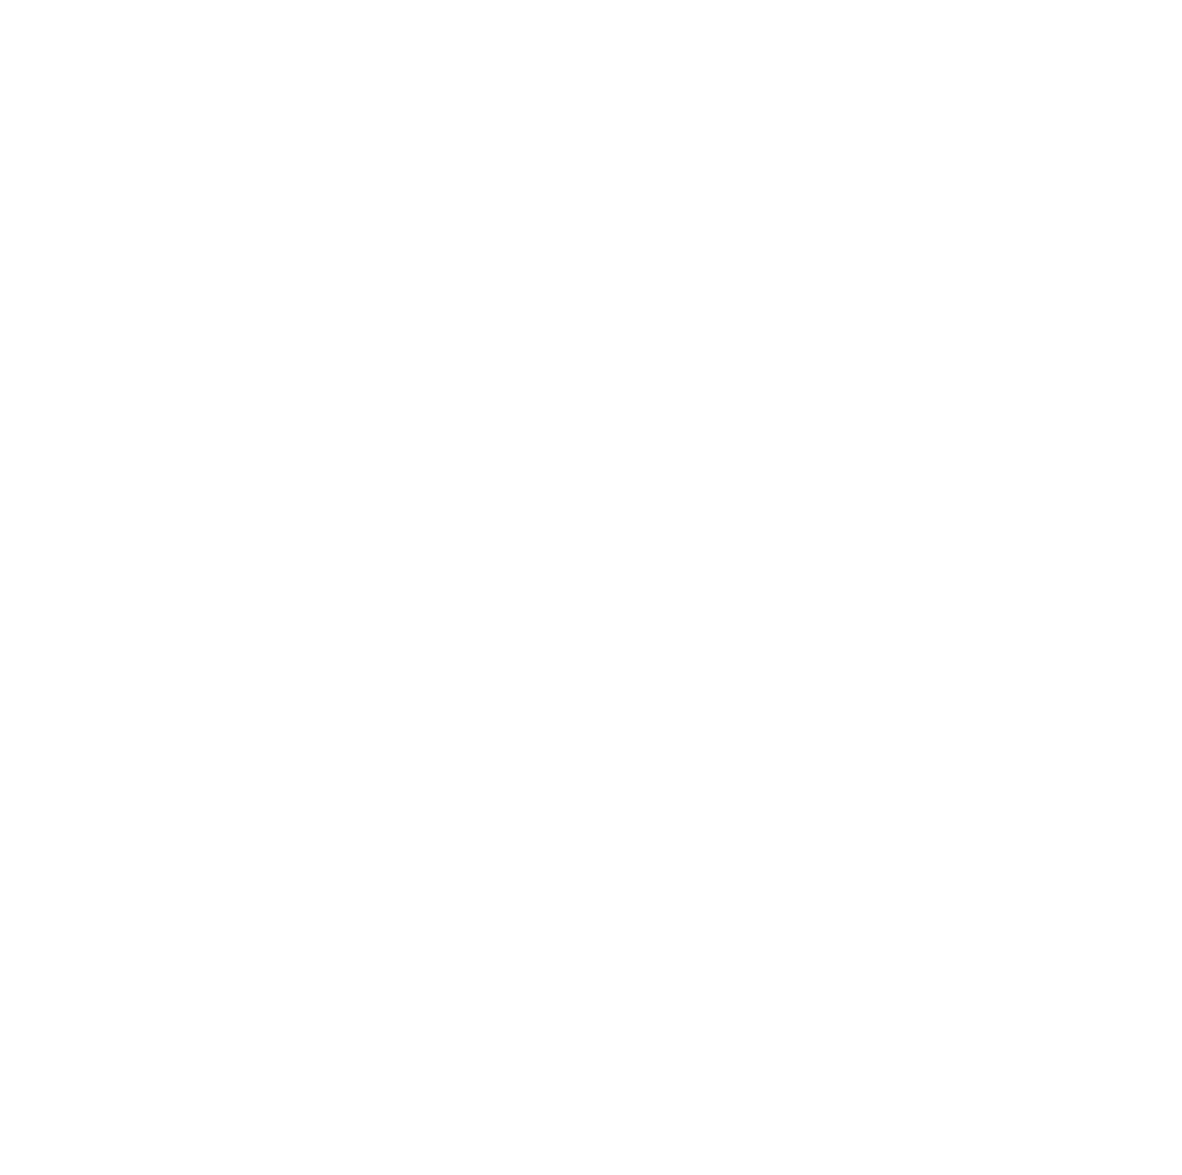

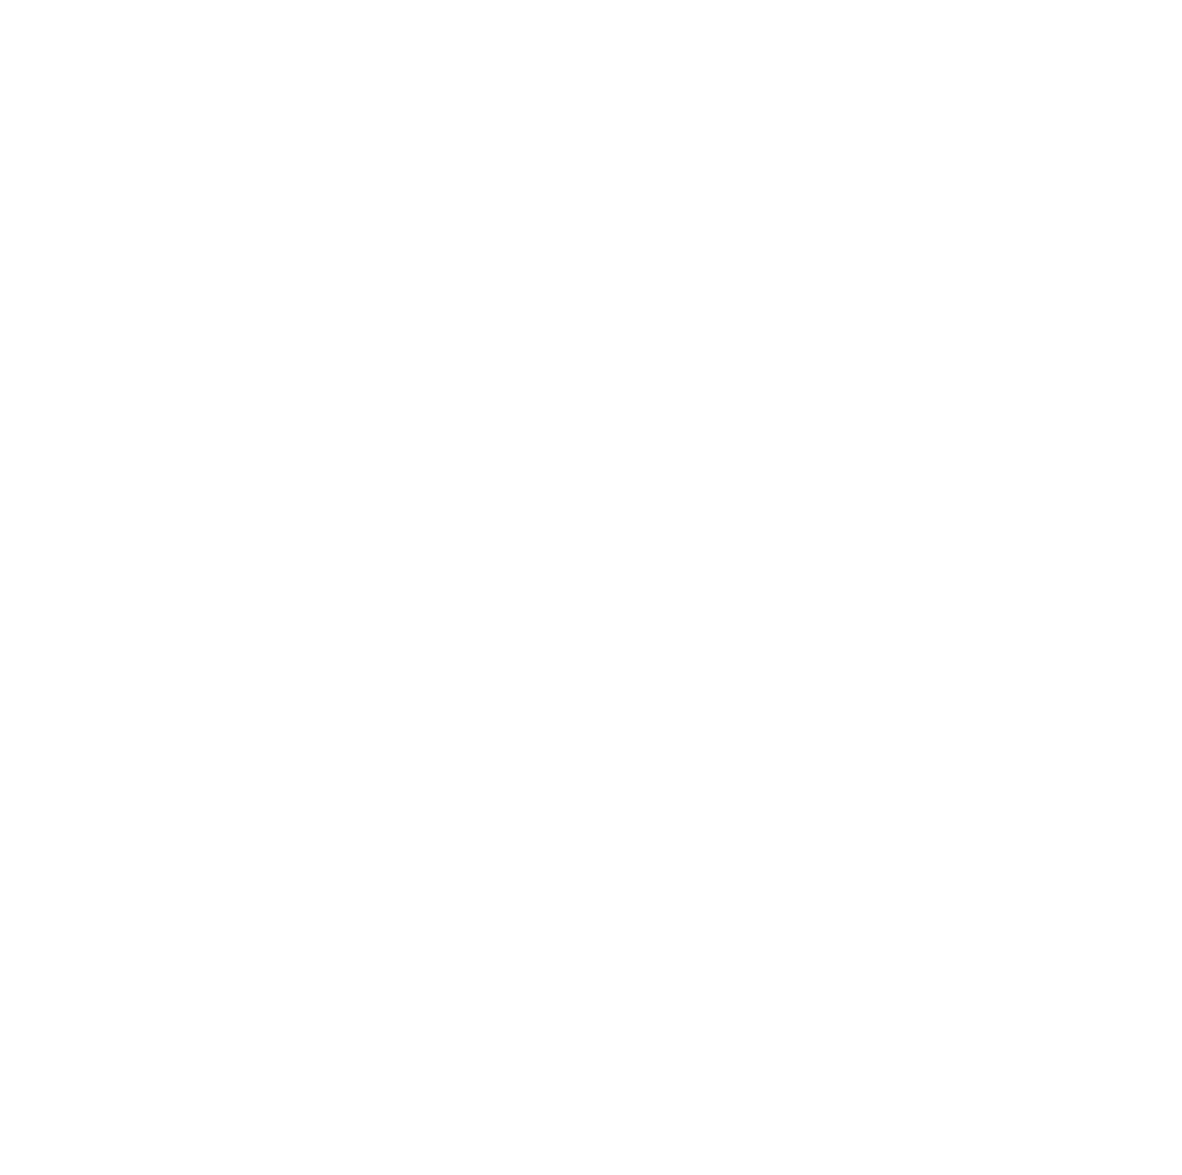

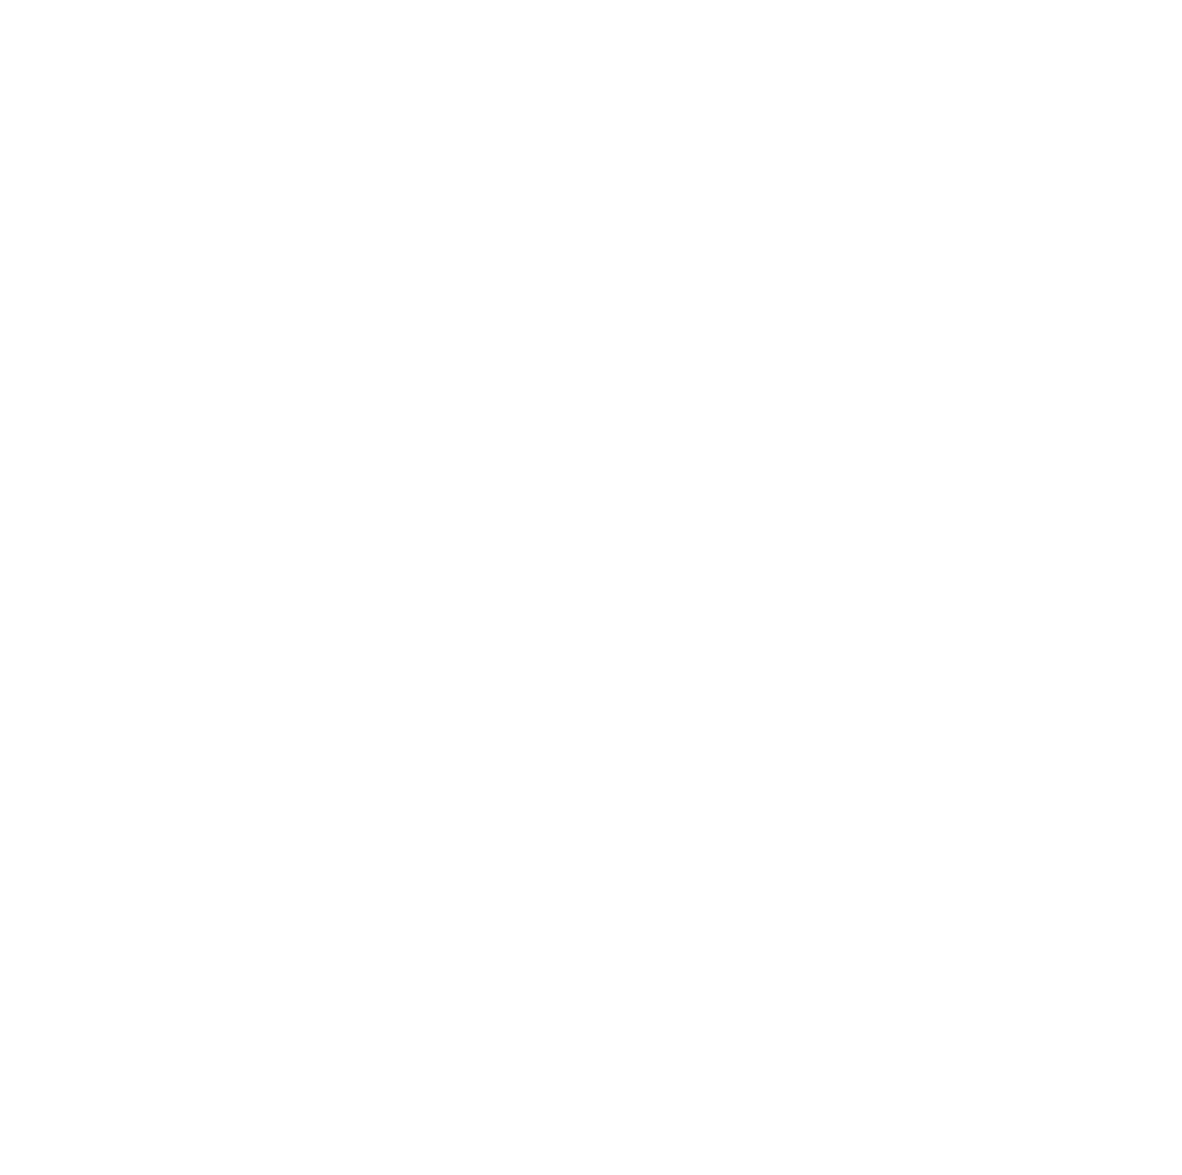

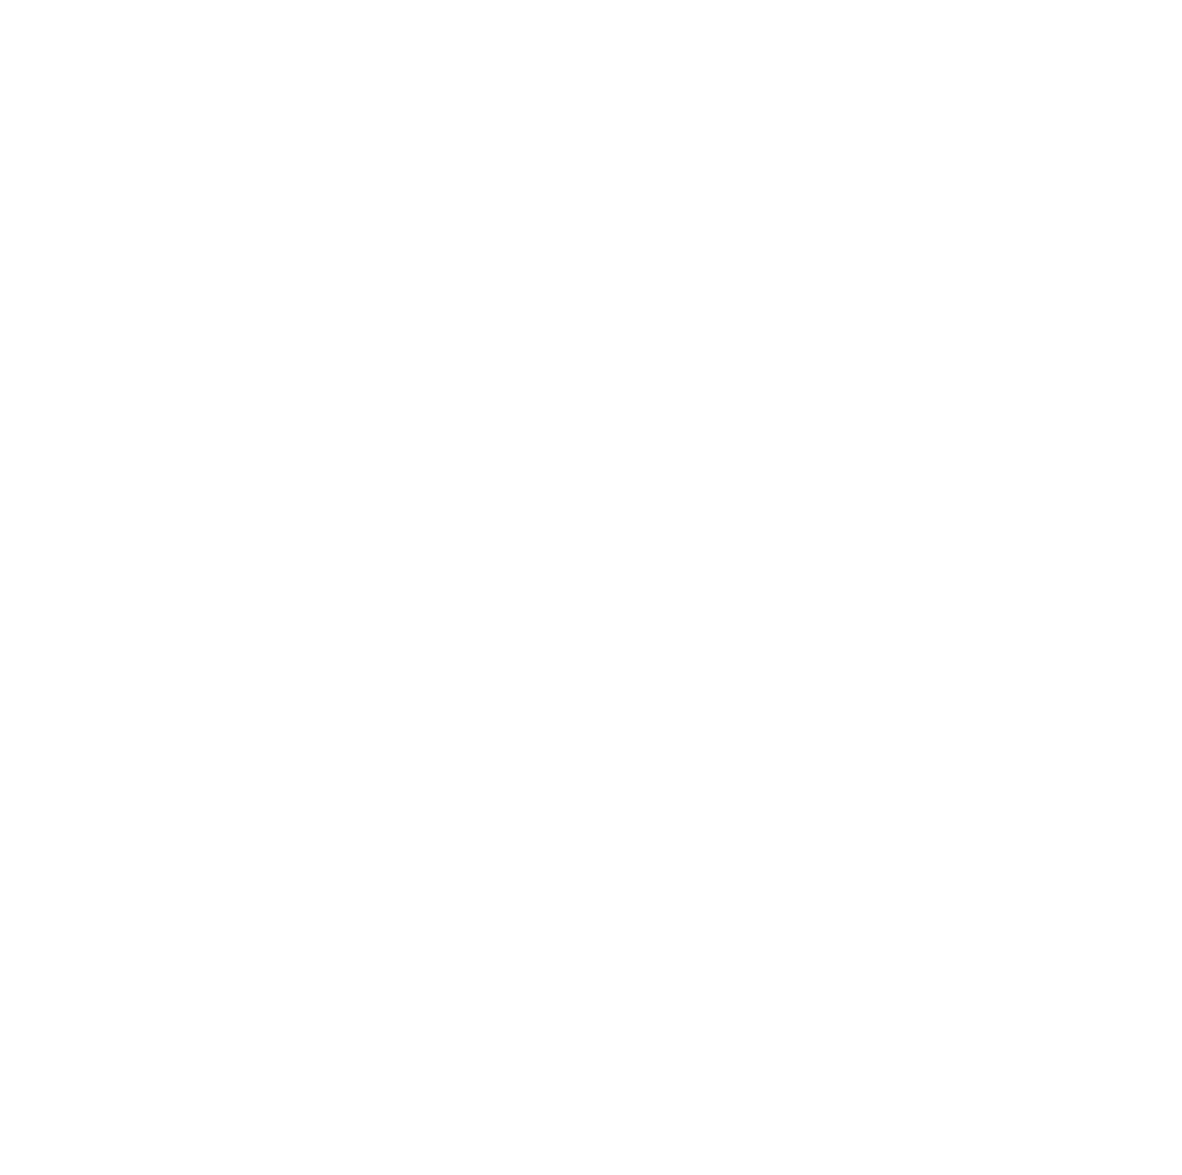

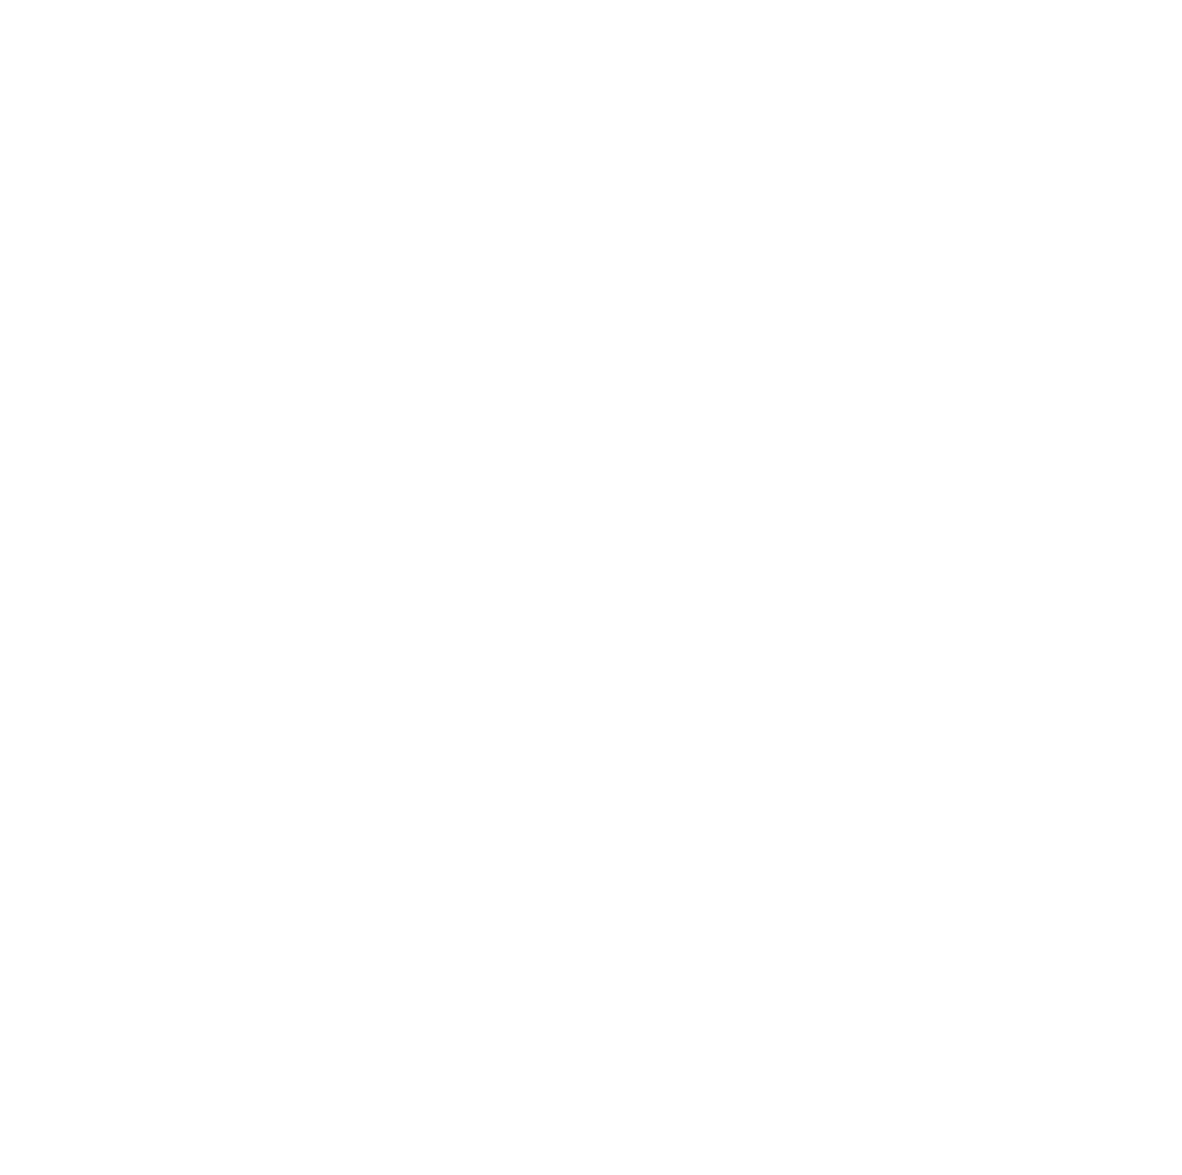

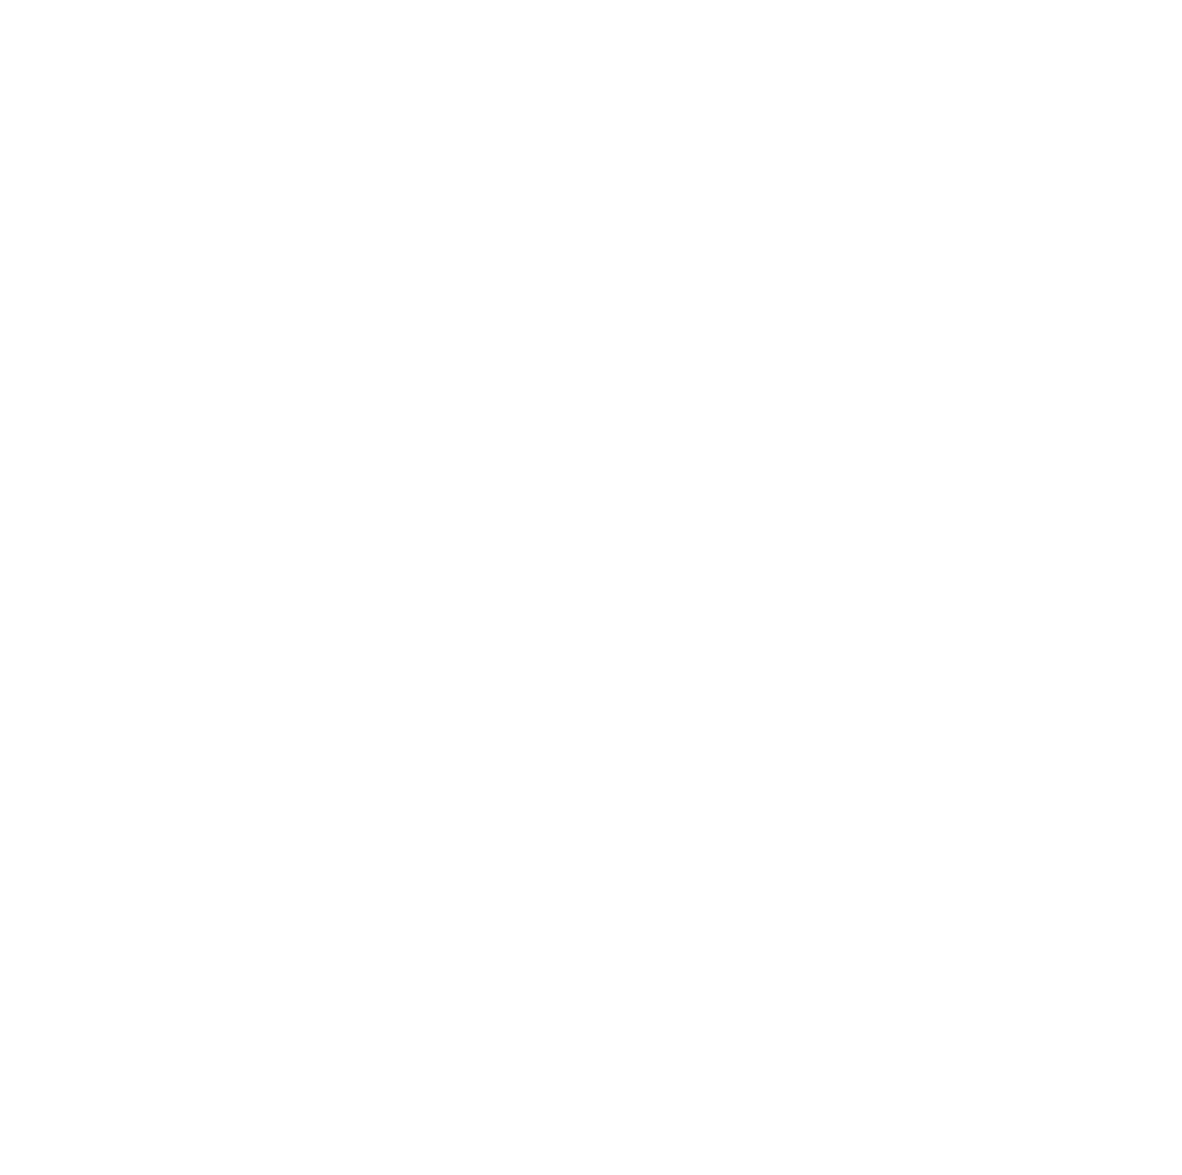

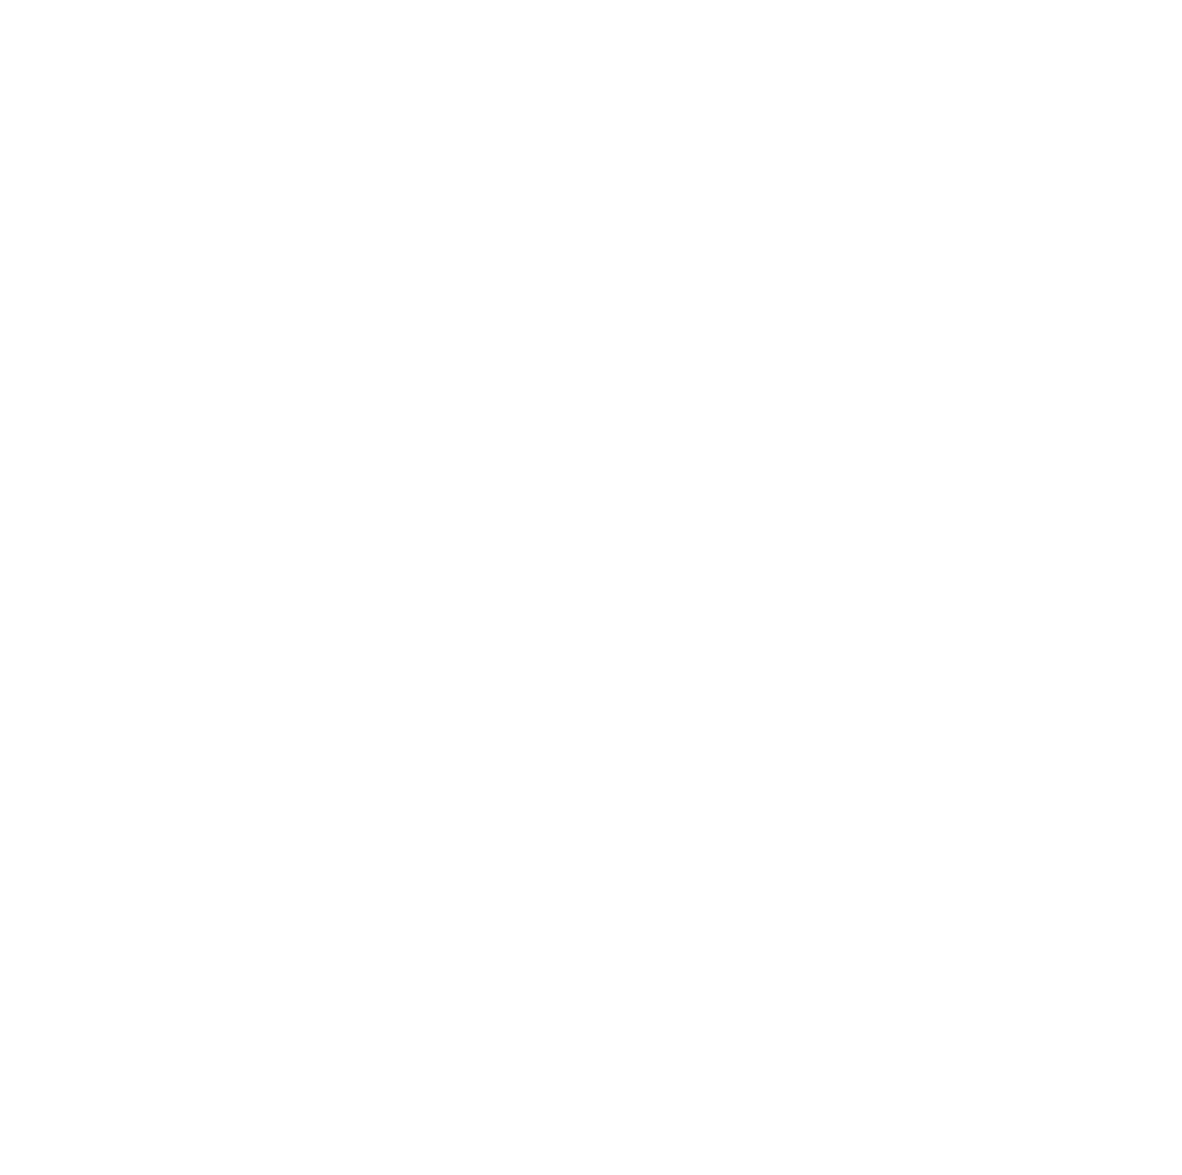

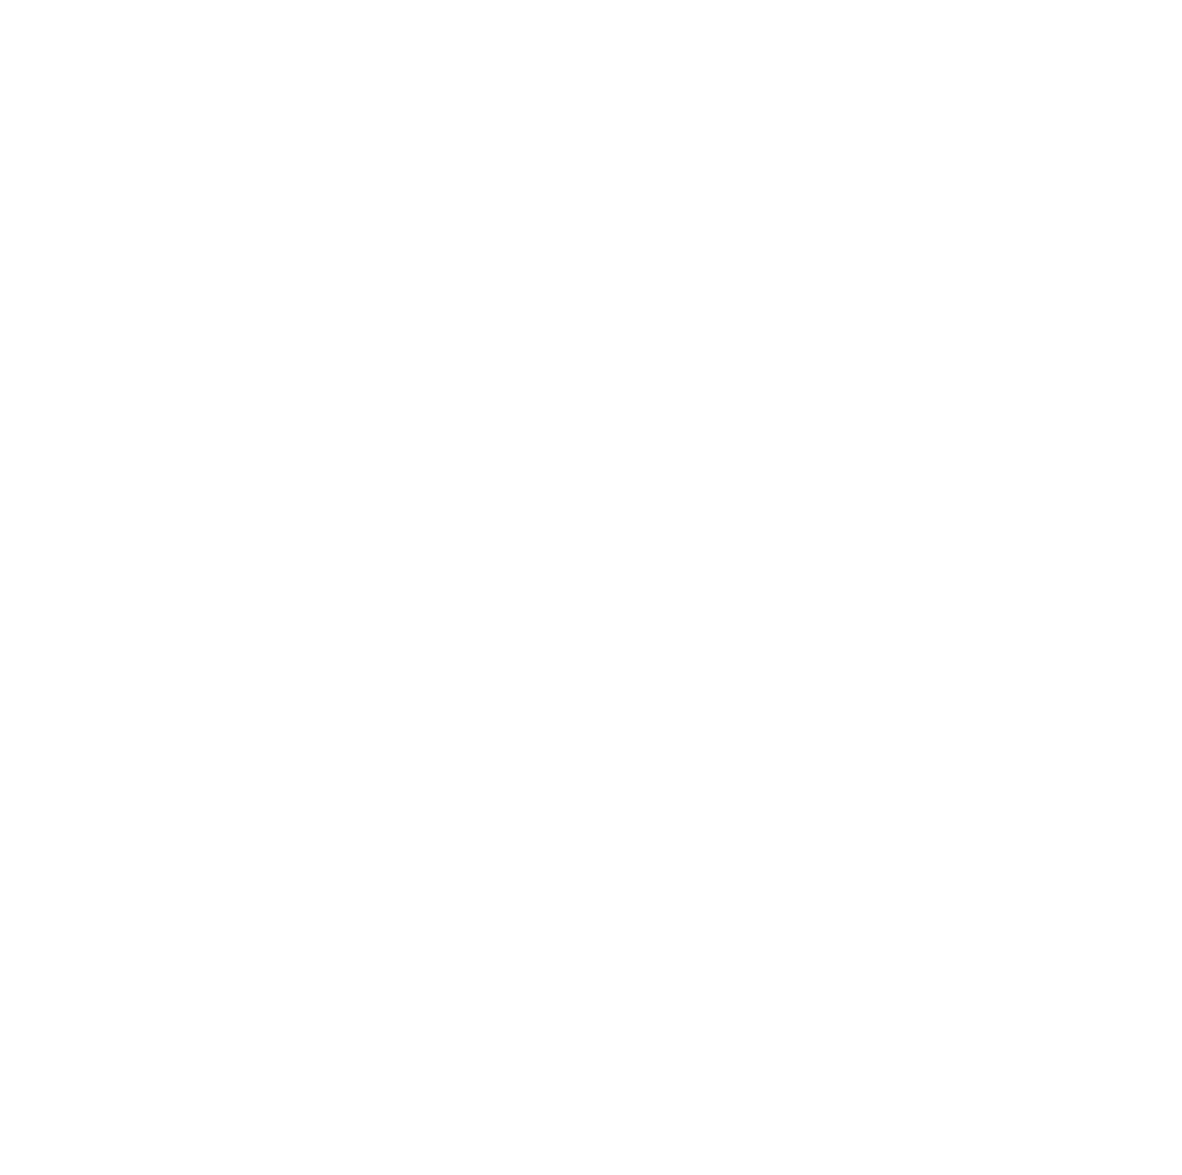

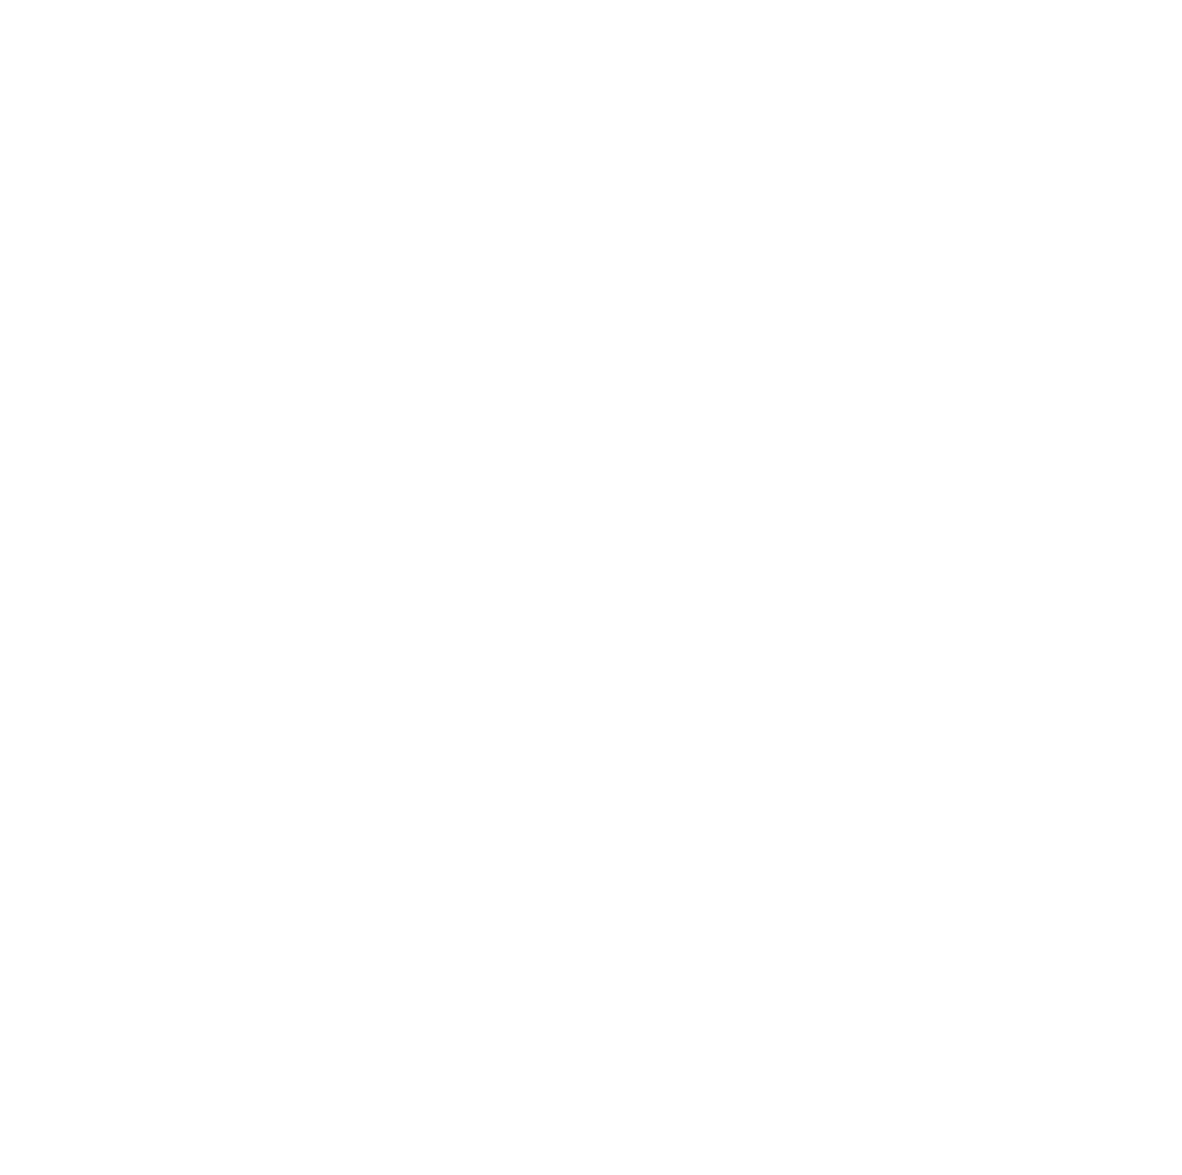

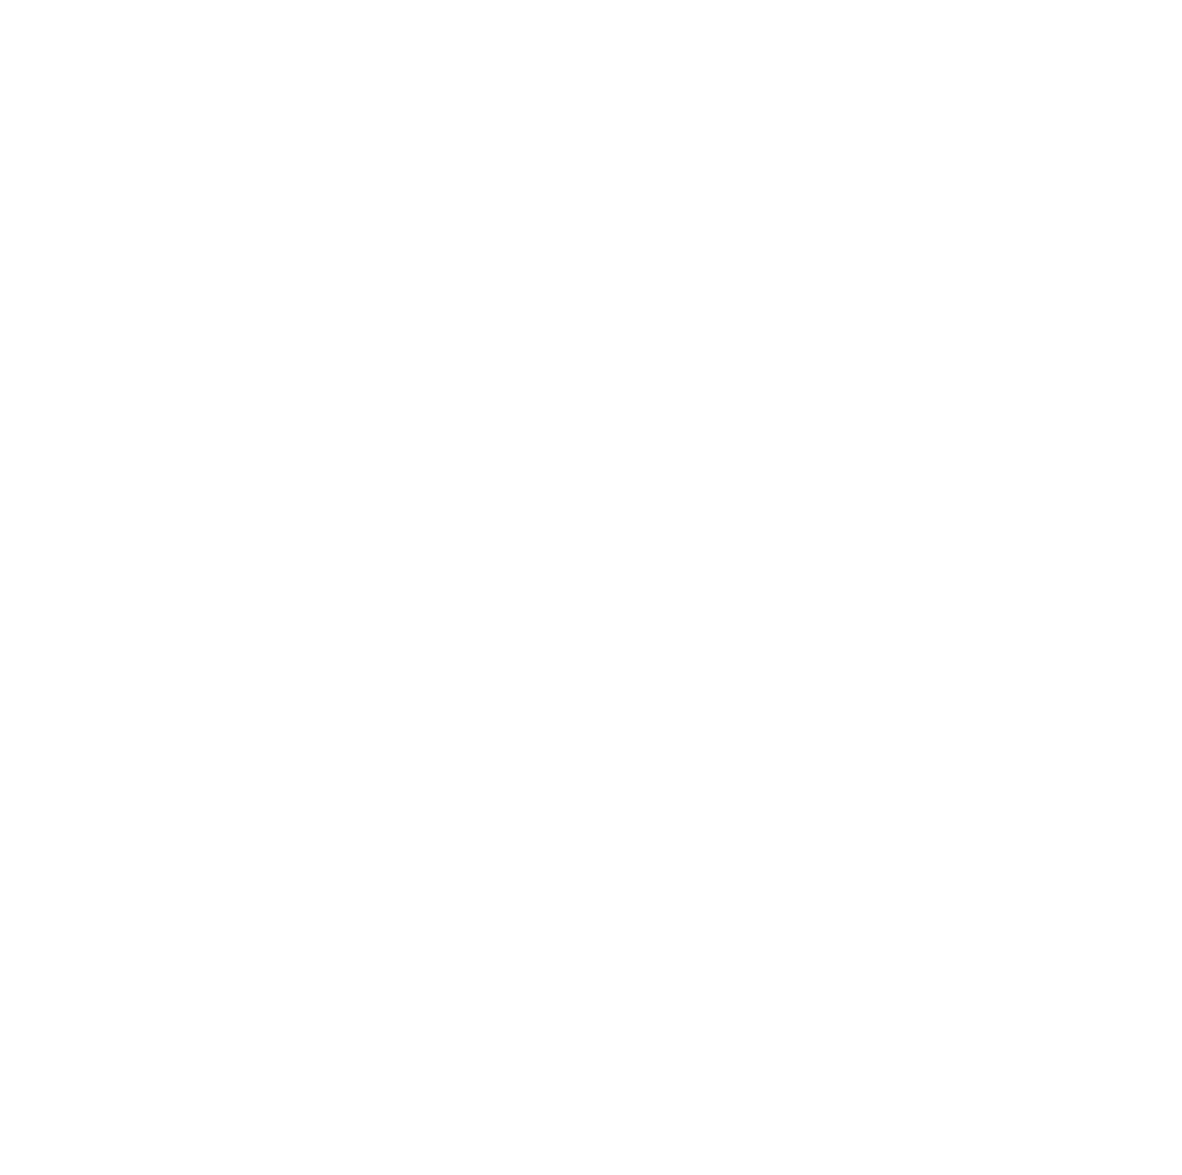

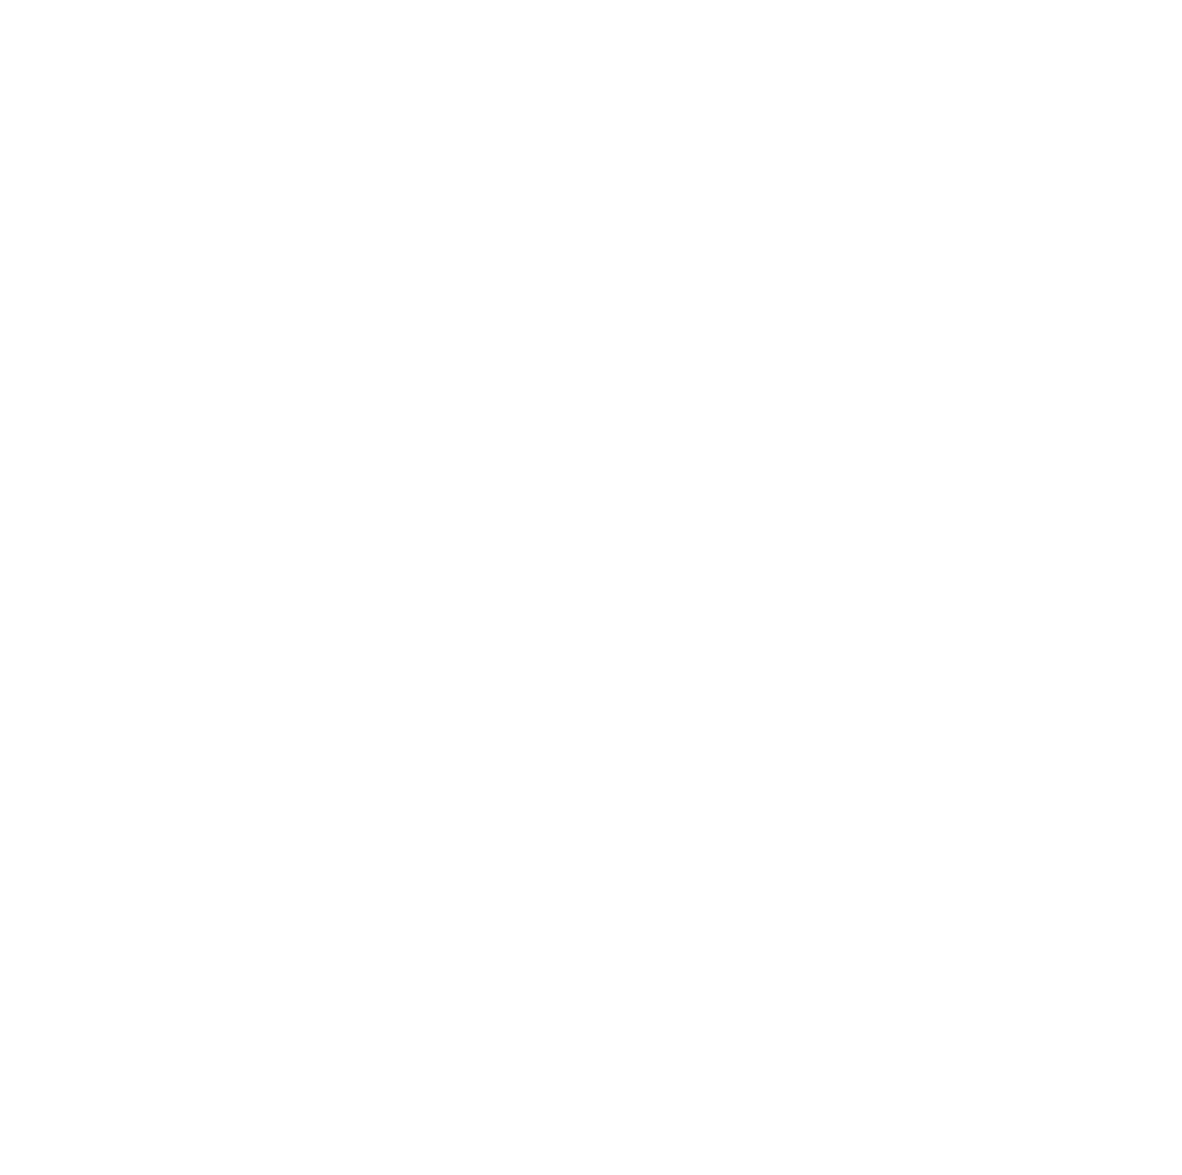

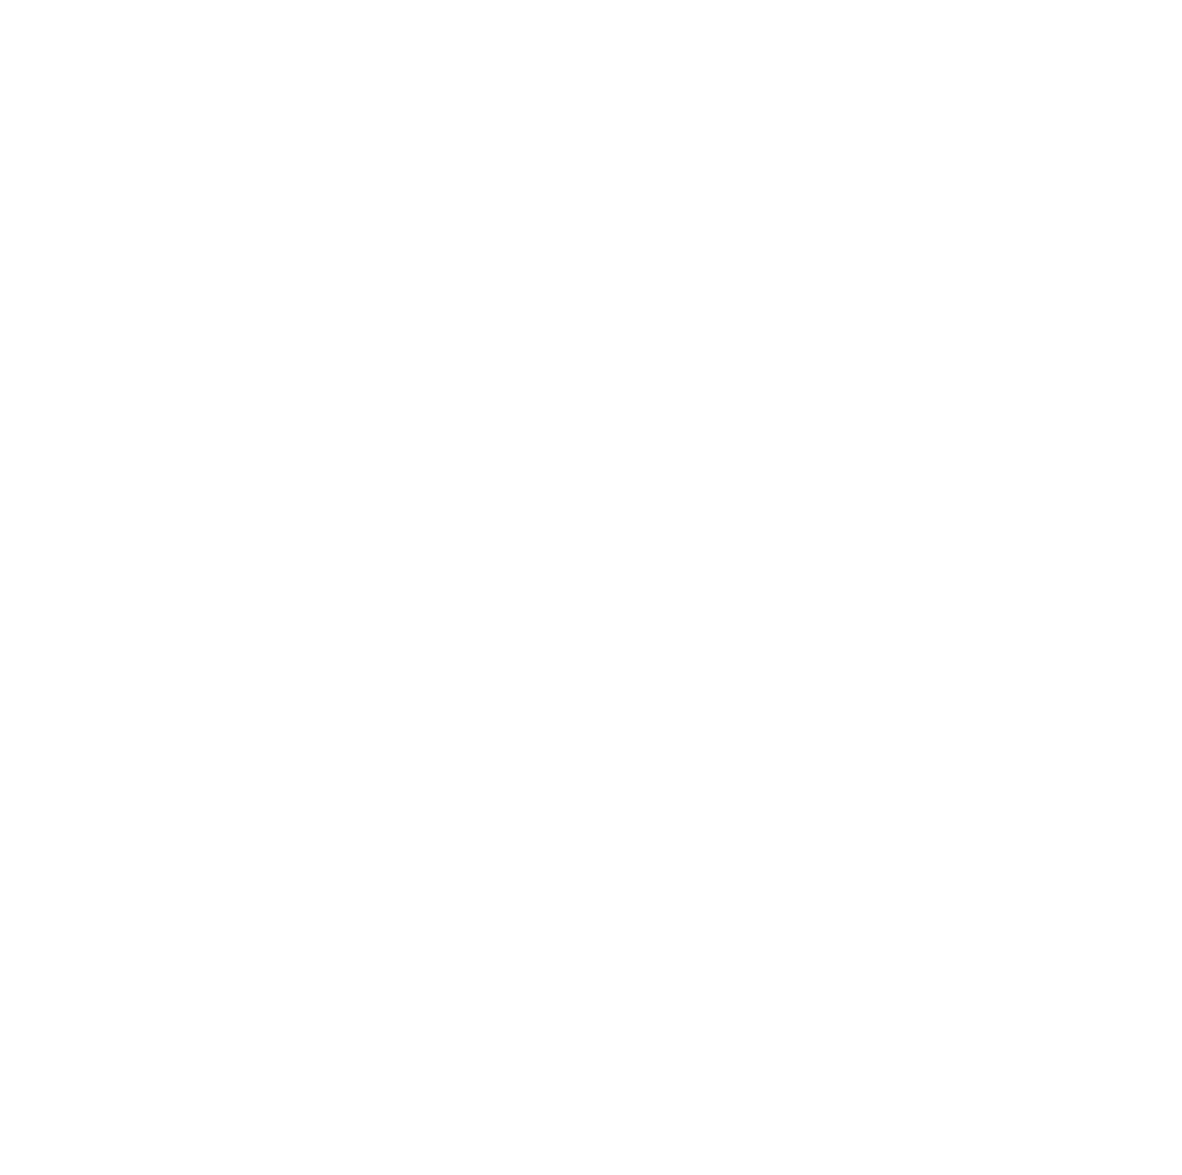

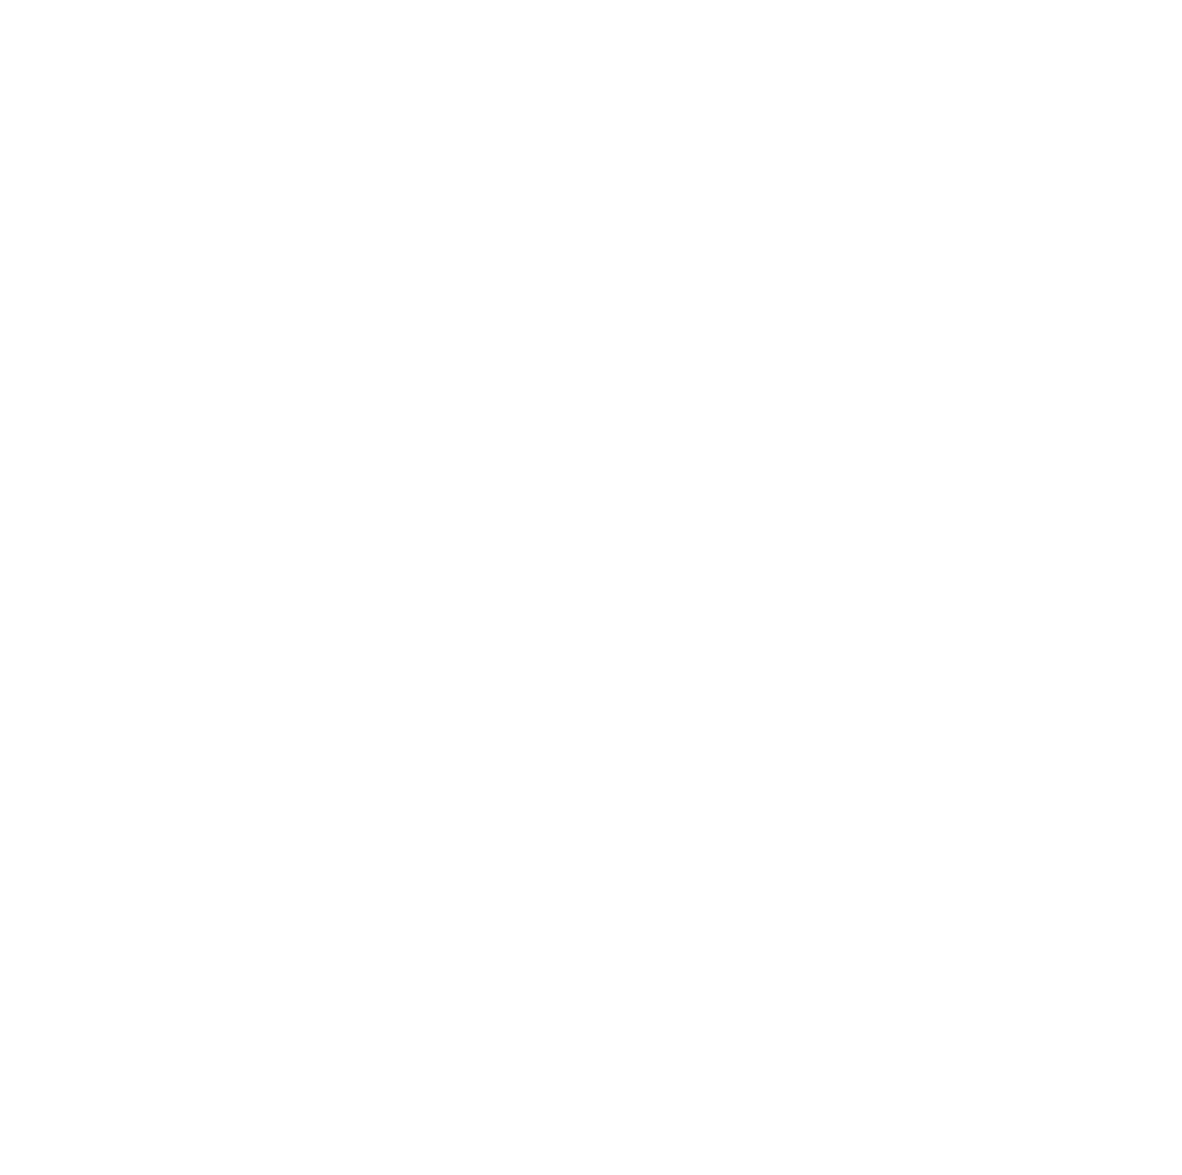

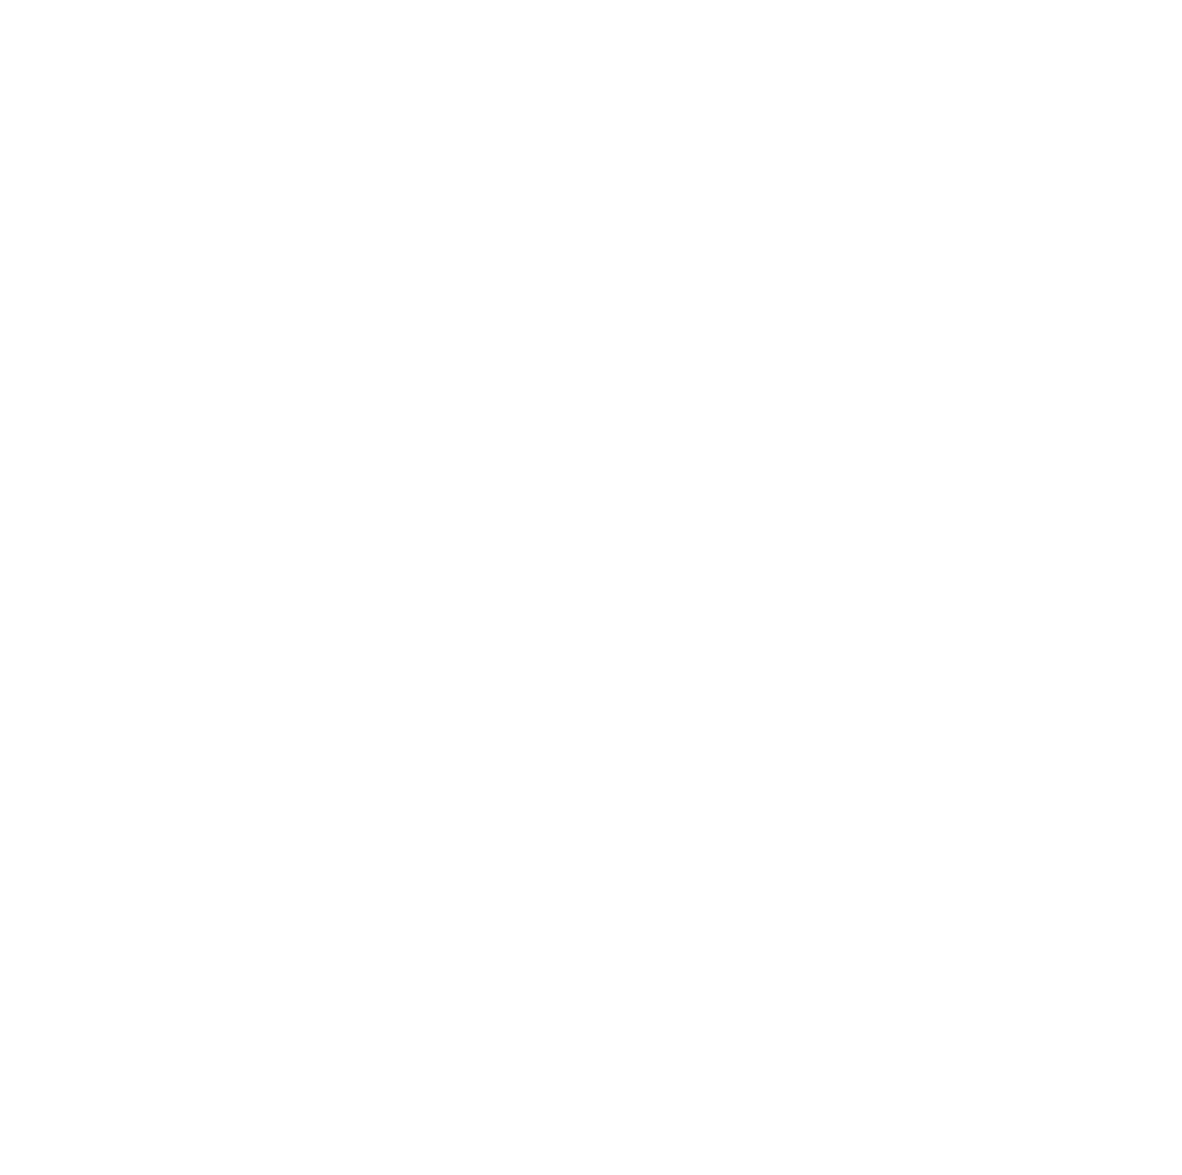

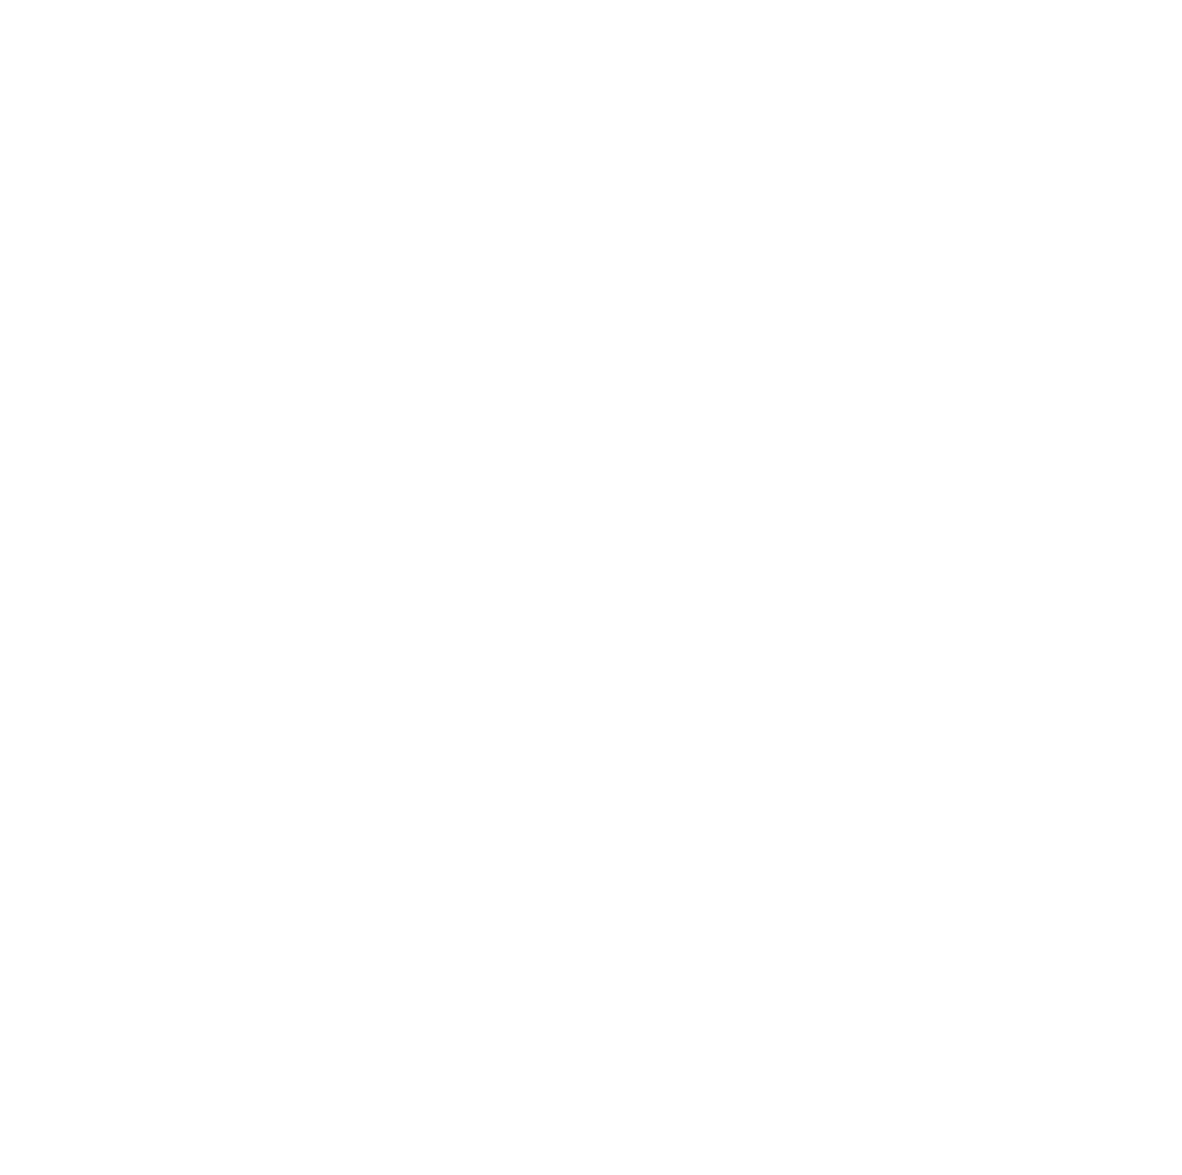

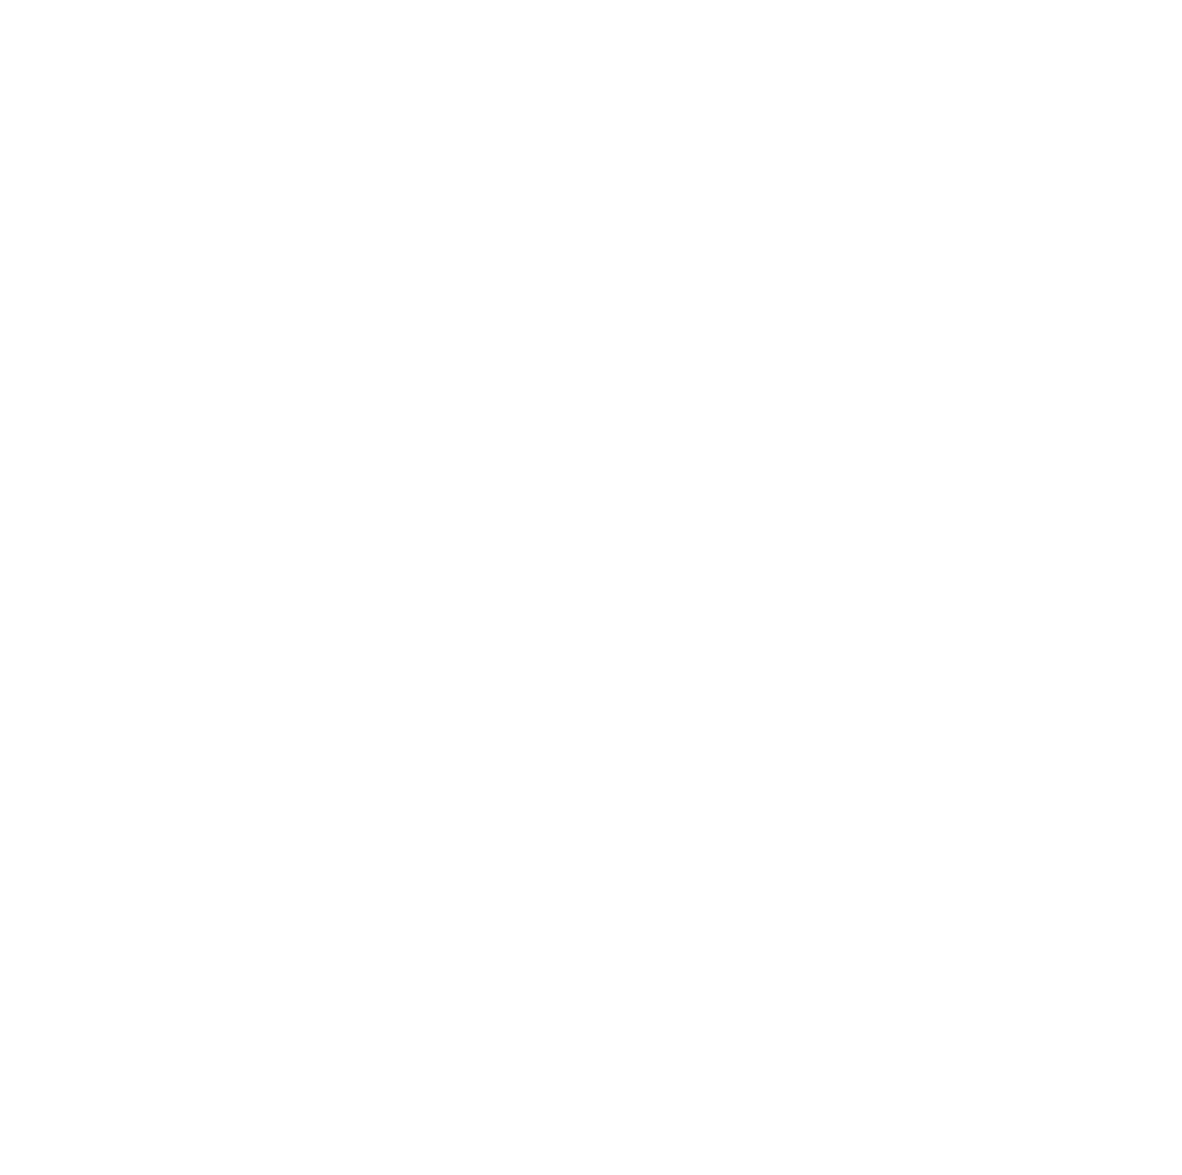

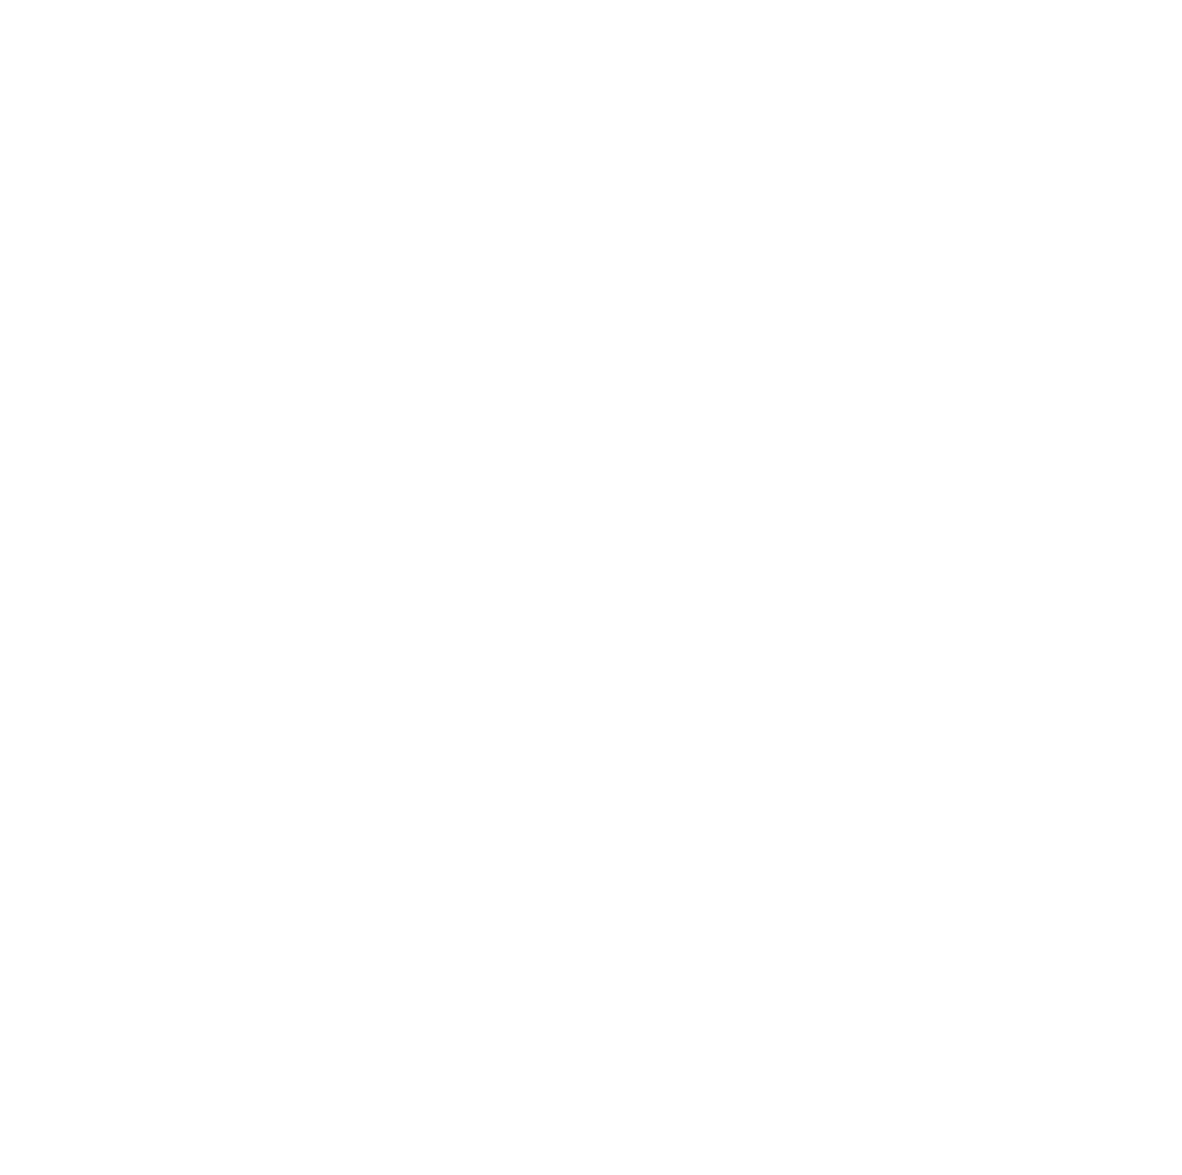

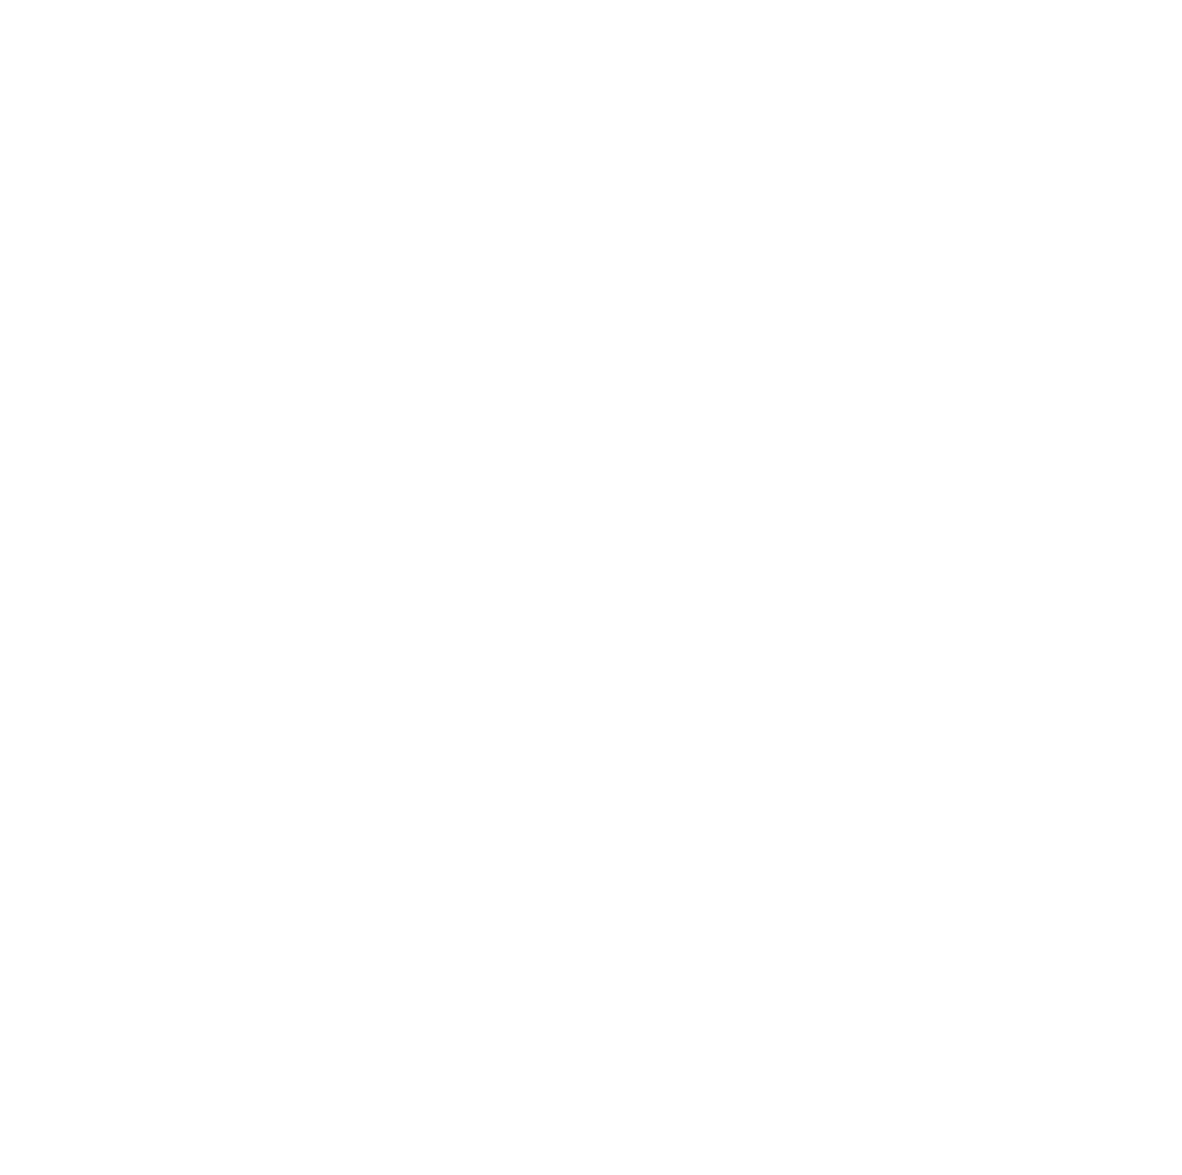

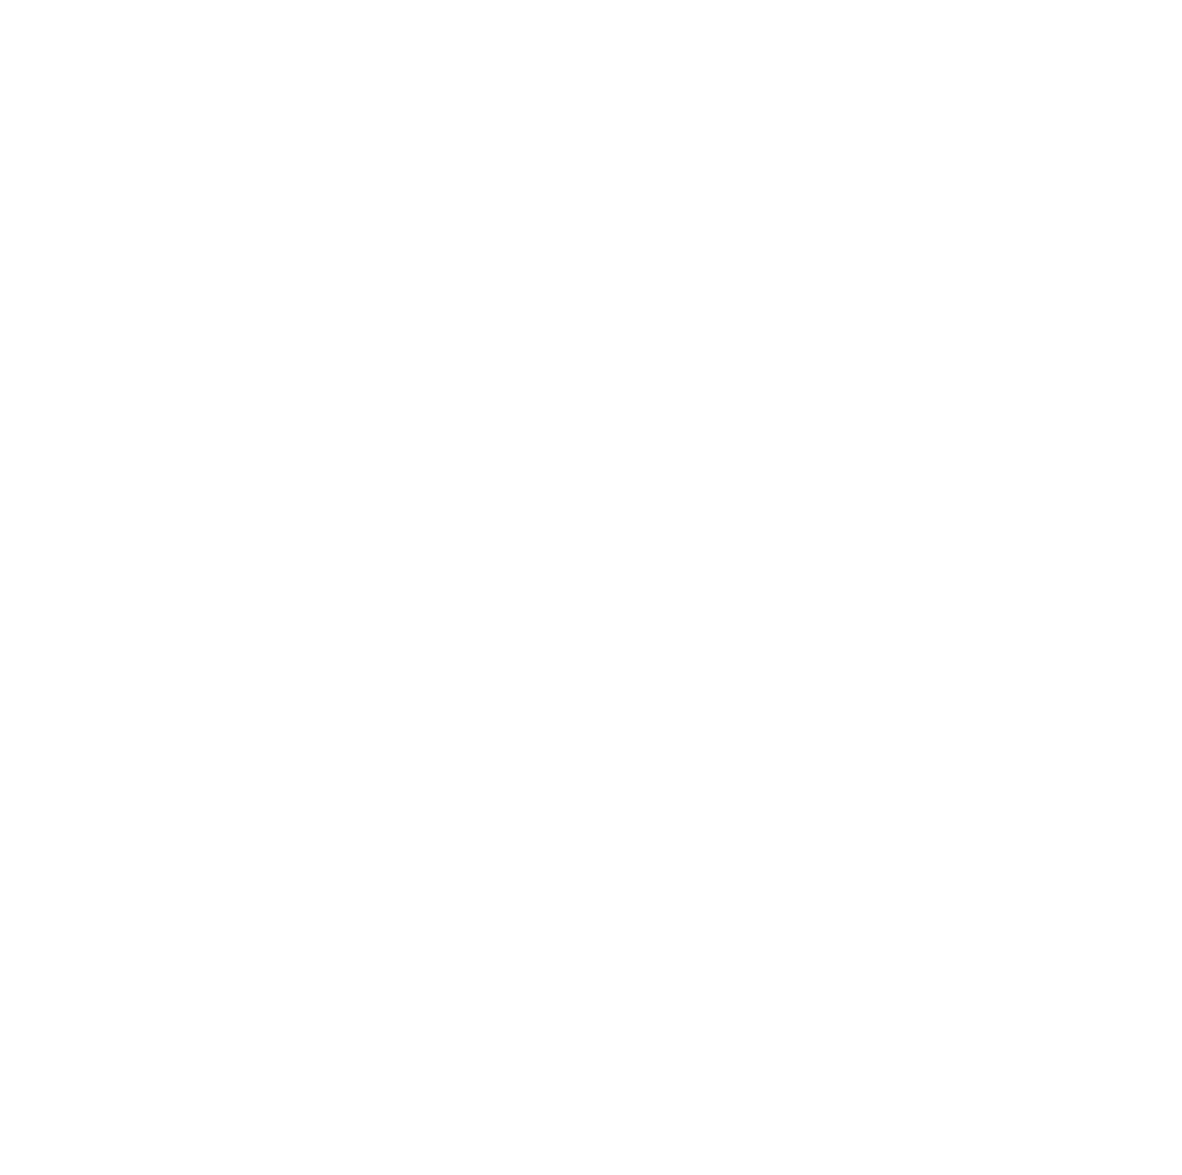

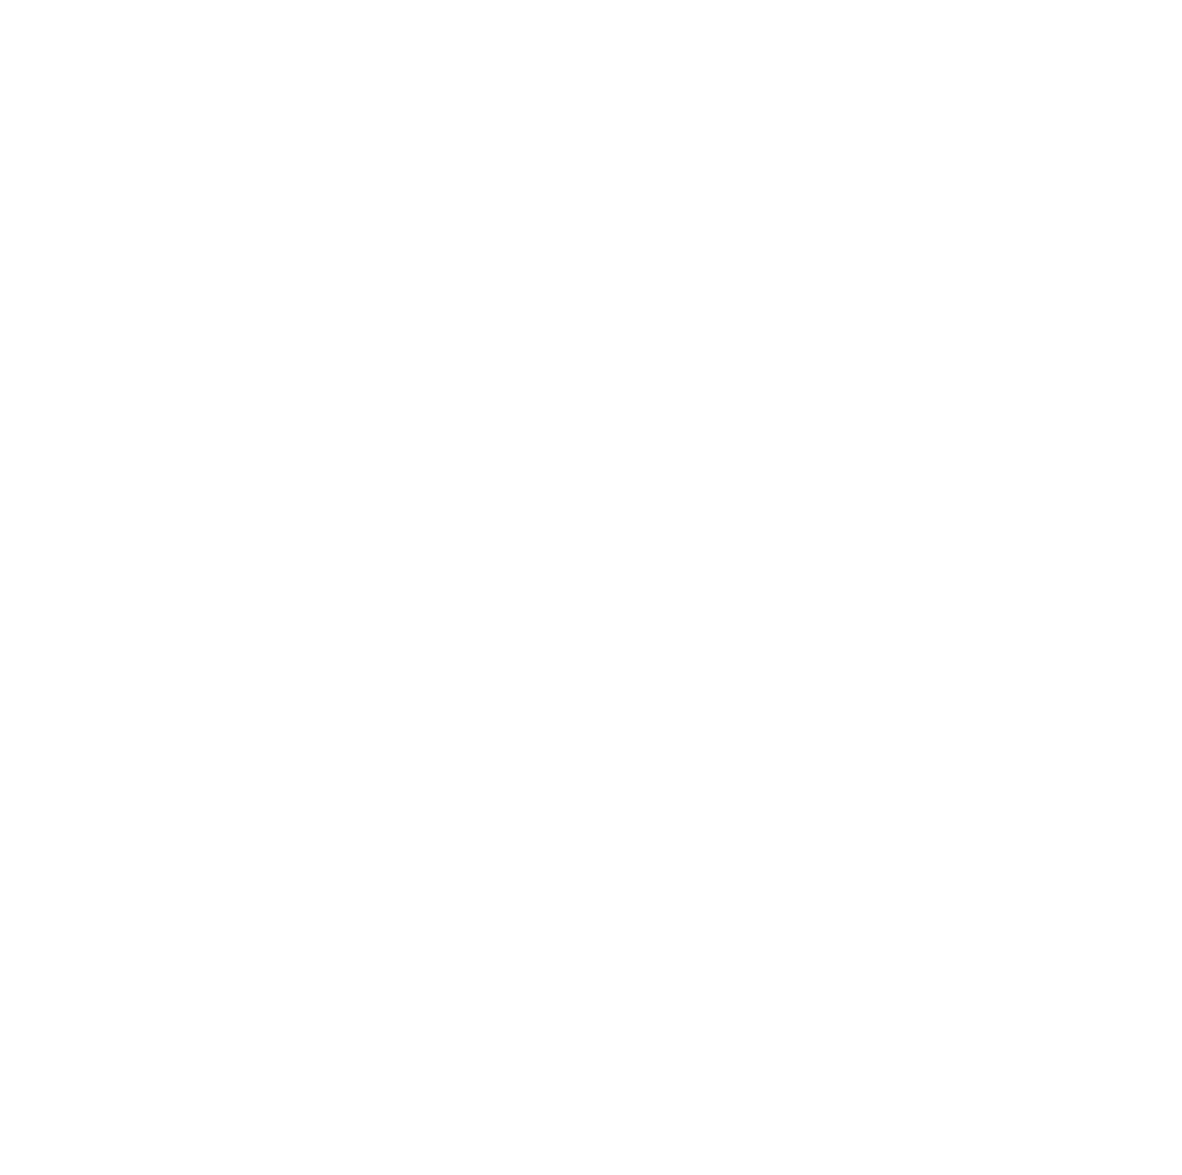

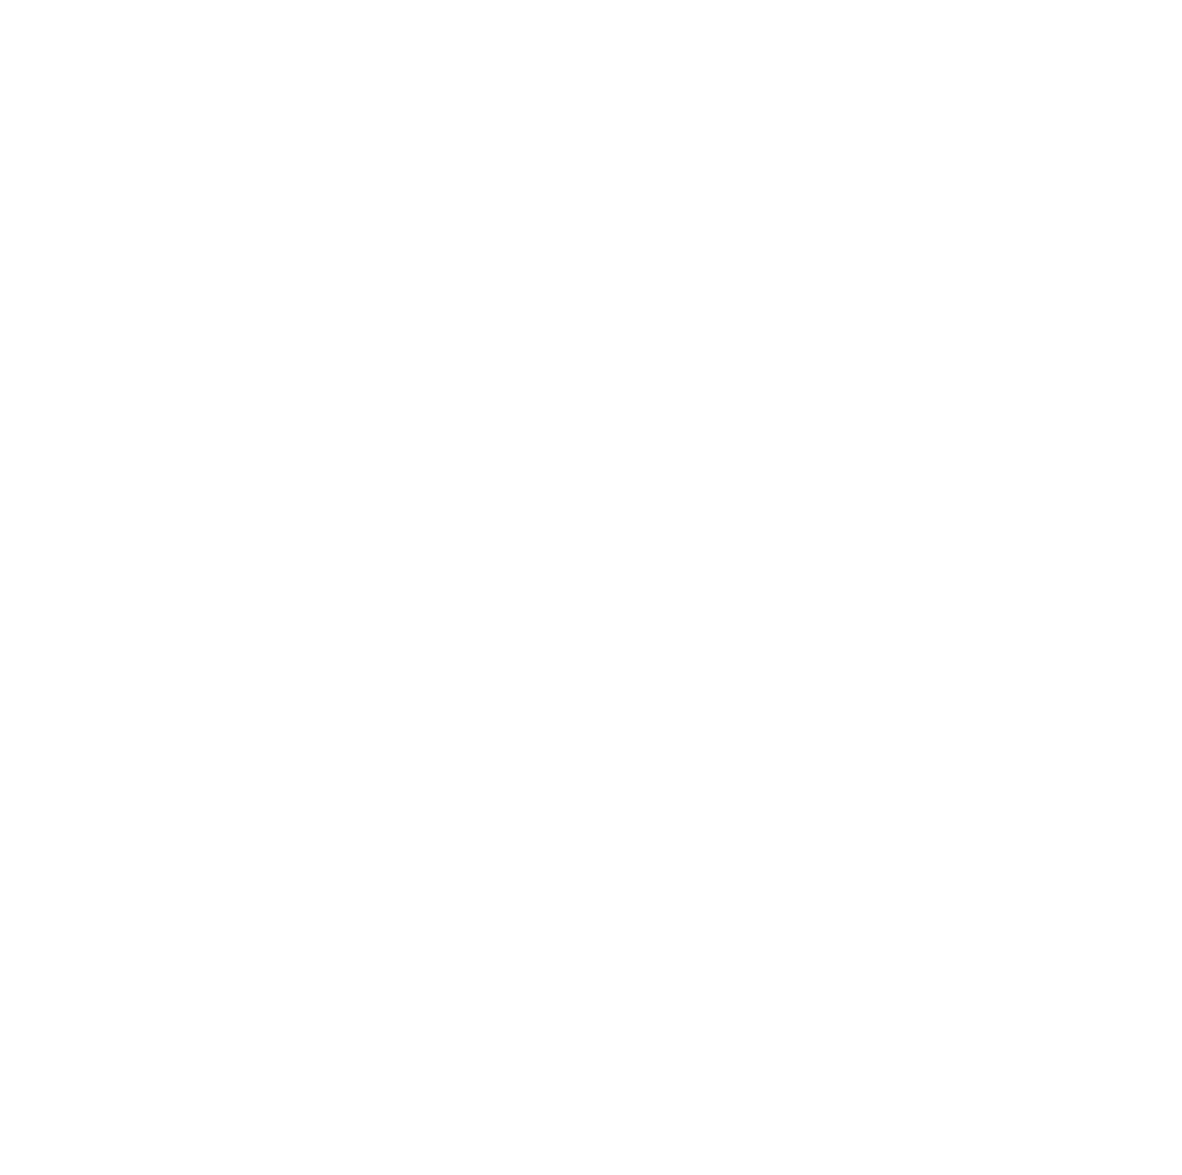

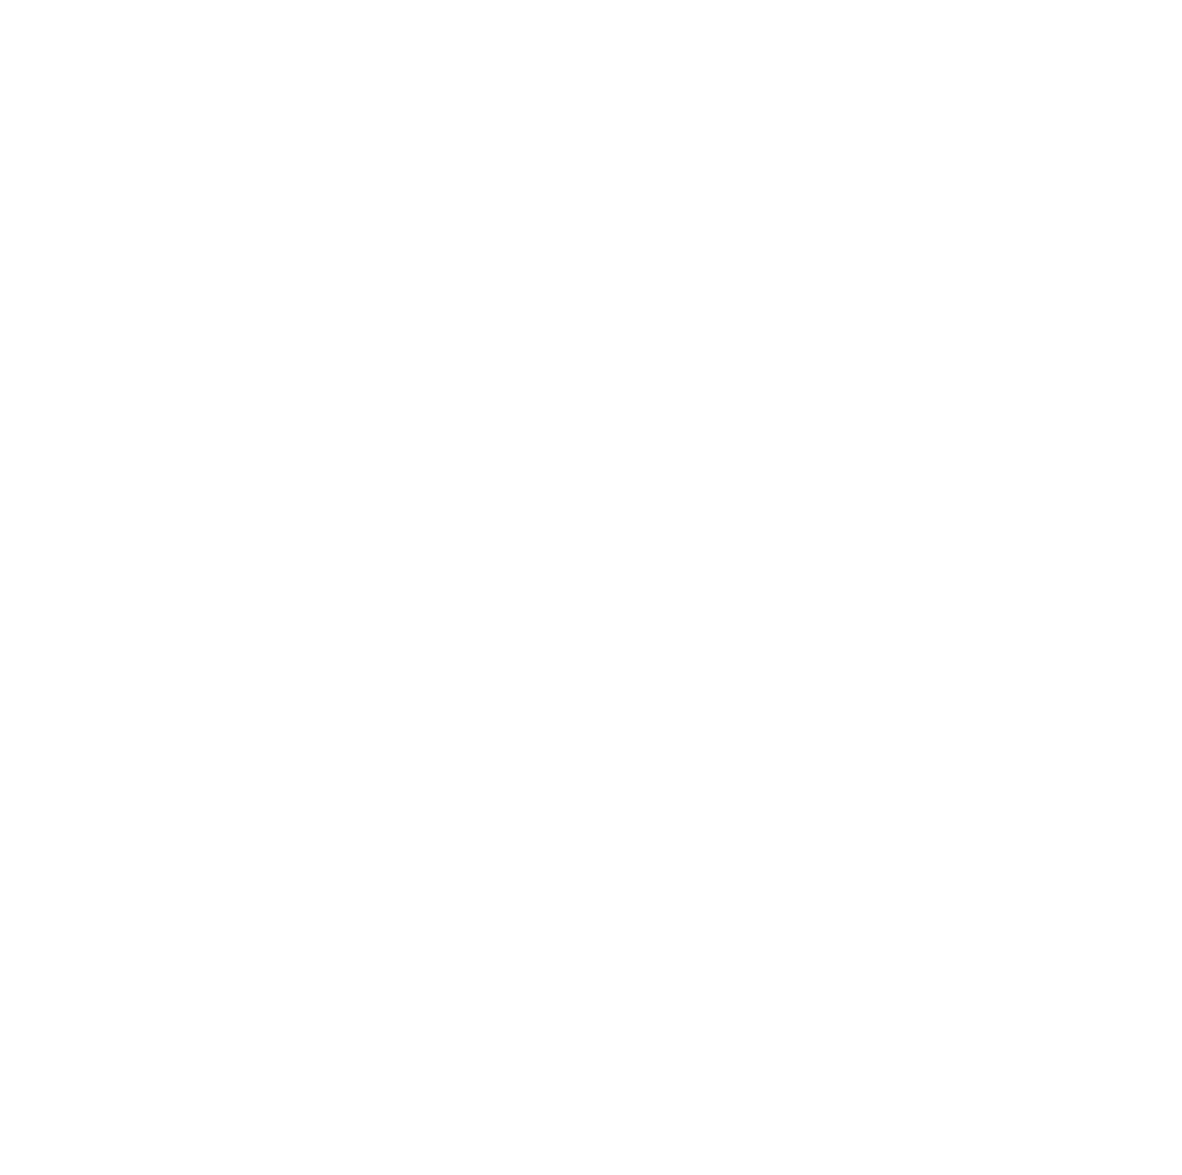

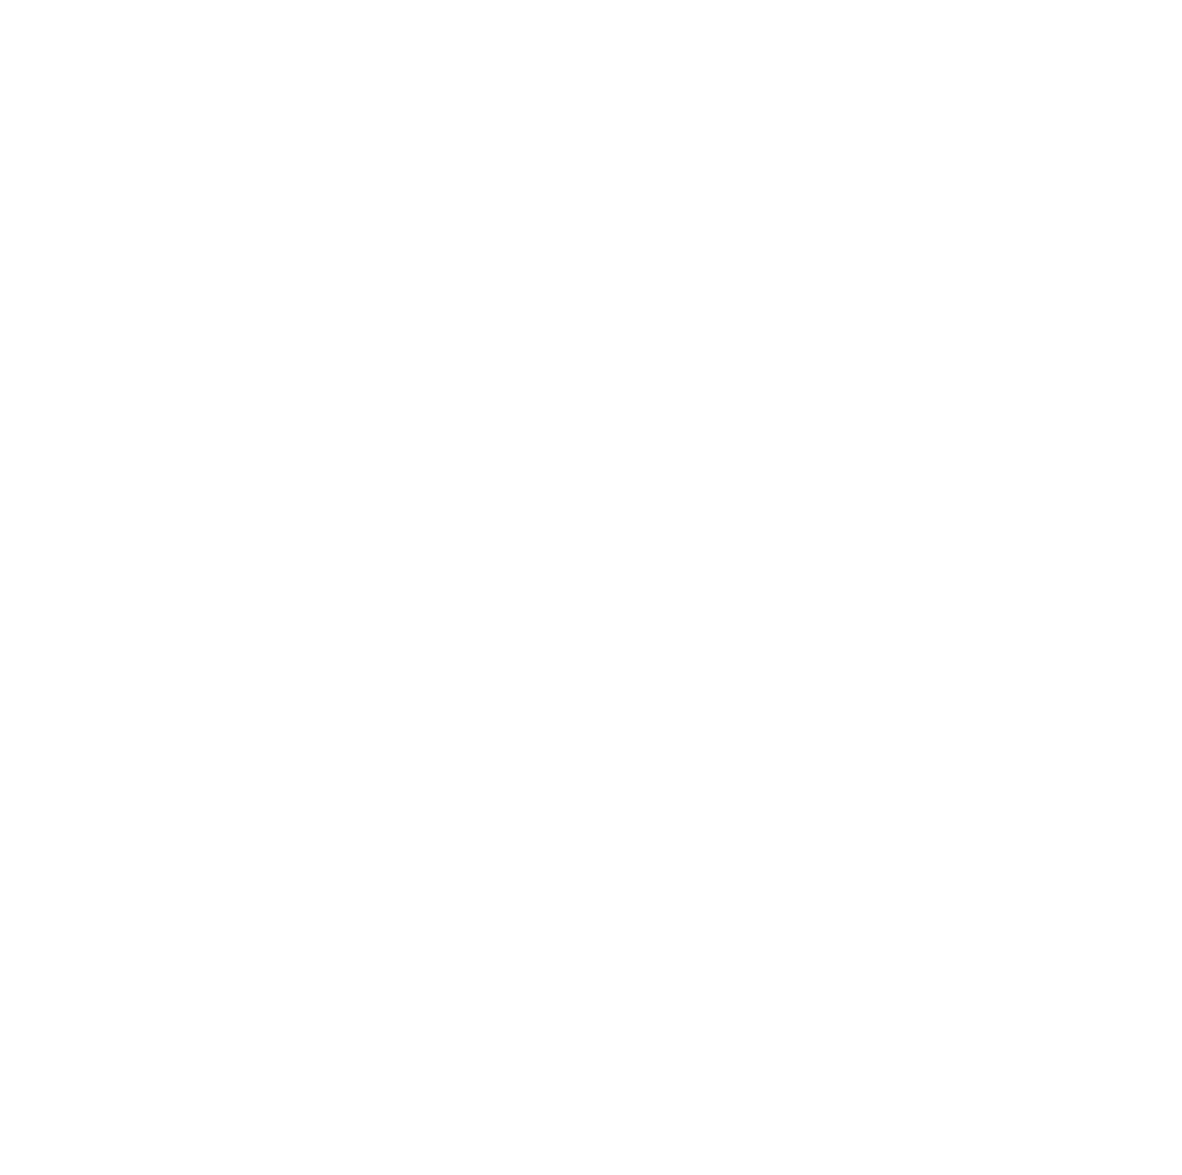

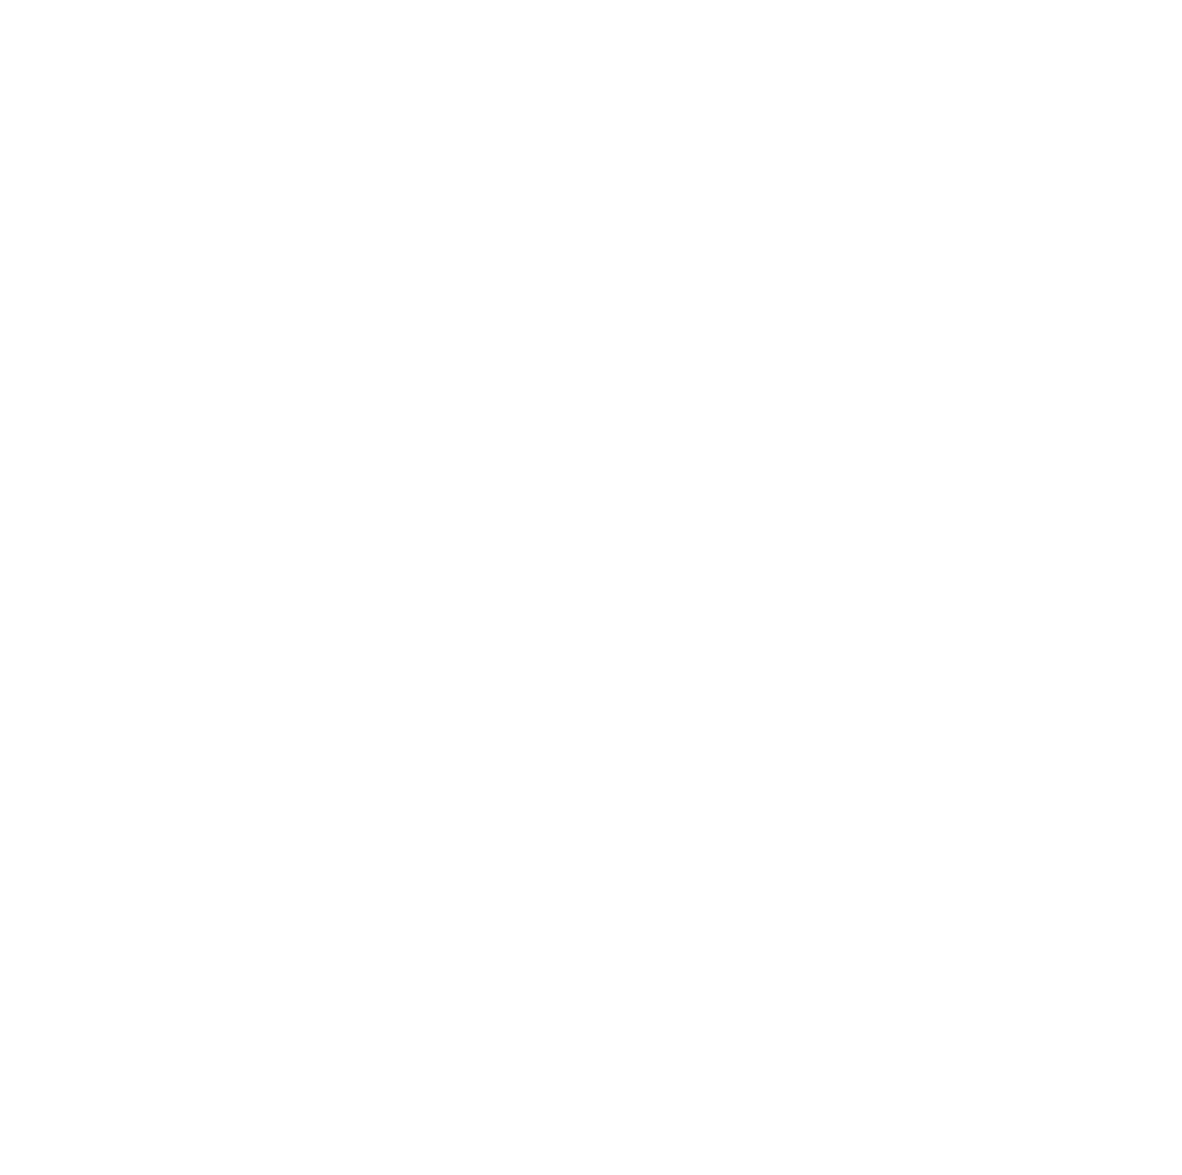

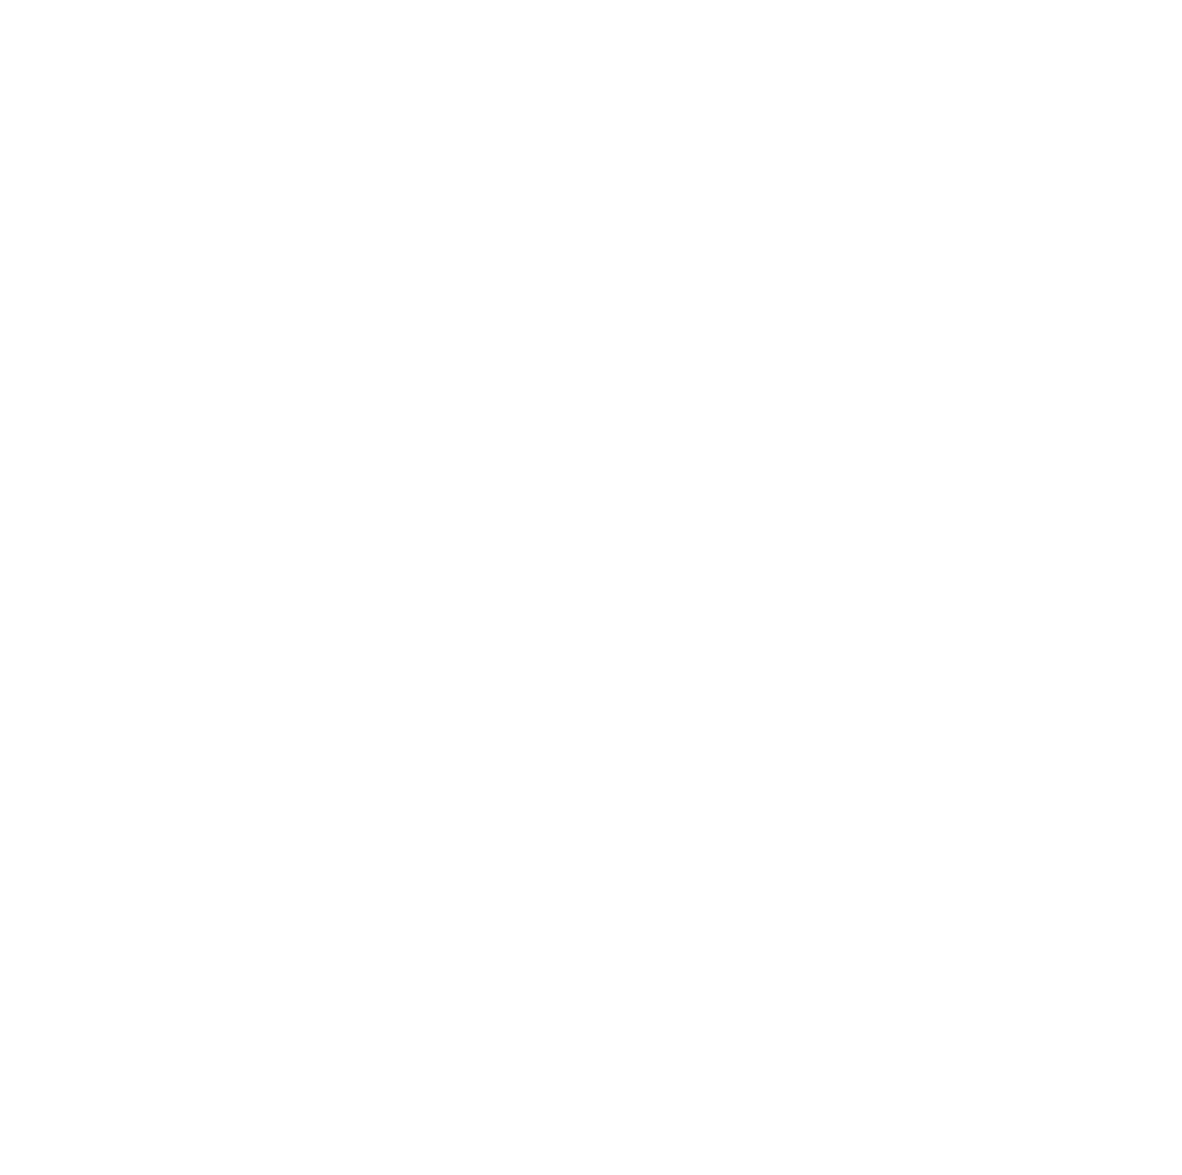

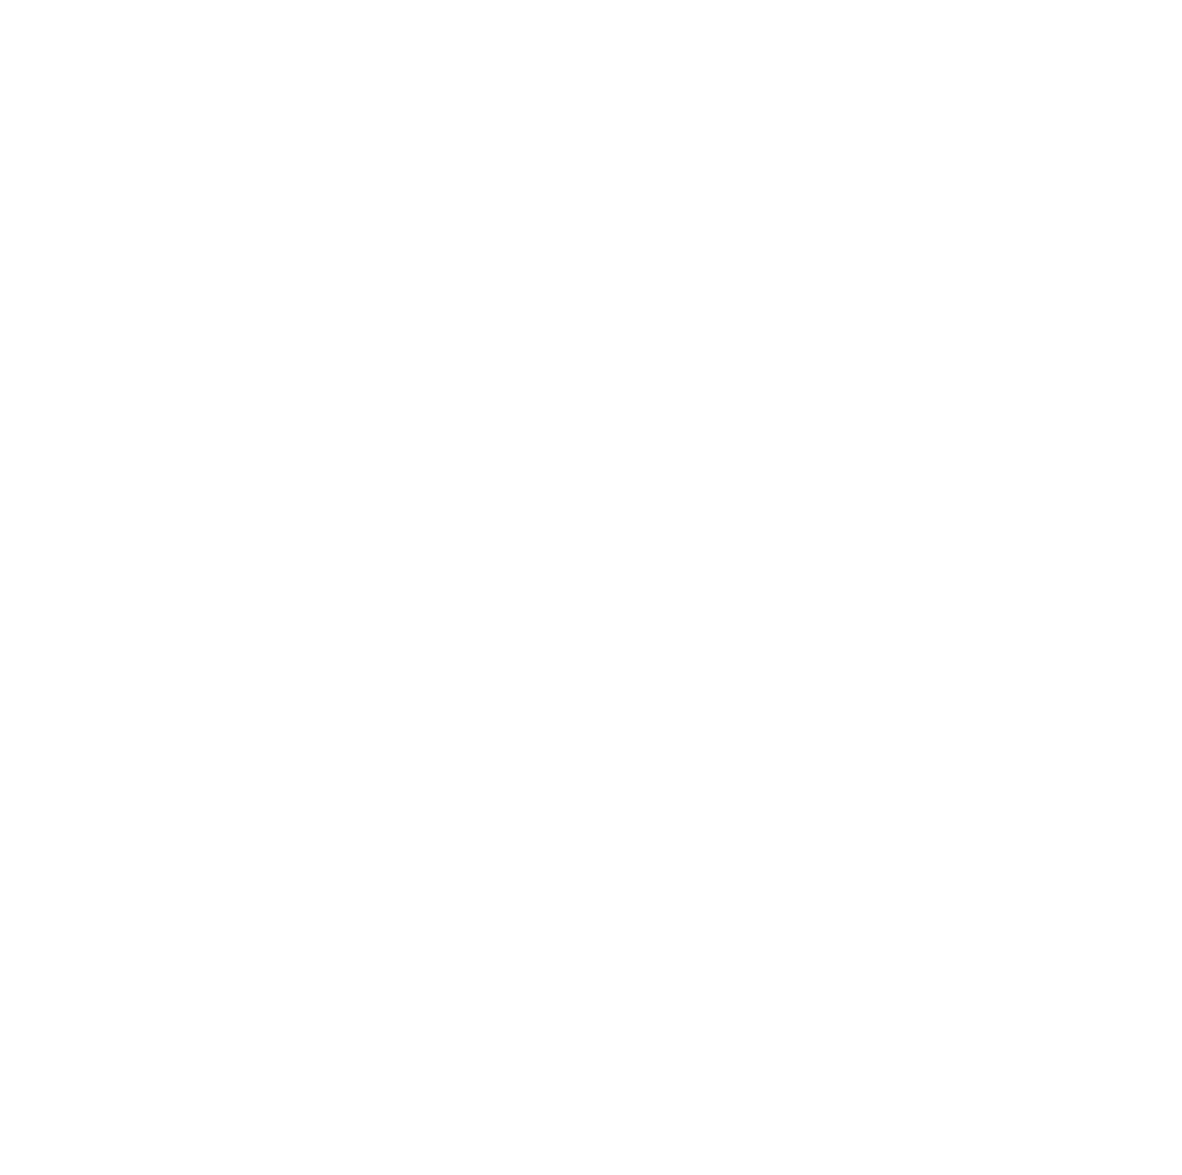

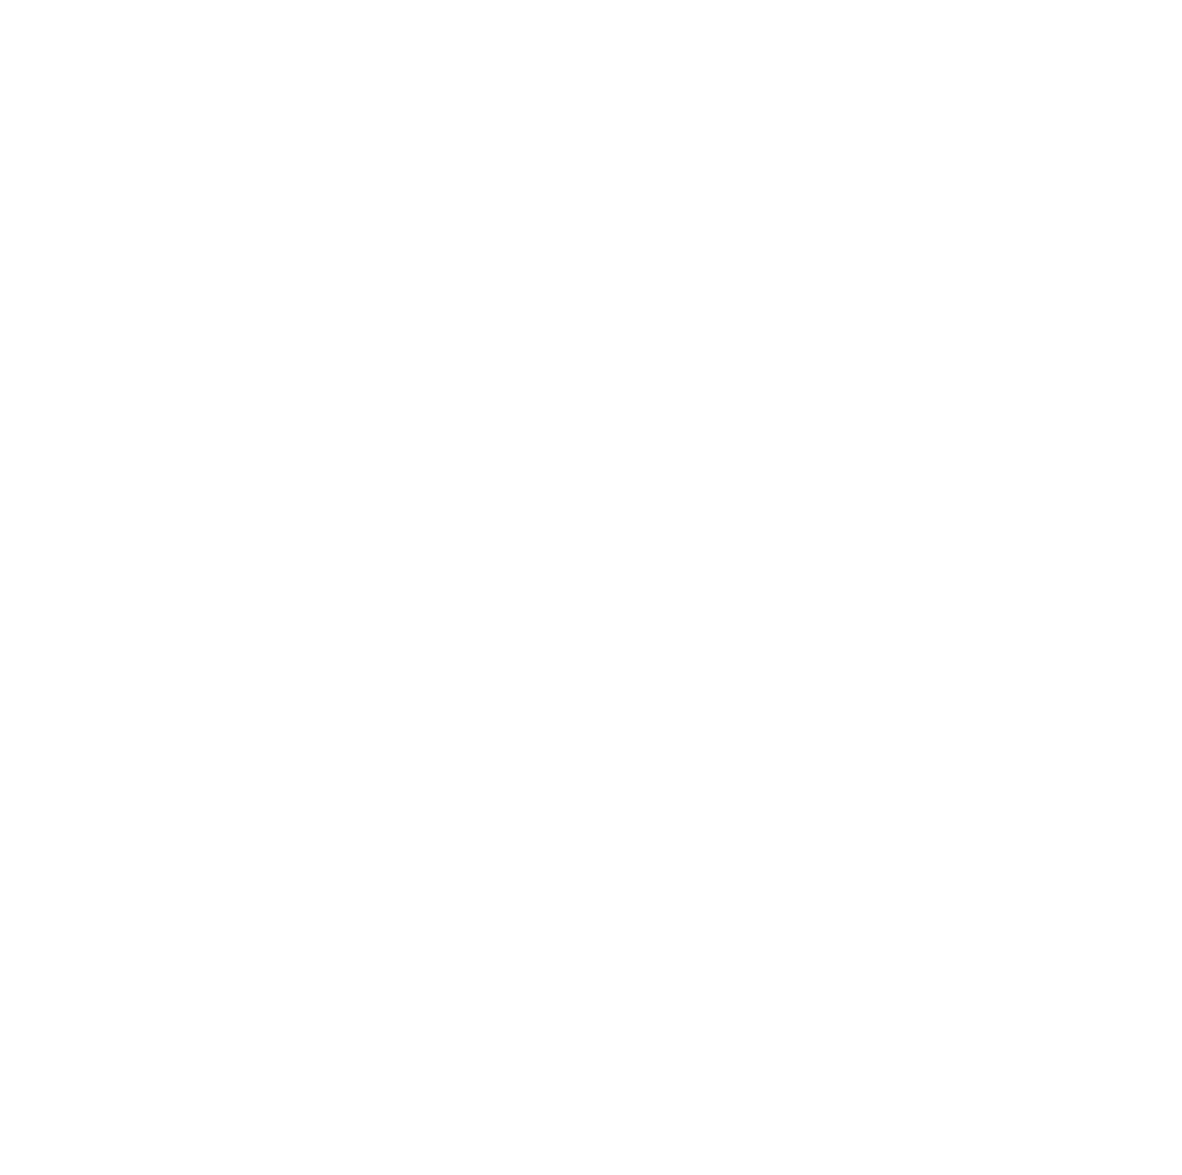

In [ ]:
# data = datasets.MNIST(root=".", download=True)


# xt, noise = forward_diffusion(x0, t)
# noise_pred = model(xt, t)

# loss = F.mse_loss(noise, noise_pred)

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t).squeeze()
        save_image(img, 'img1.png')
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        # if i % stepsize == 0:
            # plt.subplot(1, num_images, int(i/stepsize)+1)
            # show_tensor_image(img.detach().cpu())
        # plt.show()            
    
from torch.optim import Adam

# device = "cuda" 
# model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100# Try more!

for epoch in range(epochs):

    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model, batch[0], t)
        loss.backward()
        optimizer.step()
        
        # if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()